In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag='1.9.1.8.5_Dev_final_noQ_INP_moredim_regionsample'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='batch_name'
discov_key='species'
layer_key='spliced'


In [3]:
# To redo correction
# antipode_model = ANTIPODE.load_and_recorrect_standard(out_path,batch_size=128, n_steps = None,device=device)
# adata=antipode_model.adata_manager.adata

In [4]:
# DO NOT USE POST-CORRECTION MODEL (p4)
adata = sc.read_h5ad(os.path.join(out_path,'no_o.h5ad'),backed='r')
antipode_model=ANTIPODE.load(out_path,adata=adata,prefix='p3_',device=device)
adata=antipode_model.adata_manager.adata

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

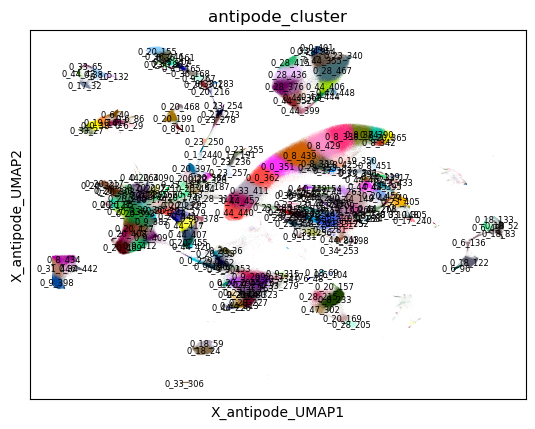

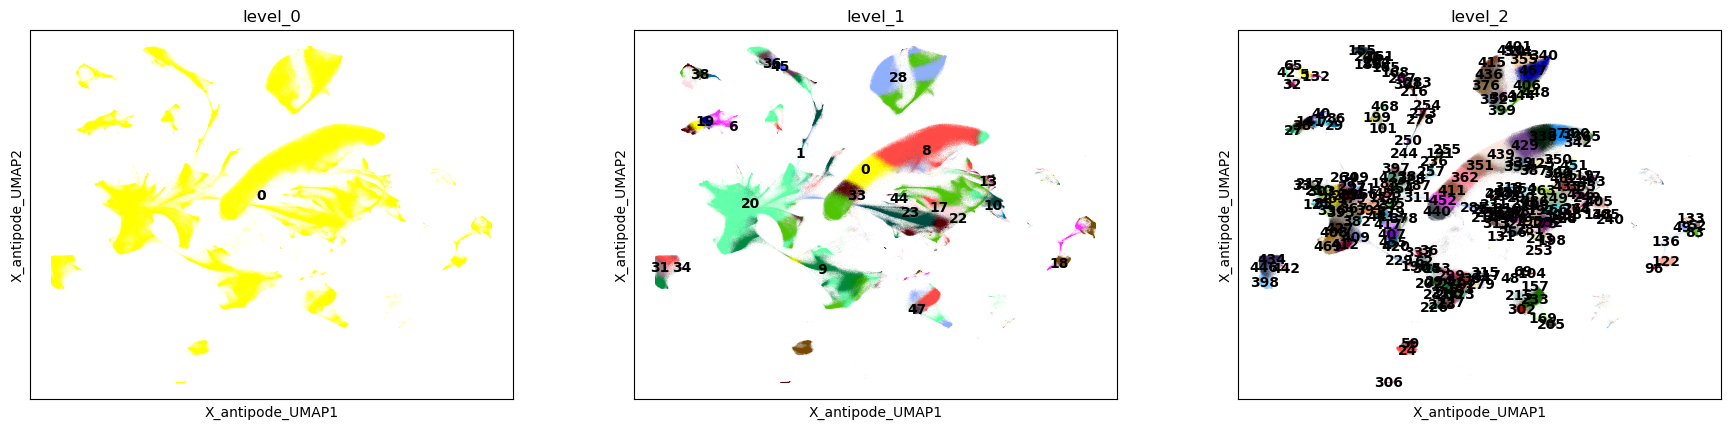

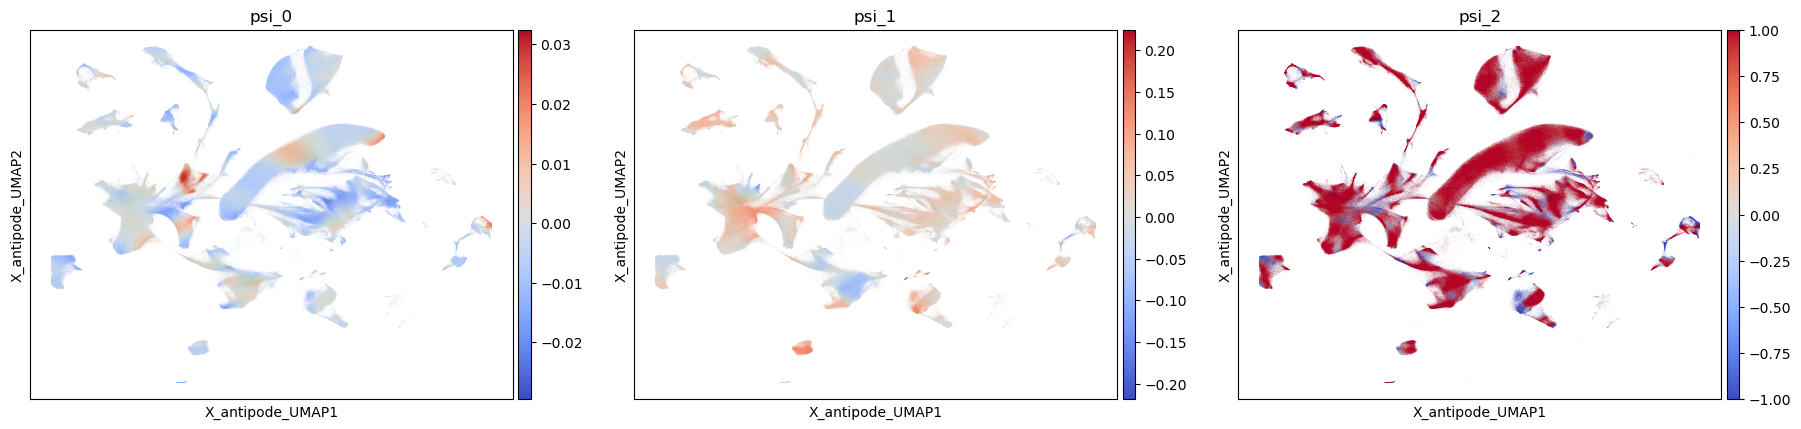

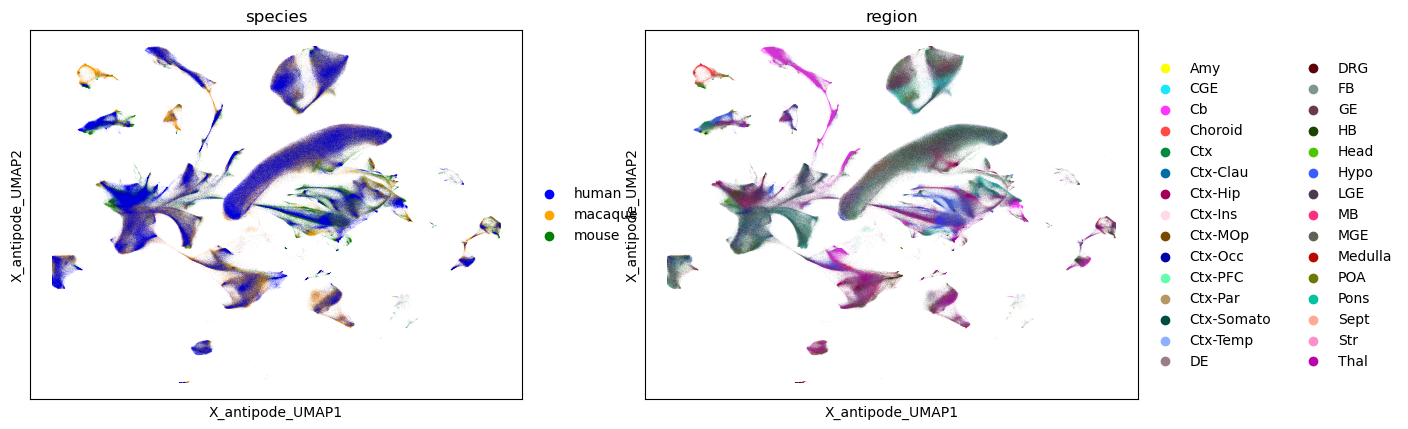

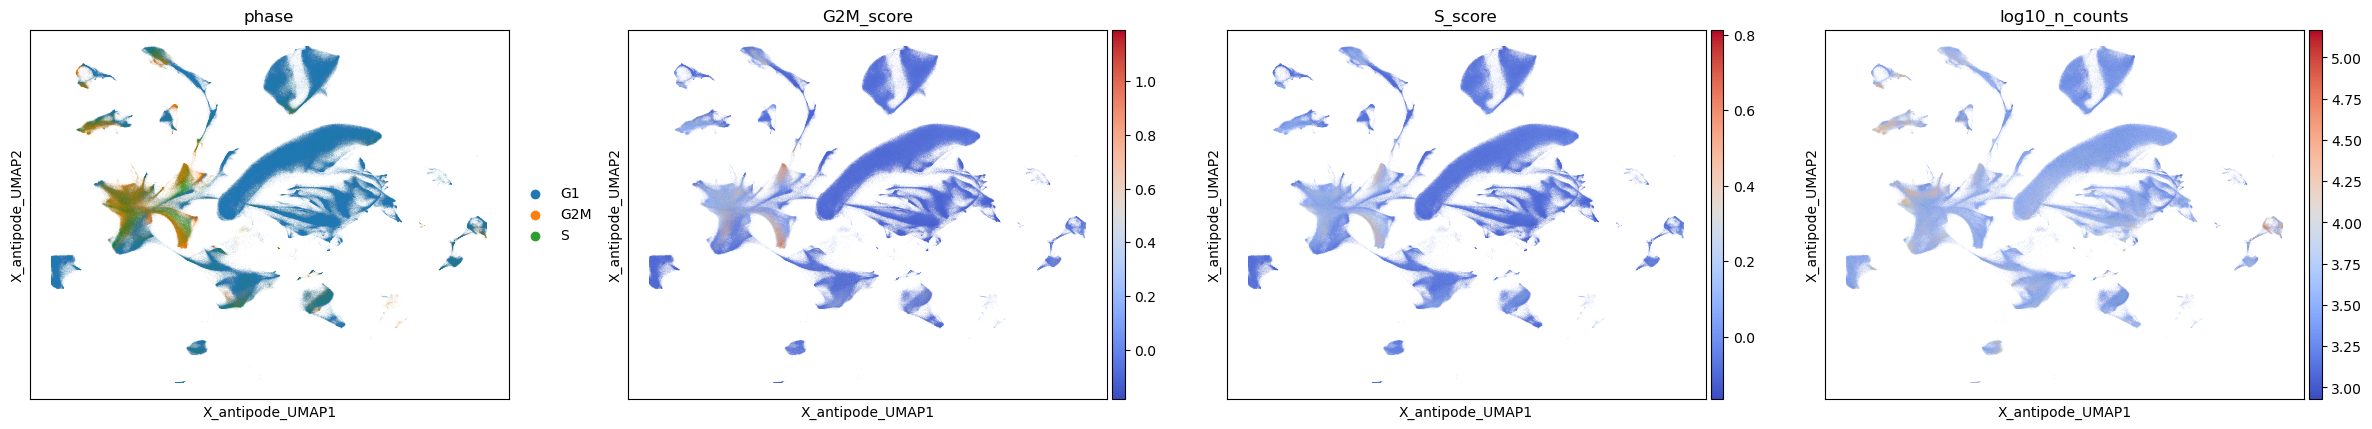

In [5]:
MDE_KEY = 'X_antipode_UMAP'
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'psi' in x],
    cmap='coolwarm',
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species','region']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['phase','G2M_score','S_score','log10_n_counts'],cmap='coolwarm'
)


In [6]:
import h5py
with h5py.File('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.5_Dev_final_noQ_INP_moredim_Tel_regionsample/p4_adata.h5ad') as f:
    t_obs = anndata.experimental.read_elem(f['obs'])
t_obs=pd.DataFrame(t_obs)
t_obs.index = t_obs['_index']
t_obs.index.name = None
with h5py.File('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.5_Dev_final_noQ_INP_moredim_DMR_regionsample/p3_adata.h5ad') as f:
    dmr_obs = anndata.experimental.read_elem(f['obs'])

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


In [7]:
adata.obs.index = adata.obs.index.to_series().astype(str).str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)
t_obs.index = t_obs.index.to_series().astype(str).str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)
dmr_obs.index = dmr_obs.index.to_series().astype(str).str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)


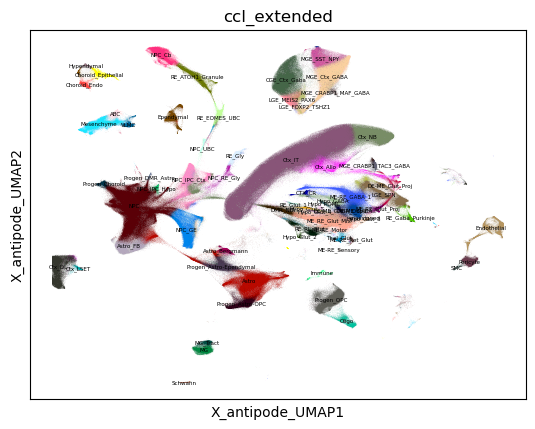

In [8]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["ccl_extended"],legend_fontsize=4,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)


In [9]:
adata.obs['region_refined_cluster'] = adata.obs['level_2'].astype(str)
t_obs = t_obs.loc[t_obs.index.isin(adata.obs.index),:]
dmr_obs = dmr_obs.loc[dmr_obs.index.isin(adata.obs.index),:]
adata.obs.loc[t_obs.index,'region_refined_cluster'] = 'tel_'+t_obs['level_2'].astype(str)
adata.obs.loc[dmr_obs.index,'region_refined_cluster'] = 'dmr_'+dmr_obs['level_2'].astype(str)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
neigh=KNeighborsClassifier(n_neighbors=15)
vcs = adata.obs['region_refined_cluster'].value_counts()
too_few = vcs.index[vcs < 20]
adata.obs['region_refined_cluster'] = list(adata.obs['region_refined_cluster'])
neigh.fit(adata[~adata.obs['region_refined_cluster'].isin(too_few),:].obsm['X_antipode'], adata[~adata.obs['region_refined_cluster'].isin(too_few),:].obs['region_refined_cluster'])
annotated_labels = neigh.predict(adata[adata.obs['region_refined_cluster'].isin(too_few),:].obsm['X_antipode'])
adata.obs.loc[adata.obs['region_refined_cluster'].isin(too_few), 'region_refined_cluster'] = annotated_labels


In [11]:
adata.obs['region_refined_cluster'].value_counts()

region_refined_cluster
tel_112    31283
tel_98     25828
tel_16     24764
tel_3      23337
tel_144    21273
           ...  
382           22
167           21
205           21
456           20
313           20
Name: count, Length: 459, dtype: int64

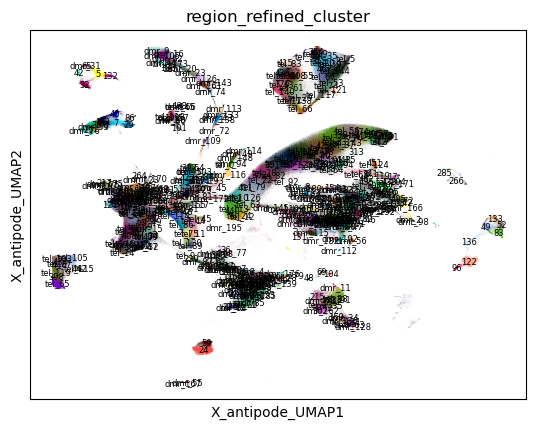

In [12]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["region_refined_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)


In [13]:
species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer='spliced',normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:37<01:14, 37.36s/it]

 67%|██████▋   | 2/3 [01:16<00:38, 38.44s/it]

100%|██████████| 3/3 [01:42<00:00, 32.67s/it]

100%|██████████| 3/3 [01:42<00:00, 34.12s/it]

In [14]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,50,len(adata.obs['region_refined_cluster'].unique())]
num_latent=200
steps=0
max_steps=1000000
num_particles=3
print_every=5000
max_learning_rate=1e-3,
one_cycle_lr=True,

# Clear Pyro param store so we don't conflict with previous run
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = antipode.antipode_model.ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,seccov_key='phase_sex',bi_depth=2,num_batch_embed=2,psi_levels=[0.,1.,1.],
                adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=1e-1,
                use_psi=True,use_q_score=False,prior_scale=50.,theta_prior=10,sampler_category='general_region_species',dist_normalize=False,dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=True)

INFO     Generating sequential column names                                                                        


In [15]:
#Don't try this at home, kids
pyro.get_param_store().load('/home/matthew.schmitz/Matthew/models/1.9.1.8.5_Dev_final_noQ_INP_moredim_regionsample/p3_antipode.paramstore',map_location=device)
model = torch.load('/home/matthew.schmitz/Matthew/models/1.9.1.8.5_Dev_final_noQ_INP_moredim_regionsample/p3_model.pt',map_location=device,weights_only=False)

regex = 's_inverse_dispersion|z_decoder_weight|discov_constitutive_de'
to_delete = []
for k in pyro.get_param_store():
    if not re.search(regex,k):
        # print(k)
        to_delete.append(k)

for k in to_delete:
    del pyro.get_param_store()[k]

regex = 'zl_encoder'
to_delete = []
for k in model['model_state_dict'].keys():
    if not re.search(regex,k):
        print(k)
        to_delete.append(k)

for k in to_delete:
    del model['model_state_dict'][k]

antipode_model.load_state_dict(model['model_state_dict'],strict=False)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

classifier.fc.0.weight
classifier.fc.1.weight
classifier.fc.1.bias
classifier.fc.1.running_mean
classifier.fc.1.running_var
classifier.fc.1.num_batches_tracked
classifier.fc.3.weight
classifier.fc.4.weight
classifier.fc.4.bias
classifier.fc.4.running_mean
classifier.fc.4.running_var
classifier.fc.4.num_batches_tracked
classifier.fc.6.weight
classifier.fc.7.weight
classifier.fc.7.bias
classifier.fc.7.running_mean
classifier.fc.7.running_var
classifier.fc.7.num_batches_tracked
classifier.fc.9.weight
classifier.fc.10.weight
classifier.fc.10.bias
classifier.fc.10.running_mean
classifier.fc.10.running_var
classifier.fc.10.num_batches_tracked
be_nn.fc.0.weight
be_nn.fc.2.weight
be_nn.fc.2.bias
be_nn.fc.2.running_mean
be_nn.fc.2.running_var
be_nn.fc.2.num_batches_tracked
be_nn.fc.4.weight
be_nn.fc.6.weight
be_nn.fc.6.bias
be_nn.fc.6.running_mean
be_nn.fc.6.running_var
be_nn.fc.6.num_batches_tracked
be_nn.fc.8.weight
be_nn.fc.10.weight
be_nn.fc.10.bias
be_nn.fc.10.running_mean
be_nn.fc.10.runn

_IncompatibleKeys(missing_keys=['classifier.fc.0.weight', 'classifier.fc.1.weight', 'classifier.fc.1.bias', 'classifier.fc.1.running_mean', 'classifier.fc.1.running_var', 'classifier.fc.1.num_batches_tracked', 'classifier.fc.3.weight', 'classifier.fc.4.weight', 'classifier.fc.4.bias', 'classifier.fc.4.running_mean', 'classifier.fc.4.running_var', 'classifier.fc.4.num_batches_tracked', 'classifier.fc.6.weight', 'classifier.fc.7.weight', 'classifier.fc.7.bias', 'classifier.fc.7.running_mean', 'classifier.fc.7.running_var', 'classifier.fc.7.num_batches_tracked', 'classifier.fc.9.weight', 'classifier.fc.10.weight', 'classifier.fc.10.bias', 'classifier.fc.10.running_mean', 'classifier.fc.10.running_var', 'classifier.fc.10.num_batches_tracked', 'be_nn.fc.0.weight', 'be_nn.fc.2.weight', 'be_nn.fc.2.bias', 'be_nn.fc.2.running_mean', 'be_nn.fc.2.running_var', 'be_nn.fc.2.num_batches_tracked', 'be_nn.fc.4.weight', 'be_nn.fc.6.weight', 'be_nn.fc.6.bias', 'be_nn.fc.6.running_mean', 'be_nn.fc.6.run

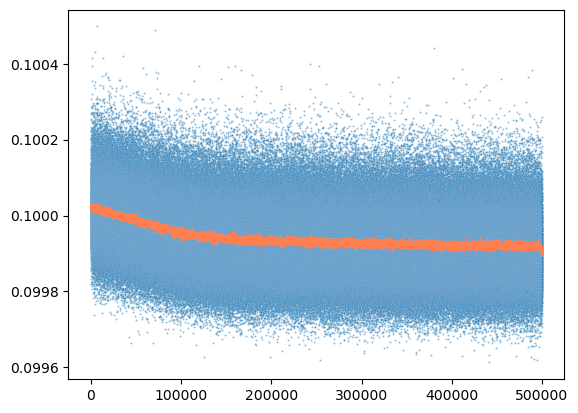

INFO     Generating sequential column names                                                                        


  0%|          | 0/55893 [00:00<?, ?it/s]

  0%|          | 43/55893 [00:00<02:12, 421.71it/s]

  0%|          | 91/55893 [00:00<02:02, 453.85it/s]

  0%|          | 142/55893 [00:00<01:57, 476.42it/s]

  0%|          | 198/55893 [00:00<01:49, 508.24it/s]

  0%|          | 254/55893 [00:00<01:46, 523.15it/s]

  1%|          | 310/55893 [00:00<01:44, 533.15it/s]

  1%|          | 366/55893 [00:00<01:42, 539.23it/s]

  1%|          | 421/55893 [00:00<01:42, 542.55it/s]

  1%|          | 477/55893 [00:00<01:41, 545.85it/s]

  1%|          | 533/55893 [00:01<01:41, 547.71it/s]

  1%|          | 590/55893 [00:01<01:40, 551.99it/s]

  1%|          | 647/55893 [00:01<01:39, 556.66it/s]

  1%|▏         | 703/55893 [00:01<01:39, 557.32it/s]

  1%|▏         | 760/55893 [00:01<01:38, 558.19it/s]

  1%|▏         | 817/55893 [00:01<01:38, 560.03it/s]

  2%|▏         | 874/55893 [00:01<01:37, 562.97it/s]

  2%|▏         | 931/55893 [00:01<01:38, 558.80it/s]

  2%|▏         | 987/55893 [00:01<01:39, 549.61it/s]

  2%|▏         | 1043/55893 [00:01<01:39, 551.69it/s]

  2%|▏         | 1100/55893 [00:02<01:38, 555.21it/s]

  2%|▏         | 1156/55893 [00:02<01:38, 555.55it/s]

  2%|▏         | 1212/55893 [00:02<01:42, 533.66it/s]

  2%|▏         | 1266/55893 [00:02<01:44, 522.77it/s]

  2%|▏         | 1319/55893 [00:02<01:44, 520.49it/s]

  2%|▏         | 1372/55893 [00:02<01:44, 520.26it/s]

  3%|▎         | 1426/55893 [00:02<01:43, 525.82it/s]

  3%|▎         | 1480/55893 [00:02<01:42, 528.79it/s]

  3%|▎         | 1533/55893 [00:02<01:43, 527.12it/s]

  3%|▎         | 1587/55893 [00:02<01:42, 528.49it/s]

  3%|▎         | 1641/55893 [00:03<01:42, 531.36it/s]

  3%|▎         | 1695/55893 [00:03<01:41, 533.79it/s]

  3%|▎         | 1751/55893 [00:03<01:40, 539.29it/s]

  3%|▎         | 1807/55893 [00:03<01:39, 543.04it/s]

  3%|▎         | 1863/55893 [00:03<01:38, 545.78it/s]

  3%|▎         | 1918/55893 [00:03<01:39, 544.89it/s]

  4%|▎         | 1973/55893 [00:03<01:40, 536.39it/s]

  4%|▎         | 2027/55893 [00:03<01:41, 533.28it/s]

  4%|▎         | 2081/55893 [00:03<01:41, 532.77it/s]

  4%|▍         | 2135/55893 [00:03<01:41, 530.59it/s]

  4%|▍         | 2189/55893 [00:04<01:41, 527.69it/s]

  4%|▍         | 2243/55893 [00:04<01:41, 528.51it/s]

  4%|▍         | 2297/55893 [00:04<01:41, 530.56it/s]

  4%|▍         | 2351/55893 [00:04<01:41, 525.57it/s]

  4%|▍         | 2404/55893 [00:04<01:42, 522.26it/s]

  4%|▍         | 2458/55893 [00:04<01:41, 525.91it/s]

  4%|▍         | 2511/55893 [00:04<01:43, 515.57it/s]

  5%|▍         | 2564/55893 [00:04<01:42, 518.51it/s]

  5%|▍         | 2616/55893 [00:04<01:43, 514.28it/s]

  5%|▍         | 2671/55893 [00:05<01:41, 523.24it/s]

  5%|▍         | 2724/55893 [00:05<01:42, 519.30it/s]

  5%|▍         | 2776/55893 [00:05<01:42, 516.28it/s]

  5%|▌         | 2828/55893 [00:05<01:42, 516.12it/s]

  5%|▌         | 2880/55893 [00:05<01:43, 511.35it/s]

  5%|▌         | 2932/55893 [00:05<01:43, 512.25it/s]

  5%|▌         | 2985/55893 [00:05<01:42, 515.40it/s]

  5%|▌         | 3037/55893 [00:05<01:42, 516.65it/s]

  6%|▌         | 3089/55893 [00:05<01:42, 516.82it/s]

  6%|▌         | 3141/55893 [00:05<01:42, 513.59it/s]

  6%|▌         | 3193/55893 [00:06<01:43, 511.47it/s]

  6%|▌         | 3247/55893 [00:06<01:41, 518.00it/s]

  6%|▌         | 3301/55893 [00:06<01:40, 521.95it/s]

  6%|▌         | 3354/55893 [00:06<01:40, 521.57it/s]

  6%|▌         | 3407/55893 [00:06<01:41, 519.59it/s]

  6%|▌         | 3459/55893 [00:06<01:41, 518.56it/s]

  6%|▋         | 3512/55893 [00:06<01:40, 520.20it/s]

  6%|▋         | 3565/55893 [00:06<01:40, 520.06it/s]

  6%|▋         | 3618/55893 [00:06<01:40, 522.59it/s]

  7%|▋         | 3671/55893 [00:06<01:40, 521.64it/s]

  7%|▋         | 3725/55893 [00:07<01:39, 525.89it/s]

  7%|▋         | 3778/55893 [00:07<01:39, 524.71it/s]

  7%|▋         | 3831/55893 [00:07<01:39, 525.41it/s]

  7%|▋         | 3885/55893 [00:07<01:38, 527.29it/s]

  7%|▋         | 3940/55893 [00:07<01:37, 533.24it/s]

  7%|▋         | 3994/55893 [00:07<01:37, 533.85it/s]

  7%|▋         | 4048/55893 [00:07<01:37, 533.31it/s]

  7%|▋         | 4102/55893 [00:07<01:37, 529.66it/s]

  7%|▋         | 4155/55893 [00:07<01:38, 527.62it/s]

  8%|▊         | 4209/55893 [00:07<01:37, 528.55it/s]

  8%|▊         | 4262/55893 [00:08<01:39, 519.29it/s]

  8%|▊         | 4315/55893 [00:08<01:38, 521.42it/s]

  8%|▊         | 4369/55893 [00:08<01:38, 525.29it/s]

  8%|▊         | 4423/55893 [00:08<01:37, 527.90it/s]

  8%|▊         | 4477/55893 [00:08<01:36, 530.34it/s]

  8%|▊         | 4531/55893 [00:08<01:36, 532.36it/s]

  8%|▊         | 4585/55893 [00:08<01:36, 530.34it/s]

  8%|▊         | 4639/55893 [00:08<01:36, 531.98it/s]

  8%|▊         | 4693/55893 [00:08<01:35, 533.62it/s]

  8%|▊         | 4747/55893 [00:08<01:35, 535.11it/s]

  9%|▊         | 4801/55893 [00:09<01:35, 532.62it/s]

  9%|▊         | 4855/55893 [00:09<01:35, 532.03it/s]

  9%|▉         | 4909/55893 [00:09<01:35, 532.82it/s]

  9%|▉         | 4965/55893 [00:09<01:34, 539.69it/s]

  9%|▉         | 5019/55893 [00:09<01:35, 533.64it/s]

  9%|▉         | 5073/55893 [00:09<01:34, 535.47it/s]

  9%|▉         | 5127/55893 [00:09<01:35, 532.27it/s]

  9%|▉         | 5182/55893 [00:09<01:34, 536.16it/s]

  9%|▉         | 5238/55893 [00:09<01:33, 540.63it/s]

  9%|▉         | 5293/55893 [00:09<01:33, 539.40it/s]

 10%|▉         | 5348/55893 [00:10<01:33, 540.25it/s]

 10%|▉         | 5403/55893 [00:10<01:33, 540.05it/s]

 10%|▉         | 5458/55893 [00:10<01:33, 540.36it/s]

 10%|▉         | 5513/55893 [00:10<01:34, 535.92it/s]

 10%|▉         | 5567/55893 [00:10<01:34, 534.52it/s]

 10%|█         | 5621/55893 [00:10<01:33, 536.07it/s]

 10%|█         | 5675/55893 [00:10<01:34, 533.22it/s]

 10%|█         | 5729/55893 [00:10<01:34, 532.44it/s]

 10%|█         | 5783/55893 [00:10<01:34, 531.17it/s]

 10%|█         | 5837/55893 [00:11<01:33, 533.20it/s]

 11%|█         | 5891/55893 [00:11<01:34, 531.83it/s]

 11%|█         | 5945/55893 [00:11<01:33, 531.62it/s]

 11%|█         | 5999/55893 [00:11<01:34, 525.62it/s]

 11%|█         | 6053/55893 [00:11<01:34, 529.40it/s]

 11%|█         | 6106/55893 [00:11<01:34, 528.58it/s]

 11%|█         | 6160/55893 [00:11<01:33, 529.26it/s]

 11%|█         | 6213/55893 [00:11<01:34, 527.94it/s]

 11%|█         | 6268/55893 [00:11<01:33, 531.76it/s]

 11%|█▏        | 6322/55893 [00:11<01:33, 529.93it/s]

 11%|█▏        | 6376/55893 [00:12<01:33, 530.29it/s]

 12%|█▏        | 6431/55893 [00:12<01:32, 533.38it/s]

 12%|█▏        | 6485/55893 [00:12<01:33, 529.77it/s]

 12%|█▏        | 6538/55893 [00:12<01:33, 528.00it/s]

 12%|█▏        | 6592/55893 [00:12<01:32, 530.75it/s]

 12%|█▏        | 6646/55893 [00:12<01:32, 529.55it/s]

 12%|█▏        | 6701/55893 [00:12<01:32, 533.24it/s]

 12%|█▏        | 6755/55893 [00:12<01:32, 533.88it/s]

 12%|█▏        | 6810/55893 [00:12<01:31, 536.98it/s]

 12%|█▏        | 6864/55893 [00:12<01:31, 535.50it/s]

 12%|█▏        | 6918/55893 [00:13<01:31, 533.54it/s]

 12%|█▏        | 6973/55893 [00:13<01:31, 535.94it/s]

 13%|█▎        | 7027/55893 [00:13<01:31, 536.77it/s]

 13%|█▎        | 7081/55893 [00:13<01:31, 536.16it/s]

 13%|█▎        | 7136/55893 [00:13<01:30, 539.05it/s]

 13%|█▎        | 7190/55893 [00:13<01:30, 537.77it/s]

 13%|█▎        | 7244/55893 [00:13<01:30, 537.24it/s]

 13%|█▎        | 7298/55893 [00:13<01:30, 537.41it/s]

 13%|█▎        | 7352/55893 [00:13<01:30, 537.32it/s]

 13%|█▎        | 7406/55893 [00:13<01:32, 525.99it/s]

 13%|█▎        | 7459/55893 [00:14<01:32, 522.93it/s]

 13%|█▎        | 7514/55893 [00:14<01:31, 528.92it/s]

 14%|█▎        | 7567/55893 [00:14<01:31, 526.39it/s]

 14%|█▎        | 7621/55893 [00:14<01:31, 527.56it/s]

 14%|█▎        | 7676/55893 [00:14<01:30, 533.44it/s]

 14%|█▍        | 7730/55893 [00:14<01:30, 532.12it/s]

 14%|█▍        | 7785/55893 [00:14<01:29, 536.13it/s]

 14%|█▍        | 7839/55893 [00:14<01:30, 533.20it/s]

 14%|█▍        | 7893/55893 [00:14<01:30, 533.10it/s]

 14%|█▍        | 7947/55893 [00:14<01:29, 532.94it/s]

 14%|█▍        | 8001/55893 [00:15<01:29, 534.21it/s]

 14%|█▍        | 8056/55893 [00:15<01:29, 537.48it/s]

 15%|█▍        | 8110/55893 [00:15<01:28, 537.18it/s]

 15%|█▍        | 8164/55893 [00:15<01:29, 536.17it/s]

 15%|█▍        | 8219/55893 [00:15<01:28, 537.75it/s]

 15%|█▍        | 8274/55893 [00:15<01:28, 540.06it/s]

 15%|█▍        | 8329/55893 [00:15<01:28, 537.99it/s]

 15%|█▌        | 8384/55893 [00:15<01:28, 539.49it/s]

 15%|█▌        | 8440/55893 [00:15<01:27, 544.75it/s]

 15%|█▌        | 8495/55893 [00:15<01:27, 542.97it/s]

 15%|█▌        | 8550/55893 [00:16<01:27, 539.35it/s]

 15%|█▌        | 8604/55893 [00:16<01:27, 537.59it/s]

 15%|█▌        | 8659/55893 [00:16<01:27, 539.22it/s]

 16%|█▌        | 8713/55893 [00:16<01:27, 537.95it/s]

 16%|█▌        | 8768/55893 [00:16<01:27, 540.07it/s]

 16%|█▌        | 8823/55893 [00:16<01:27, 537.30it/s]

 16%|█▌        | 8878/55893 [00:16<01:27, 539.61it/s]

 16%|█▌        | 8932/55893 [00:16<01:27, 539.05it/s]

 16%|█▌        | 8986/55893 [00:16<01:27, 538.11it/s]

 16%|█▌        | 9042/55893 [00:16<01:26, 541.81it/s]

 16%|█▋        | 9097/55893 [00:17<01:27, 537.75it/s]

 16%|█▋        | 9151/55893 [00:17<01:27, 537.06it/s]

 16%|█▋        | 9206/55893 [00:17<01:26, 540.10it/s]

 17%|█▋        | 9261/55893 [00:17<01:27, 532.26it/s]

 17%|█▋        | 9315/55893 [00:17<01:28, 527.19it/s]

 17%|█▋        | 9370/55893 [00:17<01:27, 531.87it/s]

 17%|█▋        | 9424/55893 [00:17<01:27, 533.35it/s]

 17%|█▋        | 9478/55893 [00:17<01:27, 531.23it/s]

 17%|█▋        | 9533/55893 [00:17<01:26, 534.65it/s]

 17%|█▋        | 9587/55893 [00:18<01:26, 533.32it/s]

 17%|█▋        | 9643/55893 [00:18<01:25, 538.07it/s]

 17%|█▋        | 9697/55893 [00:18<01:26, 532.49it/s]

 17%|█▋        | 9751/55893 [00:18<01:26, 530.50it/s]

 18%|█▊        | 9805/55893 [00:18<01:28, 523.17it/s]

 18%|█▊        | 9858/55893 [00:18<01:29, 517.22it/s]

 18%|█▊        | 9910/55893 [00:18<01:29, 511.84it/s]

 18%|█▊        | 9962/55893 [00:18<01:30, 507.88it/s]

 18%|█▊        | 10015/55893 [00:18<01:29, 513.17it/s]

 18%|█▊        | 10070/55893 [00:18<01:27, 521.65it/s]

 18%|█▊        | 10124/55893 [00:19<01:27, 525.81it/s]

 18%|█▊        | 10177/55893 [00:19<01:27, 524.57it/s]

 18%|█▊        | 10230/55893 [00:19<01:27, 518.92it/s]

 18%|█▊        | 10284/55893 [00:19<01:27, 522.86it/s]

 18%|█▊        | 10338/55893 [00:19<01:26, 527.10it/s]

 19%|█▊        | 10392/55893 [00:19<01:25, 530.42it/s]

 19%|█▊        | 10447/55893 [00:19<01:24, 534.70it/s]

 19%|█▉        | 10501/55893 [00:19<01:25, 533.37it/s]

 19%|█▉        | 10556/55893 [00:19<01:24, 537.09it/s]

 19%|█▉        | 10611/55893 [00:19<01:23, 540.51it/s]

 19%|█▉        | 10666/55893 [00:20<01:23, 538.64it/s]

 19%|█▉        | 10720/55893 [00:20<01:23, 538.55it/s]

 19%|█▉        | 10774/55893 [00:20<01:23, 537.63it/s]

 19%|█▉        | 10828/55893 [00:20<01:24, 536.31it/s]

 19%|█▉        | 10882/55893 [00:20<01:23, 536.08it/s]

 20%|█▉        | 10937/55893 [00:20<01:23, 538.42it/s]

 20%|█▉        | 10991/55893 [00:20<01:23, 534.74it/s]

 20%|█▉        | 11045/55893 [00:20<01:23, 534.81it/s]

 20%|█▉        | 11100/55893 [00:20<01:23, 538.15it/s]

 20%|█▉        | 11156/55893 [00:20<01:22, 543.99it/s]

 20%|██        | 11211/55893 [00:21<01:23, 537.75it/s]

 20%|██        | 11265/55893 [00:21<01:23, 537.34it/s]

 20%|██        | 11320/55893 [00:21<01:22, 538.34it/s]

 20%|██        | 11375/55893 [00:21<01:22, 541.12it/s]

 20%|██        | 11430/55893 [00:21<01:22, 536.17it/s]

 21%|██        | 11485/55893 [00:21<01:22, 537.46it/s]

 21%|██        | 11540/55893 [00:21<01:22, 538.53it/s]

 21%|██        | 11595/55893 [00:21<01:22, 540.12it/s]

 21%|██        | 11650/55893 [00:21<01:21, 542.94it/s]

 21%|██        | 11706/55893 [00:21<01:20, 545.82it/s]

 21%|██        | 11762/55893 [00:22<01:20, 548.28it/s]

 21%|██        | 11818/55893 [00:22<01:20, 550.09it/s]

 21%|██        | 11874/55893 [00:22<01:20, 548.85it/s]

 21%|██▏       | 11929/55893 [00:22<01:20, 545.32it/s]

 21%|██▏       | 11984/55893 [00:22<01:20, 544.55it/s]

 22%|██▏       | 12040/55893 [00:22<01:20, 547.87it/s]

 22%|██▏       | 12095/55893 [00:23<02:58, 245.94it/s]

 22%|██▏       | 12151/55893 [00:23<02:27, 296.09it/s]

 22%|██▏       | 12208/55893 [00:23<02:05, 346.86it/s]

 22%|██▏       | 12265/55893 [00:23<01:51, 392.67it/s]

 22%|██▏       | 12322/55893 [00:23<01:40, 432.74it/s]

 22%|██▏       | 12377/55893 [00:23<01:34, 459.75it/s]

 22%|██▏       | 12433/55893 [00:23<01:29, 483.56it/s]

 22%|██▏       | 12489/55893 [00:23<01:26, 502.86it/s]

 22%|██▏       | 12546/55893 [00:23<01:23, 519.49it/s]

 23%|██▎       | 12603/55893 [00:24<01:21, 532.06it/s]

 23%|██▎       | 12660/55893 [00:24<01:19, 542.35it/s]

 23%|██▎       | 12717/55893 [00:24<01:18, 549.76it/s]

 23%|██▎       | 12774/55893 [00:24<01:18, 549.68it/s]

 23%|██▎       | 12830/55893 [00:24<01:18, 548.30it/s]

 23%|██▎       | 12886/55893 [00:24<01:18, 550.14it/s]

 23%|██▎       | 12942/55893 [00:24<01:17, 552.68it/s]

 23%|██▎       | 12999/55893 [00:24<01:17, 555.93it/s]

 23%|██▎       | 13056/55893 [00:24<01:16, 558.17it/s]

 23%|██▎       | 13113/55893 [00:24<01:16, 561.10it/s]

 24%|██▎       | 13170/55893 [00:25<01:16, 560.88it/s]

 24%|██▎       | 13227/55893 [00:25<01:16, 560.03it/s]

 24%|██▍       | 13284/55893 [00:25<01:15, 562.51it/s]

 24%|██▍       | 13341/55893 [00:25<01:15, 563.17it/s]

 24%|██▍       | 13398/55893 [00:25<01:16, 554.34it/s]

 24%|██▍       | 13454/55893 [00:25<01:16, 554.79it/s]

 24%|██▍       | 13511/55893 [00:25<01:16, 556.72it/s]

 24%|██▍       | 13568/55893 [00:25<01:15, 559.00it/s]

 24%|██▍       | 13625/55893 [00:25<01:15, 561.66it/s]

 24%|██▍       | 13682/55893 [00:25<01:15, 562.75it/s]

 25%|██▍       | 13739/55893 [00:26<01:14, 564.90it/s]

 25%|██▍       | 13796/55893 [00:26<01:15, 555.73it/s]

 25%|██▍       | 13852/55893 [00:26<01:16, 552.93it/s]

 25%|██▍       | 13908/55893 [00:26<01:16, 551.80it/s]

 25%|██▍       | 13964/55893 [00:26<01:15, 552.39it/s]

 25%|██▌       | 14020/55893 [00:26<01:15, 553.21it/s]

 25%|██▌       | 14076/55893 [00:26<01:15, 552.66it/s]

 25%|██▌       | 14132/55893 [00:26<01:16, 543.27it/s]

 25%|██▌       | 14187/55893 [00:26<01:17, 540.87it/s]

 25%|██▌       | 14242/55893 [00:26<01:16, 542.27it/s]

 26%|██▌       | 14298/55893 [00:27<01:16, 546.32it/s]

 26%|██▌       | 14355/55893 [00:27<01:15, 550.99it/s]

 26%|██▌       | 14412/55893 [00:27<01:14, 556.53it/s]

 26%|██▌       | 14468/55893 [00:27<01:14, 557.23it/s]

 26%|██▌       | 14524/55893 [00:27<01:15, 551.04it/s]

 26%|██▌       | 14580/55893 [00:27<01:16, 537.40it/s]

 26%|██▌       | 14634/55893 [00:27<01:17, 534.93it/s]

 26%|██▋       | 14688/55893 [00:27<01:17, 533.95it/s]

 26%|██▋       | 14743/55893 [00:27<01:16, 538.24it/s]

 26%|██▋       | 14800/55893 [00:28<01:15, 545.55it/s]

 27%|██▋       | 14855/55893 [00:28<01:15, 542.26it/s]

 27%|██▋       | 14910/55893 [00:28<01:15, 542.93it/s]

 27%|██▋       | 14965/55893 [00:28<01:15, 541.90it/s]

 27%|██▋       | 15020/55893 [00:28<01:15, 544.12it/s]

 27%|██▋       | 15075/55893 [00:28<01:14, 545.79it/s]

 27%|██▋       | 15130/55893 [00:28<01:14, 545.99it/s]

 27%|██▋       | 15187/55893 [00:28<01:13, 552.13it/s]

 27%|██▋       | 15243/55893 [00:28<01:14, 548.06it/s]

 27%|██▋       | 15298/55893 [00:28<01:14, 547.33it/s]

 27%|██▋       | 15354/55893 [00:29<01:13, 549.58it/s]

 28%|██▊       | 15409/55893 [00:29<01:13, 547.19it/s]

 28%|██▊       | 15465/55893 [00:29<01:13, 549.40it/s]

 28%|██▊       | 15520/55893 [00:29<01:13, 549.21it/s]

 28%|██▊       | 15575/55893 [00:29<01:13, 548.64it/s]

 28%|██▊       | 15630/55893 [00:29<01:14, 543.11it/s]

 28%|██▊       | 15686/55893 [00:29<01:13, 546.13it/s]

 28%|██▊       | 15742/55893 [00:29<01:13, 547.41it/s]

 28%|██▊       | 15798/55893 [00:29<01:12, 550.37it/s]

 28%|██▊       | 15855/55893 [00:29<01:12, 554.03it/s]

 28%|██▊       | 15912/55893 [00:30<01:11, 557.59it/s]

 29%|██▊       | 15968/55893 [00:30<01:11, 555.15it/s]

 29%|██▊       | 16024/55893 [00:30<01:12, 553.61it/s]

 29%|██▉       | 16081/55893 [00:30<01:11, 555.97it/s]

 29%|██▉       | 16137/55893 [00:30<01:12, 550.86it/s]

 29%|██▉       | 16193/55893 [00:30<01:11, 551.89it/s]

 29%|██▉       | 16249/55893 [00:30<01:11, 554.13it/s]

 29%|██▉       | 16306/55893 [00:30<01:11, 557.06it/s]

 29%|██▉       | 16362/55893 [00:30<01:10, 557.13it/s]

 29%|██▉       | 16418/55893 [00:30<01:11, 554.26it/s]

 29%|██▉       | 16474/55893 [00:31<01:11, 554.49it/s]

 30%|██▉       | 16531/55893 [00:31<01:10, 557.34it/s]

 30%|██▉       | 16588/55893 [00:31<01:10, 559.44it/s]

 30%|██▉       | 16645/55893 [00:31<01:09, 562.37it/s]

 30%|██▉       | 16702/55893 [00:31<01:09, 563.76it/s]

 30%|██▉       | 16759/55893 [00:31<01:09, 559.84it/s]

 30%|███       | 16815/55893 [00:31<01:10, 556.92it/s]

 30%|███       | 16871/55893 [00:31<01:10, 550.39it/s]

 30%|███       | 16927/55893 [00:31<01:11, 547.96it/s]

 30%|███       | 16983/55893 [00:31<01:10, 549.03it/s]

 30%|███       | 17039/55893 [00:32<01:10, 551.65it/s]

 31%|███       | 17095/55893 [00:32<01:11, 545.26it/s]

 31%|███       | 17150/55893 [00:32<01:11, 543.29it/s]

 31%|███       | 17205/55893 [00:32<01:10, 545.07it/s]

 31%|███       | 17260/55893 [00:32<01:10, 546.37it/s]

 31%|███       | 17316/55893 [00:32<01:10, 549.76it/s]

 31%|███       | 17371/55893 [00:32<01:10, 547.24it/s]

 31%|███       | 17427/55893 [00:32<01:10, 548.23it/s]

 31%|███▏      | 17482/55893 [00:32<01:10, 547.11it/s]

 31%|███▏      | 17537/55893 [00:32<01:11, 539.89it/s]

 31%|███▏      | 17592/55893 [00:33<01:10, 541.26it/s]

 32%|███▏      | 17647/55893 [00:33<01:10, 539.22it/s]

 32%|███▏      | 17701/55893 [00:33<01:11, 535.53it/s]

 32%|███▏      | 17756/55893 [00:33<01:11, 537.02it/s]

 32%|███▏      | 17812/55893 [00:33<01:10, 542.09it/s]

 32%|███▏      | 17867/55893 [00:33<01:10, 542.52it/s]

 32%|███▏      | 17922/55893 [00:33<01:10, 534.87it/s]

 32%|███▏      | 17976/55893 [00:33<01:11, 532.99it/s]

 32%|███▏      | 18030/55893 [00:33<01:10, 534.26it/s]

 32%|███▏      | 18085/55893 [00:34<01:10, 538.61it/s]

 32%|███▏      | 18139/55893 [00:34<01:10, 533.25it/s]

 33%|███▎      | 18193/55893 [00:34<01:10, 532.71it/s]

 33%|███▎      | 18250/55893 [00:34<01:09, 541.25it/s]

 33%|███▎      | 18307/55893 [00:34<01:08, 547.32it/s]

 33%|███▎      | 18362/55893 [00:34<01:08, 547.01it/s]

 33%|███▎      | 18419/55893 [00:34<01:07, 551.37it/s]

 33%|███▎      | 18475/55893 [00:34<01:07, 552.55it/s]

 33%|███▎      | 18531/55893 [00:34<01:08, 542.37it/s]

 33%|███▎      | 18586/55893 [00:34<01:09, 539.54it/s]

 33%|███▎      | 18640/55893 [00:35<01:09, 539.63it/s]

 33%|███▎      | 18696/55893 [00:35<01:08, 543.45it/s]

 34%|███▎      | 18753/55893 [00:35<01:07, 548.64it/s]

 34%|███▎      | 18808/55893 [00:35<01:07, 546.73it/s]

 34%|███▎      | 18863/55893 [00:35<01:07, 546.59it/s]

 34%|███▍      | 18918/55893 [00:35<01:08, 538.30it/s]

 34%|███▍      | 18972/55893 [00:35<01:08, 537.88it/s]

 34%|███▍      | 19029/55893 [00:35<01:07, 546.21it/s]

 34%|███▍      | 19084/55893 [00:35<01:07, 545.58it/s]

 34%|███▍      | 19140/55893 [00:35<01:07, 548.51it/s]

 34%|███▍      | 19195/55893 [00:36<01:07, 545.98it/s]

 34%|███▍      | 19251/55893 [00:36<01:06, 548.41it/s]

 35%|███▍      | 19308/55893 [00:36<01:06, 553.72it/s]

 35%|███▍      | 19364/55893 [00:36<01:06, 549.77it/s]

 35%|███▍      | 19419/55893 [00:36<01:06, 547.62it/s]

 35%|███▍      | 19476/55893 [00:36<01:06, 551.48it/s]

 35%|███▍      | 19532/55893 [00:36<01:05, 551.68it/s]

 35%|███▌      | 19588/55893 [00:36<01:06, 543.62it/s]

 35%|███▌      | 19643/55893 [00:36<01:07, 539.85it/s]

 35%|███▌      | 19699/55893 [00:36<01:06, 542.99it/s]

 35%|███▌      | 19754/55893 [00:37<01:06, 544.11it/s]

 35%|███▌      | 19810/55893 [00:37<01:05, 548.05it/s]

 36%|███▌      | 19867/55893 [00:37<01:05, 554.13it/s]

 36%|███▌      | 19923/55893 [00:37<01:05, 549.52it/s]

 36%|███▌      | 19978/55893 [00:37<01:05, 549.45it/s]

 36%|███▌      | 20034/55893 [00:37<01:05, 551.25it/s]

 36%|███▌      | 20090/55893 [00:37<01:05, 547.37it/s]

 36%|███▌      | 20145/55893 [00:37<01:06, 538.12it/s]

 36%|███▌      | 20199/55893 [00:37<01:06, 535.88it/s]

 36%|███▌      | 20254/55893 [00:37<01:06, 538.16it/s]

 36%|███▋      | 20308/55893 [00:38<01:06, 532.16it/s]

 36%|███▋      | 20362/55893 [00:38<01:06, 531.80it/s]

 37%|███▋      | 20417/55893 [00:38<01:06, 535.01it/s]

 37%|███▋      | 20472/55893 [00:38<01:06, 536.67it/s]

 37%|███▋      | 20527/55893 [00:38<01:05, 540.27it/s]

 37%|███▋      | 20583/55893 [00:38<01:04, 545.19it/s]

 37%|███▋      | 20639/55893 [00:38<01:04, 548.13it/s]

 37%|███▋      | 20696/55893 [00:38<01:03, 552.99it/s]

 37%|███▋      | 20752/55893 [00:38<01:03, 549.50it/s]

 37%|███▋      | 20808/55893 [00:38<01:03, 550.53it/s]

 37%|███▋      | 20864/55893 [00:39<01:03, 552.54it/s]

 37%|███▋      | 20920/55893 [00:39<01:03, 552.79it/s]

 38%|███▊      | 20976/55893 [00:39<01:04, 544.50it/s]

 38%|███▊      | 21031/55893 [00:39<01:03, 545.07it/s]

 38%|███▊      | 21087/55893 [00:39<01:03, 548.35it/s]

 38%|███▊      | 21144/55893 [00:39<01:02, 552.14it/s]

 38%|███▊      | 21200/55893 [00:39<01:03, 550.06it/s]

 38%|███▊      | 21256/55893 [00:39<01:02, 550.75it/s]

 38%|███▊      | 21312/55893 [00:39<01:03, 547.20it/s]

 38%|███▊      | 21367/55893 [00:40<01:03, 544.31it/s]

 38%|███▊      | 21422/55893 [00:40<01:03, 544.83it/s]

 38%|███▊      | 21478/55893 [00:40<01:02, 546.52it/s]

 39%|███▊      | 21535/55893 [00:40<01:02, 551.79it/s]

 39%|███▊      | 21591/55893 [00:40<01:03, 542.10it/s]

 39%|███▊      | 21646/55893 [00:40<01:03, 537.37it/s]

 39%|███▉      | 21701/55893 [00:40<01:03, 540.55it/s]

 39%|███▉      | 21757/55893 [00:40<01:02, 545.29it/s]

 39%|███▉      | 21814/55893 [00:40<01:01, 549.97it/s]

 39%|███▉      | 21871/55893 [00:40<01:01, 553.78it/s]

 39%|███▉      | 21928/55893 [00:41<01:00, 557.67it/s]

 39%|███▉      | 21984/55893 [00:41<01:01, 553.96it/s]

 39%|███▉      | 22040/55893 [00:41<01:01, 548.72it/s]

 40%|███▉      | 22095/55893 [00:41<01:02, 544.32it/s]

 40%|███▉      | 22150/55893 [00:41<01:01, 545.95it/s]

 40%|███▉      | 22205/55893 [00:41<01:01, 543.84it/s]

 40%|███▉      | 22260/55893 [00:41<01:02, 537.08it/s]

 40%|███▉      | 22314/55893 [00:41<01:02, 535.42it/s]

 40%|████      | 22369/55893 [00:41<01:02, 537.71it/s]

 40%|████      | 22424/55893 [00:41<01:01, 541.21it/s]

 40%|████      | 22479/55893 [00:42<01:01, 541.51it/s]

 40%|████      | 22536/55893 [00:42<01:00, 547.14it/s]

 40%|████      | 22593/55893 [00:42<01:00, 552.66it/s]

 41%|████      | 22649/55893 [00:42<01:00, 551.05it/s]

 41%|████      | 22705/55893 [00:42<01:00, 544.87it/s]

 41%|████      | 22760/55893 [00:42<01:00, 545.80it/s]

 41%|████      | 22815/55893 [00:42<01:01, 538.64it/s]

 41%|████      | 22869/55893 [00:42<01:01, 537.41it/s]

 41%|████      | 22924/55893 [00:42<01:01, 538.52it/s]

 41%|████      | 22980/55893 [00:42<01:00, 541.85it/s]

 41%|████      | 23035/55893 [00:43<01:02, 527.37it/s]

 41%|████▏     | 23089/55893 [00:43<01:02, 528.64it/s]

 41%|████▏     | 23144/55893 [00:43<01:01, 534.48it/s]

 42%|████▏     | 23198/55893 [00:43<01:01, 533.85it/s]

 42%|████▏     | 23252/55893 [00:43<01:02, 523.53it/s]

 42%|████▏     | 23305/55893 [00:43<01:02, 524.54it/s]

 42%|████▏     | 23360/55893 [00:43<01:01, 529.96it/s]

 42%|████▏     | 23417/55893 [00:43<01:00, 539.40it/s]

 42%|████▏     | 23471/55893 [00:43<01:01, 528.73it/s]

 42%|████▏     | 23525/55893 [00:44<01:01, 529.64it/s]

 42%|████▏     | 23581/55893 [00:44<01:00, 536.33it/s]

 42%|████▏     | 23635/55893 [00:44<01:01, 525.21it/s]

 42%|████▏     | 23689/55893 [00:44<01:00, 528.12it/s]

 42%|████▏     | 23745/55893 [00:44<00:59, 537.37it/s]

 43%|████▎     | 23802/55893 [00:44<00:58, 544.78it/s]

 43%|████▎     | 23858/55893 [00:44<00:58, 547.83it/s]

 43%|████▎     | 23914/55893 [00:44<00:58, 549.09it/s]

 43%|████▎     | 23969/55893 [00:44<00:58, 544.13it/s]

 43%|████▎     | 24024/55893 [00:44<00:58, 544.61it/s]

 43%|████▎     | 24080/55893 [00:45<00:58, 547.22it/s]

 43%|████▎     | 24136/55893 [00:45<00:57, 550.56it/s]

 43%|████▎     | 24192/55893 [00:45<00:58, 540.74it/s]

 43%|████▎     | 24247/55893 [00:45<00:58, 536.62it/s]

 43%|████▎     | 24301/55893 [00:45<00:58, 536.83it/s]

 44%|████▎     | 24356/55893 [00:45<00:58, 540.05it/s]

 44%|████▎     | 24411/55893 [00:45<00:59, 531.27it/s]

 44%|████▍     | 24465/55893 [00:45<00:59, 532.63it/s]

 44%|████▍     | 24520/55893 [00:45<00:58, 536.98it/s]

 44%|████▍     | 24575/55893 [00:45<00:58, 539.41it/s]

 44%|████▍     | 24630/55893 [00:46<00:57, 539.90it/s]

 44%|████▍     | 24685/55893 [00:46<00:57, 540.09it/s]

 44%|████▍     | 24741/55893 [00:46<00:57, 545.35it/s]

 44%|████▍     | 24798/55893 [00:46<00:56, 550.58it/s]

 44%|████▍     | 24854/55893 [00:46<00:56, 550.58it/s]

 45%|████▍     | 24911/55893 [00:46<00:55, 555.81it/s]

 45%|████▍     | 24967/55893 [00:46<00:56, 548.84it/s]

 45%|████▍     | 25022/55893 [00:46<00:56, 545.19it/s]

 45%|████▍     | 25077/55893 [00:46<00:56, 545.29it/s]

 45%|████▍     | 25132/55893 [00:46<00:56, 545.28it/s]

 45%|████▌     | 25187/55893 [00:47<00:56, 546.06it/s]

 45%|████▌     | 25243/55893 [00:47<00:55, 549.46it/s]

 45%|████▌     | 25299/55893 [00:47<00:55, 551.91it/s]

 45%|████▌     | 25355/55893 [00:47<00:55, 553.93it/s]

 45%|████▌     | 25411/55893 [00:47<00:55, 554.11it/s]

 46%|████▌     | 25467/55893 [00:47<00:54, 554.30it/s]

 46%|████▌     | 25523/55893 [00:47<00:54, 552.40it/s]

 46%|████▌     | 25579/55893 [00:47<00:54, 551.72it/s]

 46%|████▌     | 25635/55893 [00:47<00:54, 552.53it/s]

 46%|████▌     | 25691/55893 [00:47<00:54, 552.46it/s]

 46%|████▌     | 25747/55893 [00:48<00:54, 552.92it/s]

 46%|████▌     | 25803/55893 [00:48<00:54, 554.02it/s]

 46%|████▋     | 25859/55893 [00:48<00:54, 555.52it/s]

 46%|████▋     | 25916/55893 [00:48<00:53, 557.12it/s]

 46%|████▋     | 25972/55893 [00:48<00:54, 548.53it/s]

 47%|████▋     | 26027/55893 [00:48<00:54, 544.80it/s]

 47%|████▋     | 26082/55893 [00:48<00:54, 542.53it/s]

 47%|████▋     | 26137/55893 [00:48<00:54, 542.86it/s]

 47%|████▋     | 26192/55893 [00:48<00:54, 544.40it/s]

 47%|████▋     | 26248/55893 [00:48<00:54, 547.00it/s]

 47%|████▋     | 26303/55893 [00:49<00:54, 546.69it/s]

 47%|████▋     | 26358/55893 [00:49<00:54, 539.57it/s]

 47%|████▋     | 26412/55893 [00:49<00:54, 537.49it/s]

 47%|████▋     | 26467/55893 [00:49<00:54, 539.38it/s]

 47%|████▋     | 26521/55893 [00:49<00:54, 534.57it/s]

 48%|████▊     | 26575/55893 [00:49<00:54, 535.41it/s]

 48%|████▊     | 26630/55893 [00:49<00:54, 537.07it/s]

 48%|████▊     | 26684/55893 [00:49<00:54, 537.36it/s]

 48%|████▊     | 26738/55893 [00:49<00:55, 527.46it/s]

 48%|████▊     | 26791/55893 [00:50<00:55, 522.45it/s]

 48%|████▊     | 26844/55893 [00:50<00:55, 521.44it/s]

 48%|████▊     | 26897/55893 [00:50<00:55, 522.98it/s]

 48%|████▊     | 26951/55893 [00:50<00:55, 525.41it/s]

 48%|████▊     | 27005/55893 [00:50<00:54, 527.09it/s]

 48%|████▊     | 27059/55893 [00:50<00:54, 528.29it/s]

 49%|████▊     | 27114/55893 [00:50<00:53, 533.84it/s]

 49%|████▊     | 27168/55893 [00:50<00:54, 531.85it/s]

 49%|████▊     | 27223/55893 [00:50<00:53, 535.98it/s]

 49%|████▉     | 27278/55893 [00:50<00:53, 539.63it/s]

 49%|████▉     | 27333/55893 [00:51<00:52, 540.79it/s]

 49%|████▉     | 27388/55893 [00:51<00:52, 538.17it/s]

 49%|████▉     | 27444/55893 [00:51<00:52, 542.03it/s]

 49%|████▉     | 27500/55893 [00:51<00:52, 544.67it/s]

 49%|████▉     | 27555/55893 [00:51<00:52, 539.82it/s]

 49%|████▉     | 27610/55893 [00:51<00:52, 540.16it/s]

 49%|████▉     | 27665/55893 [00:51<00:52, 542.01it/s]

 50%|████▉     | 27720/55893 [00:51<00:52, 541.38it/s]

 50%|████▉     | 27775/55893 [00:51<00:51, 542.68it/s]

 50%|████▉     | 27831/55893 [00:51<00:51, 545.52it/s]

 50%|████▉     | 27886/55893 [00:52<00:51, 542.81it/s]

 50%|████▉     | 27942/55893 [00:52<00:51, 545.80it/s]

 50%|█████     | 27997/55893 [00:52<00:51, 544.21it/s]

 50%|█████     | 28052/55893 [00:52<00:51, 542.33it/s]

 50%|█████     | 28108/55893 [00:52<00:50, 545.98it/s]

 50%|█████     | 28163/55893 [00:52<00:51, 539.15it/s]

 50%|█████     | 28219/55893 [00:52<00:50, 543.20it/s]

 51%|█████     | 28274/55893 [00:52<00:51, 540.30it/s]

 51%|█████     | 28329/55893 [00:52<00:51, 539.37it/s]

 51%|█████     | 28383/55893 [00:52<00:51, 535.82it/s]

 51%|█████     | 28437/55893 [00:53<00:51, 536.64it/s]

 51%|█████     | 28491/55893 [00:53<00:51, 535.79it/s]

 51%|█████     | 28546/55893 [00:53<00:50, 539.05it/s]

 51%|█████     | 28600/55893 [00:53<00:50, 536.87it/s]

 51%|█████▏    | 28655/55893 [00:53<00:50, 537.83it/s]

 51%|█████▏    | 28711/55893 [00:53<00:50, 541.70it/s]

 51%|█████▏    | 28767/55893 [00:53<00:49, 546.22it/s]

 52%|█████▏    | 28823/55893 [00:53<00:49, 549.73it/s]

 52%|█████▏    | 28878/55893 [00:53<00:49, 548.62it/s]

 52%|█████▏    | 28934/55893 [00:53<00:49, 549.07it/s]

 52%|█████▏    | 28990/55893 [00:54<00:48, 550.30it/s]

 52%|█████▏    | 29046/55893 [00:54<00:48, 551.69it/s]

 52%|█████▏    | 29102/55893 [00:54<00:48, 552.50it/s]

 52%|█████▏    | 29158/55893 [00:54<00:48, 554.08it/s]

 52%|█████▏    | 29214/55893 [00:54<00:48, 553.70it/s]

 52%|█████▏    | 29270/55893 [00:54<00:48, 549.82it/s]

 52%|█████▏    | 29325/55893 [00:54<00:48, 549.10it/s]

 53%|█████▎    | 29380/55893 [00:54<00:48, 549.33it/s]

 53%|█████▎    | 29436/55893 [00:54<00:47, 551.52it/s]

 53%|█████▎    | 29492/55893 [00:54<00:47, 552.05it/s]

 53%|█████▎    | 29548/55893 [00:55<00:47, 552.16it/s]

 53%|█████▎    | 29604/55893 [00:55<00:48, 546.36it/s]

 53%|█████▎    | 29659/55893 [00:55<00:48, 543.57it/s]

 53%|█████▎    | 29714/55893 [00:55<00:48, 543.14it/s]

 53%|█████▎    | 29770/55893 [00:55<00:47, 545.28it/s]

 53%|█████▎    | 29826/55893 [00:55<00:47, 548.07it/s]

 53%|█████▎    | 29882/55893 [00:55<00:47, 550.02it/s]

 54%|█████▎    | 29938/55893 [00:55<00:47, 550.55it/s]

 54%|█████▎    | 29994/55893 [00:55<00:47, 550.53it/s]

 54%|█████▍    | 30050/55893 [00:56<00:46, 552.86it/s]

 54%|█████▍    | 30106/55893 [00:56<00:46, 550.27it/s]

 54%|█████▍    | 30162/55893 [00:56<00:46, 547.81it/s]

 54%|█████▍    | 30217/55893 [00:56<00:46, 546.94it/s]

 54%|█████▍    | 30273/55893 [00:56<00:46, 548.17it/s]

 54%|█████▍    | 30329/55893 [00:56<00:46, 549.73it/s]

 54%|█████▍    | 30386/55893 [00:56<00:46, 554.35it/s]

 54%|█████▍    | 30442/55893 [00:56<00:45, 554.14it/s]

 55%|█████▍    | 30498/55893 [00:56<00:45, 555.36it/s]

 55%|█████▍    | 30554/55893 [00:56<00:45, 554.36it/s]

 55%|█████▍    | 30610/55893 [00:57<00:45, 555.59it/s]

 55%|█████▍    | 30667/55893 [00:57<00:45, 557.08it/s]

 55%|█████▍    | 30723/55893 [00:57<00:45, 553.25it/s]

 55%|█████▌    | 30779/55893 [00:57<00:45, 551.64it/s]

 55%|█████▌    | 30836/55893 [00:57<00:45, 554.32it/s]

 55%|█████▌    | 30892/55893 [00:57<00:45, 550.71it/s]

 55%|█████▌    | 30948/55893 [00:57<00:45, 547.58it/s]

 55%|█████▌    | 31003/55893 [00:57<00:45, 547.22it/s]

 56%|█████▌    | 31059/55893 [00:57<00:45, 548.81it/s]

 56%|█████▌    | 31114/55893 [00:57<00:45, 545.11it/s]

 56%|█████▌    | 31169/55893 [00:58<00:45, 545.05it/s]

 56%|█████▌    | 31225/55893 [00:58<00:45, 547.35it/s]

 56%|█████▌    | 31280/55893 [00:58<00:45, 546.74it/s]

 56%|█████▌    | 31335/55893 [00:58<00:45, 545.14it/s]

 56%|█████▌    | 31390/55893 [00:58<00:45, 543.91it/s]

 56%|█████▋    | 31445/55893 [00:58<00:45, 539.13it/s]

 56%|█████▋    | 31500/55893 [00:58<00:45, 539.81it/s]

 56%|█████▋    | 31554/55893 [00:58<00:45, 535.54it/s]

 57%|█████▋    | 31608/55893 [00:58<00:45, 535.61it/s]

 57%|█████▋    | 31663/55893 [00:58<00:45, 538.22it/s]

 57%|█████▋    | 31718/55893 [00:59<00:44, 540.88it/s]

 57%|█████▋    | 31773/55893 [00:59<00:45, 532.63it/s]

 57%|█████▋    | 31827/55893 [00:59<00:45, 531.58it/s]

 57%|█████▋    | 31881/55893 [00:59<00:45, 532.45it/s]

 57%|█████▋    | 31936/55893 [00:59<00:44, 535.20it/s]

 57%|█████▋    | 31991/55893 [00:59<00:44, 538.15it/s]

 57%|█████▋    | 32047/55893 [00:59<00:43, 542.65it/s]

 57%|█████▋    | 32102/55893 [00:59<00:44, 540.44it/s]

 58%|█████▊    | 32157/55893 [00:59<00:44, 537.05it/s]

 58%|█████▊    | 32211/55893 [00:59<00:44, 536.65it/s]

 58%|█████▊    | 32266/55893 [01:00<00:43, 538.00it/s]

 58%|█████▊    | 32321/55893 [01:00<00:43, 541.10it/s]

 58%|█████▊    | 32377/55893 [01:00<00:43, 545.33it/s]

 58%|█████▊    | 32432/55893 [01:00<00:43, 544.96it/s]

 58%|█████▊    | 32487/55893 [01:00<00:43, 535.04it/s]

 58%|█████▊    | 32541/55893 [01:00<00:43, 532.56it/s]

 58%|█████▊    | 32595/55893 [01:00<00:43, 533.01it/s]

 58%|█████▊    | 32650/55893 [01:00<00:43, 535.24it/s]

 59%|█████▊    | 32706/55893 [01:00<00:42, 540.45it/s]

 59%|█████▊    | 32762/55893 [01:01<00:42, 544.03it/s]

 59%|█████▊    | 32817/55893 [01:01<00:42, 540.43it/s]

 59%|█████▉    | 32872/55893 [01:01<00:42, 539.66it/s]

 59%|█████▉    | 32927/55893 [01:01<00:42, 541.14it/s]

 59%|█████▉    | 32983/55893 [01:01<00:42, 545.06it/s]

 59%|█████▉    | 33038/55893 [01:01<00:42, 542.32it/s]

 59%|█████▉    | 33093/55893 [01:01<00:42, 540.36it/s]

 59%|█████▉    | 33148/55893 [01:01<00:41, 542.41it/s]

 59%|█████▉    | 33204/55893 [01:01<00:41, 545.31it/s]

 60%|█████▉    | 33259/55893 [01:01<00:41, 542.63it/s]

 60%|█████▉    | 33314/55893 [01:02<00:41, 543.17it/s]

 60%|█████▉    | 33370/55893 [01:02<00:41, 545.52it/s]

 60%|█████▉    | 33426/55893 [01:02<00:40, 548.13it/s]

 60%|█████▉    | 33482/55893 [01:02<00:40, 550.65it/s]

 60%|██████    | 33538/55893 [01:02<00:40, 552.85it/s]

 60%|██████    | 33594/55893 [01:02<00:40, 554.77it/s]

 60%|██████    | 33650/55893 [01:02<00:39, 556.16it/s]

 60%|██████    | 33706/55893 [01:02<00:40, 548.77it/s]

 60%|██████    | 33761/55893 [01:02<00:40, 546.99it/s]

 61%|██████    | 33817/55893 [01:02<00:40, 548.63it/s]

 61%|██████    | 33873/55893 [01:03<00:39, 550.98it/s]

 61%|██████    | 33930/55893 [01:03<00:39, 553.76it/s]

 61%|██████    | 33986/55893 [01:03<00:39, 555.30it/s]

 61%|██████    | 34042/55893 [01:03<00:39, 556.36it/s]

 61%|██████    | 34098/55893 [01:03<00:39, 549.08it/s]

 61%|██████    | 34153/55893 [01:03<00:40, 534.05it/s]

 61%|██████    | 34207/55893 [01:03<00:40, 535.20it/s]

 61%|██████▏   | 34261/55893 [01:03<00:40, 529.30it/s]

 61%|██████▏   | 34315/55893 [01:03<00:40, 530.06it/s]

 61%|██████▏   | 34370/55893 [01:03<00:40, 535.19it/s]

 62%|██████▏   | 34424/55893 [01:04<00:40, 525.37it/s]

 62%|██████▏   | 34477/55893 [01:04<00:41, 520.09it/s]

 62%|██████▏   | 34530/55893 [01:04<00:40, 522.43it/s]

 62%|██████▏   | 34586/55893 [01:04<00:40, 531.88it/s]

 62%|██████▏   | 34643/55893 [01:04<00:39, 540.29it/s]

 62%|██████▏   | 34699/55893 [01:04<00:38, 544.37it/s]

 62%|██████▏   | 34754/55893 [01:04<00:38, 542.94it/s]

 62%|██████▏   | 34809/55893 [01:04<00:38, 544.04it/s]

 62%|██████▏   | 34865/55893 [01:04<00:38, 546.19it/s]

 62%|██████▏   | 34921/55893 [01:04<00:38, 549.03it/s]

 63%|██████▎   | 34977/55893 [01:05<00:37, 551.18it/s]

 63%|██████▎   | 35034/55893 [01:05<00:37, 554.37it/s]

 63%|██████▎   | 35090/55893 [01:05<00:37, 553.04it/s]

 63%|██████▎   | 35146/55893 [01:05<00:37, 554.69it/s]

 63%|██████▎   | 35202/55893 [01:05<00:37, 551.44it/s]

 63%|██████▎   | 35258/55893 [01:05<00:37, 546.59it/s]

 63%|██████▎   | 35313/55893 [01:05<00:37, 546.58it/s]

 63%|██████▎   | 35368/55893 [01:05<00:37, 546.43it/s]

 63%|██████▎   | 35424/55893 [01:05<00:37, 548.12it/s]

 63%|██████▎   | 35480/55893 [01:05<00:37, 549.74it/s]

 64%|██████▎   | 35535/55893 [01:06<00:37, 547.09it/s]

 64%|██████▎   | 35590/55893 [01:06<00:37, 547.60it/s]

 64%|██████▍   | 35646/55893 [01:06<00:36, 548.41it/s]

 64%|██████▍   | 35702/55893 [01:06<00:36, 551.22it/s]

 64%|██████▍   | 35758/55893 [01:06<00:36, 550.48it/s]

 64%|██████▍   | 35814/55893 [01:06<00:36, 552.94it/s]

 64%|██████▍   | 35871/55893 [01:06<00:36, 555.59it/s]

 64%|██████▍   | 35927/55893 [01:06<00:35, 555.11it/s]

 64%|██████▍   | 35983/55893 [01:06<00:35, 554.80it/s]

 64%|██████▍   | 36040/55893 [01:07<00:35, 556.85it/s]

 65%|██████▍   | 36097/55893 [01:07<00:35, 558.14it/s]

 65%|██████▍   | 36153/55893 [01:07<00:35, 556.63it/s]

 65%|██████▍   | 36209/55893 [01:07<00:35, 557.20it/s]

 65%|██████▍   | 36265/55893 [01:07<00:35, 553.91it/s]

 65%|██████▍   | 36321/55893 [01:07<00:35, 553.53it/s]

 65%|██████▌   | 36377/55893 [01:07<00:35, 554.67it/s]

 65%|██████▌   | 36433/55893 [01:07<00:35, 552.74it/s]

 65%|██████▌   | 36489/55893 [01:07<00:35, 551.28it/s]

 65%|██████▌   | 36545/55893 [01:07<00:35, 552.02it/s]

 65%|██████▌   | 36601/55893 [01:08<00:34, 552.70it/s]

 66%|██████▌   | 36657/55893 [01:08<00:34, 554.34it/s]

 66%|██████▌   | 36713/55893 [01:08<00:34, 555.15it/s]

 66%|██████▌   | 36769/55893 [01:08<00:34, 550.05it/s]

 66%|██████▌   | 36825/55893 [01:08<00:34, 549.70it/s]

 66%|██████▌   | 36881/55893 [01:08<00:34, 550.11it/s]

 66%|██████▌   | 36937/55893 [01:08<00:34, 550.27it/s]

 66%|██████▌   | 36994/55893 [01:08<00:34, 553.43it/s]

 66%|██████▋   | 37050/55893 [01:08<00:34, 553.21it/s]

 66%|██████▋   | 37106/55893 [01:08<00:34, 551.80it/s]

 66%|██████▋   | 37162/55893 [01:09<00:33, 552.53it/s]

 67%|██████▋   | 37219/55893 [01:09<00:33, 555.60it/s]

 67%|██████▋   | 37275/55893 [01:09<00:33, 555.52it/s]

 67%|██████▋   | 37331/55893 [01:09<00:33, 555.21it/s]

 67%|██████▋   | 37388/55893 [01:09<00:33, 556.86it/s]

 67%|██████▋   | 37444/55893 [01:09<00:33, 556.58it/s]

 67%|██████▋   | 37500/55893 [01:09<00:33, 548.20it/s]

 67%|██████▋   | 37555/55893 [01:09<00:33, 544.80it/s]

 67%|██████▋   | 37610/55893 [01:09<00:33, 545.10it/s]

 67%|██████▋   | 37666/55893 [01:09<00:33, 548.13it/s]

 67%|██████▋   | 37721/55893 [01:10<00:33, 546.51it/s]

 68%|██████▊   | 37776/55893 [01:10<00:33, 547.07it/s]

 68%|██████▊   | 37832/55893 [01:10<00:32, 549.48it/s]

 68%|██████▊   | 37888/55893 [01:10<00:32, 551.14it/s]

 68%|██████▊   | 37944/55893 [01:10<00:32, 550.28it/s]

 68%|██████▊   | 38000/55893 [01:10<00:32, 550.12it/s]

 68%|██████▊   | 38056/55893 [01:10<00:32, 551.36it/s]

 68%|██████▊   | 38112/55893 [01:10<00:32, 551.37it/s]

 68%|██████▊   | 38168/55893 [01:10<00:32, 552.60it/s]

 68%|██████▊   | 38224/55893 [01:10<00:31, 552.42it/s]

 68%|██████▊   | 38281/55893 [01:11<00:31, 555.59it/s]

 69%|██████▊   | 38337/55893 [01:11<00:31, 554.71it/s]

 69%|██████▊   | 38393/55893 [01:11<00:31, 552.62it/s]

 69%|██████▉   | 38449/55893 [01:11<00:31, 549.20it/s]

 69%|██████▉   | 38504/55893 [01:11<00:31, 548.02it/s]

 69%|██████▉   | 38559/55893 [01:11<00:31, 543.39it/s]

 69%|██████▉   | 38614/55893 [01:11<00:32, 538.40it/s]

 69%|██████▉   | 38668/55893 [01:11<00:32, 534.90it/s]

 69%|██████▉   | 38722/55893 [01:11<00:32, 534.62it/s]

 69%|██████▉   | 38776/55893 [01:11<00:32, 530.91it/s]

 69%|██████▉   | 38830/55893 [01:12<00:32, 529.24it/s]

 70%|██████▉   | 38885/55893 [01:12<00:31, 534.54it/s]

 70%|██████▉   | 38939/55893 [01:12<00:31, 533.53it/s]

 70%|██████▉   | 38993/55893 [01:12<00:31, 531.94it/s]

 70%|██████▉   | 39048/55893 [01:12<00:31, 535.88it/s]

 70%|██████▉   | 39103/55893 [01:12<00:31, 539.71it/s]

 70%|███████   | 39157/55893 [01:12<00:31, 539.26it/s]

 70%|███████   | 39211/55893 [01:12<00:30, 538.57it/s]

 70%|███████   | 39266/55893 [01:12<00:30, 541.01it/s]

 70%|███████   | 39321/55893 [01:13<00:30, 536.25it/s]

 70%|███████   | 39377/55893 [01:13<00:30, 540.57it/s]

 71%|███████   | 39433/55893 [01:13<00:30, 543.73it/s]

 71%|███████   | 39489/55893 [01:13<00:30, 546.30it/s]

 71%|███████   | 39544/55893 [01:13<00:30, 542.49it/s]

 71%|███████   | 39599/55893 [01:13<00:30, 543.13it/s]

 71%|███████   | 39655/55893 [01:13<00:29, 545.54it/s]

 71%|███████   | 39710/55893 [01:13<00:29, 541.58it/s]

 71%|███████   | 39765/55893 [01:13<00:29, 538.92it/s]

 71%|███████   | 39820/55893 [01:13<00:29, 539.81it/s]

 71%|███████▏  | 39875/55893 [01:14<00:29, 542.38it/s]

 71%|███████▏  | 39930/55893 [01:14<00:29, 540.91it/s]

 72%|███████▏  | 39985/55893 [01:14<00:29, 534.31it/s]

 72%|███████▏  | 40039/55893 [01:14<00:29, 535.23it/s]

 72%|███████▏  | 40093/55893 [01:14<00:29, 536.28it/s]

 72%|███████▏  | 40149/55893 [01:14<00:29, 540.63it/s]

 72%|███████▏  | 40204/55893 [01:14<00:29, 531.09it/s]

 72%|███████▏  | 40258/55893 [01:14<00:29, 527.41it/s]

 72%|███████▏  | 40311/55893 [01:14<00:29, 527.57it/s]

 72%|███████▏  | 40365/55893 [01:14<00:29, 529.74it/s]

 72%|███████▏  | 40420/55893 [01:15<00:29, 533.11it/s]

 72%|███████▏  | 40474/55893 [01:15<00:28, 532.44it/s]

 73%|███████▎  | 40529/55893 [01:15<00:28, 536.60it/s]

 73%|███████▎  | 40585/55893 [01:15<00:28, 541.66it/s]

 73%|███████▎  | 40640/55893 [01:15<00:28, 532.60it/s]

 73%|███████▎  | 40694/55893 [01:15<00:28, 531.86it/s]

 73%|███████▎  | 40749/55893 [01:15<00:28, 534.63it/s]

 73%|███████▎  | 40804/55893 [01:15<00:27, 539.13it/s]

 73%|███████▎  | 40860/55893 [01:15<00:27, 544.01it/s]

 73%|███████▎  | 40915/55893 [01:15<00:27, 535.84it/s]

 73%|███████▎  | 40969/55893 [01:16<00:28, 530.99it/s]

 73%|███████▎  | 41023/55893 [01:16<00:27, 531.11it/s]

 73%|███████▎  | 41077/55893 [01:16<00:27, 533.72it/s]

 74%|███████▎  | 41132/55893 [01:16<00:27, 536.25it/s]

 74%|███████▎  | 41187/55893 [01:16<00:27, 539.36it/s]

 74%|███████▍  | 41241/55893 [01:16<00:27, 533.84it/s]

 74%|███████▍  | 41296/55893 [01:16<00:27, 536.56it/s]

 74%|███████▍  | 41350/55893 [01:16<00:27, 536.81it/s]

 74%|███████▍  | 41405/55893 [01:16<00:26, 539.36it/s]

 74%|███████▍  | 41460/55893 [01:16<00:26, 542.47it/s]

 74%|███████▍  | 41516/55893 [01:17<00:26, 545.76it/s]

 74%|███████▍  | 41571/55893 [01:17<00:26, 533.02it/s]

 74%|███████▍  | 41625/55893 [01:17<00:26, 530.42it/s]

 75%|███████▍  | 41679/55893 [01:17<00:26, 531.76it/s]

 75%|███████▍  | 41734/55893 [01:17<00:26, 535.35it/s]

 75%|███████▍  | 41788/55893 [01:17<00:26, 531.71it/s]

 75%|███████▍  | 41842/55893 [01:17<00:26, 525.69it/s]

 75%|███████▍  | 41895/55893 [01:17<00:26, 524.99it/s]

 75%|███████▌  | 41950/55893 [01:17<00:26, 529.88it/s]

 75%|███████▌  | 42004/55893 [01:18<00:26, 526.18it/s]

 75%|███████▌  | 42058/55893 [01:18<00:26, 527.56it/s]

 75%|███████▌  | 42113/55893 [01:18<00:25, 531.56it/s]

 75%|███████▌  | 42168/55893 [01:18<00:25, 536.16it/s]

 76%|███████▌  | 42224/55893 [01:18<00:25, 541.48it/s]

 76%|███████▌  | 42279/55893 [01:18<00:25, 537.34it/s]

 76%|███████▌  | 42334/55893 [01:18<00:25, 539.98it/s]

 76%|███████▌  | 42389/55893 [01:18<00:25, 538.83it/s]

 76%|███████▌  | 42444/55893 [01:18<00:24, 541.09it/s]

 76%|███████▌  | 42500/55893 [01:18<00:24, 544.87it/s]

 76%|███████▌  | 42557/55893 [01:19<00:24, 550.05it/s]

 76%|███████▌  | 42614/55893 [01:19<00:23, 554.37it/s]

 76%|███████▋  | 42670/55893 [01:19<00:24, 549.28it/s]

 76%|███████▋  | 42725/55893 [01:19<00:24, 548.25it/s]

 77%|███████▋  | 42781/55893 [01:19<00:23, 548.91it/s]

 77%|███████▋  | 42837/55893 [01:19<00:23, 551.01it/s]

 77%|███████▋  | 42893/55893 [01:19<00:23, 552.85it/s]

 77%|███████▋  | 42949/55893 [01:19<00:23, 542.42it/s]

 77%|███████▋  | 43004/55893 [01:19<00:23, 541.04it/s]

 77%|███████▋  | 43059/55893 [01:19<00:23, 542.72it/s]

 77%|███████▋  | 43115/55893 [01:20<00:23, 545.22it/s]

 77%|███████▋  | 43170/55893 [01:20<00:23, 545.28it/s]

 77%|███████▋  | 43225/55893 [01:20<00:23, 546.29it/s]

 77%|███████▋  | 43281/55893 [01:20<00:22, 548.62it/s]

 78%|███████▊  | 43337/55893 [01:20<00:22, 551.54it/s]

 78%|███████▊  | 43393/55893 [01:20<00:22, 546.51it/s]

 78%|███████▊  | 43449/55893 [01:20<00:22, 549.10it/s]

 78%|███████▊  | 43505/55893 [01:20<00:22, 550.98it/s]

 78%|███████▊  | 43561/55893 [01:20<00:22, 549.11it/s]

 78%|███████▊  | 43616/55893 [01:20<00:22, 548.27it/s]

 78%|███████▊  | 43672/55893 [01:21<00:22, 549.35it/s]

 78%|███████▊  | 43728/55893 [01:21<00:22, 551.38it/s]

 78%|███████▊  | 43784/55893 [01:21<00:22, 549.50it/s]

 78%|███████▊  | 43839/55893 [01:21<00:22, 547.06it/s]

 79%|███████▊  | 43894/55893 [01:21<00:22, 545.12it/s]

 79%|███████▊  | 43950/55893 [01:21<00:21, 548.85it/s]

 79%|███████▊  | 44006/55893 [01:21<00:21, 550.15it/s]

 79%|███████▉  | 44062/55893 [01:21<00:21, 551.36it/s]

 79%|███████▉  | 44118/55893 [01:21<00:21, 553.63it/s]

 79%|███████▉  | 44175/55893 [01:21<00:21, 556.57it/s]

 79%|███████▉  | 44231/55893 [01:22<00:20, 556.10it/s]

 79%|███████▉  | 44287/55893 [01:22<00:21, 551.76it/s]

 79%|███████▉  | 44343/55893 [01:22<00:20, 550.31it/s]

 79%|███████▉  | 44399/55893 [01:22<00:20, 551.09it/s]

 80%|███████▉  | 44455/55893 [01:22<00:20, 552.01it/s]

 80%|███████▉  | 44511/55893 [01:22<00:20, 550.13it/s]

 80%|███████▉  | 44567/55893 [01:22<00:20, 545.79it/s]

 80%|███████▉  | 44622/55893 [01:22<00:20, 543.42it/s]

 80%|███████▉  | 44677/55893 [01:22<00:20, 543.25it/s]

 80%|████████  | 44732/55893 [01:22<00:20, 544.80it/s]

 80%|████████  | 44788/55893 [01:23<00:20, 547.41it/s]

 80%|████████  | 44844/55893 [01:23<00:20, 549.71it/s]

 80%|████████  | 44899/55893 [01:23<00:20, 544.89it/s]

 80%|████████  | 44954/55893 [01:23<00:20, 543.05it/s]

 81%|████████  | 45009/55893 [01:23<00:20, 543.64it/s]

 81%|████████  | 45065/55893 [01:23<00:19, 545.87it/s]

 81%|████████  | 45121/55893 [01:23<00:19, 547.99it/s]

 81%|████████  | 45177/55893 [01:23<00:19, 550.68it/s]

 81%|████████  | 45233/55893 [01:23<00:19, 551.09it/s]

 81%|████████  | 45289/55893 [01:24<00:19, 547.26it/s]

 81%|████████  | 45344/55893 [01:24<00:19, 545.13it/s]

 81%|████████  | 45399/55893 [01:24<00:19, 545.37it/s]

 81%|████████▏ | 45455/55893 [01:24<00:19, 548.03it/s]

 81%|████████▏ | 45510/55893 [01:24<00:19, 546.26it/s]

 82%|████████▏ | 45565/55893 [01:24<00:18, 543.73it/s]

 82%|████████▏ | 45620/55893 [01:24<00:18, 545.00it/s]

 82%|████████▏ | 45676/55893 [01:24<00:18, 547.04it/s]

 82%|████████▏ | 45732/55893 [01:24<00:18, 549.36it/s]

 82%|████████▏ | 45787/55893 [01:24<00:18, 541.59it/s]

 82%|████████▏ | 45842/55893 [01:25<00:18, 538.04it/s]

 82%|████████▏ | 45896/55893 [01:25<00:18, 538.31it/s]

 82%|████████▏ | 45951/55893 [01:25<00:18, 539.71it/s]

 82%|████████▏ | 46006/55893 [01:25<00:18, 542.43it/s]

 82%|████████▏ | 46062/55893 [01:25<00:18, 545.19it/s]

 83%|████████▎ | 46117/55893 [01:25<00:17, 545.93it/s]

 83%|████████▎ | 46173/55893 [01:25<00:17, 548.14it/s]

 83%|████████▎ | 46229/55893 [01:25<00:17, 550.19it/s]

 83%|████████▎ | 46286/55893 [01:25<00:17, 554.01it/s]

 83%|████████▎ | 46342/55893 [01:25<00:17, 551.21it/s]

 83%|████████▎ | 46398/55893 [01:26<00:17, 553.09it/s]

 83%|████████▎ | 46454/55893 [01:26<00:17, 554.10it/s]

 83%|████████▎ | 46510/55893 [01:26<00:16, 554.79it/s]

 83%|████████▎ | 46566/55893 [01:26<00:16, 554.82it/s]

 83%|████████▎ | 46623/55893 [01:26<00:16, 556.80it/s]

 84%|████████▎ | 46679/55893 [01:26<00:16, 557.22it/s]

 84%|████████▎ | 46735/55893 [01:26<00:16, 557.31it/s]

 84%|████████▎ | 46791/55893 [01:26<00:16, 553.33it/s]

 84%|████████▍ | 46847/55893 [01:26<00:16, 553.03it/s]

 84%|████████▍ | 46903/55893 [01:26<00:16, 554.30it/s]

 84%|████████▍ | 46959/55893 [01:27<00:16, 553.70it/s]

 84%|████████▍ | 47015/55893 [01:27<00:16, 554.13it/s]

 84%|████████▍ | 47071/55893 [01:27<00:15, 553.36it/s]

 84%|████████▍ | 47127/55893 [01:27<00:15, 553.47it/s]

 84%|████████▍ | 47183/55893 [01:27<00:15, 554.08it/s]

 85%|████████▍ | 47239/55893 [01:27<00:15, 554.32it/s]

 85%|████████▍ | 47295/55893 [01:27<00:15, 555.42it/s]

 85%|████████▍ | 47351/55893 [01:27<00:15, 554.29it/s]

 85%|████████▍ | 47408/55893 [01:27<00:15, 556.23it/s]

 85%|████████▍ | 47464/55893 [01:27<00:15, 551.94it/s]

 85%|████████▌ | 47520/55893 [01:28<00:15, 549.31it/s]

 85%|████████▌ | 47576/55893 [01:28<00:15, 550.10it/s]

 85%|████████▌ | 47632/55893 [01:28<00:15, 548.64it/s]

 85%|████████▌ | 47688/55893 [01:28<00:14, 550.58it/s]

 85%|████████▌ | 47744/55893 [01:28<00:14, 552.55it/s]

 86%|████████▌ | 47800/55893 [01:28<00:14, 549.33it/s]

 86%|████████▌ | 47855/55893 [01:28<00:14, 549.04it/s]

 86%|████████▌ | 47911/55893 [01:28<00:14, 549.26it/s]

 86%|████████▌ | 47966/55893 [01:28<00:14, 549.38it/s]

 86%|████████▌ | 48021/55893 [01:28<00:14, 547.35it/s]

 86%|████████▌ | 48076/55893 [01:29<00:14, 544.03it/s]

 86%|████████▌ | 48132/55893 [01:29<00:14, 548.73it/s]

 86%|████████▌ | 48188/55893 [01:29<00:13, 550.55it/s]

 86%|████████▋ | 48244/55893 [01:29<00:13, 547.24it/s]

 86%|████████▋ | 48300/55893 [01:29<00:13, 548.62it/s]

 87%|████████▋ | 48355/55893 [01:29<00:13, 545.54it/s]

 87%|████████▋ | 48411/55893 [01:29<00:13, 547.78it/s]

 87%|████████▋ | 48467/55893 [01:29<00:13, 550.35it/s]

 87%|████████▋ | 48523/55893 [01:29<00:13, 551.29it/s]

 87%|████████▋ | 48579/55893 [01:29<00:13, 550.01it/s]

 87%|████████▋ | 48635/55893 [01:30<00:13, 546.01it/s]

 87%|████████▋ | 48690/55893 [01:30<00:13, 543.04it/s]

 87%|████████▋ | 48745/55893 [01:30<00:13, 543.45it/s]

 87%|████████▋ | 48800/55893 [01:30<00:13, 543.92it/s]

 87%|████████▋ | 48855/55893 [01:30<00:12, 545.52it/s]

 88%|████████▊ | 48911/55893 [01:30<00:12, 549.46it/s]

 88%|████████▊ | 48966/55893 [01:30<00:12, 546.26it/s]

 88%|████████▊ | 49021/55893 [01:30<00:12, 540.62it/s]

 88%|████████▊ | 49076/55893 [01:30<00:12, 540.70it/s]

 88%|████████▊ | 49131/55893 [01:31<00:12, 541.80it/s]

 88%|████████▊ | 49187/55893 [01:31<00:12, 544.78it/s]

 88%|████████▊ | 49243/55893 [01:31<00:12, 547.25it/s]

 88%|████████▊ | 49298/55893 [01:31<00:12, 538.02it/s]

 88%|████████▊ | 49352/55893 [01:31<00:12, 535.30it/s]

 88%|████████▊ | 49406/55893 [01:31<00:12, 533.88it/s]

 88%|████████▊ | 49460/55893 [01:31<00:12, 534.61it/s]

 89%|████████▊ | 49514/55893 [01:31<00:12, 531.25it/s]

 89%|████████▊ | 49568/55893 [01:31<00:11, 533.49it/s]

 89%|████████▉ | 49623/55893 [01:31<00:11, 538.38it/s]

 89%|████████▉ | 49677/55893 [01:32<00:11, 531.04it/s]

 89%|████████▉ | 49731/55893 [01:32<00:11, 528.59it/s]

 89%|████████▉ | 49785/55893 [01:32<00:11, 529.65it/s]

 89%|████████▉ | 49840/55893 [01:32<00:11, 534.15it/s]

 89%|████████▉ | 49895/55893 [01:32<00:11, 537.05it/s]

 89%|████████▉ | 49949/55893 [01:32<00:11, 537.30it/s]

 89%|████████▉ | 50005/55893 [01:32<00:10, 541.49it/s]

 90%|████████▉ | 50061/55893 [01:32<00:10, 545.53it/s]

 90%|████████▉ | 50116/55893 [01:32<00:10, 540.04it/s]

 90%|████████▉ | 50171/55893 [01:32<00:10, 534.60it/s]

 90%|████████▉ | 50225/55893 [01:33<00:10, 535.01it/s]

 90%|████████▉ | 50279/55893 [01:33<00:10, 531.60it/s]

 90%|█████████ | 50334/55893 [01:33<00:10, 535.51it/s]

 90%|█████████ | 50388/55893 [01:33<00:10, 532.33it/s]

 90%|█████████ | 50442/55893 [01:33<00:10, 531.10it/s]

 90%|█████████ | 50497/55893 [01:33<00:10, 533.76it/s]

 90%|█████████ | 50552/55893 [01:33<00:09, 537.50it/s]

 91%|█████████ | 50608/55893 [01:33<00:09, 541.37it/s]

 91%|█████████ | 50664/55893 [01:33<00:09, 544.32it/s]

 91%|█████████ | 50719/55893 [01:33<00:09, 536.94it/s]

 91%|█████████ | 50773/55893 [01:34<00:09, 534.16it/s]

 91%|█████████ | 50828/55893 [01:34<00:09, 536.46it/s]

 91%|█████████ | 50882/55893 [01:34<00:09, 528.73it/s]

 91%|█████████ | 50935/55893 [01:34<00:09, 528.56it/s]

 91%|█████████ | 50990/55893 [01:34<00:09, 532.00it/s]

 91%|█████████▏| 51045/55893 [01:34<00:09, 535.61it/s]

 91%|█████████▏| 51099/55893 [01:34<00:09, 526.94it/s]

 92%|█████████▏| 51152/55893 [01:34<00:09, 526.39it/s]

 92%|█████████▏| 51206/55893 [01:34<00:08, 528.82it/s]

 92%|█████████▏| 51261/55893 [01:35<00:08, 533.67it/s]

 92%|█████████▏| 51315/55893 [01:35<00:08, 527.01it/s]

 92%|█████████▏| 51368/55893 [01:35<00:08, 527.72it/s]

 92%|█████████▏| 51422/55893 [01:35<00:08, 531.18it/s]

 92%|█████████▏| 51477/55893 [01:35<00:08, 535.13it/s]

 92%|█████████▏| 51531/55893 [01:35<00:08, 528.15it/s]

 92%|█████████▏| 51584/55893 [01:35<00:08, 526.71it/s]

 92%|█████████▏| 51637/55893 [01:35<00:08, 520.05it/s]

 92%|█████████▏| 51690/55893 [01:35<00:08, 516.38it/s]

 93%|█████████▎| 51745/55893 [01:35<00:07, 523.55it/s]

 93%|█████████▎| 51798/55893 [01:36<00:07, 516.55it/s]

 93%|█████████▎| 51852/55893 [01:36<00:07, 520.91it/s]

 93%|█████████▎| 51905/55893 [01:36<00:07, 516.22it/s]

 93%|█████████▎| 51957/55893 [01:36<00:07, 512.27it/s]

 93%|█████████▎| 52010/55893 [01:36<00:07, 514.77it/s]

 93%|█████████▎| 52065/55893 [01:36<00:07, 522.84it/s]

 93%|█████████▎| 52118/55893 [01:36<00:07, 512.87it/s]

 93%|█████████▎| 52170/55893 [01:36<00:07, 512.02it/s]

 93%|█████████▎| 52224/55893 [01:36<00:07, 517.94it/s]

 94%|█████████▎| 52278/55893 [01:36<00:06, 522.58it/s]

 94%|█████████▎| 52332/55893 [01:37<00:06, 526.03it/s]

 94%|█████████▎| 52387/55893 [01:37<00:06, 532.35it/s]

 94%|█████████▍| 52441/55893 [01:37<00:06, 534.56it/s]

 94%|█████████▍| 52495/55893 [01:37<00:06, 535.59it/s]

 94%|█████████▍| 52551/55893 [01:37<00:06, 541.38it/s]

 94%|█████████▍| 52607/55893 [01:37<00:06, 544.10it/s]

 94%|█████████▍| 52663/55893 [01:37<00:05, 547.66it/s]

 94%|█████████▍| 52718/55893 [01:37<00:05, 544.05it/s]

 94%|█████████▍| 52774/55893 [01:37<00:05, 547.45it/s]

 95%|█████████▍| 52829/55893 [01:37<00:05, 547.85it/s]

 95%|█████████▍| 52884/55893 [01:38<00:05, 540.79it/s]

 95%|█████████▍| 52939/55893 [01:38<00:05, 528.41it/s]

 95%|█████████▍| 52992/55893 [01:38<00:05, 527.84it/s]

 95%|█████████▍| 53047/55893 [01:38<00:05, 534.24it/s]

 95%|█████████▌| 53103/55893 [01:38<00:05, 538.81it/s]

 95%|█████████▌| 53157/55893 [01:38<00:05, 536.28it/s]

 95%|█████████▌| 53211/55893 [01:38<00:05, 534.21it/s]

 95%|█████████▌| 53266/55893 [01:38<00:04, 536.00it/s]

 95%|█████████▌| 53320/55893 [01:38<00:04, 527.96it/s]

 95%|█████████▌| 53373/55893 [01:39<00:04, 519.79it/s]

 96%|█████████▌| 53426/55893 [01:39<00:04, 516.02it/s]

 96%|█████████▌| 53478/55893 [01:39<00:04, 515.26it/s]

 96%|█████████▌| 53530/55893 [01:39<00:04, 516.59it/s]

 96%|█████████▌| 53583/55893 [01:39<00:04, 519.33it/s]

 96%|█████████▌| 53636/55893 [01:39<00:04, 520.37it/s]

 96%|█████████▌| 53689/55893 [01:39<00:04, 513.11it/s]

 96%|█████████▌| 53741/55893 [01:39<00:04, 511.91it/s]

 96%|█████████▌| 53793/55893 [01:39<00:04, 512.59it/s]

 96%|█████████▋| 53845/55893 [01:39<00:03, 514.29it/s]

 96%|█████████▋| 53898/55893 [01:40<00:03, 516.12it/s]

 97%|█████████▋| 53952/55893 [01:40<00:03, 522.15it/s]

 97%|█████████▋| 54008/55893 [01:40<00:03, 531.66it/s]

 97%|█████████▋| 54064/55893 [01:40<00:03, 539.53it/s]

 97%|█████████▋| 54118/55893 [01:40<00:03, 539.36it/s]

 97%|█████████▋| 54172/55893 [01:40<00:03, 539.47it/s]

 97%|█████████▋| 54227/55893 [01:40<00:03, 539.97it/s]

 97%|█████████▋| 54282/55893 [01:40<00:02, 540.58it/s]

 97%|█████████▋| 54337/55893 [01:40<00:02, 540.05it/s]

 97%|█████████▋| 54392/55893 [01:40<00:02, 540.74it/s]

 97%|█████████▋| 54447/55893 [01:41<00:02, 541.44it/s]

 98%|█████████▊| 54502/55893 [01:41<00:02, 542.36it/s]

 98%|█████████▊| 54557/55893 [01:41<00:02, 541.83it/s]

 98%|█████████▊| 54612/55893 [01:41<00:02, 540.08it/s]

 98%|█████████▊| 54667/55893 [01:41<00:02, 538.63it/s]

 98%|█████████▊| 54722/55893 [01:41<00:02, 540.29it/s]

 98%|█████████▊| 54777/55893 [01:41<00:02, 540.96it/s]

 98%|█████████▊| 54832/55893 [01:41<00:01, 541.65it/s]

 98%|█████████▊| 54887/55893 [01:41<00:01, 541.95it/s]

 98%|█████████▊| 54942/55893 [01:41<00:01, 542.64it/s]

 98%|█████████▊| 54997/55893 [01:42<00:01, 540.07it/s]

 98%|█████████▊| 55052/55893 [01:42<00:01, 537.52it/s]

 99%|█████████▊| 55106/55893 [01:42<00:01, 535.19it/s]

 99%|█████████▊| 55161/55893 [01:42<00:01, 536.92it/s]

 99%|█████████▉| 55216/55893 [01:42<00:01, 539.31it/s]

 99%|█████████▉| 55271/55893 [01:42<00:01, 541.96it/s]

 99%|█████████▉| 55326/55893 [01:42<00:01, 542.96it/s]

 99%|█████████▉| 55381/55893 [01:42<00:00, 542.40it/s]

 99%|█████████▉| 55436/55893 [01:42<00:00, 544.19it/s]

 99%|█████████▉| 55491/55893 [01:42<00:00, 538.61it/s]

 99%|█████████▉| 55545/55893 [01:43<00:00, 538.18it/s]

 99%|█████████▉| 55600/55893 [01:43<00:00, 539.69it/s]

100%|█████████▉| 55655/55893 [01:43<00:00, 541.79it/s]

100%|█████████▉| 55710/55893 [01:43<00:00, 542.99it/s]

100%|█████████▉| 55765/55893 [01:43<00:00, 544.13it/s]

100%|█████████▉| 55820/55893 [01:43<00:00, 544.02it/s]

100%|█████████▉| 55875/55893 [01:43<00:00, 543.98it/s]

100%|██████████| 55893/55893 [01:43<00:00, 538.97it/s]

  0%|          | 0/874 [00:00<?, ?it/s]

  2%|▏         | 17/874 [00:00<00:05, 168.00it/s]

  4%|▍         | 34/874 [00:00<00:05, 164.46it/s]

  6%|▌         | 51/874 [00:00<00:05, 163.48it/s]

  8%|▊         | 68/874 [00:00<00:04, 162.60it/s]

 10%|▉         | 85/874 [00:00<00:04, 161.99it/s]

 12%|█▏        | 102/874 [00:00<00:04, 160.97it/s]

 14%|█▎        | 119/874 [00:00<00:04, 161.18it/s]

 16%|█▌        | 136/874 [00:00<00:04, 159.38it/s]

 18%|█▊        | 153/874 [00:00<00:04, 159.70it/s]

 19%|█▉        | 170/874 [00:01<00:04, 159.68it/s]

 21%|██▏       | 186/874 [00:01<00:04, 157.04it/s]

 23%|██▎       | 202/874 [00:01<00:04, 157.26it/s]

 25%|██▌       | 219/874 [00:01<00:04, 158.88it/s]

 27%|██▋       | 235/874 [00:01<00:04, 158.68it/s]

 29%|██▊       | 251/874 [00:01<00:03, 157.97it/s]

 31%|███       | 267/874 [00:01<00:03, 157.55it/s]

 32%|███▏      | 284/874 [00:01<00:03, 159.00it/s]

 34%|███▍      | 301/874 [00:01<00:03, 159.77it/s]

 36%|███▋      | 317/874 [00:01<00:03, 159.20it/s]

 38%|███▊      | 333/874 [00:02<00:03, 158.21it/s]

 40%|███▉      | 349/874 [00:02<00:03, 156.25it/s]

 42%|████▏     | 365/874 [00:02<00:03, 154.05it/s]

 44%|████▎     | 381/874 [00:02<00:03, 152.54it/s]

 45%|████▌     | 397/874 [00:02<00:03, 151.65it/s]

 47%|████▋     | 413/874 [00:02<00:03, 151.20it/s]

 49%|████▉     | 429/874 [00:02<00:02, 151.85it/s]

 51%|█████     | 445/874 [00:02<00:02, 151.08it/s]

 53%|█████▎    | 461/874 [00:02<00:02, 150.42it/s]

 55%|█████▍    | 477/874 [00:03<00:02, 150.24it/s]

 56%|█████▋    | 493/874 [00:03<00:02, 149.83it/s]

 58%|█████▊    | 509/874 [00:03<00:02, 149.95it/s]

 60%|██████    | 525/874 [00:03<00:02, 150.23it/s]

 62%|██████▏   | 541/874 [00:03<00:02, 150.52it/s]

 64%|██████▎   | 557/874 [00:03<00:02, 150.44it/s]

 66%|██████▌   | 573/874 [00:03<00:02, 150.20it/s]

 67%|██████▋   | 589/874 [00:03<00:01, 150.01it/s]

 69%|██████▉   | 605/874 [00:03<00:01, 149.60it/s]

 71%|███████   | 620/874 [00:04<00:01, 149.37it/s]

 73%|███████▎  | 636/874 [00:04<00:01, 149.76it/s]

 75%|███████▍  | 652/874 [00:04<00:01, 149.91it/s]

 76%|███████▋  | 668/874 [00:04<00:01, 150.02it/s]

 78%|███████▊  | 684/874 [00:04<00:01, 147.10it/s]

 80%|███████▉  | 699/874 [00:04<00:01, 145.28it/s]

 82%|████████▏ | 714/874 [00:04<00:01, 143.91it/s]

 83%|████████▎ | 729/874 [00:04<00:01, 144.74it/s]

 85%|████████▌ | 744/874 [00:04<00:00, 143.69it/s]

 87%|████████▋ | 759/874 [00:04<00:00, 142.79it/s]

 89%|████████▊ | 774/874 [00:05<00:00, 142.36it/s]

 90%|█████████ | 789/874 [00:05<00:00, 142.20it/s]

 92%|█████████▏| 804/874 [00:05<00:00, 142.05it/s]

 94%|█████████▎| 819/874 [00:05<00:00, 141.67it/s]

 95%|█████████▌| 834/874 [00:05<00:00, 141.49it/s]

 97%|█████████▋| 849/874 [00:05<00:00, 141.12it/s]

 99%|█████████▉| 864/874 [00:05<00:00, 143.18it/s]

100%|██████████| 874/874 [00:05<00:00, 151.53it/s]

In [16]:
antipode_model.prepare_phase_2(epochs=2, device=device, dimension_reduction='X_antipode',cluster='region_refined_cluster',reset_dc=True)
antipode_model.psi_levels = [0.,0.,0.]
antipode_model.train_phase(phase=2, max_steps=int(max_steps/2), print_every=10000, num_particles=num_particles,
                 device=device, max_learning_rate=max_learning_rate, one_cycle_lr=one_cycle_lr,
                 batch_size=batch_size, freeze_encoder=True, clip_std=100.)
antipode_model.psi_levels = [0.,1.,1.]
antipode_model.train_phase(phase=2, max_steps=int(max_steps/2), print_every=10000, num_particles=num_particles,
                 device=device, max_learning_rate=max_learning_rate, one_cycle_lr=one_cycle_lr,
                 batch_size=batch_size, freeze_encoder=False, clip_std=100.)
plot_loss(antipode_model.losses)
antipode_model.store_outputs(device=device, prefix='')
antipode_model.save(out_path, save_anndata=False, prefix='p5_nopsi2temp_')

In [17]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

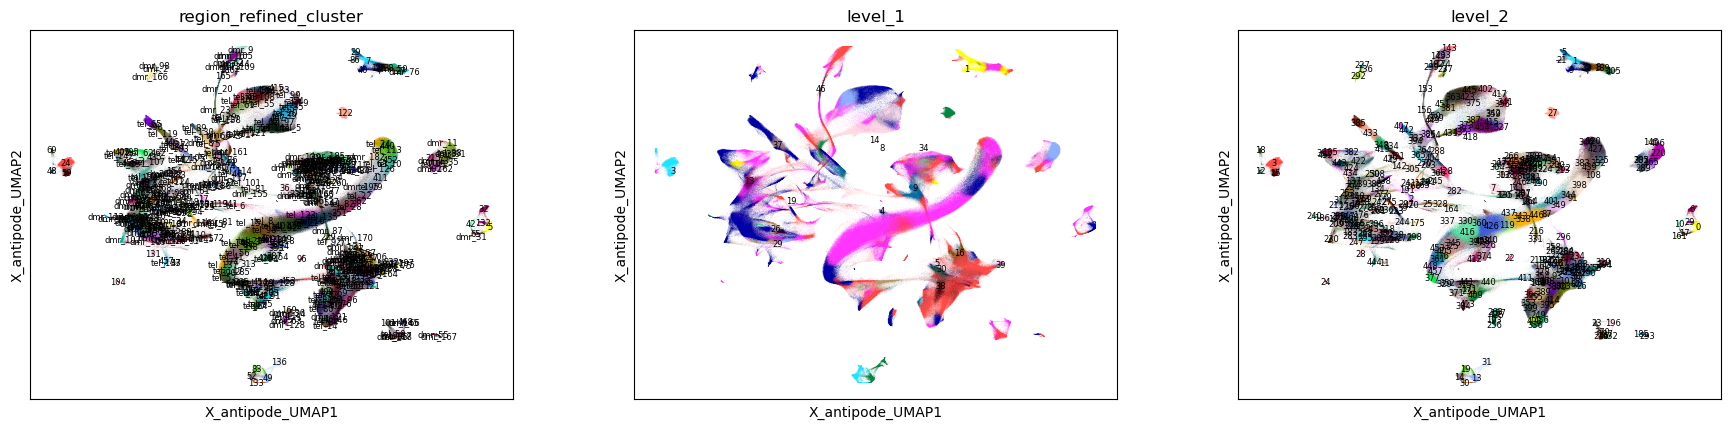

In [18]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["region_refined_cluster",'level_1',"level_2"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

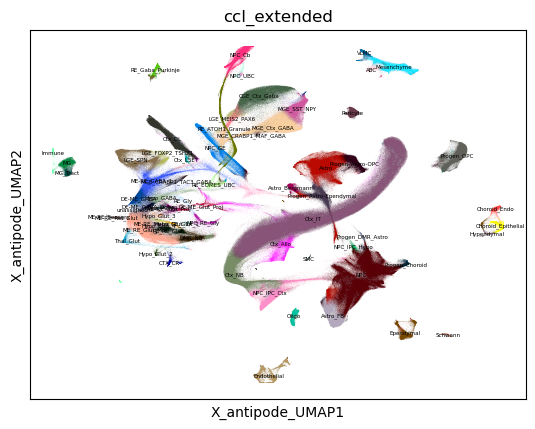

In [19]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["ccl_extended"],legend_fontsize=4,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)


In [20]:
# antipode_model=ANTIPODE.load(out_path,adata=adata,prefix='p5_',device=device)
# antipode_model.store_outputs(device=device, prefix='')


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


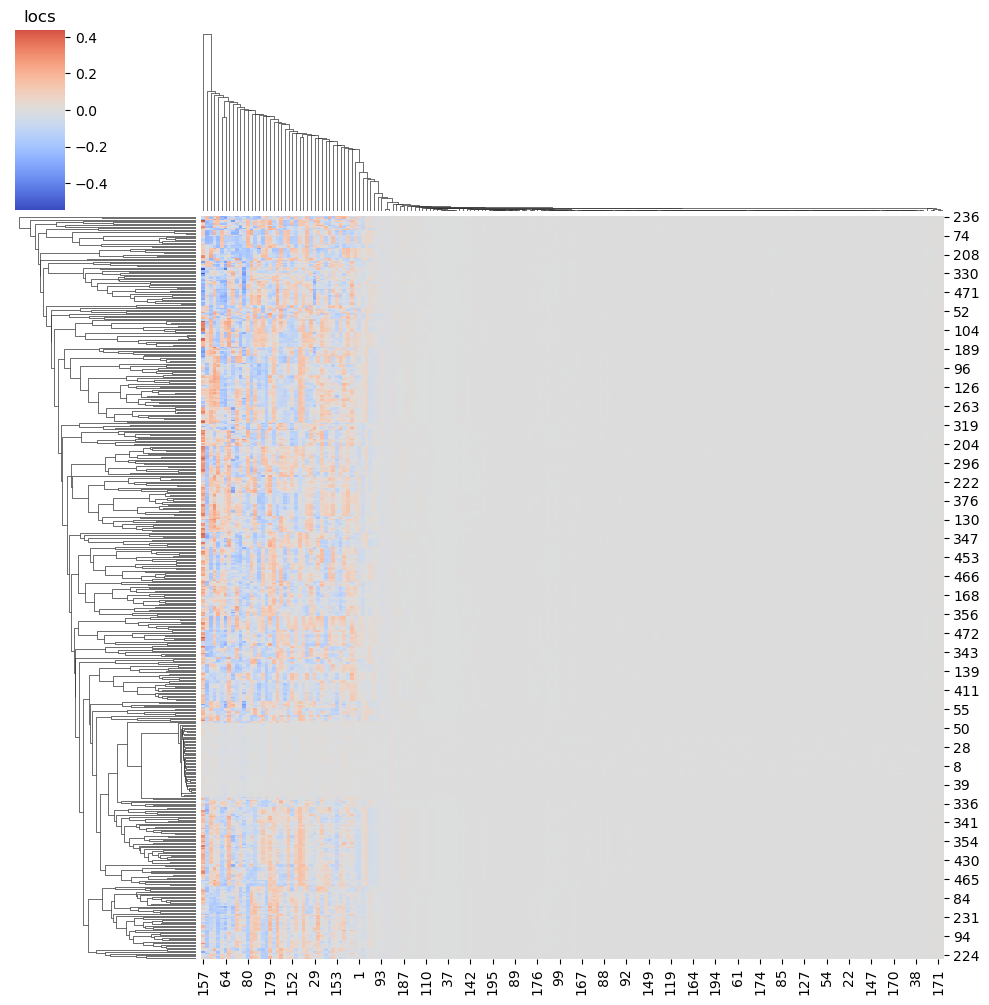

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


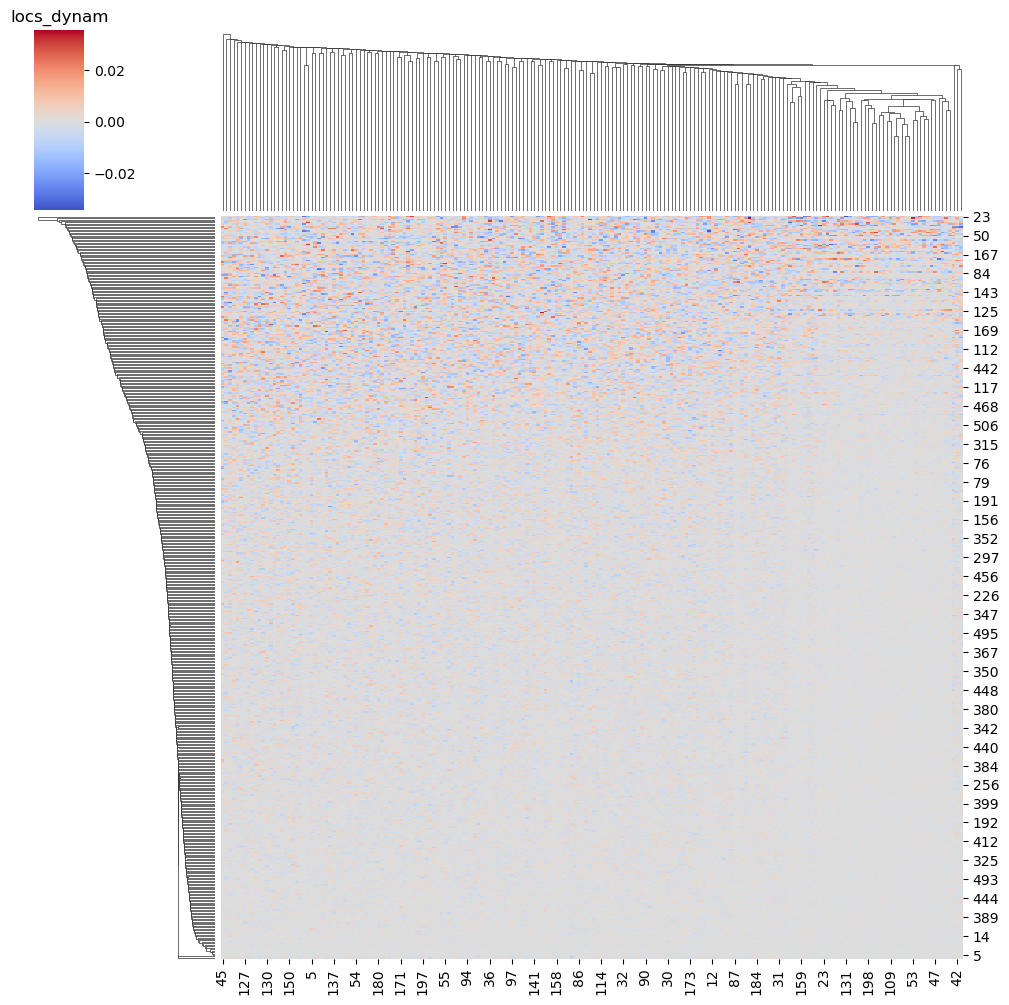

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


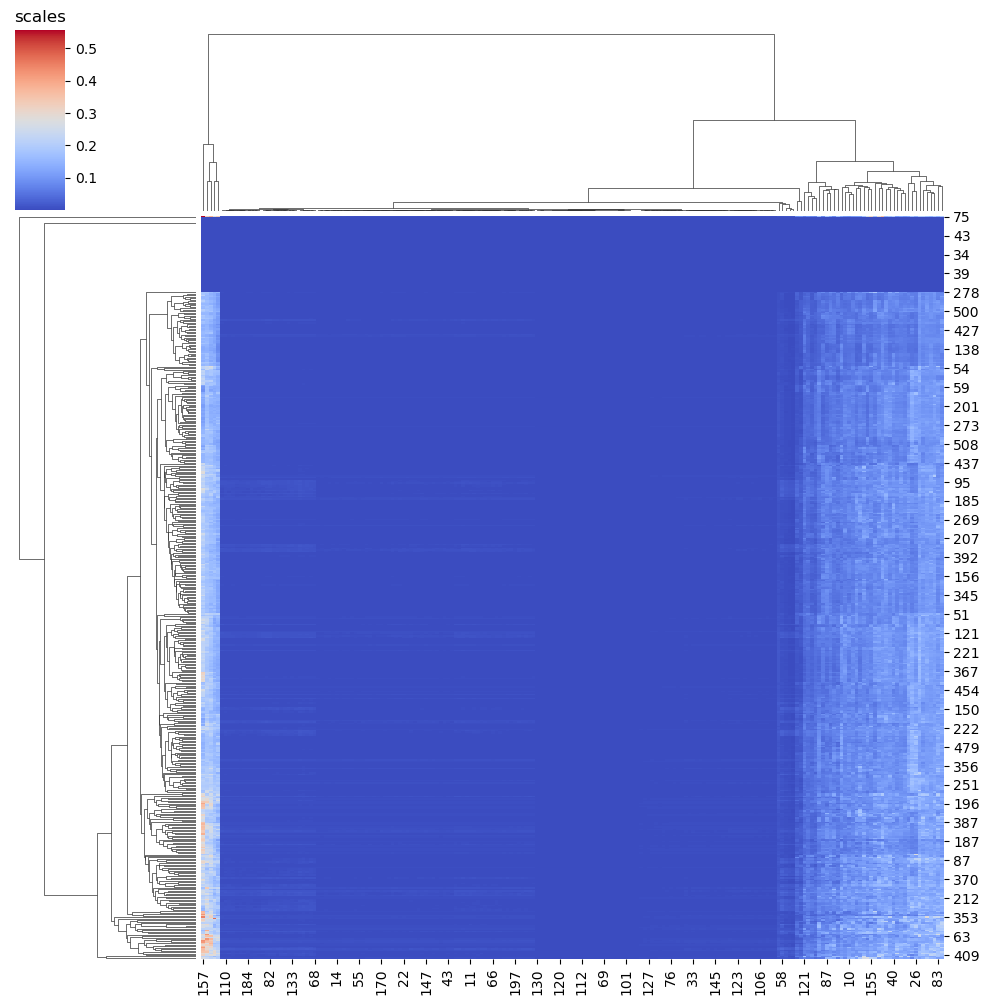

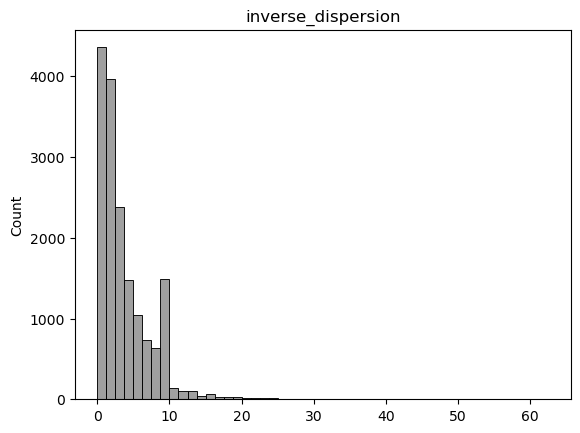

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


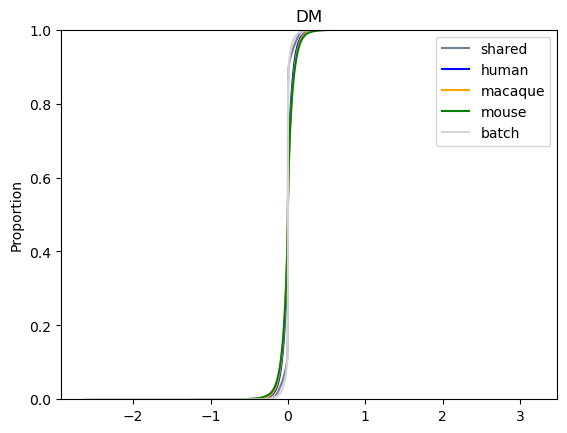

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


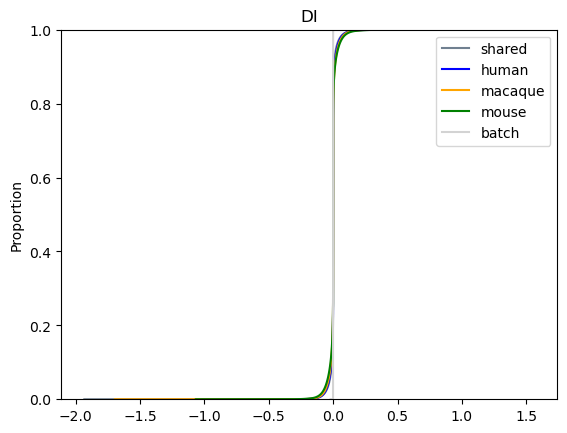

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


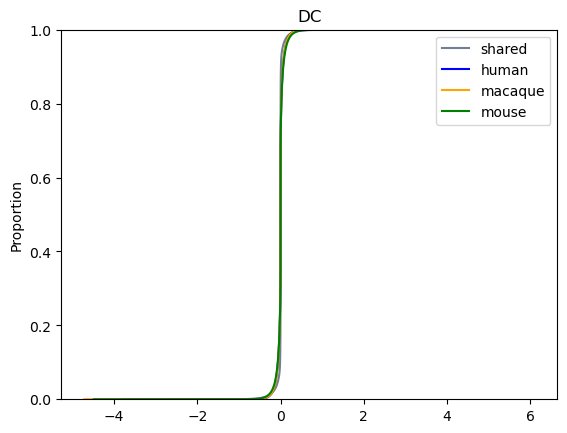

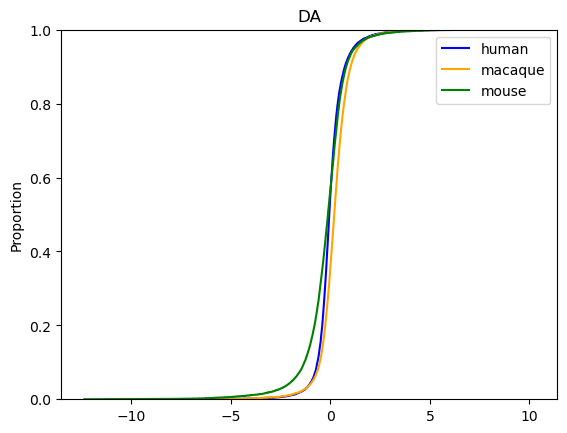

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(antipode_model.batch_key)[color_key]
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:103: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  seaborn.scatterplot(data=df, x=0, y=1, hue=color_key,palette = colors)


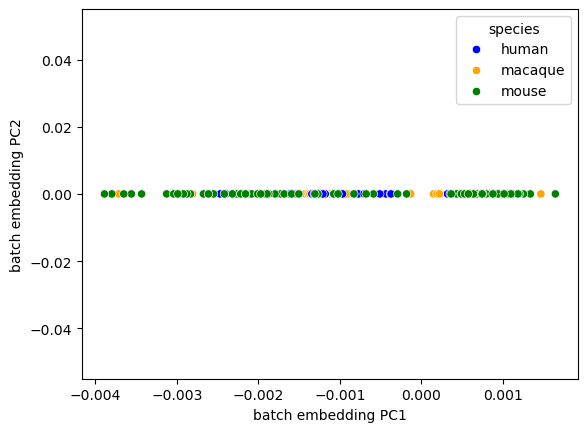

0    1                   batch_name species
0    0.001044  0.0        CS12OpticVesicle_kOut   human
1    0.000509  0.0  CS13_anterior_midbrain_kOut   human
2    0.000502  0.0   CS13_central_midbrain_kOut   human
3    0.000511  0.0          CS13_hindbrain_kOut   human
4    0.000605  0.0   CS13_olfactory_pacode_kOut   human
..        ...  ...                          ...     ...
403  0.000639  0.0                       p0-WT2   mouse
404  0.000576  0.0                       p0-WT3   mouse
405  0.000877  0.0                       p0-WT4   mouse
406 -0.002418  0.0       p07_Cortex_SRR11947654   mouse
407  0.001014  0.0       p07_Cortex_SRR11947655   mouse

[408 rows x 4 columns]

In [21]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model,ecdf=True)
plot_batch_embedding_pca(antipode_model)

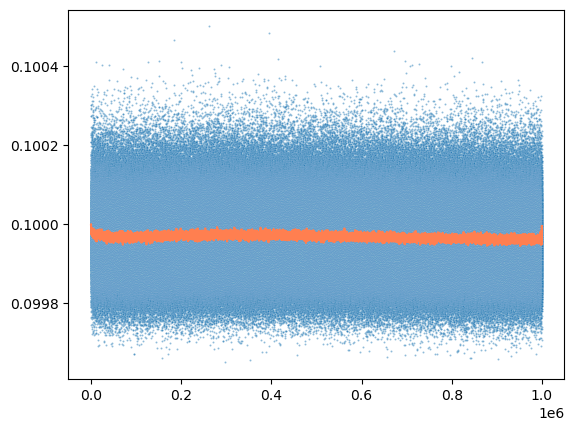

INFO     Generating sequential column names                                                                        


  0%|          | 0/55893 [00:00<?, ?it/s]

  0%|          | 41/55893 [00:00<02:18, 402.97it/s]

  0%|          | 91/55893 [00:00<02:02, 454.42it/s]

  0%|          | 142/55893 [00:00<01:57, 476.13it/s]

  0%|          | 198/55893 [00:00<01:50, 506.26it/s]

  0%|          | 253/55893 [00:00<01:46, 520.55it/s]

  1%|          | 308/55893 [00:00<01:45, 529.32it/s]

  1%|          | 363/55893 [00:00<01:43, 534.91it/s]

  1%|          | 418/55893 [00:00<01:42, 539.03it/s]

  1%|          | 473/55893 [00:00<01:42, 541.13it/s]

  1%|          | 528/55893 [00:01<01:44, 527.32it/s]

  1%|          | 584/55893 [00:01<01:43, 536.64it/s]

  1%|          | 640/55893 [00:01<01:41, 543.16it/s]

  1%|          | 696/55893 [00:01<01:40, 548.02it/s]

  1%|▏         | 751/55893 [00:01<01:40, 548.35it/s]

  1%|▏         | 808/55893 [00:01<01:39, 552.97it/s]

  2%|▏         | 865/55893 [00:01<01:38, 557.61it/s]

  2%|▏         | 921/55893 [00:01<01:38, 557.53it/s]

  2%|▏         | 977/55893 [00:01<01:40, 545.26it/s]

  2%|▏         | 1032/55893 [00:01<01:40, 546.37it/s]

  2%|▏         | 1088/55893 [00:02<01:39, 550.05it/s]

  2%|▏         | 1145/55893 [00:02<01:38, 554.85it/s]

  2%|▏         | 1201/55893 [00:02<01:41, 538.71it/s]

  2%|▏         | 1255/55893 [00:02<01:43, 525.55it/s]

  2%|▏         | 1308/55893 [00:02<01:44, 520.45it/s]

  2%|▏         | 1361/55893 [00:02<01:44, 521.08it/s]

  3%|▎         | 1416/55893 [00:02<01:43, 526.74it/s]

  3%|▎         | 1471/55893 [00:02<01:42, 531.61it/s]

  3%|▎         | 1525/55893 [00:02<01:42, 529.06it/s]

  3%|▎         | 1579/55893 [00:02<01:42, 531.44it/s]

  3%|▎         | 1634/55893 [00:03<01:41, 535.09it/s]

  3%|▎         | 1690/55893 [00:03<01:40, 540.38it/s]

  3%|▎         | 1745/55893 [00:03<01:39, 541.48it/s]

  3%|▎         | 1802/55893 [00:03<01:38, 547.64it/s]

  3%|▎         | 1859/55893 [00:03<01:37, 553.25it/s]

  3%|▎         | 1915/55893 [00:03<01:37, 552.55it/s]

  4%|▎         | 1971/55893 [00:03<01:39, 542.37it/s]

  4%|▎         | 2026/55893 [00:03<01:40, 538.07it/s]

  4%|▎         | 2080/55893 [00:03<01:40, 537.33it/s]

  4%|▍         | 2134/55893 [00:03<01:40, 535.09it/s]

  4%|▍         | 2188/55893 [00:04<01:41, 531.59it/s]

  4%|▍         | 2242/55893 [00:04<01:40, 531.25it/s]

  4%|▍         | 2297/55893 [00:04<01:40, 534.72it/s]

  4%|▍         | 2351/55893 [00:04<01:40, 532.35it/s]

  4%|▍         | 2405/55893 [00:04<01:41, 527.87it/s]

  4%|▍         | 2459/55893 [00:04<01:40, 530.05it/s]

  4%|▍         | 2513/55893 [00:04<01:42, 522.74it/s]

  5%|▍         | 2566/55893 [00:04<01:41, 523.16it/s]

  5%|▍         | 2619/55893 [00:04<01:42, 521.29it/s]

  5%|▍         | 2675/55893 [00:05<01:40, 530.15it/s]

  5%|▍         | 2729/55893 [00:05<01:41, 525.59it/s]

  5%|▍         | 2782/55893 [00:05<01:41, 524.28it/s]

  5%|▌         | 2835/55893 [00:05<01:41, 524.59it/s]

  5%|▌         | 2888/55893 [00:05<01:42, 519.20it/s]

  5%|▌         | 2941/55893 [00:05<01:41, 520.03it/s]

  5%|▌         | 2994/55893 [00:05<01:41, 521.44it/s]

  5%|▌         | 3047/55893 [00:05<01:41, 519.42it/s]

  6%|▌         | 3100/55893 [00:05<01:41, 522.45it/s]

  6%|▌         | 3153/55893 [00:05<01:41, 518.12it/s]

  6%|▌         | 3205/55893 [00:06<01:42, 516.44it/s]

  6%|▌         | 3259/55893 [00:06<01:40, 523.34it/s]

  6%|▌         | 3312/55893 [00:06<01:40, 525.07it/s]

  6%|▌         | 3365/55893 [00:06<01:40, 525.26it/s]

  6%|▌         | 3418/55893 [00:06<01:40, 522.89it/s]

  6%|▌         | 3471/55893 [00:06<01:40, 522.15it/s]

  6%|▋         | 3524/55893 [00:06<01:40, 523.18it/s]

  6%|▋         | 3577/55893 [00:06<01:40, 522.76it/s]

  6%|▋         | 3631/55893 [00:06<01:39, 527.34it/s]

  7%|▋         | 3684/55893 [00:06<01:39, 524.29it/s]

  7%|▋         | 3738/55893 [00:07<01:39, 526.72it/s]

  7%|▋         | 3792/55893 [00:07<01:38, 528.64it/s]

  7%|▋         | 3846/55893 [00:07<01:38, 529.78it/s]

  7%|▋         | 3901/55893 [00:07<01:37, 533.17it/s]

  7%|▋         | 3956/55893 [00:07<01:36, 537.83it/s]

  7%|▋         | 4011/55893 [00:07<01:36, 540.19it/s]

  7%|▋         | 4066/55893 [00:07<01:36, 538.74it/s]

  7%|▋         | 4120/55893 [00:07<01:36, 538.46it/s]

  7%|▋         | 4174/55893 [00:07<01:36, 534.08it/s]

  8%|▊         | 4228/55893 [00:07<01:36, 532.86it/s]

  8%|▊         | 4282/55893 [00:08<01:37, 530.13it/s]

  8%|▊         | 4336/55893 [00:08<01:37, 531.09it/s]

  8%|▊         | 4390/55893 [00:08<01:36, 531.97it/s]

  8%|▊         | 4445/55893 [00:08<01:36, 535.35it/s]

  8%|▊         | 4499/55893 [00:08<01:35, 536.00it/s]

  8%|▊         | 4553/55893 [00:08<01:35, 536.36it/s]

  8%|▊         | 4607/55893 [00:08<01:36, 533.14it/s]

  8%|▊         | 4662/55893 [00:08<01:35, 536.62it/s]

  8%|▊         | 4716/55893 [00:08<01:35, 536.26it/s]

  9%|▊         | 4770/55893 [00:08<01:35, 537.03it/s]

  9%|▊         | 4824/55893 [00:09<01:35, 534.85it/s]

  9%|▊         | 4878/55893 [00:09<01:35, 535.40it/s]

  9%|▉         | 4933/55893 [00:09<01:34, 538.09it/s]

  9%|▉         | 4988/55893 [00:09<01:34, 539.22it/s]

  9%|▉         | 5042/55893 [00:09<01:34, 537.53it/s]

  9%|▉         | 5096/55893 [00:09<01:34, 537.93it/s]

  9%|▉         | 5150/55893 [00:09<01:34, 537.80it/s]

  9%|▉         | 5206/55893 [00:09<01:33, 542.09it/s]

  9%|▉         | 5262/55893 [00:09<01:32, 544.52it/s]

 10%|▉         | 5317/55893 [00:09<01:32, 545.56it/s]

 10%|▉         | 5372/55893 [00:10<01:32, 544.40it/s]

 10%|▉         | 5427/55893 [00:10<01:32, 545.08it/s]

 10%|▉         | 5482/55893 [00:10<01:32, 543.94it/s]

 10%|▉         | 5537/55893 [00:10<01:33, 540.99it/s]

 10%|█         | 5592/55893 [00:10<01:33, 540.16it/s]

 10%|█         | 5647/55893 [00:10<01:32, 541.51it/s]

 10%|█         | 5702/55893 [00:10<01:33, 537.36it/s]

 10%|█         | 5756/55893 [00:10<01:33, 536.73it/s]

 10%|█         | 5811/55893 [00:10<01:32, 539.81it/s]

 10%|█         | 5865/55893 [00:10<01:32, 539.40it/s]

 11%|█         | 5921/55893 [00:11<01:31, 543.41it/s]

 11%|█         | 5976/55893 [00:11<01:33, 533.57it/s]

 11%|█         | 6030/55893 [00:11<01:33, 533.90it/s]

 11%|█         | 6085/55893 [00:11<01:32, 538.23it/s]

 11%|█         | 6139/55893 [00:11<01:32, 535.69it/s]

 11%|█         | 6194/55893 [00:11<01:32, 537.82it/s]

 11%|█         | 6249/55893 [00:11<01:32, 538.88it/s]

 11%|█▏        | 6303/55893 [00:11<01:32, 538.43it/s]

 11%|█▏        | 6358/55893 [00:11<01:31, 540.20it/s]

 11%|█▏        | 6413/55893 [00:12<01:31, 541.20it/s]

 12%|█▏        | 6468/55893 [00:12<01:31, 540.33it/s]

 12%|█▏        | 6523/55893 [00:12<01:31, 538.38it/s]

 12%|█▏        | 6577/55893 [00:12<01:31, 536.80it/s]

 12%|█▏        | 6631/55893 [00:12<01:31, 537.60it/s]

 12%|█▏        | 6687/55893 [00:12<01:30, 541.83it/s]

 12%|█▏        | 6742/55893 [00:12<01:31, 539.34it/s]

 12%|█▏        | 6797/55893 [00:12<01:30, 540.45it/s]

 12%|█▏        | 6852/55893 [00:12<01:30, 540.23it/s]

 12%|█▏        | 6907/55893 [00:12<01:30, 540.02it/s]

 12%|█▏        | 6962/55893 [00:13<01:30, 542.82it/s]

 13%|█▎        | 7017/55893 [00:13<01:30, 540.01it/s]

 13%|█▎        | 7072/55893 [00:13<01:30, 541.37it/s]

 13%|█▎        | 7127/55893 [00:13<01:29, 543.18it/s]

 13%|█▎        | 7182/55893 [00:13<01:29, 543.69it/s]

 13%|█▎        | 7237/55893 [00:13<01:29, 542.73it/s]

 13%|█▎        | 7292/55893 [00:13<01:29, 543.32it/s]

 13%|█▎        | 7347/55893 [00:13<01:29, 543.15it/s]

 13%|█▎        | 7402/55893 [00:13<01:30, 534.99it/s]

 13%|█▎        | 7456/55893 [00:13<01:31, 530.43it/s]

 13%|█▎        | 7511/55893 [00:14<01:30, 534.41it/s]

 14%|█▎        | 7565/55893 [00:14<01:30, 532.07it/s]

 14%|█▎        | 7619/55893 [00:14<01:30, 533.48it/s]

 14%|█▎        | 7674/55893 [00:14<01:29, 537.46it/s]

 14%|█▍        | 7728/55893 [00:14<01:29, 538.00it/s]

 14%|█▍        | 7784/55893 [00:14<01:28, 542.23it/s]

 14%|█▍        | 7839/55893 [00:14<01:28, 540.29it/s]

 14%|█▍        | 7894/55893 [00:14<01:28, 542.59it/s]

 14%|█▍        | 7949/55893 [00:14<01:28, 539.95it/s]

 14%|█▍        | 8004/55893 [00:14<01:28, 542.46it/s]

 14%|█▍        | 8059/55893 [00:15<01:27, 544.45it/s]

 15%|█▍        | 8114/55893 [00:15<01:27, 543.59it/s]

 15%|█▍        | 8169/55893 [00:15<01:28, 541.21it/s]

 15%|█▍        | 8224/55893 [00:15<01:27, 543.48it/s]

 15%|█▍        | 8279/55893 [00:15<01:27, 544.06it/s]

 15%|█▍        | 8334/55893 [00:15<01:27, 540.62it/s]

 15%|█▌        | 8389/55893 [00:15<01:27, 542.39it/s]

 15%|█▌        | 8444/55893 [00:15<01:27, 543.75it/s]

 15%|█▌        | 8499/55893 [00:15<01:26, 544.97it/s]

 15%|█▌        | 8554/55893 [00:15<01:27, 538.79it/s]

 15%|█▌        | 8608/55893 [00:16<01:28, 534.36it/s]

 15%|█▌        | 8663/55893 [00:16<01:27, 537.37it/s]

 16%|█▌        | 8717/55893 [00:16<01:28, 534.84it/s]

 16%|█▌        | 8772/55893 [00:16<01:27, 537.19it/s]

 16%|█▌        | 8826/55893 [00:16<01:28, 533.47it/s]

 16%|█▌        | 8880/55893 [00:16<01:27, 535.02it/s]

 16%|█▌        | 8934/55893 [00:16<01:27, 534.65it/s]

 16%|█▌        | 8988/55893 [00:16<01:27, 534.88it/s]

 16%|█▌        | 9043/55893 [00:16<01:27, 538.47it/s]

 16%|█▋        | 9097/55893 [00:16<01:27, 534.00it/s]

 16%|█▋        | 9151/55893 [00:17<01:27, 532.94it/s]

 16%|█▋        | 9206/55893 [00:17<01:27, 536.18it/s]

 17%|█▋        | 9260/55893 [00:17<01:28, 528.12it/s]

 17%|█▋        | 9313/55893 [00:17<01:29, 522.48it/s]

 17%|█▋        | 9368/55893 [00:17<01:28, 528.13it/s]

 17%|█▋        | 9422/55893 [00:17<01:27, 529.53it/s]

 17%|█▋        | 9475/55893 [00:17<01:27, 527.49it/s]

 17%|█▋        | 9529/55893 [00:17<01:27, 530.79it/s]

 17%|█▋        | 9583/55893 [00:17<01:27, 527.68it/s]

 17%|█▋        | 9638/55893 [00:18<01:26, 532.72it/s]

 17%|█▋        | 9692/55893 [00:18<01:27, 526.74it/s]

 17%|█▋        | 9745/55893 [00:18<01:28, 523.74it/s]

 18%|█▊        | 9798/55893 [00:18<01:28, 518.71it/s]

 18%|█▊        | 9850/55893 [00:18<01:29, 513.01it/s]

 18%|█▊        | 9902/55893 [00:18<01:30, 506.47it/s]

 18%|█▊        | 9953/55893 [00:18<01:31, 500.41it/s]

 18%|█▊        | 10005/55893 [00:18<01:31, 504.04it/s]

 18%|█▊        | 10061/55893 [00:18<01:28, 517.90it/s]

 18%|█▊        | 10113/55893 [00:18<01:28, 516.46it/s]

 18%|█▊        | 10166/55893 [00:19<01:27, 520.07it/s]

 18%|█▊        | 10219/55893 [00:19<01:28, 514.37it/s]

 18%|█▊        | 10271/55893 [00:19<01:28, 515.14it/s]

 18%|█▊        | 10326/55893 [00:19<01:27, 522.38it/s]

 19%|█▊        | 10379/55893 [00:19<01:27, 522.95it/s]

 19%|█▊        | 10432/55893 [00:19<01:26, 524.63it/s]

 19%|█▉        | 10485/55893 [00:19<01:26, 523.60it/s]

 19%|█▉        | 10540/55893 [00:19<01:25, 529.57it/s]

 19%|█▉        | 10593/55893 [00:19<01:25, 529.44it/s]

 19%|█▉        | 10648/55893 [00:19<01:24, 533.11it/s]

 19%|█▉        | 10702/55893 [00:20<01:25, 530.99it/s]

 19%|█▉        | 10757/55893 [00:20<01:24, 534.49it/s]

 19%|█▉        | 10811/55893 [00:20<01:25, 529.56it/s]

 19%|█▉        | 10865/55893 [00:20<01:24, 530.00it/s]

 20%|█▉        | 10919/55893 [00:20<01:24, 532.73it/s]

 20%|█▉        | 10973/55893 [00:20<01:24, 531.06it/s]

 20%|█▉        | 11027/55893 [00:20<01:24, 530.38it/s]

 20%|█▉        | 11081/55893 [00:20<01:24, 532.31it/s]

 20%|█▉        | 11137/55893 [00:20<01:23, 538.31it/s]

 20%|██        | 11191/55893 [00:20<01:23, 535.11it/s]

 20%|██        | 11245/55893 [00:21<01:23, 534.32it/s]

 20%|██        | 11299/55893 [00:21<01:23, 534.07it/s]

 20%|██        | 11353/55893 [00:21<01:23, 535.41it/s]

 20%|██        | 11407/55893 [00:21<01:23, 534.85it/s]

 21%|██        | 11461/55893 [00:21<01:23, 533.19it/s]

 21%|██        | 11515/55893 [00:21<01:23, 534.66it/s]

 21%|██        | 11570/55893 [00:21<01:22, 536.45it/s]

 21%|██        | 11625/55893 [00:21<01:22, 538.54it/s]

 21%|██        | 11680/55893 [00:21<01:21, 541.86it/s]

 21%|██        | 11736/55893 [00:21<01:20, 545.33it/s]

 21%|██        | 11792/55893 [00:22<01:20, 547.01it/s]

 21%|██        | 11848/55893 [00:22<01:20, 549.39it/s]

 21%|██▏       | 11903/55893 [00:22<01:20, 543.76it/s]

 21%|██▏       | 11958/55893 [00:22<01:20, 543.41it/s]

 21%|██▏       | 12014/55893 [00:22<01:20, 544.36it/s]

 22%|██▏       | 12070/55893 [00:22<01:20, 547.09it/s]

 22%|██▏       | 12125/55893 [00:22<01:19, 547.67it/s]

 22%|██▏       | 12181/55893 [00:22<01:19, 549.96it/s]

 22%|██▏       | 12238/55893 [00:22<01:18, 553.38it/s]

 22%|██▏       | 12294/55893 [00:23<01:18, 554.24it/s]

 22%|██▏       | 12350/55893 [00:23<01:19, 550.73it/s]

 22%|██▏       | 12406/55893 [00:23<01:19, 547.73it/s]

 22%|██▏       | 12461/55893 [00:23<01:19, 547.46it/s]

 22%|██▏       | 12517/55893 [00:23<01:19, 548.91it/s]

 22%|██▏       | 12573/55893 [00:23<01:18, 549.86it/s]

 23%|██▎       | 12628/55893 [00:23<01:18, 549.30it/s]

 23%|██▎       | 12685/55893 [00:23<01:18, 552.93it/s]

 23%|██▎       | 12742/55893 [00:23<01:17, 555.75it/s]

 23%|██▎       | 12798/55893 [00:23<01:18, 548.30it/s]

 23%|██▎       | 12853/55893 [00:24<01:18, 547.55it/s]

 23%|██▎       | 12908/55893 [00:24<01:18, 546.15it/s]

 23%|██▎       | 12964/55893 [00:24<01:18, 548.48it/s]

 23%|██▎       | 13020/55893 [00:24<01:18, 549.37it/s]

 23%|██▎       | 13076/55893 [00:24<01:17, 550.70it/s]

 23%|██▎       | 13132/55893 [00:24<01:17, 552.24it/s]

 24%|██▎       | 13188/55893 [00:24<01:17, 551.78it/s]

 24%|██▎       | 13244/55893 [00:24<01:17, 550.81it/s]

 24%|██▍       | 13300/55893 [00:24<01:17, 549.96it/s]

 24%|██▍       | 13355/55893 [00:24<01:17, 548.04it/s]

 24%|██▍       | 13410/55893 [00:25<01:18, 544.38it/s]

 24%|██▍       | 13465/55893 [00:25<01:17, 544.17it/s]

 24%|██▍       | 13520/55893 [00:25<01:17, 545.21it/s]

 24%|██▍       | 13576/55893 [00:25<01:17, 547.62it/s]

 24%|██▍       | 13631/55893 [00:25<01:17, 547.32it/s]

 24%|██▍       | 13687/55893 [00:25<01:16, 550.70it/s]

 25%|██▍       | 13743/55893 [00:25<01:16, 551.41it/s]

 25%|██▍       | 13799/55893 [00:25<01:17, 543.35it/s]

 25%|██▍       | 13854/55893 [00:25<01:17, 540.39it/s]

 25%|██▍       | 13909/55893 [00:25<01:17, 538.57it/s]

 25%|██▍       | 13964/55893 [00:26<01:17, 539.41it/s]

 25%|██▌       | 14019/55893 [00:26<01:17, 540.71it/s]

 25%|██▌       | 14074/55893 [00:26<01:17, 537.92it/s]

 25%|██▌       | 14128/55893 [00:26<01:18, 529.75it/s]

 25%|██▌       | 14181/55893 [00:26<01:19, 527.10it/s]

 25%|██▌       | 14235/55893 [00:26<01:18, 529.26it/s]

 26%|██▌       | 14290/55893 [00:26<01:18, 533.20it/s]

 26%|██▌       | 14345/55893 [00:26<01:17, 537.95it/s]

 26%|██▌       | 14401/55893 [00:26<01:16, 541.96it/s]

 26%|██▌       | 14456/55893 [00:26<01:16, 544.05it/s]

 26%|██▌       | 14511/55893 [00:27<01:16, 538.37it/s]

 26%|██▌       | 14565/55893 [00:27<01:18, 527.38it/s]

 26%|██▌       | 14618/55893 [00:27<01:19, 519.78it/s]

 26%|██▌       | 14671/55893 [00:27<01:19, 519.28it/s]

 26%|██▋       | 14725/55893 [00:27<01:18, 523.83it/s]

 26%|██▋       | 14780/55893 [00:27<01:17, 530.70it/s]

 27%|██▋       | 14834/55893 [00:27<01:17, 529.56it/s]

 27%|██▋       | 14888/55893 [00:27<01:17, 531.82it/s]

 27%|██▋       | 14942/55893 [00:27<01:17, 529.94it/s]

 27%|██▋       | 14996/55893 [00:28<01:16, 531.63it/s]

 27%|██▋       | 15051/55893 [00:28<01:16, 536.55it/s]

 27%|██▋       | 15105/55893 [00:28<01:16, 534.58it/s]

 27%|██▋       | 15160/55893 [00:28<01:15, 538.76it/s]

 27%|██▋       | 15214/55893 [00:28<01:15, 537.64it/s]

 27%|██▋       | 15268/55893 [00:28<01:15, 535.71it/s]

 27%|██▋       | 15323/55893 [00:28<01:15, 538.43it/s]

 28%|██▊       | 15377/55893 [00:28<01:15, 537.08it/s]

 28%|██▊       | 15432/55893 [00:28<01:15, 538.05it/s]

 28%|██▊       | 15488/55893 [00:28<01:14, 542.85it/s]

 28%|██▊       | 15543/55893 [00:29<01:14, 538.21it/s]

 28%|██▊       | 15597/55893 [00:29<01:15, 535.89it/s]

 28%|██▊       | 15651/55893 [00:29<01:15, 535.27it/s]

 28%|██▊       | 15706/55893 [00:29<01:14, 538.09it/s]

 28%|██▊       | 15761/55893 [00:29<01:14, 539.39it/s]

 28%|██▊       | 15816/55893 [00:29<01:14, 540.86it/s]

 28%|██▊       | 15871/55893 [00:29<01:13, 543.10it/s]

 28%|██▊       | 15927/55893 [00:29<01:13, 547.23it/s]

 29%|██▊       | 15982/55893 [00:29<01:13, 543.94it/s]

 29%|██▊       | 16037/55893 [00:29<01:13, 543.80it/s]

 29%|██▉       | 16092/55893 [00:30<01:13, 544.55it/s]

 29%|██▉       | 16147/55893 [00:30<01:13, 542.03it/s]

 29%|██▉       | 16202/55893 [00:30<01:13, 542.16it/s]

 29%|██▉       | 16257/55893 [00:30<01:12, 543.65it/s]

 29%|██▉       | 16313/55893 [00:30<01:12, 546.44it/s]

 29%|██▉       | 16368/55893 [00:30<01:12, 543.92it/s]

 29%|██▉       | 16423/55893 [00:30<01:12, 544.48it/s]

 29%|██▉       | 16478/55893 [00:30<01:12, 544.19it/s]

 30%|██▉       | 16534/55893 [00:30<01:12, 546.52it/s]

 30%|██▉       | 16590/55893 [00:30<01:11, 548.57it/s]

 30%|██▉       | 16646/55893 [00:31<01:11, 549.59it/s]

 30%|██▉       | 16702/55893 [00:31<01:10, 552.65it/s]

 30%|██▉       | 16758/55893 [00:31<01:11, 548.95it/s]

 30%|███       | 16813/55893 [00:31<01:11, 546.22it/s]

 30%|███       | 16868/55893 [00:31<01:12, 540.05it/s]

 30%|███       | 16923/55893 [00:31<01:12, 538.16it/s]

 30%|███       | 16977/55893 [00:31<01:12, 538.07it/s]

 30%|███       | 17032/55893 [00:31<01:11, 541.20it/s]

 31%|███       | 17087/55893 [00:31<01:12, 535.06it/s]

 31%|███       | 17141/55893 [00:31<01:12, 534.18it/s]

 31%|███       | 17195/55893 [00:32<01:12, 534.88it/s]

 31%|███       | 17250/55893 [00:32<01:11, 537.72it/s]

 31%|███       | 17304/55893 [00:32<01:11, 537.01it/s]

 31%|███       | 17358/55893 [00:32<01:11, 536.56it/s]

 31%|███       | 17412/55893 [00:32<01:11, 537.27it/s]

 31%|███▏      | 17467/55893 [00:32<01:11, 539.78it/s]

 31%|███▏      | 17521/55893 [00:32<01:12, 528.29it/s]

 31%|███▏      | 17574/55893 [00:32<01:12, 527.82it/s]

 32%|███▏      | 17628/55893 [00:32<01:12, 528.79it/s]

 32%|███▏      | 17681/55893 [00:32<01:12, 523.89it/s]

 32%|███▏      | 17734/55893 [00:33<01:12, 523.65it/s]

 32%|███▏      | 17788/55893 [00:33<01:12, 527.20it/s]

 32%|███▏      | 17842/55893 [00:33<01:11, 530.60it/s]

 32%|███▏      | 17896/55893 [00:33<01:12, 523.40it/s]

 32%|███▏      | 17949/55893 [00:33<01:13, 519.46it/s]

 32%|███▏      | 18002/55893 [00:33<01:12, 520.16it/s]

 32%|███▏      | 18056/55893 [00:33<01:12, 523.38it/s]

 32%|███▏      | 18109/55893 [00:33<01:12, 523.84it/s]

 32%|███▏      | 18162/55893 [00:33<01:12, 518.56it/s]

 33%|███▎      | 18216/55893 [00:34<01:11, 524.66it/s]

 33%|███▎      | 18271/55893 [00:34<01:10, 531.79it/s]

 33%|███▎      | 18325/55893 [00:34<01:10, 534.09it/s]

 33%|███▎      | 18380/55893 [00:34<01:09, 536.47it/s]

 33%|███▎      | 18436/55893 [00:34<01:09, 540.81it/s]

 33%|███▎      | 18491/55893 [00:34<01:10, 534.17it/s]

 33%|███▎      | 18545/55893 [00:34<01:10, 529.43it/s]

 33%|███▎      | 18598/55893 [00:34<01:10, 527.38it/s]

 33%|███▎      | 18651/55893 [00:34<01:10, 527.26it/s]

 33%|███▎      | 18705/55893 [00:34<01:10, 531.01it/s]

 34%|███▎      | 18760/55893 [00:35<01:09, 534.88it/s]

 34%|███▎      | 18814/55893 [00:35<01:09, 532.58it/s]

 34%|███▍      | 18868/55893 [00:35<01:09, 533.99it/s]

 34%|███▍      | 18922/55893 [00:35<01:10, 524.50it/s]

 34%|███▍      | 18976/55893 [00:35<01:10, 526.40it/s]

 34%|███▍      | 19031/55893 [00:35<01:09, 533.34it/s]

 34%|███▍      | 19085/55893 [00:35<01:09, 533.08it/s]

 34%|███▍      | 19139/55893 [00:35<01:08, 534.40it/s]

 34%|███▍      | 19193/55893 [00:35<01:08, 534.28it/s]

 34%|███▍      | 19247/55893 [00:35<01:08, 535.64it/s]

 35%|███▍      | 19303/55893 [00:36<01:07, 540.20it/s]

 35%|███▍      | 19358/55893 [00:36<01:08, 536.72it/s]

 35%|███▍      | 19412/55893 [00:36<01:08, 534.65it/s]

 35%|███▍      | 19467/55893 [00:36<01:07, 537.82it/s]

 35%|███▍      | 19522/55893 [00:36<01:07, 540.60it/s]

 35%|███▌      | 19577/55893 [00:36<01:08, 530.08it/s]

 35%|███▌      | 19631/55893 [00:36<01:08, 527.40it/s]

 35%|███▌      | 19685/55893 [00:36<01:08, 529.52it/s]

 35%|███▌      | 19739/55893 [00:36<01:07, 531.88it/s]

 35%|███▌      | 19794/55893 [00:36<01:07, 536.33it/s]

 36%|███▌      | 19850/55893 [00:37<01:06, 541.46it/s]

 36%|███▌      | 19905/55893 [00:37<01:06, 538.93it/s]

 36%|███▌      | 19959/55893 [00:37<01:06, 537.86it/s]

 36%|███▌      | 20014/55893 [00:37<01:06, 541.16it/s]

 36%|███▌      | 20070/55893 [00:37<01:05, 543.58it/s]

 36%|███▌      | 20125/55893 [00:37<01:07, 528.16it/s]

 36%|███▌      | 20178/55893 [00:37<01:08, 524.36it/s]

 36%|███▌      | 20231/55893 [00:37<01:08, 524.08it/s]

 36%|███▋      | 20284/55893 [00:37<01:08, 521.03it/s]

 36%|███▋      | 20337/55893 [00:37<01:08, 520.74it/s]

 36%|███▋      | 20390/55893 [00:38<01:08, 521.70it/s]

 37%|███▋      | 20444/55893 [00:38<01:07, 524.34it/s]

 37%|███▋      | 20497/55893 [00:38<01:07, 525.18it/s]

 37%|███▋      | 20552/55893 [00:38<01:06, 530.55it/s]

 37%|███▋      | 20607/55893 [00:38<01:06, 534.40it/s]

 37%|███▋      | 20662/55893 [00:38<01:05, 537.08it/s]

 37%|███▋      | 20717/55893 [00:38<01:05, 539.11it/s]

 37%|███▋      | 20771/55893 [00:38<01:05, 538.09it/s]

 37%|███▋      | 20826/55893 [00:38<01:04, 540.46it/s]

 37%|███▋      | 20882/55893 [00:39<01:04, 543.71it/s]

 37%|███▋      | 20937/55893 [00:39<01:04, 539.78it/s]

 38%|███▊      | 20991/55893 [00:39<01:05, 534.01it/s]

 38%|███▊      | 21046/55893 [00:39<01:05, 535.84it/s]

 38%|███▊      | 21101/55893 [00:39<01:04, 539.21it/s]

 38%|███▊      | 21156/55893 [00:39<01:04, 542.33it/s]

 38%|███▊      | 21211/55893 [00:39<01:04, 537.58it/s]

 38%|███▊      | 21266/55893 [00:39<01:04, 540.52it/s]

 38%|███▊      | 21321/55893 [00:39<01:04, 534.10it/s]

 38%|███▊      | 21375/55893 [00:39<01:04, 531.65it/s]

 38%|███▊      | 21429/55893 [00:40<01:04, 532.08it/s]

 38%|███▊      | 21484/55893 [00:40<01:04, 536.36it/s]

 39%|███▊      | 21540/55893 [00:40<01:03, 540.60it/s]

 39%|███▊      | 21595/55893 [00:40<01:04, 530.31it/s]

 39%|███▊      | 21649/55893 [00:40<01:05, 526.18it/s]

 39%|███▉      | 21703/55893 [00:40<01:04, 529.87it/s]

 39%|███▉      | 21758/55893 [00:40<01:03, 534.65it/s]

 39%|███▉      | 21813/55893 [00:40<01:03, 538.87it/s]

 39%|███▉      | 21868/55893 [00:40<01:02, 541.53it/s]

 39%|███▉      | 21924/55893 [00:40<01:02, 545.01it/s]

 39%|███▉      | 21979/55893 [00:41<01:02, 542.46it/s]

 39%|███▉      | 22034/55893 [00:41<01:03, 536.35it/s]

 40%|███▉      | 22088/55893 [00:41<01:03, 530.50it/s]

 40%|███▉      | 22142/55893 [00:41<01:03, 532.75it/s]

 40%|███▉      | 22196/55893 [00:41<01:03, 532.61it/s]

 40%|███▉      | 22250/55893 [00:41<01:04, 525.61it/s]

 40%|███▉      | 22303/55893 [00:41<01:04, 523.92it/s]

 40%|███▉      | 22356/55893 [00:41<01:03, 525.46it/s]

 40%|████      | 22409/55893 [00:41<01:03, 526.71it/s]

 40%|████      | 22462/55893 [00:41<01:03, 522.81it/s]

 40%|████      | 22517/55893 [00:42<01:03, 528.21it/s]

 40%|████      | 22570/55893 [00:42<01:03, 527.18it/s]

 40%|████      | 22624/55893 [00:42<01:02, 530.45it/s]

 41%|████      | 22678/55893 [00:42<01:03, 526.74it/s]

 41%|████      | 22731/55893 [00:42<01:03, 519.17it/s]

 41%|████      | 22783/55893 [00:42<01:04, 515.84it/s]

 41%|████      | 22835/55893 [00:42<01:04, 516.48it/s]

 41%|████      | 22887/55893 [00:42<01:03, 517.03it/s]

 41%|████      | 22940/55893 [00:42<01:03, 520.37it/s]

 41%|████      | 22993/55893 [00:42<01:03, 514.09it/s]

 41%|████      | 23045/55893 [00:43<01:04, 508.44it/s]

 41%|████▏     | 23098/55893 [00:43<01:04, 512.30it/s]

 41%|████▏     | 23152/55893 [00:43<01:03, 518.05it/s]

 42%|████▏     | 23204/55893 [00:43<01:03, 512.82it/s]

 42%|████▏     | 23256/55893 [00:43<01:04, 506.67it/s]

 42%|████▏     | 23308/55893 [00:43<01:04, 508.11it/s]

 42%|████▏     | 23361/55893 [00:43<01:03, 514.10it/s]

 42%|████▏     | 23416/55893 [00:43<01:02, 523.63it/s]

 42%|████▏     | 23469/55893 [00:43<01:03, 511.43it/s]

 42%|████▏     | 23521/55893 [00:44<01:03, 512.65it/s]

 42%|████▏     | 23575/55893 [00:44<01:02, 519.39it/s]

 42%|████▏     | 23627/55893 [00:44<01:03, 508.30it/s]

 42%|████▏     | 23680/55893 [00:44<01:02, 512.00it/s]

 42%|████▏     | 23735/55893 [00:44<01:01, 520.39it/s]

 43%|████▎     | 23790/55893 [00:44<01:00, 527.95it/s]

 43%|████▎     | 23844/55893 [00:44<01:00, 529.76it/s]

 43%|████▎     | 23899/55893 [00:44<00:59, 534.39it/s]

 43%|████▎     | 23953/55893 [00:44<01:00, 526.68it/s]

 43%|████▎     | 24006/55893 [00:44<01:00, 527.14it/s]

 43%|████▎     | 24060/55893 [00:45<01:00, 529.92it/s]

 43%|████▎     | 24115/55893 [00:45<00:59, 534.87it/s]

 43%|████▎     | 24169/55893 [00:45<00:59, 530.43it/s]

 43%|████▎     | 24223/55893 [00:45<01:00, 523.13it/s]

 43%|████▎     | 24276/55893 [00:45<01:00, 522.17it/s]

 44%|████▎     | 24330/55893 [00:45<01:00, 524.80it/s]

 44%|████▎     | 24383/55893 [00:45<01:00, 519.10it/s]

 44%|████▎     | 24435/55893 [00:45<01:00, 518.72it/s]

 44%|████▍     | 24489/55893 [00:45<01:00, 522.84it/s]

 44%|████▍     | 24544/55893 [00:45<00:59, 528.82it/s]

 44%|████▍     | 24597/55893 [00:46<00:59, 528.18it/s]

 44%|████▍     | 24651/55893 [00:46<00:58, 529.74it/s]

 44%|████▍     | 24705/55893 [00:46<00:58, 531.95it/s]

 44%|████▍     | 24760/55893 [00:46<00:58, 536.22it/s]

 44%|████▍     | 24816/55893 [00:46<00:57, 541.27it/s]

 44%|████▍     | 24871/55893 [00:46<02:06, 245.52it/s]

 45%|████▍     | 24928/55893 [00:47<01:44, 297.64it/s]

 45%|████▍     | 24980/55893 [00:47<01:31, 339.04it/s]

 45%|████▍     | 25034/55893 [00:47<01:21, 380.74it/s]

 45%|████▍     | 25089/55893 [00:47<01:13, 418.30it/s]

 45%|████▍     | 25144/55893 [00:47<01:08, 450.27it/s]

 45%|████▌     | 25200/55893 [00:47<01:04, 476.86it/s]

 45%|████▌     | 25256/55893 [00:47<01:01, 497.66it/s]

 45%|████▌     | 25312/55893 [00:47<00:59, 514.02it/s]

 45%|████▌     | 25368/55893 [00:47<00:58, 525.84it/s]

 45%|████▌     | 25425/55893 [00:47<00:56, 536.23it/s]

 46%|████▌     | 25481/55893 [00:48<00:56, 541.35it/s]

 46%|████▌     | 25537/55893 [00:48<00:55, 544.24it/s]

 46%|████▌     | 25593/55893 [00:48<00:55, 547.59it/s]

 46%|████▌     | 25650/55893 [00:48<00:54, 553.31it/s]

 46%|████▌     | 25706/55893 [00:48<00:54, 554.03it/s]

 46%|████▌     | 25763/55893 [00:48<00:54, 557.08it/s]

 46%|████▌     | 25819/55893 [00:48<00:53, 557.22it/s]

 46%|████▋     | 25876/55893 [00:48<00:53, 559.57it/s]

 46%|████▋     | 25933/55893 [00:48<00:53, 556.81it/s]

 46%|████▋     | 25989/55893 [00:49<00:54, 548.26it/s]

 47%|████▋     | 26044/55893 [00:49<00:54, 545.58it/s]

 47%|████▋     | 26099/55893 [00:49<00:54, 544.72it/s]

 47%|████▋     | 26154/55893 [00:49<00:54, 545.57it/s]

 47%|████▋     | 26210/55893 [00:49<00:54, 547.28it/s]

 47%|████▋     | 26266/55893 [00:49<00:53, 549.49it/s]

 47%|████▋     | 26321/55893 [00:49<00:54, 545.35it/s]

 47%|████▋     | 26376/55893 [00:49<00:54, 539.06it/s]

 47%|████▋     | 26430/55893 [00:49<00:54, 539.03it/s]

 47%|████▋     | 26484/55893 [00:49<00:54, 537.51it/s]

 47%|████▋     | 26539/55893 [00:50<00:54, 539.81it/s]

 48%|████▊     | 26595/55893 [00:50<00:53, 542.82it/s]

 48%|████▊     | 26650/55893 [00:50<00:54, 540.16it/s]

 48%|████▊     | 26706/55893 [00:50<00:53, 543.95it/s]

 48%|████▊     | 26761/55893 [00:50<00:54, 533.36it/s]

 48%|████▊     | 26815/55893 [00:50<00:55, 526.96it/s]

 48%|████▊     | 26868/55893 [00:50<00:55, 526.70it/s]

 48%|████▊     | 26922/55893 [00:50<00:54, 529.72it/s]

 48%|████▊     | 26976/55893 [00:50<00:54, 530.11it/s]

 48%|████▊     | 27030/55893 [00:50<00:54, 525.68it/s]

 48%|████▊     | 27085/55893 [00:51<00:54, 530.82it/s]

 49%|████▊     | 27140/55893 [00:51<00:53, 535.84it/s]

 49%|████▊     | 27194/55893 [00:51<00:53, 535.99it/s]

 49%|████▉     | 27250/55893 [00:51<00:53, 540.32it/s]

 49%|████▉     | 27306/55893 [00:51<00:52, 545.74it/s]

 49%|████▉     | 27361/55893 [00:51<00:52, 542.98it/s]

 49%|████▉     | 27416/55893 [00:51<00:52, 542.16it/s]

 49%|████▉     | 27472/55893 [00:51<00:52, 545.22it/s]

 49%|████▉     | 27527/55893 [00:51<00:52, 543.80it/s]

 49%|████▉     | 27582/55893 [00:51<00:52, 540.89it/s]

 49%|████▉     | 27637/55893 [00:52<00:52, 541.22it/s]

 50%|████▉     | 27693/55893 [00:52<00:51, 544.64it/s]

 50%|████▉     | 27748/55893 [00:52<00:51, 543.51it/s]

 50%|████▉     | 27804/55893 [00:52<00:51, 546.60it/s]

 50%|████▉     | 27859/55893 [00:52<00:51, 545.56it/s]

 50%|████▉     | 27914/55893 [00:52<00:51, 544.07it/s]

 50%|█████     | 27970/55893 [00:52<00:51, 545.95it/s]

 50%|█████     | 28025/55893 [00:52<00:51, 544.96it/s]

 50%|█████     | 28080/55893 [00:52<00:51, 544.41it/s]

 50%|█████     | 28135/55893 [00:52<00:51, 542.77it/s]

 50%|█████     | 28190/55893 [00:53<00:51, 540.18it/s]

 51%|█████     | 28245/55893 [00:53<00:50, 542.61it/s]

 51%|█████     | 28300/55893 [00:53<00:51, 539.78it/s]

 51%|█████     | 28355/55893 [00:53<00:50, 540.02it/s]

 51%|█████     | 28410/55893 [00:53<00:51, 534.53it/s]

 51%|█████     | 28465/55893 [00:53<00:50, 538.63it/s]

 51%|█████     | 28519/55893 [00:53<00:50, 537.20it/s]

 51%|█████     | 28574/55893 [00:53<00:50, 540.12it/s]

 51%|█████     | 28629/55893 [00:53<00:50, 540.28it/s]

 51%|█████▏    | 28685/55893 [00:53<00:49, 544.26it/s]

 51%|█████▏    | 28742/55893 [00:54<00:49, 549.66it/s]

 52%|█████▏    | 28799/55893 [00:54<00:48, 554.08it/s]

 52%|█████▏    | 28856/55893 [00:54<00:48, 555.95it/s]

 52%|█████▏    | 28912/55893 [00:54<00:48, 552.49it/s]

 52%|█████▏    | 28968/55893 [00:54<00:48, 549.80it/s]

 52%|█████▏    | 29024/55893 [00:54<00:48, 551.91it/s]

 52%|█████▏    | 29080/55893 [00:54<00:48, 551.58it/s]

 52%|█████▏    | 29136/55893 [00:54<00:48, 553.59it/s]

 52%|█████▏    | 29192/55893 [00:54<00:48, 555.14it/s]

 52%|█████▏    | 29248/55893 [00:55<00:48, 553.84it/s]

 52%|█████▏    | 29304/55893 [00:55<00:48, 545.94it/s]

 53%|█████▎    | 29359/55893 [00:55<00:48, 545.61it/s]

 53%|█████▎    | 29416/55893 [00:55<00:48, 550.32it/s]

 53%|█████▎    | 29473/55893 [00:55<00:47, 554.87it/s]

 53%|█████▎    | 29530/55893 [00:55<00:47, 557.61it/s]

 53%|█████▎    | 29586/55893 [00:55<00:47, 555.37it/s]

 53%|█████▎    | 29642/55893 [00:55<00:47, 549.47it/s]

 53%|█████▎    | 29698/55893 [00:55<00:47, 550.25it/s]

 53%|█████▎    | 29754/55893 [00:55<00:47, 552.13it/s]

 53%|█████▎    | 29810/55893 [00:56<00:47, 553.51it/s]

 53%|█████▎    | 29867/55893 [00:56<00:46, 556.32it/s]

 54%|█████▎    | 29924/55893 [00:56<00:46, 558.39it/s]

 54%|█████▎    | 29980/55893 [00:56<00:46, 554.48it/s]

 54%|█████▎    | 30036/55893 [00:56<00:46, 555.55it/s]

 54%|█████▍    | 30092/55893 [00:56<00:46, 555.99it/s]

 54%|█████▍    | 30148/55893 [00:56<00:46, 550.56it/s]

 54%|█████▍    | 30204/55893 [00:56<00:46, 550.42it/s]

 54%|█████▍    | 30260/55893 [00:56<00:46, 548.86it/s]

 54%|█████▍    | 30316/55893 [00:56<00:46, 550.88it/s]

 54%|█████▍    | 30373/55893 [00:57<00:46, 553.98it/s]

 54%|█████▍    | 30429/55893 [00:57<00:46, 552.63it/s]

 55%|█████▍    | 30485/55893 [00:57<00:45, 553.26it/s]

 55%|█████▍    | 30541/55893 [00:57<00:45, 552.32it/s]

 55%|█████▍    | 30598/55893 [00:57<00:45, 556.18it/s]

 55%|█████▍    | 30655/55893 [00:57<00:45, 559.85it/s]

 55%|█████▍    | 30711/55893 [00:57<00:45, 555.50it/s]

 55%|█████▌    | 30767/55893 [00:57<00:45, 554.67it/s]

 55%|█████▌    | 30824/55893 [00:57<00:45, 556.49it/s]

 55%|█████▌    | 30880/55893 [00:57<00:45, 555.22it/s]

 55%|█████▌    | 30936/55893 [00:58<00:45, 553.60it/s]

 55%|█████▌    | 30992/55893 [00:58<00:45, 551.59it/s]

 56%|█████▌    | 31048/55893 [00:58<00:44, 553.10it/s]

 56%|█████▌    | 31104/55893 [00:58<00:44, 551.46it/s]

 56%|█████▌    | 31160/55893 [00:58<00:45, 549.50it/s]

 56%|█████▌    | 31216/55893 [00:58<00:44, 550.55it/s]

 56%|█████▌    | 31272/55893 [00:58<00:44, 552.52it/s]

 56%|█████▌    | 31328/55893 [00:58<00:44, 549.21it/s]

 56%|█████▌    | 31384/55893 [00:58<00:44, 550.11it/s]

 56%|█████▋    | 31440/55893 [00:58<00:45, 540.76it/s]

 56%|█████▋    | 31495/55893 [00:59<00:45, 540.50it/s]

 56%|█████▋    | 31550/55893 [00:59<00:45, 537.67it/s]

 57%|█████▋    | 31604/55893 [00:59<00:45, 535.62it/s]

 57%|█████▋    | 31659/55893 [00:59<00:45, 537.69it/s]

 57%|█████▋    | 31714/55893 [00:59<00:44, 540.87it/s]

 57%|█████▋    | 31769/55893 [00:59<00:45, 531.69it/s]

 57%|█████▋    | 31823/55893 [00:59<00:45, 529.31it/s]

 57%|█████▋    | 31876/55893 [00:59<00:45, 528.43it/s]

 57%|█████▋    | 31930/55893 [00:59<00:45, 530.96it/s]

 57%|█████▋    | 31985/55893 [01:00<00:44, 535.85it/s]

 57%|█████▋    | 32041/55893 [01:00<00:44, 541.88it/s]

 57%|█████▋    | 32096/55893 [01:00<00:43, 541.27it/s]

 58%|█████▊    | 32151/55893 [01:00<00:44, 535.34it/s]

 58%|█████▊    | 32205/55893 [01:00<00:44, 535.57it/s]

 58%|█████▊    | 32260/55893 [01:00<00:43, 537.63it/s]

 58%|█████▊    | 32315/55893 [01:00<00:43, 540.48it/s]

 58%|█████▊    | 32371/55893 [01:00<00:43, 545.22it/s]

 58%|█████▊    | 32427/55893 [01:00<00:42, 546.88it/s]

 58%|█████▊    | 32482/55893 [01:00<00:43, 534.59it/s]

 58%|█████▊    | 32536/55893 [01:01<00:44, 530.44it/s]

 58%|█████▊    | 32590/55893 [01:01<00:43, 530.48it/s]

 58%|█████▊    | 32645/55893 [01:01<00:43, 533.69it/s]

 59%|█████▊    | 32701/55893 [01:01<00:43, 539.33it/s]

 59%|█████▊    | 32758/55893 [01:01<00:42, 546.04it/s]

 59%|█████▊    | 32813/55893 [01:01<00:42, 542.06it/s]

 59%|█████▉    | 32868/55893 [01:01<00:42, 537.65it/s]

 59%|█████▉    | 32923/55893 [01:01<00:42, 538.56it/s]

 59%|█████▉    | 32978/55893 [01:01<00:42, 541.84it/s]

 59%|█████▉    | 33033/55893 [01:01<00:42, 540.78it/s]

 59%|█████▉    | 33088/55893 [01:02<00:42, 537.35it/s]

 59%|█████▉    | 33143/55893 [01:02<00:42, 539.20it/s]

 59%|█████▉    | 33199/55893 [01:02<00:41, 543.01it/s]

 59%|█████▉    | 33254/55893 [01:02<00:41, 539.96it/s]

 60%|█████▉    | 33309/55893 [01:02<00:41, 539.31it/s]

 60%|█████▉    | 33364/55893 [01:02<00:41, 541.73it/s]

 60%|█████▉    | 33420/55893 [01:02<00:41, 544.63it/s]

 60%|█████▉    | 33476/55893 [01:02<00:40, 547.71it/s]

 60%|█████▉    | 33532/55893 [01:02<00:40, 550.74it/s]

 60%|██████    | 33589/55893 [01:02<00:40, 553.55it/s]

 60%|██████    | 33645/55893 [01:03<00:40, 554.08it/s]

 60%|██████    | 33701/55893 [01:03<00:40, 546.29it/s]

 60%|██████    | 33756/55893 [01:03<00:40, 545.40it/s]

 60%|██████    | 33811/55893 [01:03<00:40, 546.64it/s]

 61%|██████    | 33867/55893 [01:03<00:40, 548.47it/s]

 61%|██████    | 33923/55893 [01:03<00:39, 550.79it/s]

 61%|██████    | 33979/55893 [01:03<00:39, 552.64it/s]

 61%|██████    | 34036/55893 [01:03<00:39, 555.23it/s]

 61%|██████    | 34092/55893 [01:03<00:39, 551.42it/s]

 61%|██████    | 34148/55893 [01:03<00:40, 535.03it/s]

 61%|██████    | 34202/55893 [01:04<00:40, 534.19it/s]

 61%|██████▏   | 34256/55893 [01:04<00:41, 527.70it/s]

 61%|██████▏   | 34309/55893 [01:04<00:40, 526.60it/s]

 61%|██████▏   | 34363/55893 [01:04<00:40, 530.18it/s]

 62%|██████▏   | 34417/55893 [01:04<00:41, 523.53it/s]

 62%|██████▏   | 34470/55893 [01:04<00:41, 521.29it/s]

 62%|██████▏   | 34523/55893 [01:04<00:41, 519.61it/s]

 62%|██████▏   | 34578/55893 [01:04<00:40, 528.19it/s]

 62%|██████▏   | 34634/55893 [01:04<00:39, 537.30it/s]

 62%|██████▏   | 34690/55893 [01:05<00:39, 543.58it/s]

 62%|██████▏   | 34745/55893 [01:05<00:38, 543.24it/s]

 62%|██████▏   | 34800/55893 [01:05<00:38, 543.09it/s]

 62%|██████▏   | 34856/55893 [01:05<00:38, 545.64it/s]

 62%|██████▏   | 34912/55893 [01:05<00:38, 549.82it/s]

 63%|██████▎   | 34968/55893 [01:05<00:37, 551.49it/s]

 63%|██████▎   | 35025/55893 [01:05<00:37, 554.08it/s]

 63%|██████▎   | 35081/55893 [01:05<00:37, 552.80it/s]

 63%|██████▎   | 35137/55893 [01:05<00:37, 554.36it/s]

 63%|██████▎   | 35193/55893 [01:05<00:37, 555.42it/s]

 63%|██████▎   | 35249/55893 [01:06<00:37, 544.48it/s]

 63%|██████▎   | 35304/55893 [01:06<00:37, 545.33it/s]

 63%|██████▎   | 35359/55893 [01:06<00:37, 543.90it/s]

 63%|██████▎   | 35415/55893 [01:06<00:37, 546.61it/s]

 63%|██████▎   | 35471/55893 [01:06<00:37, 549.78it/s]

 64%|██████▎   | 35526/55893 [01:06<00:37, 549.02it/s]

 64%|██████▎   | 35581/55893 [01:06<00:37, 548.24it/s]

 64%|██████▍   | 35637/55893 [01:06<00:36, 550.07it/s]

 64%|██████▍   | 35693/55893 [01:06<00:36, 552.66it/s]

 64%|██████▍   | 35749/55893 [01:06<00:36, 553.51it/s]

 64%|██████▍   | 35805/55893 [01:07<00:36, 554.20it/s]

 64%|██████▍   | 35862/55893 [01:07<00:35, 556.55it/s]

 64%|██████▍   | 35918/55893 [01:07<00:35, 555.54it/s]

 64%|██████▍   | 35975/55893 [01:07<00:35, 556.92it/s]

 64%|██████▍   | 36032/55893 [01:07<00:35, 560.50it/s]

 65%|██████▍   | 36089/55893 [01:07<00:35, 558.96it/s]

 65%|██████▍   | 36146/55893 [01:07<00:35, 559.72it/s]

 65%|██████▍   | 36202/55893 [01:07<00:35, 558.83it/s]

 65%|██████▍   | 36258/55893 [01:07<00:35, 557.63it/s]

 65%|██████▍   | 36314/55893 [01:07<00:35, 556.65it/s]

 65%|██████▌   | 36371/55893 [01:08<00:35, 557.60it/s]

 65%|██████▌   | 36427/55893 [01:08<00:35, 553.71it/s]

 65%|██████▌   | 36483/55893 [01:08<00:35, 552.87it/s]

 65%|██████▌   | 36539/55893 [01:08<00:34, 554.16it/s]

 65%|██████▌   | 36595/55893 [01:08<00:34, 555.10it/s]

 66%|██████▌   | 36651/55893 [01:08<00:34, 555.79it/s]

 66%|██████▌   | 36707/55893 [01:08<00:34, 556.91it/s]

 66%|██████▌   | 36763/55893 [01:08<00:34, 550.69it/s]

 66%|██████▌   | 36819/55893 [01:08<00:34, 548.48it/s]

 66%|██████▌   | 36875/55893 [01:08<00:34, 549.92it/s]

 66%|██████▌   | 36931/55893 [01:09<00:34, 550.45it/s]

 66%|██████▌   | 36987/55893 [01:09<00:34, 552.47it/s]

 66%|██████▋   | 37043/55893 [01:09<00:34, 550.83it/s]

 66%|██████▋   | 37099/55893 [01:09<00:34, 550.26it/s]

 66%|██████▋   | 37155/55893 [01:09<00:33, 551.81it/s]

 67%|██████▋   | 37211/55893 [01:09<00:33, 551.54it/s]

 67%|██████▋   | 37267/55893 [01:09<00:33, 552.08it/s]

 67%|██████▋   | 37323/55893 [01:09<00:33, 553.06it/s]

 67%|██████▋   | 37380/55893 [01:09<00:33, 555.82it/s]

 67%|██████▋   | 37437/55893 [01:09<00:33, 558.17it/s]

 67%|██████▋   | 37493/55893 [01:10<00:33, 546.86it/s]

 67%|██████▋   | 37548/55893 [01:10<00:33, 543.29it/s]

 67%|██████▋   | 37603/55893 [01:10<00:33, 543.32it/s]

 67%|██████▋   | 37659/55893 [01:10<00:33, 546.20it/s]

 67%|██████▋   | 37714/55893 [01:10<00:33, 547.00it/s]

 68%|██████▊   | 37770/55893 [01:10<00:33, 548.01it/s]

 68%|██████▊   | 37826/55893 [01:10<00:32, 550.15it/s]

 68%|██████▊   | 37882/55893 [01:10<00:32, 552.74it/s]

 68%|██████▊   | 37938/55893 [01:10<00:32, 552.81it/s]

 68%|██████▊   | 37994/55893 [01:10<00:32, 551.22it/s]

 68%|██████▊   | 38050/55893 [01:11<00:32, 551.26it/s]

 68%|██████▊   | 38106/55893 [01:11<00:32, 552.17it/s]

 68%|██████▊   | 38162/55893 [01:11<00:32, 553.71it/s]

 68%|██████▊   | 38218/55893 [01:11<00:31, 554.65it/s]

 68%|██████▊   | 38274/55893 [01:11<00:31, 555.84it/s]

 69%|██████▊   | 38330/55893 [01:11<00:31, 555.22it/s]

 69%|██████▊   | 38386/55893 [01:11<00:31, 554.54it/s]

 69%|██████▉   | 38442/55893 [01:11<00:31, 551.01it/s]

 69%|██████▉   | 38498/55893 [01:11<00:31, 548.79it/s]

 69%|██████▉   | 38554/55893 [01:12<00:31, 548.87it/s]

 69%|██████▉   | 38609/55893 [01:12<00:31, 543.13it/s]

 69%|██████▉   | 38664/55893 [01:12<00:32, 536.61it/s]

 69%|██████▉   | 38719/55893 [01:12<00:31, 539.93it/s]

 69%|██████▉   | 38774/55893 [01:12<00:31, 535.43it/s]

 69%|██████▉   | 38828/55893 [01:12<00:31, 533.31it/s]

 70%|██████▉   | 38884/55893 [01:12<00:31, 539.08it/s]

 70%|██████▉   | 38938/55893 [01:12<00:31, 538.47it/s]

 70%|██████▉   | 38992/55893 [01:12<00:31, 536.70it/s]

 70%|██████▉   | 39048/55893 [01:12<00:31, 540.77it/s]

 70%|██████▉   | 39105/55893 [01:13<00:30, 547.49it/s]

 70%|███████   | 39160/55893 [01:13<00:30, 545.77it/s]

 70%|███████   | 39215/55893 [01:13<00:30, 545.55it/s]

 70%|███████   | 39271/55893 [01:13<00:30, 549.32it/s]

 70%|███████   | 39326/55893 [01:13<00:30, 544.92it/s]

 70%|███████   | 39382/55893 [01:13<00:30, 548.67it/s]

 71%|███████   | 39439/55893 [01:13<00:29, 554.69it/s]

 71%|███████   | 39495/55893 [01:13<00:29, 554.43it/s]

 71%|███████   | 39551/55893 [01:13<00:29, 550.19it/s]

 71%|███████   | 39607/55893 [01:13<00:29, 551.33it/s]

 71%|███████   | 39664/55893 [01:14<00:29, 553.94it/s]

 71%|███████   | 39720/55893 [01:14<00:29, 547.78it/s]

 71%|███████   | 39775/55893 [01:14<00:29, 546.11it/s]

 71%|███████▏  | 39831/55893 [01:14<00:29, 549.57it/s]

 71%|███████▏  | 39887/55893 [01:14<00:28, 552.34it/s]

 71%|███████▏  | 39943/55893 [01:14<00:29, 547.61it/s]

 72%|███████▏  | 39998/55893 [01:14<00:29, 542.38it/s]

 72%|███████▏  | 40053/55893 [01:14<00:29, 542.84it/s]

 72%|███████▏  | 40108/55893 [01:14<00:29, 544.23it/s]

 72%|███████▏  | 40164/55893 [01:14<00:28, 548.65it/s]

 72%|███████▏  | 40219/55893 [01:15<00:29, 536.06it/s]

 72%|███████▏  | 40273/55893 [01:15<00:29, 532.87it/s]

 72%|███████▏  | 40327/55893 [01:15<00:29, 532.46it/s]

 72%|███████▏  | 40382/55893 [01:15<00:28, 535.26it/s]

 72%|███████▏  | 40437/55893 [01:15<00:28, 539.37it/s]

 72%|███████▏  | 40491/55893 [01:15<00:28, 536.67it/s]

 73%|███████▎  | 40547/55893 [01:15<00:28, 540.77it/s]

 73%|███████▎  | 40602/55893 [01:15<00:28, 542.77it/s]

 73%|███████▎  | 40657/55893 [01:15<00:28, 534.96it/s]

 73%|███████▎  | 40711/55893 [01:15<00:28, 536.26it/s]

 73%|███████▎  | 40766/55893 [01:16<00:28, 540.25it/s]

 73%|███████▎  | 40822/55893 [01:16<00:27, 544.72it/s]

 73%|███████▎  | 40879/55893 [01:16<00:27, 550.60it/s]

 73%|███████▎  | 40935/55893 [01:16<00:27, 535.39it/s]

 73%|███████▎  | 40989/55893 [01:16<00:27, 533.55it/s]

 73%|███████▎  | 41043/55893 [01:16<00:27, 534.76it/s]

 74%|███████▎  | 41098/55893 [01:16<00:27, 538.68it/s]

 74%|███████▎  | 41153/55893 [01:16<00:27, 541.84it/s]

 74%|███████▎  | 41208/55893 [01:16<00:27, 538.12it/s]

 74%|███████▍  | 41262/55893 [01:17<00:27, 538.00it/s]

 74%|███████▍  | 41318/55893 [01:17<00:26, 541.99it/s]

 74%|███████▍  | 41373/55893 [01:17<00:26, 540.27it/s]

 74%|███████▍  | 41428/55893 [01:17<00:26, 542.07it/s]

 74%|███████▍  | 41484/55893 [01:17<00:26, 544.55it/s]

 74%|███████▍  | 41539/55893 [01:17<00:26, 539.62it/s]

 74%|███████▍  | 41593/55893 [01:17<00:26, 532.11it/s]

 75%|███████▍  | 41647/55893 [01:17<00:26, 530.80it/s]

 75%|███████▍  | 41701/55893 [01:17<00:26, 532.97it/s]

 75%|███████▍  | 41756/55893 [01:17<00:26, 537.37it/s]

 75%|███████▍  | 41810/55893 [01:18<00:26, 529.26it/s]

 75%|███████▍  | 41863/55893 [01:18<00:26, 525.48it/s]

 75%|███████▍  | 41916/55893 [01:18<00:26, 525.72it/s]

 75%|███████▌  | 41969/55893 [01:18<00:26, 526.82it/s]

 75%|███████▌  | 42022/55893 [01:18<00:26, 523.44it/s]

 75%|███████▌  | 42076/55893 [01:18<00:26, 525.59it/s]

 75%|███████▌  | 42130/55893 [01:18<00:25, 529.74it/s]

 75%|███████▌  | 42185/55893 [01:18<00:25, 534.39it/s]

 76%|███████▌  | 42240/55893 [01:18<00:25, 538.91it/s]

 76%|███████▌  | 42294/55893 [01:18<00:25, 533.08it/s]

 76%|███████▌  | 42349/55893 [01:19<00:25, 536.06it/s]

 76%|███████▌  | 42403/55893 [01:19<00:25, 534.57it/s]

 76%|███████▌  | 42458/55893 [01:19<00:24, 537.95it/s]

 76%|███████▌  | 42514/55893 [01:19<00:24, 541.71it/s]

 76%|███████▌  | 42570/55893 [01:19<00:24, 547.12it/s]

 76%|███████▋  | 42626/55893 [01:19<00:24, 548.37it/s]

 76%|███████▋  | 42681/55893 [01:19<00:24, 544.97it/s]

 76%|███████▋  | 42736/55893 [01:19<00:24, 544.46it/s]

 77%|███████▋  | 42791/55893 [01:19<00:24, 545.75it/s]

 77%|███████▋  | 42847/55893 [01:19<00:23, 547.89it/s]

 77%|███████▋  | 42902/55893 [01:20<00:23, 547.01it/s]

 77%|███████▋  | 42957/55893 [01:20<00:24, 538.41it/s]

 77%|███████▋  | 43011/55893 [01:20<00:23, 537.07it/s]

 77%|███████▋  | 43066/55893 [01:20<00:23, 539.64it/s]

 77%|███████▋  | 43121/55893 [01:20<00:23, 541.86it/s]

 77%|███████▋  | 43176/55893 [01:20<00:23, 540.72it/s]

 77%|███████▋  | 43231/55893 [01:20<00:23, 541.66it/s]

 77%|███████▋  | 43287/55893 [01:20<00:23, 544.63it/s]

 78%|███████▊  | 43342/55893 [01:20<00:22, 546.20it/s]

 78%|███████▊  | 43397/55893 [01:20<00:23, 542.76it/s]

 78%|███████▊  | 43453/55893 [01:21<00:22, 545.76it/s]

 78%|███████▊  | 43509/55893 [01:21<00:22, 549.17it/s]

 78%|███████▊  | 43564/55893 [01:21<00:22, 546.48it/s]

 78%|███████▊  | 43619/55893 [01:21<00:22, 544.14it/s]

 78%|███████▊  | 43674/55893 [01:21<00:22, 545.21it/s]

 78%|███████▊  | 43730/55893 [01:21<00:22, 548.09it/s]

 78%|███████▊  | 43785/55893 [01:21<00:22, 544.96it/s]

 78%|███████▊  | 43840/55893 [01:21<00:22, 542.03it/s]

 79%|███████▊  | 43895/55893 [01:21<00:22, 542.08it/s]

 79%|███████▊  | 43951/55893 [01:21<00:21, 545.33it/s]

 79%|███████▊  | 44007/55893 [01:22<00:21, 547.58it/s]

 79%|███████▉  | 44063/55893 [01:22<00:21, 549.46it/s]

 79%|███████▉  | 44120/55893 [01:22<00:21, 552.69it/s]

 79%|███████▉  | 44177/55893 [01:22<00:21, 556.11it/s]

 79%|███████▉  | 44233/55893 [01:22<00:20, 556.03it/s]

 79%|███████▉  | 44289/55893 [01:22<00:21, 551.22it/s]

 79%|███████▉  | 44345/55893 [01:22<00:21, 549.13it/s]

 79%|███████▉  | 44401/55893 [01:22<00:20, 550.12it/s]

 80%|███████▉  | 44457/55893 [01:22<00:20, 552.03it/s]

 80%|███████▉  | 44513/55893 [01:23<00:20, 548.53it/s]

 80%|███████▉  | 44568/55893 [01:23<00:20, 543.89it/s]

 80%|███████▉  | 44623/55893 [01:23<00:20, 541.95it/s]

 80%|███████▉  | 44678/55893 [01:23<00:20, 541.52it/s]

 80%|████████  | 44733/55893 [01:23<00:20, 543.84it/s]

 80%|████████  | 44789/55893 [01:23<00:20, 547.75it/s]

 80%|████████  | 44845/55893 [01:23<00:20, 550.52it/s]

 80%|████████  | 44901/55893 [01:23<00:20, 546.07it/s]

 80%|████████  | 44956/55893 [01:23<00:20, 544.03it/s]

 81%|████████  | 45011/55893 [01:23<00:19, 544.35it/s]

 81%|████████  | 45067/55893 [01:24<00:19, 547.69it/s]

 81%|████████  | 45123/55893 [01:24<00:19, 550.90it/s]

 81%|████████  | 45179/55893 [01:24<00:19, 553.03it/s]

 81%|████████  | 45235/55893 [01:24<00:19, 553.11it/s]

 81%|████████  | 45291/55893 [01:24<00:19, 549.93it/s]

 81%|████████  | 45347/55893 [01:24<00:19, 547.38it/s]

 81%|████████  | 45402/55893 [01:24<00:19, 547.60it/s]

 81%|████████▏ | 45458/55893 [01:24<00:18, 550.04it/s]

 81%|████████▏ | 45514/55893 [01:24<00:18, 548.78it/s]

 82%|████████▏ | 45569/55893 [01:24<00:18, 546.64it/s]

 82%|████████▏ | 45625/55893 [01:25<00:18, 548.45it/s]

 82%|████████▏ | 45681/55893 [01:25<00:18, 551.54it/s]

 82%|████████▏ | 45737/55893 [01:25<00:18, 554.01it/s]

 82%|████████▏ | 45793/55893 [01:25<00:18, 545.54it/s]

 82%|████████▏ | 45848/55893 [01:25<00:18, 541.33it/s]

 82%|████████▏ | 45903/55893 [01:25<00:18, 541.99it/s]

 82%|████████▏ | 45958/55893 [01:25<00:18, 543.68it/s]

 82%|████████▏ | 46014/55893 [01:25<00:18, 546.01it/s]

 82%|████████▏ | 46071/55893 [01:25<00:17, 550.91it/s]

 83%|████████▎ | 46127/55893 [01:25<00:17, 549.99it/s]

 83%|████████▎ | 46183/55893 [01:26<00:17, 552.17it/s]

 83%|████████▎ | 46240/55893 [01:26<00:17, 554.81it/s]

 83%|████████▎ | 46297/55893 [01:26<00:17, 556.38it/s]

 83%|████████▎ | 46353/55893 [01:26<00:17, 556.15it/s]

 83%|████████▎ | 46409/55893 [01:26<00:17, 557.11it/s]

 83%|████████▎ | 46465/55893 [01:26<00:16, 556.35it/s]

 83%|████████▎ | 46521/55893 [01:26<00:16, 556.47it/s]

 83%|████████▎ | 46577/55893 [01:26<00:16, 556.78it/s]

 83%|████████▎ | 46634/55893 [01:26<00:16, 558.61it/s]

 84%|████████▎ | 46690/55893 [01:26<00:16, 557.32it/s]

 84%|████████▎ | 46746/55893 [01:27<00:16, 557.97it/s]

 84%|████████▎ | 46802/55893 [01:27<00:16, 553.83it/s]

 84%|████████▍ | 46858/55893 [01:27<00:16, 552.83it/s]

 84%|████████▍ | 46914/55893 [01:27<00:16, 553.49it/s]

 84%|████████▍ | 46970/55893 [01:27<00:16, 552.34it/s]

 84%|████████▍ | 47026/55893 [01:27<00:16, 553.45it/s]

 84%|████████▍ | 47082/55893 [01:27<00:15, 553.05it/s]

 84%|████████▍ | 47138/55893 [01:27<00:15, 553.74it/s]

 84%|████████▍ | 47194/55893 [01:27<00:15, 553.90it/s]

 85%|████████▍ | 47250/55893 [01:27<00:15, 554.03it/s]

 85%|████████▍ | 47306/55893 [01:28<00:15, 552.53it/s]

 85%|████████▍ | 47362/55893 [01:28<00:15, 553.05it/s]

 85%|████████▍ | 47418/55893 [01:28<00:15, 554.38it/s]

 85%|████████▍ | 47474/55893 [01:28<00:15, 549.37it/s]

 85%|████████▌ | 47529/55893 [01:28<00:15, 549.14it/s]

 85%|████████▌ | 47585/55893 [01:28<00:15, 551.23it/s]

 85%|████████▌ | 47641/55893 [01:28<00:15, 549.99it/s]

 85%|████████▌ | 47697/55893 [01:28<00:14, 551.07it/s]

 85%|████████▌ | 47753/55893 [01:28<00:14, 552.68it/s]

 86%|████████▌ | 47809/55893 [01:28<00:14, 551.02it/s]

 86%|████████▌ | 47866/55893 [01:29<00:14, 554.32it/s]

 86%|████████▌ | 47922/55893 [01:29<00:14, 554.08it/s]

 86%|████████▌ | 47978/55893 [01:29<00:14, 551.57it/s]

 86%|████████▌ | 48034/55893 [01:29<00:14, 550.53it/s]

 86%|████████▌ | 48090/55893 [01:29<00:14, 550.99it/s]

 86%|████████▌ | 48146/55893 [01:29<00:14, 552.68it/s]

 86%|████████▌ | 48202/55893 [01:29<00:13, 553.76it/s]

 86%|████████▋ | 48258/55893 [01:29<00:13, 554.53it/s]

 86%|████████▋ | 48314/55893 [01:29<00:13, 553.37it/s]

 87%|████████▋ | 48370/55893 [01:30<00:13, 550.40it/s]

 87%|████████▋ | 48426/55893 [01:30<00:13, 552.59it/s]

 87%|████████▋ | 48482/55893 [01:30<00:13, 554.06it/s]

 87%|████████▋ | 48538/55893 [01:30<00:13, 553.81it/s]

 87%|████████▋ | 48594/55893 [01:30<00:13, 552.87it/s]

 87%|████████▋ | 48650/55893 [01:30<00:13, 548.02it/s]

 87%|████████▋ | 48705/55893 [01:30<00:13, 542.15it/s]

 87%|████████▋ | 48761/55893 [01:30<00:13, 546.00it/s]

 87%|████████▋ | 48817/55893 [01:30<00:12, 549.57it/s]

 87%|████████▋ | 48873/55893 [01:30<00:12, 551.55it/s]

 88%|████████▊ | 48930/55893 [01:31<00:12, 556.04it/s]

 88%|████████▊ | 48986/55893 [01:31<00:12, 549.01it/s]

 88%|████████▊ | 49041/55893 [01:31<00:12, 544.85it/s]

 88%|████████▊ | 49097/55893 [01:31<00:12, 547.26it/s]

 88%|████████▊ | 49153/55893 [01:31<00:12, 549.89it/s]

 88%|████████▊ | 49210/55893 [01:31<00:12, 553.75it/s]

 88%|████████▊ | 49266/55893 [01:31<00:12, 551.34it/s]

 88%|████████▊ | 49322/55893 [01:31<00:12, 543.21it/s]

 88%|████████▊ | 49377/55893 [01:31<00:12, 540.74it/s]

 88%|████████▊ | 49432/55893 [01:31<00:11, 543.16it/s]

 89%|████████▊ | 49487/55893 [01:32<00:11, 538.24it/s]

 89%|████████▊ | 49542/55893 [01:32<00:11, 539.22it/s]

 89%|████████▊ | 49598/55893 [01:32<00:11, 543.48it/s]

 89%|████████▉ | 49653/55893 [01:32<00:11, 542.36it/s]

 89%|████████▉ | 49708/55893 [01:32<00:11, 537.66it/s]

 89%|████████▉ | 49762/55893 [01:32<00:11, 536.54it/s]

 89%|████████▉ | 49817/55893 [01:32<00:11, 539.88it/s]

 89%|████████▉ | 49873/55893 [01:32<00:11, 545.77it/s]

 89%|████████▉ | 49928/55893 [01:32<00:10, 543.69it/s]

 89%|████████▉ | 49984/55893 [01:32<00:10, 546.30it/s]

 90%|████████▉ | 50041/55893 [01:33<00:10, 551.04it/s]

 90%|████████▉ | 50097/55893 [01:33<00:10, 551.21it/s]

 90%|████████▉ | 50153/55893 [01:33<00:10, 540.78it/s]

 90%|████████▉ | 50208/55893 [01:33<00:10, 539.23it/s]

 90%|████████▉ | 50262/55893 [01:33<00:10, 538.04it/s]

 90%|█████████ | 50317/55893 [01:33<00:10, 540.68it/s]

 90%|█████████ | 50372/55893 [01:33<00:10, 542.75it/s]

 90%|█████████ | 50427/55893 [01:33<00:10, 536.31it/s]

 90%|█████████ | 50482/55893 [01:33<00:10, 538.13it/s]

 90%|█████████ | 50537/55893 [01:33<00:09, 541.38it/s]

 91%|█████████ | 50593/55893 [01:34<00:09, 546.17it/s]

 91%|█████████ | 50650/55893 [01:34<00:09, 551.05it/s]

 91%|█████████ | 50706/55893 [01:34<00:09, 546.36it/s]

 91%|█████████ | 50761/55893 [01:34<00:09, 539.40it/s]

 91%|█████████ | 50815/55893 [01:34<00:09, 539.46it/s]

 91%|█████████ | 50869/55893 [01:34<00:09, 533.97it/s]

 91%|█████████ | 50923/55893 [01:34<00:09, 531.59it/s]

 91%|█████████ | 50978/55893 [01:34<00:09, 534.25it/s]

 91%|█████████▏| 51034/55893 [01:34<00:08, 539.93it/s]

 91%|█████████▏| 51089/55893 [01:35<00:09, 533.39it/s]

 92%|█████████▏| 51143/55893 [01:35<00:08, 531.02it/s]

 92%|█████████▏| 51197/55893 [01:35<00:08, 533.59it/s]

 92%|█████████▏| 51252/55893 [01:35<00:08, 538.37it/s]

 92%|█████████▏| 51306/55893 [01:35<00:08, 533.61it/s]

 92%|█████████▏| 51360/55893 [01:35<00:08, 533.22it/s]

 92%|█████████▏| 51415/55893 [01:35<00:08, 536.02it/s]

 92%|█████████▏| 51471/55893 [01:35<00:08, 541.42it/s]

 92%|█████████▏| 51526/55893 [01:35<00:08, 534.02it/s]

 92%|█████████▏| 51580/55893 [01:35<00:08, 529.61it/s]

 92%|█████████▏| 51633/55893 [01:36<00:08, 525.03it/s]

 92%|█████████▏| 51686/55893 [01:36<00:08, 520.42it/s]

 93%|█████████▎| 51740/55893 [01:36<00:07, 525.28it/s]

 93%|█████████▎| 51793/55893 [01:36<00:07, 521.60it/s]

 93%|█████████▎| 51846/55893 [01:36<00:07, 523.77it/s]

 93%|█████████▎| 51899/55893 [01:36<00:07, 522.47it/s]

 93%|█████████▎| 51952/55893 [01:36<00:07, 514.24it/s]

 93%|█████████▎| 52004/55893 [01:36<00:07, 514.93it/s]

 93%|█████████▎| 52058/55893 [01:36<00:07, 520.49it/s]

 93%|█████████▎| 52111/55893 [01:36<00:07, 510.88it/s]

 93%|█████████▎| 52163/55893 [01:37<00:07, 508.15it/s]

 93%|█████████▎| 52216/55893 [01:37<00:07, 513.22it/s]

 94%|█████████▎| 52269/55893 [01:37<00:07, 516.76it/s]

 94%|█████████▎| 52322/55893 [01:37<00:06, 519.28it/s]

 94%|█████████▎| 52377/55893 [01:37<00:06, 527.56it/s]

 94%|█████████▍| 52431/55893 [01:37<00:06, 529.23it/s]

 94%|█████████▍| 52484/55893 [01:37<00:06, 528.68it/s]

 94%|█████████▍| 52538/55893 [01:37<00:06, 531.61it/s]

 94%|█████████▍| 52593/55893 [01:37<00:06, 534.88it/s]

 94%|█████████▍| 52648/55893 [01:37<00:06, 537.91it/s]

 94%|█████████▍| 52702/55893 [01:38<00:05, 535.59it/s]

 94%|█████████▍| 52757/55893 [01:38<00:05, 539.55it/s]

 94%|█████████▍| 52811/55893 [01:38<00:05, 537.85it/s]

 95%|█████████▍| 52866/55893 [01:38<00:05, 540.35it/s]

 95%|█████████▍| 52921/55893 [01:38<00:05, 542.84it/s]

 95%|█████████▍| 52976/55893 [01:38<00:05, 542.50it/s]

 95%|█████████▍| 53031/55893 [01:38<00:05, 543.33it/s]

 95%|█████████▍| 53086/55893 [01:38<00:05, 544.43it/s]

 95%|█████████▌| 53141/55893 [01:38<00:05, 538.47it/s]

 95%|█████████▌| 53195/55893 [01:38<00:05, 534.92it/s]

 95%|█████████▌| 53249/55893 [01:39<00:04, 533.72it/s]

 95%|█████████▌| 53303/55893 [01:39<00:04, 528.36it/s]

 95%|█████████▌| 53356/55893 [01:39<00:04, 516.34it/s]

 96%|█████████▌| 53408/55893 [01:39<00:04, 510.85it/s]

 96%|█████████▌| 53460/55893 [01:39<00:04, 509.39it/s]

 96%|█████████▌| 53512/55893 [01:39<00:04, 510.04it/s]

 96%|█████████▌| 53564/55893 [01:39<00:04, 512.13it/s]

 96%|█████████▌| 53617/55893 [01:39<00:04, 517.19it/s]

 96%|█████████▌| 53669/55893 [01:39<00:04, 507.11it/s]

 96%|█████████▌| 53720/55893 [01:40<00:04, 505.82it/s]

 96%|█████████▌| 53771/55893 [01:40<00:04, 505.51it/s]

 96%|█████████▋| 53823/55893 [01:40<00:04, 508.17it/s]

 96%|█████████▋| 53875/55893 [01:40<00:03, 510.29it/s]

 96%|█████████▋| 53929/55893 [01:40<00:03, 516.60it/s]

 97%|█████████▋| 53984/55893 [01:40<00:03, 524.82it/s]

 97%|█████████▋| 54040/55893 [01:40<00:03, 534.53it/s]

 97%|█████████▋| 54095/55893 [01:40<00:03, 536.57it/s]

 97%|█████████▋| 54149/55893 [01:40<00:03, 536.42it/s]

 97%|█████████▋| 54203/55893 [01:40<00:03, 537.11it/s]

 97%|█████████▋| 54257/55893 [01:41<00:03, 537.79it/s]

 97%|█████████▋| 54311/55893 [01:41<00:02, 538.07it/s]

 97%|█████████▋| 54365/55893 [01:41<00:02, 536.78it/s]

 97%|█████████▋| 54419/55893 [01:41<00:02, 537.50it/s]

 97%|█████████▋| 54474/55893 [01:41<00:02, 539.02it/s]

 98%|█████████▊| 54529/55893 [01:41<00:02, 539.44it/s]

 98%|█████████▊| 54583/55893 [01:41<00:02, 539.37it/s]

 98%|█████████▊| 54637/55893 [01:41<00:02, 535.98it/s]

 98%|█████████▊| 54691/55893 [01:41<00:02, 535.69it/s]

 98%|█████████▊| 54745/55893 [01:41<00:02, 536.69it/s]

 98%|█████████▊| 54800/55893 [01:42<00:02, 538.96it/s]

 98%|█████████▊| 54855/55893 [01:42<00:01, 540.05it/s]

 98%|█████████▊| 54910/55893 [01:42<00:01, 540.91it/s]

 98%|█████████▊| 54965/55893 [01:42<00:01, 540.27it/s]

 98%|█████████▊| 55020/55893 [01:42<00:01, 537.04it/s]

 99%|█████████▊| 55074/55893 [01:42<00:01, 535.97it/s]

 99%|█████████▊| 55128/55893 [01:42<00:01, 533.07it/s]

 99%|█████████▊| 55183/55893 [01:42<00:01, 535.75it/s]

 99%|█████████▉| 55238/55893 [01:42<00:01, 538.43it/s]

 99%|█████████▉| 55294/55893 [01:42<00:01, 542.05it/s]

 99%|█████████▉| 55349/55893 [01:43<00:01, 542.31it/s]

 99%|█████████▉| 55404/55893 [01:43<00:00, 543.81it/s]

 99%|█████████▉| 55459/55893 [01:43<00:00, 541.12it/s]

 99%|█████████▉| 55514/55893 [01:43<00:00, 538.61it/s]

 99%|█████████▉| 55569/55893 [01:43<00:00, 540.16it/s]

100%|█████████▉| 55624/55893 [01:43<00:00, 540.96it/s]

100%|█████████▉| 55679/55893 [01:43<00:00, 542.40it/s]

100%|█████████▉| 55734/55893 [01:43<00:00, 543.07it/s]

100%|█████████▉| 55789/55893 [01:43<00:00, 543.64it/s]

100%|█████████▉| 55844/55893 [01:43<00:00, 543.84it/s]

100%|██████████| 55893/55893 [01:44<00:00, 537.11it/s]

  0%|          | 0/874 [00:00<?, ?it/s]

  2%|▏         | 17/874 [00:00<00:05, 167.32it/s]

  4%|▍         | 34/874 [00:00<00:05, 164.65it/s]

  6%|▌         | 51/874 [00:00<00:05, 163.20it/s]

  8%|▊         | 68/874 [00:00<00:04, 162.81it/s]

 10%|▉         | 85/874 [00:00<00:04, 162.73it/s]

 12%|█▏        | 102/874 [00:00<00:04, 162.64it/s]

 14%|█▎        | 119/874 [00:00<00:04, 162.44it/s]

 16%|█▌        | 136/874 [00:00<00:04, 162.22it/s]

 18%|█▊        | 153/874 [00:00<00:04, 162.05it/s]

 19%|█▉        | 170/874 [00:01<00:04, 162.24it/s]

 21%|██▏       | 187/874 [00:01<00:04, 162.34it/s]

 23%|██▎       | 204/874 [00:01<00:04, 162.25it/s]

 25%|██▌       | 221/874 [00:01<00:04, 162.03it/s]

 27%|██▋       | 238/874 [00:01<00:03, 161.53it/s]

 29%|██▉       | 255/874 [00:01<00:03, 161.69it/s]

 31%|███       | 272/874 [00:01<00:03, 161.61it/s]

 33%|███▎      | 289/874 [00:01<00:03, 161.00it/s]

 35%|███▌      | 306/874 [00:01<00:03, 160.82it/s]

 37%|███▋      | 323/874 [00:01<00:03, 161.09it/s]

 39%|███▉      | 340/874 [00:02<00:03, 161.07it/s]

 41%|████      | 357/874 [00:02<00:03, 160.51it/s]

 43%|████▎     | 374/874 [00:02<00:03, 159.66it/s]

 45%|████▍     | 390/874 [00:02<00:03, 156.08it/s]

 46%|████▋     | 406/874 [00:02<00:02, 156.40it/s]

 48%|████▊     | 422/874 [00:02<00:02, 156.97it/s]

 50%|█████     | 439/874 [00:02<00:02, 158.13it/s]

 52%|█████▏    | 456/874 [00:02<00:02, 158.81it/s]

 54%|█████▍    | 472/874 [00:02<00:02, 155.87it/s]

 56%|█████▌    | 488/874 [00:03<00:02, 154.11it/s]

 58%|█████▊    | 505/874 [00:03<00:02, 156.50it/s]

 60%|█████▉    | 522/874 [00:03<00:02, 158.01it/s]

 62%|██████▏   | 539/874 [00:03<00:02, 158.86it/s]

 64%|██████▎   | 556/874 [00:03<00:01, 159.56it/s]

 66%|██████▌   | 573/874 [00:03<00:01, 160.08it/s]

 68%|██████▊   | 590/874 [00:03<00:01, 160.36it/s]

 69%|██████▉   | 607/874 [00:03<00:01, 160.57it/s]

 71%|███████▏  | 624/874 [00:03<00:01, 160.98it/s]

 73%|███████▎  | 641/874 [00:03<00:01, 161.03it/s]

 75%|███████▌  | 658/874 [00:04<00:01, 159.80it/s]

 77%|███████▋  | 675/874 [00:04<00:01, 160.26it/s]

 79%|███████▉  | 692/874 [00:04<00:01, 160.55it/s]

 81%|████████  | 709/874 [00:04<00:01, 151.73it/s]

 83%|████████▎ | 725/874 [00:04<00:01, 148.24it/s]

 85%|████████▍ | 740/874 [00:04<00:00, 146.13it/s]

 86%|████████▋ | 755/874 [00:04<00:00, 142.96it/s]

 88%|████████▊ | 770/874 [00:04<00:00, 142.16it/s]

 90%|████████▉ | 785/874 [00:04<00:00, 141.49it/s]

 92%|█████████▏| 800/874 [00:05<00:00, 143.46it/s]

 93%|█████████▎| 815/874 [00:05<00:00, 142.57it/s]

 95%|█████████▍| 830/874 [00:05<00:00, 141.80it/s]

 97%|█████████▋| 845/874 [00:05<00:00, 141.00it/s]

 98%|█████████▊| 860/874 [00:05<00:00, 140.80it/s]

100%|██████████| 874/874 [00:05<00:00, 155.64it/s]

In [22]:
# antipode_model.train_phase(phase=3, max_steps=50000, print_every=10000, num_particles=1,
#                  device=device, max_learning_rate=5e-4, one_cycle_lr=True,
#                  batch_size=32, clip_std=10)

antipode_model.train_phase(phase=3, max_steps=max_steps, print_every=10000, num_particles=num_particles,
                 device=device, max_learning_rate=max_learning_rate, one_cycle_lr=one_cycle_lr,
                 batch_size=batch_size, clip_std=10)
plot_loss(antipode_model.losses)
antipode_model.store_outputs(device=device, prefix='')
antipode_model.clear_cuda()
antipode_model.save(out_path, save_anndata=False, prefix='p6_nopsi2temp_')


In [23]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

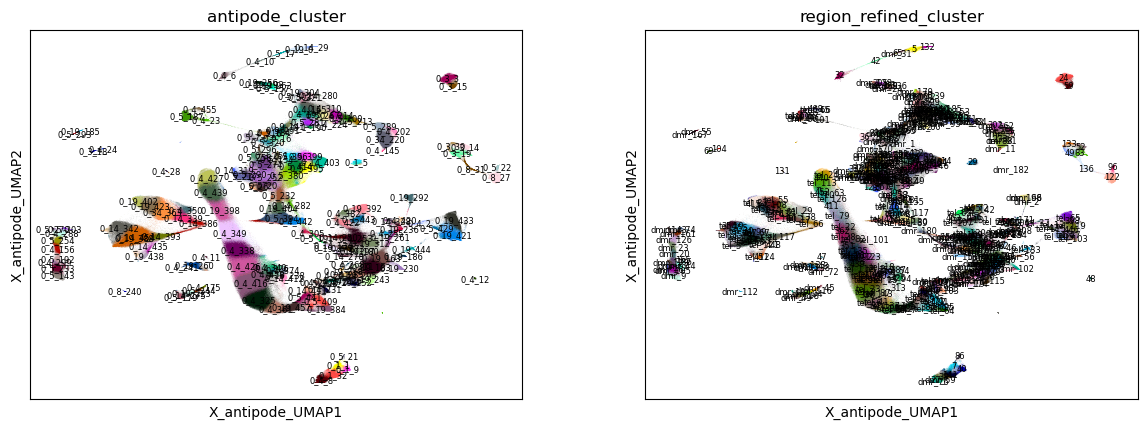

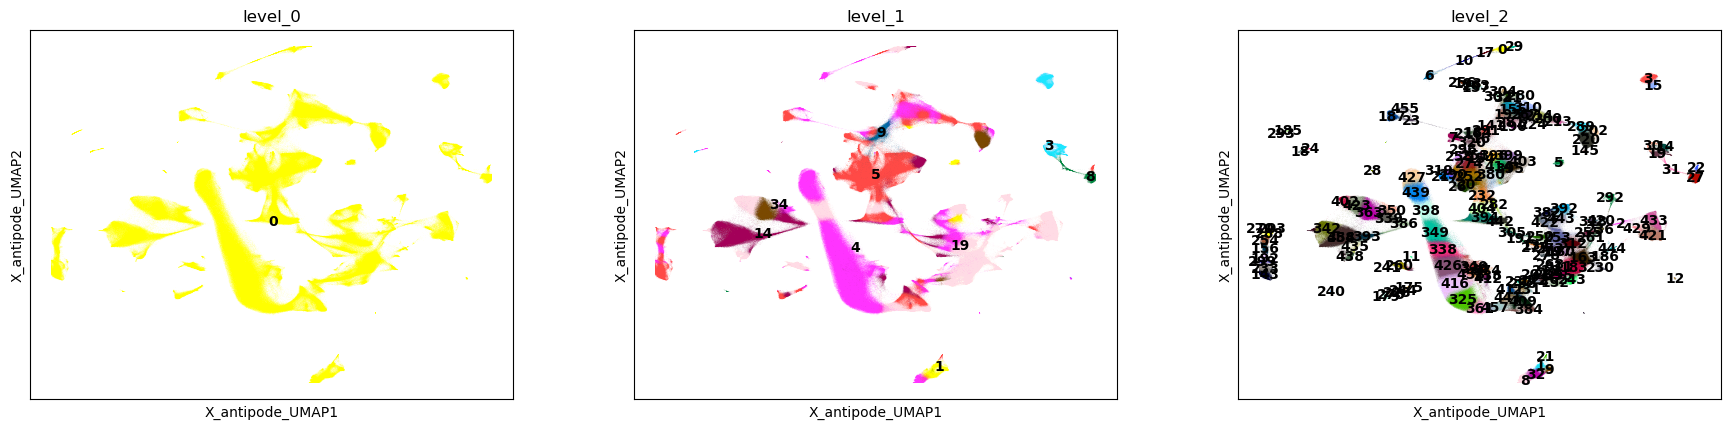

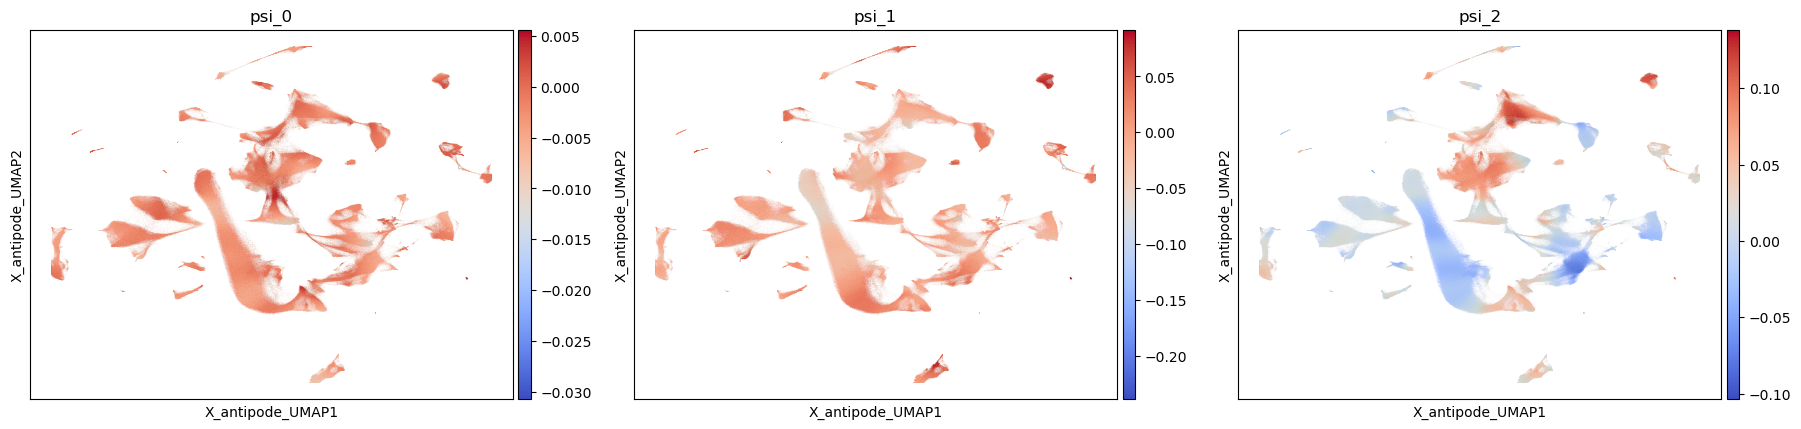

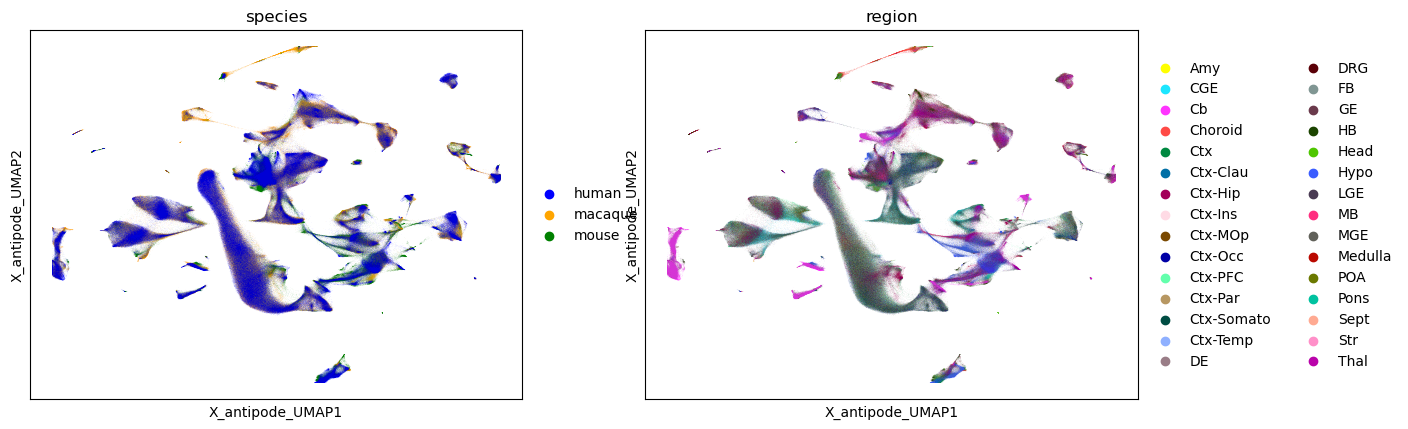

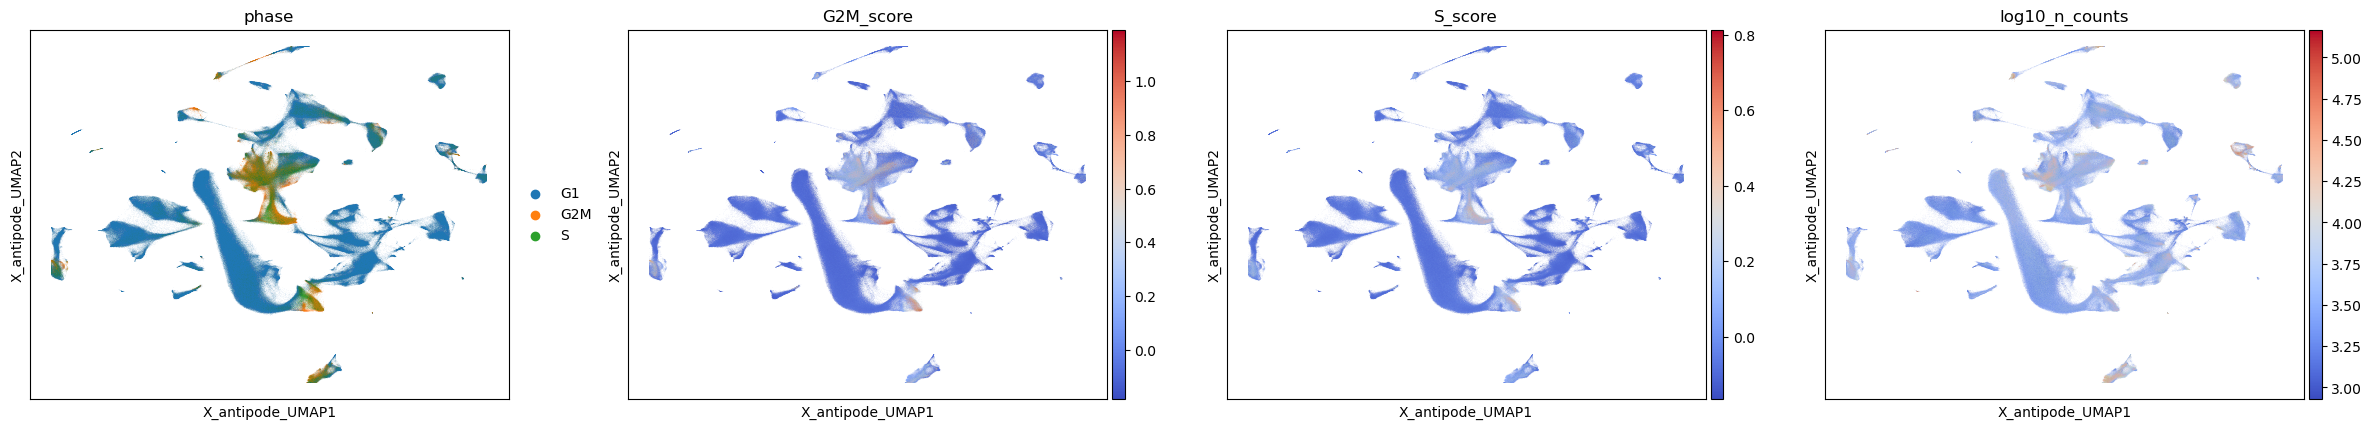

In [24]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","region_refined_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'psi' in x],
    cmap='coolwarm',
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species','region']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['phase','G2M_score','S_score','log10_n_counts'],cmap='coolwarm'
)


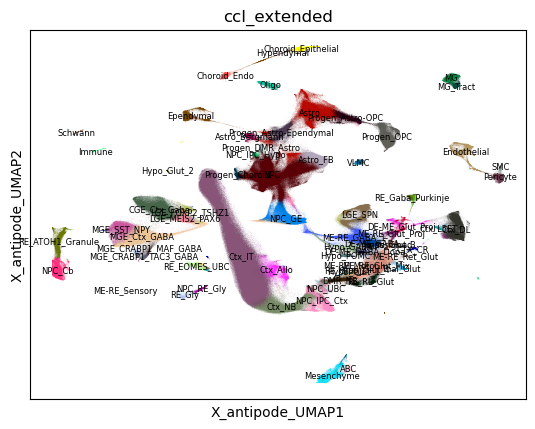

In [25]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["ccl_extended"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


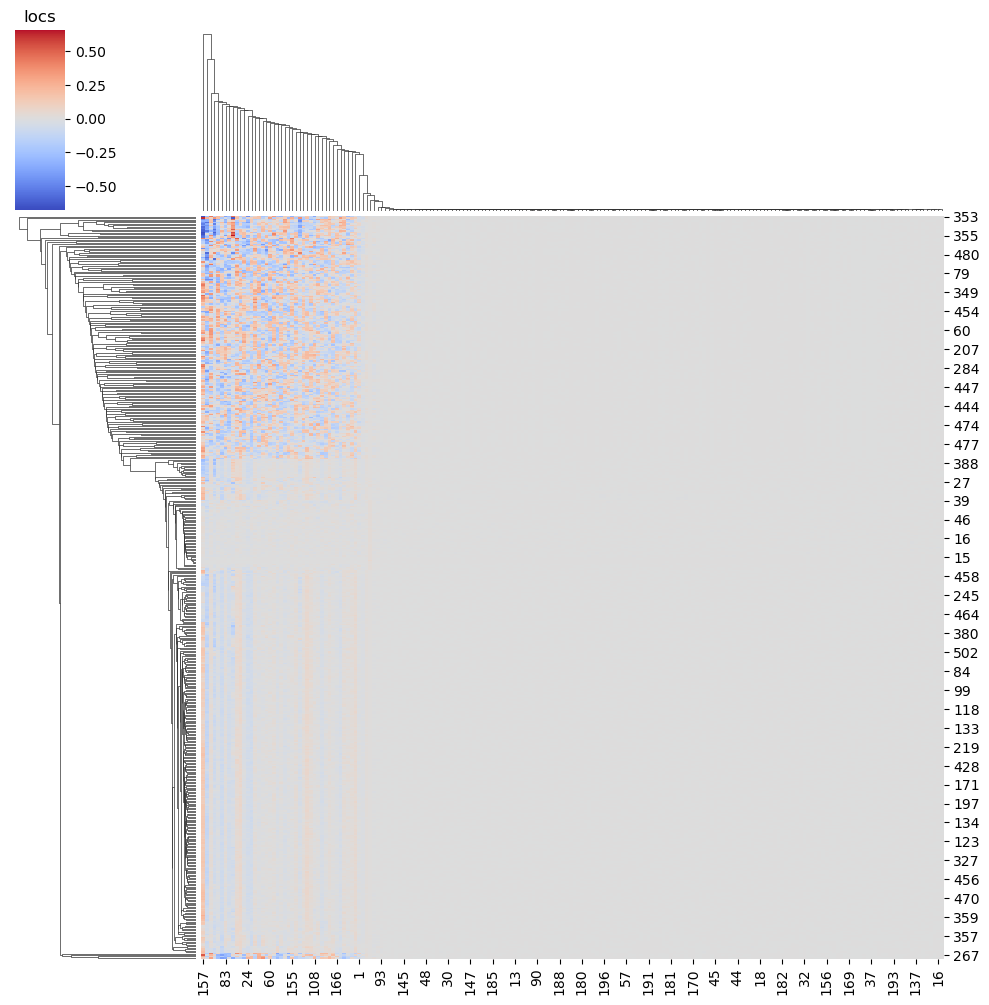

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


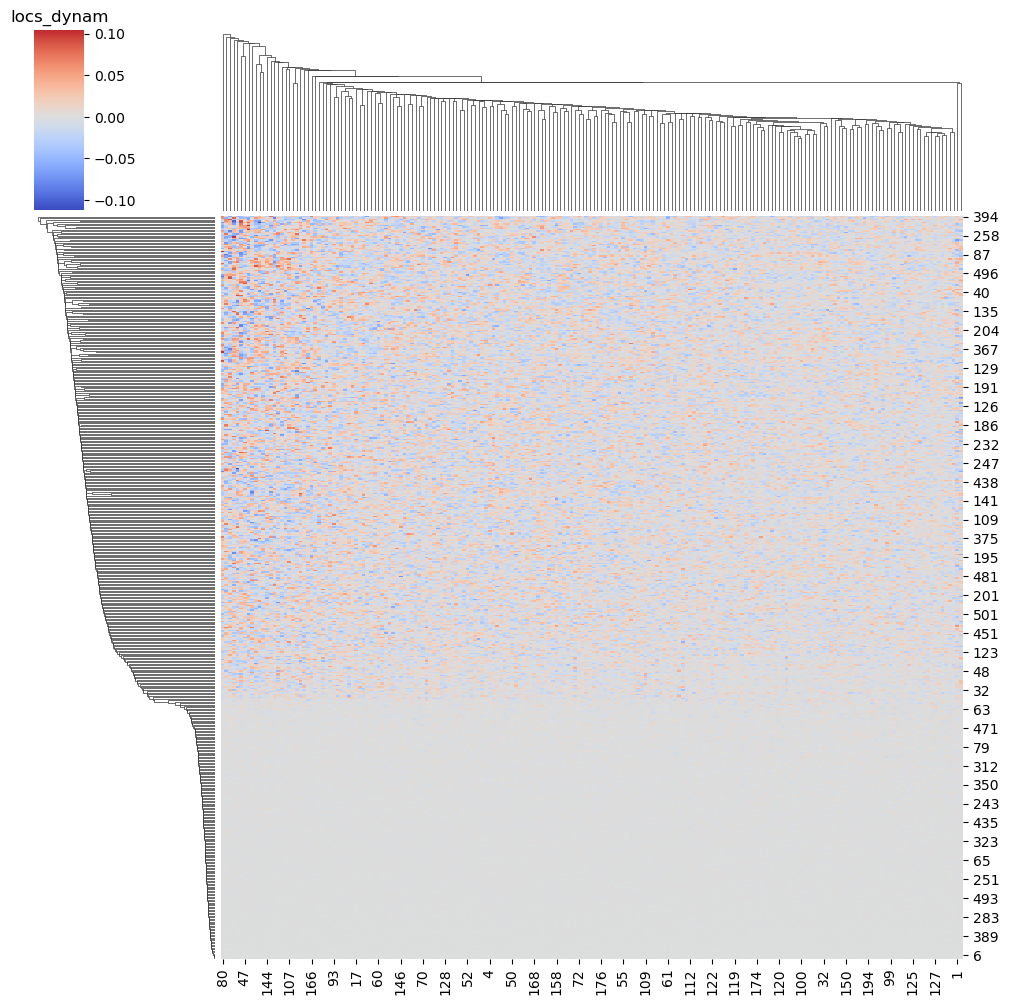

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


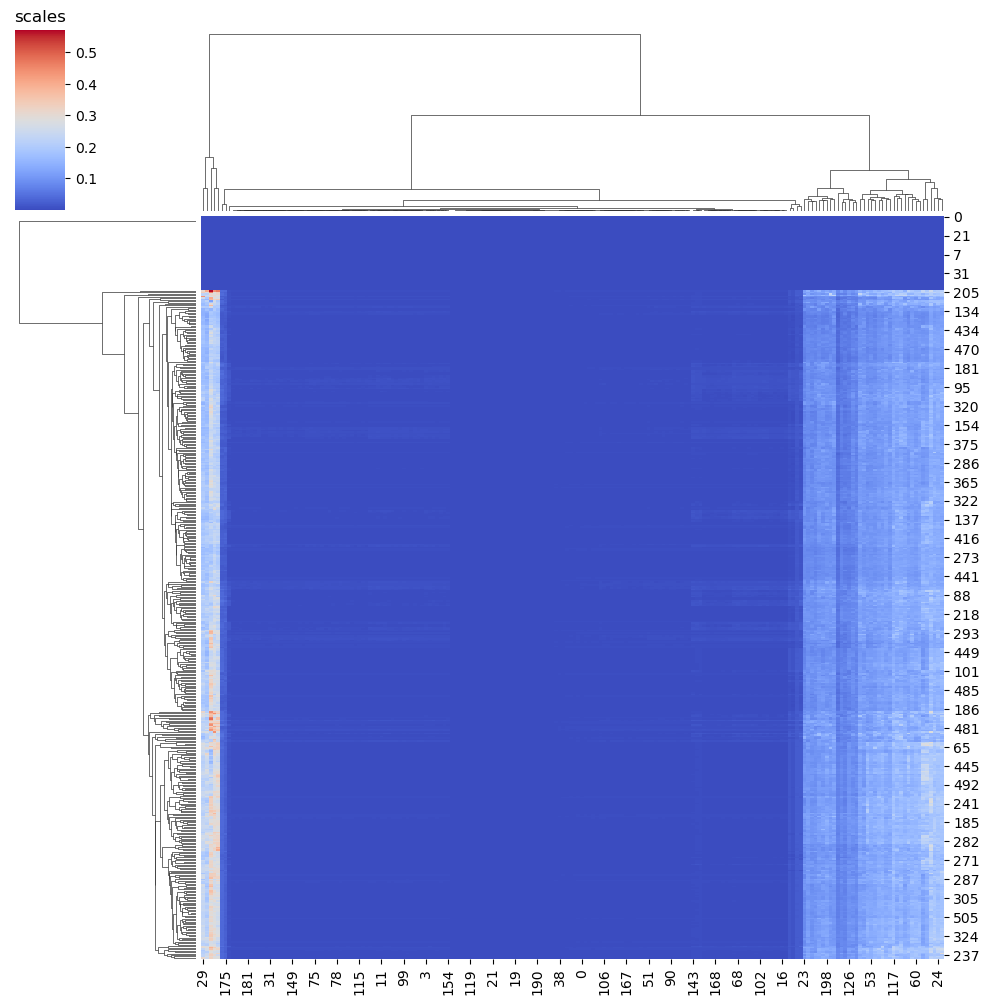

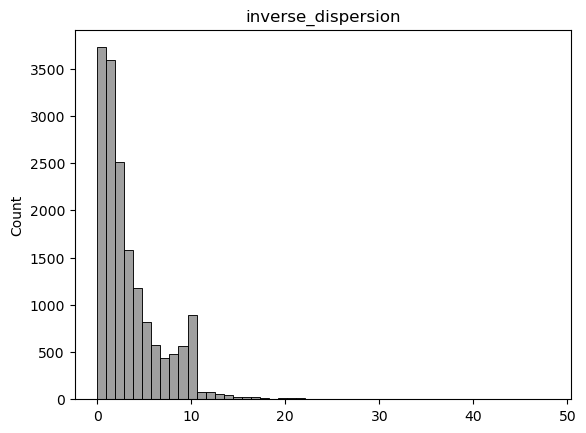

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


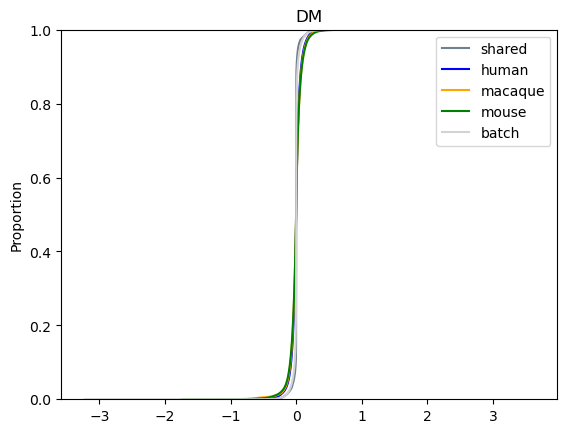

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


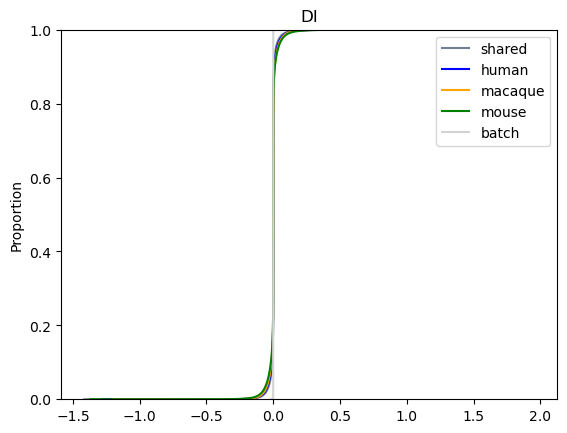

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


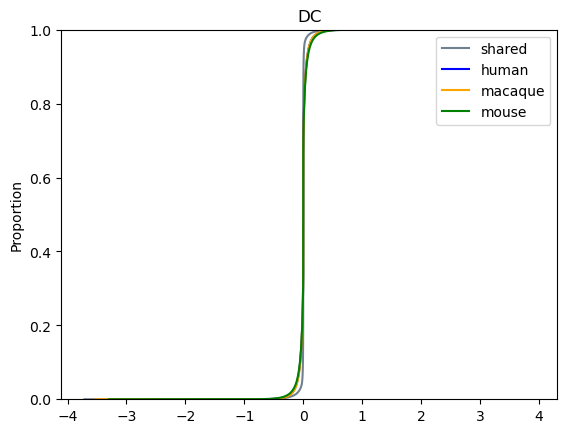

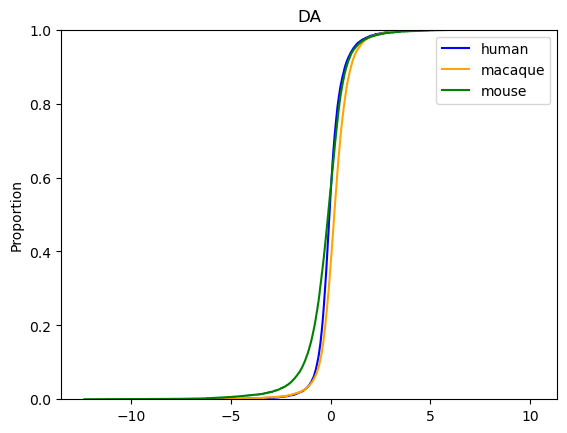

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(antipode_model.batch_key)[color_key]
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:103: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  seaborn.scatterplot(data=df, x=0, y=1, hue=color_key,palette = colors)


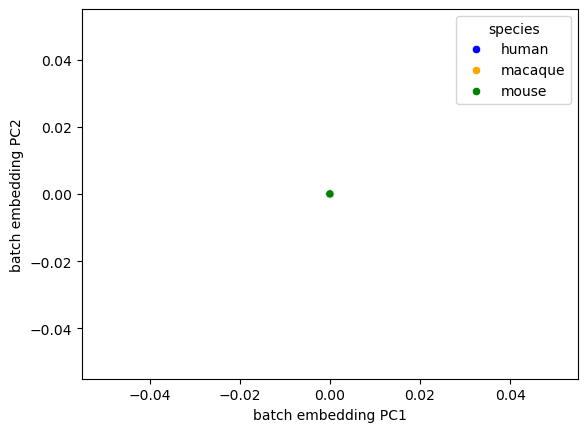

0    1                   batch_name species
0    0.0  0.0        CS12OpticVesicle_kOut   human
1    0.0  0.0  CS13_anterior_midbrain_kOut   human
2    0.0  0.0   CS13_central_midbrain_kOut   human
3    0.0  0.0          CS13_hindbrain_kOut   human
4    0.0  0.0   CS13_olfactory_pacode_kOut   human
..   ...  ...                          ...     ...
403  0.0  0.0                       p0-WT2   mouse
404  0.0  0.0                       p0-WT3   mouse
405  0.0  0.0                       p0-WT4   mouse
406  0.0  0.0       p07_Cortex_SRR11947654   mouse
407  0.0  0.0       p07_Cortex_SRR11947655   mouse

[408 rows x 4 columns]

In [26]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model,ecdf=True)
plot_batch_embedding_pca(antipode_model)

In [27]:
posterior_out, posterior_categories = antipode_model.correct_fits_intercepts(batch_size=128)
antipode_model.store_outputs(device=device,prefix='')
antipode_model.save(out_path, save_anndata=False, prefix='p7_nopsi2temp_')


  0%|          | 0/13974 [00:00<?, ?it/s]

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:806: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  discov_codes = adata.obs[self.discov_key].cat.codes[batch_indices].values
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:807: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  leaf_codes = adata.obs[leaf_level_col].cat.codes[batch_indices].values
  0%|          | 2/13974 [00:00<17:26, 13.36it/s]

  0%|          | 4/13974 [00:00<15:23, 15.13it/s]

  0%|          | 6/13974 [00:00<14:04, 16.55it/s]

  0%|          | 8/13974 [00:00<13:20, 17.45it/s]

  0%|          | 10/13974 [00:00<13:03, 17.82it/s]

  0%|          | 12/13974 [00:00<12:48, 18.18it/s]

  0%|          | 14/13974 [00:00<12:38, 18.41it/s]

  0%|          | 16/13974 [00:00<12:31, 18.58it/s]

  0%|          | 18/13974 [00:01<12:25, 18.72it/s]

  0%|          | 20/13974 [00:01<12:22, 18.79it/s]

  0%|          | 22/13974 [00:01<12:19, 18.86it/s]

  0%|          | 24/13974 [00:01<12:16, 18.95it/s]

  0%|          | 26/13974 [00:01<12:16, 18.95it/s]

  0%|          | 28/13974 [00:01<12:10, 19.09it/s]

  0%|          | 30/13974 [00:01<12:08, 19.13it/s]

  0%|          | 32/13974 [00:01<12:07, 19.16it/s]

  0%|          | 34/13974 [00:01<12:05, 19.20it/s]

  0%|          | 36/13974 [00:01<12:03, 19.26it/s]

  0%|          | 38/13974 [00:02<12:00, 19.35it/s]

  0%|          | 40/13974 [00:02<11:57, 19.43it/s]

  0%|          | 42/13974 [00:02<11:55, 19.47it/s]

  0%|          | 44/13974 [00:02<11:56, 19.44it/s]

  0%|          | 46/13974 [00:02<11:53, 19.51it/s]

  0%|          | 48/13974 [00:02<11:59, 19.35it/s]

  0%|          | 50/13974 [00:02<12:01, 19.29it/s]

  0%|          | 52/13974 [00:02<12:01, 19.31it/s]

  0%|          | 54/13974 [00:02<12:02, 19.27it/s]

  0%|          | 56/13974 [00:02<12:00, 19.31it/s]

  0%|          | 58/13974 [00:03<11:57, 19.39it/s]

  0%|          | 60/13974 [00:03<11:59, 19.35it/s]

  0%|          | 62/13974 [00:03<12:00, 19.32it/s]

  0%|          | 64/13974 [00:03<12:02, 19.25it/s]

  0%|          | 66/13974 [00:03<12:02, 19.25it/s]

  0%|          | 68/13974 [00:03<12:00, 19.31it/s]

  1%|          | 70/13974 [00:03<11:58, 19.35it/s]

  1%|          | 72/13974 [00:03<11:58, 19.36it/s]

  1%|          | 74/13974 [00:03<11:55, 19.44it/s]

  1%|          | 76/13974 [00:04<11:52, 19.49it/s]

  1%|          | 78/13974 [00:04<11:50, 19.55it/s]

  1%|          | 80/13974 [00:04<11:48, 19.60it/s]

  1%|          | 82/13974 [00:04<11:50, 19.56it/s]

  1%|          | 84/13974 [00:04<11:50, 19.55it/s]

  1%|          | 86/13974 [00:04<11:49, 19.57it/s]

  1%|          | 88/13974 [00:04<11:48, 19.59it/s]

  1%|          | 90/13974 [00:04<11:47, 19.62it/s]

  1%|          | 92/13974 [00:04<11:47, 19.63it/s]

  1%|          | 94/13974 [00:04<11:47, 19.63it/s]

  1%|          | 96/13974 [00:05<11:48, 19.58it/s]

  1%|          | 98/13974 [00:05<11:51, 19.50it/s]

  1%|          | 100/13974 [00:05<11:52, 19.46it/s]

  1%|          | 102/13974 [00:05<11:51, 19.49it/s]

  1%|          | 104/13974 [00:05<11:49, 19.55it/s]

  1%|          | 106/13974 [00:05<11:48, 19.56it/s]

  1%|          | 108/13974 [00:05<11:49, 19.54it/s]

  1%|          | 110/13974 [00:05<11:48, 19.58it/s]

  1%|          | 112/13974 [00:05<11:46, 19.61it/s]

  1%|          | 114/13974 [00:05<11:45, 19.65it/s]

  1%|          | 116/13974 [00:06<11:45, 19.63it/s]

  1%|          | 118/13974 [00:06<11:48, 19.57it/s]

  1%|          | 120/13974 [00:06<11:49, 19.53it/s]

  1%|          | 122/13974 [00:06<11:49, 19.52it/s]

  1%|          | 124/13974 [00:06<11:48, 19.54it/s]

  1%|          | 126/13974 [00:06<11:47, 19.56it/s]

  1%|          | 128/13974 [00:06<11:49, 19.51it/s]

  1%|          | 130/13974 [00:06<11:52, 19.43it/s]

  1%|          | 132/13974 [00:06<11:54, 19.37it/s]

  1%|          | 134/13974 [00:06<11:56, 19.31it/s]

  1%|          | 136/13974 [00:07<11:58, 19.26it/s]

  1%|          | 138/13974 [00:07<11:59, 19.22it/s]

  1%|          | 140/13974 [00:07<11:59, 19.24it/s]

  1%|          | 142/13974 [00:07<11:58, 19.25it/s]

  1%|          | 144/13974 [00:07<11:58, 19.25it/s]

  1%|          | 146/13974 [00:07<11:59, 19.23it/s]

  1%|          | 148/13974 [00:07<11:58, 19.24it/s]

  1%|          | 150/13974 [00:07<11:58, 19.24it/s]

  1%|          | 152/13974 [00:07<11:57, 19.26it/s]

  1%|          | 154/13974 [00:08<11:56, 19.29it/s]

  1%|          | 156/13974 [00:08<11:55, 19.30it/s]

  1%|          | 158/13974 [00:08<11:55, 19.30it/s]

  1%|          | 160/13974 [00:08<11:54, 19.33it/s]

  1%|          | 162/13974 [00:08<11:54, 19.32it/s]

  1%|          | 164/13974 [00:08<11:55, 19.31it/s]

  1%|          | 166/13974 [00:08<11:55, 19.31it/s]

  1%|          | 168/13974 [00:08<11:55, 19.30it/s]

  1%|          | 170/13974 [00:08<11:54, 19.31it/s]

  1%|          | 172/13974 [00:08<11:57, 19.23it/s]

  1%|          | 174/13974 [00:09<11:59, 19.17it/s]

  1%|▏         | 176/13974 [00:09<12:00, 19.14it/s]

  1%|▏         | 178/13974 [00:09<12:02, 19.11it/s]

  1%|▏         | 180/13974 [00:09<12:01, 19.11it/s]

  1%|▏         | 182/13974 [00:09<12:01, 19.11it/s]

  1%|▏         | 184/13974 [00:09<12:01, 19.12it/s]

  1%|▏         | 186/13974 [00:09<11:59, 19.16it/s]

  1%|▏         | 188/13974 [00:09<11:57, 19.21it/s]

  1%|▏         | 190/13974 [00:09<11:56, 19.23it/s]

  1%|▏         | 192/13974 [00:10<11:56, 19.22it/s]

  1%|▏         | 194/13974 [00:10<11:55, 19.25it/s]

  1%|▏         | 196/13974 [00:10<11:55, 19.26it/s]

  1%|▏         | 198/13974 [00:10<11:54, 19.27it/s]

  1%|▏         | 200/13974 [00:10<12:20, 18.60it/s]

  1%|▏         | 202/13974 [00:10<12:41, 18.09it/s]

  1%|▏         | 204/13974 [00:10<12:26, 18.43it/s]

  1%|▏         | 206/13974 [00:10<12:14, 18.74it/s]

  1%|▏         | 208/13974 [00:10<12:04, 18.99it/s]

  2%|▏         | 210/13974 [00:10<11:56, 19.20it/s]

  2%|▏         | 212/13974 [00:11<11:50, 19.36it/s]

  2%|▏         | 214/13974 [00:11<11:46, 19.47it/s]

  2%|▏         | 216/13974 [00:11<11:42, 19.58it/s]

  2%|▏         | 218/13974 [00:11<11:39, 19.67it/s]

  2%|▏         | 220/13974 [00:11<11:37, 19.73it/s]

  2%|▏         | 222/13974 [00:11<11:40, 19.65it/s]

  2%|▏         | 224/13974 [00:11<11:39, 19.65it/s]

  2%|▏         | 226/13974 [00:11<11:41, 19.60it/s]

  2%|▏         | 228/13974 [00:11<11:40, 19.64it/s]

  2%|▏         | 230/13974 [00:11<11:39, 19.64it/s]

  2%|▏         | 232/13974 [00:12<11:43, 19.53it/s]

  2%|▏         | 234/13974 [00:12<11:51, 19.31it/s]

  2%|▏         | 236/13974 [00:12<11:53, 19.27it/s]

  2%|▏         | 238/13974 [00:12<11:56, 19.17it/s]

  2%|▏         | 240/13974 [00:12<11:56, 19.16it/s]

  2%|▏         | 242/13974 [00:12<11:53, 19.25it/s]

  2%|▏         | 244/13974 [00:12<11:50, 19.32it/s]

  2%|▏         | 246/13974 [00:12<11:48, 19.37it/s]

  2%|▏         | 248/13974 [00:12<11:46, 19.43it/s]

  2%|▏         | 250/13974 [00:13<11:45, 19.46it/s]

  2%|▏         | 252/13974 [00:13<11:43, 19.50it/s]

  2%|▏         | 254/13974 [00:13<12:18, 18.58it/s]

  2%|▏         | 256/13974 [00:13<12:06, 18.88it/s]

  2%|▏         | 258/13974 [00:13<11:58, 19.09it/s]

  2%|▏         | 260/13974 [00:13<11:52, 19.25it/s]

  2%|▏         | 262/13974 [00:13<11:48, 19.36it/s]

  2%|▏         | 264/13974 [00:13<11:44, 19.46it/s]

  2%|▏         | 266/13974 [00:13<11:41, 19.53it/s]

  2%|▏         | 268/13974 [00:13<12:03, 18.94it/s]

  2%|▏         | 270/13974 [00:14<11:54, 19.18it/s]

  2%|▏         | 272/13974 [00:14<11:48, 19.33it/s]

  2%|▏         | 274/13974 [00:14<11:44, 19.44it/s]

  2%|▏         | 276/13974 [00:14<11:42, 19.51it/s]

  2%|▏         | 278/13974 [00:14<11:39, 19.58it/s]

  2%|▏         | 280/13974 [00:14<11:38, 19.60it/s]

  2%|▏         | 282/13974 [00:14<11:37, 19.63it/s]

  2%|▏         | 284/13974 [00:14<11:36, 19.65it/s]

  2%|▏         | 286/13974 [00:14<11:35, 19.67it/s]

  2%|▏         | 288/13974 [00:14<11:35, 19.68it/s]

  2%|▏         | 290/13974 [00:15<11:37, 19.62it/s]

  2%|▏         | 292/13974 [00:15<11:45, 19.39it/s]

  2%|▏         | 294/13974 [00:15<11:48, 19.30it/s]

  2%|▏         | 296/13974 [00:15<11:51, 19.21it/s]

  2%|▏         | 298/13974 [00:15<11:52, 19.20it/s]

  2%|▏         | 300/13974 [00:15<11:50, 19.25it/s]

  2%|▏         | 302/13974 [00:15<11:50, 19.25it/s]

  2%|▏         | 304/13974 [00:15<11:49, 19.26it/s]

  2%|▏         | 306/13974 [00:15<11:51, 19.20it/s]

  2%|▏         | 308/13974 [00:16<11:53, 19.15it/s]

  2%|▏         | 310/13974 [00:16<11:58, 19.02it/s]

  2%|▏         | 312/13974 [00:16<12:01, 18.94it/s]

  2%|▏         | 314/13974 [00:16<12:01, 18.93it/s]

  2%|▏         | 316/13974 [00:16<12:02, 18.91it/s]

  2%|▏         | 318/13974 [00:16<12:03, 18.88it/s]

  2%|▏         | 320/13974 [00:16<12:07, 18.76it/s]

  2%|▏         | 322/13974 [00:16<12:06, 18.78it/s]

  2%|▏         | 324/13974 [00:16<12:06, 18.79it/s]

  2%|▏         | 326/13974 [00:16<12:08, 18.74it/s]

  2%|▏         | 328/13974 [00:17<12:05, 18.81it/s]

  2%|▏         | 330/13974 [00:17<12:06, 18.78it/s]

  2%|▏         | 332/13974 [00:17<12:04, 18.82it/s]

  2%|▏         | 334/13974 [00:17<12:03, 18.86it/s]

  2%|▏         | 336/13974 [00:17<12:02, 18.88it/s]

  2%|▏         | 338/13974 [00:17<12:01, 18.90it/s]

  2%|▏         | 340/13974 [00:17<11:59, 18.94it/s]

  2%|▏         | 342/13974 [00:17<11:58, 18.96it/s]

  2%|▏         | 344/13974 [00:17<11:57, 18.99it/s]

  2%|▏         | 346/13974 [00:18<11:56, 19.02it/s]

  2%|▏         | 348/13974 [00:18<11:54, 19.07it/s]

  3%|▎         | 350/13974 [00:18<11:53, 19.09it/s]

  3%|▎         | 352/13974 [00:18<11:53, 19.09it/s]

  3%|▎         | 354/13974 [00:18<11:53, 19.10it/s]

  3%|▎         | 356/13974 [00:18<11:52, 19.10it/s]

  3%|▎         | 358/13974 [00:18<11:52, 19.11it/s]

  3%|▎         | 360/13974 [00:18<11:52, 19.11it/s]

  3%|▎         | 362/13974 [00:18<11:52, 19.12it/s]

  3%|▎         | 364/13974 [00:18<12:01, 18.85it/s]

  3%|▎         | 366/13974 [00:19<12:00, 18.88it/s]

  3%|▎         | 368/13974 [00:19<11:58, 18.93it/s]

  3%|▎         | 370/13974 [00:19<11:57, 18.97it/s]

  3%|▎         | 372/13974 [00:19<11:54, 19.04it/s]

  3%|▎         | 374/13974 [00:19<11:52, 19.08it/s]

  3%|▎         | 376/13974 [00:19<11:49, 19.18it/s]

  3%|▎         | 378/13974 [00:19<11:45, 19.27it/s]

  3%|▎         | 380/13974 [00:19<11:43, 19.32it/s]

  3%|▎         | 382/13974 [00:19<11:41, 19.37it/s]

  3%|▎         | 384/13974 [00:20<11:38, 19.46it/s]

  3%|▎         | 386/13974 [00:20<11:37, 19.49it/s]

  3%|▎         | 388/13974 [00:20<11:34, 19.57it/s]

  3%|▎         | 390/13974 [00:20<11:33, 19.59it/s]

  3%|▎         | 392/13974 [00:20<11:32, 19.61it/s]

  3%|▎         | 394/13974 [00:20<11:32, 19.62it/s]

  3%|▎         | 396/13974 [00:20<11:31, 19.64it/s]

  3%|▎         | 398/13974 [00:20<11:31, 19.63it/s]

  3%|▎         | 400/13974 [00:20<11:31, 19.62it/s]

  3%|▎         | 402/13974 [00:20<11:31, 19.62it/s]

  3%|▎         | 404/13974 [00:21<11:32, 19.59it/s]

  3%|▎         | 406/13974 [00:21<11:33, 19.58it/s]

  3%|▎         | 408/13974 [00:21<11:32, 19.59it/s]

  3%|▎         | 410/13974 [00:21<11:32, 19.60it/s]

  3%|▎         | 412/13974 [00:21<11:30, 19.63it/s]

  3%|▎         | 414/13974 [00:21<11:29, 19.66it/s]

  3%|▎         | 416/13974 [00:21<11:30, 19.65it/s]

  3%|▎         | 418/13974 [00:21<11:28, 19.69it/s]

  3%|▎         | 420/13974 [00:21<11:27, 19.72it/s]

  3%|▎         | 422/13974 [00:21<11:26, 19.75it/s]

  3%|▎         | 424/13974 [00:22<11:28, 19.69it/s]

  3%|▎         | 426/13974 [00:22<11:27, 19.69it/s]

  3%|▎         | 428/13974 [00:22<11:28, 19.68it/s]

  3%|▎         | 430/13974 [00:22<11:28, 19.67it/s]

  3%|▎         | 432/13974 [00:22<11:28, 19.66it/s]

  3%|▎         | 434/13974 [00:22<11:29, 19.63it/s]

  3%|▎         | 436/13974 [00:22<11:29, 19.63it/s]

  3%|▎         | 438/13974 [00:22<11:28, 19.67it/s]

  3%|▎         | 440/13974 [00:22<11:26, 19.72it/s]

  3%|▎         | 442/13974 [00:22<11:25, 19.75it/s]

  3%|▎         | 444/13974 [00:23<11:23, 19.79it/s]

  3%|▎         | 446/13974 [00:23<11:21, 19.84it/s]

  3%|▎         | 448/13974 [00:23<11:20, 19.87it/s]

  3%|▎         | 450/13974 [00:23<11:20, 19.87it/s]

  3%|▎         | 452/13974 [00:23<11:20, 19.86it/s]

  3%|▎         | 454/13974 [00:23<11:21, 19.85it/s]

  3%|▎         | 456/13974 [00:23<11:21, 19.83it/s]

  3%|▎         | 458/13974 [00:23<11:21, 19.85it/s]

  3%|▎         | 460/13974 [00:23<11:20, 19.86it/s]

  3%|▎         | 462/13974 [00:23<11:19, 19.88it/s]

  3%|▎         | 465/13974 [00:24<11:16, 19.96it/s]

  3%|▎         | 467/13974 [00:24<11:16, 19.96it/s]

  3%|▎         | 469/13974 [00:24<11:17, 19.94it/s]

  3%|▎         | 471/13974 [00:24<11:16, 19.95it/s]

  3%|▎         | 473/13974 [00:24<11:18, 19.90it/s]

  3%|▎         | 475/13974 [00:24<11:22, 19.77it/s]

  3%|▎         | 477/13974 [00:24<11:34, 19.43it/s]

  3%|▎         | 479/13974 [00:24<11:42, 19.21it/s]

  3%|▎         | 481/13974 [00:24<11:45, 19.13it/s]

  3%|▎         | 483/13974 [00:25<11:46, 19.09it/s]

  3%|▎         | 485/13974 [00:25<11:48, 19.05it/s]

  3%|▎         | 487/13974 [00:25<11:52, 18.92it/s]

  3%|▎         | 489/13974 [00:25<11:53, 18.91it/s]

  4%|▎         | 491/13974 [00:25<11:51, 18.95it/s]

  4%|▎         | 493/13974 [00:25<12:01, 18.69it/s]

  4%|▎         | 495/13974 [00:25<11:58, 18.77it/s]

  4%|▎         | 497/13974 [00:25<11:56, 18.81it/s]

  4%|▎         | 499/13974 [00:25<11:54, 18.85it/s]

  4%|▎         | 501/13974 [00:25<11:53, 18.89it/s]

  4%|▎         | 503/13974 [00:26<11:52, 18.90it/s]

  4%|▎         | 505/13974 [00:26<12:19, 18.22it/s]

  4%|▎         | 507/13974 [00:26<12:10, 18.44it/s]

  4%|▎         | 509/13974 [00:26<12:02, 18.62it/s]

  4%|▎         | 511/13974 [00:26<11:58, 18.74it/s]

  4%|▎         | 513/13974 [00:26<11:54, 18.84it/s]

  4%|▎         | 515/13974 [00:26<11:51, 18.92it/s]

  4%|▎         | 517/13974 [00:26<11:48, 18.98it/s]

  4%|▎         | 519/13974 [00:26<11:46, 19.05it/s]

  4%|▎         | 521/13974 [00:27<11:45, 19.07it/s]

  4%|▎         | 523/13974 [00:27<11:44, 19.09it/s]

  4%|▍         | 525/13974 [00:27<11:44, 19.08it/s]

  4%|▍         | 527/13974 [00:27<11:44, 19.09it/s]

  4%|▍         | 529/13974 [00:27<11:44, 19.10it/s]

  4%|▍         | 531/13974 [00:27<11:46, 19.04it/s]

  4%|▍         | 533/13974 [00:27<11:46, 19.01it/s]

  4%|▍         | 535/13974 [00:27<11:47, 19.00it/s]

  4%|▍         | 537/13974 [00:27<11:46, 19.01it/s]

  4%|▍         | 539/13974 [00:28<11:46, 19.00it/s]

  4%|▍         | 541/13974 [00:28<11:45, 19.03it/s]

  4%|▍         | 543/13974 [00:28<11:46, 19.02it/s]

  4%|▍         | 545/13974 [00:28<11:46, 19.02it/s]

  4%|▍         | 547/13974 [00:28<11:45, 19.04it/s]

  4%|▍         | 549/13974 [00:28<11:44, 19.06it/s]

  4%|▍         | 551/13974 [00:28<11:40, 19.16it/s]

  4%|▍         | 553/13974 [00:28<11:38, 19.21it/s]

  4%|▍         | 555/13974 [00:28<11:36, 19.27it/s]

  4%|▍         | 557/13974 [00:28<11:33, 19.35it/s]

  4%|▍         | 559/13974 [00:29<11:31, 19.41it/s]

  4%|▍         | 561/13974 [00:29<11:28, 19.49it/s]

  4%|▍         | 563/13974 [00:29<11:25, 19.55it/s]

  4%|▍         | 565/13974 [00:29<11:27, 19.49it/s]

  4%|▍         | 567/13974 [00:29<11:31, 19.38it/s]

  4%|▍         | 569/13974 [00:29<11:29, 19.44it/s]

  4%|▍         | 571/13974 [00:29<11:27, 19.48it/s]

  4%|▍         | 573/13974 [00:29<11:26, 19.53it/s]

  4%|▍         | 575/13974 [00:29<11:25, 19.55it/s]

  4%|▍         | 577/13974 [00:29<11:23, 19.60it/s]

  4%|▍         | 579/13974 [00:30<11:22, 19.64it/s]

  4%|▍         | 581/13974 [00:30<11:21, 19.65it/s]

  4%|▍         | 583/13974 [00:30<11:28, 19.44it/s]

  4%|▍         | 585/13974 [00:30<11:31, 19.36it/s]

  4%|▍         | 587/13974 [00:30<11:32, 19.34it/s]

  4%|▍         | 589/13974 [00:30<11:32, 19.33it/s]

  4%|▍         | 591/13974 [00:30<11:32, 19.33it/s]

  4%|▍         | 593/13974 [00:30<11:30, 19.38it/s]

  4%|▍         | 595/13974 [00:30<11:33, 19.30it/s]

  4%|▍         | 597/13974 [00:31<11:34, 19.25it/s]

  4%|▍         | 599/13974 [00:31<11:35, 19.22it/s]

  4%|▍         | 601/13974 [00:31<11:35, 19.22it/s]

  4%|▍         | 603/13974 [00:31<11:35, 19.23it/s]

  4%|▍         | 605/13974 [00:31<11:35, 19.23it/s]

  4%|▍         | 607/13974 [00:31<11:35, 19.21it/s]

  4%|▍         | 609/13974 [00:31<11:34, 19.23it/s]

  4%|▍         | 611/13974 [00:31<11:33, 19.26it/s]

  4%|▍         | 613/13974 [00:31<11:33, 19.28it/s]

  4%|▍         | 615/13974 [00:31<11:32, 19.29it/s]

  4%|▍         | 617/13974 [00:32<11:36, 19.17it/s]

  4%|▍         | 619/13974 [00:32<11:38, 19.12it/s]

  4%|▍         | 621/13974 [00:32<11:39, 19.10it/s]

  4%|▍         | 623/13974 [00:32<11:40, 19.06it/s]

  4%|▍         | 625/13974 [00:32<11:39, 19.10it/s]

  4%|▍         | 627/13974 [00:32<11:37, 19.13it/s]

  5%|▍         | 629/13974 [00:32<11:38, 19.11it/s]

  5%|▍         | 631/13974 [00:32<11:37, 19.13it/s]

  5%|▍         | 633/13974 [00:32<11:36, 19.15it/s]

  5%|▍         | 635/13974 [00:32<11:35, 19.19it/s]

  5%|▍         | 637/13974 [00:33<11:35, 19.17it/s]

  5%|▍         | 639/13974 [00:33<11:36, 19.15it/s]

  5%|▍         | 641/13974 [00:33<11:32, 19.25it/s]

  5%|▍         | 643/13974 [00:33<11:34, 19.19it/s]

  5%|▍         | 645/13974 [00:33<11:35, 19.16it/s]

  5%|▍         | 647/13974 [00:33<11:34, 19.18it/s]

  5%|▍         | 649/13974 [00:33<11:35, 19.17it/s]

  5%|▍         | 651/13974 [00:33<11:37, 19.09it/s]

  5%|▍         | 653/13974 [00:33<11:37, 19.10it/s]

  5%|▍         | 655/13974 [00:34<11:38, 19.06it/s]

  5%|▍         | 657/13974 [00:34<11:38, 19.05it/s]

  5%|▍         | 659/13974 [00:34<11:38, 19.07it/s]

  5%|▍         | 661/13974 [00:34<11:38, 19.07it/s]

  5%|▍         | 663/13974 [00:34<11:36, 19.12it/s]

  5%|▍         | 665/13974 [00:34<12:08, 18.27it/s]

  5%|▍         | 667/13974 [00:34<11:56, 18.56it/s]

  5%|▍         | 669/13974 [00:34<11:49, 18.75it/s]

  5%|▍         | 671/13974 [00:34<11:45, 18.85it/s]

  5%|▍         | 673/13974 [00:34<11:45, 18.84it/s]

  5%|▍         | 675/13974 [00:35<11:45, 18.85it/s]

  5%|▍         | 677/13974 [00:35<11:44, 18.86it/s]

  5%|▍         | 679/13974 [00:35<11:43, 18.90it/s]

  5%|▍         | 681/13974 [00:35<11:42, 18.91it/s]

  5%|▍         | 683/13974 [00:35<11:43, 18.90it/s]

  5%|▍         | 685/13974 [00:35<11:42, 18.93it/s]

  5%|▍         | 687/13974 [00:35<11:40, 18.97it/s]

  5%|▍         | 689/13974 [00:35<11:37, 19.04it/s]

  5%|▍         | 691/13974 [00:35<11:41, 18.93it/s]

  5%|▍         | 693/13974 [00:36<11:42, 18.89it/s]

  5%|▍         | 695/13974 [00:36<11:43, 18.87it/s]

  5%|▍         | 697/13974 [00:36<11:43, 18.88it/s]

  5%|▌         | 699/13974 [00:36<11:42, 18.90it/s]

  5%|▌         | 701/13974 [00:36<11:41, 18.91it/s]

  5%|▌         | 703/13974 [00:36<11:40, 18.94it/s]

  5%|▌         | 705/13974 [00:36<11:40, 18.95it/s]

  5%|▌         | 707/13974 [00:36<11:39, 18.97it/s]

  5%|▌         | 709/13974 [00:36<11:37, 19.01it/s]

  5%|▌         | 711/13974 [00:36<11:46, 18.78it/s]

  5%|▌         | 713/13974 [00:37<11:47, 18.74it/s]

  5%|▌         | 715/13974 [00:37<11:47, 18.74it/s]

  5%|▌         | 717/13974 [00:37<11:47, 18.75it/s]

  5%|▌         | 719/13974 [00:37<11:45, 18.78it/s]

  5%|▌         | 721/13974 [00:37<11:44, 18.82it/s]

  5%|▌         | 723/13974 [00:37<11:42, 18.86it/s]

  5%|▌         | 725/13974 [00:37<11:46, 18.76it/s]

  5%|▌         | 727/13974 [00:37<11:41, 18.89it/s]

  5%|▌         | 729/13974 [00:37<11:41, 18.88it/s]

  5%|▌         | 731/13974 [00:38<11:36, 19.03it/s]

  5%|▌         | 733/13974 [00:38<11:32, 19.13it/s]

  5%|▌         | 735/13974 [00:38<11:29, 19.20it/s]

  5%|▌         | 737/13974 [00:38<11:26, 19.28it/s]

  5%|▌         | 739/13974 [00:38<11:25, 19.31it/s]

  5%|▌         | 741/13974 [00:38<11:25, 19.31it/s]

  5%|▌         | 743/13974 [00:38<11:24, 19.33it/s]

  5%|▌         | 745/13974 [00:38<11:23, 19.37it/s]

  5%|▌         | 747/13974 [00:38<11:23, 19.36it/s]

  5%|▌         | 749/13974 [00:38<11:22, 19.37it/s]

  5%|▌         | 751/13974 [00:39<11:22, 19.38it/s]

  5%|▌         | 753/13974 [00:39<11:21, 19.41it/s]

  5%|▌         | 755/13974 [00:39<11:21, 19.39it/s]

  5%|▌         | 757/13974 [00:39<11:23, 19.34it/s]

  5%|▌         | 759/13974 [00:39<11:25, 19.27it/s]

  5%|▌         | 761/13974 [00:39<11:24, 19.29it/s]

  5%|▌         | 763/13974 [00:39<11:24, 19.31it/s]

  5%|▌         | 765/13974 [00:39<11:25, 19.26it/s]

  5%|▌         | 767/13974 [00:39<11:24, 19.30it/s]

  6%|▌         | 769/13974 [00:40<11:22, 19.34it/s]

  6%|▌         | 771/13974 [00:40<11:21, 19.37it/s]

  6%|▌         | 773/13974 [00:40<11:18, 19.45it/s]

  6%|▌         | 775/13974 [00:40<11:17, 19.47it/s]

  6%|▌         | 777/13974 [00:40<11:17, 19.47it/s]

  6%|▌         | 779/13974 [00:40<11:21, 19.37it/s]

  6%|▌         | 781/13974 [00:40<11:20, 19.38it/s]

  6%|▌         | 783/13974 [00:40<11:22, 19.33it/s]

  6%|▌         | 785/13974 [00:40<11:23, 19.30it/s]

  6%|▌         | 787/13974 [00:40<11:24, 19.26it/s]

  6%|▌         | 789/13974 [00:41<11:23, 19.29it/s]

  6%|▌         | 791/13974 [00:41<11:19, 19.40it/s]

  6%|▌         | 793/13974 [00:41<11:22, 19.32it/s]

  6%|▌         | 795/13974 [00:41<11:23, 19.29it/s]

  6%|▌         | 797/13974 [00:41<11:23, 19.29it/s]

  6%|▌         | 799/13974 [00:41<11:23, 19.27it/s]

  6%|▌         | 801/13974 [00:41<11:24, 19.26it/s]

  6%|▌         | 803/13974 [00:41<11:21, 19.33it/s]

  6%|▌         | 805/13974 [00:41<11:20, 19.36it/s]

  6%|▌         | 807/13974 [00:41<11:23, 19.28it/s]

  6%|▌         | 809/13974 [00:42<11:21, 19.33it/s]

  6%|▌         | 811/13974 [00:42<11:19, 19.38it/s]

  6%|▌         | 813/13974 [00:42<11:19, 19.37it/s]

  6%|▌         | 815/13974 [00:42<11:17, 19.42it/s]

  6%|▌         | 817/13974 [00:42<11:15, 19.47it/s]

  6%|▌         | 819/13974 [00:42<11:18, 19.40it/s]

  6%|▌         | 821/13974 [00:42<11:19, 19.34it/s]

  6%|▌         | 823/13974 [00:42<11:26, 19.17it/s]

  6%|▌         | 825/13974 [00:42<11:30, 19.05it/s]

  6%|▌         | 827/13974 [00:43<11:31, 19.01it/s]

  6%|▌         | 829/13974 [00:43<11:34, 18.91it/s]

  6%|▌         | 831/13974 [00:43<11:35, 18.89it/s]

  6%|▌         | 833/13974 [00:43<11:35, 18.88it/s]

  6%|▌         | 835/13974 [00:43<11:36, 18.86it/s]

  6%|▌         | 837/13974 [00:43<11:35, 18.89it/s]

  6%|▌         | 839/13974 [00:43<11:34, 18.93it/s]

  6%|▌         | 841/13974 [00:43<11:34, 18.90it/s]

  6%|▌         | 843/13974 [00:43<11:37, 18.84it/s]

  6%|▌         | 845/13974 [00:43<11:37, 18.82it/s]

  6%|▌         | 847/13974 [00:44<11:36, 18.84it/s]

  6%|▌         | 849/13974 [00:44<11:35, 18.87it/s]

  6%|▌         | 851/13974 [00:44<11:35, 18.88it/s]

  6%|▌         | 853/13974 [00:44<11:34, 18.88it/s]

  6%|▌         | 855/13974 [00:44<11:33, 18.91it/s]

  6%|▌         | 857/13974 [00:44<11:31, 18.96it/s]

  6%|▌         | 859/13974 [00:44<11:30, 19.01it/s]

  6%|▌         | 861/13974 [00:44<11:29, 19.03it/s]

  6%|▌         | 863/13974 [00:44<11:31, 18.97it/s]

  6%|▌         | 865/13974 [00:45<11:31, 18.95it/s]

  6%|▌         | 867/13974 [00:45<11:32, 18.94it/s]

  6%|▌         | 869/13974 [00:45<11:30, 18.97it/s]

  6%|▌         | 871/13974 [00:45<11:31, 18.95it/s]

  6%|▌         | 873/13974 [00:45<11:31, 18.95it/s]

  6%|▋         | 875/13974 [00:45<11:31, 18.94it/s]

  6%|▋         | 877/13974 [00:45<11:30, 18.97it/s]

  6%|▋         | 879/13974 [00:45<11:29, 18.98it/s]

  6%|▋         | 881/13974 [00:45<11:28, 19.02it/s]

  6%|▋         | 883/13974 [00:45<11:26, 19.07it/s]

  6%|▋         | 885/13974 [00:46<11:28, 19.00it/s]

  6%|▋         | 887/13974 [00:46<11:30, 18.96it/s]

  6%|▋         | 889/13974 [00:46<11:30, 18.95it/s]

  6%|▋         | 891/13974 [00:46<11:30, 18.95it/s]

  6%|▋         | 893/13974 [00:46<11:29, 18.98it/s]

  6%|▋         | 895/13974 [00:46<11:27, 19.02it/s]

  6%|▋         | 897/13974 [00:46<11:25, 19.09it/s]

  6%|▋         | 899/13974 [00:46<11:22, 19.16it/s]

  6%|▋         | 901/13974 [00:46<11:20, 19.22it/s]

  6%|▋         | 903/13974 [00:47<11:17, 19.30it/s]

  6%|▋         | 905/13974 [00:47<11:14, 19.38it/s]

  6%|▋         | 907/13974 [00:47<11:11, 19.46it/s]

  7%|▋         | 909/13974 [00:47<11:11, 19.46it/s]

  7%|▋         | 911/13974 [00:47<11:13, 19.39it/s]

  7%|▋         | 913/13974 [00:47<11:14, 19.36it/s]

  7%|▋         | 915/13974 [00:47<11:14, 19.36it/s]

  7%|▋         | 917/13974 [00:47<11:15, 19.33it/s]

  7%|▋         | 919/13974 [00:47<11:14, 19.36it/s]

  7%|▋         | 921/13974 [00:47<11:12, 19.40it/s]

  7%|▋         | 923/13974 [00:48<11:11, 19.44it/s]

  7%|▋         | 925/13974 [00:48<11:11, 19.43it/s]

  7%|▋         | 927/13974 [00:48<11:31, 18.87it/s]

  7%|▋         | 929/13974 [00:48<11:22, 19.11it/s]

  7%|▋         | 931/13974 [00:48<11:16, 19.29it/s]

  7%|▋         | 933/13974 [00:48<11:15, 19.31it/s]

  7%|▋         | 935/13974 [00:48<11:15, 19.31it/s]

  7%|▋         | 937/13974 [00:48<11:13, 19.34it/s]

  7%|▋         | 939/13974 [00:48<11:11, 19.40it/s]

  7%|▋         | 941/13974 [00:48<11:10, 19.43it/s]

  7%|▋         | 943/13974 [00:49<11:10, 19.45it/s]

  7%|▋         | 945/13974 [00:49<11:07, 19.51it/s]

  7%|▋         | 947/13974 [00:49<11:05, 19.57it/s]

  7%|▋         | 949/13974 [00:49<11:04, 19.59it/s]

  7%|▋         | 951/13974 [00:49<11:04, 19.61it/s]

  7%|▋         | 953/13974 [00:49<11:03, 19.61it/s]

  7%|▋         | 955/13974 [00:49<11:07, 19.52it/s]

  7%|▋         | 957/13974 [00:49<11:07, 19.51it/s]

  7%|▋         | 959/13974 [00:49<11:08, 19.46it/s]

  7%|▋         | 961/13974 [00:50<11:08, 19.47it/s]

  7%|▋         | 963/13974 [00:50<11:09, 19.42it/s]

  7%|▋         | 965/13974 [00:50<11:11, 19.38it/s]

  7%|▋         | 967/13974 [00:50<11:10, 19.40it/s]

  7%|▋         | 969/13974 [00:50<11:08, 19.44it/s]

  7%|▋         | 971/13974 [00:50<11:10, 19.39it/s]

  7%|▋         | 973/13974 [00:50<11:09, 19.42it/s]

  7%|▋         | 975/13974 [00:50<11:08, 19.44it/s]

  7%|▋         | 977/13974 [00:50<11:07, 19.48it/s]

  7%|▋         | 979/13974 [00:50<11:05, 19.53it/s]

  7%|▋         | 981/13974 [00:51<11:03, 19.58it/s]

  7%|▋         | 983/13974 [00:51<11:02, 19.62it/s]

  7%|▋         | 985/13974 [00:51<11:01, 19.64it/s]

  7%|▋         | 987/13974 [00:51<11:04, 19.56it/s]

  7%|▋         | 989/13974 [00:51<11:04, 19.53it/s]

  7%|▋         | 991/13974 [00:51<11:05, 19.52it/s]

  7%|▋         | 993/13974 [00:51<11:03, 19.56it/s]

  7%|▋         | 995/13974 [00:51<11:05, 19.51it/s]

  7%|▋         | 997/13974 [00:51<11:05, 19.50it/s]

  7%|▋         | 999/13974 [00:51<11:08, 19.40it/s]

  7%|▋         | 1001/13974 [00:52<11:10, 19.34it/s]

  7%|▋         | 1003/13974 [00:52<11:11, 19.32it/s]

  7%|▋         | 1005/13974 [00:52<11:12, 19.29it/s]

  7%|▋         | 1007/13974 [00:52<11:12, 19.29it/s]

  7%|▋         | 1009/13974 [00:52<11:19, 19.08it/s]

  7%|▋         | 1011/13974 [00:52<11:21, 19.03it/s]

  7%|▋         | 1013/13974 [00:52<11:21, 19.01it/s]

  7%|▋         | 1015/13974 [00:52<11:20, 19.03it/s]

  7%|▋         | 1017/13974 [00:52<11:21, 19.02it/s]

  7%|▋         | 1019/13974 [00:53<11:20, 19.04it/s]

  7%|▋         | 1021/13974 [00:53<11:20, 19.04it/s]

  7%|▋         | 1023/13974 [00:53<11:19, 19.05it/s]

  7%|▋         | 1025/13974 [00:53<11:18, 19.08it/s]

  7%|▋         | 1027/13974 [00:53<11:19, 19.06it/s]

  7%|▋         | 1029/13974 [00:53<11:17, 19.09it/s]

  7%|▋         | 1031/13974 [00:53<11:52, 18.16it/s]

  7%|▋         | 1033/13974 [00:53<11:44, 18.38it/s]

  7%|▋         | 1035/13974 [00:53<11:37, 18.54it/s]

  7%|▋         | 1037/13974 [00:53<11:33, 18.66it/s]

  7%|▋         | 1039/13974 [00:54<11:30, 18.73it/s]

  7%|▋         | 1041/13974 [00:54<11:27, 18.80it/s]

  7%|▋         | 1043/13974 [00:54<11:24, 18.88it/s]

  7%|▋         | 1045/13974 [00:54<11:24, 18.89it/s]

  7%|▋         | 1047/13974 [00:54<11:25, 18.86it/s]

  8%|▊         | 1049/13974 [00:54<11:22, 18.93it/s]

  8%|▊         | 1051/13974 [00:54<11:21, 18.95it/s]

  8%|▊         | 1053/13974 [00:54<11:22, 18.93it/s]

  8%|▊         | 1055/13974 [00:54<11:23, 18.89it/s]

  8%|▊         | 1057/13974 [00:55<11:25, 18.85it/s]

  8%|▊         | 1059/13974 [00:55<11:25, 18.85it/s]

  8%|▊         | 1061/13974 [00:55<11:24, 18.87it/s]

  8%|▊         | 1063/13974 [00:55<11:23, 18.89it/s]

  8%|▊         | 1065/13974 [00:55<11:19, 18.98it/s]

  8%|▊         | 1067/13974 [00:55<11:15, 19.11it/s]

  8%|▊         | 1069/13974 [00:55<11:12, 19.19it/s]

  8%|▊         | 1071/13974 [00:55<11:09, 19.28it/s]

  8%|▊         | 1073/13974 [00:55<11:07, 19.34it/s]

  8%|▊         | 1075/13974 [00:55<11:06, 19.36it/s]

  8%|▊         | 1077/13974 [00:56<11:05, 19.37it/s]

  8%|▊         | 1079/13974 [00:56<11:05, 19.39it/s]

  8%|▊         | 1081/13974 [00:56<11:04, 19.39it/s]

  8%|▊         | 1083/13974 [00:56<11:04, 19.41it/s]

  8%|▊         | 1085/13974 [00:56<11:04, 19.40it/s]

  8%|▊         | 1087/13974 [00:56<11:05, 19.37it/s]

  8%|▊         | 1089/13974 [00:56<11:03, 19.42it/s]

  8%|▊         | 1091/13974 [00:56<11:03, 19.41it/s]

  8%|▊         | 1093/13974 [00:56<11:04, 19.39it/s]

  8%|▊         | 1095/13974 [00:57<11:02, 19.43it/s]

  8%|▊         | 1097/13974 [00:57<11:01, 19.45it/s]

  8%|▊         | 1099/13974 [00:57<11:01, 19.46it/s]

  8%|▊         | 1101/13974 [00:57<11:00, 19.50it/s]

  8%|▊         | 1103/13974 [00:57<10:59, 19.53it/s]

  8%|▊         | 1105/13974 [00:57<10:58, 19.54it/s]

  8%|▊         | 1107/13974 [00:57<10:58, 19.54it/s]

  8%|▊         | 1109/13974 [00:57<10:57, 19.57it/s]

  8%|▊         | 1111/13974 [00:57<10:56, 19.59it/s]

  8%|▊         | 1113/13974 [00:57<10:56, 19.59it/s]

  8%|▊         | 1115/13974 [00:58<10:56, 19.60it/s]

  8%|▊         | 1117/13974 [00:58<10:55, 19.62it/s]

  8%|▊         | 1119/13974 [00:58<10:57, 19.54it/s]

  8%|▊         | 1121/13974 [00:58<10:58, 19.51it/s]

  8%|▊         | 1123/13974 [00:58<10:57, 19.54it/s]

  8%|▊         | 1125/13974 [00:58<10:58, 19.52it/s]

  8%|▊         | 1127/13974 [00:58<10:58, 19.52it/s]

  8%|▊         | 1129/13974 [00:58<10:57, 19.53it/s]

  8%|▊         | 1131/13974 [00:58<10:57, 19.53it/s]

  8%|▊         | 1133/13974 [00:58<10:56, 19.56it/s]

  8%|▊         | 1135/13974 [00:59<10:55, 19.60it/s]

  8%|▊         | 1137/13974 [00:59<10:53, 19.64it/s]

  8%|▊         | 1139/13974 [00:59<10:54, 19.61it/s]

  8%|▊         | 1141/13974 [00:59<10:57, 19.52it/s]

  8%|▊         | 1143/13974 [00:59<10:57, 19.51it/s]

  8%|▊         | 1145/13974 [00:59<10:57, 19.51it/s]

  8%|▊         | 1147/13974 [00:59<10:57, 19.50it/s]

  8%|▊         | 1149/13974 [00:59<10:57, 19.51it/s]

  8%|▊         | 1151/13974 [00:59<10:56, 19.52it/s]

  8%|▊         | 1153/13974 [00:59<10:56, 19.52it/s]

  8%|▊         | 1155/13974 [01:00<10:56, 19.52it/s]

  8%|▊         | 1157/13974 [01:00<10:57, 19.51it/s]

  8%|▊         | 1159/13974 [01:00<11:34, 18.45it/s]

  8%|▊         | 1161/13974 [01:00<11:21, 18.81it/s]

  8%|▊         | 1163/13974 [01:00<11:14, 18.99it/s]

  8%|▊         | 1165/13974 [01:00<11:13, 19.02it/s]

  8%|▊         | 1167/13974 [01:00<11:12, 19.04it/s]

  8%|▊         | 1169/13974 [01:00<11:10, 19.09it/s]

  8%|▊         | 1171/13974 [01:00<11:11, 19.06it/s]

  8%|▊         | 1173/13974 [01:01<11:12, 19.05it/s]

  8%|▊         | 1175/13974 [01:01<11:12, 19.04it/s]

  8%|▊         | 1177/13974 [01:01<11:11, 19.05it/s]

  8%|▊         | 1179/13974 [01:01<11:11, 19.06it/s]

  8%|▊         | 1181/13974 [01:01<11:11, 19.05it/s]

  8%|▊         | 1183/13974 [01:01<11:11, 19.05it/s]

  8%|▊         | 1185/13974 [01:01<11:11, 19.05it/s]

  8%|▊         | 1187/13974 [01:01<11:09, 19.09it/s]

  9%|▊         | 1189/13974 [01:01<11:07, 19.16it/s]

  9%|▊         | 1191/13974 [01:01<11:08, 19.11it/s]

  9%|▊         | 1193/13974 [01:02<11:09, 19.09it/s]

  9%|▊         | 1195/13974 [01:02<11:10, 19.06it/s]

  9%|▊         | 1197/13974 [01:02<11:09, 19.09it/s]

  9%|▊         | 1199/13974 [01:02<11:08, 19.10it/s]

  9%|▊         | 1201/13974 [01:02<11:12, 19.00it/s]

  9%|▊         | 1203/13974 [01:02<11:14, 18.94it/s]

  9%|▊         | 1205/13974 [01:02<11:16, 18.88it/s]

  9%|▊         | 1207/13974 [01:02<11:15, 18.91it/s]

  9%|▊         | 1209/13974 [01:02<11:13, 18.95it/s]

  9%|▊         | 1211/13974 [01:03<11:13, 18.95it/s]

  9%|▊         | 1213/13974 [01:03<11:17, 18.85it/s]

  9%|▊         | 1215/13974 [01:03<11:15, 18.88it/s]

  9%|▊         | 1217/13974 [01:03<11:14, 18.91it/s]

  9%|▊         | 1219/13974 [01:03<11:13, 18.94it/s]

  9%|▊         | 1221/13974 [01:03<11:10, 19.01it/s]

  9%|▉         | 1223/13974 [01:03<11:08, 19.07it/s]

  9%|▉         | 1225/13974 [01:03<11:09, 19.05it/s]

  9%|▉         | 1227/13974 [01:03<11:09, 19.04it/s]

  9%|▉         | 1229/13974 [01:03<11:09, 19.04it/s]

  9%|▉         | 1231/13974 [01:04<11:08, 19.06it/s]

  9%|▉         | 1233/13974 [01:04<11:07, 19.08it/s]

  9%|▉         | 1235/13974 [01:04<11:07, 19.10it/s]

  9%|▉         | 1237/13974 [01:04<11:06, 19.12it/s]

  9%|▉         | 1239/13974 [01:04<11:04, 19.15it/s]

  9%|▉         | 1241/13974 [01:04<11:04, 19.16it/s]

  9%|▉         | 1243/13974 [01:04<11:01, 19.23it/s]

  9%|▉         | 1245/13974 [01:04<11:03, 19.17it/s]

  9%|▉         | 1247/13974 [01:04<11:03, 19.18it/s]

  9%|▉         | 1249/13974 [01:05<11:02, 19.21it/s]

  9%|▉         | 1251/13974 [01:05<11:01, 19.24it/s]

  9%|▉         | 1253/13974 [01:05<10:58, 19.31it/s]

  9%|▉         | 1255/13974 [01:05<10:57, 19.35it/s]

  9%|▉         | 1257/13974 [01:05<10:56, 19.39it/s]

  9%|▉         | 1259/13974 [01:05<10:55, 19.39it/s]

  9%|▉         | 1261/13974 [01:05<10:55, 19.40it/s]

  9%|▉         | 1263/13974 [01:05<10:54, 19.42it/s]

  9%|▉         | 1265/13974 [01:05<10:53, 19.45it/s]

  9%|▉         | 1267/13974 [01:05<10:51, 19.50it/s]

  9%|▉         | 1269/13974 [01:06<10:50, 19.53it/s]

  9%|▉         | 1271/13974 [01:06<10:52, 19.47it/s]

  9%|▉         | 1273/13974 [01:06<10:52, 19.45it/s]

  9%|▉         | 1275/13974 [01:06<10:53, 19.43it/s]

  9%|▉         | 1277/13974 [01:06<10:53, 19.42it/s]

  9%|▉         | 1279/13974 [01:06<10:54, 19.40it/s]

  9%|▉         | 1281/13974 [01:06<11:28, 18.43it/s]

  9%|▉         | 1283/13974 [01:06<11:17, 18.72it/s]

  9%|▉         | 1285/13974 [01:06<11:10, 18.93it/s]

  9%|▉         | 1287/13974 [01:06<11:03, 19.13it/s]

  9%|▉         | 1289/13974 [01:07<11:00, 19.21it/s]

  9%|▉         | 1291/13974 [01:07<10:57, 19.28it/s]

  9%|▉         | 1293/13974 [01:07<10:55, 19.34it/s]

  9%|▉         | 1295/13974 [01:07<11:26, 18.48it/s]

  9%|▉         | 1297/13974 [01:07<11:17, 18.72it/s]

  9%|▉         | 1299/13974 [01:07<11:07, 18.98it/s]

  9%|▉         | 1301/13974 [01:07<11:00, 19.20it/s]

  9%|▉         | 1303/13974 [01:07<10:54, 19.35it/s]

  9%|▉         | 1305/13974 [01:07<10:51, 19.46it/s]

  9%|▉         | 1307/13974 [01:08<10:48, 19.54it/s]

  9%|▉         | 1309/13974 [01:08<10:46, 19.58it/s]

  9%|▉         | 1311/13974 [01:08<10:46, 19.58it/s]

  9%|▉         | 1313/13974 [01:08<10:50, 19.47it/s]

  9%|▉         | 1315/13974 [01:08<10:51, 19.43it/s]

  9%|▉         | 1317/13974 [01:08<10:49, 19.47it/s]

  9%|▉         | 1319/13974 [01:08<10:49, 19.47it/s]

  9%|▉         | 1321/13974 [01:08<10:49, 19.48it/s]

  9%|▉         | 1323/13974 [01:08<10:48, 19.50it/s]

  9%|▉         | 1325/13974 [01:08<10:47, 19.54it/s]

  9%|▉         | 1327/13974 [01:09<10:46, 19.57it/s]

 10%|▉         | 1329/13974 [01:09<10:44, 19.61it/s]

 10%|▉         | 1331/13974 [01:09<10:43, 19.63it/s]

 10%|▉         | 1333/13974 [01:09<10:43, 19.64it/s]

 10%|▉         | 1335/13974 [01:09<10:44, 19.60it/s]

 10%|▉         | 1337/13974 [01:09<10:47, 19.52it/s]

 10%|▉         | 1339/13974 [01:09<10:46, 19.54it/s]

 10%|▉         | 1341/13974 [01:09<10:46, 19.55it/s]

 10%|▉         | 1343/13974 [01:09<10:47, 19.49it/s]

 10%|▉         | 1345/13974 [01:09<10:49, 19.45it/s]

 10%|▉         | 1347/13974 [01:10<11:25, 18.42it/s]

 10%|▉         | 1349/13974 [01:10<11:15, 18.69it/s]

 10%|▉         | 1351/13974 [01:10<11:08, 18.89it/s]

 10%|▉         | 1353/13974 [01:10<11:04, 19.00it/s]

 10%|▉         | 1355/13974 [01:10<11:03, 19.02it/s]

 10%|▉         | 1357/13974 [01:10<11:03, 19.02it/s]

 10%|▉         | 1359/13974 [01:10<11:02, 19.03it/s]

 10%|▉         | 1361/13974 [01:10<11:02, 19.05it/s]

 10%|▉         | 1363/13974 [01:10<11:01, 19.07it/s]

 10%|▉         | 1365/13974 [01:11<10:59, 19.11it/s]

 10%|▉         | 1367/13974 [01:11<10:58, 19.15it/s]

 10%|▉         | 1369/13974 [01:11<10:59, 19.11it/s]

 10%|▉         | 1371/13974 [01:11<11:01, 19.04it/s]

 10%|▉         | 1373/13974 [01:11<11:03, 18.99it/s]

 10%|▉         | 1375/13974 [01:11<11:03, 18.99it/s]

 10%|▉         | 1377/13974 [01:11<11:03, 18.98it/s]

 10%|▉         | 1379/13974 [01:11<11:03, 18.97it/s]

 10%|▉         | 1381/13974 [01:11<11:15, 18.65it/s]

 10%|▉         | 1383/13974 [01:11<11:10, 18.78it/s]

 10%|▉         | 1385/13974 [01:12<11:07, 18.85it/s]

 10%|▉         | 1387/13974 [01:12<11:05, 18.93it/s]

 10%|▉         | 1389/13974 [01:12<11:05, 18.92it/s]

 10%|▉         | 1391/13974 [01:12<11:08, 18.83it/s]

 10%|▉         | 1393/13974 [01:12<11:09, 18.79it/s]

 10%|▉         | 1395/13974 [01:12<11:06, 18.87it/s]

 10%|▉         | 1397/13974 [01:12<11:04, 18.92it/s]

 10%|█         | 1399/13974 [01:12<11:03, 18.96it/s]

 10%|█         | 1401/13974 [01:12<11:13, 18.66it/s]

 10%|█         | 1403/13974 [01:13<11:09, 18.77it/s]

 10%|█         | 1405/13974 [01:13<11:04, 18.91it/s]

 10%|█         | 1407/13974 [01:13<11:02, 18.97it/s]

 10%|█         | 1409/13974 [01:13<11:00, 19.02it/s]

 10%|█         | 1411/13974 [01:13<10:58, 19.07it/s]

 10%|█         | 1413/13974 [01:13<10:59, 19.05it/s]

 10%|█         | 1415/13974 [01:13<10:57, 19.09it/s]

 10%|█         | 1417/13974 [01:13<10:55, 19.14it/s]

 10%|█         | 1419/13974 [01:13<10:55, 19.17it/s]

 10%|█         | 1421/13974 [01:13<10:52, 19.23it/s]

 10%|█         | 1423/13974 [01:14<10:50, 19.29it/s]

 10%|█         | 1425/13974 [01:14<10:48, 19.34it/s]

 10%|█         | 1427/13974 [01:14<10:47, 19.37it/s]

 10%|█         | 1429/13974 [01:14<10:46, 19.41it/s]

 10%|█         | 1431/13974 [01:14<10:43, 19.50it/s]

 10%|█         | 1433/13974 [01:14<10:45, 19.42it/s]

 10%|█         | 1435/13974 [01:14<10:54, 19.17it/s]

 10%|█         | 1437/13974 [01:14<10:53, 19.18it/s]

 10%|█         | 1439/13974 [01:14<10:51, 19.23it/s]

 10%|█         | 1441/13974 [01:15<10:49, 19.29it/s]

 10%|█         | 1443/13974 [01:15<10:47, 19.34it/s]

 10%|█         | 1445/13974 [01:15<10:50, 19.26it/s]

 10%|█         | 1447/13974 [01:15<10:48, 19.32it/s]

 10%|█         | 1449/13974 [01:15<10:46, 19.37it/s]

 10%|█         | 1451/13974 [01:15<10:44, 19.42it/s]

 10%|█         | 1453/13974 [01:15<10:42, 19.49it/s]

 10%|█         | 1455/13974 [01:15<10:41, 19.53it/s]

 10%|█         | 1457/13974 [01:15<10:40, 19.55it/s]

 10%|█         | 1459/13974 [01:15<10:43, 19.45it/s]

 10%|█         | 1461/13974 [01:16<10:45, 19.39it/s]

 10%|█         | 1463/13974 [01:16<10:43, 19.43it/s]

 10%|█         | 1465/13974 [01:16<10:42, 19.47it/s]

 10%|█         | 1467/13974 [01:16<10:44, 19.42it/s]

 11%|█         | 1469/13974 [01:16<10:42, 19.46it/s]

 11%|█         | 1471/13974 [01:16<10:41, 19.49it/s]

 11%|█         | 1473/13974 [01:16<10:40, 19.52it/s]

 11%|█         | 1475/13974 [01:16<10:39, 19.54it/s]

 11%|█         | 1477/13974 [01:16<10:39, 19.55it/s]

 11%|█         | 1479/13974 [01:16<10:39, 19.55it/s]

 11%|█         | 1481/13974 [01:17<10:38, 19.57it/s]

 11%|█         | 1483/13974 [01:17<10:38, 19.56it/s]

 11%|█         | 1485/13974 [01:17<10:43, 19.40it/s]

 11%|█         | 1487/13974 [01:17<10:45, 19.34it/s]

 11%|█         | 1489/13974 [01:17<10:48, 19.26it/s]

 11%|█         | 1491/13974 [01:17<10:47, 19.27it/s]

 11%|█         | 1493/13974 [01:17<10:47, 19.28it/s]

 11%|█         | 1495/13974 [01:17<10:46, 19.29it/s]

 11%|█         | 1497/13974 [01:17<10:44, 19.35it/s]

 11%|█         | 1499/13974 [01:18<10:44, 19.36it/s]

 11%|█         | 1501/13974 [01:18<10:45, 19.34it/s]

 11%|█         | 1503/13974 [01:18<10:44, 19.36it/s]

 11%|█         | 1505/13974 [01:18<10:43, 19.37it/s]

 11%|█         | 1507/13974 [01:18<10:41, 19.42it/s]

 11%|█         | 1509/13974 [01:18<10:40, 19.45it/s]

 11%|█         | 1511/13974 [01:18<10:44, 19.34it/s]

 11%|█         | 1513/13974 [01:18<10:45, 19.29it/s]

 11%|█         | 1515/13974 [01:18<11:01, 18.83it/s]

 11%|█         | 1517/13974 [01:18<10:56, 18.96it/s]

 11%|█         | 1519/13974 [01:19<10:54, 19.04it/s]

 11%|█         | 1521/13974 [01:19<10:53, 19.05it/s]

 11%|█         | 1523/13974 [01:19<10:56, 18.96it/s]

 11%|█         | 1525/13974 [01:19<10:59, 18.89it/s]

 11%|█         | 1527/13974 [01:19<11:01, 18.81it/s]

 11%|█         | 1529/13974 [01:19<11:01, 18.82it/s]

 11%|█         | 1531/13974 [01:19<11:01, 18.81it/s]

 11%|█         | 1533/13974 [01:19<11:00, 18.82it/s]

 11%|█         | 1535/13974 [01:19<10:58, 18.88it/s]

 11%|█         | 1537/13974 [01:20<10:57, 18.92it/s]

 11%|█         | 1539/13974 [01:20<10:56, 18.93it/s]

 11%|█         | 1541/13974 [01:20<10:56, 18.95it/s]

 11%|█         | 1543/13974 [01:20<10:54, 19.00it/s]

 11%|█         | 1545/13974 [01:20<10:51, 19.08it/s]

 11%|█         | 1547/13974 [01:20<10:53, 19.03it/s]

 11%|█         | 1549/13974 [01:20<10:54, 19.00it/s]

 11%|█         | 1551/13974 [01:20<10:54, 18.98it/s]

 11%|█         | 1553/13974 [01:20<10:55, 18.96it/s]

 11%|█         | 1555/13974 [01:20<10:54, 18.98it/s]

 11%|█         | 1557/13974 [01:21<10:53, 19.00it/s]

 11%|█         | 1559/13974 [01:21<10:52, 19.03it/s]

 11%|█         | 1561/13974 [01:21<10:51, 19.06it/s]

 11%|█         | 1563/13974 [01:21<10:50, 19.08it/s]

 11%|█         | 1565/13974 [01:21<10:48, 19.13it/s]

 11%|█         | 1567/13974 [01:21<10:49, 19.09it/s]

 11%|█         | 1569/13974 [01:21<10:52, 19.01it/s]

 11%|█         | 1571/13974 [01:21<10:53, 18.97it/s]

 11%|█▏        | 1573/13974 [01:21<10:54, 18.96it/s]

 11%|█▏        | 1575/13974 [01:22<10:54, 18.96it/s]

 11%|█▏        | 1577/13974 [01:22<10:53, 18.96it/s]

 11%|█▏        | 1579/13974 [01:22<10:53, 18.98it/s]

 11%|█▏        | 1581/13974 [01:22<10:52, 18.99it/s]

 11%|█▏        | 1583/13974 [01:22<10:51, 19.03it/s]

 11%|█▏        | 1585/13974 [01:22<10:48, 19.09it/s]

 11%|█▏        | 1587/13974 [01:22<10:48, 19.11it/s]

 11%|█▏        | 1589/13974 [01:22<10:47, 19.12it/s]

 11%|█▏        | 1591/13974 [01:22<10:45, 19.17it/s]

 11%|█▏        | 1593/13974 [01:22<10:44, 19.22it/s]

 11%|█▏        | 1595/13974 [01:23<10:42, 19.28it/s]

 11%|█▏        | 1597/13974 [01:23<10:40, 19.33it/s]

 11%|█▏        | 1599/13974 [01:23<10:36, 19.43it/s]

 11%|█▏        | 1601/13974 [01:23<10:35, 19.48it/s]

 11%|█▏        | 1603/13974 [01:23<10:33, 19.53it/s]

 11%|█▏        | 1605/13974 [01:23<10:31, 19.57it/s]

 11%|█▏        | 1607/13974 [01:23<10:31, 19.59it/s]

 12%|█▏        | 1609/13974 [01:23<10:31, 19.58it/s]

 12%|█▏        | 1611/13974 [01:23<10:34, 19.48it/s]

 12%|█▏        | 1613/13974 [01:23<10:35, 19.46it/s]

 12%|█▏        | 1615/13974 [01:24<10:35, 19.44it/s]

 12%|█▏        | 1617/13974 [01:24<10:35, 19.45it/s]

 12%|█▏        | 1619/13974 [01:24<10:34, 19.48it/s]

 12%|█▏        | 1621/13974 [01:24<10:33, 19.51it/s]

 12%|█▏        | 1623/13974 [01:24<10:34, 19.47it/s]

 12%|█▏        | 1625/13974 [01:24<10:33, 19.48it/s]

 12%|█▏        | 1627/13974 [01:24<10:33, 19.50it/s]

 12%|█▏        | 1629/13974 [01:24<10:35, 19.43it/s]

 12%|█▏        | 1631/13974 [01:24<10:36, 19.40it/s]

 12%|█▏        | 1633/13974 [01:24<10:36, 19.38it/s]

 12%|█▏        | 1635/13974 [01:25<10:35, 19.42it/s]

 12%|█▏        | 1637/13974 [01:25<10:34, 19.43it/s]

 12%|█▏        | 1639/13974 [01:25<10:33, 19.47it/s]

 12%|█▏        | 1641/13974 [01:25<10:31, 19.52it/s]

 12%|█▏        | 1643/13974 [01:25<10:31, 19.53it/s]

 12%|█▏        | 1645/13974 [01:25<10:31, 19.53it/s]

 12%|█▏        | 1647/13974 [01:25<10:31, 19.53it/s]

 12%|█▏        | 1649/13974 [01:25<10:30, 19.55it/s]

 12%|█▏        | 1651/13974 [01:25<10:31, 19.52it/s]

 12%|█▏        | 1653/13974 [01:26<10:32, 19.48it/s]

 12%|█▏        | 1655/13974 [01:26<10:32, 19.49it/s]

 12%|█▏        | 1657/13974 [01:26<10:32, 19.47it/s]

 12%|█▏        | 1659/13974 [01:26<10:31, 19.49it/s]

 12%|█▏        | 1661/13974 [01:26<10:30, 19.52it/s]

 12%|█▏        | 1663/13974 [01:26<10:30, 19.54it/s]

 12%|█▏        | 1665/13974 [01:26<10:28, 19.57it/s]

 12%|█▏        | 1667/13974 [01:26<10:27, 19.60it/s]

 12%|█▏        | 1669/13974 [01:26<10:27, 19.62it/s]

 12%|█▏        | 1671/13974 [01:26<10:25, 19.66it/s]

 12%|█▏        | 1673/13974 [01:27<10:28, 19.56it/s]

 12%|█▏        | 1675/13974 [01:27<10:30, 19.52it/s]

 12%|█▏        | 1677/13974 [01:27<10:43, 19.11it/s]

 12%|█▏        | 1679/13974 [01:27<10:39, 19.22it/s]

 12%|█▏        | 1681/13974 [01:27<10:36, 19.31it/s]

 12%|█▏        | 1683/13974 [01:27<10:34, 19.37it/s]

 12%|█▏        | 1685/13974 [01:27<10:30, 19.48it/s]

 12%|█▏        | 1687/13974 [01:27<10:32, 19.44it/s]

 12%|█▏        | 1689/13974 [01:27<10:31, 19.45it/s]

 12%|█▏        | 1691/13974 [01:27<10:33, 19.38it/s]

 12%|█▏        | 1693/13974 [01:28<10:38, 19.24it/s]

 12%|█▏        | 1695/13974 [01:28<10:39, 19.20it/s]

 12%|█▏        | 1697/13974 [01:28<10:43, 19.09it/s]

 12%|█▏        | 1699/13974 [01:28<10:43, 19.07it/s]

 12%|█▏        | 1701/13974 [01:28<10:45, 19.00it/s]

 12%|█▏        | 1703/13974 [01:28<10:44, 19.03it/s]

 12%|█▏        | 1705/13974 [01:28<10:46, 18.99it/s]

 12%|█▏        | 1707/13974 [01:28<10:46, 18.98it/s]

 12%|█▏        | 1709/13974 [01:28<10:45, 18.99it/s]

 12%|█▏        | 1711/13974 [01:29<10:44, 19.03it/s]

 12%|█▏        | 1713/13974 [01:29<10:42, 19.09it/s]

 12%|█▏        | 1715/13974 [01:29<10:40, 19.15it/s]

 12%|█▏        | 1717/13974 [01:29<10:38, 19.21it/s]

 12%|█▏        | 1719/13974 [01:29<10:39, 19.16it/s]

 12%|█▏        | 1721/13974 [01:29<10:41, 19.11it/s]

 12%|█▏        | 1723/13974 [01:29<10:41, 19.08it/s]

 12%|█▏        | 1725/13974 [01:29<10:42, 19.06it/s]

 12%|█▏        | 1727/13974 [01:29<10:43, 19.03it/s]

 12%|█▏        | 1729/13974 [01:29<10:43, 19.02it/s]

 12%|█▏        | 1731/13974 [01:30<10:43, 19.04it/s]

 12%|█▏        | 1733/13974 [01:30<10:42, 19.05it/s]

 12%|█▏        | 1735/13974 [01:30<10:43, 19.01it/s]

 12%|█▏        | 1737/13974 [01:30<10:42, 19.04it/s]

 12%|█▏        | 1739/13974 [01:30<10:42, 19.03it/s]

 12%|█▏        | 1741/13974 [01:30<10:40, 19.09it/s]

 12%|█▏        | 1743/13974 [01:30<10:42, 19.04it/s]

 12%|█▏        | 1745/13974 [01:30<11:14, 18.13it/s]

 13%|█▎        | 1747/13974 [01:30<11:06, 18.35it/s]

 13%|█▎        | 1749/13974 [01:31<10:59, 18.54it/s]

 13%|█▎        | 1751/13974 [01:31<10:53, 18.69it/s]

 13%|█▎        | 1753/13974 [01:31<10:51, 18.77it/s]

 13%|█▎        | 1755/13974 [01:31<10:48, 18.85it/s]

 13%|█▎        | 1757/13974 [01:31<10:45, 18.92it/s]

 13%|█▎        | 1759/13974 [01:31<10:41, 19.03it/s]

 13%|█▎        | 1761/13974 [01:31<10:37, 19.15it/s]

 13%|█▎        | 1763/13974 [01:31<10:34, 19.26it/s]

 13%|█▎        | 1765/13974 [01:31<10:34, 19.26it/s]

 13%|█▎        | 1767/13974 [01:31<10:33, 19.26it/s]

 13%|█▎        | 1769/13974 [01:32<10:32, 19.28it/s]

 13%|█▎        | 1771/13974 [01:32<10:31, 19.31it/s]

 13%|█▎        | 1773/13974 [01:32<10:34, 19.22it/s]

 13%|█▎        | 1775/13974 [01:32<10:33, 19.26it/s]

 13%|█▎        | 1777/13974 [01:32<10:32, 19.30it/s]

 13%|█▎        | 1779/13974 [01:32<10:28, 19.40it/s]

 13%|█▎        | 1781/13974 [01:32<10:28, 19.39it/s]

 13%|█▎        | 1783/13974 [01:32<10:25, 19.49it/s]

 13%|█▎        | 1785/13974 [01:32<10:23, 19.54it/s]

 13%|█▎        | 1787/13974 [01:33<10:21, 19.60it/s]

 13%|█▎        | 1789/13974 [01:33<10:21, 19.62it/s]

 13%|█▎        | 1791/13974 [01:33<10:21, 19.60it/s]

 13%|█▎        | 1793/13974 [01:33<10:23, 19.52it/s]

 13%|█▎        | 1795/13974 [01:33<10:24, 19.51it/s]

 13%|█▎        | 1797/13974 [01:33<10:24, 19.50it/s]

 13%|█▎        | 1799/13974 [01:33<10:24, 19.50it/s]

 13%|█▎        | 1801/13974 [01:33<10:24, 19.50it/s]

 13%|█▎        | 1803/13974 [01:33<10:23, 19.53it/s]

 13%|█▎        | 1805/13974 [01:33<10:22, 19.53it/s]

 13%|█▎        | 1807/13974 [01:34<10:22, 19.55it/s]

 13%|█▎        | 1809/13974 [01:34<10:21, 19.57it/s]

 13%|█▎        | 1811/13974 [01:34<10:21, 19.58it/s]

 13%|█▎        | 1813/13974 [01:34<10:20, 19.59it/s]

 13%|█▎        | 1815/13974 [01:34<10:20, 19.61it/s]

 13%|█▎        | 1817/13974 [01:34<10:22, 19.54it/s]

 13%|█▎        | 1819/13974 [01:34<10:21, 19.55it/s]

 13%|█▎        | 1821/13974 [01:34<10:21, 19.55it/s]

 13%|█▎        | 1823/13974 [01:34<10:21, 19.55it/s]

 13%|█▎        | 1825/13974 [01:34<10:20, 19.59it/s]

 13%|█▎        | 1827/13974 [01:35<10:22, 19.53it/s]

 13%|█▎        | 1829/13974 [01:35<10:22, 19.50it/s]

 13%|█▎        | 1831/13974 [01:35<10:22, 19.50it/s]

 13%|█▎        | 1833/13974 [01:35<10:22, 19.50it/s]

 13%|█▎        | 1835/13974 [01:35<10:21, 19.54it/s]

 13%|█▎        | 1837/13974 [01:35<10:19, 19.59it/s]

 13%|█▎        | 1839/13974 [01:35<10:18, 19.63it/s]

 13%|█▎        | 1841/13974 [01:35<10:18, 19.62it/s]

 13%|█▎        | 1843/13974 [01:35<10:24, 19.42it/s]

 13%|█▎        | 1845/13974 [01:35<10:26, 19.37it/s]

 13%|█▎        | 1847/13974 [01:36<10:27, 19.33it/s]

 13%|█▎        | 1849/13974 [01:36<10:28, 19.30it/s]

 13%|█▎        | 1851/13974 [01:36<10:26, 19.34it/s]

 13%|█▎        | 1853/13974 [01:36<10:26, 19.36it/s]

 13%|█▎        | 1855/13974 [01:36<10:23, 19.44it/s]

 13%|█▎        | 1857/13974 [01:36<10:26, 19.35it/s]

 13%|█▎        | 1859/13974 [01:36<10:30, 19.22it/s]

 13%|█▎        | 1861/13974 [01:36<10:34, 19.10it/s]

 13%|█▎        | 1863/13974 [01:36<10:36, 19.02it/s]

 13%|█▎        | 1865/13974 [01:37<10:38, 18.98it/s]

 13%|█▎        | 1867/13974 [01:37<10:38, 18.97it/s]

 13%|█▎        | 1869/13974 [01:37<10:38, 18.95it/s]

 13%|█▎        | 1871/13974 [01:37<10:39, 18.93it/s]

 13%|█▎        | 1873/13974 [01:37<10:37, 18.97it/s]

 13%|█▎        | 1875/13974 [01:37<10:36, 19.02it/s]

 13%|█▎        | 1877/13974 [01:37<10:34, 19.06it/s]

 13%|█▎        | 1879/13974 [01:37<10:34, 19.06it/s]

 13%|█▎        | 1881/13974 [01:37<10:35, 19.03it/s]

 13%|█▎        | 1883/13974 [01:37<10:37, 18.97it/s]

 13%|█▎        | 1885/13974 [01:38<10:37, 18.95it/s]

 14%|█▎        | 1887/13974 [01:38<10:37, 18.95it/s]

 14%|█▎        | 1889/13974 [01:38<10:37, 18.96it/s]

 14%|█▎        | 1891/13974 [01:38<10:36, 18.97it/s]

 14%|█▎        | 1893/13974 [01:38<10:35, 19.01it/s]

 14%|█▎        | 1895/13974 [01:38<10:35, 19.02it/s]

 14%|█▎        | 1897/13974 [01:38<10:33, 19.06it/s]

 14%|█▎        | 1899/13974 [01:38<10:32, 19.10it/s]

 14%|█▎        | 1901/13974 [01:38<10:34, 19.03it/s]

 14%|█▎        | 1903/13974 [01:39<10:34, 19.03it/s]

 14%|█▎        | 1905/13974 [01:39<10:34, 19.02it/s]

 14%|█▎        | 1907/13974 [01:39<10:34, 19.02it/s]

 14%|█▎        | 1909/13974 [01:39<10:33, 19.04it/s]

 14%|█▎        | 1911/13974 [01:39<10:33, 19.05it/s]

 14%|█▎        | 1913/13974 [01:39<10:31, 19.09it/s]

 14%|█▎        | 1915/13974 [01:39<10:31, 19.10it/s]

 14%|█▎        | 1917/13974 [01:39<10:31, 19.08it/s]

 14%|█▎        | 1919/13974 [01:39<10:31, 19.10it/s]

 14%|█▎        | 1921/13974 [01:39<10:47, 18.61it/s]

 14%|█▍        | 1923/13974 [01:40<10:41, 18.79it/s]

 14%|█▍        | 1925/13974 [01:40<10:39, 18.85it/s]

 14%|█▍        | 1927/13974 [01:40<10:39, 18.85it/s]

 14%|█▍        | 1929/13974 [01:40<10:39, 18.84it/s]

 14%|█▍        | 1931/13974 [01:40<10:39, 18.83it/s]

 14%|█▍        | 1933/13974 [01:40<10:38, 18.85it/s]

 14%|█▍        | 1935/13974 [01:40<10:34, 18.96it/s]

 14%|█▍        | 1937/13974 [01:40<10:32, 19.04it/s]

 14%|█▍        | 1939/13974 [01:40<10:28, 19.15it/s]

 14%|█▍        | 1941/13974 [01:41<10:29, 19.11it/s]

 14%|█▍        | 1943/13974 [01:41<10:26, 19.21it/s]

 14%|█▍        | 1945/13974 [01:41<10:22, 19.32it/s]

 14%|█▍        | 1947/13974 [01:41<10:18, 19.43it/s]

 14%|█▍        | 1949/13974 [01:41<10:20, 19.37it/s]

 14%|█▍        | 1951/13974 [01:41<10:21, 19.35it/s]

 14%|█▍        | 1953/13974 [01:41<10:20, 19.37it/s]

 14%|█▍        | 1955/13974 [01:41<10:18, 19.42it/s]

 14%|█▍        | 1957/13974 [01:41<10:18, 19.44it/s]

 14%|█▍        | 1959/13974 [01:41<10:17, 19.45it/s]

 14%|█▍        | 1961/13974 [01:42<10:17, 19.46it/s]

 14%|█▍        | 1963/13974 [01:42<10:16, 19.47it/s]

 14%|█▍        | 1965/13974 [01:42<10:16, 19.49it/s]

 14%|█▍        | 1967/13974 [01:42<10:15, 19.51it/s]

 14%|█▍        | 1969/13974 [01:42<10:14, 19.55it/s]

 14%|█▍        | 1971/13974 [01:42<10:12, 19.59it/s]

 14%|█▍        | 1973/13974 [01:42<10:16, 19.48it/s]

 14%|█▍        | 1975/13974 [01:42<10:19, 19.37it/s]

 14%|█▍        | 1977/13974 [01:42<10:19, 19.36it/s]

 14%|█▍        | 1979/13974 [01:42<10:19, 19.36it/s]

 14%|█▍        | 1981/13974 [01:43<10:20, 19.34it/s]

 14%|█▍        | 1983/13974 [01:43<10:17, 19.41it/s]

 14%|█▍        | 1985/13974 [01:43<10:15, 19.47it/s]

 14%|█▍        | 1987/13974 [01:43<10:14, 19.52it/s]

 14%|█▍        | 1989/13974 [01:43<10:12, 19.57it/s]

 14%|█▍        | 1991/13974 [01:43<10:12, 19.56it/s]

 14%|█▍        | 1993/13974 [01:43<10:11, 19.59it/s]

 14%|█▍        | 1995/13974 [01:43<10:15, 19.47it/s]

 14%|█▍        | 1997/13974 [01:43<10:16, 19.44it/s]

 14%|█▍        | 1999/13974 [01:44<10:17, 19.40it/s]

 14%|█▍        | 2001/13974 [01:44<10:16, 19.43it/s]

 14%|█▍        | 2003/13974 [01:44<10:14, 19.48it/s]

 14%|█▍        | 2005/13974 [01:44<10:13, 19.52it/s]

 14%|█▍        | 2007/13974 [01:44<10:12, 19.54it/s]

 14%|█▍        | 2009/13974 [01:44<10:11, 19.56it/s]

 14%|█▍        | 2011/13974 [01:44<10:13, 19.51it/s]

 14%|█▍        | 2013/13974 [01:44<10:15, 19.43it/s]

 14%|█▍        | 2015/13974 [01:44<10:16, 19.41it/s]

 14%|█▍        | 2017/13974 [01:44<10:15, 19.42it/s]

 14%|█▍        | 2019/13974 [01:45<10:18, 19.33it/s]

 14%|█▍        | 2021/13974 [01:45<10:16, 19.39it/s]

 14%|█▍        | 2023/13974 [01:45<10:17, 19.35it/s]

 14%|█▍        | 2025/13974 [01:45<10:16, 19.38it/s]

 15%|█▍        | 2027/13974 [01:45<10:14, 19.44it/s]

 15%|█▍        | 2029/13974 [01:45<10:13, 19.47it/s]

 15%|█▍        | 2031/13974 [01:45<10:11, 19.54it/s]

 15%|█▍        | 2033/13974 [01:45<10:09, 19.59it/s]

 15%|█▍        | 2035/13974 [01:45<10:15, 19.41it/s]

 15%|█▍        | 2037/13974 [01:45<10:17, 19.34it/s]

 15%|█▍        | 2039/13974 [01:46<10:19, 19.26it/s]

 15%|█▍        | 2041/13974 [01:46<10:21, 19.19it/s]

 15%|█▍        | 2043/13974 [01:46<10:23, 19.14it/s]

 15%|█▍        | 2045/13974 [01:46<10:23, 19.13it/s]

 15%|█▍        | 2047/13974 [01:46<10:22, 19.15it/s]

 15%|█▍        | 2049/13974 [01:46<10:22, 19.14it/s]

 15%|█▍        | 2051/13974 [01:46<10:22, 19.15it/s]

 15%|█▍        | 2053/13974 [01:46<10:23, 19.13it/s]

 15%|█▍        | 2055/13974 [01:46<10:25, 19.06it/s]

 15%|█▍        | 2057/13974 [01:47<10:25, 19.04it/s]

 15%|█▍        | 2059/13974 [01:47<10:25, 19.06it/s]

 15%|█▍        | 2061/13974 [01:47<10:25, 19.05it/s]

 15%|█▍        | 2063/13974 [01:47<10:24, 19.08it/s]

 15%|█▍        | 2065/13974 [01:47<10:23, 19.09it/s]

 15%|█▍        | 2067/13974 [01:47<10:23, 19.09it/s]

 15%|█▍        | 2069/13974 [01:47<10:23, 19.11it/s]

 15%|█▍        | 2071/13974 [01:47<10:22, 19.12it/s]

 15%|█▍        | 2073/13974 [01:47<10:23, 19.10it/s]

 15%|█▍        | 2075/13974 [01:47<10:21, 19.14it/s]

 15%|█▍        | 2077/13974 [01:48<10:25, 19.02it/s]

 15%|█▍        | 2079/13974 [01:48<10:53, 18.20it/s]

 15%|█▍        | 2081/13974 [01:48<10:45, 18.42it/s]

 15%|█▍        | 2083/13974 [01:48<10:39, 18.61it/s]

 15%|█▍        | 2085/13974 [01:48<10:34, 18.73it/s]

 15%|█▍        | 2087/13974 [01:48<10:34, 18.73it/s]

 15%|█▍        | 2089/13974 [01:48<10:31, 18.83it/s]

 15%|█▍        | 2091/13974 [01:48<10:28, 18.90it/s]

 15%|█▍        | 2093/13974 [01:48<10:26, 18.96it/s]

 15%|█▍        | 2095/13974 [01:49<10:27, 18.93it/s]

 15%|█▌        | 2097/13974 [01:49<10:25, 18.99it/s]

 15%|█▌        | 2099/13974 [01:49<10:22, 19.07it/s]

 15%|█▌        | 2101/13974 [01:49<10:20, 19.14it/s]

 15%|█▌        | 2103/13974 [01:49<10:18, 19.20it/s]

 15%|█▌        | 2105/13974 [01:49<10:15, 19.29it/s]

 15%|█▌        | 2107/13974 [01:49<10:11, 19.40it/s]

 15%|█▌        | 2109/13974 [01:49<10:09, 19.46it/s]

 15%|█▌        | 2111/13974 [01:49<10:10, 19.42it/s]

 15%|█▌        | 2113/13974 [01:49<10:11, 19.39it/s]

 15%|█▌        | 2115/13974 [01:50<10:10, 19.43it/s]

 15%|█▌        | 2117/13974 [01:50<10:09, 19.46it/s]

 15%|█▌        | 2119/13974 [01:50<10:08, 19.49it/s]

 15%|█▌        | 2121/13974 [01:50<10:06, 19.53it/s]

 15%|█▌        | 2123/13974 [01:50<10:05, 19.56it/s]

 15%|█▌        | 2125/13974 [01:50<10:05, 19.58it/s]

 15%|█▌        | 2127/13974 [01:50<10:04, 19.60it/s]

 15%|█▌        | 2129/13974 [01:50<10:07, 19.49it/s]

 15%|█▌        | 2131/13974 [01:50<10:08, 19.48it/s]

 15%|█▌        | 2133/13974 [01:50<10:07, 19.49it/s]

 15%|█▌        | 2135/13974 [01:51<10:06, 19.51it/s]

 15%|█▌        | 2137/13974 [01:51<10:06, 19.53it/s]

 15%|█▌        | 2139/13974 [01:51<10:05, 19.53it/s]

 15%|█▌        | 2141/13974 [01:51<10:04, 19.56it/s]

 15%|█▌        | 2143/13974 [01:51<10:04, 19.56it/s]

 15%|█▌        | 2145/13974 [01:51<10:03, 19.59it/s]

 15%|█▌        | 2147/13974 [01:51<10:02, 19.64it/s]

 15%|█▌        | 2149/13974 [01:51<10:04, 19.55it/s]

 15%|█▌        | 2151/13974 [01:51<10:06, 19.49it/s]

 15%|█▌        | 2153/13974 [01:51<10:07, 19.47it/s]

 15%|█▌        | 2155/13974 [01:52<10:07, 19.44it/s]

 15%|█▌        | 2157/13974 [01:52<10:07, 19.45it/s]

 15%|█▌        | 2159/13974 [01:52<10:07, 19.46it/s]

 15%|█▌        | 2161/13974 [01:52<10:06, 19.47it/s]

 15%|█▌        | 2163/13974 [01:52<10:05, 19.52it/s]

 15%|█▌        | 2165/13974 [01:52<10:03, 19.56it/s]

 16%|█▌        | 2167/13974 [01:52<10:03, 19.56it/s]

 16%|█▌        | 2169/13974 [01:52<10:03, 19.57it/s]

 16%|█▌        | 2171/13974 [01:52<10:03, 19.55it/s]

 16%|█▌        | 2173/13974 [01:53<10:06, 19.45it/s]

 16%|█▌        | 2175/13974 [01:53<10:08, 19.40it/s]

 16%|█▌        | 2177/13974 [01:53<10:06, 19.44it/s]

 16%|█▌        | 2179/13974 [01:53<10:05, 19.47it/s]

 16%|█▌        | 2181/13974 [01:53<10:06, 19.44it/s]

 16%|█▌        | 2183/13974 [01:53<10:09, 19.33it/s]

 16%|█▌        | 2185/13974 [01:53<10:07, 19.40it/s]

 16%|█▌        | 2187/13974 [01:53<10:05, 19.47it/s]

 16%|█▌        | 2189/13974 [01:53<10:03, 19.53it/s]

 16%|█▌        | 2191/13974 [01:53<10:01, 19.57it/s]

 16%|█▌        | 2193/13974 [01:54<10:00, 19.60it/s]

 16%|█▌        | 2195/13974 [01:54<10:00, 19.62it/s]

 16%|█▌        | 2197/13974 [01:54<10:03, 19.53it/s]

 16%|█▌        | 2199/13974 [01:54<10:27, 18.78it/s]

 16%|█▌        | 2201/13974 [01:54<10:21, 18.96it/s]

 16%|█▌        | 2203/13974 [01:54<10:18, 19.04it/s]

 16%|█▌        | 2205/13974 [01:54<10:17, 19.06it/s]

 16%|█▌        | 2207/13974 [01:54<10:16, 19.08it/s]

 16%|█▌        | 2209/13974 [01:54<10:16, 19.08it/s]

 16%|█▌        | 2211/13974 [01:54<10:15, 19.12it/s]

 16%|█▌        | 2213/13974 [01:55<10:14, 19.14it/s]

 16%|█▌        | 2215/13974 [01:55<10:13, 19.17it/s]

 16%|█▌        | 2217/13974 [01:55<10:13, 19.17it/s]

 16%|█▌        | 2219/13974 [01:55<10:12, 19.19it/s]

 16%|█▌        | 2221/13974 [01:55<10:16, 19.06it/s]

 16%|█▌        | 2223/13974 [01:55<10:16, 19.05it/s]

 16%|█▌        | 2225/13974 [01:55<10:16, 19.05it/s]

 16%|█▌        | 2227/13974 [01:55<10:16, 19.07it/s]

 16%|█▌        | 2229/13974 [01:55<10:15, 19.09it/s]

 16%|█▌        | 2231/13974 [01:56<10:15, 19.09it/s]

 16%|█▌        | 2233/13974 [01:56<10:14, 19.12it/s]

 16%|█▌        | 2235/13974 [01:56<10:13, 19.15it/s]

 16%|█▌        | 2237/13974 [01:56<10:12, 19.16it/s]

 16%|█▌        | 2239/13974 [01:56<10:11, 19.18it/s]

 16%|█▌        | 2241/13974 [01:56<10:12, 19.16it/s]

 16%|█▌        | 2243/13974 [01:56<10:14, 19.08it/s]

 16%|█▌        | 2245/13974 [01:56<10:16, 19.02it/s]

 16%|█▌        | 2247/13974 [01:56<10:17, 18.98it/s]

 16%|█▌        | 2249/13974 [01:56<10:17, 18.98it/s]

 16%|█▌        | 2251/13974 [01:57<10:15, 19.05it/s]

 16%|█▌        | 2253/13974 [01:57<10:13, 19.09it/s]

 16%|█▌        | 2255/13974 [01:57<10:14, 19.08it/s]

 16%|█▌        | 2257/13974 [01:57<10:12, 19.12it/s]

 16%|█▌        | 2259/13974 [01:57<10:11, 19.15it/s]

 16%|█▌        | 2261/13974 [01:57<10:14, 19.05it/s]

 16%|█▌        | 2263/13974 [01:57<10:13, 19.10it/s]

 16%|█▌        | 2265/13974 [01:57<10:18, 18.93it/s]

 16%|█▌        | 2267/13974 [01:57<10:19, 18.91it/s]

 16%|█▌        | 2269/13974 [01:58<10:18, 18.94it/s]

 16%|█▋        | 2271/13974 [01:58<10:17, 18.94it/s]

 16%|█▋        | 2273/13974 [01:58<10:17, 18.95it/s]

 16%|█▋        | 2275/13974 [01:58<10:17, 18.96it/s]

 16%|█▋        | 2277/13974 [01:58<10:15, 18.99it/s]

 16%|█▋        | 2279/13974 [01:58<10:13, 19.06it/s]

 16%|█▋        | 2281/13974 [01:58<10:10, 19.16it/s]

 16%|█▋        | 2283/13974 [01:58<10:06, 19.27it/s]

 16%|█▋        | 2285/13974 [01:58<10:04, 19.33it/s]

 16%|█▋        | 2287/13974 [01:58<10:05, 19.31it/s]

 16%|█▋        | 2289/13974 [01:59<10:04, 19.33it/s]

 16%|█▋        | 2291/13974 [01:59<10:02, 19.38it/s]

 16%|█▋        | 2293/13974 [01:59<10:02, 19.38it/s]

 16%|█▋        | 2295/13974 [01:59<10:00, 19.45it/s]

 16%|█▋        | 2297/13974 [01:59<09:58, 19.51it/s]

 16%|█▋        | 2299/13974 [01:59<09:57, 19.53it/s]

 16%|█▋        | 2301/13974 [01:59<09:57, 19.54it/s]

 16%|█▋        | 2303/13974 [01:59<09:55, 19.59it/s]

 16%|█▋        | 2305/13974 [01:59<09:55, 19.58it/s]

 17%|█▋        | 2307/13974 [01:59<09:56, 19.57it/s]

 17%|█▋        | 2309/13974 [02:00<10:01, 19.39it/s]

 17%|█▋        | 2311/13974 [02:00<10:02, 19.37it/s]

 17%|█▋        | 2313/13974 [02:00<10:03, 19.33it/s]

 17%|█▋        | 2315/13974 [02:00<10:03, 19.31it/s]

 17%|█▋        | 2317/13974 [02:00<10:03, 19.31it/s]

 17%|█▋        | 2319/13974 [02:00<10:02, 19.35it/s]

 17%|█▋        | 2321/13974 [02:00<10:02, 19.34it/s]

 17%|█▋        | 2323/13974 [02:00<10:01, 19.38it/s]

 17%|█▋        | 2325/13974 [02:00<09:57, 19.51it/s]

 17%|█▋        | 2327/13974 [02:01<10:00, 19.40it/s]

 17%|█▋        | 2329/13974 [02:01<09:59, 19.43it/s]

 17%|█▋        | 2331/13974 [02:01<09:58, 19.46it/s]

 17%|█▋        | 2333/13974 [02:01<09:57, 19.49it/s]

 17%|█▋        | 2335/13974 [02:01<09:56, 19.50it/s]

 17%|█▋        | 2337/13974 [02:01<09:56, 19.50it/s]

 17%|█▋        | 2339/13974 [02:01<09:57, 19.48it/s]

 17%|█▋        | 2341/13974 [02:01<09:57, 19.48it/s]

 17%|█▋        | 2343/13974 [02:01<09:56, 19.50it/s]

 17%|█▋        | 2345/13974 [02:01<09:54, 19.56it/s]

 17%|█▋        | 2347/13974 [02:02<09:55, 19.54it/s]

 17%|█▋        | 2349/13974 [02:02<10:20, 18.73it/s]

 17%|█▋        | 2351/13974 [02:02<10:14, 18.92it/s]

 17%|█▋        | 2353/13974 [02:02<10:09, 19.07it/s]

 17%|█▋        | 2355/13974 [02:02<10:05, 19.20it/s]

 17%|█▋        | 2357/13974 [02:02<10:01, 19.33it/s]

 17%|█▋        | 2359/13974 [02:02<09:57, 19.43it/s]

 17%|█▋        | 2361/13974 [02:02<09:55, 19.51it/s]

 17%|█▋        | 2363/13974 [02:02<09:55, 19.49it/s]

 17%|█▋        | 2365/13974 [02:02<09:57, 19.43it/s]

 17%|█▋        | 2367/13974 [02:03<09:57, 19.42it/s]

 17%|█▋        | 2369/13974 [02:03<09:56, 19.45it/s]

 17%|█▋        | 2371/13974 [02:03<09:56, 19.46it/s]

 17%|█▋        | 2373/13974 [02:03<09:56, 19.46it/s]

 17%|█▋        | 2375/13974 [02:03<09:55, 19.47it/s]

 17%|█▋        | 2377/13974 [02:03<09:54, 19.50it/s]

 17%|█▋        | 2379/13974 [02:03<09:55, 19.48it/s]

 17%|█▋        | 2381/13974 [02:03<09:57, 19.39it/s]

 17%|█▋        | 2383/13974 [02:03<09:57, 19.39it/s]

 17%|█▋        | 2385/13974 [02:04<09:59, 19.34it/s]

 17%|█▋        | 2387/13974 [02:04<09:58, 19.35it/s]

 17%|█▋        | 2389/13974 [02:04<10:01, 19.26it/s]

 17%|█▋        | 2391/13974 [02:04<10:04, 19.17it/s]

 17%|█▋        | 2393/13974 [02:04<10:05, 19.13it/s]

 17%|█▋        | 2395/13974 [02:04<10:06, 19.10it/s]

 17%|█▋        | 2397/13974 [02:04<10:06, 19.08it/s]

 17%|█▋        | 2399/13974 [02:04<10:06, 19.07it/s]

 17%|█▋        | 2401/13974 [02:04<10:09, 19.00it/s]

 17%|█▋        | 2403/13974 [02:04<10:07, 19.05it/s]

 17%|█▋        | 2405/13974 [02:05<10:06, 19.09it/s]

 17%|█▋        | 2407/13974 [02:05<10:04, 19.13it/s]

 17%|█▋        | 2409/13974 [02:05<10:03, 19.15it/s]

 17%|█▋        | 2411/13974 [02:05<10:05, 19.08it/s]

 17%|█▋        | 2413/13974 [02:05<10:09, 18.98it/s]

 17%|█▋        | 2415/13974 [02:05<10:09, 18.97it/s]

 17%|█▋        | 2417/13974 [02:05<10:10, 18.93it/s]

 17%|█▋        | 2419/13974 [02:05<10:09, 18.95it/s]

 17%|█▋        | 2421/13974 [02:05<10:11, 18.88it/s]

 17%|█▋        | 2423/13974 [02:06<10:10, 18.93it/s]

 17%|█▋        | 2425/13974 [02:06<10:09, 18.96it/s]

 17%|█▋        | 2427/13974 [02:06<10:10, 18.92it/s]

 17%|█▋        | 2429/13974 [02:06<10:13, 18.82it/s]

 17%|█▋        | 2431/13974 [02:06<10:11, 18.87it/s]

 17%|█▋        | 2433/13974 [02:06<10:10, 18.89it/s]

 17%|█▋        | 2435/13974 [02:06<10:09, 18.93it/s]

 17%|█▋        | 2437/13974 [02:06<10:07, 18.99it/s]

 17%|█▋        | 2439/13974 [02:06<10:05, 19.04it/s]

 17%|█▋        | 2441/13974 [02:06<10:03, 19.10it/s]

 17%|█▋        | 2443/13974 [02:07<10:06, 19.01it/s]

 17%|█▋        | 2445/13974 [02:07<10:08, 18.95it/s]

 18%|█▊        | 2447/13974 [02:07<10:08, 18.93it/s]

 18%|█▊        | 2449/13974 [02:07<10:09, 18.91it/s]

 18%|█▊        | 2451/13974 [02:07<10:06, 19.00it/s]

 18%|█▊        | 2453/13974 [02:07<10:05, 19.03it/s]

 18%|█▊        | 2455/13974 [02:07<10:03, 19.08it/s]

 18%|█▊        | 2457/13974 [02:07<10:02, 19.13it/s]

 18%|█▊        | 2459/13974 [02:07<09:59, 19.20it/s]

 18%|█▊        | 2461/13974 [02:08<09:57, 19.28it/s]

 18%|█▊        | 2463/13974 [02:08<09:56, 19.31it/s]

 18%|█▊        | 2465/13974 [02:08<09:57, 19.25it/s]

 18%|█▊        | 2467/13974 [02:08<09:57, 19.25it/s]

 18%|█▊        | 2469/13974 [02:08<09:58, 19.22it/s]

 18%|█▊        | 2471/13974 [02:08<09:57, 19.26it/s]

 18%|█▊        | 2473/13974 [02:08<09:57, 19.26it/s]

 18%|█▊        | 2475/13974 [02:08<09:56, 19.28it/s]

 18%|█▊        | 2477/13974 [02:08<09:57, 19.23it/s]

 18%|█▊        | 2479/13974 [02:08<09:59, 19.19it/s]

 18%|█▊        | 2481/13974 [02:09<10:00, 19.13it/s]

 18%|█▊        | 2483/13974 [02:09<09:59, 19.16it/s]

 18%|█▊        | 2485/13974 [02:09<09:59, 19.16it/s]

 18%|█▊        | 2487/13974 [02:09<10:00, 19.14it/s]

 18%|█▊        | 2489/13974 [02:09<09:58, 19.18it/s]

 18%|█▊        | 2491/13974 [02:09<09:56, 19.24it/s]

 18%|█▊        | 2493/13974 [02:09<09:55, 19.28it/s]

 18%|█▊        | 2495/13974 [02:09<09:54, 19.32it/s]

 18%|█▊        | 2497/13974 [02:09<09:52, 19.38it/s]

 18%|█▊        | 2499/13974 [02:09<09:53, 19.32it/s]

 18%|█▊        | 2501/13974 [02:10<09:53, 19.33it/s]

 18%|█▊        | 2503/13974 [02:10<09:53, 19.33it/s]

 18%|█▊        | 2505/13974 [02:10<09:54, 19.30it/s]

 18%|█▊        | 2507/13974 [02:10<09:53, 19.33it/s]

 18%|█▊        | 2509/13974 [02:10<09:50, 19.41it/s]

 18%|█▊        | 2511/13974 [02:10<09:50, 19.40it/s]

 18%|█▊        | 2513/13974 [02:10<09:48, 19.49it/s]

 18%|█▊        | 2515/13974 [02:10<09:45, 19.57it/s]

 18%|█▊        | 2517/13974 [02:10<09:47, 19.50it/s]

 18%|█▊        | 2519/13974 [02:11<09:49, 19.43it/s]

 18%|█▊        | 2521/13974 [02:11<09:51, 19.36it/s]

 18%|█▊        | 2523/13974 [02:11<09:51, 19.35it/s]

 18%|█▊        | 2525/13974 [02:11<09:51, 19.36it/s]

 18%|█▊        | 2527/13974 [02:11<09:49, 19.41it/s]

 18%|█▊        | 2529/13974 [02:11<09:47, 19.47it/s]

 18%|█▊        | 2531/13974 [02:11<09:46, 19.52it/s]

 18%|█▊        | 2533/13974 [02:11<09:44, 19.56it/s]

 18%|█▊        | 2535/13974 [02:11<09:42, 19.64it/s]

 18%|█▊        | 2537/13974 [02:11<09:40, 19.69it/s]

 18%|█▊        | 2539/13974 [02:12<09:39, 19.72it/s]

 18%|█▊        | 2541/13974 [02:12<09:45, 19.51it/s]

 18%|█▊        | 2543/13974 [02:12<09:48, 19.41it/s]

 18%|█▊        | 2545/13974 [02:12<09:49, 19.39it/s]

 18%|█▊        | 2547/13974 [02:12<09:51, 19.31it/s]

 18%|█▊        | 2549/13974 [02:12<09:53, 19.25it/s]

 18%|█▊        | 2551/13974 [02:12<09:58, 19.09it/s]

 18%|█▊        | 2553/13974 [02:12<10:02, 18.96it/s]

 18%|█▊        | 2555/13974 [02:12<10:04, 18.90it/s]

 18%|█▊        | 2557/13974 [02:12<10:05, 18.87it/s]

 18%|█▊        | 2559/13974 [02:13<10:05, 18.86it/s]

 18%|█▊        | 2561/13974 [02:13<10:03, 18.91it/s]

 18%|█▊        | 2563/13974 [02:13<10:01, 18.97it/s]

 18%|█▊        | 2565/13974 [02:13<10:01, 18.98it/s]

 18%|█▊        | 2567/13974 [02:13<10:00, 19.01it/s]

 18%|█▊        | 2569/13974 [02:13<10:10, 18.68it/s]

 18%|█▊        | 2571/13974 [02:13<10:06, 18.80it/s]

 18%|█▊        | 2573/13974 [02:13<10:02, 18.91it/s]

 18%|█▊        | 2575/13974 [02:13<10:00, 18.99it/s]

 18%|█▊        | 2577/13974 [02:14<09:58, 19.06it/s]

 18%|█▊        | 2579/13974 [02:14<09:57, 19.07it/s]

 18%|█▊        | 2581/13974 [02:14<09:57, 19.07it/s]

 18%|█▊        | 2583/13974 [02:14<09:59, 18.99it/s]

 18%|█▊        | 2585/13974 [02:14<10:00, 18.96it/s]

 19%|█▊        | 2587/13974 [02:14<10:00, 18.97it/s]

 19%|█▊        | 2589/13974 [02:14<10:00, 18.95it/s]

 19%|█▊        | 2591/13974 [02:14<10:00, 18.96it/s]

 19%|█▊        | 2593/13974 [02:14<10:00, 18.97it/s]

 19%|█▊        | 2595/13974 [02:14<10:00, 18.95it/s]

 19%|█▊        | 2597/13974 [02:15<09:59, 18.98it/s]

 19%|█▊        | 2599/13974 [02:15<10:00, 18.95it/s]

 19%|█▊        | 2601/13974 [02:15<09:59, 18.99it/s]

 19%|█▊        | 2603/13974 [02:15<09:58, 19.01it/s]

 19%|█▊        | 2605/13974 [02:15<09:56, 19.04it/s]

 19%|█▊        | 2607/13974 [02:15<09:55, 19.09it/s]

 19%|█▊        | 2609/13974 [02:15<09:54, 19.13it/s]

 19%|█▊        | 2611/13974 [02:15<09:52, 19.17it/s]

 19%|█▊        | 2613/13974 [02:15<09:56, 19.05it/s]

 19%|█▊        | 2615/13974 [02:16<09:57, 19.01it/s]

 19%|█▊        | 2617/13974 [02:16<09:58, 18.98it/s]

 19%|█▊        | 2619/13974 [02:16<09:57, 19.00it/s]

 19%|█▉        | 2621/13974 [02:16<09:56, 19.02it/s]

 19%|█▉        | 2623/13974 [02:16<09:56, 19.03it/s]

 19%|█▉        | 2625/13974 [02:16<09:53, 19.12it/s]

 19%|█▉        | 2627/13974 [02:16<09:49, 19.23it/s]

 19%|█▉        | 2629/13974 [02:16<09:48, 19.27it/s]

 19%|█▉        | 2631/13974 [02:16<09:46, 19.35it/s]

 19%|█▉        | 2633/13974 [02:16<09:45, 19.37it/s]

 19%|█▉        | 2635/13974 [02:17<10:15, 18.43it/s]

 19%|█▉        | 2637/13974 [02:17<10:06, 18.69it/s]

 19%|█▉        | 2639/13974 [02:17<09:59, 18.90it/s]

 19%|█▉        | 2641/13974 [02:17<09:54, 19.08it/s]

 19%|█▉        | 2643/13974 [02:17<09:50, 19.19it/s]

 19%|█▉        | 2645/13974 [02:17<09:47, 19.29it/s]

 19%|█▉        | 2647/13974 [02:17<09:44, 19.38it/s]

 19%|█▉        | 2649/13974 [02:17<09:42, 19.46it/s]

 19%|█▉        | 2651/13974 [02:17<09:40, 19.52it/s]

 19%|█▉        | 2653/13974 [02:18<09:39, 19.54it/s]

 19%|█▉        | 2655/13974 [02:18<09:38, 19.58it/s]

 19%|█▉        | 2657/13974 [02:18<09:37, 19.59it/s]

 19%|█▉        | 2659/13974 [02:18<09:37, 19.61it/s]

 19%|█▉        | 2661/13974 [02:18<09:38, 19.57it/s]

 19%|█▉        | 2663/13974 [02:18<09:43, 19.38it/s]

 19%|█▉        | 2665/13974 [02:18<09:45, 19.32it/s]

 19%|█▉        | 2667/13974 [02:18<09:44, 19.34it/s]

 19%|█▉        | 2669/13974 [02:18<09:46, 19.26it/s]

 19%|█▉        | 2671/13974 [02:18<09:45, 19.31it/s]

 19%|█▉        | 2673/13974 [02:19<09:43, 19.36it/s]

 19%|█▉        | 2675/13974 [02:19<09:42, 19.40it/s]

 19%|█▉        | 2677/13974 [02:19<09:42, 19.39it/s]

 19%|█▉        | 2679/13974 [02:19<09:40, 19.45it/s]

 19%|█▉        | 2681/13974 [02:19<09:40, 19.44it/s]

 19%|█▉        | 2683/13974 [02:19<09:40, 19.46it/s]

 19%|█▉        | 2685/13974 [02:19<09:39, 19.47it/s]

 19%|█▉        | 2687/13974 [02:19<09:39, 19.47it/s]

 19%|█▉        | 2689/13974 [02:19<09:38, 19.50it/s]

 19%|█▉        | 2691/13974 [02:19<09:39, 19.47it/s]

 19%|█▉        | 2693/13974 [02:20<09:41, 19.41it/s]

 19%|█▉        | 2695/13974 [02:20<09:42, 19.36it/s]

 19%|█▉        | 2697/13974 [02:20<09:43, 19.33it/s]

 19%|█▉        | 2699/13974 [02:20<09:41, 19.37it/s]

 19%|█▉        | 2701/13974 [02:20<09:40, 19.43it/s]

 19%|█▉        | 2703/13974 [02:20<09:39, 19.45it/s]

 19%|█▉        | 2705/13974 [02:20<09:39, 19.46it/s]

 19%|█▉        | 2707/13974 [02:20<09:40, 19.40it/s]

 19%|█▉        | 2709/13974 [02:20<09:38, 19.46it/s]

 19%|█▉        | 2711/13974 [02:21<09:37, 19.50it/s]

 19%|█▉        | 2713/13974 [02:21<09:35, 19.55it/s]

 19%|█▉        | 2715/13974 [02:21<09:35, 19.57it/s]

 19%|█▉        | 2717/13974 [02:21<09:56, 18.88it/s]

 19%|█▉        | 2719/13974 [02:21<09:49, 19.09it/s]

 19%|█▉        | 2721/13974 [02:21<09:45, 19.22it/s]

 19%|█▉        | 2723/13974 [02:21<09:41, 19.34it/s]

 20%|█▉        | 2725/13974 [02:21<09:40, 19.37it/s]

 20%|█▉        | 2727/13974 [02:21<09:48, 19.12it/s]

 20%|█▉        | 2729/13974 [02:21<09:47, 19.14it/s]

 20%|█▉        | 2731/13974 [02:22<09:46, 19.17it/s]

 20%|█▉        | 2733/13974 [02:22<09:46, 19.16it/s]

 20%|█▉        | 2735/13974 [02:22<09:45, 19.19it/s]

 20%|█▉        | 2737/13974 [02:22<09:45, 19.19it/s]

 20%|█▉        | 2739/13974 [02:22<09:45, 19.18it/s]

 20%|█▉        | 2741/13974 [02:22<09:49, 19.06it/s]

 20%|█▉        | 2743/13974 [02:22<09:51, 19.00it/s]

 20%|█▉        | 2745/13974 [02:22<09:52, 18.96it/s]

 20%|█▉        | 2747/13974 [02:22<09:53, 18.93it/s]

 20%|█▉        | 2749/13974 [02:22<09:52, 18.95it/s]

 20%|█▉        | 2751/13974 [02:23<09:52, 18.94it/s]

 20%|█▉        | 2753/13974 [02:23<09:54, 18.87it/s]

 20%|█▉        | 2755/13974 [02:23<09:53, 18.91it/s]

 20%|█▉        | 2757/13974 [02:23<09:52, 18.92it/s]

 20%|█▉        | 2759/13974 [02:23<09:51, 18.96it/s]

 20%|█▉        | 2761/13974 [02:23<09:49, 19.01it/s]

 20%|█▉        | 2763/13974 [02:23<09:50, 18.99it/s]

 20%|█▉        | 2765/13974 [02:23<09:49, 19.00it/s]

 20%|█▉        | 2767/13974 [02:23<09:48, 19.04it/s]

 20%|█▉        | 2769/13974 [02:24<09:47, 19.07it/s]

 20%|█▉        | 2771/13974 [02:24<09:46, 19.11it/s]

 20%|█▉        | 2773/13974 [02:24<09:45, 19.12it/s]

 20%|█▉        | 2775/13974 [02:24<09:45, 19.14it/s]

 20%|█▉        | 2777/13974 [02:24<09:45, 19.14it/s]

 20%|█▉        | 2779/13974 [02:24<09:44, 19.14it/s]

 20%|█▉        | 2781/13974 [02:24<09:44, 19.15it/s]

 20%|█▉        | 2783/13974 [02:24<09:43, 19.19it/s]

 20%|█▉        | 2785/13974 [02:24<09:43, 19.18it/s]

 20%|█▉        | 2787/13974 [02:24<09:41, 19.23it/s]

 20%|█▉        | 2789/13974 [02:25<09:42, 19.22it/s]

 20%|█▉        | 2791/13974 [02:25<09:41, 19.24it/s]

 20%|█▉        | 2793/13974 [02:25<09:45, 19.11it/s]

 20%|██        | 2795/13974 [02:25<09:44, 19.12it/s]

 20%|██        | 2797/13974 [02:25<09:44, 19.13it/s]

 20%|██        | 2799/13974 [02:25<09:42, 19.18it/s]

 20%|██        | 2801/13974 [02:25<09:41, 19.21it/s]

 20%|██        | 2803/13974 [02:25<09:39, 19.27it/s]

 20%|██        | 2805/13974 [02:25<09:38, 19.30it/s]

 20%|██        | 2807/13974 [02:26<09:37, 19.33it/s]

 20%|██        | 2809/13974 [02:26<09:36, 19.37it/s]

 20%|██        | 2811/13974 [02:26<09:34, 19.42it/s]

 20%|██        | 2813/13974 [02:26<09:33, 19.46it/s]

 20%|██        | 2815/13974 [02:26<09:32, 19.50it/s]

 20%|██        | 2817/13974 [02:26<09:32, 19.50it/s]

 20%|██        | 2819/13974 [02:26<09:31, 19.51it/s]

 20%|██        | 2821/13974 [02:26<09:32, 19.48it/s]

 20%|██        | 2823/13974 [02:26<09:33, 19.46it/s]

 20%|██        | 2825/13974 [02:26<09:33, 19.44it/s]

 20%|██        | 2827/13974 [02:27<09:34, 19.40it/s]

 20%|██        | 2829/13974 [02:27<09:34, 19.40it/s]

 20%|██        | 2831/13974 [02:27<09:33, 19.45it/s]

 20%|██        | 2833/13974 [02:27<09:31, 19.50it/s]

 20%|██        | 2835/13974 [02:27<09:29, 19.56it/s]

 20%|██        | 2837/13974 [02:27<09:28, 19.59it/s]

 20%|██        | 2839/13974 [02:27<09:27, 19.64it/s]

 20%|██        | 2841/13974 [02:27<09:26, 19.66it/s]

 20%|██        | 2843/13974 [02:27<09:25, 19.68it/s]

 20%|██        | 2845/13974 [02:27<09:25, 19.68it/s]

 20%|██        | 2847/13974 [02:28<09:24, 19.72it/s]

 20%|██        | 2849/13974 [02:28<09:24, 19.70it/s]

 20%|██        | 2851/13974 [02:28<09:24, 19.70it/s]

 20%|██        | 2853/13974 [02:28<09:31, 19.47it/s]

 20%|██        | 2855/13974 [02:28<09:33, 19.39it/s]

 20%|██        | 2857/13974 [02:28<09:33, 19.39it/s]

 20%|██        | 2859/13974 [02:28<09:33, 19.38it/s]

 20%|██        | 2861/13974 [02:28<09:33, 19.39it/s]

 20%|██        | 2863/13974 [02:28<09:31, 19.43it/s]

 21%|██        | 2865/13974 [02:28<09:31, 19.44it/s]

 21%|██        | 2867/13974 [02:29<09:31, 19.45it/s]

 21%|██        | 2869/13974 [02:29<09:30, 19.46it/s]

 21%|██        | 2871/13974 [02:29<09:30, 19.47it/s]

 21%|██        | 2873/13974 [02:29<09:29, 19.49it/s]

 21%|██        | 2875/13974 [02:29<09:27, 19.54it/s]

 21%|██        | 2877/13974 [02:29<09:27, 19.57it/s]

 21%|██        | 2879/13974 [02:29<09:26, 19.59it/s]

 21%|██        | 2881/13974 [02:29<09:25, 19.61it/s]

 21%|██        | 2883/13974 [02:29<09:26, 19.59it/s]

 21%|██        | 2885/13974 [02:30<09:26, 19.57it/s]

 21%|██        | 2887/13974 [02:30<09:26, 19.58it/s]

 21%|██        | 2889/13974 [02:30<09:26, 19.58it/s]

 21%|██        | 2891/13974 [02:30<09:24, 19.62it/s]

 21%|██        | 2893/13974 [02:30<09:25, 19.58it/s]

 21%|██        | 2895/13974 [02:30<09:30, 19.43it/s]

 21%|██        | 2897/13974 [02:30<09:32, 19.33it/s]

 21%|██        | 2899/13974 [02:30<09:34, 19.26it/s]

 21%|██        | 2901/13974 [02:30<09:36, 19.21it/s]

 21%|██        | 2903/13974 [02:30<09:37, 19.16it/s]

 21%|██        | 2905/13974 [02:31<09:38, 19.14it/s]

 21%|██        | 2907/13974 [02:31<09:38, 19.14it/s]

 21%|██        | 2909/13974 [02:31<09:38, 19.11it/s]

 21%|██        | 2911/13974 [02:31<09:39, 19.11it/s]

 21%|██        | 2913/13974 [02:31<09:41, 19.01it/s]

 21%|██        | 2915/13974 [02:31<09:40, 19.05it/s]

 21%|██        | 2917/13974 [02:31<09:39, 19.08it/s]

 21%|██        | 2919/13974 [02:31<09:39, 19.09it/s]

 21%|██        | 2921/13974 [02:31<09:38, 19.11it/s]

 21%|██        | 2923/13974 [02:32<09:38, 19.12it/s]

 21%|██        | 2925/13974 [02:32<09:38, 19.12it/s]

 21%|██        | 2927/13974 [02:32<09:36, 19.16it/s]

 21%|██        | 2929/13974 [02:32<09:35, 19.18it/s]

 21%|██        | 2931/13974 [02:32<09:35, 19.20it/s]

 21%|██        | 2933/13974 [02:32<09:33, 19.25it/s]

 21%|██        | 2935/13974 [02:32<09:32, 19.27it/s]

 21%|██        | 2937/13974 [02:32<09:33, 19.25it/s]

 21%|██        | 2939/13974 [02:32<09:33, 19.24it/s]

 21%|██        | 2941/13974 [02:32<09:36, 19.14it/s]

 21%|██        | 2943/13974 [02:33<09:37, 19.11it/s]

 21%|██        | 2945/13974 [02:33<09:37, 19.10it/s]

 21%|██        | 2947/13974 [02:33<09:38, 19.06it/s]

 21%|██        | 2949/13974 [02:33<09:37, 19.10it/s]

 21%|██        | 2951/13974 [02:33<09:35, 19.17it/s]

 21%|██        | 2953/13974 [02:33<09:34, 19.18it/s]

 21%|██        | 2955/13974 [02:33<09:34, 19.19it/s]

 21%|██        | 2957/13974 [02:33<09:33, 19.22it/s]

 21%|██        | 2959/13974 [02:33<09:32, 19.23it/s]

 21%|██        | 2961/13974 [02:33<09:32, 19.25it/s]

 21%|██        | 2963/13974 [02:34<09:31, 19.26it/s]

 21%|██        | 2965/13974 [02:34<09:35, 19.13it/s]

 21%|██        | 2967/13974 [02:34<10:06, 18.16it/s]

 21%|██        | 2969/13974 [02:34<09:59, 18.35it/s]

 21%|██▏       | 2971/13974 [02:34<09:53, 18.53it/s]

 21%|██▏       | 2973/13974 [02:34<09:48, 18.69it/s]

 21%|██▏       | 2975/13974 [02:34<09:43, 18.85it/s]

 21%|██▏       | 2977/13974 [02:34<09:39, 18.97it/s]

 21%|██▏       | 2979/13974 [02:34<09:36, 19.08it/s]

 21%|██▏       | 2981/13974 [02:35<09:46, 18.74it/s]

 21%|██▏       | 2983/13974 [02:35<09:40, 18.92it/s]

 21%|██▏       | 2985/13974 [02:35<09:37, 19.04it/s]

 21%|██▏       | 2987/13974 [02:35<09:33, 19.15it/s]

 21%|██▏       | 2989/13974 [02:35<09:34, 19.11it/s]

 21%|██▏       | 2991/13974 [02:35<09:32, 19.19it/s]

 21%|██▏       | 2993/13974 [02:35<09:30, 19.23it/s]

 21%|██▏       | 2995/13974 [02:35<09:30, 19.23it/s]

 21%|██▏       | 2997/13974 [02:35<09:28, 19.30it/s]

 21%|██▏       | 2999/13974 [02:35<09:27, 19.33it/s]

 21%|██▏       | 3001/13974 [02:36<09:26, 19.37it/s]

 21%|██▏       | 3003/13974 [02:36<09:24, 19.43it/s]

 22%|██▏       | 3005/13974 [02:36<09:25, 19.41it/s]

 22%|██▏       | 3007/13974 [02:36<09:23, 19.45it/s]

 22%|██▏       | 3009/13974 [02:36<09:23, 19.47it/s]

 22%|██▏       | 3011/13974 [02:36<09:22, 19.50it/s]

 22%|██▏       | 3013/13974 [02:36<09:21, 19.53it/s]

 22%|██▏       | 3015/13974 [02:36<09:20, 19.54it/s]

 22%|██▏       | 3017/13974 [02:36<09:20, 19.53it/s]

 22%|██▏       | 3019/13974 [02:37<09:23, 19.46it/s]

 22%|██▏       | 3021/13974 [02:37<09:21, 19.52it/s]

 22%|██▏       | 3023/13974 [02:37<09:20, 19.54it/s]

 22%|██▏       | 3025/13974 [02:37<09:19, 19.56it/s]

 22%|██▏       | 3027/13974 [02:37<09:19, 19.58it/s]

 22%|██▏       | 3029/13974 [02:37<09:21, 19.50it/s]

 22%|██▏       | 3031/13974 [02:37<09:23, 19.43it/s]

 22%|██▏       | 3033/13974 [02:37<09:22, 19.45it/s]

 22%|██▏       | 3035/13974 [02:37<09:22, 19.43it/s]

 22%|██▏       | 3037/13974 [02:37<09:22, 19.46it/s]

 22%|██▏       | 3039/13974 [02:38<09:21, 19.48it/s]

 22%|██▏       | 3041/13974 [02:38<09:20, 19.50it/s]

 22%|██▏       | 3043/13974 [02:38<09:19, 19.54it/s]

 22%|██▏       | 3045/13974 [02:38<09:18, 19.58it/s]

 22%|██▏       | 3047/13974 [02:38<09:16, 19.62it/s]

 22%|██▏       | 3049/13974 [02:38<09:15, 19.65it/s]

 22%|██▏       | 3051/13974 [02:38<09:15, 19.66it/s]

 22%|██▏       | 3053/13974 [02:38<09:14, 19.68it/s]

 22%|██▏       | 3055/13974 [02:38<09:14, 19.71it/s]

 22%|██▏       | 3057/13974 [02:38<09:12, 19.76it/s]

 22%|██▏       | 3059/13974 [02:39<09:13, 19.74it/s]

 22%|██▏       | 3061/13974 [02:39<09:12, 19.74it/s]

 22%|██▏       | 3063/13974 [02:39<09:13, 19.72it/s]

 22%|██▏       | 3065/13974 [02:39<09:13, 19.71it/s]

 22%|██▏       | 3067/13974 [02:39<09:13, 19.71it/s]

 22%|██▏       | 3069/13974 [02:39<09:13, 19.72it/s]

 22%|██▏       | 3071/13974 [02:39<09:13, 19.70it/s]

 22%|██▏       | 3073/13974 [02:39<09:15, 19.62it/s]

 22%|██▏       | 3075/13974 [02:39<09:15, 19.62it/s]

 22%|██▏       | 3077/13974 [02:39<09:16, 19.57it/s]

 22%|██▏       | 3079/13974 [02:40<09:20, 19.45it/s]

 22%|██▏       | 3081/13974 [02:40<09:21, 19.40it/s]

 22%|██▏       | 3083/13974 [02:40<09:21, 19.38it/s]

 22%|██▏       | 3085/13974 [02:40<09:26, 19.23it/s]

 22%|██▏       | 3087/13974 [02:40<09:29, 19.11it/s]

 22%|██▏       | 3089/13974 [02:40<09:29, 19.10it/s]

 22%|██▏       | 3091/13974 [02:40<09:30, 19.09it/s]

 22%|██▏       | 3093/13974 [02:40<09:29, 19.10it/s]

 22%|██▏       | 3095/13974 [02:40<09:29, 19.11it/s]

 22%|██▏       | 3097/13974 [02:41<09:28, 19.12it/s]

 22%|██▏       | 3099/13974 [02:41<09:28, 19.14it/s]

 22%|██▏       | 3101/13974 [02:41<09:27, 19.15it/s]

 22%|██▏       | 3103/13974 [02:41<09:27, 19.16it/s]

 22%|██▏       | 3105/13974 [02:41<09:27, 19.15it/s]

 22%|██▏       | 3107/13974 [02:41<09:26, 19.17it/s]

 22%|██▏       | 3109/13974 [02:41<09:26, 19.17it/s]

 22%|██▏       | 3111/13974 [02:41<09:26, 19.18it/s]

 22%|██▏       | 3113/13974 [02:41<09:26, 19.17it/s]

 22%|██▏       | 3115/13974 [02:41<09:25, 19.19it/s]

 22%|██▏       | 3117/13974 [02:42<09:25, 19.21it/s]

 22%|██▏       | 3119/13974 [02:42<09:24, 19.23it/s]

 22%|██▏       | 3121/13974 [02:42<09:24, 19.22it/s]

 22%|██▏       | 3123/13974 [02:42<09:25, 19.18it/s]

 22%|██▏       | 3125/13974 [02:42<09:25, 19.20it/s]

 22%|██▏       | 3127/13974 [02:42<09:24, 19.20it/s]

 22%|██▏       | 3129/13974 [02:42<09:23, 19.23it/s]

 22%|██▏       | 3131/13974 [02:42<09:23, 19.25it/s]

 22%|██▏       | 3133/13974 [02:42<09:23, 19.25it/s]

 22%|██▏       | 3135/13974 [02:42<09:23, 19.23it/s]

 22%|██▏       | 3137/13974 [02:43<09:23, 19.22it/s]

 22%|██▏       | 3139/13974 [02:43<09:23, 19.22it/s]

 22%|██▏       | 3141/13974 [02:43<09:22, 19.26it/s]

 22%|██▏       | 3143/13974 [02:43<09:23, 19.22it/s]

 23%|██▎       | 3145/13974 [02:43<09:20, 19.31it/s]

 23%|██▎       | 3147/13974 [02:43<09:20, 19.31it/s]

 23%|██▎       | 3149/13974 [02:43<09:18, 19.39it/s]

 23%|██▎       | 3151/13974 [02:43<09:16, 19.46it/s]

 23%|██▎       | 3153/13974 [02:43<09:14, 19.53it/s]

 23%|██▎       | 3155/13974 [02:44<09:17, 19.41it/s]

 23%|██▎       | 3157/13974 [02:44<09:42, 18.58it/s]

 23%|██▎       | 3159/13974 [02:44<09:31, 18.94it/s]

 23%|██▎       | 3161/13974 [02:44<09:23, 19.18it/s]

 23%|██▎       | 3163/13974 [02:44<09:19, 19.32it/s]

 23%|██▎       | 3165/13974 [02:44<09:16, 19.42it/s]

 23%|██▎       | 3167/13974 [02:44<09:13, 19.52it/s]

 23%|██▎       | 3169/13974 [02:44<09:11, 19.59it/s]

 23%|██▎       | 3171/13974 [02:44<09:10, 19.64it/s]

 23%|██▎       | 3173/13974 [02:44<09:09, 19.67it/s]

 23%|██▎       | 3175/13974 [02:45<09:08, 19.68it/s]

 23%|██▎       | 3177/13974 [02:45<09:10, 19.61it/s]

 23%|██▎       | 3179/13974 [02:45<09:21, 19.23it/s]

 23%|██▎       | 3181/13974 [02:45<09:17, 19.35it/s]

 23%|██▎       | 3183/13974 [02:45<09:15, 19.43it/s]

 23%|██▎       | 3185/13974 [02:45<09:13, 19.51it/s]

 23%|██▎       | 3187/13974 [02:45<09:12, 19.53it/s]

 23%|██▎       | 3189/13974 [02:45<09:14, 19.44it/s]

 23%|██▎       | 3191/13974 [02:45<09:17, 19.35it/s]

 23%|██▎       | 3193/13974 [02:45<09:17, 19.33it/s]

 23%|██▎       | 3195/13974 [02:46<09:18, 19.29it/s]

 23%|██▎       | 3197/13974 [02:46<09:17, 19.32it/s]

 23%|██▎       | 3199/13974 [02:46<09:16, 19.35it/s]

 23%|██▎       | 3201/13974 [02:46<09:16, 19.36it/s]

 23%|██▎       | 3203/13974 [02:46<09:16, 19.36it/s]

 23%|██▎       | 3205/13974 [02:46<09:16, 19.36it/s]

 23%|██▎       | 3207/13974 [02:46<09:15, 19.37it/s]

 23%|██▎       | 3209/13974 [02:46<09:16, 19.35it/s]

 23%|██▎       | 3211/13974 [02:46<09:15, 19.37it/s]

 23%|██▎       | 3213/13974 [02:47<09:14, 19.39it/s]

 23%|██▎       | 3215/13974 [02:47<09:12, 19.48it/s]

 23%|██▎       | 3217/13974 [02:47<09:10, 19.54it/s]

 23%|██▎       | 3219/13974 [02:47<09:09, 19.56it/s]

 23%|██▎       | 3221/13974 [02:47<09:09, 19.58it/s]

 23%|██▎       | 3223/13974 [02:47<09:08, 19.60it/s]

 23%|██▎       | 3225/13974 [02:47<09:09, 19.55it/s]

 23%|██▎       | 3227/13974 [02:47<09:09, 19.58it/s]

 23%|██▎       | 3229/13974 [02:47<09:07, 19.62it/s]

 23%|██▎       | 3231/13974 [02:47<09:06, 19.67it/s]

 23%|██▎       | 3233/13974 [02:48<09:08, 19.58it/s]

 23%|██▎       | 3235/13974 [02:48<09:32, 18.77it/s]

 23%|██▎       | 3237/13974 [02:48<09:24, 19.04it/s]

 23%|██▎       | 3239/13974 [02:48<09:19, 19.18it/s]

 23%|██▎       | 3241/13974 [02:48<09:15, 19.33it/s]

 23%|██▎       | 3243/13974 [02:48<09:14, 19.35it/s]

 23%|██▎       | 3245/13974 [02:48<09:14, 19.34it/s]

 23%|██▎       | 3247/13974 [02:48<09:14, 19.33it/s]

 23%|██▎       | 3249/13974 [02:48<09:17, 19.22it/s]

 23%|██▎       | 3251/13974 [02:48<09:17, 19.23it/s]

 23%|██▎       | 3253/13974 [02:49<09:18, 19.21it/s]

 23%|██▎       | 3255/13974 [02:49<09:17, 19.22it/s]

 23%|██▎       | 3257/13974 [02:49<09:16, 19.25it/s]

 23%|██▎       | 3259/13974 [02:49<09:16, 19.24it/s]

 23%|██▎       | 3261/13974 [02:49<09:16, 19.25it/s]

 23%|██▎       | 3263/13974 [02:49<09:15, 19.27it/s]

 23%|██▎       | 3265/13974 [02:49<09:16, 19.25it/s]

 23%|██▎       | 3267/13974 [02:49<09:16, 19.25it/s]

 23%|██▎       | 3269/13974 [02:49<09:15, 19.28it/s]

 23%|██▎       | 3271/13974 [02:50<09:14, 19.29it/s]

 23%|██▎       | 3273/13974 [02:50<09:14, 19.29it/s]

 23%|██▎       | 3275/13974 [02:50<09:15, 19.27it/s]

 23%|██▎       | 3277/13974 [02:50<09:15, 19.26it/s]

 23%|██▎       | 3279/13974 [02:50<09:15, 19.24it/s]

 23%|██▎       | 3281/13974 [02:50<09:15, 19.25it/s]

 23%|██▎       | 3283/13974 [02:50<09:15, 19.23it/s]

 24%|██▎       | 3285/13974 [02:50<09:16, 19.20it/s]

 24%|██▎       | 3287/13974 [02:50<09:16, 19.20it/s]

 24%|██▎       | 3289/13974 [02:50<09:16, 19.18it/s]

 24%|██▎       | 3291/13974 [02:51<09:16, 19.20it/s]

 24%|██▎       | 3293/13974 [02:51<09:15, 19.23it/s]

 24%|██▎       | 3295/13974 [02:51<09:14, 19.26it/s]

 24%|██▎       | 3297/13974 [02:51<09:14, 19.26it/s]

 24%|██▎       | 3299/13974 [02:51<09:15, 19.21it/s]

 24%|██▎       | 3301/13974 [02:51<09:16, 19.18it/s]

 24%|██▎       | 3303/13974 [02:51<09:16, 19.18it/s]

 24%|██▎       | 3305/13974 [02:51<09:16, 19.16it/s]

 24%|██▎       | 3307/13974 [02:51<09:16, 19.18it/s]

 24%|██▎       | 3309/13974 [02:51<09:16, 19.16it/s]

 24%|██▎       | 3311/13974 [02:52<09:16, 19.17it/s]

 24%|██▎       | 3313/13974 [02:52<09:15, 19.20it/s]

 24%|██▎       | 3315/13974 [02:52<09:14, 19.21it/s]

 24%|██▎       | 3317/13974 [02:52<09:13, 19.24it/s]

 24%|██▍       | 3319/13974 [02:52<09:13, 19.24it/s]

 24%|██▍       | 3321/13974 [02:52<09:10, 19.34it/s]

 24%|██▍       | 3323/13974 [02:52<09:09, 19.37it/s]

 24%|██▍       | 3325/13974 [02:52<09:08, 19.42it/s]

 24%|██▍       | 3327/13974 [02:52<09:06, 19.46it/s]

 24%|██▍       | 3329/13974 [02:53<09:06, 19.49it/s]

 24%|██▍       | 3331/13974 [02:53<09:05, 19.50it/s]

 24%|██▍       | 3333/13974 [02:53<09:05, 19.51it/s]

 24%|██▍       | 3335/13974 [02:53<09:03, 19.57it/s]

 24%|██▍       | 3337/13974 [02:53<09:04, 19.52it/s]

 24%|██▍       | 3339/13974 [02:53<09:07, 19.43it/s]

 24%|██▍       | 3341/13974 [02:53<09:07, 19.44it/s]

 24%|██▍       | 3343/13974 [02:53<09:05, 19.50it/s]

 24%|██▍       | 3345/13974 [02:53<09:04, 19.54it/s]

 24%|██▍       | 3347/13974 [02:53<09:03, 19.54it/s]

 24%|██▍       | 3349/13974 [02:54<09:04, 19.53it/s]

 24%|██▍       | 3351/13974 [02:54<09:03, 19.55it/s]

 24%|██▍       | 3353/13974 [02:54<09:02, 19.58it/s]

 24%|██▍       | 3355/13974 [02:54<09:20, 18.95it/s]

 24%|██▍       | 3357/13974 [02:54<09:14, 19.13it/s]

 24%|██▍       | 3359/13974 [02:54<09:10, 19.28it/s]

 24%|██▍       | 3361/13974 [02:54<09:06, 19.40it/s]

 24%|██▍       | 3363/13974 [02:54<09:04, 19.49it/s]

 24%|██▍       | 3365/13974 [02:54<09:02, 19.55it/s]

 24%|██▍       | 3367/13974 [02:54<09:00, 19.62it/s]

 24%|██▍       | 3369/13974 [02:55<09:00, 19.62it/s]

 24%|██▍       | 3371/13974 [02:55<09:00, 19.62it/s]

 24%|██▍       | 3373/13974 [02:55<08:59, 19.65it/s]

 24%|██▍       | 3375/13974 [02:55<08:59, 19.66it/s]

 24%|██▍       | 3377/13974 [02:55<08:59, 19.63it/s]

 24%|██▍       | 3379/13974 [02:55<08:59, 19.63it/s]

 24%|██▍       | 3381/13974 [02:55<09:00, 19.60it/s]

 24%|██▍       | 3383/13974 [02:55<08:59, 19.62it/s]

 24%|██▍       | 3385/13974 [02:55<09:00, 19.60it/s]

 24%|██▍       | 3387/13974 [02:56<08:59, 19.61it/s]

 24%|██▍       | 3389/13974 [02:56<08:58, 19.65it/s]

 24%|██▍       | 3391/13974 [02:56<08:58, 19.65it/s]

 24%|██▍       | 3393/13974 [02:56<08:57, 19.67it/s]

 24%|██▍       | 3395/13974 [02:56<09:01, 19.55it/s]

 24%|██▍       | 3397/13974 [02:56<08:59, 19.61it/s]

 24%|██▍       | 3399/13974 [02:56<08:59, 19.60it/s]

 24%|██▍       | 3401/13974 [02:56<08:58, 19.62it/s]

 24%|██▍       | 3403/13974 [02:56<08:58, 19.63it/s]

 24%|██▍       | 3405/13974 [02:56<08:57, 19.65it/s]

 24%|██▍       | 3407/13974 [02:57<08:57, 19.65it/s]

 24%|██▍       | 3409/13974 [02:57<08:58, 19.61it/s]

 24%|██▍       | 3411/13974 [02:57<08:56, 19.68it/s]

 24%|██▍       | 3413/13974 [02:57<08:56, 19.70it/s]

 24%|██▍       | 3415/13974 [02:57<08:56, 19.68it/s]

 24%|██▍       | 3417/13974 [02:57<08:56, 19.69it/s]

 24%|██▍       | 3419/13974 [02:57<08:55, 19.70it/s]

 24%|██▍       | 3421/13974 [02:57<08:56, 19.67it/s]

 24%|██▍       | 3423/13974 [02:57<08:57, 19.64it/s]

 25%|██▍       | 3425/13974 [02:57<08:59, 19.56it/s]

 25%|██▍       | 3427/13974 [02:58<09:01, 19.48it/s]

 25%|██▍       | 3429/13974 [02:58<09:01, 19.46it/s]

 25%|██▍       | 3431/13974 [02:58<09:02, 19.42it/s]

 25%|██▍       | 3433/13974 [02:58<09:02, 19.43it/s]

 25%|██▍       | 3435/13974 [02:58<09:05, 19.32it/s]

 25%|██▍       | 3437/13974 [02:58<09:08, 19.21it/s]

 25%|██▍       | 3439/13974 [02:58<09:09, 19.16it/s]

 25%|██▍       | 3441/13974 [02:58<09:09, 19.16it/s]

 25%|██▍       | 3443/13974 [02:58<09:09, 19.15it/s]

 25%|██▍       | 3445/13974 [02:58<09:10, 19.14it/s]

 25%|██▍       | 3447/13974 [02:59<09:10, 19.14it/s]

 25%|██▍       | 3449/13974 [02:59<09:10, 19.12it/s]

 25%|██▍       | 3451/13974 [02:59<09:10, 19.11it/s]

 25%|██▍       | 3453/13974 [02:59<09:10, 19.13it/s]

 25%|██▍       | 3455/13974 [02:59<09:10, 19.12it/s]

 25%|██▍       | 3457/13974 [02:59<09:10, 19.11it/s]

 25%|██▍       | 3459/13974 [02:59<09:09, 19.15it/s]

 25%|██▍       | 3461/13974 [02:59<09:09, 19.15it/s]

 25%|██▍       | 3463/13974 [02:59<09:08, 19.15it/s]

 25%|██▍       | 3465/13974 [03:00<09:09, 19.14it/s]

 25%|██▍       | 3467/13974 [03:00<09:08, 19.16it/s]

 25%|██▍       | 3469/13974 [03:00<09:09, 19.12it/s]

 25%|██▍       | 3471/13974 [03:00<09:08, 19.15it/s]

 25%|██▍       | 3473/13974 [03:00<09:09, 19.12it/s]

 25%|██▍       | 3475/13974 [03:00<09:07, 19.17it/s]

 25%|██▍       | 3477/13974 [03:00<09:07, 19.17it/s]

 25%|██▍       | 3479/13974 [03:00<09:08, 19.13it/s]

 25%|██▍       | 3481/13974 [03:00<09:07, 19.16it/s]

 25%|██▍       | 3483/13974 [03:00<09:21, 18.67it/s]

 25%|██▍       | 3485/13974 [03:01<09:16, 18.86it/s]

 25%|██▍       | 3487/13974 [03:01<09:12, 18.98it/s]

 25%|██▍       | 3489/13974 [03:01<09:11, 19.03it/s]

 25%|██▍       | 3491/13974 [03:01<09:07, 19.16it/s]

 25%|██▍       | 3493/13974 [03:01<09:03, 19.28it/s]

 25%|██▌       | 3495/13974 [03:01<09:00, 19.40it/s]

 25%|██▌       | 3497/13974 [03:01<08:58, 19.46it/s]

 25%|██▌       | 3499/13974 [03:01<08:56, 19.53it/s]

 25%|██▌       | 3501/13974 [03:01<08:54, 19.59it/s]

 25%|██▌       | 3503/13974 [03:01<08:53, 19.64it/s]

 25%|██▌       | 3505/13974 [03:02<08:52, 19.67it/s]

 25%|██▌       | 3507/13974 [03:02<08:51, 19.70it/s]

 25%|██▌       | 3509/13974 [03:02<08:50, 19.73it/s]

 25%|██▌       | 3511/13974 [03:02<08:51, 19.70it/s]

 25%|██▌       | 3513/13974 [03:02<08:50, 19.72it/s]

 25%|██▌       | 3515/13974 [03:02<08:49, 19.74it/s]

 25%|██▌       | 3517/13974 [03:02<08:48, 19.77it/s]

 25%|██▌       | 3519/13974 [03:02<08:55, 19.54it/s]

 25%|██▌       | 3521/13974 [03:02<08:58, 19.40it/s]

 25%|██▌       | 3523/13974 [03:03<09:00, 19.32it/s]

 25%|██▌       | 3525/13974 [03:03<09:01, 19.30it/s]

 25%|██▌       | 3527/13974 [03:03<08:59, 19.37it/s]

 25%|██▌       | 3529/13974 [03:03<08:58, 19.39it/s]

 25%|██▌       | 3531/13974 [03:03<08:57, 19.43it/s]

 25%|██▌       | 3533/13974 [03:03<08:57, 19.42it/s]

 25%|██▌       | 3535/13974 [03:03<08:58, 19.38it/s]

 25%|██▌       | 3537/13974 [03:03<08:57, 19.40it/s]

 25%|██▌       | 3539/13974 [03:03<08:57, 19.42it/s]

 25%|██▌       | 3541/13974 [03:03<08:57, 19.42it/s]

 25%|██▌       | 3543/13974 [03:04<08:56, 19.43it/s]

 25%|██▌       | 3545/13974 [03:04<09:23, 18.50it/s]

 25%|██▌       | 3547/13974 [03:04<09:14, 18.82it/s]

 25%|██▌       | 3549/13974 [03:04<09:07, 19.05it/s]

 25%|██▌       | 3551/13974 [03:04<09:02, 19.23it/s]

 25%|██▌       | 3553/13974 [03:04<09:01, 19.26it/s]

 25%|██▌       | 3555/13974 [03:04<08:58, 19.34it/s]

 25%|██▌       | 3557/13974 [03:04<08:56, 19.43it/s]

 25%|██▌       | 3559/13974 [03:04<08:54, 19.49it/s]

 25%|██▌       | 3561/13974 [03:04<08:53, 19.52it/s]

 25%|██▌       | 3563/13974 [03:05<08:51, 19.57it/s]

 26%|██▌       | 3565/13974 [03:05<08:53, 19.50it/s]

 26%|██▌       | 3567/13974 [03:05<08:52, 19.53it/s]

 26%|██▌       | 3569/13974 [03:05<08:52, 19.52it/s]

 26%|██▌       | 3571/13974 [03:05<08:52, 19.54it/s]

 26%|██▌       | 3573/13974 [03:05<08:51, 19.58it/s]

 26%|██▌       | 3575/13974 [03:05<08:50, 19.62it/s]

 26%|██▌       | 3577/13974 [03:05<08:49, 19.62it/s]

 26%|██▌       | 3579/13974 [03:05<08:49, 19.63it/s]

 26%|██▌       | 3581/13974 [03:06<08:50, 19.59it/s]

 26%|██▌       | 3583/13974 [03:06<08:50, 19.60it/s]

 26%|██▌       | 3585/13974 [03:06<08:49, 19.63it/s]

 26%|██▌       | 3587/13974 [03:06<08:48, 19.64it/s]

 26%|██▌       | 3589/13974 [03:06<08:48, 19.66it/s]

 26%|██▌       | 3591/13974 [03:06<08:50, 19.57it/s]

 26%|██▌       | 3593/13974 [03:06<08:53, 19.47it/s]

 26%|██▌       | 3595/13974 [03:06<08:54, 19.41it/s]

 26%|██▌       | 3597/13974 [03:06<08:56, 19.35it/s]

 26%|██▌       | 3599/13974 [03:06<09:25, 18.36it/s]

 26%|██▌       | 3601/13974 [03:07<09:17, 18.62it/s]

 26%|██▌       | 3603/13974 [03:07<09:11, 18.80it/s]

 26%|██▌       | 3605/13974 [03:07<09:07, 18.93it/s]

 26%|██▌       | 3607/13974 [03:07<09:04, 19.03it/s]

 26%|██▌       | 3609/13974 [03:07<09:02, 19.11it/s]

 26%|██▌       | 3611/13974 [03:07<09:00, 19.16it/s]

 26%|██▌       | 3613/13974 [03:07<08:58, 19.24it/s]

 26%|██▌       | 3615/13974 [03:07<09:00, 19.15it/s]

 26%|██▌       | 3617/13974 [03:07<09:02, 19.09it/s]

 26%|██▌       | 3619/13974 [03:07<09:03, 19.07it/s]

 26%|██▌       | 3621/13974 [03:08<09:03, 19.06it/s]

 26%|██▌       | 3623/13974 [03:08<09:01, 19.11it/s]

 26%|██▌       | 3625/13974 [03:08<09:03, 19.05it/s]

 26%|██▌       | 3627/13974 [03:08<09:04, 19.02it/s]

 26%|██▌       | 3629/13974 [03:08<09:06, 18.94it/s]

 26%|██▌       | 3631/13974 [03:08<09:05, 18.97it/s]

 26%|██▌       | 3633/13974 [03:08<09:06, 18.93it/s]

 26%|██▌       | 3635/13974 [03:08<09:08, 18.84it/s]

 26%|██▌       | 3637/13974 [03:08<09:12, 18.72it/s]

 26%|██▌       | 3639/13974 [03:09<09:10, 18.78it/s]

 26%|██▌       | 3641/13974 [03:09<09:08, 18.84it/s]

 26%|██▌       | 3643/13974 [03:09<09:07, 18.87it/s]

 26%|██▌       | 3645/13974 [03:09<09:07, 18.86it/s]

 26%|██▌       | 3647/13974 [03:09<09:06, 18.88it/s]

 26%|██▌       | 3649/13974 [03:09<09:05, 18.91it/s]

 26%|██▌       | 3651/13974 [03:09<09:17, 18.53it/s]

 26%|██▌       | 3653/13974 [03:09<09:13, 18.66it/s]

 26%|██▌       | 3655/13974 [03:09<09:10, 18.76it/s]

 26%|██▌       | 3657/13974 [03:10<09:07, 18.84it/s]

 26%|██▌       | 3659/13974 [03:10<09:04, 18.93it/s]

 26%|██▌       | 3661/13974 [03:10<09:02, 19.00it/s]

 26%|██▌       | 3663/13974 [03:10<09:04, 18.93it/s]

 26%|██▌       | 3665/13974 [03:10<09:04, 18.93it/s]

 26%|██▌       | 3667/13974 [03:10<09:02, 19.02it/s]

 26%|██▋       | 3669/13974 [03:10<08:58, 19.12it/s]

 26%|██▋       | 3671/13974 [03:10<08:57, 19.15it/s]

 26%|██▋       | 3673/13974 [03:10<08:56, 19.18it/s]

 26%|██▋       | 3675/13974 [03:10<08:55, 19.24it/s]

 26%|██▋       | 3677/13974 [03:11<08:53, 19.32it/s]

 26%|██▋       | 3679/13974 [03:11<08:51, 19.37it/s]

 26%|██▋       | 3681/13974 [03:11<08:50, 19.41it/s]

 26%|██▋       | 3683/13974 [03:11<08:48, 19.46it/s]

 26%|██▋       | 3685/13974 [03:11<08:47, 19.49it/s]

 26%|██▋       | 3687/13974 [03:11<08:46, 19.55it/s]

 26%|██▋       | 3689/13974 [03:11<08:44, 19.60it/s]

 26%|██▋       | 3691/13974 [03:11<08:43, 19.65it/s]

 26%|██▋       | 3693/13974 [03:11<08:42, 19.69it/s]

 26%|██▋       | 3695/13974 [03:11<08:40, 19.74it/s]

 26%|██▋       | 3697/13974 [03:12<08:39, 19.77it/s]

 26%|██▋       | 3699/13974 [03:12<08:40, 19.76it/s]

 26%|██▋       | 3701/13974 [03:12<08:43, 19.61it/s]

 26%|██▋       | 3703/13974 [03:12<08:46, 19.49it/s]

 27%|██▋       | 3705/13974 [03:12<08:50, 19.34it/s]

 27%|██▋       | 3707/13974 [03:12<08:50, 19.35it/s]

 27%|██▋       | 3709/13974 [03:12<08:48, 19.41it/s]

 27%|██▋       | 3711/13974 [03:12<08:48, 19.42it/s]

 27%|██▋       | 3713/13974 [03:12<08:48, 19.43it/s]

 27%|██▋       | 3715/13974 [03:13<08:52, 19.27it/s]

 27%|██▋       | 3717/13974 [03:13<08:49, 19.36it/s]

 27%|██▋       | 3719/13974 [03:13<08:49, 19.35it/s]

 27%|██▋       | 3721/13974 [03:13<08:46, 19.48it/s]

 27%|██▋       | 3723/13974 [03:13<08:45, 19.50it/s]

 27%|██▋       | 3725/13974 [03:13<08:47, 19.43it/s]

 27%|██▋       | 3727/13974 [03:13<08:47, 19.42it/s]

 27%|██▋       | 3729/13974 [03:13<08:47, 19.41it/s]

 27%|██▋       | 3731/13974 [03:13<08:47, 19.42it/s]

 27%|██▋       | 3733/13974 [03:13<08:47, 19.43it/s]

 27%|██▋       | 3735/13974 [03:14<08:45, 19.47it/s]

 27%|██▋       | 3737/13974 [03:14<08:44, 19.51it/s]

 27%|██▋       | 3739/13974 [03:14<08:44, 19.50it/s]

 27%|██▋       | 3741/13974 [03:14<08:45, 19.48it/s]

 27%|██▋       | 3743/13974 [03:14<08:44, 19.50it/s]

 27%|██▋       | 3745/13974 [03:14<08:44, 19.50it/s]

 27%|██▋       | 3747/13974 [03:14<08:44, 19.51it/s]

 27%|██▋       | 3749/13974 [03:14<08:44, 19.49it/s]

 27%|██▋       | 3751/13974 [03:14<08:43, 19.53it/s]

 27%|██▋       | 3753/13974 [03:14<08:42, 19.56it/s]

 27%|██▋       | 3755/13974 [03:15<08:42, 19.58it/s]

 27%|██▋       | 3757/13974 [03:15<08:42, 19.56it/s]

 27%|██▋       | 3759/13974 [03:15<08:41, 19.58it/s]

 27%|██▋       | 3761/13974 [03:15<08:41, 19.59it/s]

 27%|██▋       | 3763/13974 [03:15<08:40, 19.63it/s]

 27%|██▋       | 3765/13974 [03:15<08:40, 19.61it/s]

 27%|██▋       | 3767/13974 [03:15<08:43, 19.49it/s]

 27%|██▋       | 3769/13974 [03:15<08:45, 19.44it/s]

 27%|██▋       | 3771/13974 [03:15<08:48, 19.32it/s]

 27%|██▋       | 3773/13974 [03:15<08:48, 19.31it/s]

 27%|██▋       | 3775/13974 [03:16<08:49, 19.26it/s]

 27%|██▋       | 3777/13974 [03:16<08:50, 19.22it/s]

 27%|██▋       | 3779/13974 [03:16<08:51, 19.19it/s]

 27%|██▋       | 3781/13974 [03:16<08:50, 19.20it/s]

 27%|██▋       | 3783/13974 [03:16<08:50, 19.20it/s]

 27%|██▋       | 3785/13974 [03:16<08:50, 19.20it/s]

 27%|██▋       | 3787/13974 [03:16<08:50, 19.21it/s]

 27%|██▋       | 3789/13974 [03:16<08:49, 19.24it/s]

 27%|██▋       | 3791/13974 [03:16<08:49, 19.23it/s]

 27%|██▋       | 3793/13974 [03:17<08:49, 19.22it/s]

 27%|██▋       | 3795/13974 [03:17<08:49, 19.24it/s]

 27%|██▋       | 3797/13974 [03:17<08:48, 19.27it/s]

 27%|██▋       | 3799/13974 [03:17<08:47, 19.29it/s]

 27%|██▋       | 3801/13974 [03:17<08:47, 19.30it/s]

 27%|██▋       | 3803/13974 [03:17<08:51, 19.15it/s]

 27%|██▋       | 3805/13974 [03:17<08:52, 19.09it/s]

 27%|██▋       | 3807/13974 [03:17<08:53, 19.07it/s]

 27%|██▋       | 3809/13974 [03:17<08:52, 19.09it/s]

 27%|██▋       | 3811/13974 [03:17<08:54, 19.03it/s]

 27%|██▋       | 3813/13974 [03:18<08:54, 19.03it/s]

 27%|██▋       | 3815/13974 [03:18<08:53, 19.05it/s]

 27%|██▋       | 3817/13974 [03:18<08:52, 19.06it/s]

 27%|██▋       | 3819/13974 [03:18<08:52, 19.05it/s]

 27%|██▋       | 3821/13974 [03:18<08:52, 19.08it/s]

 27%|██▋       | 3823/13974 [03:18<08:52, 19.07it/s]

 27%|██▋       | 3825/13974 [03:18<08:52, 19.07it/s]

 27%|██▋       | 3827/13974 [03:18<08:51, 19.09it/s]

 27%|██▋       | 3829/13974 [03:18<08:51, 19.09it/s]

 27%|██▋       | 3831/13974 [03:19<08:50, 19.11it/s]

 27%|██▋       | 3833/13974 [03:19<08:49, 19.14it/s]

 27%|██▋       | 3835/13974 [03:19<08:51, 19.08it/s]

 27%|██▋       | 3837/13974 [03:19<08:51, 19.08it/s]

 27%|██▋       | 3839/13974 [03:19<08:49, 19.13it/s]

 27%|██▋       | 3841/13974 [03:19<08:48, 19.18it/s]

 28%|██▊       | 3843/13974 [03:19<08:47, 19.22it/s]

 28%|██▊       | 3845/13974 [03:19<08:45, 19.26it/s]

 28%|██▊       | 3847/13974 [03:19<08:44, 19.31it/s]

 28%|██▊       | 3849/13974 [03:19<08:43, 19.33it/s]

 28%|██▊       | 3851/13974 [03:20<08:42, 19.36it/s]

 28%|██▊       | 3853/13974 [03:20<08:41, 19.42it/s]

 28%|██▊       | 3855/13974 [03:20<08:40, 19.43it/s]

 28%|██▊       | 3857/13974 [03:20<08:39, 19.46it/s]

 28%|██▊       | 3859/13974 [03:20<08:39, 19.46it/s]

 28%|██▊       | 3861/13974 [03:20<08:39, 19.49it/s]

 28%|██▊       | 3863/13974 [03:20<08:39, 19.45it/s]

 28%|██▊       | 3865/13974 [03:20<08:38, 19.49it/s]

 28%|██▊       | 3867/13974 [03:20<08:39, 19.45it/s]

 28%|██▊       | 3869/13974 [03:20<08:38, 19.48it/s]

 28%|██▊       | 3871/13974 [03:21<08:37, 19.54it/s]

 28%|██▊       | 3873/13974 [03:21<08:35, 19.60it/s]

 28%|██▊       | 3875/13974 [03:21<08:41, 19.37it/s]

 28%|██▊       | 3877/13974 [03:21<08:40, 19.38it/s]

 28%|██▊       | 3879/13974 [03:21<08:40, 19.38it/s]

 28%|██▊       | 3881/13974 [03:21<08:40, 19.38it/s]

 28%|██▊       | 3883/13974 [03:21<08:39, 19.42it/s]

 28%|██▊       | 3885/13974 [03:21<08:38, 19.45it/s]

 28%|██▊       | 3887/13974 [03:21<08:37, 19.48it/s]

 28%|██▊       | 3889/13974 [03:21<08:37, 19.49it/s]

 28%|██▊       | 3891/13974 [03:22<08:36, 19.52it/s]

 28%|██▊       | 3893/13974 [03:22<08:35, 19.57it/s]

 28%|██▊       | 3895/13974 [03:22<08:34, 19.59it/s]

 28%|██▊       | 3897/13974 [03:22<08:34, 19.58it/s]

 28%|██▊       | 3899/13974 [03:22<08:36, 19.49it/s]

 28%|██▊       | 3901/13974 [03:22<08:37, 19.47it/s]

 28%|██▊       | 3903/13974 [03:22<08:37, 19.46it/s]

 28%|██▊       | 3905/13974 [03:22<08:37, 19.46it/s]

 28%|██▊       | 3907/13974 [03:22<08:36, 19.49it/s]

 28%|██▊       | 3909/13974 [03:23<08:36, 19.49it/s]

 28%|██▊       | 3911/13974 [03:23<08:36, 19.49it/s]

 28%|██▊       | 3913/13974 [03:23<08:36, 19.48it/s]

 28%|██▊       | 3915/13974 [03:23<08:35, 19.53it/s]

 28%|██▊       | 3917/13974 [03:23<08:34, 19.55it/s]

 28%|██▊       | 3919/13974 [03:23<08:33, 19.60it/s]

 28%|██▊       | 3921/13974 [03:23<08:32, 19.60it/s]

 28%|██▊       | 3923/13974 [03:23<08:32, 19.60it/s]

 28%|██▊       | 3925/13974 [03:23<08:32, 19.60it/s]

 28%|██▊       | 3927/13974 [03:23<08:32, 19.59it/s]

 28%|██▊       | 3929/13974 [03:24<08:32, 19.60it/s]

 28%|██▊       | 3931/13974 [03:24<08:31, 19.63it/s]

 28%|██▊       | 3933/13974 [03:24<08:30, 19.68it/s]

 28%|██▊       | 3935/13974 [03:24<08:31, 19.62it/s]

 28%|██▊       | 3937/13974 [03:24<08:33, 19.56it/s]

 28%|██▊       | 3939/13974 [03:24<08:34, 19.50it/s]

 28%|██▊       | 3941/13974 [03:24<09:04, 18.43it/s]

 28%|██▊       | 3943/13974 [03:24<08:56, 18.68it/s]

 28%|██▊       | 3945/13974 [03:24<08:52, 18.84it/s]

 28%|██▊       | 3947/13974 [03:24<08:48, 18.97it/s]

 28%|██▊       | 3949/13974 [03:25<08:48, 18.97it/s]

 28%|██▊       | 3951/13974 [03:25<08:45, 19.06it/s]

 28%|██▊       | 3953/13974 [03:25<09:03, 18.45it/s]

 28%|██▊       | 3955/13974 [03:25<08:56, 18.67it/s]

 28%|██▊       | 3957/13974 [03:25<08:51, 18.83it/s]

 28%|██▊       | 3959/13974 [03:25<08:50, 18.89it/s]

 28%|██▊       | 3961/13974 [03:25<08:46, 19.01it/s]

 28%|██▊       | 3963/13974 [03:25<08:44, 19.07it/s]

 28%|██▊       | 3965/13974 [03:25<08:43, 19.13it/s]

 28%|██▊       | 3967/13974 [03:26<08:41, 19.18it/s]

 28%|██▊       | 3969/13974 [03:26<08:40, 19.23it/s]

 28%|██▊       | 3971/13974 [03:26<08:39, 19.25it/s]

 28%|██▊       | 3973/13974 [03:26<08:39, 19.25it/s]

 28%|██▊       | 3975/13974 [03:26<08:39, 19.27it/s]

 28%|██▊       | 3977/13974 [03:26<08:38, 19.27it/s]

 28%|██▊       | 3979/13974 [03:26<08:39, 19.26it/s]

 28%|██▊       | 3981/13974 [03:26<08:38, 19.26it/s]

 29%|██▊       | 3983/13974 [03:26<08:38, 19.26it/s]

 29%|██▊       | 3985/13974 [03:26<08:39, 19.23it/s]

 29%|██▊       | 3987/13974 [03:27<08:42, 19.11it/s]

 29%|██▊       | 3989/13974 [03:27<08:44, 19.05it/s]

 29%|██▊       | 3991/13974 [03:27<08:43, 19.06it/s]

 29%|██▊       | 3993/13974 [03:27<08:43, 19.08it/s]

 29%|██▊       | 3995/13974 [03:27<08:42, 19.08it/s]

 29%|██▊       | 3997/13974 [03:27<08:42, 19.08it/s]

 29%|██▊       | 3999/13974 [03:27<08:42, 19.08it/s]

 29%|██▊       | 4001/13974 [03:27<08:42, 19.08it/s]

 29%|██▊       | 4003/13974 [03:27<08:42, 19.07it/s]

 29%|██▊       | 4005/13974 [03:28<08:41, 19.11it/s]

 29%|██▊       | 4007/13974 [03:28<08:41, 19.12it/s]

 29%|██▊       | 4009/13974 [03:28<08:40, 19.16it/s]

 29%|██▊       | 4011/13974 [03:28<08:39, 19.19it/s]

 29%|██▊       | 4013/13974 [03:28<08:38, 19.23it/s]

 29%|██▊       | 4015/13974 [03:28<08:35, 19.32it/s]

 29%|██▊       | 4017/13974 [03:28<08:33, 19.39it/s]

 29%|██▉       | 4019/13974 [03:28<08:32, 19.44it/s]

 29%|██▉       | 4021/13974 [03:28<08:30, 19.51it/s]

 29%|██▉       | 4023/13974 [03:28<08:32, 19.41it/s]

 29%|██▉       | 4025/13974 [03:29<08:31, 19.43it/s]

 29%|██▉       | 4027/13974 [03:29<08:31, 19.45it/s]

 29%|██▉       | 4029/13974 [03:29<08:30, 19.50it/s]

 29%|██▉       | 4031/13974 [03:29<08:30, 19.49it/s]

 29%|██▉       | 4033/13974 [03:29<08:29, 19.51it/s]

 29%|██▉       | 4035/13974 [03:29<08:28, 19.55it/s]

 29%|██▉       | 4037/13974 [03:29<08:27, 19.58it/s]

 29%|██▉       | 4039/13974 [03:29<08:25, 19.64it/s]

 29%|██▉       | 4041/13974 [03:29<08:24, 19.68it/s]

 29%|██▉       | 4043/13974 [03:29<08:23, 19.71it/s]

 29%|██▉       | 4045/13974 [03:30<08:23, 19.71it/s]

 29%|██▉       | 4047/13974 [03:30<08:23, 19.71it/s]

 29%|██▉       | 4049/13974 [03:30<08:24, 19.68it/s]

 29%|██▉       | 4051/13974 [03:30<08:25, 19.65it/s]

 29%|██▉       | 4053/13974 [03:30<08:24, 19.65it/s]

 29%|██▉       | 4055/13974 [03:30<08:25, 19.64it/s]

 29%|██▉       | 4057/13974 [03:30<08:25, 19.63it/s]

 29%|██▉       | 4059/13974 [03:30<08:24, 19.67it/s]

 29%|██▉       | 4061/13974 [03:30<08:23, 19.70it/s]

 29%|██▉       | 4063/13974 [03:30<08:21, 19.74it/s]

 29%|██▉       | 4065/13974 [03:31<08:21, 19.76it/s]

 29%|██▉       | 4067/13974 [03:31<08:21, 19.76it/s]

 29%|██▉       | 4069/13974 [03:31<08:21, 19.76it/s]

 29%|██▉       | 4071/13974 [03:31<08:44, 18.89it/s]

 29%|██▉       | 4073/13974 [03:31<08:38, 19.11it/s]

 29%|██▉       | 4075/13974 [03:31<08:33, 19.28it/s]

 29%|██▉       | 4077/13974 [03:31<08:29, 19.42it/s]

 29%|██▉       | 4079/13974 [03:31<08:26, 19.55it/s]

 29%|██▉       | 4081/13974 [03:31<08:23, 19.63it/s]

 29%|██▉       | 4083/13974 [03:32<08:22, 19.70it/s]

 29%|██▉       | 4085/13974 [03:32<08:21, 19.74it/s]

 29%|██▉       | 4087/13974 [03:32<08:21, 19.72it/s]

 29%|██▉       | 4089/13974 [03:32<08:23, 19.62it/s]

 29%|██▉       | 4091/13974 [03:32<08:25, 19.55it/s]

 29%|██▉       | 4093/13974 [03:32<08:27, 19.48it/s]

 29%|██▉       | 4095/13974 [03:32<08:27, 19.47it/s]

 29%|██▉       | 4097/13974 [03:32<08:27, 19.47it/s]

 29%|██▉       | 4099/13974 [03:32<08:27, 19.46it/s]

 29%|██▉       | 4101/13974 [03:32<08:27, 19.47it/s]

 29%|██▉       | 4103/13974 [03:33<08:27, 19.44it/s]

 29%|██▉       | 4105/13974 [03:33<08:29, 19.36it/s]

 29%|██▉       | 4107/13974 [03:33<08:29, 19.35it/s]

 29%|██▉       | 4109/13974 [03:33<08:29, 19.37it/s]

 29%|██▉       | 4111/13974 [03:33<08:27, 19.42it/s]

 29%|██▉       | 4113/13974 [03:33<08:26, 19.49it/s]

 29%|██▉       | 4115/13974 [03:33<08:28, 19.38it/s]

 29%|██▉       | 4117/13974 [03:33<08:27, 19.44it/s]

 29%|██▉       | 4119/13974 [03:33<08:28, 19.38it/s]

 29%|██▉       | 4121/13974 [03:33<08:29, 19.36it/s]

 30%|██▉       | 4123/13974 [03:34<08:28, 19.38it/s]

 30%|██▉       | 4125/13974 [03:34<08:28, 19.35it/s]

 30%|██▉       | 4127/13974 [03:34<08:29, 19.34it/s]

 30%|██▉       | 4129/13974 [03:34<08:29, 19.34it/s]

 30%|██▉       | 4131/13974 [03:34<08:28, 19.34it/s]

 30%|██▉       | 4133/13974 [03:34<08:28, 19.35it/s]

 30%|██▉       | 4135/13974 [03:34<08:29, 19.32it/s]

 30%|██▉       | 4137/13974 [03:34<08:28, 19.33it/s]

 30%|██▉       | 4139/13974 [03:34<08:28, 19.33it/s]

 30%|██▉       | 4141/13974 [03:35<08:28, 19.34it/s]

 30%|██▉       | 4143/13974 [03:35<08:28, 19.32it/s]

 30%|██▉       | 4145/13974 [03:35<08:28, 19.32it/s]

 30%|██▉       | 4147/13974 [03:35<08:28, 19.32it/s]

 30%|██▉       | 4149/13974 [03:35<08:28, 19.31it/s]

 30%|██▉       | 4151/13974 [03:35<08:28, 19.33it/s]

 30%|██▉       | 4153/13974 [03:35<08:27, 19.35it/s]

 30%|██▉       | 4155/13974 [03:35<08:26, 19.38it/s]

 30%|██▉       | 4157/13974 [03:35<08:26, 19.37it/s]

 30%|██▉       | 4159/13974 [03:35<08:26, 19.38it/s]

 30%|██▉       | 4161/13974 [03:36<08:26, 19.36it/s]

 30%|██▉       | 4163/13974 [03:36<08:27, 19.34it/s]

 30%|██▉       | 4165/13974 [03:36<08:26, 19.35it/s]

 30%|██▉       | 4167/13974 [03:36<08:27, 19.34it/s]

 30%|██▉       | 4169/13974 [03:36<08:27, 19.32it/s]

 30%|██▉       | 4171/13974 [03:36<08:26, 19.34it/s]

 30%|██▉       | 4173/13974 [03:36<08:27, 19.31it/s]

 30%|██▉       | 4175/13974 [03:36<08:27, 19.33it/s]

 30%|██▉       | 4177/13974 [03:36<08:27, 19.29it/s]

 30%|██▉       | 4179/13974 [03:36<08:27, 19.30it/s]

 30%|██▉       | 4181/13974 [03:37<08:29, 19.23it/s]

 30%|██▉       | 4183/13974 [03:37<08:31, 19.15it/s]

 30%|██▉       | 4185/13974 [03:37<08:33, 19.05it/s]

 30%|██▉       | 4187/13974 [03:37<08:30, 19.17it/s]

 30%|██▉       | 4189/13974 [03:37<08:29, 19.21it/s]

 30%|██▉       | 4191/13974 [03:37<08:26, 19.30it/s]

 30%|███       | 4193/13974 [03:37<08:26, 19.30it/s]

 30%|███       | 4195/13974 [03:37<08:25, 19.36it/s]

 30%|███       | 4197/13974 [03:37<08:25, 19.33it/s]

 30%|███       | 4199/13974 [03:38<08:23, 19.43it/s]

 30%|███       | 4201/13974 [03:38<08:20, 19.52it/s]

 30%|███       | 4203/13974 [03:38<08:22, 19.45it/s]

 30%|███       | 4205/13974 [03:38<08:23, 19.41it/s]

 30%|███       | 4207/13974 [03:38<08:22, 19.43it/s]

 30%|███       | 4209/13974 [03:38<08:21, 19.46it/s]

 30%|███       | 4211/13974 [03:38<08:20, 19.50it/s]

 30%|███       | 4213/13974 [03:38<08:20, 19.49it/s]

 30%|███       | 4215/13974 [03:38<08:20, 19.50it/s]

 30%|███       | 4217/13974 [03:38<08:20, 19.49it/s]

 30%|███       | 4219/13974 [03:39<08:20, 19.50it/s]

 30%|███       | 4221/13974 [03:39<08:19, 19.54it/s]

 30%|███       | 4223/13974 [03:39<08:17, 19.58it/s]

 30%|███       | 4225/13974 [03:39<08:17, 19.58it/s]

 30%|███       | 4227/13974 [03:39<08:17, 19.58it/s]

 30%|███       | 4229/13974 [03:39<08:18, 19.55it/s]

 30%|███       | 4231/13974 [03:39<08:18, 19.55it/s]

 30%|███       | 4233/13974 [03:39<08:18, 19.56it/s]

 30%|███       | 4235/13974 [03:39<08:17, 19.57it/s]

 30%|███       | 4237/13974 [03:39<08:17, 19.58it/s]

 30%|███       | 4239/13974 [03:40<08:16, 19.60it/s]

 30%|███       | 4241/13974 [03:40<08:15, 19.63it/s]

 30%|███       | 4243/13974 [03:40<08:15, 19.65it/s]

 30%|███       | 4245/13974 [03:40<08:16, 19.59it/s]

 30%|███       | 4247/13974 [03:40<08:17, 19.57it/s]

 30%|███       | 4249/13974 [03:40<08:16, 19.57it/s]

 30%|███       | 4251/13974 [03:40<08:16, 19.59it/s]

 30%|███       | 4253/13974 [03:40<08:16, 19.57it/s]

 30%|███       | 4255/13974 [03:40<08:16, 19.58it/s]

 30%|███       | 4257/13974 [03:40<08:15, 19.60it/s]

 30%|███       | 4259/13974 [03:41<08:16, 19.57it/s]

 30%|███       | 4261/13974 [03:41<08:14, 19.62it/s]

 31%|███       | 4263/13974 [03:41<08:14, 19.63it/s]

 31%|███       | 4265/13974 [03:41<08:14, 19.64it/s]

 31%|███       | 4267/13974 [03:41<08:17, 19.53it/s]

 31%|███       | 4269/13974 [03:41<08:19, 19.42it/s]

 31%|███       | 4271/13974 [03:41<08:20, 19.39it/s]

 31%|███       | 4273/13974 [03:41<08:21, 19.33it/s]

 31%|███       | 4275/13974 [03:41<08:20, 19.37it/s]

 31%|███       | 4277/13974 [03:42<08:19, 19.42it/s]

 31%|███       | 4279/13974 [03:42<08:18, 19.45it/s]

 31%|███       | 4281/13974 [03:42<08:17, 19.47it/s]

 31%|███       | 4283/13974 [03:42<08:33, 18.86it/s]

 31%|███       | 4285/13974 [03:42<08:29, 19.01it/s]

 31%|███       | 4287/13974 [03:42<08:28, 19.05it/s]

 31%|███       | 4289/13974 [03:42<08:27, 19.08it/s]

 31%|███       | 4291/13974 [03:42<08:27, 19.09it/s]

 31%|███       | 4293/13974 [03:42<08:31, 18.93it/s]

 31%|███       | 4295/13974 [03:42<08:30, 18.97it/s]

 31%|███       | 4297/13974 [03:43<08:29, 19.00it/s]

 31%|███       | 4299/13974 [03:43<08:27, 19.06it/s]

 31%|███       | 4301/13974 [03:43<08:26, 19.09it/s]

 31%|███       | 4303/13974 [03:43<08:25, 19.13it/s]

 31%|███       | 4305/13974 [03:43<08:25, 19.14it/s]

 31%|███       | 4307/13974 [03:43<08:24, 19.15it/s]

 31%|███       | 4309/13974 [03:43<08:24, 19.17it/s]

 31%|███       | 4311/13974 [03:43<08:23, 19.18it/s]

 31%|███       | 4313/13974 [03:43<08:23, 19.20it/s]

 31%|███       | 4315/13974 [03:43<08:24, 19.13it/s]

 31%|███       | 4317/13974 [03:44<08:25, 19.10it/s]

 31%|███       | 4319/13974 [03:44<08:26, 19.07it/s]

 31%|███       | 4321/13974 [03:44<08:25, 19.09it/s]

 31%|███       | 4323/13974 [03:44<08:24, 19.13it/s]

 31%|███       | 4325/13974 [03:44<08:23, 19.17it/s]

 31%|███       | 4327/13974 [03:44<08:22, 19.20it/s]

 31%|███       | 4329/13974 [03:44<08:22, 19.19it/s]

 31%|███       | 4331/13974 [03:44<08:21, 19.23it/s]

 31%|███       | 4333/13974 [03:44<08:22, 19.18it/s]

 31%|███       | 4335/13974 [03:45<08:24, 19.12it/s]

 31%|███       | 4337/13974 [03:45<08:24, 19.11it/s]

 31%|███       | 4339/13974 [03:45<08:26, 19.02it/s]

 31%|███       | 4341/13974 [03:45<08:26, 19.00it/s]

 31%|███       | 4343/13974 [03:45<08:26, 19.03it/s]

 31%|███       | 4345/13974 [03:45<08:26, 19.03it/s]

 31%|███       | 4347/13974 [03:45<08:25, 19.05it/s]

 31%|███       | 4349/13974 [03:45<08:26, 19.02it/s]

 31%|███       | 4351/13974 [03:45<08:26, 19.01it/s]

 31%|███       | 4353/13974 [03:45<08:25, 19.03it/s]

 31%|███       | 4355/13974 [03:46<08:38, 18.55it/s]

 31%|███       | 4357/13974 [03:46<08:36, 18.63it/s]

 31%|███       | 4359/13974 [03:46<08:32, 18.78it/s]

 31%|███       | 4361/13974 [03:46<08:27, 18.93it/s]

 31%|███       | 4363/13974 [03:46<08:25, 19.01it/s]

 31%|███       | 4365/13974 [03:46<08:22, 19.14it/s]

 31%|███▏      | 4367/13974 [03:46<08:19, 19.24it/s]

 31%|███▏      | 4369/13974 [03:46<08:21, 19.14it/s]

 31%|███▏      | 4371/13974 [03:46<08:21, 19.15it/s]

 31%|███▏      | 4373/13974 [03:47<08:19, 19.21it/s]

 31%|███▏      | 4375/13974 [03:47<08:27, 18.90it/s]

 31%|███▏      | 4377/13974 [03:47<08:23, 19.05it/s]

 31%|███▏      | 4379/13974 [03:47<08:20, 19.18it/s]

 31%|███▏      | 4381/13974 [03:47<08:17, 19.27it/s]

 31%|███▏      | 4383/13974 [03:47<08:16, 19.32it/s]

 31%|███▏      | 4385/13974 [03:47<08:14, 19.39it/s]

 31%|███▏      | 4387/13974 [03:47<08:13, 19.44it/s]

 31%|███▏      | 4389/13974 [03:47<08:12, 19.46it/s]

 31%|███▏      | 4391/13974 [03:47<08:11, 19.48it/s]

 31%|███▏      | 4393/13974 [03:48<08:11, 19.50it/s]

 31%|███▏      | 4395/13974 [03:48<08:10, 19.53it/s]

 31%|███▏      | 4397/13974 [03:48<08:09, 19.56it/s]

 31%|███▏      | 4399/13974 [03:48<08:08, 19.61it/s]

 31%|███▏      | 4401/13974 [03:48<08:08, 19.61it/s]

 32%|███▏      | 4403/13974 [03:48<08:09, 19.56it/s]

 32%|███▏      | 4405/13974 [03:48<08:11, 19.47it/s]

 32%|███▏      | 4407/13974 [03:48<08:12, 19.44it/s]

 32%|███▏      | 4409/13974 [03:48<08:11, 19.48it/s]

 32%|███▏      | 4411/13974 [03:48<08:14, 19.32it/s]

 32%|███▏      | 4413/13974 [03:49<08:17, 19.23it/s]

 32%|███▏      | 4415/13974 [03:49<08:19, 19.14it/s]

 32%|███▏      | 4417/13974 [03:49<08:18, 19.18it/s]

 32%|███▏      | 4419/13974 [03:49<08:15, 19.29it/s]

 32%|███▏      | 4421/13974 [03:49<08:13, 19.35it/s]

 32%|███▏      | 4423/13974 [03:49<08:12, 19.38it/s]

 32%|███▏      | 4425/13974 [03:49<08:12, 19.39it/s]

 32%|███▏      | 4427/13974 [03:49<08:13, 19.36it/s]

 32%|███▏      | 4429/13974 [03:49<08:12, 19.38it/s]

 32%|███▏      | 4431/13974 [03:50<08:12, 19.36it/s]

 32%|███▏      | 4433/13974 [03:50<08:11, 19.41it/s]

 32%|███▏      | 4435/13974 [03:50<08:11, 19.41it/s]

 32%|███▏      | 4437/13974 [03:50<08:10, 19.46it/s]

 32%|███▏      | 4439/13974 [03:50<08:09, 19.46it/s]

 32%|███▏      | 4441/13974 [03:50<08:11, 19.41it/s]

 32%|███▏      | 4443/13974 [03:50<08:10, 19.45it/s]

 32%|███▏      | 4445/13974 [03:50<08:08, 19.49it/s]

 32%|███▏      | 4447/13974 [03:50<08:07, 19.54it/s]

 32%|███▏      | 4449/13974 [03:50<08:06, 19.57it/s]

 32%|███▏      | 4451/13974 [03:51<08:06, 19.57it/s]

 32%|███▏      | 4453/13974 [03:51<08:06, 19.58it/s]

 32%|███▏      | 4455/13974 [03:51<08:05, 19.63it/s]

 32%|███▏      | 4457/13974 [03:51<08:05, 19.61it/s]

 32%|███▏      | 4459/13974 [03:51<08:06, 19.57it/s]

 32%|███▏      | 4461/13974 [03:51<08:05, 19.58it/s]

 32%|███▏      | 4463/13974 [03:51<08:06, 19.57it/s]

 32%|███▏      | 4465/13974 [03:51<08:07, 19.50it/s]

 32%|███▏      | 4467/13974 [03:51<08:13, 19.27it/s]

 32%|███▏      | 4469/13974 [03:51<08:17, 19.12it/s]

 32%|███▏      | 4471/13974 [03:52<08:19, 19.03it/s]

 32%|███▏      | 4473/13974 [03:52<08:21, 18.95it/s]

 32%|███▏      | 4475/13974 [03:52<08:21, 18.96it/s]

 32%|███▏      | 4477/13974 [03:52<08:22, 18.91it/s]

 32%|███▏      | 4479/13974 [03:52<08:21, 18.92it/s]

 32%|███▏      | 4481/13974 [03:52<08:21, 18.93it/s]

 32%|███▏      | 4483/13974 [03:52<08:20, 18.95it/s]

 32%|███▏      | 4485/13974 [03:52<08:20, 18.95it/s]

 32%|███▏      | 4487/13974 [03:52<08:19, 18.99it/s]

 32%|███▏      | 4489/13974 [03:53<08:19, 19.01it/s]

 32%|███▏      | 4491/13974 [03:53<08:19, 18.99it/s]

 32%|███▏      | 4493/13974 [03:53<08:18, 19.03it/s]

 32%|███▏      | 4495/13974 [03:53<08:17, 19.04it/s]

 32%|███▏      | 4497/13974 [03:53<08:17, 19.06it/s]

 32%|███▏      | 4499/13974 [03:53<08:16, 19.08it/s]

 32%|███▏      | 4501/13974 [03:53<08:16, 19.10it/s]

 32%|███▏      | 4503/13974 [03:53<08:16, 19.08it/s]

 32%|███▏      | 4505/13974 [03:53<08:16, 19.07it/s]

 32%|███▏      | 4507/13974 [03:53<08:15, 19.12it/s]

 32%|███▏      | 4509/13974 [03:54<08:14, 19.13it/s]

 32%|███▏      | 4511/13974 [03:54<08:14, 19.14it/s]

 32%|███▏      | 4513/13974 [03:54<08:39, 18.21it/s]

 32%|███▏      | 4515/13974 [03:54<08:30, 18.51it/s]

 32%|███▏      | 4517/13974 [03:54<08:25, 18.70it/s]

 32%|███▏      | 4519/13974 [03:54<08:21, 18.85it/s]

 32%|███▏      | 4521/13974 [03:54<08:18, 18.95it/s]

 32%|███▏      | 4523/13974 [03:54<08:16, 19.02it/s]

 32%|███▏      | 4525/13974 [03:54<08:16, 19.02it/s]

 32%|███▏      | 4527/13974 [03:55<08:19, 18.91it/s]

 32%|███▏      | 4529/13974 [03:55<08:19, 18.89it/s]

 32%|███▏      | 4531/13974 [03:55<08:18, 18.93it/s]

 32%|███▏      | 4533/13974 [03:55<08:17, 19.00it/s]

 32%|███▏      | 4535/13974 [03:55<08:15, 19.06it/s]

 32%|███▏      | 4537/13974 [03:55<08:13, 19.13it/s]

 32%|███▏      | 4539/13974 [03:55<08:11, 19.21it/s]

 32%|███▏      | 4541/13974 [03:55<08:08, 19.30it/s]

 33%|███▎      | 4543/13974 [03:55<08:08, 19.32it/s]

 33%|███▎      | 4545/13974 [03:55<08:06, 19.37it/s]

 33%|███▎      | 4547/13974 [03:56<08:05, 19.42it/s]

 33%|███▎      | 4549/13974 [03:56<08:03, 19.49it/s]

 33%|███▎      | 4551/13974 [03:56<08:02, 19.54it/s]

 33%|███▎      | 4553/13974 [03:56<08:01, 19.56it/s]

 33%|███▎      | 4555/13974 [03:56<08:00, 19.60it/s]

 33%|███▎      | 4557/13974 [03:56<07:59, 19.65it/s]

 33%|███▎      | 4559/13974 [03:56<07:58, 19.68it/s]

 33%|███▎      | 4561/13974 [03:56<07:58, 19.68it/s]

 33%|███▎      | 4563/13974 [03:56<07:57, 19.70it/s]

 33%|███▎      | 4565/13974 [03:57<07:57, 19.72it/s]

 33%|███▎      | 4567/13974 [03:57<07:57, 19.70it/s]

 33%|███▎      | 4569/13974 [03:57<07:56, 19.73it/s]

 33%|███▎      | 4571/13974 [03:57<07:56, 19.75it/s]

 33%|███▎      | 4573/13974 [03:57<07:55, 19.77it/s]

 33%|███▎      | 4575/13974 [03:57<07:57, 19.69it/s]

 33%|███▎      | 4577/13974 [03:57<07:59, 19.60it/s]

 33%|███▎      | 4579/13974 [03:57<08:00, 19.56it/s]

 33%|███▎      | 4581/13974 [03:57<08:00, 19.55it/s]

 33%|███▎      | 4583/13974 [03:57<08:00, 19.56it/s]

 33%|███▎      | 4585/13974 [03:58<07:59, 19.57it/s]

 33%|███▎      | 4587/13974 [03:58<08:00, 19.55it/s]

 33%|███▎      | 4589/13974 [03:58<07:59, 19.57it/s]

 33%|███▎      | 4591/13974 [03:58<08:00, 19.52it/s]

 33%|███▎      | 4593/13974 [03:58<07:59, 19.58it/s]

 33%|███▎      | 4595/13974 [03:58<07:58, 19.60it/s]

 33%|███▎      | 4597/13974 [03:58<07:57, 19.65it/s]

 33%|███▎      | 4599/13974 [03:58<07:56, 19.68it/s]

 33%|███▎      | 4601/13974 [03:58<07:58, 19.60it/s]

 33%|███▎      | 4603/13974 [03:58<07:56, 19.67it/s]

 33%|███▎      | 4605/13974 [03:59<07:55, 19.71it/s]

 33%|███▎      | 4607/13974 [03:59<07:54, 19.74it/s]

 33%|███▎      | 4609/13974 [03:59<07:53, 19.76it/s]

 33%|███▎      | 4611/13974 [03:59<07:53, 19.76it/s]

 33%|███▎      | 4613/13974 [03:59<07:53, 19.76it/s]

 33%|███▎      | 4615/13974 [03:59<07:53, 19.78it/s]

 33%|███▎      | 4617/13974 [03:59<07:54, 19.70it/s]

 33%|███▎      | 4619/13974 [03:59<07:59, 19.53it/s]

 33%|███▎      | 4621/13974 [03:59<08:02, 19.39it/s]

 33%|███▎      | 4623/13974 [03:59<08:03, 19.35it/s]

 33%|███▎      | 4625/13974 [04:00<08:03, 19.34it/s]

 33%|███▎      | 4627/13974 [04:00<08:02, 19.37it/s]

 33%|███▎      | 4629/13974 [04:00<08:02, 19.36it/s]

 33%|███▎      | 4631/13974 [04:00<08:05, 19.24it/s]

 33%|███▎      | 4633/13974 [04:00<08:07, 19.18it/s]

 33%|███▎      | 4635/13974 [04:00<08:08, 19.14it/s]

 33%|███▎      | 4637/13974 [04:00<08:09, 19.07it/s]

 33%|███▎      | 4639/13974 [04:00<08:09, 19.07it/s]

 33%|███▎      | 4641/13974 [04:00<08:09, 19.05it/s]

 33%|███▎      | 4643/13974 [04:01<08:09, 19.06it/s]

 33%|███▎      | 4645/13974 [04:01<08:09, 19.05it/s]

 33%|███▎      | 4647/13974 [04:01<08:09, 19.06it/s]

 33%|███▎      | 4649/13974 [04:01<08:09, 19.05it/s]

 33%|███▎      | 4651/13974 [04:01<08:08, 19.07it/s]

 33%|███▎      | 4653/13974 [04:01<08:08, 19.10it/s]

 33%|███▎      | 4655/13974 [04:01<08:07, 19.12it/s]

 33%|███▎      | 4657/13974 [04:01<08:07, 19.11it/s]

 33%|███▎      | 4659/13974 [04:01<08:07, 19.11it/s]

 33%|███▎      | 4661/13974 [04:01<08:07, 19.10it/s]

 33%|███▎      | 4663/13974 [04:02<08:07, 19.11it/s]

 33%|███▎      | 4665/13974 [04:02<08:06, 19.13it/s]

 33%|███▎      | 4667/13974 [04:02<08:06, 19.13it/s]

 33%|███▎      | 4669/13974 [04:02<08:06, 19.12it/s]

 33%|███▎      | 4671/13974 [04:02<08:07, 19.10it/s]

 33%|███▎      | 4673/13974 [04:02<08:08, 19.06it/s]

 33%|███▎      | 4675/13974 [04:02<08:08, 19.05it/s]

 33%|███▎      | 4677/13974 [04:02<08:08, 19.05it/s]

 33%|███▎      | 4679/13974 [04:02<08:06, 19.09it/s]

 33%|███▎      | 4681/13974 [04:02<08:06, 19.10it/s]

 34%|███▎      | 4683/13974 [04:03<08:07, 19.07it/s]

 34%|███▎      | 4685/13974 [04:03<08:06, 19.09it/s]

 34%|███▎      | 4687/13974 [04:03<08:05, 19.12it/s]

 34%|███▎      | 4689/13974 [04:03<08:05, 19.13it/s]

 34%|███▎      | 4691/13974 [04:03<08:04, 19.17it/s]

 34%|███▎      | 4693/13974 [04:03<08:05, 19.11it/s]

 34%|███▎      | 4695/13974 [04:03<08:07, 19.02it/s]

 34%|███▎      | 4697/13974 [04:03<08:09, 18.96it/s]

 34%|███▎      | 4699/13974 [04:03<08:09, 18.95it/s]

 34%|███▎      | 4701/13974 [04:04<08:10, 18.91it/s]

 34%|███▎      | 4703/13974 [04:04<08:09, 18.93it/s]

 34%|███▎      | 4705/13974 [04:04<08:09, 18.94it/s]

 34%|███▎      | 4707/13974 [04:04<08:08, 18.98it/s]

 34%|███▎      | 4709/13974 [04:04<08:06, 19.04it/s]

 34%|███▎      | 4711/13974 [04:04<08:03, 19.14it/s]

 34%|███▎      | 4713/13974 [04:04<08:01, 19.23it/s]

 34%|███▎      | 4715/13974 [04:04<07:59, 19.30it/s]

 34%|███▍      | 4717/13974 [04:04<07:57, 19.37it/s]

 34%|███▍      | 4719/13974 [04:04<07:58, 19.33it/s]

 34%|███▍      | 4721/13974 [04:05<07:59, 19.30it/s]

 34%|███▍      | 4723/13974 [04:05<08:00, 19.24it/s]

 34%|███▍      | 4725/13974 [04:05<08:00, 19.26it/s]

 34%|███▍      | 4727/13974 [04:05<07:59, 19.27it/s]

 34%|███▍      | 4729/13974 [04:05<07:58, 19.33it/s]

 34%|███▍      | 4731/13974 [04:05<07:57, 19.37it/s]

 34%|███▍      | 4733/13974 [04:05<07:55, 19.43it/s]

 34%|███▍      | 4735/13974 [04:05<07:55, 19.44it/s]

 34%|███▍      | 4737/13974 [04:05<07:55, 19.44it/s]

 34%|███▍      | 4739/13974 [04:06<07:54, 19.44it/s]

 34%|███▍      | 4741/13974 [04:06<07:53, 19.49it/s]

 34%|███▍      | 4743/13974 [04:06<07:52, 19.54it/s]

 34%|███▍      | 4745/13974 [04:06<07:52, 19.54it/s]

 34%|███▍      | 4747/13974 [04:06<07:51, 19.58it/s]

 34%|███▍      | 4749/13974 [04:06<07:50, 19.61it/s]

 34%|███▍      | 4751/13974 [04:06<07:50, 19.60it/s]

 34%|███▍      | 4753/13974 [04:06<07:49, 19.62it/s]

 34%|███▍      | 4755/13974 [04:06<07:48, 19.67it/s]

 34%|███▍      | 4757/13974 [04:06<07:47, 19.71it/s]

 34%|███▍      | 4759/13974 [04:07<07:46, 19.75it/s]

 34%|███▍      | 4761/13974 [04:07<07:46, 19.73it/s]

 34%|███▍      | 4763/13974 [04:07<07:50, 19.56it/s]

 34%|███▍      | 4765/13974 [04:07<07:52, 19.50it/s]

 34%|███▍      | 4767/13974 [04:07<07:52, 19.47it/s]

 34%|███▍      | 4769/13974 [04:07<07:52, 19.46it/s]

 34%|███▍      | 4771/13974 [04:07<07:52, 19.50it/s]

 34%|███▍      | 4773/13974 [04:07<07:52, 19.48it/s]

 34%|███▍      | 4775/13974 [04:07<07:52, 19.46it/s]

 34%|███▍      | 4777/13974 [04:07<07:51, 19.49it/s]

 34%|███▍      | 4779/13974 [04:08<07:50, 19.54it/s]

 34%|███▍      | 4781/13974 [04:08<07:49, 19.60it/s]

 34%|███▍      | 4783/13974 [04:08<07:48, 19.63it/s]

 34%|███▍      | 4785/13974 [04:08<07:47, 19.65it/s]

 34%|███▍      | 4787/13974 [04:08<07:47, 19.67it/s]

 34%|███▍      | 4789/13974 [04:08<07:47, 19.64it/s]

 34%|███▍      | 4791/13974 [04:08<07:49, 19.57it/s]

 34%|███▍      | 4793/13974 [04:08<07:49, 19.55it/s]

 34%|███▍      | 4795/13974 [04:08<07:49, 19.53it/s]

 34%|███▍      | 4797/13974 [04:08<07:49, 19.56it/s]

 34%|███▍      | 4799/13974 [04:09<07:48, 19.58it/s]

 34%|███▍      | 4801/13974 [04:09<07:49, 19.55it/s]

 34%|███▍      | 4803/13974 [04:09<07:48, 19.58it/s]

 34%|███▍      | 4805/13974 [04:09<07:48, 19.58it/s]

 34%|███▍      | 4807/13974 [04:09<07:47, 19.61it/s]

 34%|███▍      | 4809/13974 [04:09<07:47, 19.58it/s]

 34%|███▍      | 4811/13974 [04:09<07:48, 19.55it/s]

 34%|███▍      | 4813/13974 [04:09<07:47, 19.60it/s]

 34%|███▍      | 4815/13974 [04:09<07:48, 19.53it/s]

 34%|███▍      | 4817/13974 [04:10<07:49, 19.50it/s]

 34%|███▍      | 4819/13974 [04:10<07:50, 19.45it/s]

 34%|███▍      | 4821/13974 [04:10<07:51, 19.41it/s]

 35%|███▍      | 4823/13974 [04:10<07:51, 19.41it/s]

 35%|███▍      | 4825/13974 [04:10<08:15, 18.47it/s]

 35%|███▍      | 4827/13974 [04:10<08:07, 18.75it/s]

 35%|███▍      | 4829/13974 [04:10<08:03, 18.92it/s]

 35%|███▍      | 4831/13974 [04:10<08:00, 19.04it/s]

 35%|███▍      | 4833/13974 [04:10<07:59, 19.05it/s]

 35%|███▍      | 4835/13974 [04:10<08:00, 19.01it/s]

 35%|███▍      | 4837/13974 [04:11<08:02, 18.94it/s]

 35%|███▍      | 4839/13974 [04:11<08:03, 18.91it/s]

 35%|███▍      | 4841/13974 [04:11<08:01, 18.95it/s]

 35%|███▍      | 4843/13974 [04:11<08:01, 18.98it/s]

 35%|███▍      | 4845/13974 [04:11<08:00, 19.01it/s]

 35%|███▍      | 4847/13974 [04:11<08:01, 18.95it/s]

 35%|███▍      | 4849/13974 [04:11<08:00, 19.00it/s]

 35%|███▍      | 4851/13974 [04:11<07:59, 19.02it/s]

 35%|███▍      | 4853/13974 [04:11<07:59, 19.02it/s]

 35%|███▍      | 4855/13974 [04:12<07:58, 19.06it/s]

 35%|███▍      | 4857/13974 [04:12<07:57, 19.11it/s]

 35%|███▍      | 4859/13974 [04:12<07:56, 19.14it/s]

 35%|███▍      | 4861/13974 [04:12<07:54, 19.19it/s]

 35%|███▍      | 4863/13974 [04:12<07:56, 19.13it/s]

 35%|███▍      | 4865/13974 [04:12<07:55, 19.16it/s]

 35%|███▍      | 4867/13974 [04:12<07:53, 19.22it/s]

 35%|███▍      | 4869/13974 [04:12<07:52, 19.25it/s]

 35%|███▍      | 4871/13974 [04:12<07:52, 19.25it/s]

 35%|███▍      | 4873/13974 [04:12<07:53, 19.23it/s]

 35%|███▍      | 4875/13974 [04:13<07:54, 19.17it/s]

 35%|███▍      | 4877/13974 [04:13<07:53, 19.19it/s]

 35%|███▍      | 4879/13974 [04:13<07:52, 19.24it/s]

 35%|███▍      | 4881/13974 [04:13<07:51, 19.29it/s]

 35%|███▍      | 4883/13974 [04:13<07:55, 19.10it/s]

 35%|███▍      | 4885/13974 [04:13<07:54, 19.14it/s]

 35%|███▍      | 4887/13974 [04:13<07:53, 19.19it/s]

 35%|███▍      | 4889/13974 [04:13<07:52, 19.22it/s]

 35%|███▌      | 4891/13974 [04:13<07:51, 19.27it/s]

 35%|███▌      | 4893/13974 [04:13<07:49, 19.36it/s]

 35%|███▌      | 4895/13974 [04:14<07:48, 19.37it/s]

 35%|███▌      | 4897/13974 [04:14<07:47, 19.41it/s]

 35%|███▌      | 4899/13974 [04:14<07:46, 19.44it/s]

 35%|███▌      | 4901/13974 [04:14<07:46, 19.44it/s]

 35%|███▌      | 4903/13974 [04:14<07:45, 19.47it/s]

 35%|███▌      | 4905/13974 [04:14<07:45, 19.47it/s]

 35%|███▌      | 4907/13974 [04:14<07:45, 19.50it/s]

 35%|███▌      | 4909/13974 [04:14<07:43, 19.54it/s]

 35%|███▌      | 4911/13974 [04:14<07:43, 19.55it/s]

 35%|███▌      | 4913/13974 [04:15<07:43, 19.55it/s]

 35%|███▌      | 4915/13974 [04:15<07:43, 19.53it/s]

 35%|███▌      | 4917/13974 [04:15<07:43, 19.55it/s]

 35%|███▌      | 4919/13974 [04:15<07:43, 19.55it/s]

 35%|███▌      | 4921/13974 [04:15<07:43, 19.53it/s]

 35%|███▌      | 4923/13974 [04:15<07:42, 19.56it/s]

 35%|███▌      | 4925/13974 [04:15<07:45, 19.43it/s]

 35%|███▌      | 4927/13974 [04:15<07:45, 19.43it/s]

 35%|███▌      | 4929/13974 [04:15<07:44, 19.46it/s]

 35%|███▌      | 4931/13974 [04:15<07:46, 19.39it/s]

 35%|███▌      | 4933/13974 [04:16<07:45, 19.42it/s]

 35%|███▌      | 4935/13974 [04:16<07:49, 19.26it/s]

 35%|███▌      | 4937/13974 [04:16<07:47, 19.34it/s]

 35%|███▌      | 4939/13974 [04:16<07:45, 19.43it/s]

 35%|███▌      | 4941/13974 [04:16<07:44, 19.45it/s]

 35%|███▌      | 4943/13974 [04:16<07:43, 19.49it/s]

 35%|███▌      | 4945/13974 [04:16<07:42, 19.53it/s]

 35%|███▌      | 4947/13974 [04:16<07:41, 19.56it/s]

 35%|███▌      | 4949/13974 [04:16<07:40, 19.59it/s]

 35%|███▌      | 4951/13974 [04:16<07:40, 19.60it/s]

 35%|███▌      | 4953/13974 [04:17<07:40, 19.60it/s]

 35%|███▌      | 4955/13974 [04:17<07:40, 19.58it/s]

 35%|███▌      | 4957/13974 [04:17<07:38, 19.65it/s]

 35%|███▌      | 4959/13974 [04:17<07:37, 19.72it/s]

 36%|███▌      | 4961/13974 [04:17<07:36, 19.74it/s]

 36%|███▌      | 4963/13974 [04:17<07:36, 19.74it/s]

 36%|███▌      | 4965/13974 [04:17<07:36, 19.72it/s]

 36%|███▌      | 4967/13974 [04:17<07:36, 19.72it/s]

 36%|███▌      | 4969/13974 [04:17<07:38, 19.63it/s]

 36%|███▌      | 4971/13974 [04:17<07:38, 19.63it/s]

 36%|███▌      | 4973/13974 [04:18<07:39, 19.59it/s]

 36%|███▌      | 4975/13974 [04:18<07:40, 19.56it/s]

 36%|███▌      | 4977/13974 [04:18<07:39, 19.59it/s]

 36%|███▌      | 4979/13974 [04:18<07:38, 19.60it/s]

 36%|███▌      | 4981/13974 [04:18<07:41, 19.49it/s]

 36%|███▌      | 4983/13974 [04:18<07:43, 19.40it/s]

 36%|███▌      | 4985/13974 [04:18<07:45, 19.32it/s]

 36%|███▌      | 4987/13974 [04:18<07:46, 19.26it/s]

 36%|███▌      | 4989/13974 [04:18<07:46, 19.24it/s]

 36%|███▌      | 4991/13974 [04:19<07:47, 19.22it/s]

 36%|███▌      | 4993/13974 [04:19<07:47, 19.21it/s]

 36%|███▌      | 4995/13974 [04:19<07:46, 19.23it/s]

 36%|███▌      | 4997/13974 [04:19<07:47, 19.21it/s]

 36%|███▌      | 4999/13974 [04:19<07:47, 19.22it/s]

 36%|███▌      | 5001/13974 [04:19<07:46, 19.24it/s]

 36%|███▌      | 5003/13974 [04:19<07:46, 19.24it/s]

 36%|███▌      | 5005/13974 [04:19<07:46, 19.22it/s]

 36%|███▌      | 5007/13974 [04:19<07:46, 19.22it/s]

 36%|███▌      | 5009/13974 [04:19<07:46, 19.22it/s]

 36%|███▌      | 5011/13974 [04:20<07:46, 19.22it/s]

 36%|███▌      | 5013/13974 [04:20<07:45, 19.24it/s]

 36%|███▌      | 5015/13974 [04:20<07:45, 19.25it/s]

 36%|███▌      | 5017/13974 [04:20<07:45, 19.25it/s]

 36%|███▌      | 5019/13974 [04:20<07:49, 19.07it/s]

 36%|███▌      | 5021/13974 [04:20<07:51, 18.98it/s]

 36%|███▌      | 5023/13974 [04:20<07:52, 18.93it/s]

 36%|███▌      | 5025/13974 [04:20<07:53, 18.90it/s]

 36%|███▌      | 5027/13974 [04:20<07:53, 18.90it/s]

 36%|███▌      | 5029/13974 [04:20<07:53, 18.88it/s]

 36%|███▌      | 5031/13974 [04:21<07:55, 18.82it/s]

 36%|███▌      | 5033/13974 [04:21<07:54, 18.84it/s]

 36%|███▌      | 5035/13974 [04:21<07:54, 18.85it/s]

 36%|███▌      | 5037/13974 [04:21<07:55, 18.81it/s]

 36%|███▌      | 5039/13974 [04:21<07:53, 18.86it/s]

 36%|███▌      | 5041/13974 [04:21<07:53, 18.87it/s]

 36%|███▌      | 5043/13974 [04:21<07:52, 18.91it/s]

 36%|███▌      | 5045/13974 [04:21<07:51, 18.93it/s]

 36%|███▌      | 5047/13974 [04:21<07:51, 18.93it/s]

 36%|███▌      | 5049/13974 [04:22<07:51, 18.94it/s]

 36%|███▌      | 5051/13974 [04:22<07:50, 18.98it/s]

 36%|███▌      | 5053/13974 [04:22<07:49, 19.02it/s]

 36%|███▌      | 5055/13974 [04:22<07:48, 19.05it/s]

 36%|███▌      | 5057/13974 [04:22<07:47, 19.08it/s]

 36%|███▌      | 5059/13974 [04:22<07:45, 19.15it/s]

 36%|███▌      | 5061/13974 [04:22<07:42, 19.26it/s]

 36%|███▌      | 5063/13974 [04:22<07:40, 19.33it/s]

 36%|███▌      | 5065/13974 [04:22<07:43, 19.23it/s]

 36%|███▋      | 5067/13974 [04:22<07:43, 19.21it/s]

 36%|███▋      | 5069/13974 [04:23<07:50, 18.92it/s]

 36%|███▋      | 5071/13974 [04:23<07:48, 18.99it/s]

 36%|███▋      | 5073/13974 [04:23<07:46, 19.07it/s]

 36%|███▋      | 5075/13974 [04:23<07:45, 19.11it/s]

 36%|███▋      | 5077/13974 [04:23<07:44, 19.14it/s]

 36%|███▋      | 5079/13974 [04:23<07:42, 19.21it/s]

 36%|███▋      | 5081/13974 [04:23<07:42, 19.24it/s]

 36%|███▋      | 5083/13974 [04:23<07:41, 19.27it/s]

 36%|███▋      | 5085/13974 [04:23<07:42, 19.21it/s]

 36%|███▋      | 5087/13974 [04:24<07:40, 19.30it/s]

 36%|███▋      | 5089/13974 [04:24<07:38, 19.36it/s]

 36%|███▋      | 5091/13974 [04:24<07:37, 19.42it/s]

 36%|███▋      | 5093/13974 [04:24<07:37, 19.43it/s]

 36%|███▋      | 5095/13974 [04:24<07:36, 19.45it/s]

 36%|███▋      | 5097/13974 [04:24<07:35, 19.48it/s]

 36%|███▋      | 5099/13974 [04:24<07:35, 19.48it/s]

 37%|███▋      | 5101/13974 [04:24<07:35, 19.47it/s]

 37%|███▋      | 5103/13974 [04:24<07:34, 19.50it/s]

 37%|███▋      | 5105/13974 [04:24<07:34, 19.53it/s]

 37%|███▋      | 5107/13974 [04:25<07:33, 19.57it/s]

 37%|███▋      | 5109/13974 [04:25<07:32, 19.58it/s]

 37%|███▋      | 5111/13974 [04:25<07:34, 19.50it/s]

 37%|███▋      | 5113/13974 [04:25<07:37, 19.38it/s]

 37%|███▋      | 5115/13974 [04:25<07:37, 19.38it/s]

 37%|███▋      | 5117/13974 [04:25<07:37, 19.37it/s]

 37%|███▋      | 5119/13974 [04:25<07:37, 19.37it/s]

 37%|███▋      | 5121/13974 [04:25<07:36, 19.38it/s]

 37%|███▋      | 5123/13974 [04:25<07:36, 19.41it/s]

 37%|███▋      | 5125/13974 [04:25<07:35, 19.42it/s]

 37%|███▋      | 5127/13974 [04:26<07:35, 19.44it/s]

 37%|███▋      | 5129/13974 [04:26<07:35, 19.44it/s]

 37%|███▋      | 5131/13974 [04:26<07:43, 19.06it/s]

 37%|███▋      | 5133/13974 [04:26<07:40, 19.19it/s]

 37%|███▋      | 5135/13974 [04:26<07:37, 19.32it/s]

 37%|███▋      | 5137/13974 [04:26<07:35, 19.39it/s]

 37%|███▋      | 5139/13974 [04:26<07:34, 19.45it/s]

 37%|███▋      | 5141/13974 [04:26<07:33, 19.48it/s]

 37%|███▋      | 5143/13974 [04:26<07:31, 19.55it/s]

 37%|███▋      | 5145/13974 [04:27<07:29, 19.63it/s]

 37%|███▋      | 5147/13974 [04:27<07:31, 19.55it/s]

 37%|███▋      | 5149/13974 [04:27<07:32, 19.50it/s]

 37%|███▋      | 5151/13974 [04:27<07:32, 19.51it/s]

 37%|███▋      | 5153/13974 [04:27<07:30, 19.56it/s]

 37%|███▋      | 5155/13974 [04:27<07:30, 19.59it/s]

 37%|███▋      | 5157/13974 [04:27<07:30, 19.57it/s]

 37%|███▋      | 5159/13974 [04:27<07:33, 19.45it/s]

 37%|███▋      | 5161/13974 [04:27<07:33, 19.44it/s]

 37%|███▋      | 5163/13974 [04:27<07:35, 19.33it/s]

 37%|███▋      | 5165/13974 [04:28<07:36, 19.32it/s]

 37%|███▋      | 5167/13974 [04:28<07:37, 19.26it/s]

 37%|███▋      | 5169/13974 [04:28<07:37, 19.26it/s]

 37%|███▋      | 5171/13974 [04:28<07:37, 19.24it/s]

 37%|███▋      | 5173/13974 [04:28<07:37, 19.25it/s]

 37%|███▋      | 5175/13974 [04:28<07:39, 19.13it/s]

 37%|███▋      | 5177/13974 [04:28<07:40, 19.10it/s]

 37%|███▋      | 5179/13974 [04:28<07:40, 19.09it/s]

 37%|███▋      | 5181/13974 [04:28<07:51, 18.65it/s]

 37%|███▋      | 5183/13974 [04:28<07:47, 18.79it/s]

 37%|███▋      | 5185/13974 [04:29<07:44, 18.92it/s]

 37%|███▋      | 5187/13974 [04:29<07:44, 18.91it/s]

 37%|███▋      | 5189/13974 [04:29<07:42, 18.98it/s]

 37%|███▋      | 5191/13974 [04:29<07:41, 19.04it/s]

 37%|███▋      | 5193/13974 [04:29<07:40, 19.08it/s]

 37%|███▋      | 5195/13974 [04:29<07:39, 19.09it/s]

 37%|███▋      | 5197/13974 [04:29<07:38, 19.13it/s]

 37%|███▋      | 5199/13974 [04:29<07:38, 19.14it/s]

 37%|███▋      | 5201/13974 [04:29<07:37, 19.16it/s]

 37%|███▋      | 5203/13974 [04:30<07:37, 19.15it/s]

 37%|███▋      | 5205/13974 [04:30<07:37, 19.17it/s]

 37%|███▋      | 5207/13974 [04:30<07:36, 19.20it/s]

 37%|███▋      | 5209/13974 [04:30<07:36, 19.20it/s]

 37%|███▋      | 5211/13974 [04:30<07:36, 19.20it/s]

 37%|███▋      | 5213/13974 [04:30<07:35, 19.22it/s]

 37%|███▋      | 5215/13974 [04:30<07:35, 19.24it/s]

 37%|███▋      | 5217/13974 [04:30<07:34, 19.25it/s]

 37%|███▋      | 5219/13974 [04:30<07:35, 19.24it/s]

 37%|███▋      | 5221/13974 [04:30<07:34, 19.27it/s]

 37%|███▋      | 5223/13974 [04:31<07:35, 19.22it/s]

 37%|███▋      | 5225/13974 [04:31<07:36, 19.19it/s]

 37%|███▋      | 5227/13974 [04:31<07:35, 19.20it/s]

 37%|███▋      | 5229/13974 [04:31<07:34, 19.23it/s]

 37%|███▋      | 5231/13974 [04:31<07:32, 19.33it/s]

 37%|███▋      | 5233/13974 [04:31<07:33, 19.28it/s]

 37%|███▋      | 5235/13974 [04:31<07:35, 19.20it/s]

 37%|███▋      | 5237/13974 [04:31<07:35, 19.17it/s]

 37%|███▋      | 5239/13974 [04:31<07:34, 19.24it/s]

 38%|███▊      | 5241/13974 [04:32<07:32, 19.31it/s]

 38%|███▊      | 5243/13974 [04:32<07:30, 19.39it/s]

 38%|███▊      | 5245/13974 [04:32<07:28, 19.45it/s]

 38%|███▊      | 5247/13974 [04:32<07:28, 19.47it/s]

 38%|███▊      | 5249/13974 [04:32<07:27, 19.49it/s]

 38%|███▊      | 5251/13974 [04:32<07:27, 19.49it/s]

 38%|███▊      | 5253/13974 [04:32<07:26, 19.52it/s]

 38%|███▊      | 5255/13974 [04:32<07:26, 19.52it/s]

 38%|███▊      | 5257/13974 [04:32<07:26, 19.53it/s]

 38%|███▊      | 5259/13974 [04:32<07:25, 19.54it/s]

 38%|███▊      | 5261/13974 [04:33<07:26, 19.51it/s]

 38%|███▊      | 5263/13974 [04:33<07:32, 19.23it/s]

 38%|███▊      | 5265/13974 [04:33<07:30, 19.32it/s]

 38%|███▊      | 5267/13974 [04:33<07:29, 19.35it/s]

 38%|███▊      | 5269/13974 [04:33<07:27, 19.45it/s]

 38%|███▊      | 5271/13974 [04:33<07:25, 19.53it/s]

 38%|███▊      | 5273/13974 [04:33<07:25, 19.55it/s]

 38%|███▊      | 5275/13974 [04:33<07:23, 19.59it/s]

 38%|███▊      | 5277/13974 [04:33<07:23, 19.63it/s]

 38%|███▊      | 5279/13974 [04:33<07:22, 19.67it/s]

 38%|███▊      | 5281/13974 [04:34<07:21, 19.70it/s]

 38%|███▊      | 5283/13974 [04:34<07:20, 19.74it/s]

 38%|███▊      | 5285/13974 [04:34<07:19, 19.77it/s]

 38%|███▊      | 5287/13974 [04:34<07:18, 19.79it/s]

 38%|███▊      | 5289/13974 [04:34<07:18, 19.81it/s]

 38%|███▊      | 5291/13974 [04:34<07:18, 19.82it/s]

 38%|███▊      | 5293/13974 [04:34<07:17, 19.84it/s]

 38%|███▊      | 5295/13974 [04:34<07:21, 19.65it/s]

 38%|███▊      | 5297/13974 [04:34<07:22, 19.59it/s]

 38%|███▊      | 5299/13974 [04:34<07:23, 19.57it/s]

 38%|███▊      | 5301/13974 [04:35<07:23, 19.56it/s]

 38%|███▊      | 5303/13974 [04:35<07:23, 19.55it/s]

 38%|███▊      | 5305/13974 [04:35<07:22, 19.57it/s]

 38%|███▊      | 5307/13974 [04:35<07:22, 19.59it/s]

 38%|███▊      | 5309/13974 [04:35<07:22, 19.60it/s]

 38%|███▊      | 5311/13974 [04:35<07:21, 19.61it/s]

 38%|███▊      | 5313/13974 [04:35<07:21, 19.63it/s]

 38%|███▊      | 5315/13974 [04:35<07:20, 19.64it/s]

 38%|███▊      | 5317/13974 [04:35<07:19, 19.71it/s]

 38%|███▊      | 5319/13974 [04:36<07:34, 19.03it/s]

 38%|███▊      | 5321/13974 [04:36<07:32, 19.12it/s]

 38%|███▊      | 5323/13974 [04:36<07:32, 19.14it/s]

 38%|███▊      | 5325/13974 [04:36<07:30, 19.21it/s]

 38%|███▊      | 5327/13974 [04:36<07:28, 19.28it/s]

 38%|███▊      | 5329/13974 [04:36<07:30, 19.20it/s]

 38%|███▊      | 5331/13974 [04:36<07:30, 19.18it/s]

 38%|███▊      | 5333/13974 [04:36<07:31, 19.13it/s]

 38%|███▊      | 5335/13974 [04:36<07:32, 19.11it/s]

 38%|███▊      | 5337/13974 [04:36<07:31, 19.11it/s]

 38%|███▊      | 5339/13974 [04:37<07:32, 19.09it/s]

 38%|███▊      | 5341/13974 [04:37<07:32, 19.09it/s]

 38%|███▊      | 5343/13974 [04:37<07:32, 19.07it/s]

 38%|███▊      | 5345/13974 [04:37<07:33, 19.04it/s]

 38%|███▊      | 5347/13974 [04:37<07:33, 19.04it/s]

 38%|███▊      | 5349/13974 [04:37<07:32, 19.05it/s]

 38%|███▊      | 5351/13974 [04:37<07:32, 19.05it/s]

 38%|███▊      | 5353/13974 [04:37<07:32, 19.07it/s]

 38%|███▊      | 5355/13974 [04:37<07:32, 19.04it/s]

 38%|███▊      | 5357/13974 [04:37<07:33, 19.02it/s]

 38%|███▊      | 5359/13974 [04:38<07:33, 19.00it/s]

 38%|███▊      | 5361/13974 [04:38<07:32, 19.02it/s]

 38%|███▊      | 5363/13974 [04:38<07:32, 19.02it/s]

 38%|███▊      | 5365/13974 [04:38<07:31, 19.06it/s]

 38%|███▊      | 5367/13974 [04:38<07:31, 19.07it/s]

 38%|███▊      | 5369/13974 [04:38<07:31, 19.06it/s]

 38%|███▊      | 5371/13974 [04:38<07:30, 19.10it/s]

 38%|███▊      | 5373/13974 [04:38<07:29, 19.13it/s]

 38%|███▊      | 5375/13974 [04:38<07:28, 19.17it/s]

 38%|███▊      | 5377/13974 [04:39<07:28, 19.18it/s]

 38%|███▊      | 5379/13974 [04:39<07:27, 19.21it/s]

 39%|███▊      | 5381/13974 [04:39<07:26, 19.23it/s]

 39%|███▊      | 5383/13974 [04:39<07:26, 19.25it/s]

 39%|███▊      | 5385/13974 [04:39<07:25, 19.27it/s]

 39%|███▊      | 5387/13974 [04:39<07:25, 19.28it/s]

 39%|███▊      | 5389/13974 [04:39<07:30, 19.06it/s]

 39%|███▊      | 5391/13974 [04:39<07:32, 18.95it/s]

 39%|███▊      | 5393/13974 [04:39<07:33, 18.92it/s]

 39%|███▊      | 5395/13974 [04:39<07:33, 18.91it/s]

 39%|███▊      | 5397/13974 [04:40<07:34, 18.86it/s]

 39%|███▊      | 5399/13974 [04:40<07:34, 18.85it/s]

 39%|███▊      | 5401/13974 [04:40<07:49, 18.28it/s]

 39%|███▊      | 5403/13974 [04:40<07:43, 18.49it/s]

 39%|███▊      | 5405/13974 [04:40<07:40, 18.61it/s]

 39%|███▊      | 5407/13974 [04:40<07:35, 18.81it/s]

 39%|███▊      | 5409/13974 [04:40<07:32, 18.91it/s]

 39%|███▊      | 5411/13974 [04:40<07:30, 19.02it/s]

 39%|███▊      | 5413/13974 [04:40<07:27, 19.13it/s]

 39%|███▉      | 5415/13974 [04:41<07:25, 19.22it/s]

 39%|███▉      | 5417/13974 [04:41<07:23, 19.29it/s]

 39%|███▉      | 5419/13974 [04:41<07:21, 19.37it/s]

 39%|███▉      | 5421/13974 [04:41<07:20, 19.41it/s]

 39%|███▉      | 5423/13974 [04:41<07:19, 19.47it/s]

 39%|███▉      | 5425/13974 [04:41<07:18, 19.51it/s]

 39%|███▉      | 5427/13974 [04:41<07:16, 19.56it/s]

 39%|███▉      | 5429/13974 [04:41<07:16, 19.57it/s]

 39%|███▉      | 5431/13974 [04:41<07:38, 18.62it/s]

 39%|███▉      | 5433/13974 [04:41<07:32, 18.89it/s]

 39%|███▉      | 5435/13974 [04:42<07:26, 19.11it/s]

 39%|███▉      | 5437/13974 [04:42<07:22, 19.28it/s]

 39%|███▉      | 5439/13974 [04:42<07:20, 19.36it/s]

 39%|███▉      | 5441/13974 [04:42<07:18, 19.45it/s]

 39%|███▉      | 5443/13974 [04:42<07:17, 19.51it/s]

 39%|███▉      | 5445/13974 [04:42<07:15, 19.57it/s]

 39%|███▉      | 5447/13974 [04:42<07:14, 19.63it/s]

 39%|███▉      | 5449/13974 [04:42<07:13, 19.65it/s]

 39%|███▉      | 5451/13974 [04:42<07:13, 19.67it/s]

 39%|███▉      | 5453/13974 [04:42<07:13, 19.68it/s]

 39%|███▉      | 5455/13974 [04:43<07:12, 19.68it/s]

 39%|███▉      | 5457/13974 [04:43<07:12, 19.68it/s]

 39%|███▉      | 5459/13974 [04:43<07:12, 19.68it/s]

 39%|███▉      | 5461/13974 [04:43<07:11, 19.71it/s]

 39%|███▉      | 5463/13974 [04:43<07:11, 19.70it/s]

 39%|███▉      | 5465/13974 [04:43<07:11, 19.70it/s]

 39%|███▉      | 5467/13974 [04:43<07:11, 19.70it/s]

 39%|███▉      | 5469/13974 [04:43<07:11, 19.72it/s]

 39%|███▉      | 5471/13974 [04:43<07:10, 19.75it/s]

 39%|███▉      | 5473/13974 [04:44<07:09, 19.78it/s]

 39%|███▉      | 5475/13974 [04:44<07:10, 19.76it/s]

 39%|███▉      | 5477/13974 [04:44<07:10, 19.73it/s]

 39%|███▉      | 5479/13974 [04:44<07:10, 19.73it/s]

 39%|███▉      | 5481/13974 [04:44<07:20, 19.29it/s]

 39%|███▉      | 5483/13974 [04:44<07:17, 19.43it/s]

 39%|███▉      | 5485/13974 [04:44<07:15, 19.50it/s]

 39%|███▉      | 5487/13974 [04:44<07:13, 19.56it/s]

 39%|███▉      | 5489/13974 [04:44<07:12, 19.62it/s]

 39%|███▉      | 5491/13974 [04:44<07:11, 19.64it/s]

 39%|███▉      | 5493/13974 [04:45<07:17, 19.39it/s]

 39%|███▉      | 5495/13974 [04:45<07:18, 19.33it/s]

 39%|███▉      | 5497/13974 [04:45<07:19, 19.28it/s]

 39%|███▉      | 5499/13974 [04:45<07:19, 19.27it/s]

 39%|███▉      | 5501/13974 [04:45<07:17, 19.37it/s]

 39%|███▉      | 5503/13974 [04:45<07:16, 19.40it/s]

 39%|███▉      | 5505/13974 [04:45<07:16, 19.40it/s]

 39%|███▉      | 5507/13974 [04:45<07:17, 19.34it/s]

 39%|███▉      | 5509/13974 [04:45<07:17, 19.34it/s]

 39%|███▉      | 5511/13974 [04:45<07:17, 19.32it/s]

 39%|███▉      | 5513/13974 [04:46<07:17, 19.34it/s]

 39%|███▉      | 5515/13974 [04:46<07:17, 19.33it/s]

 39%|███▉      | 5517/13974 [04:46<07:35, 18.56it/s]

 39%|███▉      | 5519/13974 [04:46<07:32, 18.67it/s]

 40%|███▉      | 5521/13974 [04:46<07:30, 18.76it/s]

 40%|███▉      | 5523/13974 [04:46<07:28, 18.83it/s]

 40%|███▉      | 5525/13974 [04:46<07:27, 18.87it/s]

 40%|███▉      | 5527/13974 [04:46<07:26, 18.92it/s]

 40%|███▉      | 5529/13974 [04:46<07:25, 18.97it/s]

 40%|███▉      | 5531/13974 [04:47<07:24, 19.00it/s]

 40%|███▉      | 5533/13974 [04:47<07:23, 19.05it/s]

 40%|███▉      | 5535/13974 [04:47<07:21, 19.10it/s]

 40%|███▉      | 5537/13974 [04:47<07:21, 19.13it/s]

 40%|███▉      | 5539/13974 [04:47<07:19, 19.18it/s]

 40%|███▉      | 5541/13974 [04:47<07:19, 19.20it/s]

 40%|███▉      | 5543/13974 [04:47<07:18, 19.23it/s]

 40%|███▉      | 5545/13974 [04:47<07:18, 19.23it/s]

 40%|███▉      | 5547/13974 [04:47<07:18, 19.23it/s]

 40%|███▉      | 5549/13974 [04:47<07:22, 19.05it/s]

 40%|███▉      | 5551/13974 [04:48<07:23, 18.97it/s]

 40%|███▉      | 5553/13974 [04:48<07:24, 18.95it/s]

 40%|███▉      | 5555/13974 [04:48<07:24, 18.95it/s]

 40%|███▉      | 5557/13974 [04:48<07:24, 18.95it/s]

 40%|███▉      | 5559/13974 [04:48<07:24, 18.94it/s]

 40%|███▉      | 5561/13974 [04:48<07:24, 18.91it/s]

 40%|███▉      | 5563/13974 [04:48<07:25, 18.90it/s]

 40%|███▉      | 5565/13974 [04:48<07:24, 18.92it/s]

 40%|███▉      | 5567/13974 [04:48<07:23, 18.94it/s]

 40%|███▉      | 5569/13974 [04:49<07:24, 18.89it/s]

 40%|███▉      | 5571/13974 [04:49<07:23, 18.93it/s]

 40%|███▉      | 5573/13974 [04:49<07:22, 18.98it/s]

 40%|███▉      | 5575/13974 [04:49<07:21, 19.01it/s]

 40%|███▉      | 5577/13974 [04:49<07:19, 19.12it/s]

 40%|███▉      | 5579/13974 [04:49<07:18, 19.16it/s]

 40%|███▉      | 5581/13974 [04:49<07:16, 19.23it/s]

 40%|███▉      | 5583/13974 [04:49<07:14, 19.29it/s]

 40%|███▉      | 5585/13974 [04:49<07:14, 19.30it/s]

 40%|███▉      | 5587/13974 [04:49<07:12, 19.37it/s]

 40%|███▉      | 5589/13974 [04:50<07:11, 19.42it/s]

 40%|████      | 5591/13974 [04:50<07:10, 19.46it/s]

 40%|████      | 5593/13974 [04:50<07:10, 19.48it/s]

 40%|████      | 5595/13974 [04:50<07:09, 19.50it/s]

 40%|████      | 5597/13974 [04:50<07:08, 19.53it/s]

 40%|████      | 5599/13974 [04:50<07:08, 19.56it/s]

 40%|████      | 5601/13974 [04:50<07:07, 19.59it/s]

 40%|████      | 5603/13974 [04:50<07:07, 19.57it/s]

 40%|████      | 5605/13974 [04:50<07:09, 19.50it/s]

 40%|████      | 5607/13974 [04:50<07:09, 19.47it/s]

 40%|████      | 5609/13974 [04:51<07:09, 19.45it/s]

 40%|████      | 5611/13974 [04:51<07:10, 19.44it/s]

 40%|████      | 5613/13974 [04:51<07:09, 19.45it/s]

 40%|████      | 5615/13974 [04:51<07:09, 19.45it/s]

 40%|████      | 5617/13974 [04:51<07:09, 19.44it/s]

 40%|████      | 5619/13974 [04:51<07:29, 18.60it/s]

 40%|████      | 5621/13974 [04:51<07:23, 18.85it/s]

 40%|████      | 5623/13974 [04:51<07:18, 19.04it/s]

 40%|████      | 5625/13974 [04:51<07:15, 19.17it/s]

 40%|████      | 5627/13974 [04:52<07:13, 19.24it/s]

 40%|████      | 5629/13974 [04:52<07:12, 19.30it/s]

 40%|████      | 5631/13974 [04:52<07:10, 19.38it/s]

 40%|████      | 5633/13974 [04:52<07:08, 19.47it/s]

 40%|████      | 5635/13974 [04:52<07:06, 19.55it/s]

 40%|████      | 5637/13974 [04:52<07:04, 19.62it/s]

 40%|████      | 5639/13974 [04:52<07:04, 19.64it/s]

 40%|████      | 5641/13974 [04:52<07:04, 19.61it/s]

 40%|████      | 5643/13974 [04:52<07:05, 19.57it/s]

 40%|████      | 5645/13974 [04:52<07:04, 19.62it/s]

 40%|████      | 5647/13974 [04:53<07:04, 19.60it/s]

 40%|████      | 5649/13974 [04:53<07:07, 19.45it/s]

 40%|████      | 5651/13974 [04:53<07:10, 19.33it/s]

 40%|████      | 5653/13974 [04:53<07:10, 19.31it/s]

 40%|████      | 5655/13974 [04:53<07:09, 19.37it/s]

 40%|████      | 5657/13974 [04:53<07:07, 19.46it/s]

 40%|████      | 5659/13974 [04:53<07:05, 19.56it/s]

 41%|████      | 5661/13974 [04:53<07:03, 19.64it/s]

 41%|████      | 5663/13974 [04:53<07:06, 19.48it/s]

 41%|████      | 5665/13974 [04:53<07:08, 19.39it/s]

 41%|████      | 5667/13974 [04:54<07:08, 19.38it/s]

 41%|████      | 5669/13974 [04:54<07:07, 19.44it/s]

 41%|████      | 5671/13974 [04:54<07:06, 19.45it/s]

 41%|████      | 5673/13974 [04:54<07:05, 19.49it/s]

 41%|████      | 5675/13974 [04:54<07:07, 19.43it/s]

 41%|████      | 5677/13974 [04:54<07:09, 19.32it/s]

 41%|████      | 5679/13974 [04:54<07:10, 19.25it/s]

 41%|████      | 5681/13974 [04:54<07:11, 19.20it/s]

 41%|████      | 5683/13974 [04:54<07:13, 19.13it/s]

 41%|████      | 5685/13974 [04:55<07:13, 19.11it/s]

 41%|████      | 5687/13974 [04:55<07:13, 19.13it/s]

 41%|████      | 5689/13974 [04:55<07:12, 19.14it/s]

 41%|████      | 5691/13974 [04:55<07:14, 19.08it/s]

 41%|████      | 5693/13974 [04:55<07:16, 18.96it/s]

 41%|████      | 5695/13974 [04:55<07:20, 18.78it/s]

 41%|████      | 5697/13974 [04:55<07:20, 18.80it/s]

 41%|████      | 5699/13974 [04:55<07:19, 18.85it/s]

 41%|████      | 5701/13974 [04:55<07:18, 18.86it/s]

 41%|████      | 5703/13974 [04:55<07:17, 18.89it/s]

 41%|████      | 5705/13974 [04:56<07:17, 18.91it/s]

 41%|████      | 5707/13974 [04:56<07:16, 18.94it/s]

 41%|████      | 5709/13974 [04:56<07:15, 18.96it/s]

 41%|████      | 5711/13974 [04:56<07:15, 18.98it/s]

 41%|████      | 5713/13974 [04:56<07:14, 19.02it/s]

 41%|████      | 5715/13974 [04:56<07:14, 19.01it/s]

 41%|████      | 5717/13974 [04:56<07:14, 19.02it/s]

 41%|████      | 5719/13974 [04:56<07:14, 19.00it/s]

 41%|████      | 5721/13974 [04:56<07:13, 19.03it/s]

 41%|████      | 5723/13974 [04:57<07:12, 19.06it/s]

 41%|████      | 5725/13974 [04:57<07:12, 19.06it/s]

 41%|████      | 5727/13974 [04:57<07:12, 19.06it/s]

 41%|████      | 5729/13974 [04:57<07:12, 19.08it/s]

 41%|████      | 5731/13974 [04:57<07:11, 19.11it/s]

 41%|████      | 5733/13974 [04:57<07:11, 19.10it/s]

 41%|████      | 5735/13974 [04:57<07:11, 19.10it/s]

 41%|████      | 5737/13974 [04:57<07:11, 19.11it/s]

 41%|████      | 5739/13974 [04:57<07:10, 19.12it/s]

 41%|████      | 5741/13974 [04:57<07:09, 19.15it/s]

 41%|████      | 5743/13974 [04:58<07:09, 19.18it/s]

 41%|████      | 5745/13974 [04:58<07:09, 19.16it/s]

 41%|████      | 5747/13974 [04:58<07:18, 18.78it/s]

 41%|████      | 5749/13974 [04:58<07:19, 18.71it/s]

 41%|████      | 5751/13974 [04:58<07:19, 18.70it/s]

 41%|████      | 5753/13974 [04:58<07:17, 18.77it/s]

 41%|████      | 5755/13974 [04:58<07:15, 18.86it/s]

 41%|████      | 5757/13974 [04:58<07:13, 18.98it/s]

 41%|████      | 5759/13974 [04:58<07:11, 19.06it/s]

 41%|████      | 5761/13974 [04:59<07:09, 19.12it/s]

 41%|████      | 5763/13974 [04:59<07:08, 19.18it/s]

 41%|████▏     | 5765/13974 [04:59<07:06, 19.23it/s]

 41%|████▏     | 5767/13974 [04:59<07:05, 19.27it/s]

 41%|████▏     | 5769/13974 [04:59<07:04, 19.31it/s]

 41%|████▏     | 5771/13974 [04:59<07:04, 19.31it/s]

 41%|████▏     | 5773/13974 [04:59<07:04, 19.33it/s]

 41%|████▏     | 5775/13974 [04:59<07:03, 19.35it/s]

 41%|████▏     | 5777/13974 [04:59<07:02, 19.38it/s]

 41%|████▏     | 5779/13974 [04:59<07:04, 19.30it/s]

 41%|████▏     | 5781/13974 [05:00<07:03, 19.35it/s]

 41%|████▏     | 5783/13974 [05:00<07:02, 19.39it/s]

 41%|████▏     | 5785/13974 [05:00<07:00, 19.46it/s]

 41%|████▏     | 5787/13974 [05:00<06:59, 19.50it/s]

 41%|████▏     | 5789/13974 [05:00<06:59, 19.53it/s]

 41%|████▏     | 5791/13974 [05:00<06:58, 19.54it/s]

 41%|████▏     | 5793/13974 [05:00<06:58, 19.56it/s]

 41%|████▏     | 5795/13974 [05:00<06:57, 19.60it/s]

 41%|████▏     | 5797/13974 [05:00<06:56, 19.63it/s]

 41%|████▏     | 5799/13974 [05:00<07:04, 19.28it/s]

 42%|████▏     | 5801/13974 [05:01<07:07, 19.11it/s]

 42%|████▏     | 5803/13974 [05:01<07:10, 18.97it/s]

 42%|████▏     | 5805/13974 [05:01<07:09, 19.02it/s]

 42%|████▏     | 5807/13974 [05:01<07:11, 18.94it/s]

 42%|████▏     | 5809/13974 [05:01<07:10, 18.98it/s]

 42%|████▏     | 5811/13974 [05:01<07:09, 19.03it/s]

 42%|████▏     | 5813/13974 [05:01<07:07, 19.08it/s]

 42%|████▏     | 5815/13974 [05:01<07:09, 19.00it/s]

 42%|████▏     | 5817/13974 [05:01<07:07, 19.07it/s]

 42%|████▏     | 5819/13974 [05:02<07:05, 19.17it/s]

 42%|████▏     | 5821/13974 [05:02<07:03, 19.24it/s]

 42%|████▏     | 5823/13974 [05:02<07:02, 19.29it/s]

 42%|████▏     | 5825/13974 [05:02<07:02, 19.27it/s]

 42%|████▏     | 5827/13974 [05:02<07:01, 19.31it/s]

 42%|████▏     | 5829/13974 [05:02<07:01, 19.33it/s]

 42%|████▏     | 5831/13974 [05:02<07:00, 19.34it/s]

 42%|████▏     | 5833/13974 [05:02<07:00, 19.35it/s]

 42%|████▏     | 5835/13974 [05:02<07:00, 19.37it/s]

 42%|████▏     | 5837/13974 [05:02<06:59, 19.38it/s]

 42%|████▏     | 5839/13974 [05:03<06:59, 19.41it/s]

 42%|████▏     | 5841/13974 [05:03<06:57, 19.46it/s]

 42%|████▏     | 5843/13974 [05:03<06:57, 19.48it/s]

 42%|████▏     | 5845/13974 [05:03<06:56, 19.52it/s]

 42%|████▏     | 5847/13974 [05:03<06:56, 19.53it/s]

 42%|████▏     | 5849/13974 [05:03<06:55, 19.57it/s]

 42%|████▏     | 5851/13974 [05:03<06:56, 19.52it/s]

 42%|████▏     | 5853/13974 [05:03<06:57, 19.47it/s]

 42%|████▏     | 5855/13974 [05:03<06:58, 19.39it/s]

 42%|████▏     | 5857/13974 [05:03<06:59, 19.37it/s]

 42%|████▏     | 5859/13974 [05:04<07:06, 19.01it/s]

 42%|████▏     | 5861/13974 [05:04<07:09, 18.88it/s]

 42%|████▏     | 5863/13974 [05:04<07:10, 18.84it/s]

 42%|████▏     | 5865/13974 [05:04<07:10, 18.85it/s]

 42%|████▏     | 5867/13974 [05:04<07:09, 18.86it/s]

 42%|████▏     | 5869/13974 [05:04<07:26, 18.16it/s]

 42%|████▏     | 5871/13974 [05:04<07:25, 18.17it/s]

 42%|████▏     | 5873/13974 [05:04<07:20, 18.39it/s]

 42%|████▏     | 5875/13974 [05:04<07:18, 18.47it/s]

 42%|████▏     | 5877/13974 [05:05<07:15, 18.59it/s]

 42%|████▏     | 5879/13974 [05:05<07:13, 18.69it/s]

 42%|████▏     | 5881/13974 [05:05<07:10, 18.79it/s]

 42%|████▏     | 5883/13974 [05:05<07:09, 18.86it/s]

 42%|████▏     | 5885/13974 [05:05<07:08, 18.87it/s]

 42%|████▏     | 5887/13974 [05:05<07:07, 18.93it/s]

 42%|████▏     | 5889/13974 [05:05<07:06, 18.94it/s]

 42%|████▏     | 5891/13974 [05:05<07:05, 18.98it/s]

 42%|████▏     | 5893/13974 [05:05<07:07, 18.91it/s]

 42%|████▏     | 5895/13974 [05:06<07:06, 18.96it/s]

 42%|████▏     | 5897/13974 [05:06<07:04, 19.02it/s]

 42%|████▏     | 5899/13974 [05:06<07:10, 18.74it/s]

 42%|████▏     | 5901/13974 [05:06<07:11, 18.70it/s]

 42%|████▏     | 5903/13974 [05:06<07:11, 18.70it/s]

 42%|████▏     | 5905/13974 [05:06<07:10, 18.72it/s]

 42%|████▏     | 5907/13974 [05:06<07:10, 18.76it/s]

 42%|████▏     | 5909/13974 [05:06<07:09, 18.77it/s]

 42%|████▏     | 5911/13974 [05:06<07:09, 18.78it/s]

 42%|████▏     | 5913/13974 [05:06<07:08, 18.82it/s]

 42%|████▏     | 5915/13974 [05:07<07:06, 18.87it/s]

 42%|████▏     | 5917/13974 [05:07<07:05, 18.93it/s]

 42%|████▏     | 5919/13974 [05:07<07:05, 18.93it/s]

 42%|████▏     | 5921/13974 [05:07<07:02, 19.04it/s]

 42%|████▏     | 5923/13974 [05:07<07:00, 19.14it/s]

 42%|████▏     | 5925/13974 [05:07<06:58, 19.24it/s]

 42%|████▏     | 5927/13974 [05:07<06:56, 19.34it/s]

 42%|████▏     | 5929/13974 [05:07<06:54, 19.39it/s]

 42%|████▏     | 5931/13974 [05:07<06:55, 19.37it/s]

 42%|████▏     | 5933/13974 [05:08<06:53, 19.45it/s]

 42%|████▏     | 5935/13974 [05:08<06:52, 19.47it/s]

 42%|████▏     | 5937/13974 [05:08<06:52, 19.49it/s]

 43%|████▎     | 5939/13974 [05:08<06:51, 19.55it/s]

 43%|████▎     | 5941/13974 [05:08<06:50, 19.57it/s]

 43%|████▎     | 5943/13974 [05:08<06:49, 19.59it/s]

 43%|████▎     | 5945/13974 [05:08<06:49, 19.61it/s]

 43%|████▎     | 5947/13974 [05:08<06:49, 19.62it/s]

 43%|████▎     | 5949/13974 [05:08<07:06, 18.83it/s]

 43%|████▎     | 5951/13974 [05:08<07:02, 18.99it/s]

 43%|████▎     | 5953/13974 [05:09<06:58, 19.15it/s]

 43%|████▎     | 5955/13974 [05:09<06:56, 19.25it/s]

 43%|████▎     | 5957/13974 [05:09<06:54, 19.33it/s]

 43%|████▎     | 5959/13974 [05:09<06:53, 19.40it/s]

 43%|████▎     | 5961/13974 [05:09<06:51, 19.45it/s]

 43%|████▎     | 5963/13974 [05:09<06:50, 19.50it/s]

 43%|████▎     | 5965/13974 [05:09<06:49, 19.54it/s]

 43%|████▎     | 5967/13974 [05:09<06:48, 19.58it/s]

 43%|████▎     | 5969/13974 [05:09<06:48, 19.61it/s]

 43%|████▎     | 5971/13974 [05:09<06:48, 19.61it/s]

 43%|████▎     | 5973/13974 [05:10<06:47, 19.63it/s]

 43%|████▎     | 5975/13974 [05:10<06:47, 19.63it/s]

 43%|████▎     | 5977/13974 [05:10<06:51, 19.46it/s]

 43%|████▎     | 5979/13974 [05:10<06:52, 19.38it/s]

 43%|████▎     | 5981/13974 [05:10<06:52, 19.36it/s]

 43%|████▎     | 5983/13974 [05:10<06:53, 19.33it/s]

 43%|████▎     | 5985/13974 [05:10<06:52, 19.35it/s]

 43%|████▎     | 5987/13974 [05:10<06:52, 19.38it/s]

 43%|████▎     | 5989/13974 [05:10<06:51, 19.38it/s]

 43%|████▎     | 5991/13974 [05:10<06:51, 19.41it/s]

 43%|████▎     | 5993/13974 [05:11<06:51, 19.41it/s]

 43%|████▎     | 5995/13974 [05:11<06:50, 19.43it/s]

 43%|████▎     | 5997/13974 [05:11<06:49, 19.47it/s]

 43%|████▎     | 5999/13974 [05:11<06:48, 19.52it/s]

 43%|████▎     | 6001/13974 [05:11<06:48, 19.51it/s]

 43%|████▎     | 6003/13974 [05:11<06:49, 19.46it/s]

 43%|████▎     | 6005/13974 [05:11<06:50, 19.44it/s]

 43%|████▎     | 6007/13974 [05:11<06:48, 19.48it/s]

 43%|████▎     | 6009/13974 [05:11<06:47, 19.55it/s]

 43%|████▎     | 6011/13974 [05:12<06:46, 19.58it/s]

 43%|████▎     | 6013/13974 [05:12<06:46, 19.58it/s]

 43%|████▎     | 6015/13974 [05:12<06:46, 19.58it/s]

 43%|████▎     | 6017/13974 [05:12<07:05, 18.69it/s]

 43%|████▎     | 6019/13974 [05:12<07:00, 18.90it/s]

 43%|████▎     | 6021/13974 [05:12<07:00, 18.92it/s]

 43%|████▎     | 6023/13974 [05:12<06:59, 18.97it/s]

 43%|████▎     | 6025/13974 [05:12<06:57, 19.06it/s]

 43%|████▎     | 6027/13974 [05:12<06:56, 19.07it/s]

 43%|████▎     | 6029/13974 [05:12<06:55, 19.13it/s]

 43%|████▎     | 6031/13974 [05:13<06:54, 19.15it/s]

 43%|████▎     | 6033/13974 [05:13<06:54, 19.17it/s]

 43%|████▎     | 6035/13974 [05:13<06:54, 19.17it/s]

 43%|████▎     | 6037/13974 [05:13<06:53, 19.22it/s]

 43%|████▎     | 6039/13974 [05:13<06:52, 19.24it/s]

 43%|████▎     | 6041/13974 [05:13<06:55, 19.08it/s]

 43%|████▎     | 6043/13974 [05:13<07:00, 18.88it/s]

 43%|████▎     | 6045/13974 [05:13<07:01, 18.81it/s]

 43%|████▎     | 6047/13974 [05:13<07:02, 18.76it/s]

 43%|████▎     | 6049/13974 [05:14<07:02, 18.76it/s]

 43%|████▎     | 6051/13974 [05:14<07:01, 18.78it/s]

 43%|████▎     | 6053/13974 [05:14<07:01, 18.81it/s]

 43%|████▎     | 6055/13974 [05:14<07:00, 18.85it/s]

 43%|████▎     | 6057/13974 [05:14<07:02, 18.75it/s]

 43%|████▎     | 6059/13974 [05:14<07:01, 18.79it/s]

 43%|████▎     | 6061/13974 [05:14<06:59, 18.86it/s]

 43%|████▎     | 6063/13974 [05:14<06:59, 18.88it/s]

 43%|████▎     | 6065/13974 [05:14<06:58, 18.89it/s]

 43%|████▎     | 6067/13974 [05:14<06:57, 18.94it/s]

 43%|████▎     | 6069/13974 [05:15<06:57, 18.95it/s]

 43%|████▎     | 6071/13974 [05:15<06:56, 18.95it/s]

 43%|████▎     | 6073/13974 [05:15<06:56, 18.95it/s]

 43%|████▎     | 6075/13974 [05:15<06:55, 18.99it/s]

 43%|████▎     | 6077/13974 [05:15<06:55, 19.02it/s]

 44%|████▎     | 6079/13974 [05:15<06:54, 19.05it/s]

 44%|████▎     | 6081/13974 [05:15<06:54, 19.05it/s]

 44%|████▎     | 6083/13974 [05:15<06:54, 19.05it/s]

 44%|████▎     | 6085/13974 [05:15<06:53, 19.07it/s]

 44%|████▎     | 6087/13974 [05:16<06:53, 19.09it/s]

 44%|████▎     | 6089/13974 [05:16<06:53, 19.09it/s]

 44%|████▎     | 6091/13974 [05:16<06:51, 19.14it/s]

 44%|████▎     | 6093/13974 [05:16<06:55, 18.99it/s]

 44%|████▎     | 6095/13974 [05:16<06:56, 18.91it/s]

 44%|████▎     | 6097/13974 [05:16<06:56, 18.91it/s]

 44%|████▎     | 6099/13974 [05:16<06:55, 18.97it/s]

 44%|████▎     | 6101/13974 [05:16<06:54, 19.01it/s]

 44%|████▎     | 6103/13974 [05:16<06:53, 19.03it/s]

 44%|████▎     | 6105/13974 [05:16<06:53, 19.02it/s]

 44%|████▎     | 6107/13974 [05:17<06:50, 19.15it/s]

 44%|████▎     | 6109/13974 [05:17<06:48, 19.24it/s]

 44%|████▎     | 6111/13974 [05:17<06:47, 19.29it/s]

 44%|████▎     | 6113/13974 [05:17<06:46, 19.32it/s]

 44%|████▍     | 6115/13974 [05:17<06:46, 19.35it/s]

 44%|████▍     | 6117/13974 [05:17<06:45, 19.40it/s]

 44%|████▍     | 6119/13974 [05:17<06:44, 19.44it/s]

 44%|████▍     | 6121/13974 [05:17<06:43, 19.45it/s]

 44%|████▍     | 6123/13974 [05:17<06:43, 19.47it/s]

 44%|████▍     | 6125/13974 [05:18<06:43, 19.46it/s]

 44%|████▍     | 6127/13974 [05:18<06:43, 19.46it/s]

 44%|████▍     | 6129/13974 [05:18<06:43, 19.46it/s]

 44%|████▍     | 6131/13974 [05:18<06:43, 19.45it/s]

 44%|████▍     | 6133/13974 [05:18<06:43, 19.45it/s]

 44%|████▍     | 6135/13974 [05:18<06:43, 19.42it/s]

 44%|████▍     | 6137/13974 [05:18<06:42, 19.49it/s]

 44%|████▍     | 6139/13974 [05:18<06:42, 19.46it/s]

 44%|████▍     | 6141/13974 [05:18<06:44, 19.38it/s]

 44%|████▍     | 6143/13974 [05:18<06:45, 19.33it/s]

 44%|████▍     | 6145/13974 [05:19<06:44, 19.34it/s]

 44%|████▍     | 6147/13974 [05:19<06:45, 19.32it/s]

 44%|████▍     | 6149/13974 [05:19<06:45, 19.32it/s]

 44%|████▍     | 6151/13974 [05:19<06:44, 19.35it/s]

 44%|████▍     | 6153/13974 [05:19<06:43, 19.37it/s]

 44%|████▍     | 6155/13974 [05:19<06:43, 19.39it/s]

 44%|████▍     | 6157/13974 [05:19<06:41, 19.45it/s]

 44%|████▍     | 6159/13974 [05:19<06:41, 19.46it/s]

 44%|████▍     | 6161/13974 [05:19<06:41, 19.45it/s]

 44%|████▍     | 6163/13974 [05:19<06:40, 19.48it/s]

 44%|████▍     | 6165/13974 [05:20<06:39, 19.53it/s]

 44%|████▍     | 6167/13974 [05:20<06:39, 19.56it/s]

 44%|████▍     | 6169/13974 [05:20<06:38, 19.59it/s]

 44%|████▍     | 6171/13974 [05:20<06:38, 19.60it/s]

 44%|████▍     | 6173/13974 [05:20<06:38, 19.59it/s]

 44%|████▍     | 6175/13974 [05:20<06:38, 19.59it/s]

 44%|████▍     | 6177/13974 [05:20<06:38, 19.56it/s]

 44%|████▍     | 6179/13974 [05:20<06:38, 19.57it/s]

 44%|████▍     | 6181/13974 [05:20<06:37, 19.59it/s]

 44%|████▍     | 6183/13974 [05:20<06:37, 19.60it/s]

 44%|████▍     | 6185/13974 [05:21<06:37, 19.61it/s]

 44%|████▍     | 6187/13974 [05:21<06:36, 19.63it/s]

 44%|████▍     | 6189/13974 [05:21<06:36, 19.64it/s]

 44%|████▍     | 6191/13974 [05:21<06:35, 19.67it/s]

 44%|████▍     | 6193/13974 [05:21<06:34, 19.72it/s]

 44%|████▍     | 6195/13974 [05:21<06:34, 19.74it/s]

 44%|████▍     | 6197/13974 [05:21<06:35, 19.66it/s]

 44%|████▍     | 6199/13974 [05:21<06:36, 19.59it/s]

 44%|████▍     | 6201/13974 [05:21<06:39, 19.48it/s]

 44%|████▍     | 6203/13974 [05:22<06:39, 19.44it/s]

 44%|████▍     | 6205/13974 [05:22<06:39, 19.42it/s]

 44%|████▍     | 6207/13974 [05:22<06:41, 19.36it/s]

 44%|████▍     | 6209/13974 [05:22<06:41, 19.33it/s]

 44%|████▍     | 6211/13974 [05:22<06:41, 19.32it/s]

 44%|████▍     | 6213/13974 [05:22<06:41, 19.32it/s]

 44%|████▍     | 6215/13974 [05:22<06:41, 19.33it/s]

 44%|████▍     | 6217/13974 [05:22<06:41, 19.31it/s]

 45%|████▍     | 6219/13974 [05:22<06:42, 19.28it/s]

 45%|████▍     | 6221/13974 [05:22<06:42, 19.24it/s]

 45%|████▍     | 6223/13974 [05:23<06:42, 19.27it/s]

 45%|████▍     | 6225/13974 [05:23<06:41, 19.29it/s]

 45%|████▍     | 6227/13974 [05:23<06:41, 19.30it/s]

 45%|████▍     | 6229/13974 [05:23<06:40, 19.32it/s]

 45%|████▍     | 6231/13974 [05:23<06:40, 19.33it/s]

 45%|████▍     | 6233/13974 [05:23<06:41, 19.30it/s]

 45%|████▍     | 6235/13974 [05:23<06:45, 19.10it/s]

 45%|████▍     | 6237/13974 [05:23<06:47, 18.97it/s]

 45%|████▍     | 6239/13974 [05:23<06:48, 18.94it/s]

 45%|████▍     | 6241/13974 [05:23<06:49, 18.90it/s]

 45%|████▍     | 6243/13974 [05:24<06:48, 18.91it/s]

 45%|████▍     | 6245/13974 [05:24<06:48, 18.92it/s]

 45%|████▍     | 6247/13974 [05:24<06:47, 18.96it/s]

 45%|████▍     | 6249/13974 [05:24<06:46, 18.99it/s]

 45%|████▍     | 6251/13974 [05:24<06:46, 19.01it/s]

 45%|████▍     | 6253/13974 [05:24<06:46, 19.01it/s]

 45%|████▍     | 6255/13974 [05:24<06:47, 18.96it/s]

 45%|████▍     | 6257/13974 [05:24<06:46, 19.00it/s]

 45%|████▍     | 6259/13974 [05:24<06:45, 19.02it/s]

 45%|████▍     | 6261/13974 [05:25<06:44, 19.05it/s]

 45%|████▍     | 6263/13974 [05:25<06:44, 19.08it/s]

 45%|████▍     | 6265/13974 [05:25<06:43, 19.10it/s]

 45%|████▍     | 6267/13974 [05:25<06:41, 19.18it/s]

 45%|████▍     | 6269/13974 [05:25<06:40, 19.25it/s]

 45%|████▍     | 6271/13974 [05:25<06:38, 19.33it/s]

 45%|████▍     | 6273/13974 [05:25<06:37, 19.39it/s]

 45%|████▍     | 6275/13974 [05:25<06:35, 19.45it/s]

 45%|████▍     | 6277/13974 [05:25<06:35, 19.48it/s]

 45%|████▍     | 6279/13974 [05:25<06:34, 19.49it/s]

 45%|████▍     | 6281/13974 [05:26<06:34, 19.48it/s]

 45%|████▍     | 6283/13974 [05:26<06:34, 19.51it/s]

 45%|████▍     | 6285/13974 [05:26<06:44, 19.01it/s]

 45%|████▍     | 6287/13974 [05:26<06:40, 19.17it/s]

 45%|████▌     | 6289/13974 [05:26<06:38, 19.28it/s]

 45%|████▌     | 6291/13974 [05:26<06:36, 19.39it/s]

 45%|████▌     | 6293/13974 [05:26<06:35, 19.42it/s]

 45%|████▌     | 6295/13974 [05:26<06:36, 19.36it/s]

 45%|████▌     | 6297/13974 [05:26<06:35, 19.41it/s]

 45%|████▌     | 6299/13974 [05:26<06:33, 19.49it/s]

 45%|████▌     | 6301/13974 [05:27<06:33, 19.50it/s]

 45%|████▌     | 6303/13974 [05:27<06:33, 19.52it/s]

 45%|████▌     | 6305/13974 [05:27<06:32, 19.56it/s]

 45%|████▌     | 6307/13974 [05:27<06:31, 19.58it/s]

 45%|████▌     | 6309/13974 [05:27<06:31, 19.59it/s]

 45%|████▌     | 6311/13974 [05:27<06:31, 19.58it/s]

 45%|████▌     | 6313/13974 [05:27<06:30, 19.62it/s]

 45%|████▌     | 6315/13974 [05:27<06:29, 19.66it/s]

 45%|████▌     | 6317/13974 [05:27<06:28, 19.69it/s]

 45%|████▌     | 6319/13974 [05:28<06:28, 19.70it/s]

 45%|████▌     | 6321/13974 [05:28<06:28, 19.69it/s]

 45%|████▌     | 6323/13974 [05:28<06:28, 19.68it/s]

 45%|████▌     | 6325/13974 [05:28<06:28, 19.68it/s]

 45%|████▌     | 6327/13974 [05:28<06:29, 19.62it/s]

 45%|████▌     | 6329/13974 [05:28<06:29, 19.61it/s]

 45%|████▌     | 6331/13974 [05:28<06:30, 19.58it/s]

 45%|████▌     | 6333/13974 [05:28<06:36, 19.28it/s]

 45%|████▌     | 6335/13974 [05:28<06:33, 19.39it/s]

 45%|████▌     | 6337/13974 [05:28<06:41, 19.02it/s]

 45%|████▌     | 6339/13974 [05:29<06:36, 19.24it/s]

 45%|████▌     | 6341/13974 [05:29<06:34, 19.35it/s]

 45%|████▌     | 6343/13974 [05:29<06:32, 19.43it/s]

 45%|████▌     | 6345/13974 [05:29<06:31, 19.51it/s]

 45%|████▌     | 6347/13974 [05:29<06:29, 19.57it/s]

 45%|████▌     | 6349/13974 [05:29<06:28, 19.62it/s]

 45%|████▌     | 6351/13974 [05:29<06:27, 19.65it/s]

 45%|████▌     | 6353/13974 [05:29<06:27, 19.68it/s]

 45%|████▌     | 6355/13974 [05:29<06:26, 19.72it/s]

 45%|████▌     | 6357/13974 [05:29<06:26, 19.71it/s]

 46%|████▌     | 6359/13974 [05:30<06:25, 19.75it/s]

 46%|████▌     | 6361/13974 [05:30<06:24, 19.78it/s]

 46%|████▌     | 6363/13974 [05:30<06:23, 19.84it/s]

 46%|████▌     | 6365/13974 [05:30<06:26, 19.70it/s]

 46%|████▌     | 6367/13974 [05:30<06:30, 19.47it/s]

 46%|████▌     | 6369/13974 [05:30<06:34, 19.30it/s]

 46%|████▌     | 6371/13974 [05:30<06:34, 19.25it/s]

 46%|████▌     | 6373/13974 [05:30<06:41, 18.92it/s]

 46%|████▌     | 6375/13974 [05:30<06:40, 18.96it/s]

 46%|████▌     | 6377/13974 [05:31<06:41, 18.92it/s]

 46%|████▌     | 6379/13974 [05:31<06:40, 18.98it/s]

 46%|████▌     | 6381/13974 [05:31<06:39, 19.02it/s]

 46%|████▌     | 6383/13974 [05:31<06:37, 19.08it/s]

 46%|████▌     | 6385/13974 [05:31<06:43, 18.83it/s]

 46%|████▌     | 6387/13974 [05:31<06:41, 18.91it/s]

 46%|████▌     | 6389/13974 [05:31<06:39, 18.99it/s]

 46%|████▌     | 6391/13974 [05:31<06:38, 19.03it/s]

 46%|████▌     | 6393/13974 [05:31<06:37, 19.06it/s]

 46%|████▌     | 6395/13974 [05:31<06:37, 19.09it/s]

 46%|████▌     | 6397/13974 [05:32<06:36, 19.11it/s]

 46%|████▌     | 6399/13974 [05:32<06:36, 19.13it/s]

 46%|████▌     | 6401/13974 [05:32<06:35, 19.16it/s]

 46%|████▌     | 6403/13974 [05:32<06:35, 19.16it/s]

 46%|████▌     | 6405/13974 [05:32<06:35, 19.16it/s]

 46%|████▌     | 6407/13974 [05:32<06:34, 19.20it/s]

 46%|████▌     | 6409/13974 [05:32<06:33, 19.23it/s]

 46%|████▌     | 6411/13974 [05:32<06:32, 19.25it/s]

 46%|████▌     | 6413/13974 [05:32<06:32, 19.25it/s]

 46%|████▌     | 6415/13974 [05:32<06:32, 19.24it/s]

 46%|████▌     | 6417/13974 [05:33<06:33, 19.18it/s]

 46%|████▌     | 6419/13974 [05:33<06:34, 19.16it/s]

 46%|████▌     | 6421/13974 [05:33<06:34, 19.17it/s]

 46%|████▌     | 6423/13974 [05:33<06:33, 19.18it/s]

 46%|████▌     | 6425/13974 [05:33<06:33, 19.19it/s]

 46%|████▌     | 6427/13974 [05:33<06:33, 19.18it/s]

 46%|████▌     | 6429/13974 [05:33<06:32, 19.20it/s]

 46%|████▌     | 6431/13974 [05:33<06:32, 19.22it/s]

 46%|████▌     | 6433/13974 [05:33<06:32, 19.23it/s]

 46%|████▌     | 6435/13974 [05:34<06:31, 19.25it/s]

 46%|████▌     | 6437/13974 [05:34<06:31, 19.24it/s]

 46%|████▌     | 6439/13974 [05:34<06:31, 19.25it/s]

 46%|████▌     | 6441/13974 [05:34<06:31, 19.25it/s]

 46%|████▌     | 6443/13974 [05:34<06:29, 19.34it/s]

 46%|████▌     | 6445/13974 [05:34<06:27, 19.43it/s]

 46%|████▌     | 6447/13974 [05:34<06:26, 19.46it/s]

 46%|████▌     | 6449/13974 [05:34<06:25, 19.52it/s]

 46%|████▌     | 6451/13974 [05:34<06:25, 19.54it/s]

 46%|████▌     | 6453/13974 [05:34<06:24, 19.54it/s]

 46%|████▌     | 6455/13974 [05:35<06:23, 19.60it/s]

 46%|████▌     | 6457/13974 [05:35<06:23, 19.62it/s]

 46%|████▌     | 6459/13974 [05:35<06:22, 19.65it/s]

 46%|████▌     | 6461/13974 [05:35<06:22, 19.66it/s]

 46%|████▋     | 6463/13974 [05:35<06:21, 19.67it/s]

 46%|████▋     | 6465/13974 [05:35<06:20, 19.71it/s]

 46%|████▋     | 6467/13974 [05:35<06:20, 19.71it/s]

 46%|████▋     | 6469/13974 [05:35<06:20, 19.70it/s]

 46%|████▋     | 6471/13974 [05:35<06:20, 19.71it/s]

 46%|████▋     | 6473/13974 [05:35<06:20, 19.74it/s]

 46%|████▋     | 6475/13974 [05:36<06:19, 19.75it/s]

 46%|████▋     | 6477/13974 [05:36<06:19, 19.75it/s]

 46%|████▋     | 6479/13974 [05:36<06:20, 19.71it/s]

 46%|████▋     | 6481/13974 [05:36<06:19, 19.75it/s]

 46%|████▋     | 6483/13974 [05:36<06:23, 19.56it/s]

 46%|████▋     | 6485/13974 [05:36<06:24, 19.45it/s]

 46%|████▋     | 6487/13974 [05:36<06:25, 19.42it/s]

 46%|████▋     | 6489/13974 [05:36<06:24, 19.44it/s]

 46%|████▋     | 6491/13974 [05:36<06:24, 19.46it/s]

 46%|████▋     | 6493/13974 [05:36<06:24, 19.47it/s]

 46%|████▋     | 6495/13974 [05:37<06:23, 19.50it/s]

 46%|████▋     | 6497/13974 [05:37<06:23, 19.50it/s]

 47%|████▋     | 6499/13974 [05:37<06:22, 19.54it/s]

 47%|████▋     | 6501/13974 [05:37<06:21, 19.56it/s]

 47%|████▋     | 6503/13974 [05:37<06:21, 19.58it/s]

 47%|████▋     | 6505/13974 [05:37<06:21, 19.59it/s]

 47%|████▋     | 6507/13974 [05:37<06:20, 19.62it/s]

 47%|████▋     | 6509/13974 [05:37<06:20, 19.63it/s]

 47%|████▋     | 6511/13974 [05:37<06:20, 19.61it/s]

 47%|████▋     | 6513/13974 [05:38<06:21, 19.57it/s]

 47%|████▋     | 6515/13974 [05:38<06:21, 19.57it/s]

 47%|████▋     | 6517/13974 [05:38<06:21, 19.55it/s]

 47%|████▋     | 6519/13974 [05:38<06:21, 19.55it/s]

 47%|████▋     | 6521/13974 [05:38<06:22, 19.49it/s]

 47%|████▋     | 6523/13974 [05:38<06:21, 19.54it/s]

 47%|████▋     | 6525/13974 [05:38<06:22, 19.49it/s]

 47%|████▋     | 6527/13974 [05:38<06:21, 19.51it/s]

 47%|████▋     | 6529/13974 [05:38<06:20, 19.57it/s]

 47%|████▋     | 6531/13974 [05:38<06:19, 19.61it/s]

 47%|████▋     | 6533/13974 [05:39<06:19, 19.62it/s]

 47%|████▋     | 6535/13974 [05:39<06:21, 19.51it/s]

 47%|████▋     | 6537/13974 [05:39<06:20, 19.56it/s]

 47%|████▋     | 6539/13974 [05:39<06:19, 19.59it/s]

 47%|████▋     | 6541/13974 [05:39<06:18, 19.64it/s]

 47%|████▋     | 6543/13974 [05:39<06:18, 19.62it/s]

 47%|████▋     | 6545/13974 [05:39<06:19, 19.56it/s]

 47%|████▋     | 6547/13974 [05:39<06:20, 19.49it/s]

 47%|████▋     | 6549/13974 [05:39<06:22, 19.41it/s]

 47%|████▋     | 6551/13974 [05:39<06:22, 19.42it/s]

 47%|████▋     | 6553/13974 [05:40<06:22, 19.40it/s]

 47%|████▋     | 6555/13974 [05:40<06:23, 19.34it/s]

 47%|████▋     | 6557/13974 [05:40<06:23, 19.32it/s]

 47%|████▋     | 6559/13974 [05:40<06:24, 19.29it/s]

 47%|████▋     | 6561/13974 [05:40<06:23, 19.31it/s]

 47%|████▋     | 6563/13974 [05:40<06:23, 19.31it/s]

 47%|████▋     | 6565/13974 [05:40<06:23, 19.31it/s]

 47%|████▋     | 6567/13974 [05:40<06:23, 19.31it/s]

 47%|████▋     | 6569/13974 [05:40<06:23, 19.29it/s]

 47%|████▋     | 6571/13974 [05:40<06:23, 19.29it/s]

 47%|████▋     | 6573/13974 [05:41<06:23, 19.30it/s]

 47%|████▋     | 6575/13974 [05:41<06:26, 19.13it/s]

 47%|████▋     | 6577/13974 [05:41<06:28, 19.03it/s]

 47%|████▋     | 6579/13974 [05:41<06:29, 18.96it/s]

 47%|████▋     | 6581/13974 [05:41<06:29, 18.97it/s]

 47%|████▋     | 6583/13974 [05:41<06:29, 18.97it/s]

 47%|████▋     | 6585/13974 [05:41<06:29, 18.97it/s]

 47%|████▋     | 6587/13974 [05:41<06:29, 18.97it/s]

 47%|████▋     | 6589/13974 [05:41<06:28, 18.99it/s]

 47%|████▋     | 6591/13974 [05:42<06:29, 18.98it/s]

 47%|████▋     | 6593/13974 [05:42<06:28, 18.98it/s]

 47%|████▋     | 6595/13974 [05:42<06:28, 19.00it/s]

 47%|████▋     | 6597/13974 [05:42<06:28, 19.00it/s]

 47%|████▋     | 6599/13974 [05:42<06:27, 19.03it/s]

 47%|████▋     | 6601/13974 [05:42<06:27, 19.02it/s]

 47%|████▋     | 6603/13974 [05:42<06:28, 18.99it/s]

 47%|████▋     | 6605/13974 [05:42<06:28, 18.98it/s]

 47%|████▋     | 6607/13974 [05:42<06:28, 18.96it/s]

 47%|████▋     | 6609/13974 [05:43<06:27, 19.01it/s]

 47%|████▋     | 6611/13974 [05:43<06:26, 19.05it/s]

 47%|████▋     | 6613/13974 [05:43<06:25, 19.09it/s]

 47%|████▋     | 6615/13974 [05:43<06:23, 19.19it/s]

 47%|████▋     | 6617/13974 [05:43<06:22, 19.24it/s]

 47%|████▋     | 6619/13974 [05:43<06:25, 19.08it/s]

 47%|████▋     | 6621/13974 [05:43<06:24, 19.14it/s]

 47%|████▋     | 6623/13974 [05:43<06:22, 19.23it/s]

 47%|████▋     | 6625/13974 [05:43<06:21, 19.28it/s]

 47%|████▋     | 6627/13974 [05:43<06:20, 19.32it/s]

 47%|████▋     | 6629/13974 [05:44<06:20, 19.30it/s]

 47%|████▋     | 6631/13974 [05:44<06:18, 19.38it/s]

 47%|████▋     | 6633/13974 [05:44<06:17, 19.45it/s]

 47%|████▋     | 6635/13974 [05:44<06:16, 19.49it/s]

 47%|████▋     | 6637/13974 [05:44<06:15, 19.53it/s]

 48%|████▊     | 6639/13974 [05:44<06:14, 19.59it/s]

 48%|████▊     | 6641/13974 [05:44<06:14, 19.60it/s]

 48%|████▊     | 6643/13974 [05:44<06:13, 19.65it/s]

 48%|████▊     | 6645/13974 [05:44<06:13, 19.61it/s]

 48%|████▊     | 6647/13974 [05:44<06:13, 19.61it/s]

 48%|████▊     | 6649/13974 [05:45<06:25, 18.99it/s]

 48%|████▊     | 6651/13974 [05:45<06:21, 19.20it/s]

 48%|████▊     | 6653/13974 [05:45<06:18, 19.34it/s]

 48%|████▊     | 6655/13974 [05:45<06:18, 19.36it/s]

 48%|████▊     | 6657/13974 [05:45<06:18, 19.31it/s]

 48%|████▊     | 6659/13974 [05:45<06:18, 19.33it/s]

 48%|████▊     | 6661/13974 [05:45<06:18, 19.34it/s]

 48%|████▊     | 6663/13974 [05:45<06:16, 19.40it/s]

 48%|████▊     | 6665/13974 [05:45<06:15, 19.46it/s]

 48%|████▊     | 6667/13974 [05:45<06:14, 19.49it/s]

 48%|████▊     | 6669/13974 [05:46<06:13, 19.53it/s]

 48%|████▊     | 6671/13974 [05:46<06:13, 19.56it/s]

 48%|████▊     | 6673/13974 [05:46<06:12, 19.60it/s]

 48%|████▊     | 6675/13974 [05:46<06:11, 19.63it/s]

 48%|████▊     | 6677/13974 [05:46<06:11, 19.66it/s]

 48%|████▊     | 6679/13974 [05:46<06:10, 19.70it/s]

 48%|████▊     | 6681/13974 [05:46<06:10, 19.70it/s]

 48%|████▊     | 6683/13974 [05:46<06:17, 19.32it/s]

 48%|████▊     | 6685/13974 [05:46<06:18, 19.27it/s]

 48%|████▊     | 6687/13974 [05:47<06:18, 19.25it/s]

 48%|████▊     | 6689/13974 [05:47<06:18, 19.25it/s]

 48%|████▊     | 6691/13974 [05:47<06:18, 19.24it/s]

 48%|████▊     | 6693/13974 [05:47<06:17, 19.28it/s]

 48%|████▊     | 6695/13974 [05:47<06:17, 19.29it/s]

 48%|████▊     | 6697/13974 [05:47<06:17, 19.26it/s]

 48%|████▊     | 6699/13974 [05:47<06:17, 19.28it/s]

 48%|████▊     | 6701/13974 [05:47<06:16, 19.34it/s]

 48%|████▊     | 6703/13974 [05:47<06:14, 19.39it/s]

 48%|████▊     | 6705/13974 [05:47<06:14, 19.42it/s]

 48%|████▊     | 6707/13974 [05:48<06:14, 19.42it/s]

 48%|████▊     | 6709/13974 [05:48<06:13, 19.43it/s]

 48%|████▊     | 6711/13974 [05:48<06:14, 19.40it/s]

 48%|████▊     | 6713/13974 [05:48<06:16, 19.27it/s]

 48%|████▊     | 6715/13974 [05:48<06:18, 19.18it/s]

 48%|████▊     | 6717/13974 [05:48<06:20, 19.09it/s]

 48%|████▊     | 6719/13974 [05:48<06:20, 19.06it/s]

 48%|████▊     | 6721/13974 [05:48<06:21, 19.04it/s]

 48%|████▊     | 6723/13974 [05:48<06:20, 19.06it/s]

 48%|████▊     | 6725/13974 [05:48<06:19, 19.09it/s]

 48%|████▊     | 6727/13974 [05:49<06:19, 19.10it/s]

 48%|████▊     | 6729/13974 [05:49<06:19, 19.11it/s]

 48%|████▊     | 6731/13974 [05:49<06:18, 19.13it/s]

 48%|████▊     | 6733/13974 [05:49<06:18, 19.15it/s]

 48%|████▊     | 6735/13974 [05:49<06:18, 19.12it/s]

 48%|████▊     | 6737/13974 [05:49<06:19, 19.08it/s]

 48%|████▊     | 6739/13974 [05:49<06:19, 19.06it/s]

 48%|████▊     | 6741/13974 [05:49<06:19, 19.06it/s]

 48%|████▊     | 6743/13974 [05:49<06:18, 19.08it/s]

 48%|████▊     | 6745/13974 [05:50<06:17, 19.13it/s]

 48%|████▊     | 6747/13974 [05:50<06:16, 19.19it/s]

 48%|████▊     | 6749/13974 [05:50<06:18, 19.10it/s]

 48%|████▊     | 6751/13974 [05:50<06:19, 19.01it/s]

 48%|████▊     | 6753/13974 [05:50<06:20, 18.98it/s]

 48%|████▊     | 6755/13974 [05:50<06:20, 18.95it/s]

 48%|████▊     | 6757/13974 [05:50<06:20, 18.96it/s]

 48%|████▊     | 6759/13974 [05:50<06:20, 18.98it/s]

 48%|████▊     | 6761/13974 [05:50<06:19, 19.01it/s]

 48%|████▊     | 6763/13974 [05:50<06:20, 18.97it/s]

 48%|████▊     | 6765/13974 [05:51<06:19, 19.00it/s]

 48%|████▊     | 6767/13974 [05:51<06:20, 18.96it/s]

 48%|████▊     | 6769/13974 [05:51<06:19, 18.99it/s]

 48%|████▊     | 6771/13974 [05:51<06:18, 19.03it/s]

 48%|████▊     | 6773/13974 [05:51<06:17, 19.07it/s]

 48%|████▊     | 6775/13974 [05:51<06:18, 19.03it/s]

 48%|████▊     | 6777/13974 [05:51<06:17, 19.09it/s]

 49%|████▊     | 6779/13974 [05:51<06:15, 19.14it/s]

 49%|████▊     | 6781/13974 [05:51<06:15, 19.18it/s]

 49%|████▊     | 6783/13974 [05:52<06:14, 19.19it/s]

 49%|████▊     | 6785/13974 [05:52<06:16, 19.12it/s]

 49%|████▊     | 6787/13974 [05:52<06:17, 19.05it/s]

 49%|████▊     | 6789/13974 [05:52<06:17, 19.04it/s]

 49%|████▊     | 6791/13974 [05:52<06:15, 19.13it/s]

 49%|████▊     | 6793/13974 [05:52<06:13, 19.21it/s]

 49%|████▊     | 6795/13974 [05:52<06:12, 19.28it/s]

 49%|████▊     | 6797/13974 [05:52<06:11, 19.34it/s]

 49%|████▊     | 6799/13974 [05:52<06:11, 19.30it/s]

 49%|████▊     | 6801/13974 [05:52<06:10, 19.35it/s]

 49%|████▊     | 6803/13974 [05:53<06:09, 19.40it/s]

 49%|████▊     | 6805/13974 [05:53<06:07, 19.49it/s]

 49%|████▊     | 6807/13974 [05:53<06:06, 19.55it/s]

 49%|████▊     | 6809/13974 [05:53<06:05, 19.58it/s]

 49%|████▊     | 6811/13974 [05:53<06:04, 19.63it/s]

 49%|████▉     | 6813/13974 [05:53<06:04, 19.66it/s]

 49%|████▉     | 6815/13974 [05:53<06:03, 19.68it/s]

 49%|████▉     | 6817/13974 [05:53<06:03, 19.69it/s]

 49%|████▉     | 6819/13974 [05:53<06:02, 19.74it/s]

 49%|████▉     | 6821/13974 [05:53<06:02, 19.74it/s]

 49%|████▉     | 6823/13974 [05:54<06:02, 19.74it/s]

 49%|████▉     | 6825/13974 [05:54<06:01, 19.77it/s]

 49%|████▉     | 6827/13974 [05:54<06:01, 19.76it/s]

 49%|████▉     | 6829/13974 [05:54<06:01, 19.75it/s]

 49%|████▉     | 6831/13974 [05:54<06:01, 19.75it/s]

 49%|████▉     | 6833/13974 [05:54<06:17, 18.89it/s]

 49%|████▉     | 6835/13974 [05:54<06:14, 19.04it/s]

 49%|████▉     | 6837/13974 [05:54<06:12, 19.15it/s]

 49%|████▉     | 6839/13974 [05:54<06:10, 19.25it/s]

 49%|████▉     | 6841/13974 [05:55<06:09, 19.29it/s]

 49%|████▉     | 6843/13974 [05:55<06:08, 19.34it/s]

 49%|████▉     | 6845/13974 [05:55<06:07, 19.37it/s]

 49%|████▉     | 6847/13974 [05:55<06:06, 19.45it/s]

 49%|████▉     | 6849/13974 [05:55<06:05, 19.49it/s]

 49%|████▉     | 6851/13974 [05:55<06:06, 19.46it/s]

 49%|████▉     | 6853/13974 [05:55<06:04, 19.52it/s]

 49%|████▉     | 6855/13974 [05:55<06:05, 19.50it/s]

 49%|████▉     | 6857/13974 [05:55<06:04, 19.53it/s]

 49%|████▉     | 6859/13974 [05:55<06:03, 19.55it/s]

 49%|████▉     | 6861/13974 [05:56<06:03, 19.57it/s]

 49%|████▉     | 6863/13974 [05:56<06:01, 19.65it/s]

 49%|████▉     | 6865/13974 [05:56<06:00, 19.72it/s]

 49%|████▉     | 6867/13974 [05:56<05:59, 19.75it/s]

 49%|████▉     | 6869/13974 [05:56<05:59, 19.74it/s]

 49%|████▉     | 6871/13974 [05:56<05:59, 19.74it/s]

 49%|████▉     | 6873/13974 [05:56<05:59, 19.76it/s]

 49%|████▉     | 6875/13974 [05:56<05:58, 19.79it/s]

 49%|████▉     | 6877/13974 [05:56<05:59, 19.73it/s]

 49%|████▉     | 6879/13974 [05:56<06:05, 19.41it/s]

 49%|████▉     | 6881/13974 [05:57<06:06, 19.37it/s]

 49%|████▉     | 6883/13974 [05:57<06:05, 19.42it/s]

 49%|████▉     | 6885/13974 [05:57<06:04, 19.47it/s]

 49%|████▉     | 6887/13974 [05:57<06:02, 19.54it/s]

 49%|████▉     | 6889/13974 [05:57<06:01, 19.58it/s]

 49%|████▉     | 6891/13974 [05:57<06:02, 19.54it/s]

 49%|████▉     | 6893/13974 [05:57<06:02, 19.51it/s]

 49%|████▉     | 6895/13974 [05:57<06:05, 19.39it/s]

 49%|████▉     | 6897/13974 [05:57<06:06, 19.33it/s]

 49%|████▉     | 6899/13974 [05:57<06:07, 19.26it/s]

 49%|████▉     | 6901/13974 [05:58<06:07, 19.23it/s]

 49%|████▉     | 6903/13974 [05:58<06:07, 19.22it/s]

 49%|████▉     | 6905/13974 [05:58<06:08, 19.19it/s]

 49%|████▉     | 6907/13974 [05:58<06:07, 19.21it/s]

 49%|████▉     | 6909/13974 [05:58<06:08, 19.20it/s]

 49%|████▉     | 6911/13974 [05:58<06:08, 19.17it/s]

 49%|████▉     | 6913/13974 [05:58<06:08, 19.18it/s]

 49%|████▉     | 6915/13974 [05:58<06:07, 19.21it/s]

 49%|████▉     | 6917/13974 [05:58<06:07, 19.21it/s]

 50%|████▉     | 6919/13974 [05:59<06:07, 19.21it/s]

 50%|████▉     | 6921/13974 [05:59<06:07, 19.21it/s]

 50%|████▉     | 6923/13974 [05:59<06:06, 19.22it/s]

 50%|████▉     | 6925/13974 [05:59<06:06, 19.22it/s]

 50%|████▉     | 6927/13974 [05:59<06:06, 19.24it/s]

 50%|████▉     | 6929/13974 [05:59<06:06, 19.22it/s]

 50%|████▉     | 6931/13974 [05:59<06:07, 19.14it/s]

 50%|████▉     | 6933/13974 [05:59<06:08, 19.11it/s]

 50%|████▉     | 6935/13974 [05:59<06:08, 19.09it/s]

 50%|████▉     | 6937/13974 [05:59<06:08, 19.11it/s]

 50%|████▉     | 6939/13974 [06:00<06:07, 19.14it/s]

 50%|████▉     | 6941/13974 [06:00<06:06, 19.17it/s]

 50%|████▉     | 6943/13974 [06:00<06:06, 19.20it/s]

 50%|████▉     | 6945/13974 [06:00<06:05, 19.21it/s]

 50%|████▉     | 6947/13974 [06:00<06:05, 19.24it/s]

 50%|████▉     | 6949/13974 [06:00<06:04, 19.27it/s]

 50%|████▉     | 6951/13974 [06:00<06:04, 19.26it/s]

 50%|████▉     | 6953/13974 [06:00<06:04, 19.29it/s]

 50%|████▉     | 6955/13974 [06:00<06:04, 19.27it/s]

 50%|████▉     | 6957/13974 [06:01<06:03, 19.28it/s]

 50%|████▉     | 6959/13974 [06:01<06:03, 19.32it/s]

 50%|████▉     | 6961/13974 [06:01<06:03, 19.27it/s]

 50%|████▉     | 6963/13974 [06:01<06:04, 19.24it/s]

 50%|████▉     | 6965/13974 [06:01<06:04, 19.25it/s]

 50%|████▉     | 6967/13974 [06:01<06:03, 19.29it/s]

 50%|████▉     | 6969/13974 [06:01<06:01, 19.36it/s]

 50%|████▉     | 6971/13974 [06:01<06:00, 19.42it/s]

 50%|████▉     | 6973/13974 [06:01<05:59, 19.48it/s]

 50%|████▉     | 6975/13974 [06:01<05:59, 19.49it/s]

 50%|████▉     | 6977/13974 [06:02<05:58, 19.53it/s]

 50%|████▉     | 6979/13974 [06:02<05:57, 19.57it/s]

 50%|████▉     | 6981/13974 [06:02<05:56, 19.61it/s]

 50%|████▉     | 6983/13974 [06:02<05:56, 19.64it/s]

 50%|████▉     | 6985/13974 [06:02<05:55, 19.66it/s]

 50%|█████     | 6987/13974 [06:02<05:55, 19.67it/s]

 50%|█████     | 6989/13974 [06:02<05:54, 19.70it/s]

 50%|█████     | 6991/13974 [06:02<05:53, 19.75it/s]

 50%|█████     | 6993/13974 [06:02<05:54, 19.67it/s]

 50%|█████     | 6995/13974 [06:02<05:55, 19.64it/s]

 50%|█████     | 6997/13974 [06:03<05:54, 19.67it/s]

 50%|█████     | 6999/13974 [06:03<05:54, 19.70it/s]

 50%|█████     | 7001/13974 [06:03<05:53, 19.74it/s]

 50%|█████     | 7003/13974 [06:03<05:53, 19.74it/s]

 50%|█████     | 7005/13974 [06:03<05:53, 19.70it/s]

 50%|█████     | 7007/13974 [06:03<05:56, 19.53it/s]

 50%|█████     | 7009/13974 [06:03<05:56, 19.53it/s]

 50%|█████     | 7011/13974 [06:03<05:58, 19.42it/s]

 50%|█████     | 7013/13974 [06:03<05:58, 19.42it/s]

 50%|█████     | 7015/13974 [06:03<05:57, 19.46it/s]

 50%|█████     | 7017/13974 [06:04<05:56, 19.50it/s]

 50%|█████     | 7019/13974 [06:04<05:55, 19.56it/s]

 50%|█████     | 7021/13974 [06:04<05:56, 19.50it/s]

 50%|█████     | 7023/13974 [06:04<05:55, 19.57it/s]

 50%|█████     | 7025/13974 [06:04<05:54, 19.63it/s]

 50%|█████     | 7027/13974 [06:04<05:52, 19.70it/s]

 50%|█████     | 7029/13974 [06:04<05:51, 19.74it/s]

 50%|█████     | 7031/13974 [06:04<05:53, 19.63it/s]

 50%|█████     | 7033/13974 [06:04<05:56, 19.45it/s]

 50%|█████     | 7035/13974 [06:05<06:01, 19.17it/s]

 50%|█████     | 7037/13974 [06:05<06:00, 19.22it/s]

 50%|█████     | 7039/13974 [06:05<06:00, 19.23it/s]

 50%|█████     | 7041/13974 [06:05<05:59, 19.26it/s]

 50%|█████     | 7043/13974 [06:05<05:58, 19.33it/s]

 50%|█████     | 7045/13974 [06:05<05:57, 19.40it/s]

 50%|█████     | 7047/13974 [06:05<05:55, 19.46it/s]

 50%|█████     | 7049/13974 [06:05<05:54, 19.52it/s]

 50%|█████     | 7051/13974 [06:05<05:53, 19.56it/s]

 50%|█████     | 7053/13974 [06:05<05:52, 19.61it/s]

 50%|█████     | 7055/13974 [06:06<05:51, 19.68it/s]

 51%|█████     | 7057/13974 [06:06<05:51, 19.71it/s]

 51%|█████     | 7059/13974 [06:06<05:50, 19.75it/s]

 51%|█████     | 7061/13974 [06:06<05:50, 19.70it/s]

 51%|█████     | 7063/13974 [06:06<05:55, 19.41it/s]

 51%|█████     | 7065/13974 [06:06<05:58, 19.26it/s]

 51%|█████     | 7067/13974 [06:06<06:00, 19.18it/s]

 51%|█████     | 7069/13974 [06:06<06:01, 19.11it/s]

 51%|█████     | 7071/13974 [06:06<06:01, 19.09it/s]

 51%|█████     | 7073/13974 [06:06<06:01, 19.06it/s]

 51%|█████     | 7075/13974 [06:07<06:01, 19.09it/s]

 51%|█████     | 7077/13974 [06:07<06:00, 19.12it/s]

 51%|█████     | 7079/13974 [06:07<06:00, 19.14it/s]

 51%|█████     | 7081/13974 [06:07<06:01, 19.05it/s]

 51%|█████     | 7083/13974 [06:07<06:01, 19.05it/s]

 51%|█████     | 7085/13974 [06:07<06:01, 19.06it/s]

 51%|█████     | 7087/13974 [06:07<06:00, 19.11it/s]

 51%|█████     | 7089/13974 [06:07<06:01, 19.05it/s]

 51%|█████     | 7091/13974 [06:07<06:02, 18.99it/s]

 51%|█████     | 7093/13974 [06:08<06:02, 18.98it/s]

 51%|█████     | 7095/13974 [06:08<06:02, 18.98it/s]

 51%|█████     | 7097/13974 [06:08<06:01, 19.01it/s]

 51%|█████     | 7099/13974 [06:08<06:01, 19.01it/s]

 51%|█████     | 7101/13974 [06:08<06:02, 18.97it/s]

 51%|█████     | 7103/13974 [06:08<06:01, 18.98it/s]

 51%|█████     | 7105/13974 [06:08<06:01, 18.99it/s]

 51%|█████     | 7107/13974 [06:08<06:02, 18.92it/s]

 51%|█████     | 7109/13974 [06:08<06:01, 18.98it/s]

 51%|█████     | 7111/13974 [06:08<06:00, 19.02it/s]

 51%|█████     | 7113/13974 [06:09<06:00, 19.03it/s]

 51%|█████     | 7115/13974 [06:09<05:59, 19.09it/s]

 51%|█████     | 7117/13974 [06:09<05:58, 19.11it/s]

 51%|█████     | 7119/13974 [06:09<05:59, 19.07it/s]

 51%|█████     | 7121/13974 [06:09<06:02, 18.90it/s]

 51%|█████     | 7123/13974 [06:09<06:01, 18.94it/s]

 51%|█████     | 7125/13974 [06:09<06:01, 18.97it/s]

 51%|█████     | 7127/13974 [06:09<06:00, 19.00it/s]

 51%|█████     | 7129/13974 [06:09<05:59, 19.02it/s]

 51%|█████     | 7131/13974 [06:10<05:59, 19.04it/s]

 51%|█████     | 7133/13974 [06:10<05:58, 19.07it/s]

 51%|█████     | 7135/13974 [06:10<05:57, 19.11it/s]

 51%|█████     | 7137/13974 [06:10<05:56, 19.16it/s]

 51%|█████     | 7139/13974 [06:10<05:54, 19.30it/s]

 51%|█████     | 7141/13974 [06:10<05:54, 19.30it/s]

 51%|█████     | 7143/13974 [06:10<05:53, 19.31it/s]

 51%|█████     | 7145/13974 [06:10<05:53, 19.34it/s]

 51%|█████     | 7147/13974 [06:10<05:52, 19.37it/s]

 51%|█████     | 7149/13974 [06:10<05:51, 19.43it/s]

 51%|█████     | 7151/13974 [06:11<05:50, 19.44it/s]

 51%|█████     | 7153/13974 [06:11<05:50, 19.45it/s]

 51%|█████     | 7155/13974 [06:11<05:50, 19.46it/s]

 51%|█████     | 7157/13974 [06:11<05:49, 19.50it/s]

 51%|█████     | 7159/13974 [06:11<05:49, 19.52it/s]

 51%|█████     | 7161/13974 [06:11<05:48, 19.53it/s]

 51%|█████▏    | 7163/13974 [06:11<05:48, 19.53it/s]

 51%|█████▏    | 7165/13974 [06:11<05:48, 19.55it/s]

 51%|█████▏    | 7167/13974 [06:11<05:47, 19.59it/s]

 51%|█████▏    | 7169/13974 [06:11<05:46, 19.64it/s]

 51%|█████▏    | 7171/13974 [06:12<05:46, 19.65it/s]

 51%|█████▏    | 7173/13974 [06:12<05:46, 19.63it/s]

 51%|█████▏    | 7175/13974 [06:12<05:46, 19.63it/s]

 51%|█████▏    | 7177/13974 [06:12<05:45, 19.66it/s]

 51%|█████▏    | 7179/13974 [06:12<05:47, 19.56it/s]

 51%|█████▏    | 7181/13974 [06:12<05:46, 19.58it/s]

 51%|█████▏    | 7183/13974 [06:12<05:46, 19.59it/s]

 51%|█████▏    | 7185/13974 [06:12<05:46, 19.62it/s]

 51%|█████▏    | 7187/13974 [06:12<05:45, 19.64it/s]

 51%|█████▏    | 7189/13974 [06:12<05:44, 19.69it/s]

 51%|█████▏    | 7191/13974 [06:13<05:43, 19.73it/s]

 51%|█████▏    | 7193/13974 [06:13<05:43, 19.73it/s]

 51%|█████▏    | 7195/13974 [06:13<05:44, 19.69it/s]

 52%|█████▏    | 7197/13974 [06:13<05:43, 19.72it/s]

 52%|█████▏    | 7199/13974 [06:13<05:43, 19.73it/s]

 52%|█████▏    | 7201/13974 [06:13<05:43, 19.73it/s]

 52%|█████▏    | 7203/13974 [06:13<05:43, 19.73it/s]

 52%|█████▏    | 7205/13974 [06:13<05:42, 19.75it/s]

 52%|█████▏    | 7207/13974 [06:13<05:43, 19.68it/s]

 52%|█████▏    | 7209/13974 [06:14<05:43, 19.67it/s]

 52%|█████▏    | 7211/13974 [06:14<05:43, 19.70it/s]

 52%|█████▏    | 7213/13974 [06:14<05:44, 19.61it/s]

 52%|█████▏    | 7215/13974 [06:14<05:45, 19.59it/s]

 52%|█████▏    | 7217/13974 [06:14<05:45, 19.57it/s]

 52%|█████▏    | 7219/13974 [06:14<05:45, 19.57it/s]

 52%|█████▏    | 7221/13974 [06:14<05:45, 19.53it/s]

 52%|█████▏    | 7223/13974 [06:14<05:45, 19.56it/s]

 52%|█████▏    | 7225/13974 [06:14<05:44, 19.59it/s]

 52%|█████▏    | 7227/13974 [06:14<05:44, 19.60it/s]

 52%|█████▏    | 7229/13974 [06:15<05:43, 19.63it/s]

 52%|█████▏    | 7231/13974 [06:15<05:43, 19.65it/s]

 52%|█████▏    | 7233/13974 [06:15<05:43, 19.62it/s]

 52%|█████▏    | 7235/13974 [06:15<05:43, 19.62it/s]

 52%|█████▏    | 7237/13974 [06:15<05:43, 19.63it/s]

 52%|█████▏    | 7239/13974 [06:15<05:43, 19.59it/s]

 52%|█████▏    | 7241/13974 [06:15<05:44, 19.55it/s]

 52%|█████▏    | 7243/13974 [06:15<05:45, 19.49it/s]

 52%|█████▏    | 7245/13974 [06:15<05:46, 19.44it/s]

 52%|█████▏    | 7247/13974 [06:15<05:47, 19.36it/s]

 52%|█████▏    | 7249/13974 [06:16<05:47, 19.34it/s]

 52%|█████▏    | 7251/13974 [06:16<05:47, 19.34it/s]

 52%|█████▏    | 7253/13974 [06:16<05:47, 19.33it/s]

 52%|█████▏    | 7255/13974 [06:16<05:47, 19.33it/s]

 52%|█████▏    | 7257/13974 [06:16<05:47, 19.34it/s]

 52%|█████▏    | 7259/13974 [06:16<05:48, 19.29it/s]

 52%|█████▏    | 7261/13974 [06:16<05:47, 19.31it/s]

 52%|█████▏    | 7263/13974 [06:16<05:48, 19.26it/s]

 52%|█████▏    | 7265/13974 [06:16<05:48, 19.27it/s]

 52%|█████▏    | 7267/13974 [06:16<05:49, 19.19it/s]

 52%|█████▏    | 7269/13974 [06:17<05:50, 19.13it/s]

 52%|█████▏    | 7271/13974 [06:17<05:51, 19.06it/s]

 52%|█████▏    | 7273/13974 [06:17<05:50, 19.11it/s]

 52%|█████▏    | 7275/13974 [06:17<05:49, 19.17it/s]

 52%|█████▏    | 7277/13974 [06:17<05:48, 19.20it/s]

 52%|█████▏    | 7279/13974 [06:17<05:48, 19.23it/s]

 52%|█████▏    | 7281/13974 [06:17<05:47, 19.23it/s]

 52%|█████▏    | 7283/13974 [06:17<05:48, 19.22it/s]

 52%|█████▏    | 7285/13974 [06:17<05:47, 19.22it/s]

 52%|█████▏    | 7287/13974 [06:18<05:47, 19.26it/s]

 52%|█████▏    | 7289/13974 [06:18<05:46, 19.29it/s]

 52%|█████▏    | 7291/13974 [06:18<05:46, 19.29it/s]

 52%|█████▏    | 7293/13974 [06:18<05:45, 19.33it/s]

 52%|█████▏    | 7295/13974 [06:18<05:46, 19.26it/s]

 52%|█████▏    | 7297/13974 [06:18<05:47, 19.22it/s]

 52%|█████▏    | 7299/13974 [06:18<05:47, 19.20it/s]

 52%|█████▏    | 7301/13974 [06:18<05:47, 19.19it/s]

 52%|█████▏    | 7303/13974 [06:18<05:47, 19.20it/s]

 52%|█████▏    | 7305/13974 [06:18<05:46, 19.23it/s]

 52%|█████▏    | 7307/13974 [06:19<05:46, 19.26it/s]

 52%|█████▏    | 7309/13974 [06:19<05:45, 19.32it/s]

 52%|█████▏    | 7311/13974 [06:19<05:43, 19.40it/s]

 52%|█████▏    | 7313/13974 [06:19<05:44, 19.34it/s]

 52%|█████▏    | 7315/13974 [06:19<05:44, 19.30it/s]

 52%|█████▏    | 7317/13974 [06:19<05:43, 19.37it/s]

 52%|█████▏    | 7319/13974 [06:19<05:42, 19.44it/s]

 52%|█████▏    | 7321/13974 [06:19<05:42, 19.45it/s]

 52%|█████▏    | 7323/13974 [06:19<05:58, 18.57it/s]

 52%|█████▏    | 7325/13974 [06:20<05:52, 18.88it/s]

 52%|█████▏    | 7327/13974 [06:20<05:47, 19.11it/s]

 52%|█████▏    | 7329/13974 [06:20<05:45, 19.26it/s]

 52%|█████▏    | 7331/13974 [06:20<05:42, 19.41it/s]

 52%|█████▏    | 7333/13974 [06:20<05:40, 19.51it/s]

 52%|█████▏    | 7335/13974 [06:20<05:39, 19.58it/s]

 53%|█████▎    | 7337/13974 [06:20<05:38, 19.61it/s]

 53%|█████▎    | 7339/13974 [06:20<05:37, 19.65it/s]

 53%|█████▎    | 7341/13974 [06:20<05:37, 19.66it/s]

 53%|█████▎    | 7343/13974 [06:20<05:38, 19.62it/s]

 53%|█████▎    | 7345/13974 [06:21<05:38, 19.57it/s]

 53%|█████▎    | 7347/13974 [06:21<05:37, 19.62it/s]

 53%|█████▎    | 7349/13974 [06:21<05:38, 19.57it/s]

 53%|█████▎    | 7351/13974 [06:21<05:39, 19.48it/s]

 53%|█████▎    | 7353/13974 [06:21<05:39, 19.53it/s]

 53%|█████▎    | 7355/13974 [06:21<05:39, 19.48it/s]

 53%|█████▎    | 7357/13974 [06:21<05:38, 19.54it/s]

 53%|█████▎    | 7359/13974 [06:21<05:37, 19.60it/s]

 53%|█████▎    | 7361/13974 [06:21<05:36, 19.65it/s]

 53%|█████▎    | 7363/13974 [06:21<05:36, 19.66it/s]

 53%|█████▎    | 7365/13974 [06:22<05:35, 19.70it/s]

 53%|█████▎    | 7367/13974 [06:22<05:35, 19.71it/s]

 53%|█████▎    | 7369/13974 [06:22<05:35, 19.70it/s]

 53%|█████▎    | 7371/13974 [06:22<05:35, 19.70it/s]

 53%|█████▎    | 7373/13974 [06:22<05:34, 19.73it/s]

 53%|█████▎    | 7375/13974 [06:22<05:39, 19.42it/s]

 53%|█████▎    | 7377/13974 [06:22<05:38, 19.50it/s]

 53%|█████▎    | 7379/13974 [06:22<05:37, 19.53it/s]

 53%|█████▎    | 7381/13974 [06:22<05:38, 19.49it/s]

 53%|█████▎    | 7383/13974 [06:22<05:37, 19.51it/s]

 53%|█████▎    | 7385/13974 [06:23<05:36, 19.56it/s]

 53%|█████▎    | 7387/13974 [06:23<05:36, 19.59it/s]

 53%|█████▎    | 7389/13974 [06:23<05:35, 19.63it/s]

 53%|█████▎    | 7391/13974 [06:23<05:34, 19.67it/s]

 53%|█████▎    | 7393/13974 [06:23<05:33, 19.72it/s]

 53%|█████▎    | 7395/13974 [06:23<05:35, 19.59it/s]

 53%|█████▎    | 7397/13974 [06:23<05:38, 19.41it/s]

 53%|█████▎    | 7399/13974 [06:23<05:40, 19.33it/s]

 53%|█████▎    | 7401/13974 [06:23<05:57, 18.41it/s]

 53%|█████▎    | 7403/13974 [06:24<06:03, 18.09it/s]

 53%|█████▎    | 7405/13974 [06:24<05:55, 18.49it/s]

 53%|█████▎    | 7407/13974 [06:24<05:50, 18.73it/s]

 53%|█████▎    | 7409/13974 [06:24<05:48, 18.84it/s]

 53%|█████▎    | 7411/13974 [06:24<05:47, 18.90it/s]

 53%|█████▎    | 7413/13974 [06:24<05:46, 18.95it/s]

 53%|█████▎    | 7415/13974 [06:24<05:44, 19.01it/s]

 53%|█████▎    | 7417/13974 [06:24<05:44, 19.01it/s]

 53%|█████▎    | 7419/13974 [06:24<05:44, 19.05it/s]

 53%|█████▎    | 7421/13974 [06:24<05:43, 19.07it/s]

 53%|█████▎    | 7423/13974 [06:25<05:43, 19.07it/s]

 53%|█████▎    | 7425/13974 [06:25<05:44, 19.03it/s]

 53%|█████▎    | 7427/13974 [06:25<05:43, 19.06it/s]

 53%|█████▎    | 7429/13974 [06:25<05:42, 19.10it/s]

 53%|█████▎    | 7431/13974 [06:25<05:42, 19.12it/s]

 53%|█████▎    | 7433/13974 [06:25<05:41, 19.13it/s]

 53%|█████▎    | 7435/13974 [06:25<05:41, 19.15it/s]

 53%|█████▎    | 7437/13974 [06:25<05:41, 19.15it/s]

 53%|█████▎    | 7439/13974 [06:25<05:41, 19.14it/s]

 53%|█████▎    | 7441/13974 [06:26<05:40, 19.16it/s]

 53%|█████▎    | 7443/13974 [06:26<05:41, 19.14it/s]

 53%|█████▎    | 7445/13974 [06:26<05:40, 19.15it/s]

 53%|█████▎    | 7447/13974 [06:26<05:40, 19.17it/s]

 53%|█████▎    | 7449/13974 [06:26<05:40, 19.19it/s]

 53%|█████▎    | 7451/13974 [06:26<05:40, 19.18it/s]

 53%|█████▎    | 7453/13974 [06:26<05:39, 19.18it/s]

 53%|█████▎    | 7455/13974 [06:26<05:39, 19.21it/s]

 53%|█████▎    | 7457/13974 [06:26<05:38, 19.23it/s]

 53%|█████▎    | 7459/13974 [06:26<05:38, 19.22it/s]

 53%|█████▎    | 7461/13974 [06:27<05:39, 19.19it/s]

 53%|█████▎    | 7463/13974 [06:27<05:39, 19.19it/s]

 53%|█████▎    | 7465/13974 [06:27<05:39, 19.19it/s]

 53%|█████▎    | 7467/13974 [06:27<05:43, 18.94it/s]

 53%|█████▎    | 7469/13974 [06:27<05:41, 19.04it/s]

 53%|█████▎    | 7471/13974 [06:27<05:40, 19.10it/s]

 53%|█████▎    | 7473/13974 [06:27<05:39, 19.17it/s]

 53%|█████▎    | 7475/13974 [06:27<05:38, 19.22it/s]

 54%|█████▎    | 7477/13974 [06:27<05:37, 19.25it/s]

 54%|█████▎    | 7479/13974 [06:27<05:37, 19.26it/s]

 54%|█████▎    | 7481/13974 [06:28<05:36, 19.30it/s]

 54%|█████▎    | 7483/13974 [06:28<05:36, 19.29it/s]

 54%|█████▎    | 7485/13974 [06:28<05:36, 19.26it/s]

 54%|█████▎    | 7487/13974 [06:28<05:36, 19.27it/s]

 54%|█████▎    | 7489/13974 [06:28<05:35, 19.31it/s]

 54%|█████▎    | 7491/13974 [06:28<05:34, 19.36it/s]

 54%|█████▎    | 7493/13974 [06:28<05:34, 19.40it/s]

 54%|█████▎    | 7495/13974 [06:28<05:33, 19.45it/s]

 54%|█████▎    | 7497/13974 [06:28<05:32, 19.48it/s]

 54%|█████▎    | 7499/13974 [06:29<05:31, 19.52it/s]

 54%|█████▎    | 7501/13974 [06:29<05:32, 19.49it/s]

 54%|█████▎    | 7503/13974 [06:29<05:31, 19.51it/s]

 54%|█████▎    | 7505/13974 [06:29<05:31, 19.50it/s]

 54%|█████▎    | 7507/13974 [06:29<05:32, 19.45it/s]

 54%|█████▎    | 7509/13974 [06:29<05:31, 19.52it/s]

 54%|█████▎    | 7511/13974 [06:29<05:30, 19.58it/s]

 54%|█████▍    | 7513/13974 [06:29<05:29, 19.61it/s]

 54%|█████▍    | 7515/13974 [06:29<05:31, 19.51it/s]

 54%|█████▍    | 7517/13974 [06:29<05:30, 19.55it/s]

 54%|█████▍    | 7519/13974 [06:30<05:29, 19.61it/s]

 54%|█████▍    | 7521/13974 [06:30<05:28, 19.62it/s]

 54%|█████▍    | 7523/13974 [06:30<05:30, 19.54it/s]

 54%|█████▍    | 7525/13974 [06:30<05:31, 19.47it/s]

 54%|█████▍    | 7527/13974 [06:30<05:31, 19.47it/s]

 54%|█████▍    | 7529/13974 [06:30<05:30, 19.48it/s]

 54%|█████▍    | 7531/13974 [06:30<05:30, 19.52it/s]

 54%|█████▍    | 7533/13974 [06:30<05:30, 19.52it/s]

 54%|█████▍    | 7535/13974 [06:30<05:29, 19.53it/s]

 54%|█████▍    | 7537/13974 [06:30<05:28, 19.57it/s]

 54%|█████▍    | 7539/13974 [06:31<05:28, 19.62it/s]

 54%|█████▍    | 7541/13974 [06:31<05:27, 19.66it/s]

 54%|█████▍    | 7543/13974 [06:31<05:26, 19.67it/s]

 54%|█████▍    | 7545/13974 [06:31<05:27, 19.66it/s]

 54%|█████▍    | 7547/13974 [06:31<05:27, 19.61it/s]

 54%|█████▍    | 7549/13974 [06:31<05:27, 19.62it/s]

 54%|█████▍    | 7551/13974 [06:31<05:26, 19.64it/s]

 54%|█████▍    | 7553/13974 [06:31<05:26, 19.64it/s]

 54%|█████▍    | 7555/13974 [06:31<05:27, 19.58it/s]

 54%|█████▍    | 7557/13974 [06:31<05:27, 19.59it/s]

 54%|█████▍    | 7559/13974 [06:32<05:27, 19.59it/s]

 54%|█████▍    | 7561/13974 [06:32<05:27, 19.57it/s]

 54%|█████▍    | 7563/13974 [06:32<05:27, 19.57it/s]

 54%|█████▍    | 7565/13974 [06:32<05:27, 19.59it/s]

 54%|█████▍    | 7567/13974 [06:32<05:26, 19.62it/s]

 54%|█████▍    | 7569/13974 [06:32<05:25, 19.65it/s]

 54%|█████▍    | 7571/13974 [06:32<05:25, 19.66it/s]

 54%|█████▍    | 7573/13974 [06:32<05:26, 19.61it/s]

 54%|█████▍    | 7575/13974 [06:32<05:26, 19.58it/s]

 54%|█████▍    | 7577/13974 [06:33<05:26, 19.59it/s]

 54%|█████▍    | 7579/13974 [06:33<05:31, 19.32it/s]

 54%|█████▍    | 7581/13974 [06:33<05:31, 19.30it/s]

 54%|█████▍    | 7583/13974 [06:33<05:29, 19.42it/s]

 54%|█████▍    | 7585/13974 [06:33<05:30, 19.32it/s]

 54%|█████▍    | 7587/13974 [06:33<05:44, 18.55it/s]

 54%|█████▍    | 7589/13974 [06:33<05:41, 18.68it/s]

 54%|█████▍    | 7591/13974 [06:33<05:39, 18.82it/s]

 54%|█████▍    | 7593/13974 [06:33<05:38, 18.87it/s]

 54%|█████▍    | 7595/13974 [06:33<05:36, 18.95it/s]

 54%|█████▍    | 7597/13974 [06:34<05:37, 18.92it/s]

 54%|█████▍    | 7599/13974 [06:34<05:36, 18.92it/s]

 54%|█████▍    | 7601/13974 [06:34<05:35, 18.99it/s]

 54%|█████▍    | 7603/13974 [06:34<05:34, 19.04it/s]

 54%|█████▍    | 7605/13974 [06:34<05:35, 18.99it/s]

 54%|█████▍    | 7607/13974 [06:34<05:35, 18.95it/s]

 54%|█████▍    | 7609/13974 [06:34<05:35, 18.97it/s]

 54%|█████▍    | 7611/13974 [06:34<05:33, 19.08it/s]

 54%|█████▍    | 7613/13974 [06:34<05:32, 19.14it/s]

 54%|█████▍    | 7615/13974 [06:35<05:31, 19.16it/s]

 55%|█████▍    | 7617/13974 [06:35<05:30, 19.23it/s]

 55%|█████▍    | 7619/13974 [06:35<05:29, 19.28it/s]

 55%|█████▍    | 7621/13974 [06:35<05:27, 19.37it/s]

 55%|█████▍    | 7623/13974 [06:35<05:25, 19.49it/s]

 55%|█████▍    | 7625/13974 [06:35<05:24, 19.58it/s]

 55%|█████▍    | 7627/13974 [06:35<05:23, 19.65it/s]

 55%|█████▍    | 7629/13974 [06:35<05:22, 19.69it/s]

 55%|█████▍    | 7631/13974 [06:35<05:21, 19.71it/s]

 55%|█████▍    | 7633/13974 [06:35<05:21, 19.73it/s]

 55%|█████▍    | 7635/13974 [06:36<05:21, 19.72it/s]

 55%|█████▍    | 7637/13974 [06:36<05:21, 19.71it/s]

 55%|█████▍    | 7639/13974 [06:36<05:22, 19.63it/s]

 55%|█████▍    | 7641/13974 [06:36<05:24, 19.55it/s]

 55%|█████▍    | 7643/13974 [06:36<05:25, 19.44it/s]

 55%|█████▍    | 7645/13974 [06:36<05:27, 19.35it/s]

 55%|█████▍    | 7647/13974 [06:36<05:27, 19.31it/s]

 55%|█████▍    | 7649/13974 [06:36<05:28, 19.27it/s]

 55%|█████▍    | 7651/13974 [06:36<05:28, 19.26it/s]

 55%|█████▍    | 7653/13974 [06:36<05:31, 19.07it/s]

 55%|█████▍    | 7655/13974 [06:37<05:30, 19.10it/s]

 55%|█████▍    | 7657/13974 [06:37<05:29, 19.16it/s]

 55%|█████▍    | 7659/13974 [06:37<05:29, 19.17it/s]

 55%|█████▍    | 7661/13974 [06:37<05:29, 19.13it/s]

 55%|█████▍    | 7663/13974 [06:37<05:29, 19.17it/s]

 55%|█████▍    | 7665/13974 [06:37<05:28, 19.20it/s]

 55%|█████▍    | 7667/13974 [06:37<05:29, 19.17it/s]

 55%|█████▍    | 7669/13974 [06:37<05:29, 19.12it/s]

 55%|█████▍    | 7671/13974 [06:37<05:30, 19.05it/s]

 55%|█████▍    | 7673/13974 [06:38<05:30, 19.06it/s]

 55%|█████▍    | 7675/13974 [06:38<05:30, 19.06it/s]

 55%|█████▍    | 7677/13974 [06:38<05:29, 19.09it/s]

 55%|█████▍    | 7679/13974 [06:38<05:29, 19.12it/s]

 55%|█████▍    | 7681/13974 [06:38<05:29, 19.09it/s]

 55%|█████▍    | 7683/13974 [06:38<05:29, 19.08it/s]

 55%|█████▍    | 7685/13974 [06:38<05:28, 19.12it/s]

 55%|█████▌    | 7687/13974 [06:38<05:28, 19.14it/s]

 55%|█████▌    | 7689/13974 [06:38<05:28, 19.15it/s]

 55%|█████▌    | 7691/13974 [06:38<05:27, 19.19it/s]

 55%|█████▌    | 7693/13974 [06:39<05:27, 19.17it/s]

 55%|█████▌    | 7695/13974 [06:39<05:27, 19.20it/s]

 55%|█████▌    | 7697/13974 [06:39<05:26, 19.23it/s]

 55%|█████▌    | 7699/13974 [06:39<05:26, 19.21it/s]

 55%|█████▌    | 7701/13974 [06:39<05:25, 19.25it/s]

 55%|█████▌    | 7703/13974 [06:39<05:23, 19.37it/s]

 55%|█████▌    | 7705/13974 [06:39<05:22, 19.45it/s]

 55%|█████▌    | 7707/13974 [06:39<05:21, 19.48it/s]

 55%|█████▌    | 7709/13974 [06:39<05:21, 19.49it/s]

 55%|█████▌    | 7711/13974 [06:39<05:21, 19.46it/s]

 55%|█████▌    | 7713/13974 [06:40<05:21, 19.49it/s]

 55%|█████▌    | 7715/13974 [06:40<05:22, 19.42it/s]

 55%|█████▌    | 7717/13974 [06:40<05:25, 19.25it/s]

 55%|█████▌    | 7719/13974 [06:40<05:25, 19.21it/s]

 55%|█████▌    | 7721/13974 [06:40<05:25, 19.22it/s]

 55%|█████▌    | 7723/13974 [06:40<05:25, 19.22it/s]

 55%|█████▌    | 7725/13974 [06:40<05:25, 19.23it/s]

 55%|█████▌    | 7727/13974 [06:40<05:24, 19.24it/s]

 55%|█████▌    | 7729/13974 [06:40<05:24, 19.25it/s]

 55%|█████▌    | 7731/13974 [06:41<05:23, 19.28it/s]

 55%|█████▌    | 7733/13974 [06:41<05:22, 19.33it/s]

 55%|█████▌    | 7735/13974 [06:41<05:21, 19.38it/s]

 55%|█████▌    | 7737/13974 [06:41<05:22, 19.36it/s]

 55%|█████▌    | 7739/13974 [06:41<05:23, 19.27it/s]

 55%|█████▌    | 7741/13974 [06:41<05:23, 19.24it/s]

 55%|█████▌    | 7743/13974 [06:41<05:24, 19.20it/s]

 55%|█████▌    | 7745/13974 [06:41<05:26, 19.08it/s]

 55%|█████▌    | 7747/13974 [06:41<05:26, 19.08it/s]

 55%|█████▌    | 7749/13974 [06:41<05:26, 19.09it/s]

 55%|█████▌    | 7751/13974 [06:42<05:25, 19.13it/s]

 55%|█████▌    | 7753/13974 [06:42<05:25, 19.08it/s]

 55%|█████▌    | 7755/13974 [06:42<05:25, 19.09it/s]

 56%|█████▌    | 7757/13974 [06:42<05:25, 19.12it/s]

 56%|█████▌    | 7759/13974 [06:42<05:24, 19.14it/s]

 56%|█████▌    | 7761/13974 [06:42<05:24, 19.17it/s]

 56%|█████▌    | 7763/13974 [06:42<05:23, 19.21it/s]

 56%|█████▌    | 7765/13974 [06:42<05:23, 19.22it/s]

 56%|█████▌    | 7767/13974 [06:42<05:22, 19.23it/s]

 56%|█████▌    | 7769/13974 [06:42<05:22, 19.24it/s]

 56%|█████▌    | 7771/13974 [06:43<05:21, 19.27it/s]

 56%|█████▌    | 7773/13974 [06:43<05:24, 19.10it/s]

 56%|█████▌    | 7775/13974 [06:43<05:25, 19.05it/s]

 56%|█████▌    | 7777/13974 [06:43<05:25, 19.04it/s]

 56%|█████▌    | 7779/13974 [06:43<05:24, 19.08it/s]

 56%|█████▌    | 7781/13974 [06:43<05:24, 19.10it/s]

 56%|█████▌    | 7783/13974 [06:43<05:24, 19.10it/s]

 56%|█████▌    | 7785/13974 [06:43<05:23, 19.11it/s]

 56%|█████▌    | 7787/13974 [06:43<05:23, 19.10it/s]

 56%|█████▌    | 7789/13974 [06:44<05:23, 19.10it/s]

 56%|█████▌    | 7791/13974 [06:44<05:23, 19.10it/s]

 56%|█████▌    | 7793/13974 [06:44<05:23, 19.12it/s]

 56%|█████▌    | 7795/13974 [06:44<05:21, 19.20it/s]

 56%|█████▌    | 7797/13974 [06:44<05:20, 19.28it/s]

 56%|█████▌    | 7799/13974 [06:44<05:19, 19.34it/s]

 56%|█████▌    | 7801/13974 [06:44<05:18, 19.39it/s]

 56%|█████▌    | 7803/13974 [06:44<05:17, 19.43it/s]

 56%|█████▌    | 7805/13974 [06:44<05:16, 19.50it/s]

 56%|█████▌    | 7807/13974 [06:44<05:15, 19.55it/s]

 56%|█████▌    | 7809/13974 [06:45<05:14, 19.59it/s]

 56%|█████▌    | 7811/13974 [06:45<05:15, 19.56it/s]

 56%|█████▌    | 7813/13974 [06:45<05:15, 19.56it/s]

 56%|█████▌    | 7815/13974 [06:45<05:14, 19.56it/s]

 56%|█████▌    | 7817/13974 [06:45<05:16, 19.46it/s]

 56%|█████▌    | 7819/13974 [06:45<05:17, 19.36it/s]

 56%|█████▌    | 7821/13974 [06:45<05:19, 19.27it/s]

 56%|█████▌    | 7823/13974 [06:45<05:19, 19.28it/s]

 56%|█████▌    | 7825/13974 [06:45<05:19, 19.24it/s]

 56%|█████▌    | 7827/13974 [06:46<05:18, 19.27it/s]

 56%|█████▌    | 7829/13974 [06:46<05:18, 19.28it/s]

 56%|█████▌    | 7831/13974 [06:46<05:18, 19.30it/s]

 56%|█████▌    | 7833/13974 [06:46<05:16, 19.39it/s]

 56%|█████▌    | 7835/13974 [06:46<05:16, 19.39it/s]

 56%|█████▌    | 7837/13974 [06:46<05:15, 19.44it/s]

 56%|█████▌    | 7839/13974 [06:46<05:14, 19.49it/s]

 56%|█████▌    | 7841/13974 [06:46<05:13, 19.55it/s]

 56%|█████▌    | 7843/13974 [06:46<05:13, 19.58it/s]

 56%|█████▌    | 7845/13974 [06:46<05:12, 19.63it/s]

 56%|█████▌    | 7847/13974 [06:47<05:13, 19.54it/s]

 56%|█████▌    | 7849/13974 [06:47<05:15, 19.41it/s]

 56%|█████▌    | 7851/13974 [06:47<05:16, 19.37it/s]

 56%|█████▌    | 7853/13974 [06:47<05:15, 19.42it/s]

 56%|█████▌    | 7855/13974 [06:47<05:14, 19.46it/s]

 56%|█████▌    | 7857/13974 [06:47<05:14, 19.47it/s]

 56%|█████▌    | 7859/13974 [06:47<05:14, 19.45it/s]

 56%|█████▋    | 7861/13974 [06:47<05:14, 19.45it/s]

 56%|█████▋    | 7863/13974 [06:47<05:14, 19.43it/s]

 56%|█████▋    | 7865/13974 [06:47<05:13, 19.47it/s]

 56%|█████▋    | 7867/13974 [06:48<05:14, 19.45it/s]

 56%|█████▋    | 7869/13974 [06:48<05:13, 19.44it/s]

 56%|█████▋    | 7871/13974 [06:48<05:13, 19.49it/s]

 56%|█████▋    | 7873/13974 [06:48<05:12, 19.53it/s]

 56%|█████▋    | 7875/13974 [06:48<05:12, 19.54it/s]

 56%|█████▋    | 7877/13974 [06:48<05:11, 19.55it/s]

 56%|█████▋    | 7879/13974 [06:48<05:11, 19.56it/s]

 56%|█████▋    | 7881/13974 [06:48<05:11, 19.58it/s]

 56%|█████▋    | 7883/13974 [06:48<05:11, 19.54it/s]

 56%|█████▋    | 7885/13974 [06:48<05:14, 19.37it/s]

 56%|█████▋    | 7887/13974 [06:49<05:15, 19.30it/s]

 56%|█████▋    | 7889/13974 [06:49<05:15, 19.29it/s]

 56%|█████▋    | 7891/13974 [06:49<05:15, 19.31it/s]

 56%|█████▋    | 7893/13974 [06:49<05:17, 19.18it/s]

 56%|█████▋    | 7895/13974 [06:49<05:17, 19.12it/s]

 57%|█████▋    | 7897/13974 [06:49<05:18, 19.10it/s]

 57%|█████▋    | 7899/13974 [06:49<05:18, 19.06it/s]

 57%|█████▋    | 7901/13974 [06:49<05:19, 19.02it/s]

 57%|█████▋    | 7903/13974 [06:49<05:19, 19.01it/s]

 57%|█████▋    | 7905/13974 [06:50<05:18, 19.03it/s]

 57%|█████▋    | 7907/13974 [06:50<05:18, 19.05it/s]

 57%|█████▋    | 7909/13974 [06:50<05:18, 19.04it/s]

 57%|█████▋    | 7911/13974 [06:50<05:18, 19.07it/s]

 57%|█████▋    | 7913/13974 [06:50<05:17, 19.09it/s]

 57%|█████▋    | 7915/13974 [06:50<05:33, 18.18it/s]

 57%|█████▋    | 7917/13974 [06:50<05:28, 18.46it/s]

 57%|█████▋    | 7919/13974 [06:50<05:24, 18.65it/s]

 57%|█████▋    | 7921/13974 [06:50<05:22, 18.79it/s]

 57%|█████▋    | 7923/13974 [06:50<05:19, 18.92it/s]

 57%|█████▋    | 7925/13974 [06:51<05:18, 19.01it/s]

 57%|█████▋    | 7927/13974 [06:51<05:17, 19.05it/s]

 57%|█████▋    | 7929/13974 [06:51<05:16, 19.10it/s]

 57%|█████▋    | 7931/13974 [06:51<05:17, 19.03it/s]

 57%|█████▋    | 7933/13974 [06:51<05:19, 18.90it/s]

 57%|█████▋    | 7935/13974 [06:51<05:20, 18.86it/s]

 57%|█████▋    | 7937/13974 [06:51<05:20, 18.85it/s]

 57%|█████▋    | 7939/13974 [06:51<05:20, 18.82it/s]

 57%|█████▋    | 7941/13974 [06:51<05:20, 18.83it/s]

 57%|█████▋    | 7943/13974 [06:52<05:20, 18.85it/s]

 57%|█████▋    | 7945/13974 [06:52<05:19, 18.85it/s]

 57%|█████▋    | 7947/13974 [06:52<05:19, 18.84it/s]

 57%|█████▋    | 7949/13974 [06:52<05:19, 18.87it/s]

 57%|█████▋    | 7951/13974 [06:52<05:18, 18.89it/s]

 57%|█████▋    | 7953/13974 [06:52<05:18, 18.89it/s]

 57%|█████▋    | 7955/13974 [06:52<05:18, 18.90it/s]

 57%|█████▋    | 7957/13974 [06:52<05:18, 18.89it/s]

 57%|█████▋    | 7959/13974 [06:52<05:18, 18.91it/s]

 57%|█████▋    | 7961/13974 [06:52<05:17, 18.93it/s]

 57%|█████▋    | 7963/13974 [06:53<05:16, 18.97it/s]

 57%|█████▋    | 7965/13974 [06:53<05:16, 18.97it/s]

 57%|█████▋    | 7967/13974 [06:53<05:16, 18.98it/s]

 57%|█████▋    | 7969/13974 [06:53<05:16, 18.99it/s]

 57%|█████▋    | 7971/13974 [06:53<05:15, 19.04it/s]

 57%|█████▋    | 7973/13974 [06:53<05:13, 19.13it/s]

 57%|█████▋    | 7975/13974 [06:53<05:12, 19.21it/s]

 57%|█████▋    | 7977/13974 [06:53<05:11, 19.27it/s]

 57%|█████▋    | 7979/13974 [06:53<05:13, 19.11it/s]

 57%|█████▋    | 7981/13974 [06:54<05:11, 19.22it/s]

 57%|█████▋    | 7983/13974 [06:54<05:09, 19.34it/s]

 57%|█████▋    | 7985/13974 [06:54<05:09, 19.35it/s]

 57%|█████▋    | 7987/13974 [06:54<05:08, 19.38it/s]

 57%|█████▋    | 7989/13974 [06:54<05:23, 18.48it/s]

 57%|█████▋    | 7991/13974 [06:54<05:17, 18.84it/s]

 57%|█████▋    | 7993/13974 [06:54<05:15, 18.97it/s]

 57%|█████▋    | 7995/13974 [06:54<05:11, 19.20it/s]

 57%|█████▋    | 7997/13974 [06:54<05:09, 19.32it/s]

 57%|█████▋    | 7999/13974 [06:54<05:07, 19.41it/s]

 57%|█████▋    | 8001/13974 [06:55<05:06, 19.49it/s]

 57%|█████▋    | 8003/13974 [06:55<05:05, 19.52it/s]

 57%|█████▋    | 8005/13974 [06:55<05:12, 19.11it/s]

 57%|█████▋    | 8007/13974 [06:55<05:09, 19.27it/s]

 57%|█████▋    | 8009/13974 [06:55<05:07, 19.37it/s]

 57%|█████▋    | 8011/13974 [06:55<05:06, 19.44it/s]

 57%|█████▋    | 8013/13974 [06:55<05:05, 19.50it/s]

 57%|█████▋    | 8015/13974 [06:55<05:04, 19.57it/s]

 57%|█████▋    | 8017/13974 [06:55<05:03, 19.60it/s]

 57%|█████▋    | 8019/13974 [06:56<05:03, 19.63it/s]

 57%|█████▋    | 8021/13974 [06:56<05:04, 19.58it/s]

 57%|█████▋    | 8023/13974 [06:56<05:05, 19.45it/s]

 57%|█████▋    | 8025/13974 [06:56<05:07, 19.34it/s]

 57%|█████▋    | 8027/13974 [06:56<05:08, 19.27it/s]

 57%|█████▋    | 8029/13974 [06:56<05:08, 19.28it/s]

 57%|█████▋    | 8031/13974 [06:56<05:08, 19.27it/s]

 57%|█████▋    | 8033/13974 [06:56<05:07, 19.30it/s]

 57%|█████▋    | 8035/13974 [06:56<05:07, 19.30it/s]

 58%|█████▊    | 8037/13974 [06:56<05:07, 19.30it/s]

 58%|█████▊    | 8039/13974 [06:57<05:07, 19.27it/s]

 58%|█████▊    | 8041/13974 [06:57<05:07, 19.27it/s]

 58%|█████▊    | 8043/13974 [06:57<05:07, 19.30it/s]

 58%|█████▊    | 8045/13974 [06:57<05:07, 19.30it/s]

 58%|█████▊    | 8047/13974 [06:57<05:19, 18.54it/s]

 58%|█████▊    | 8049/13974 [06:57<05:14, 18.81it/s]

 58%|█████▊    | 8051/13974 [06:57<05:11, 18.99it/s]

 58%|█████▊    | 8053/13974 [06:57<05:09, 19.14it/s]

 58%|█████▊    | 8055/13974 [06:57<05:07, 19.26it/s]

 58%|█████▊    | 8057/13974 [06:57<05:05, 19.35it/s]

 58%|█████▊    | 8059/13974 [06:58<05:04, 19.41it/s]

 58%|█████▊    | 8061/13974 [06:58<05:04, 19.41it/s]

 58%|█████▊    | 8063/13974 [06:58<05:04, 19.40it/s]

 58%|█████▊    | 8065/13974 [06:58<05:03, 19.46it/s]

 58%|█████▊    | 8067/13974 [06:58<05:03, 19.46it/s]

 58%|█████▊    | 8069/13974 [06:58<05:03, 19.49it/s]

 58%|█████▊    | 8071/13974 [06:58<05:04, 19.39it/s]

 58%|█████▊    | 8073/13974 [06:58<05:04, 19.40it/s]

 58%|█████▊    | 8075/13974 [06:58<05:05, 19.30it/s]

 58%|█████▊    | 8077/13974 [06:59<05:07, 19.18it/s]

 58%|█████▊    | 8079/13974 [06:59<05:06, 19.20it/s]

 58%|█████▊    | 8081/13974 [06:59<05:07, 19.17it/s]

 58%|█████▊    | 8083/13974 [06:59<05:07, 19.19it/s]

 58%|█████▊    | 8085/13974 [06:59<05:07, 19.17it/s]

 58%|█████▊    | 8087/13974 [06:59<05:06, 19.20it/s]

 58%|█████▊    | 8089/13974 [06:59<05:06, 19.20it/s]

 58%|█████▊    | 8091/13974 [06:59<05:06, 19.17it/s]

 58%|█████▊    | 8093/13974 [06:59<05:06, 19.16it/s]

 58%|█████▊    | 8095/13974 [06:59<05:06, 19.19it/s]

 58%|█████▊    | 8097/13974 [07:00<05:05, 19.21it/s]

 58%|█████▊    | 8099/13974 [07:00<05:05, 19.22it/s]

 58%|█████▊    | 8101/13974 [07:00<05:05, 19.23it/s]

 58%|█████▊    | 8103/13974 [07:00<05:05, 19.24it/s]

 58%|█████▊    | 8105/13974 [07:00<05:04, 19.25it/s]

 58%|█████▊    | 8107/13974 [07:00<05:06, 19.13it/s]

 58%|█████▊    | 8109/13974 [07:00<05:09, 18.94it/s]

 58%|█████▊    | 8111/13974 [07:00<05:11, 18.82it/s]

 58%|█████▊    | 8113/13974 [07:00<05:11, 18.79it/s]

 58%|█████▊    | 8115/13974 [07:01<05:12, 18.76it/s]

 58%|█████▊    | 8117/13974 [07:01<05:12, 18.74it/s]

 58%|█████▊    | 8119/13974 [07:01<05:12, 18.76it/s]

 58%|█████▊    | 8121/13974 [07:01<05:11, 18.76it/s]

 58%|█████▊    | 8123/13974 [07:01<05:11, 18.77it/s]

 58%|█████▊    | 8125/13974 [07:01<05:10, 18.81it/s]

 58%|█████▊    | 8127/13974 [07:01<05:10, 18.82it/s]

 58%|█████▊    | 8129/13974 [07:01<05:10, 18.82it/s]

 58%|█████▊    | 8131/13974 [07:01<05:29, 17.71it/s]

 58%|█████▊    | 8133/13974 [07:01<05:23, 18.06it/s]

 58%|█████▊    | 8135/13974 [07:02<05:18, 18.31it/s]

 58%|█████▊    | 8137/13974 [07:02<05:15, 18.48it/s]

 58%|█████▊    | 8139/13974 [07:02<05:12, 18.67it/s]

 58%|█████▊    | 8141/13974 [07:02<05:09, 18.84it/s]

 58%|█████▊    | 8143/13974 [07:02<05:07, 18.95it/s]

 58%|█████▊    | 8145/13974 [07:02<05:05, 19.10it/s]

 58%|█████▊    | 8147/13974 [07:02<05:03, 19.18it/s]

 58%|█████▊    | 8149/13974 [07:02<05:02, 19.28it/s]

 58%|█████▊    | 8151/13974 [07:02<05:01, 19.32it/s]

 58%|█████▊    | 8153/13974 [07:03<05:00, 19.38it/s]

 58%|█████▊    | 8155/13974 [07:03<05:00, 19.37it/s]

 58%|█████▊    | 8157/13974 [07:03<04:59, 19.40it/s]

 58%|█████▊    | 8159/13974 [07:03<04:59, 19.42it/s]

 58%|█████▊    | 8161/13974 [07:03<04:59, 19.43it/s]

 58%|█████▊    | 8163/13974 [07:03<04:58, 19.44it/s]

 58%|█████▊    | 8165/13974 [07:03<04:58, 19.48it/s]

 58%|█████▊    | 8167/13974 [07:03<04:57, 19.52it/s]

 58%|█████▊    | 8169/13974 [07:03<04:56, 19.56it/s]

 58%|█████▊    | 8171/13974 [07:03<04:56, 19.59it/s]

 58%|█████▊    | 8173/13974 [07:04<04:56, 19.59it/s]

 59%|█████▊    | 8175/13974 [07:04<04:55, 19.60it/s]

 59%|█████▊    | 8177/13974 [07:04<04:55, 19.60it/s]

 59%|█████▊    | 8179/13974 [07:04<04:55, 19.62it/s]

 59%|█████▊    | 8181/13974 [07:04<04:54, 19.65it/s]

 59%|█████▊    | 8183/13974 [07:04<04:54, 19.66it/s]

 59%|█████▊    | 8185/13974 [07:04<04:53, 19.70it/s]

 59%|█████▊    | 8187/13974 [07:04<04:53, 19.72it/s]

 59%|█████▊    | 8189/13974 [07:04<04:53, 19.73it/s]

 59%|█████▊    | 8191/13974 [07:04<04:52, 19.74it/s]

 59%|█████▊    | 8193/13974 [07:05<04:53, 19.73it/s]

 59%|█████▊    | 8195/13974 [07:05<04:52, 19.75it/s]

 59%|█████▊    | 8197/13974 [07:05<04:52, 19.75it/s]

 59%|█████▊    | 8199/13974 [07:05<04:54, 19.59it/s]

 59%|█████▊    | 8201/13974 [07:05<04:56, 19.49it/s]

 59%|█████▊    | 8203/13974 [07:05<04:56, 19.44it/s]

 59%|█████▊    | 8205/13974 [07:05<04:56, 19.45it/s]

 59%|█████▊    | 8207/13974 [07:05<04:56, 19.44it/s]

 59%|█████▊    | 8209/13974 [07:05<04:57, 19.36it/s]

 59%|█████▉    | 8211/13974 [07:05<04:57, 19.38it/s]

 59%|█████▉    | 8213/13974 [07:06<04:57, 19.39it/s]

 59%|█████▉    | 8215/13974 [07:06<04:56, 19.42it/s]

 59%|█████▉    | 8217/13974 [07:06<04:56, 19.40it/s]

 59%|█████▉    | 8219/13974 [07:06<04:57, 19.37it/s]

 59%|█████▉    | 8221/13974 [07:06<04:56, 19.39it/s]

 59%|█████▉    | 8223/13974 [07:06<04:56, 19.41it/s]

 59%|█████▉    | 8225/13974 [07:06<04:56, 19.41it/s]

 59%|█████▉    | 8227/13974 [07:06<04:56, 19.35it/s]

 59%|█████▉    | 8229/13974 [07:06<04:56, 19.36it/s]

 59%|█████▉    | 8231/13974 [07:07<04:56, 19.40it/s]

 59%|█████▉    | 8233/13974 [07:07<04:55, 19.40it/s]

 59%|█████▉    | 8235/13974 [07:07<04:57, 19.30it/s]

 59%|█████▉    | 8237/13974 [07:07<04:56, 19.32it/s]

 59%|█████▉    | 8239/13974 [07:07<04:57, 19.28it/s]

 59%|█████▉    | 8241/13974 [07:07<05:02, 18.94it/s]

 59%|█████▉    | 8243/13974 [07:07<05:01, 18.98it/s]

 59%|█████▉    | 8245/13974 [07:07<05:01, 19.03it/s]

 59%|█████▉    | 8247/13974 [07:07<05:00, 19.08it/s]

 59%|█████▉    | 8249/13974 [07:07<04:59, 19.08it/s]

 59%|█████▉    | 8251/13974 [07:08<04:59, 19.12it/s]

 59%|█████▉    | 8253/13974 [07:08<04:58, 19.14it/s]

 59%|█████▉    | 8255/13974 [07:08<04:58, 19.13it/s]

 59%|█████▉    | 8257/13974 [07:08<05:00, 19.04it/s]

 59%|█████▉    | 8259/13974 [07:08<05:01, 18.96it/s]

 59%|█████▉    | 8261/13974 [07:08<05:01, 18.97it/s]

 59%|█████▉    | 8263/13974 [07:08<05:00, 18.98it/s]

 59%|█████▉    | 8265/13974 [07:08<05:00, 19.01it/s]

 59%|█████▉    | 8267/13974 [07:08<05:00, 19.01it/s]

 59%|█████▉    | 8269/13974 [07:09<04:59, 19.05it/s]

 59%|█████▉    | 8271/13974 [07:09<04:58, 19.08it/s]

 59%|█████▉    | 8273/13974 [07:09<04:58, 19.10it/s]

 59%|█████▉    | 8275/13974 [07:09<04:58, 19.12it/s]

 59%|█████▉    | 8277/13974 [07:09<04:57, 19.14it/s]

 59%|█████▉    | 8279/13974 [07:09<04:57, 19.17it/s]

 59%|█████▉    | 8281/13974 [07:09<04:56, 19.19it/s]

 59%|█████▉    | 8283/13974 [07:09<04:57, 19.16it/s]

 59%|█████▉    | 8285/13974 [07:09<04:56, 19.19it/s]

 59%|█████▉    | 8287/13974 [07:09<04:56, 19.19it/s]

 59%|█████▉    | 8289/13974 [07:10<04:56, 19.17it/s]

 59%|█████▉    | 8291/13974 [07:10<04:55, 19.20it/s]

 59%|█████▉    | 8293/13974 [07:10<04:55, 19.20it/s]

 59%|█████▉    | 8295/13974 [07:10<04:56, 19.17it/s]

 59%|█████▉    | 8297/13974 [07:10<04:55, 19.18it/s]

 59%|█████▉    | 8299/13974 [07:10<04:55, 19.22it/s]

 59%|█████▉    | 8301/13974 [07:10<04:54, 19.26it/s]

 59%|█████▉    | 8303/13974 [07:10<04:55, 19.20it/s]

 59%|█████▉    | 8305/13974 [07:10<04:56, 19.10it/s]

 59%|█████▉    | 8307/13974 [07:11<04:56, 19.10it/s]

 59%|█████▉    | 8309/13974 [07:11<04:56, 19.07it/s]

 59%|█████▉    | 8311/13974 [07:11<04:57, 19.05it/s]

 59%|█████▉    | 8313/13974 [07:11<04:57, 19.04it/s]

 60%|█████▉    | 8315/13974 [07:11<04:56, 19.10it/s]

 60%|█████▉    | 8317/13974 [07:11<04:55, 19.16it/s]

 60%|█████▉    | 8319/13974 [07:11<04:54, 19.22it/s]

 60%|█████▉    | 8321/13974 [07:11<04:52, 19.30it/s]

 60%|█████▉    | 8323/13974 [07:11<04:51, 19.39it/s]

 60%|█████▉    | 8325/13974 [07:11<04:50, 19.46it/s]

 60%|█████▉    | 8327/13974 [07:12<04:48, 19.55it/s]

 60%|█████▉    | 8329/13974 [07:12<04:47, 19.61it/s]

 60%|█████▉    | 8331/13974 [07:12<04:47, 19.64it/s]

 60%|█████▉    | 8333/13974 [07:12<04:46, 19.67it/s]

 60%|█████▉    | 8335/13974 [07:12<04:48, 19.53it/s]

 60%|█████▉    | 8337/13974 [07:12<04:48, 19.55it/s]

 60%|█████▉    | 8339/13974 [07:12<04:47, 19.61it/s]

 60%|█████▉    | 8341/13974 [07:12<04:47, 19.62it/s]

 60%|█████▉    | 8343/13974 [07:12<04:46, 19.64it/s]

 60%|█████▉    | 8345/13974 [07:12<04:45, 19.69it/s]

 60%|█████▉    | 8347/13974 [07:13<04:45, 19.72it/s]

 60%|█████▉    | 8349/13974 [07:13<05:00, 18.74it/s]

 60%|█████▉    | 8351/13974 [07:13<04:54, 19.07it/s]

 60%|█████▉    | 8353/13974 [07:13<04:51, 19.27it/s]

 60%|█████▉    | 8355/13974 [07:13<04:49, 19.40it/s]

 60%|█████▉    | 8357/13974 [07:13<04:48, 19.49it/s]

 60%|█████▉    | 8359/13974 [07:13<04:46, 19.57it/s]

 60%|█████▉    | 8361/13974 [07:13<04:46, 19.61it/s]

 60%|█████▉    | 8363/13974 [07:13<04:45, 19.67it/s]

 60%|█████▉    | 8365/13974 [07:13<04:44, 19.68it/s]

 60%|█████▉    | 8367/13974 [07:14<04:44, 19.70it/s]

 60%|█████▉    | 8369/13974 [07:14<04:44, 19.73it/s]

 60%|█████▉    | 8371/13974 [07:14<04:44, 19.68it/s]

 60%|█████▉    | 8373/13974 [07:14<04:44, 19.67it/s]

 60%|█████▉    | 8375/13974 [07:14<04:44, 19.67it/s]

 60%|█████▉    | 8377/13974 [07:14<04:43, 19.73it/s]

 60%|█████▉    | 8379/13974 [07:14<04:43, 19.76it/s]

 60%|█████▉    | 8381/13974 [07:14<04:42, 19.78it/s]

 60%|█████▉    | 8383/13974 [07:14<04:42, 19.80it/s]

 60%|██████    | 8385/13974 [07:14<04:41, 19.82it/s]

 60%|██████    | 8387/13974 [07:15<04:41, 19.83it/s]

 60%|██████    | 8389/13974 [07:15<04:41, 19.81it/s]

 60%|██████    | 8391/13974 [07:15<04:41, 19.80it/s]

 60%|██████    | 8393/13974 [07:15<04:41, 19.81it/s]

 60%|██████    | 8395/13974 [07:15<04:41, 19.83it/s]

 60%|██████    | 8397/13974 [07:15<04:40, 19.85it/s]

 60%|██████    | 8399/13974 [07:15<04:40, 19.84it/s]

 60%|██████    | 8401/13974 [07:15<04:41, 19.77it/s]

 60%|██████    | 8403/13974 [07:15<04:41, 19.77it/s]

 60%|██████    | 8405/13974 [07:16<04:41, 19.76it/s]

 60%|██████    | 8407/13974 [07:16<04:41, 19.78it/s]

 60%|██████    | 8409/13974 [07:16<04:41, 19.80it/s]

 60%|██████    | 8411/13974 [07:16<04:40, 19.82it/s]

 60%|██████    | 8413/13974 [07:16<04:40, 19.81it/s]

 60%|██████    | 8415/13974 [07:16<04:43, 19.59it/s]

 60%|██████    | 8417/13974 [07:16<04:44, 19.53it/s]

 60%|██████    | 8419/13974 [07:16<04:44, 19.50it/s]

 60%|██████    | 8421/13974 [07:16<04:45, 19.42it/s]

 60%|██████    | 8423/13974 [07:16<04:46, 19.35it/s]

 60%|██████    | 8425/13974 [07:17<04:47, 19.31it/s]

 60%|██████    | 8427/13974 [07:17<04:47, 19.28it/s]

 60%|██████    | 8429/13974 [07:17<04:47, 19.26it/s]

 60%|██████    | 8431/13974 [07:17<04:47, 19.28it/s]

 60%|██████    | 8433/13974 [07:17<04:47, 19.26it/s]

 60%|██████    | 8435/13974 [07:17<04:47, 19.28it/s]

 60%|██████    | 8437/13974 [07:17<04:47, 19.29it/s]

 60%|██████    | 8439/13974 [07:17<04:47, 19.29it/s]

 60%|██████    | 8441/13974 [07:17<04:47, 19.27it/s]

 60%|██████    | 8443/13974 [07:17<04:47, 19.26it/s]

 60%|██████    | 8445/13974 [07:18<04:46, 19.29it/s]

 60%|██████    | 8447/13974 [07:18<04:46, 19.29it/s]

 60%|██████    | 8449/13974 [07:18<04:46, 19.31it/s]

 60%|██████    | 8451/13974 [07:18<04:45, 19.32it/s]

 60%|██████    | 8453/13974 [07:18<04:45, 19.34it/s]

 61%|██████    | 8455/13974 [07:18<04:45, 19.33it/s]

 61%|██████    | 8457/13974 [07:18<04:45, 19.30it/s]

 61%|██████    | 8459/13974 [07:18<04:45, 19.31it/s]

 61%|██████    | 8461/13974 [07:18<04:45, 19.32it/s]

 61%|██████    | 8463/13974 [07:19<04:45, 19.30it/s]

 61%|██████    | 8465/13974 [07:19<04:46, 19.26it/s]

 61%|██████    | 8467/13974 [07:19<04:46, 19.25it/s]

 61%|██████    | 8469/13974 [07:19<04:45, 19.26it/s]

 61%|██████    | 8471/13974 [07:19<04:45, 19.27it/s]

 61%|██████    | 8473/13974 [07:19<04:45, 19.30it/s]

 61%|██████    | 8475/13974 [07:19<04:46, 19.21it/s]

 61%|██████    | 8477/13974 [07:19<04:45, 19.23it/s]

 61%|██████    | 8479/13974 [07:19<04:45, 19.23it/s]

 61%|██████    | 8481/13974 [07:19<04:45, 19.26it/s]

 61%|██████    | 8483/13974 [07:20<04:44, 19.29it/s]

 61%|██████    | 8485/13974 [07:20<04:43, 19.35it/s]

 61%|██████    | 8487/13974 [07:20<04:42, 19.43it/s]

 61%|██████    | 8489/13974 [07:20<04:40, 19.52it/s]

 61%|██████    | 8491/13974 [07:20<04:39, 19.61it/s]

 61%|██████    | 8493/13974 [07:20<04:38, 19.68it/s]

 61%|██████    | 8495/13974 [07:20<04:38, 19.70it/s]

 61%|██████    | 8497/13974 [07:20<04:37, 19.77it/s]

 61%|██████    | 8499/13974 [07:20<04:36, 19.83it/s]

 61%|██████    | 8501/13974 [07:20<04:35, 19.86it/s]

 61%|██████    | 8503/13974 [07:21<04:35, 19.86it/s]

 61%|██████    | 8505/13974 [07:21<04:35, 19.89it/s]

 61%|██████    | 8507/13974 [07:21<04:34, 19.89it/s]

 61%|██████    | 8509/13974 [07:21<04:34, 19.90it/s]

 61%|██████    | 8511/13974 [07:21<04:34, 19.89it/s]

 61%|██████    | 8513/13974 [07:21<04:34, 19.90it/s]

 61%|██████    | 8515/13974 [07:21<04:44, 19.22it/s]

 61%|██████    | 8517/13974 [07:21<04:40, 19.44it/s]

 61%|██████    | 8520/13974 [07:21<04:37, 19.67it/s]

 61%|██████    | 8522/13974 [07:22<04:38, 19.56it/s]

 61%|██████    | 8524/13974 [07:22<04:41, 19.37it/s]

 61%|██████    | 8526/13974 [07:22<04:42, 19.31it/s]

 61%|██████    | 8528/13974 [07:22<04:42, 19.27it/s]

 61%|██████    | 8530/13974 [07:22<04:42, 19.25it/s]

 61%|██████    | 8532/13974 [07:22<04:42, 19.26it/s]

 61%|██████    | 8534/13974 [07:22<04:42, 19.25it/s]

 61%|██████    | 8536/13974 [07:22<04:42, 19.23it/s]

 61%|██████    | 8538/13974 [07:22<04:41, 19.28it/s]

 61%|██████    | 8540/13974 [07:22<04:40, 19.35it/s]

 61%|██████    | 8542/13974 [07:23<04:39, 19.43it/s]

 61%|██████    | 8544/13974 [07:23<04:38, 19.47it/s]

 61%|██████    | 8546/13974 [07:23<04:38, 19.49it/s]

 61%|██████    | 8548/13974 [07:23<04:37, 19.54it/s]

 61%|██████    | 8550/13974 [07:23<04:37, 19.54it/s]

 61%|██████    | 8552/13974 [07:23<04:37, 19.51it/s]

 61%|██████    | 8554/13974 [07:23<04:41, 19.23it/s]

 61%|██████    | 8556/13974 [07:23<04:41, 19.24it/s]

 61%|██████    | 8558/13974 [07:23<04:42, 19.20it/s]

 61%|██████▏   | 8560/13974 [07:23<04:40, 19.27it/s]

 61%|██████▏   | 8562/13974 [07:24<04:40, 19.29it/s]

 61%|██████▏   | 8564/13974 [07:24<04:39, 19.38it/s]

 61%|██████▏   | 8566/13974 [07:24<04:37, 19.45it/s]

 61%|██████▏   | 8568/13974 [07:24<04:37, 19.49it/s]

 61%|██████▏   | 8570/13974 [07:24<04:37, 19.49it/s]

 61%|██████▏   | 8572/13974 [07:24<04:37, 19.50it/s]

 61%|██████▏   | 8574/13974 [07:24<04:37, 19.49it/s]

 61%|██████▏   | 8576/13974 [07:24<04:36, 19.49it/s]

 61%|██████▏   | 8578/13974 [07:24<04:36, 19.48it/s]

 61%|██████▏   | 8580/13974 [07:25<04:36, 19.51it/s]

 61%|██████▏   | 8582/13974 [07:25<04:35, 19.56it/s]

 61%|██████▏   | 8584/13974 [07:25<04:34, 19.62it/s]

 61%|██████▏   | 8586/13974 [07:25<04:35, 19.59it/s]

 61%|██████▏   | 8588/13974 [07:25<04:35, 19.53it/s]

 61%|██████▏   | 8590/13974 [07:25<04:37, 19.40it/s]

 61%|██████▏   | 8592/13974 [07:25<04:37, 19.36it/s]

 61%|██████▏   | 8594/13974 [07:25<04:38, 19.33it/s]

 62%|██████▏   | 8596/13974 [07:25<04:40, 19.20it/s]

 62%|██████▏   | 8598/13974 [07:25<04:42, 19.05it/s]

 62%|██████▏   | 8600/13974 [07:26<04:42, 19.02it/s]

 62%|██████▏   | 8602/13974 [07:26<04:41, 19.07it/s]

 62%|██████▏   | 8604/13974 [07:26<04:43, 18.94it/s]

 62%|██████▏   | 8606/13974 [07:26<04:44, 18.86it/s]

 62%|██████▏   | 8608/13974 [07:26<04:45, 18.82it/s]

 62%|██████▏   | 8610/13974 [07:26<04:45, 18.82it/s]

 62%|██████▏   | 8612/13974 [07:26<04:44, 18.85it/s]

 62%|██████▏   | 8614/13974 [07:26<04:43, 18.88it/s]

 62%|██████▏   | 8616/13974 [07:26<04:43, 18.92it/s]

 62%|██████▏   | 8618/13974 [07:27<04:42, 18.99it/s]

 62%|██████▏   | 8620/13974 [07:27<04:42, 18.95it/s]

 62%|██████▏   | 8622/13974 [07:27<04:42, 18.94it/s]

 62%|██████▏   | 8624/13974 [07:27<04:42, 18.94it/s]

 62%|██████▏   | 8626/13974 [07:27<04:41, 19.00it/s]

 62%|██████▏   | 8628/13974 [07:27<04:40, 19.07it/s]

 62%|██████▏   | 8630/13974 [07:27<04:39, 19.11it/s]

 62%|██████▏   | 8632/13974 [07:27<04:39, 19.13it/s]

 62%|██████▏   | 8634/13974 [07:27<04:38, 19.14it/s]

 62%|██████▏   | 8636/13974 [07:27<04:38, 19.16it/s]

 62%|██████▏   | 8638/13974 [07:28<04:38, 19.18it/s]

 62%|██████▏   | 8640/13974 [07:28<04:37, 19.21it/s]

 62%|██████▏   | 8642/13974 [07:28<04:37, 19.23it/s]

 62%|██████▏   | 8644/13974 [07:28<04:37, 19.23it/s]

 62%|██████▏   | 8646/13974 [07:28<04:36, 19.25it/s]

 62%|██████▏   | 8648/13974 [07:28<04:36, 19.27it/s]

 62%|██████▏   | 8650/13974 [07:28<04:36, 19.27it/s]

 62%|██████▏   | 8652/13974 [07:28<04:35, 19.30it/s]

 62%|██████▏   | 8654/13974 [07:28<04:35, 19.34it/s]

 62%|██████▏   | 8656/13974 [07:28<04:35, 19.34it/s]

 62%|██████▏   | 8658/13974 [07:29<04:35, 19.31it/s]

 62%|██████▏   | 8660/13974 [07:29<04:35, 19.32it/s]

 62%|██████▏   | 8662/13974 [07:29<04:34, 19.33it/s]

 62%|██████▏   | 8664/13974 [07:29<04:34, 19.36it/s]

 62%|██████▏   | 8666/13974 [07:29<04:32, 19.46it/s]

 62%|██████▏   | 8668/13974 [07:29<04:31, 19.55it/s]

 62%|██████▏   | 8670/13974 [07:29<04:30, 19.59it/s]

 62%|██████▏   | 8672/13974 [07:29<04:29, 19.64it/s]

 62%|██████▏   | 8674/13974 [07:29<04:28, 19.73it/s]

 62%|██████▏   | 8676/13974 [07:30<04:29, 19.68it/s]

 62%|██████▏   | 8678/13974 [07:30<04:29, 19.66it/s]

 62%|██████▏   | 8680/13974 [07:30<04:28, 19.68it/s]

 62%|██████▏   | 8682/13974 [07:30<04:28, 19.67it/s]

 62%|██████▏   | 8684/13974 [07:30<04:29, 19.65it/s]

 62%|██████▏   | 8686/13974 [07:30<04:29, 19.64it/s]

 62%|██████▏   | 8688/13974 [07:30<04:29, 19.62it/s]

 62%|██████▏   | 8690/13974 [07:30<04:29, 19.61it/s]

 62%|██████▏   | 8692/13974 [07:30<04:29, 19.59it/s]

 62%|██████▏   | 8694/13974 [07:30<04:29, 19.60it/s]

 62%|██████▏   | 8696/13974 [07:31<04:28, 19.63it/s]

 62%|██████▏   | 8698/13974 [07:31<04:28, 19.65it/s]

 62%|██████▏   | 8700/13974 [07:31<04:28, 19.66it/s]

 62%|██████▏   | 8702/13974 [07:31<04:27, 19.68it/s]

 62%|██████▏   | 8704/13974 [07:31<04:27, 19.70it/s]

 62%|██████▏   | 8706/13974 [07:31<04:27, 19.66it/s]

 62%|██████▏   | 8708/13974 [07:31<04:28, 19.65it/s]

 62%|██████▏   | 8710/13974 [07:31<04:28, 19.62it/s]

 62%|██████▏   | 8712/13974 [07:31<04:28, 19.60it/s]

 62%|██████▏   | 8714/13974 [07:31<04:28, 19.58it/s]

 62%|██████▏   | 8716/13974 [07:32<04:27, 19.62it/s]

 62%|██████▏   | 8718/13974 [07:32<04:27, 19.67it/s]

 62%|██████▏   | 8720/13974 [07:32<04:26, 19.69it/s]

 62%|██████▏   | 8722/13974 [07:32<04:28, 19.58it/s]

 62%|██████▏   | 8724/13974 [07:32<04:27, 19.61it/s]

 62%|██████▏   | 8726/13974 [07:32<04:26, 19.66it/s]

 62%|██████▏   | 8728/13974 [07:32<04:26, 19.69it/s]

 62%|██████▏   | 8730/13974 [07:32<04:25, 19.74it/s]

 62%|██████▏   | 8732/13974 [07:32<04:25, 19.73it/s]

 63%|██████▎   | 8734/13974 [07:32<04:25, 19.72it/s]

 63%|██████▎   | 8736/13974 [07:33<04:25, 19.73it/s]

 63%|██████▎   | 8738/13974 [07:33<04:24, 19.77it/s]

 63%|██████▎   | 8740/13974 [07:33<04:24, 19.79it/s]

 63%|██████▎   | 8742/13974 [07:33<04:24, 19.79it/s]

 63%|██████▎   | 8744/13974 [07:33<04:24, 19.78it/s]

 63%|██████▎   | 8746/13974 [07:33<04:24, 19.79it/s]

 63%|██████▎   | 8748/13974 [07:33<04:23, 19.80it/s]

 63%|██████▎   | 8750/13974 [07:33<04:23, 19.79it/s]

 63%|██████▎   | 8752/13974 [07:33<04:23, 19.79it/s]

 63%|██████▎   | 8754/13974 [07:33<04:23, 19.79it/s]

 63%|██████▎   | 8756/13974 [07:34<04:23, 19.81it/s]

 63%|██████▎   | 8758/13974 [07:34<04:23, 19.81it/s]

 63%|██████▎   | 8760/13974 [07:34<04:38, 18.70it/s]

 63%|██████▎   | 8762/13974 [07:34<04:34, 18.96it/s]

 63%|██████▎   | 8764/13974 [07:34<04:30, 19.23it/s]

 63%|██████▎   | 8766/13974 [07:34<04:30, 19.26it/s]

 63%|██████▎   | 8768/13974 [07:34<04:29, 19.34it/s]

 63%|██████▎   | 8770/13974 [07:34<04:29, 19.30it/s]

 63%|██████▎   | 8772/13974 [07:34<04:29, 19.33it/s]

 63%|██████▎   | 8774/13974 [07:35<04:28, 19.34it/s]

 63%|██████▎   | 8776/13974 [07:35<04:29, 19.32it/s]

 63%|██████▎   | 8778/13974 [07:35<04:29, 19.32it/s]

 63%|██████▎   | 8780/13974 [07:35<04:28, 19.35it/s]

 63%|██████▎   | 8782/13974 [07:35<04:28, 19.34it/s]

 63%|██████▎   | 8784/13974 [07:35<04:28, 19.33it/s]

 63%|██████▎   | 8786/13974 [07:35<04:28, 19.32it/s]

 63%|██████▎   | 8788/13974 [07:35<04:28, 19.35it/s]

 63%|██████▎   | 8790/13974 [07:35<04:27, 19.38it/s]

 63%|██████▎   | 8792/13974 [07:35<04:27, 19.36it/s]

 63%|██████▎   | 8794/13974 [07:36<04:27, 19.33it/s]

 63%|██████▎   | 8796/13974 [07:36<04:27, 19.34it/s]

 63%|██████▎   | 8798/13974 [07:36<04:27, 19.36it/s]

 63%|██████▎   | 8800/13974 [07:36<04:29, 19.17it/s]

 63%|██████▎   | 8802/13974 [07:36<04:30, 19.09it/s]

 63%|██████▎   | 8804/13974 [07:36<04:31, 19.03it/s]

 63%|██████▎   | 8806/13974 [07:36<04:32, 18.94it/s]

 63%|██████▎   | 8808/13974 [07:36<04:31, 19.03it/s]

 63%|██████▎   | 8810/13974 [07:36<04:31, 19.03it/s]

 63%|██████▎   | 8812/13974 [07:36<04:30, 19.10it/s]

 63%|██████▎   | 8814/13974 [07:37<04:29, 19.18it/s]

 63%|██████▎   | 8816/13974 [07:37<04:27, 19.25it/s]

 63%|██████▎   | 8818/13974 [07:37<04:27, 19.31it/s]

 63%|██████▎   | 8820/13974 [07:37<04:26, 19.37it/s]

 63%|██████▎   | 8822/13974 [07:37<04:27, 19.29it/s]

 63%|██████▎   | 8824/13974 [07:37<04:27, 19.23it/s]

 63%|██████▎   | 8826/13974 [07:37<04:27, 19.23it/s]

 63%|██████▎   | 8828/13974 [07:37<04:28, 19.18it/s]

 63%|██████▎   | 8830/13974 [07:37<04:28, 19.17it/s]

 63%|██████▎   | 8832/13974 [07:38<04:27, 19.19it/s]

 63%|██████▎   | 8834/13974 [07:38<04:27, 19.23it/s]

 63%|██████▎   | 8836/13974 [07:38<04:26, 19.31it/s]

 63%|██████▎   | 8838/13974 [07:38<04:24, 19.39it/s]

 63%|██████▎   | 8840/13974 [07:38<04:23, 19.45it/s]

 63%|██████▎   | 8842/13974 [07:38<04:23, 19.50it/s]

 63%|██████▎   | 8844/13974 [07:38<04:22, 19.52it/s]

 63%|██████▎   | 8846/13974 [07:38<04:22, 19.56it/s]

 63%|██████▎   | 8848/13974 [07:38<04:21, 19.60it/s]

 63%|██████▎   | 8850/13974 [07:38<04:21, 19.62it/s]

 63%|██████▎   | 8852/13974 [07:39<04:20, 19.65it/s]

 63%|██████▎   | 8854/13974 [07:39<04:20, 19.66it/s]

 63%|██████▎   | 8856/13974 [07:39<04:20, 19.67it/s]

 63%|██████▎   | 8858/13974 [07:39<04:19, 19.71it/s]

 63%|██████▎   | 8860/13974 [07:39<04:19, 19.74it/s]

 63%|██████▎   | 8862/13974 [07:39<04:18, 19.75it/s]

 63%|██████▎   | 8864/13974 [07:39<04:19, 19.72it/s]

 63%|██████▎   | 8866/13974 [07:39<04:18, 19.73it/s]

 63%|██████▎   | 8868/13974 [07:39<04:18, 19.74it/s]

 63%|██████▎   | 8870/13974 [07:39<04:18, 19.74it/s]

 63%|██████▎   | 8872/13974 [07:40<04:18, 19.76it/s]

 64%|██████▎   | 8874/13974 [07:40<04:17, 19.78it/s]

 64%|██████▎   | 8876/13974 [07:40<04:17, 19.77it/s]

 64%|██████▎   | 8878/13974 [07:40<04:20, 19.58it/s]

 64%|██████▎   | 8880/13974 [07:40<04:20, 19.56it/s]

 64%|██████▎   | 8882/13974 [07:40<04:20, 19.56it/s]

 64%|██████▎   | 8884/13974 [07:40<04:19, 19.60it/s]

 64%|██████▎   | 8886/13974 [07:40<04:19, 19.60it/s]

 64%|██████▎   | 8888/13974 [07:40<04:19, 19.63it/s]

 64%|██████▎   | 8890/13974 [07:40<04:18, 19.63it/s]

 64%|██████▎   | 8892/13974 [07:41<04:18, 19.66it/s]

 64%|██████▎   | 8894/13974 [07:41<04:18, 19.69it/s]

 64%|██████▎   | 8896/13974 [07:41<04:17, 19.70it/s]

 64%|██████▎   | 8898/13974 [07:41<04:17, 19.73it/s]

 64%|██████▎   | 8900/13974 [07:41<04:16, 19.76it/s]

 64%|██████▎   | 8902/13974 [07:41<04:16, 19.78it/s]

 64%|██████▎   | 8904/13974 [07:41<04:16, 19.77it/s]

 64%|██████▎   | 8906/13974 [07:41<04:16, 19.78it/s]

 64%|██████▎   | 8908/13974 [07:41<04:16, 19.75it/s]

 64%|██████▍   | 8910/13974 [07:41<04:16, 19.75it/s]

 64%|██████▍   | 8912/13974 [07:42<04:15, 19.77it/s]

 64%|██████▍   | 8914/13974 [07:42<04:15, 19.80it/s]

 64%|██████▍   | 8916/13974 [07:42<04:15, 19.82it/s]

 64%|██████▍   | 8918/13974 [07:42<04:14, 19.86it/s]

 64%|██████▍   | 8920/13974 [07:42<04:14, 19.86it/s]

 64%|██████▍   | 8922/13974 [07:42<04:14, 19.83it/s]

 64%|██████▍   | 8924/13974 [07:42<04:14, 19.83it/s]

 64%|██████▍   | 8926/13974 [07:42<04:14, 19.85it/s]

 64%|██████▍   | 8928/13974 [07:42<04:13, 19.89it/s]

 64%|██████▍   | 8930/13974 [07:42<04:13, 19.90it/s]

 64%|██████▍   | 8932/13974 [07:43<04:12, 19.93it/s]

 64%|██████▍   | 8934/13974 [07:43<04:13, 19.85it/s]

 64%|██████▍   | 8936/13974 [07:43<04:15, 19.75it/s]

 64%|██████▍   | 8938/13974 [07:43<04:17, 19.59it/s]

 64%|██████▍   | 8940/13974 [07:43<04:18, 19.50it/s]

 64%|██████▍   | 8942/13974 [07:43<04:19, 19.42it/s]

 64%|██████▍   | 8944/13974 [07:43<04:19, 19.39it/s]

 64%|██████▍   | 8946/13974 [07:43<04:19, 19.39it/s]

 64%|██████▍   | 8948/13974 [07:43<04:18, 19.42it/s]

 64%|██████▍   | 8950/13974 [07:44<04:18, 19.42it/s]

 64%|██████▍   | 8952/13974 [07:44<04:18, 19.40it/s]

 64%|██████▍   | 8954/13974 [07:44<04:18, 19.40it/s]

 64%|██████▍   | 8956/13974 [07:44<04:18, 19.38it/s]

 64%|██████▍   | 8958/13974 [07:44<04:18, 19.40it/s]

 64%|██████▍   | 8960/13974 [07:44<04:19, 19.30it/s]

 64%|██████▍   | 8962/13974 [07:44<04:19, 19.29it/s]

 64%|██████▍   | 8964/13974 [07:44<04:19, 19.27it/s]

 64%|██████▍   | 8966/13974 [07:44<04:19, 19.29it/s]

 64%|██████▍   | 8968/13974 [07:44<04:20, 19.20it/s]

 64%|██████▍   | 8970/13974 [07:45<04:20, 19.24it/s]

 64%|██████▍   | 8972/13974 [07:45<04:19, 19.27it/s]

 64%|██████▍   | 8974/13974 [07:45<04:18, 19.31it/s]

 64%|██████▍   | 8976/13974 [07:45<04:18, 19.34it/s]

 64%|██████▍   | 8978/13974 [07:45<04:17, 19.37it/s]

 64%|██████▍   | 8980/13974 [07:45<04:18, 19.30it/s]

 64%|██████▍   | 8982/13974 [07:45<04:18, 19.29it/s]

 64%|██████▍   | 8984/13974 [07:45<04:18, 19.28it/s]

 64%|██████▍   | 8986/13974 [07:45<04:18, 19.31it/s]

 64%|██████▍   | 8988/13974 [07:45<04:18, 19.32it/s]

 64%|██████▍   | 8990/13974 [07:46<04:17, 19.35it/s]

 64%|██████▍   | 8992/13974 [07:46<04:17, 19.37it/s]

 64%|██████▍   | 8994/13974 [07:46<04:16, 19.39it/s]

 64%|██████▍   | 8996/13974 [07:46<04:16, 19.38it/s]

 64%|██████▍   | 8998/13974 [07:46<04:16, 19.38it/s]

 64%|██████▍   | 9000/13974 [07:46<04:16, 19.38it/s]

 64%|██████▍   | 9002/13974 [07:46<04:16, 19.38it/s]

 64%|██████▍   | 9004/13974 [07:46<04:16, 19.38it/s]

 64%|██████▍   | 9006/13974 [07:46<04:15, 19.41it/s]

 64%|██████▍   | 9008/13974 [07:47<04:15, 19.45it/s]

 64%|██████▍   | 9010/13974 [07:47<04:13, 19.56it/s]

 64%|██████▍   | 9012/13974 [07:47<04:12, 19.66it/s]

 65%|██████▍   | 9014/13974 [07:47<04:11, 19.74it/s]

 65%|██████▍   | 9016/13974 [07:47<04:10, 19.81it/s]

 65%|██████▍   | 9018/13974 [07:47<04:10, 19.77it/s]

 65%|██████▍   | 9020/13974 [07:47<04:10, 19.78it/s]

 65%|██████▍   | 9022/13974 [07:47<04:10, 19.80it/s]

 65%|██████▍   | 9024/13974 [07:47<04:09, 19.81it/s]

 65%|██████▍   | 9026/13974 [07:47<04:09, 19.81it/s]

 65%|██████▍   | 9028/13974 [07:48<04:09, 19.85it/s]

 65%|██████▍   | 9030/13974 [07:48<04:08, 19.89it/s]

 65%|██████▍   | 9032/13974 [07:48<04:08, 19.90it/s]

 65%|██████▍   | 9034/13974 [07:48<04:07, 19.92it/s]

 65%|██████▍   | 9036/13974 [07:48<04:09, 19.82it/s]

 65%|██████▍   | 9038/13974 [07:48<04:09, 19.80it/s]

 65%|██████▍   | 9040/13974 [07:48<04:09, 19.78it/s]

 65%|██████▍   | 9042/13974 [07:48<04:10, 19.72it/s]

 65%|██████▍   | 9044/13974 [07:48<04:09, 19.74it/s]

 65%|██████▍   | 9046/13974 [07:48<04:10, 19.69it/s]

 65%|██████▍   | 9048/13974 [07:49<04:09, 19.76it/s]

 65%|██████▍   | 9050/13974 [07:49<04:09, 19.77it/s]

 65%|██████▍   | 9052/13974 [07:49<04:09, 19.72it/s]

 65%|██████▍   | 9054/13974 [07:49<04:08, 19.78it/s]

 65%|██████▍   | 9056/13974 [07:49<04:07, 19.84it/s]

 65%|██████▍   | 9058/13974 [07:49<04:08, 19.78it/s]

 65%|██████▍   | 9060/13974 [07:49<04:08, 19.76it/s]

 65%|██████▍   | 9062/13974 [07:49<04:08, 19.77it/s]

 65%|██████▍   | 9064/13974 [07:49<04:08, 19.76it/s]

 65%|██████▍   | 9066/13974 [07:49<04:11, 19.52it/s]

 65%|██████▍   | 9068/13974 [07:50<04:12, 19.41it/s]

 65%|██████▍   | 9070/13974 [07:50<04:12, 19.45it/s]

 65%|██████▍   | 9072/13974 [07:50<04:10, 19.56it/s]

 65%|██████▍   | 9074/13974 [07:50<04:09, 19.63it/s]

 65%|██████▍   | 9076/13974 [07:50<04:08, 19.67it/s]

 65%|██████▍   | 9078/13974 [07:50<04:08, 19.73it/s]

 65%|██████▍   | 9080/13974 [07:50<04:07, 19.78it/s]

 65%|██████▍   | 9082/13974 [07:50<04:07, 19.80it/s]

 65%|██████▌   | 9084/13974 [07:50<04:06, 19.85it/s]

 65%|██████▌   | 9086/13974 [07:50<04:06, 19.87it/s]

 65%|██████▌   | 9088/13974 [07:51<04:05, 19.88it/s]

 65%|██████▌   | 9090/13974 [07:51<04:05, 19.92it/s]

 65%|██████▌   | 9092/13974 [07:51<04:04, 19.93it/s]

 65%|██████▌   | 9094/13974 [07:51<04:05, 19.91it/s]

 65%|██████▌   | 9097/13974 [07:51<04:04, 19.97it/s]

 65%|██████▌   | 9099/13974 [07:51<04:08, 19.63it/s]

 65%|██████▌   | 9101/13974 [07:51<04:08, 19.64it/s]

 65%|██████▌   | 9103/13974 [07:51<04:08, 19.64it/s]

 65%|██████▌   | 9105/13974 [07:51<04:07, 19.65it/s]

 65%|██████▌   | 9107/13974 [07:52<04:07, 19.66it/s]

 65%|██████▌   | 9109/13974 [07:52<04:07, 19.65it/s]

 65%|██████▌   | 9111/13974 [07:52<04:08, 19.59it/s]

 65%|██████▌   | 9113/13974 [07:52<04:08, 19.54it/s]

 65%|██████▌   | 9115/13974 [07:52<04:09, 19.49it/s]

 65%|██████▌   | 9117/13974 [07:52<04:09, 19.50it/s]

 65%|██████▌   | 9119/13974 [07:52<04:09, 19.44it/s]

 65%|██████▌   | 9121/13974 [07:52<04:10, 19.37it/s]

 65%|██████▌   | 9123/13974 [07:52<04:10, 19.36it/s]

 65%|██████▌   | 9125/13974 [07:52<04:10, 19.34it/s]

 65%|██████▌   | 9127/13974 [07:53<04:10, 19.33it/s]

 65%|██████▌   | 9129/13974 [07:53<04:10, 19.33it/s]

 65%|██████▌   | 9131/13974 [07:53<04:10, 19.34it/s]

 65%|██████▌   | 9133/13974 [07:53<04:10, 19.33it/s]

 65%|██████▌   | 9135/13974 [07:53<04:10, 19.32it/s]

 65%|██████▌   | 9137/13974 [07:53<04:09, 19.36it/s]

 65%|██████▌   | 9139/13974 [07:53<04:09, 19.40it/s]

 65%|██████▌   | 9141/13974 [07:53<04:09, 19.40it/s]

 65%|██████▌   | 9143/13974 [07:53<04:09, 19.39it/s]

 65%|██████▌   | 9145/13974 [07:53<04:09, 19.38it/s]

 65%|██████▌   | 9147/13974 [07:54<04:09, 19.38it/s]

 65%|██████▌   | 9149/13974 [07:54<04:08, 19.40it/s]

 65%|██████▌   | 9151/13974 [07:54<04:08, 19.39it/s]

 66%|██████▌   | 9153/13974 [07:54<04:08, 19.41it/s]

 66%|██████▌   | 9155/13974 [07:54<04:09, 19.35it/s]

 66%|██████▌   | 9157/13974 [07:54<04:09, 19.33it/s]

 66%|██████▌   | 9159/13974 [07:54<04:09, 19.31it/s]

 66%|██████▌   | 9161/13974 [07:54<04:09, 19.28it/s]

 66%|██████▌   | 9163/13974 [07:54<04:09, 19.30it/s]

 66%|██████▌   | 9165/13974 [07:55<04:08, 19.32it/s]

 66%|██████▌   | 9167/13974 [07:55<04:08, 19.34it/s]

 66%|██████▌   | 9169/13974 [07:55<04:08, 19.36it/s]

 66%|██████▌   | 9171/13974 [07:55<04:07, 19.38it/s]

 66%|██████▌   | 9173/13974 [07:55<04:07, 19.43it/s]

 66%|██████▌   | 9175/13974 [07:55<04:07, 19.42it/s]

 66%|██████▌   | 9177/13974 [07:55<04:05, 19.51it/s]

 66%|██████▌   | 9179/13974 [07:55<04:04, 19.60it/s]

 66%|██████▌   | 9181/13974 [07:55<04:03, 19.68it/s]

 66%|██████▌   | 9183/13974 [07:55<04:02, 19.74it/s]

 66%|██████▌   | 9185/13974 [07:56<04:04, 19.60it/s]

 66%|██████▌   | 9187/13974 [07:56<04:04, 19.55it/s]

 66%|██████▌   | 9189/13974 [07:56<04:04, 19.54it/s]

 66%|██████▌   | 9191/13974 [07:56<04:13, 18.88it/s]

 66%|██████▌   | 9193/13974 [07:56<04:10, 19.06it/s]

 66%|██████▌   | 9195/13974 [07:56<04:08, 19.25it/s]

 66%|██████▌   | 9197/13974 [07:56<04:07, 19.32it/s]

 66%|██████▌   | 9199/13974 [07:56<04:05, 19.42it/s]

 66%|██████▌   | 9201/13974 [07:56<04:04, 19.51it/s]

 66%|██████▌   | 9203/13974 [07:56<04:03, 19.57it/s]

 66%|██████▌   | 9205/13974 [07:57<04:04, 19.51it/s]

 66%|██████▌   | 9207/13974 [07:57<04:03, 19.59it/s]

 66%|██████▌   | 9209/13974 [07:57<04:02, 19.64it/s]

 66%|██████▌   | 9211/13974 [07:57<04:01, 19.69it/s]

 66%|██████▌   | 9213/13974 [07:57<04:01, 19.72it/s]

 66%|██████▌   | 9215/13974 [07:57<04:00, 19.75it/s]

 66%|██████▌   | 9217/13974 [07:57<04:00, 19.76it/s]

 66%|██████▌   | 9219/13974 [07:57<04:00, 19.78it/s]

 66%|██████▌   | 9221/13974 [07:57<04:00, 19.80it/s]

 66%|██████▌   | 9223/13974 [07:57<04:00, 19.79it/s]

 66%|██████▌   | 9225/13974 [07:58<03:59, 19.80it/s]

 66%|██████▌   | 9227/13974 [07:58<03:59, 19.82it/s]

 66%|██████▌   | 9229/13974 [07:58<03:59, 19.81it/s]

 66%|██████▌   | 9231/13974 [07:58<03:59, 19.83it/s]

 66%|██████▌   | 9233/13974 [07:58<03:59, 19.82it/s]

 66%|██████▌   | 9235/13974 [07:58<03:59, 19.81it/s]

 66%|██████▌   | 9237/13974 [07:58<03:58, 19.83it/s]

 66%|██████▌   | 9239/13974 [07:58<03:58, 19.85it/s]

 66%|██████▌   | 9241/13974 [07:58<03:58, 19.86it/s]

 66%|██████▌   | 9243/13974 [07:59<03:58, 19.86it/s]

 66%|██████▌   | 9245/13974 [07:59<03:58, 19.86it/s]

 66%|██████▌   | 9247/13974 [07:59<03:57, 19.87it/s]

 66%|██████▌   | 9249/13974 [07:59<03:57, 19.88it/s]

 66%|██████▌   | 9251/13974 [07:59<03:57, 19.88it/s]

 66%|██████▌   | 9253/13974 [07:59<03:58, 19.77it/s]

 66%|██████▌   | 9255/13974 [07:59<03:59, 19.73it/s]

 66%|██████▌   | 9257/13974 [07:59<03:59, 19.73it/s]

 66%|██████▋   | 9259/13974 [07:59<03:58, 19.76it/s]

 66%|██████▋   | 9261/13974 [07:59<03:57, 19.81it/s]

 66%|██████▋   | 9263/13974 [08:00<03:57, 19.84it/s]

 66%|██████▋   | 9265/13974 [08:00<03:57, 19.80it/s]

 66%|██████▋   | 9267/13974 [08:00<03:58, 19.74it/s]

 66%|██████▋   | 9269/13974 [08:00<03:58, 19.73it/s]

 66%|██████▋   | 9271/13974 [08:00<03:58, 19.75it/s]

 66%|██████▋   | 9273/13974 [08:00<03:57, 19.79it/s]

 66%|██████▋   | 9275/13974 [08:00<03:57, 19.81it/s]

 66%|██████▋   | 9277/13974 [08:00<03:58, 19.70it/s]

 66%|██████▋   | 9279/13974 [08:00<03:59, 19.60it/s]

 66%|██████▋   | 9281/13974 [08:00<04:00, 19.50it/s]

 66%|██████▋   | 9283/13974 [08:01<04:01, 19.44it/s]

 66%|██████▋   | 9285/13974 [08:01<04:02, 19.36it/s]

 66%|██████▋   | 9287/13974 [08:01<04:02, 19.36it/s]

 66%|██████▋   | 9289/13974 [08:01<04:02, 19.36it/s]

 66%|██████▋   | 9291/13974 [08:01<04:02, 19.32it/s]

 67%|██████▋   | 9293/13974 [08:01<04:02, 19.34it/s]

 67%|██████▋   | 9295/13974 [08:01<04:01, 19.38it/s]

 67%|██████▋   | 9297/13974 [08:01<04:01, 19.37it/s]

 67%|██████▋   | 9299/13974 [08:01<04:01, 19.39it/s]

 67%|██████▋   | 9301/13974 [08:01<04:01, 19.38it/s]

 67%|██████▋   | 9303/13974 [08:02<04:00, 19.39it/s]

 67%|██████▋   | 9305/13974 [08:02<04:00, 19.41it/s]

 67%|██████▋   | 9307/13974 [08:02<04:00, 19.41it/s]

 67%|██████▋   | 9309/13974 [08:02<04:00, 19.41it/s]

 67%|██████▋   | 9311/13974 [08:02<04:00, 19.37it/s]

 67%|██████▋   | 9313/13974 [08:02<04:01, 19.27it/s]

 67%|██████▋   | 9315/13974 [08:02<04:01, 19.26it/s]

 67%|██████▋   | 9317/13974 [08:02<04:01, 19.26it/s]

 67%|██████▋   | 9319/13974 [08:02<04:01, 19.26it/s]

 67%|██████▋   | 9321/13974 [08:02<04:01, 19.26it/s]

 67%|██████▋   | 9323/13974 [08:03<04:01, 19.29it/s]

 67%|██████▋   | 9325/13974 [08:03<04:00, 19.30it/s]

 67%|██████▋   | 9327/13974 [08:03<04:01, 19.28it/s]

 67%|██████▋   | 9329/13974 [08:03<04:01, 19.27it/s]

 67%|██████▋   | 9331/13974 [08:03<04:00, 19.29it/s]

 67%|██████▋   | 9333/13974 [08:03<04:00, 19.27it/s]

 67%|██████▋   | 9335/13974 [08:03<04:00, 19.30it/s]

 67%|██████▋   | 9337/13974 [08:03<04:00, 19.28it/s]

 67%|██████▋   | 9339/13974 [08:03<04:00, 19.28it/s]

 67%|██████▋   | 9341/13974 [08:04<04:00, 19.29it/s]

 67%|██████▋   | 9343/13974 [08:04<03:59, 19.31it/s]

 67%|██████▋   | 9345/13974 [08:04<03:59, 19.33it/s]

 67%|██████▋   | 9347/13974 [08:04<03:59, 19.35it/s]

 67%|██████▋   | 9349/13974 [08:04<03:58, 19.35it/s]

 67%|██████▋   | 9351/13974 [08:04<03:58, 19.41it/s]

 67%|██████▋   | 9353/13974 [08:04<03:56, 19.52it/s]

 67%|██████▋   | 9355/13974 [08:04<03:55, 19.63it/s]

 67%|██████▋   | 9357/13974 [08:04<03:54, 19.72it/s]

 67%|██████▋   | 9359/13974 [08:04<03:53, 19.79it/s]

 67%|██████▋   | 9361/13974 [08:05<03:54, 19.67it/s]

 67%|██████▋   | 9363/13974 [08:05<03:55, 19.56it/s]

 67%|██████▋   | 9365/13974 [08:05<03:55, 19.57it/s]

 67%|██████▋   | 9367/13974 [08:05<03:55, 19.60it/s]

 67%|██████▋   | 9369/13974 [08:05<03:54, 19.62it/s]

 67%|██████▋   | 9371/13974 [08:05<03:54, 19.61it/s]

 67%|██████▋   | 9373/13974 [08:05<03:54, 19.61it/s]

 67%|██████▋   | 9375/13974 [08:05<03:54, 19.62it/s]

 67%|██████▋   | 9377/13974 [08:05<03:54, 19.64it/s]

 67%|██████▋   | 9379/13974 [08:05<03:53, 19.65it/s]

 67%|██████▋   | 9381/13974 [08:06<03:53, 19.67it/s]

 67%|██████▋   | 9383/13974 [08:06<03:53, 19.67it/s]

 67%|██████▋   | 9385/13974 [08:06<03:53, 19.68it/s]

 67%|██████▋   | 9387/13974 [08:06<03:53, 19.67it/s]

 67%|██████▋   | 9389/13974 [08:06<03:53, 19.66it/s]

 67%|██████▋   | 9391/13974 [08:06<03:52, 19.69it/s]

 67%|██████▋   | 9393/13974 [08:06<03:52, 19.70it/s]

 67%|██████▋   | 9395/13974 [08:06<03:52, 19.70it/s]

 67%|██████▋   | 9397/13974 [08:06<03:52, 19.70it/s]

 67%|██████▋   | 9399/13974 [08:06<03:52, 19.68it/s]

 67%|██████▋   | 9401/13974 [08:07<03:52, 19.68it/s]

 67%|██████▋   | 9403/13974 [08:07<03:52, 19.69it/s]

 67%|██████▋   | 9405/13974 [08:07<03:51, 19.71it/s]

 67%|██████▋   | 9407/13974 [08:07<03:51, 19.72it/s]

 67%|██████▋   | 9409/13974 [08:07<03:51, 19.75it/s]

 67%|██████▋   | 9411/13974 [08:07<03:50, 19.77it/s]

 67%|██████▋   | 9413/13974 [08:07<03:50, 19.78it/s]

 67%|██████▋   | 9415/13974 [08:07<03:51, 19.69it/s]

 67%|██████▋   | 9417/13974 [08:07<03:50, 19.73it/s]

 67%|██████▋   | 9419/13974 [08:08<03:50, 19.77it/s]

 67%|██████▋   | 9421/13974 [08:08<03:49, 19.81it/s]

 67%|██████▋   | 9423/13974 [08:08<03:49, 19.84it/s]

 67%|██████▋   | 9425/13974 [08:08<03:50, 19.76it/s]

 67%|██████▋   | 9427/13974 [08:08<03:50, 19.76it/s]

 67%|██████▋   | 9429/13974 [08:08<03:50, 19.76it/s]

 67%|██████▋   | 9431/13974 [08:08<03:50, 19.75it/s]

 68%|██████▊   | 9433/13974 [08:08<03:49, 19.78it/s]

 68%|██████▊   | 9435/13974 [08:08<03:49, 19.74it/s]

 68%|██████▊   | 9437/13974 [08:08<03:49, 19.77it/s]

 68%|██████▊   | 9439/13974 [08:09<03:49, 19.72it/s]

 68%|██████▊   | 9441/13974 [08:09<03:49, 19.74it/s]

 68%|██████▊   | 9443/13974 [08:09<03:49, 19.78it/s]

 68%|██████▊   | 9445/13974 [08:09<03:48, 19.84it/s]

 68%|██████▊   | 9447/13974 [08:09<03:49, 19.74it/s]

 68%|██████▊   | 9449/13974 [08:09<03:48, 19.80it/s]

 68%|██████▊   | 9451/13974 [08:09<03:48, 19.79it/s]

 68%|██████▊   | 9453/13974 [08:09<03:49, 19.70it/s]

 68%|██████▊   | 9455/13974 [08:09<03:50, 19.63it/s]

 68%|██████▊   | 9457/13974 [08:09<03:50, 19.58it/s]

 68%|██████▊   | 9459/13974 [08:10<03:50, 19.59it/s]

 68%|██████▊   | 9461/13974 [08:10<03:50, 19.55it/s]

 68%|██████▊   | 9463/13974 [08:10<03:51, 19.49it/s]

 68%|██████▊   | 9465/13974 [08:10<03:51, 19.47it/s]

 68%|██████▊   | 9467/13974 [08:10<03:51, 19.46it/s]

 68%|██████▊   | 9469/13974 [08:10<03:51, 19.43it/s]

 68%|██████▊   | 9471/13974 [08:10<03:51, 19.44it/s]

 68%|██████▊   | 9473/13974 [08:10<03:51, 19.45it/s]

 68%|██████▊   | 9475/13974 [08:10<03:51, 19.42it/s]

 68%|██████▊   | 9477/13974 [08:10<03:51, 19.41it/s]

 68%|██████▊   | 9479/13974 [08:11<03:51, 19.42it/s]

 68%|██████▊   | 9481/13974 [08:11<03:51, 19.43it/s]

 68%|██████▊   | 9483/13974 [08:11<03:51, 19.37it/s]

 68%|██████▊   | 9485/13974 [08:11<03:52, 19.27it/s]

 68%|██████▊   | 9487/13974 [08:11<03:53, 19.24it/s]

 68%|██████▊   | 9489/13974 [08:11<03:53, 19.22it/s]

 68%|██████▊   | 9491/13974 [08:11<03:53, 19.24it/s]

 68%|██████▊   | 9493/13974 [08:11<03:52, 19.29it/s]

 68%|██████▊   | 9495/13974 [08:11<03:51, 19.33it/s]

 68%|██████▊   | 9497/13974 [08:11<03:51, 19.33it/s]

 68%|██████▊   | 9499/13974 [08:12<03:55, 19.00it/s]

 68%|██████▊   | 9501/13974 [08:12<03:54, 19.08it/s]

 68%|██████▊   | 9503/13974 [08:12<03:53, 19.13it/s]

 68%|██████▊   | 9505/13974 [08:12<03:53, 19.17it/s]

 68%|██████▊   | 9507/13974 [08:12<03:52, 19.23it/s]

 68%|██████▊   | 9509/13974 [08:12<03:51, 19.27it/s]

 68%|██████▊   | 9511/13974 [08:12<03:51, 19.32it/s]

 68%|██████▊   | 9513/13974 [08:12<03:50, 19.35it/s]

 68%|██████▊   | 9515/13974 [08:12<03:49, 19.39it/s]

 68%|██████▊   | 9517/13974 [08:13<03:49, 19.42it/s]

 68%|██████▊   | 9519/13974 [08:13<03:50, 19.36it/s]

 68%|██████▊   | 9521/13974 [08:13<03:50, 19.33it/s]

 68%|██████▊   | 9523/13974 [08:13<03:48, 19.46it/s]

 68%|██████▊   | 9525/13974 [08:13<03:48, 19.47it/s]

 68%|██████▊   | 9527/13974 [08:13<03:47, 19.57it/s]

 68%|██████▊   | 9529/13974 [08:13<03:46, 19.64it/s]

 68%|██████▊   | 9531/13974 [08:13<03:45, 19.67it/s]

 68%|██████▊   | 9533/13974 [08:13<03:44, 19.74it/s]

 68%|██████▊   | 9535/13974 [08:13<03:44, 19.79it/s]

 68%|██████▊   | 9537/13974 [08:14<03:43, 19.83it/s]

 68%|██████▊   | 9539/13974 [08:14<03:43, 19.87it/s]

 68%|██████▊   | 9541/13974 [08:14<03:43, 19.87it/s]

 68%|██████▊   | 9543/13974 [08:14<03:43, 19.81it/s]

 68%|██████▊   | 9545/13974 [08:14<03:44, 19.76it/s]

 68%|██████▊   | 9547/13974 [08:14<03:43, 19.78it/s]

 68%|██████▊   | 9549/13974 [08:14<03:43, 19.81it/s]

 68%|██████▊   | 9551/13974 [08:14<03:43, 19.83it/s]

 68%|██████▊   | 9553/13974 [08:14<03:43, 19.82it/s]

 68%|██████▊   | 9555/13974 [08:14<03:42, 19.85it/s]

 68%|██████▊   | 9558/13974 [08:15<03:41, 19.93it/s]

 68%|██████▊   | 9561/13974 [08:15<03:40, 19.99it/s]

 68%|██████▊   | 9564/13974 [08:15<03:40, 20.02it/s]

 68%|██████▊   | 9567/13974 [08:15<03:40, 20.02it/s]

 68%|██████▊   | 9570/13974 [08:15<03:39, 20.03it/s]

 69%|██████▊   | 9573/13974 [08:15<03:40, 19.94it/s]

 69%|██████▊   | 9575/13974 [08:15<03:40, 19.92it/s]

 69%|██████▊   | 9577/13974 [08:16<03:40, 19.92it/s]

 69%|██████▊   | 9580/13974 [08:16<03:40, 19.95it/s]

 69%|██████▊   | 9582/13974 [08:16<03:41, 19.87it/s]

 69%|██████▊   | 9584/13974 [08:16<03:40, 19.87it/s]

 69%|██████▊   | 9586/13974 [08:16<03:40, 19.87it/s]

 69%|██████▊   | 9588/13974 [08:16<03:40, 19.87it/s]

 69%|██████▊   | 9590/13974 [08:16<03:40, 19.88it/s]

 69%|██████▊   | 9592/13974 [08:16<03:40, 19.88it/s]

 69%|██████▊   | 9594/13974 [08:16<03:40, 19.88it/s]

 69%|██████▊   | 9596/13974 [08:17<03:40, 19.88it/s]

 69%|██████▊   | 9598/13974 [08:17<03:40, 19.84it/s]

 69%|██████▊   | 9600/13974 [08:17<03:40, 19.83it/s]

 69%|██████▊   | 9602/13974 [08:17<03:40, 19.86it/s]

 69%|██████▊   | 9604/13974 [08:17<03:40, 19.84it/s]

 69%|██████▊   | 9606/13974 [08:17<03:40, 19.84it/s]

 69%|██████▉   | 9608/13974 [08:17<03:41, 19.72it/s]

 69%|██████▉   | 9610/13974 [08:17<03:42, 19.62it/s]

 69%|██████▉   | 9612/13974 [08:17<03:42, 19.63it/s]

 69%|██████▉   | 9614/13974 [08:17<03:41, 19.66it/s]

 69%|██████▉   | 9616/13974 [08:18<03:41, 19.72it/s]

 69%|██████▉   | 9618/13974 [08:18<03:40, 19.77it/s]

 69%|██████▉   | 9620/13974 [08:18<03:40, 19.78it/s]

 69%|██████▉   | 9622/13974 [08:18<03:40, 19.69it/s]

 69%|██████▉   | 9624/13974 [08:18<03:41, 19.62it/s]

 69%|██████▉   | 9626/13974 [08:18<03:42, 19.52it/s]

 69%|██████▉   | 9628/13974 [08:18<03:42, 19.49it/s]

 69%|██████▉   | 9630/13974 [08:18<03:43, 19.43it/s]

 69%|██████▉   | 9632/13974 [08:18<03:43, 19.42it/s]

 69%|██████▉   | 9634/13974 [08:18<03:43, 19.40it/s]

 69%|██████▉   | 9636/13974 [08:19<03:43, 19.40it/s]

 69%|██████▉   | 9638/13974 [08:19<03:43, 19.40it/s]

 69%|██████▉   | 9640/13974 [08:19<03:43, 19.42it/s]

 69%|██████▉   | 9642/13974 [08:19<03:43, 19.42it/s]

 69%|██████▉   | 9644/13974 [08:19<03:43, 19.41it/s]

 69%|██████▉   | 9646/13974 [08:19<03:51, 18.71it/s]

 69%|██████▉   | 9648/13974 [08:19<03:50, 18.78it/s]

 69%|██████▉   | 9650/13974 [08:19<03:49, 18.81it/s]

 69%|██████▉   | 9652/13974 [08:19<03:49, 18.87it/s]

 69%|██████▉   | 9654/13974 [08:20<03:48, 18.92it/s]

 69%|██████▉   | 9656/13974 [08:20<03:47, 18.96it/s]

 69%|██████▉   | 9658/13974 [08:20<03:47, 19.01it/s]

 69%|██████▉   | 9660/13974 [08:20<03:46, 19.05it/s]

 69%|██████▉   | 9662/13974 [08:20<03:45, 19.08it/s]

 69%|██████▉   | 9664/13974 [08:20<03:45, 19.09it/s]

 69%|██████▉   | 9666/13974 [08:20<03:45, 19.11it/s]

 69%|██████▉   | 9668/13974 [08:20<03:45, 19.12it/s]

 69%|██████▉   | 9670/13974 [08:20<03:44, 19.16it/s]

 69%|██████▉   | 9672/13974 [08:20<03:44, 19.13it/s]

 69%|██████▉   | 9674/13974 [08:21<03:44, 19.17it/s]

 69%|██████▉   | 9676/13974 [08:21<03:44, 19.14it/s]

 69%|██████▉   | 9678/13974 [08:21<03:43, 19.21it/s]

 69%|██████▉   | 9680/13974 [08:21<03:43, 19.23it/s]

 69%|██████▉   | 9682/13974 [08:21<03:42, 19.27it/s]

 69%|██████▉   | 9684/13974 [08:21<03:43, 19.20it/s]

 69%|██████▉   | 9686/13974 [08:21<03:42, 19.26it/s]

 69%|██████▉   | 9688/13974 [08:21<03:43, 19.20it/s]

 69%|██████▉   | 9690/13974 [08:21<03:43, 19.14it/s]

 69%|██████▉   | 9692/13974 [08:21<03:44, 19.11it/s]

 69%|██████▉   | 9694/13974 [08:22<03:43, 19.13it/s]

 69%|██████▉   | 9696/13974 [08:22<03:42, 19.22it/s]

 69%|██████▉   | 9698/13974 [08:22<03:41, 19.28it/s]

 69%|██████▉   | 9700/13974 [08:22<03:40, 19.37it/s]

 69%|██████▉   | 9702/13974 [08:22<03:39, 19.45it/s]

 69%|██████▉   | 9704/13974 [08:22<03:38, 19.54it/s]

 69%|██████▉   | 9706/13974 [08:22<03:37, 19.59it/s]

 69%|██████▉   | 9708/13974 [08:22<03:37, 19.62it/s]

 69%|██████▉   | 9710/13974 [08:22<03:36, 19.66it/s]

 70%|██████▉   | 9712/13974 [08:23<03:36, 19.67it/s]

 70%|██████▉   | 9714/13974 [08:23<03:36, 19.70it/s]

 70%|██████▉   | 9716/13974 [08:23<03:35, 19.75it/s]

 70%|██████▉   | 9718/13974 [08:23<03:35, 19.76it/s]

 70%|██████▉   | 9720/13974 [08:23<03:35, 19.78it/s]

 70%|██████▉   | 9722/13974 [08:23<03:34, 19.82it/s]

 70%|██████▉   | 9724/13974 [08:23<03:34, 19.84it/s]

 70%|██████▉   | 9726/13974 [08:23<03:33, 19.87it/s]

 70%|██████▉   | 9728/13974 [08:23<03:33, 19.90it/s]

 70%|██████▉   | 9730/13974 [08:23<03:33, 19.92it/s]

 70%|██████▉   | 9732/13974 [08:24<03:35, 19.72it/s]

 70%|██████▉   | 9734/13974 [08:24<03:36, 19.59it/s]

 70%|██████▉   | 9736/13974 [08:24<03:36, 19.58it/s]

 70%|██████▉   | 9738/13974 [08:24<03:36, 19.56it/s]

 70%|██████▉   | 9740/13974 [08:24<03:36, 19.57it/s]

 70%|██████▉   | 9742/13974 [08:24<03:36, 19.54it/s]

 70%|██████▉   | 9744/13974 [08:24<03:36, 19.56it/s]

 70%|██████▉   | 9746/13974 [08:24<03:35, 19.59it/s]

 70%|██████▉   | 9748/13974 [08:24<03:35, 19.58it/s]

 70%|██████▉   | 9750/13974 [08:24<03:35, 19.60it/s]

 70%|██████▉   | 9752/13974 [08:25<03:35, 19.64it/s]

 70%|██████▉   | 9754/13974 [08:25<03:34, 19.64it/s]

 70%|██████▉   | 9756/13974 [08:25<03:34, 19.63it/s]

 70%|██████▉   | 9758/13974 [08:25<03:34, 19.62it/s]

 70%|██████▉   | 9760/13974 [08:25<03:34, 19.65it/s]

 70%|██████▉   | 9762/13974 [08:25<03:34, 19.65it/s]

 70%|██████▉   | 9764/13974 [08:25<03:33, 19.71it/s]

 70%|██████▉   | 9766/13974 [08:25<03:33, 19.73it/s]

 70%|██████▉   | 9768/13974 [08:25<03:33, 19.71it/s]

 70%|██████▉   | 9770/13974 [08:25<03:32, 19.76it/s]

 70%|██████▉   | 9772/13974 [08:26<03:32, 19.81it/s]

 70%|██████▉   | 9774/13974 [08:26<03:31, 19.83it/s]

 70%|██████▉   | 9776/13974 [08:26<03:31, 19.86it/s]

 70%|██████▉   | 9778/13974 [08:26<03:31, 19.83it/s]

 70%|██████▉   | 9780/13974 [08:26<03:31, 19.81it/s]

 70%|███████   | 9782/13974 [08:26<03:32, 19.72it/s]

 70%|███████   | 9784/13974 [08:26<03:32, 19.72it/s]

 70%|███████   | 9786/13974 [08:26<03:32, 19.72it/s]

 70%|███████   | 9788/13974 [08:26<03:32, 19.71it/s]

 70%|███████   | 9790/13974 [08:26<03:32, 19.70it/s]

 70%|███████   | 9792/13974 [08:27<03:32, 19.72it/s]

 70%|███████   | 9794/13974 [08:27<03:31, 19.72it/s]

 70%|███████   | 9796/13974 [08:27<03:32, 19.62it/s]

 70%|███████   | 9798/13974 [08:27<03:33, 19.54it/s]

 70%|███████   | 9800/13974 [08:27<03:34, 19.46it/s]

 70%|███████   | 9802/13974 [08:27<03:34, 19.45it/s]

 70%|███████   | 9804/13974 [08:27<03:34, 19.42it/s]

 70%|███████   | 9806/13974 [08:27<03:34, 19.39it/s]

 70%|███████   | 9808/13974 [08:27<03:35, 19.35it/s]

 70%|███████   | 9810/13974 [08:27<03:35, 19.31it/s]

 70%|███████   | 9812/13974 [08:28<03:35, 19.34it/s]

 70%|███████   | 9814/13974 [08:28<03:34, 19.37it/s]

 70%|███████   | 9816/13974 [08:28<03:34, 19.35it/s]

 70%|███████   | 9818/13974 [08:28<03:34, 19.36it/s]

 70%|███████   | 9820/13974 [08:28<03:34, 19.37it/s]

 70%|███████   | 9822/13974 [08:28<03:34, 19.37it/s]

 70%|███████   | 9824/13974 [08:28<03:35, 19.24it/s]

 70%|███████   | 9826/13974 [08:28<03:36, 19.17it/s]

 70%|███████   | 9828/13974 [08:28<03:36, 19.17it/s]

 70%|███████   | 9830/13974 [08:29<03:36, 19.15it/s]

 70%|███████   | 9832/13974 [08:29<03:36, 19.15it/s]

 70%|███████   | 9834/13974 [08:29<03:35, 19.17it/s]

 70%|███████   | 9836/13974 [08:29<03:35, 19.20it/s]

 70%|███████   | 9838/13974 [08:29<03:35, 19.23it/s]

 70%|███████   | 9840/13974 [08:29<03:34, 19.25it/s]

 70%|███████   | 9842/13974 [08:29<03:34, 19.27it/s]

 70%|███████   | 9844/13974 [08:29<03:34, 19.29it/s]

 70%|███████   | 9846/13974 [08:29<03:33, 19.31it/s]

 70%|███████   | 9848/13974 [08:29<03:33, 19.34it/s]

 70%|███████   | 9850/13974 [08:30<03:33, 19.36it/s]

 71%|███████   | 9852/13974 [08:30<03:32, 19.39it/s]

 71%|███████   | 9854/13974 [08:30<03:32, 19.39it/s]

 71%|███████   | 9856/13974 [08:30<03:32, 19.39it/s]

 71%|███████   | 9858/13974 [08:30<03:31, 19.44it/s]

 71%|███████   | 9860/13974 [08:30<03:31, 19.46it/s]

 71%|███████   | 9862/13974 [08:30<03:30, 19.51it/s]

 71%|███████   | 9864/13974 [08:30<03:29, 19.60it/s]

 71%|███████   | 9866/13974 [08:30<03:28, 19.70it/s]

 71%|███████   | 9868/13974 [08:30<03:27, 19.75it/s]

 71%|███████   | 9870/13974 [08:31<03:27, 19.82it/s]

 71%|███████   | 9872/13974 [08:31<03:27, 19.72it/s]

 71%|███████   | 9874/13974 [08:31<03:28, 19.70it/s]

 71%|███████   | 9876/13974 [08:31<03:27, 19.71it/s]

 71%|███████   | 9878/13974 [08:31<03:27, 19.70it/s]

 71%|███████   | 9880/13974 [08:31<03:27, 19.71it/s]

 71%|███████   | 9882/13974 [08:31<03:27, 19.72it/s]

 71%|███████   | 9884/13974 [08:31<03:27, 19.74it/s]

 71%|███████   | 9886/13974 [08:31<03:27, 19.74it/s]

 71%|███████   | 9888/13974 [08:32<03:26, 19.75it/s]

 71%|███████   | 9890/13974 [08:32<03:26, 19.76it/s]

 71%|███████   | 9892/13974 [08:32<03:26, 19.78it/s]

 71%|███████   | 9894/13974 [08:32<03:26, 19.78it/s]

 71%|███████   | 9896/13974 [08:32<03:25, 19.82it/s]

 71%|███████   | 9898/13974 [08:32<03:25, 19.84it/s]

 71%|███████   | 9900/13974 [08:32<03:25, 19.86it/s]

 71%|███████   | 9902/13974 [08:32<03:24, 19.88it/s]

 71%|███████   | 9904/13974 [08:32<03:24, 19.89it/s]

 71%|███████   | 9906/13974 [08:32<03:24, 19.88it/s]

 71%|███████   | 9908/13974 [08:33<03:24, 19.87it/s]

 71%|███████   | 9910/13974 [08:33<03:25, 19.78it/s]

 71%|███████   | 9912/13974 [08:33<03:25, 19.81it/s]

 71%|███████   | 9914/13974 [08:33<03:24, 19.82it/s]

 71%|███████   | 9916/13974 [08:33<03:25, 19.78it/s]

 71%|███████   | 9918/13974 [08:33<03:24, 19.82it/s]

 71%|███████   | 9920/13974 [08:33<03:25, 19.69it/s]

 71%|███████   | 9922/13974 [08:33<03:27, 19.56it/s]

 71%|███████   | 9924/13974 [08:33<03:27, 19.54it/s]

 71%|███████   | 9926/13974 [08:33<03:27, 19.56it/s]

 71%|███████   | 9928/13974 [08:34<03:26, 19.59it/s]

 71%|███████   | 9930/13974 [08:34<03:27, 19.51it/s]

 71%|███████   | 9932/13974 [08:34<03:26, 19.58it/s]

 71%|███████   | 9934/13974 [08:34<03:25, 19.63it/s]

 71%|███████   | 9936/13974 [08:34<03:25, 19.66it/s]

 71%|███████   | 9938/13974 [08:34<03:25, 19.69it/s]

 71%|███████   | 9940/13974 [08:34<03:24, 19.70it/s]

 71%|███████   | 9942/13974 [08:34<03:24, 19.71it/s]

 71%|███████   | 9944/13974 [08:34<03:24, 19.74it/s]

 71%|███████   | 9946/13974 [08:34<03:24, 19.74it/s]

 71%|███████   | 9948/13974 [08:35<03:23, 19.77it/s]

 71%|███████   | 9950/13974 [08:35<03:23, 19.76it/s]

 71%|███████   | 9952/13974 [08:35<03:23, 19.78it/s]

 71%|███████   | 9954/13974 [08:35<03:23, 19.80it/s]

 71%|███████   | 9956/13974 [08:35<03:22, 19.83it/s]

 71%|███████▏  | 9958/13974 [08:35<03:22, 19.86it/s]

 71%|███████▏  | 9960/13974 [08:35<03:21, 19.87it/s]

 71%|███████▏  | 9962/13974 [08:35<03:21, 19.87it/s]

 71%|███████▏  | 9964/13974 [08:35<03:23, 19.74it/s]

 71%|███████▏  | 9966/13974 [08:35<03:24, 19.62it/s]

 71%|███████▏  | 9968/13974 [08:36<03:25, 19.54it/s]

 71%|███████▏  | 9970/13974 [08:36<03:25, 19.50it/s]

 71%|███████▏  | 9972/13974 [08:36<03:25, 19.44it/s]

 71%|███████▏  | 9974/13974 [08:36<03:25, 19.43it/s]

 71%|███████▏  | 9976/13974 [08:36<03:25, 19.41it/s]

 71%|███████▏  | 9978/13974 [08:36<03:25, 19.42it/s]

 71%|███████▏  | 9980/13974 [08:36<03:25, 19.40it/s]

 71%|███████▏  | 9982/13974 [08:36<03:28, 19.13it/s]

 71%|███████▏  | 9984/13974 [08:36<03:29, 19.03it/s]

 71%|███████▏  | 9986/13974 [08:36<03:29, 19.01it/s]

 71%|███████▏  | 9988/13974 [08:37<03:37, 18.32it/s]

 71%|███████▏  | 9990/13974 [08:37<03:35, 18.51it/s]

 72%|███████▏  | 9992/13974 [08:37<03:33, 18.66it/s]

 72%|███████▏  | 9994/13974 [08:37<03:31, 18.80it/s]

 72%|███████▏  | 9996/13974 [08:37<03:30, 18.90it/s]

 72%|███████▏  | 9998/13974 [08:37<03:31, 18.81it/s]

 72%|███████▏  | 10000/13974 [08:37<03:30, 18.91it/s]

 72%|███████▏  | 10002/13974 [08:37<03:29, 18.98it/s]

 72%|███████▏  | 10004/13974 [08:37<03:28, 19.05it/s]

 72%|███████▏  | 10006/13974 [08:38<03:27, 19.10it/s]

 72%|███████▏  | 10008/13974 [08:38<03:26, 19.16it/s]

 72%|███████▏  | 10010/13974 [08:38<03:27, 19.08it/s]

 72%|███████▏  | 10012/13974 [08:38<03:27, 19.09it/s]

 72%|███████▏  | 10014/13974 [08:38<03:26, 19.17it/s]

 72%|███████▏  | 10016/13974 [08:38<03:27, 19.12it/s]

 72%|███████▏  | 10018/13974 [08:38<03:27, 19.11it/s]

 72%|███████▏  | 10020/13974 [08:38<03:27, 19.10it/s]

 72%|███████▏  | 10022/13974 [08:38<03:26, 19.15it/s]

 72%|███████▏  | 10024/13974 [08:38<03:26, 19.16it/s]

 72%|███████▏  | 10026/13974 [08:39<03:25, 19.20it/s]

 72%|███████▏  | 10028/13974 [08:39<03:25, 19.22it/s]

 72%|███████▏  | 10030/13974 [08:39<03:25, 19.23it/s]

 72%|███████▏  | 10032/13974 [08:39<03:24, 19.26it/s]

 72%|███████▏  | 10034/13974 [08:39<03:23, 19.33it/s]

 72%|███████▏  | 10036/13974 [08:39<03:22, 19.42it/s]

 72%|███████▏  | 10038/13974 [08:39<03:21, 19.53it/s]

 72%|███████▏  | 10040/13974 [08:39<03:20, 19.59it/s]

 72%|███████▏  | 10042/13974 [08:39<03:20, 19.64it/s]

 72%|███████▏  | 10044/13974 [08:40<03:21, 19.54it/s]

 72%|███████▏  | 10046/13974 [08:40<03:22, 19.42it/s]

 72%|███████▏  | 10048/13974 [08:40<03:22, 19.41it/s]

 72%|███████▏  | 10050/13974 [08:40<03:22, 19.41it/s]

 72%|███████▏  | 10052/13974 [08:40<03:22, 19.40it/s]

 72%|███████▏  | 10054/13974 [08:40<03:21, 19.45it/s]

 72%|███████▏  | 10056/13974 [08:40<03:21, 19.49it/s]

 72%|███████▏  | 10058/13974 [08:40<03:20, 19.48it/s]

 72%|███████▏  | 10060/13974 [08:40<03:20, 19.51it/s]

 72%|███████▏  | 10062/13974 [08:40<03:20, 19.52it/s]

 72%|███████▏  | 10064/13974 [08:41<03:19, 19.56it/s]

 72%|███████▏  | 10066/13974 [08:41<03:19, 19.58it/s]

 72%|███████▏  | 10068/13974 [08:41<03:19, 19.60it/s]

 72%|███████▏  | 10070/13974 [08:41<03:18, 19.64it/s]

 72%|███████▏  | 10072/13974 [08:41<03:18, 19.68it/s]

 72%|███████▏  | 10074/13974 [08:41<03:17, 19.70it/s]

 72%|███████▏  | 10076/13974 [08:41<03:17, 19.73it/s]

 72%|███████▏  | 10078/13974 [08:41<03:17, 19.73it/s]

 72%|███████▏  | 10080/13974 [08:41<03:17, 19.74it/s]

 72%|███████▏  | 10082/13974 [08:41<03:17, 19.74it/s]

 72%|███████▏  | 10084/13974 [08:42<03:17, 19.74it/s]

 72%|███████▏  | 10086/13974 [08:42<03:16, 19.74it/s]

 72%|███████▏  | 10088/13974 [08:42<03:16, 19.75it/s]

 72%|███████▏  | 10090/13974 [08:42<03:16, 19.76it/s]

 72%|███████▏  | 10092/13974 [08:42<03:16, 19.77it/s]

 72%|███████▏  | 10094/13974 [08:42<03:16, 19.77it/s]

 72%|███████▏  | 10096/13974 [08:42<03:16, 19.78it/s]

 72%|███████▏  | 10098/13974 [08:42<03:15, 19.79it/s]

 72%|███████▏  | 10100/13974 [08:42<03:15, 19.81it/s]

 72%|███████▏  | 10102/13974 [08:42<03:15, 19.82it/s]

 72%|███████▏  | 10104/13974 [08:43<03:15, 19.84it/s]

 72%|███████▏  | 10106/13974 [08:43<03:14, 19.84it/s]

 72%|███████▏  | 10108/13974 [08:43<03:14, 19.83it/s]

 72%|███████▏  | 10110/13974 [08:43<03:26, 18.68it/s]

 72%|███████▏  | 10112/13974 [08:43<03:23, 18.95it/s]

 72%|███████▏  | 10114/13974 [08:43<03:21, 19.15it/s]

 72%|███████▏  | 10116/13974 [08:43<03:19, 19.31it/s]

 72%|███████▏  | 10118/13974 [08:43<03:18, 19.44it/s]

 72%|███████▏  | 10120/13974 [08:43<03:17, 19.52it/s]

 72%|███████▏  | 10122/13974 [08:44<03:16, 19.59it/s]

 72%|███████▏  | 10124/13974 [08:44<03:15, 19.65it/s]

 72%|███████▏  | 10126/13974 [08:44<03:15, 19.71it/s]

 72%|███████▏  | 10128/13974 [08:44<03:14, 19.76it/s]

 72%|███████▏  | 10130/13974 [08:44<03:14, 19.78it/s]

 73%|███████▎  | 10132/13974 [08:44<03:13, 19.82it/s]

 73%|███████▎  | 10134/13974 [08:44<03:13, 19.87it/s]

 73%|███████▎  | 10136/13974 [08:44<03:13, 19.87it/s]

 73%|███████▎  | 10138/13974 [08:44<03:13, 19.80it/s]

 73%|███████▎  | 10140/13974 [08:44<03:13, 19.77it/s]

 73%|███████▎  | 10142/13974 [08:45<03:22, 18.96it/s]

 73%|███████▎  | 10144/13974 [08:45<03:20, 19.13it/s]

 73%|███████▎  | 10146/13974 [08:45<03:19, 19.23it/s]

 73%|███████▎  | 10148/13974 [08:45<03:18, 19.27it/s]

 73%|███████▎  | 10150/13974 [08:45<03:19, 19.16it/s]

 73%|███████▎  | 10152/13974 [08:45<03:20, 19.07it/s]

 73%|███████▎  | 10154/13974 [08:45<03:20, 19.04it/s]

 73%|███████▎  | 10156/13974 [08:45<03:20, 19.05it/s]

 73%|███████▎  | 10158/13974 [08:45<03:20, 19.07it/s]

 73%|███████▎  | 10160/13974 [08:45<03:20, 19.05it/s]

 73%|███████▎  | 10162/13974 [08:46<03:20, 19.06it/s]

 73%|███████▎  | 10164/13974 [08:46<03:20, 19.03it/s]

 73%|███████▎  | 10166/13974 [08:46<03:20, 19.04it/s]

 73%|███████▎  | 10168/13974 [08:46<03:19, 19.07it/s]

 73%|███████▎  | 10170/13974 [08:46<03:19, 19.03it/s]

 73%|███████▎  | 10172/13974 [08:46<03:19, 19.09it/s]

 73%|███████▎  | 10174/13974 [08:46<03:18, 19.12it/s]

 73%|███████▎  | 10176/13974 [08:46<03:18, 19.17it/s]

 73%|███████▎  | 10178/13974 [08:46<03:18, 19.12it/s]

 73%|███████▎  | 10180/13974 [08:47<03:17, 19.19it/s]

 73%|███████▎  | 10182/13974 [08:47<03:17, 19.22it/s]

 73%|███████▎  | 10184/13974 [08:47<03:16, 19.26it/s]

 73%|███████▎  | 10186/13974 [08:47<03:16, 19.31it/s]

 73%|███████▎  | 10188/13974 [08:47<03:15, 19.33it/s]

 73%|███████▎  | 10190/13974 [08:47<03:15, 19.34it/s]

 73%|███████▎  | 10192/13974 [08:47<03:15, 19.34it/s]

 73%|███████▎  | 10194/13974 [08:47<03:15, 19.36it/s]

 73%|███████▎  | 10196/13974 [08:47<03:15, 19.36it/s]

 73%|███████▎  | 10198/13974 [08:47<03:15, 19.35it/s]

 73%|███████▎  | 10200/13974 [08:48<03:14, 19.38it/s]

 73%|███████▎  | 10202/13974 [08:48<03:14, 19.43it/s]

 73%|███████▎  | 10204/13974 [08:48<03:12, 19.55it/s]

 73%|███████▎  | 10206/13974 [08:48<03:11, 19.66it/s]

 73%|███████▎  | 10208/13974 [08:48<03:10, 19.76it/s]

 73%|███████▎  | 10210/13974 [08:48<03:09, 19.82it/s]

 73%|███████▎  | 10212/13974 [08:48<03:09, 19.86it/s]

 73%|███████▎  | 10215/13974 [08:48<03:08, 19.94it/s]

 73%|███████▎  | 10218/13974 [08:48<03:07, 19.98it/s]

 73%|███████▎  | 10220/13974 [08:49<03:08, 19.95it/s]

 73%|███████▎  | 10222/13974 [08:49<03:10, 19.71it/s]

 73%|███████▎  | 10224/13974 [08:49<03:11, 19.59it/s]

 73%|███████▎  | 10226/13974 [08:49<03:12, 19.51it/s]

 73%|███████▎  | 10228/13974 [08:49<03:12, 19.47it/s]

 73%|███████▎  | 10230/13974 [08:49<03:12, 19.47it/s]

 73%|███████▎  | 10232/13974 [08:49<03:12, 19.47it/s]

 73%|███████▎  | 10234/13974 [08:49<03:11, 19.49it/s]

 73%|███████▎  | 10236/13974 [08:49<03:11, 19.48it/s]

 73%|███████▎  | 10238/13974 [08:49<03:11, 19.50it/s]

 73%|███████▎  | 10240/13974 [08:50<03:11, 19.52it/s]

 73%|███████▎  | 10242/13974 [08:50<03:10, 19.56it/s]

 73%|███████▎  | 10244/13974 [08:50<03:10, 19.55it/s]

 73%|███████▎  | 10246/13974 [08:50<03:10, 19.57it/s]

 73%|███████▎  | 10248/13974 [08:50<03:09, 19.62it/s]

 73%|███████▎  | 10250/13974 [08:50<03:09, 19.65it/s]

 73%|███████▎  | 10252/13974 [08:50<03:09, 19.67it/s]

 73%|███████▎  | 10254/13974 [08:50<03:09, 19.67it/s]

 73%|███████▎  | 10256/13974 [08:50<03:10, 19.54it/s]

 73%|███████▎  | 10258/13974 [08:51<03:12, 19.27it/s]

 73%|███████▎  | 10260/13974 [08:51<03:11, 19.41it/s]

 73%|███████▎  | 10262/13974 [08:51<03:11, 19.43it/s]

 73%|███████▎  | 10264/13974 [08:51<03:10, 19.51it/s]

 73%|███████▎  | 10266/13974 [08:51<03:09, 19.58it/s]

 73%|███████▎  | 10268/13974 [08:51<03:08, 19.65it/s]

 73%|███████▎  | 10270/13974 [08:51<03:07, 19.70it/s]

 74%|███████▎  | 10272/13974 [08:51<03:07, 19.74it/s]

 74%|███████▎  | 10274/13974 [08:51<03:07, 19.76it/s]

 74%|███████▎  | 10276/13974 [08:51<03:07, 19.76it/s]

 74%|███████▎  | 10278/13974 [08:52<03:06, 19.77it/s]

 74%|███████▎  | 10280/13974 [08:52<03:15, 18.89it/s]

 74%|███████▎  | 10282/13974 [08:52<03:12, 19.15it/s]

 74%|███████▎  | 10284/13974 [08:52<03:10, 19.35it/s]

 74%|███████▎  | 10286/13974 [08:52<03:09, 19.51it/s]

 74%|███████▎  | 10288/13974 [08:52<03:08, 19.59it/s]

 74%|███████▎  | 10290/13974 [08:52<03:07, 19.66it/s]

 74%|███████▎  | 10292/13974 [08:52<03:06, 19.72it/s]

 74%|███████▎  | 10294/13974 [08:52<03:06, 19.76it/s]

 74%|███████▎  | 10296/13974 [08:52<03:05, 19.80it/s]

 74%|███████▎  | 10298/13974 [08:53<03:06, 19.68it/s]

 74%|███████▎  | 10300/13974 [08:53<03:07, 19.58it/s]

 74%|███████▎  | 10302/13974 [08:53<03:08, 19.48it/s]

 74%|███████▎  | 10304/13974 [08:53<03:09, 19.36it/s]

 74%|███████▍  | 10306/13974 [08:53<03:10, 19.29it/s]

 74%|███████▍  | 10308/13974 [08:53<03:10, 19.28it/s]

 74%|███████▍  | 10310/13974 [08:53<03:10, 19.27it/s]

 74%|███████▍  | 10312/13974 [08:53<03:10, 19.25it/s]

 74%|███████▍  | 10314/13974 [08:53<03:10, 19.25it/s]

 74%|███████▍  | 10316/13974 [08:53<03:09, 19.28it/s]

 74%|███████▍  | 10318/13974 [08:54<03:09, 19.31it/s]

 74%|███████▍  | 10320/13974 [08:54<03:09, 19.31it/s]

 74%|███████▍  | 10322/13974 [08:54<03:08, 19.32it/s]

 74%|███████▍  | 10324/13974 [08:54<03:08, 19.32it/s]

 74%|███████▍  | 10326/13974 [08:54<03:08, 19.33it/s]

 74%|███████▍  | 10328/13974 [08:54<03:08, 19.35it/s]

 74%|███████▍  | 10330/13974 [08:54<03:08, 19.33it/s]

 74%|███████▍  | 10332/13974 [08:54<03:09, 19.25it/s]

 74%|███████▍  | 10334/13974 [08:54<03:09, 19.24it/s]

 74%|███████▍  | 10336/13974 [08:55<03:09, 19.24it/s]

 74%|███████▍  | 10338/13974 [08:55<03:08, 19.26it/s]

 74%|███████▍  | 10340/13974 [08:55<03:08, 19.25it/s]

 74%|███████▍  | 10342/13974 [08:55<03:08, 19.25it/s]

 74%|███████▍  | 10344/13974 [08:55<03:08, 19.25it/s]

 74%|███████▍  | 10346/13974 [08:55<03:14, 18.63it/s]

 74%|███████▍  | 10348/13974 [08:55<03:12, 18.80it/s]

 74%|███████▍  | 10350/13974 [08:55<03:11, 18.93it/s]

 74%|███████▍  | 10352/13974 [08:55<03:10, 19.00it/s]

 74%|███████▍  | 10354/13974 [08:55<03:09, 19.08it/s]

 74%|███████▍  | 10356/13974 [08:56<03:08, 19.18it/s]

 74%|███████▍  | 10358/13974 [08:56<03:08, 19.22it/s]

 74%|███████▍  | 10360/13974 [08:56<03:07, 19.25it/s]

 74%|███████▍  | 10362/13974 [08:56<03:07, 19.28it/s]

 74%|███████▍  | 10364/13974 [08:56<03:07, 19.29it/s]

 74%|███████▍  | 10366/13974 [08:56<03:06, 19.31it/s]

 74%|███████▍  | 10368/13974 [08:56<03:06, 19.34it/s]

 74%|███████▍  | 10370/13974 [08:56<03:06, 19.35it/s]

 74%|███████▍  | 10372/13974 [08:56<03:05, 19.37it/s]

 74%|███████▍  | 10374/13974 [08:56<03:05, 19.39it/s]

 74%|███████▍  | 10376/13974 [08:57<03:05, 19.42it/s]

 74%|███████▍  | 10378/13974 [08:57<03:04, 19.51it/s]

 74%|███████▍  | 10380/13974 [08:57<03:03, 19.62it/s]

 74%|███████▍  | 10382/13974 [08:57<03:04, 19.51it/s]

 74%|███████▍  | 10384/13974 [08:57<03:04, 19.48it/s]

 74%|███████▍  | 10386/13974 [08:57<03:04, 19.40it/s]

 74%|███████▍  | 10388/13974 [08:57<03:04, 19.41it/s]

 74%|███████▍  | 10390/13974 [08:57<03:04, 19.41it/s]

 74%|███████▍  | 10392/13974 [08:57<03:04, 19.44it/s]

 74%|███████▍  | 10394/13974 [08:58<03:03, 19.50it/s]

 74%|███████▍  | 10396/13974 [08:58<03:03, 19.55it/s]

 74%|███████▍  | 10398/13974 [08:58<03:02, 19.55it/s]

 74%|███████▍  | 10400/13974 [08:58<03:02, 19.55it/s]

 74%|███████▍  | 10402/13974 [08:58<03:02, 19.55it/s]

 74%|███████▍  | 10404/13974 [08:58<03:02, 19.58it/s]

 74%|███████▍  | 10406/13974 [08:58<03:02, 19.57it/s]

 74%|███████▍  | 10408/13974 [08:58<03:02, 19.57it/s]

 74%|███████▍  | 10410/13974 [08:58<03:02, 19.58it/s]

 75%|███████▍  | 10412/13974 [08:58<03:01, 19.65it/s]

 75%|███████▍  | 10414/13974 [08:59<03:01, 19.66it/s]

 75%|███████▍  | 10416/13974 [08:59<03:01, 19.65it/s]

 75%|███████▍  | 10418/13974 [08:59<03:01, 19.57it/s]

 75%|███████▍  | 10420/13974 [08:59<03:01, 19.63it/s]

 75%|███████▍  | 10422/13974 [08:59<03:00, 19.67it/s]

 75%|███████▍  | 10424/13974 [08:59<02:59, 19.72it/s]

 75%|███████▍  | 10426/13974 [08:59<02:59, 19.74it/s]

 75%|███████▍  | 10428/13974 [08:59<02:59, 19.76it/s]

 75%|███████▍  | 10430/13974 [08:59<02:59, 19.76it/s]

 75%|███████▍  | 10432/13974 [08:59<02:59, 19.78it/s]

 75%|███████▍  | 10434/13974 [09:00<02:58, 19.80it/s]

 75%|███████▍  | 10436/13974 [09:00<02:59, 19.72it/s]

 75%|███████▍  | 10438/13974 [09:00<02:58, 19.77it/s]

 75%|███████▍  | 10440/13974 [09:00<02:58, 19.79it/s]

 75%|███████▍  | 10442/13974 [09:00<02:58, 19.82it/s]

 75%|███████▍  | 10444/13974 [09:00<02:58, 19.72it/s]

 75%|███████▍  | 10446/13974 [09:00<02:59, 19.62it/s]

 75%|███████▍  | 10448/13974 [09:00<03:00, 19.55it/s]

 75%|███████▍  | 10450/13974 [09:00<03:00, 19.52it/s]

 75%|███████▍  | 10452/13974 [09:00<03:00, 19.51it/s]

 75%|███████▍  | 10454/13974 [09:01<03:00, 19.52it/s]

 75%|███████▍  | 10456/13974 [09:01<03:00, 19.53it/s]

 75%|███████▍  | 10458/13974 [09:01<03:00, 19.53it/s]

 75%|███████▍  | 10460/13974 [09:01<03:00, 19.52it/s]

 75%|███████▍  | 10462/13974 [09:01<02:59, 19.55it/s]

 75%|███████▍  | 10464/13974 [09:01<02:59, 19.56it/s]

 75%|███████▍  | 10466/13974 [09:01<02:58, 19.60it/s]

 75%|███████▍  | 10468/13974 [09:01<02:58, 19.60it/s]

 75%|███████▍  | 10470/13974 [09:01<02:58, 19.63it/s]

 75%|███████▍  | 10472/13974 [09:01<02:58, 19.66it/s]

 75%|███████▍  | 10474/13974 [09:02<02:57, 19.67it/s]

 75%|███████▍  | 10476/13974 [09:02<02:58, 19.61it/s]

 75%|███████▍  | 10478/13974 [09:02<02:59, 19.51it/s]

 75%|███████▍  | 10480/13974 [09:02<02:59, 19.49it/s]

 75%|███████▌  | 10482/13974 [09:02<02:59, 19.45it/s]

 75%|███████▌  | 10484/13974 [09:02<02:59, 19.43it/s]

 75%|███████▌  | 10486/13974 [09:02<02:59, 19.39it/s]

 75%|███████▌  | 10488/13974 [09:02<03:00, 19.33it/s]

 75%|███████▌  | 10490/13974 [09:02<03:01, 19.25it/s]

 75%|███████▌  | 10492/13974 [09:03<03:02, 19.08it/s]

 75%|███████▌  | 10494/13974 [09:03<03:02, 19.04it/s]

 75%|███████▌  | 10496/13974 [09:03<03:03, 18.99it/s]

 75%|███████▌  | 10498/13974 [09:03<03:09, 18.38it/s]

 75%|███████▌  | 10500/13974 [09:03<03:07, 18.55it/s]

 75%|███████▌  | 10502/13974 [09:03<03:05, 18.73it/s]

 75%|███████▌  | 10504/13974 [09:03<03:04, 18.85it/s]

 75%|███████▌  | 10506/13974 [09:03<03:03, 18.94it/s]

 75%|███████▌  | 10508/13974 [09:03<03:02, 19.02it/s]

 75%|███████▌  | 10510/13974 [09:03<03:01, 19.07it/s]

 75%|███████▌  | 10512/13974 [09:04<03:01, 19.12it/s]

 75%|███████▌  | 10514/13974 [09:04<03:00, 19.17it/s]

 75%|███████▌  | 10516/13974 [09:04<03:00, 19.16it/s]

 75%|███████▌  | 10518/13974 [09:04<03:00, 19.15it/s]

 75%|███████▌  | 10520/13974 [09:04<03:00, 19.17it/s]

 75%|███████▌  | 10522/13974 [09:04<02:59, 19.20it/s]

 75%|███████▌  | 10524/13974 [09:04<02:59, 19.23it/s]

 75%|███████▌  | 10526/13974 [09:04<02:58, 19.27it/s]

 75%|███████▌  | 10528/13974 [09:04<02:59, 19.25it/s]

 75%|███████▌  | 10530/13974 [09:05<02:58, 19.27it/s]

 75%|███████▌  | 10532/13974 [09:05<02:58, 19.29it/s]

 75%|███████▌  | 10534/13974 [09:05<02:58, 19.32it/s]

 75%|███████▌  | 10536/13974 [09:05<02:58, 19.31it/s]

 75%|███████▌  | 10538/13974 [09:05<02:57, 19.30it/s]

 75%|███████▌  | 10540/13974 [09:05<02:57, 19.33it/s]

 75%|███████▌  | 10542/13974 [09:05<02:57, 19.38it/s]

 75%|███████▌  | 10544/13974 [09:05<02:56, 19.49it/s]

 75%|███████▌  | 10546/13974 [09:05<02:55, 19.56it/s]

 75%|███████▌  | 10548/13974 [09:05<02:54, 19.62it/s]

 75%|███████▌  | 10550/13974 [09:06<02:53, 19.69it/s]

 76%|███████▌  | 10552/13974 [09:06<02:53, 19.75it/s]

 76%|███████▌  | 10554/13974 [09:06<02:52, 19.78it/s]

 76%|███████▌  | 10556/13974 [09:06<02:52, 19.78it/s]

 76%|███████▌  | 10558/13974 [09:06<02:52, 19.80it/s]

 76%|███████▌  | 10560/13974 [09:06<02:52, 19.83it/s]

 76%|███████▌  | 10562/13974 [09:06<02:53, 19.62it/s]

 76%|███████▌  | 10564/13974 [09:06<02:54, 19.57it/s]

 76%|███████▌  | 10566/13974 [09:06<02:53, 19.60it/s]

 76%|███████▌  | 10568/13974 [09:06<02:53, 19.63it/s]

 76%|███████▌  | 10570/13974 [09:07<02:53, 19.67it/s]

 76%|███████▌  | 10572/13974 [09:07<02:52, 19.69it/s]

 76%|███████▌  | 10574/13974 [09:07<02:52, 19.71it/s]

 76%|███████▌  | 10576/13974 [09:07<02:52, 19.71it/s]

 76%|███████▌  | 10578/13974 [09:07<02:52, 19.73it/s]

 76%|███████▌  | 10580/13974 [09:07<02:52, 19.71it/s]

 76%|███████▌  | 10582/13974 [09:07<02:51, 19.73it/s]

 76%|███████▌  | 10584/13974 [09:07<02:51, 19.74it/s]

 76%|███████▌  | 10586/13974 [09:07<02:51, 19.76it/s]

 76%|███████▌  | 10588/13974 [09:07<02:51, 19.79it/s]

 76%|███████▌  | 10590/13974 [09:08<02:51, 19.70it/s]

 76%|███████▌  | 10592/13974 [09:08<02:51, 19.69it/s]

 76%|███████▌  | 10594/13974 [09:08<02:51, 19.70it/s]

 76%|███████▌  | 10596/13974 [09:08<02:51, 19.72it/s]

 76%|███████▌  | 10598/13974 [09:08<02:51, 19.70it/s]

 76%|███████▌  | 10600/13974 [09:08<02:51, 19.72it/s]

 76%|███████▌  | 10602/13974 [09:08<02:50, 19.76it/s]

 76%|███████▌  | 10604/13974 [09:08<02:50, 19.79it/s]

 76%|███████▌  | 10606/13974 [09:08<02:50, 19.81it/s]

 76%|███████▌  | 10608/13974 [09:08<02:49, 19.82it/s]

 76%|███████▌  | 10610/13974 [09:09<02:49, 19.83it/s]

 76%|███████▌  | 10612/13974 [09:09<02:49, 19.84it/s]

 76%|███████▌  | 10614/13974 [09:09<02:49, 19.86it/s]

 76%|███████▌  | 10616/13974 [09:09<02:48, 19.89it/s]

 76%|███████▌  | 10618/13974 [09:09<02:48, 19.89it/s]

 76%|███████▌  | 10620/13974 [09:09<02:48, 19.89it/s]

 76%|███████▌  | 10622/13974 [09:09<02:48, 19.90it/s]

 76%|███████▌  | 10624/13974 [09:09<02:48, 19.92it/s]

 76%|███████▌  | 10626/13974 [09:09<02:48, 19.92it/s]

 76%|███████▌  | 10628/13974 [09:09<02:47, 19.92it/s]

 76%|███████▌  | 10631/13974 [09:10<02:47, 19.99it/s]

 76%|███████▌  | 10634/13974 [09:10<02:46, 20.04it/s]

 76%|███████▌  | 10637/13974 [09:10<02:46, 20.03it/s]

 76%|███████▌  | 10640/13974 [09:10<02:46, 20.04it/s]

 76%|███████▌  | 10643/13974 [09:10<02:46, 19.99it/s]

 76%|███████▌  | 10645/13974 [09:10<02:47, 19.88it/s]

 76%|███████▌  | 10647/13974 [09:10<02:48, 19.78it/s]

 76%|███████▌  | 10649/13974 [09:11<02:48, 19.69it/s]

 76%|███████▌  | 10651/13974 [09:11<02:49, 19.62it/s]

 76%|███████▌  | 10653/13974 [09:11<02:49, 19.57it/s]

 76%|███████▌  | 10655/13974 [09:11<02:51, 19.34it/s]

 76%|███████▋  | 10657/13974 [09:11<02:52, 19.28it/s]

 76%|███████▋  | 10659/13974 [09:11<02:52, 19.20it/s]

 76%|███████▋  | 10661/13974 [09:11<02:52, 19.19it/s]

 76%|███████▋  | 10663/13974 [09:11<02:52, 19.20it/s]

 76%|███████▋  | 10665/13974 [09:11<02:52, 19.22it/s]

 76%|███████▋  | 10667/13974 [09:11<02:52, 19.14it/s]

 76%|███████▋  | 10669/13974 [09:12<02:52, 19.19it/s]

 76%|███████▋  | 10671/13974 [09:12<02:51, 19.21it/s]

 76%|███████▋  | 10673/13974 [09:12<02:51, 19.27it/s]

 76%|███████▋  | 10675/13974 [09:12<02:51, 19.28it/s]

 76%|███████▋  | 10677/13974 [09:12<02:51, 19.23it/s]

 76%|███████▋  | 10679/13974 [09:12<02:51, 19.24it/s]

 76%|███████▋  | 10681/13974 [09:12<02:50, 19.28it/s]

 76%|███████▋  | 10683/13974 [09:12<02:51, 19.16it/s]

 76%|███████▋  | 10685/13974 [09:12<02:51, 19.21it/s]

 76%|███████▋  | 10687/13974 [09:13<02:50, 19.27it/s]

 76%|███████▋  | 10689/13974 [09:13<02:49, 19.33it/s]

 77%|███████▋  | 10691/13974 [09:13<02:49, 19.34it/s]

 77%|███████▋  | 10693/13974 [09:13<02:49, 19.36it/s]

 77%|███████▋  | 10695/13974 [09:13<02:49, 19.39it/s]

 77%|███████▋  | 10697/13974 [09:13<02:49, 19.39it/s]

 77%|███████▋  | 10699/13974 [09:13<02:48, 19.40it/s]

 77%|███████▋  | 10701/13974 [09:13<02:48, 19.39it/s]

 77%|███████▋  | 10703/13974 [09:13<02:48, 19.40it/s]

 77%|███████▋  | 10705/13974 [09:13<02:48, 19.40it/s]

 77%|███████▋  | 10707/13974 [09:14<02:48, 19.40it/s]

 77%|███████▋  | 10709/13974 [09:14<02:48, 19.42it/s]

 77%|███████▋  | 10711/13974 [09:14<02:48, 19.41it/s]

 77%|███████▋  | 10713/13974 [09:14<02:48, 19.40it/s]

 77%|███████▋  | 10715/13974 [09:14<02:47, 19.41it/s]

 77%|███████▋  | 10717/13974 [09:14<02:47, 19.46it/s]

 77%|███████▋  | 10719/13974 [09:14<02:46, 19.56it/s]

 77%|███████▋  | 10721/13974 [09:14<02:45, 19.63it/s]

 77%|███████▋  | 10723/13974 [09:14<02:44, 19.72it/s]

 77%|███████▋  | 10725/13974 [09:14<02:45, 19.61it/s]

 77%|███████▋  | 10727/13974 [09:15<02:46, 19.51it/s]

 77%|███████▋  | 10729/13974 [09:15<02:46, 19.48it/s]

 77%|███████▋  | 10731/13974 [09:15<02:46, 19.50it/s]

 77%|███████▋  | 10733/13974 [09:15<02:45, 19.53it/s]

 77%|███████▋  | 10735/13974 [09:15<02:45, 19.56it/s]

 77%|███████▋  | 10737/13974 [09:15<02:45, 19.53it/s]

 77%|███████▋  | 10739/13974 [09:15<02:45, 19.55it/s]

 77%|███████▋  | 10741/13974 [09:15<02:45, 19.49it/s]

 77%|███████▋  | 10743/13974 [09:15<02:45, 19.53it/s]

 77%|███████▋  | 10745/13974 [09:16<02:45, 19.50it/s]

 77%|███████▋  | 10747/13974 [09:16<02:45, 19.55it/s]

 77%|███████▋  | 10749/13974 [09:16<02:44, 19.56it/s]

 77%|███████▋  | 10751/13974 [09:16<02:44, 19.54it/s]

 77%|███████▋  | 10753/13974 [09:16<02:44, 19.59it/s]

 77%|███████▋  | 10755/13974 [09:16<02:43, 19.64it/s]

 77%|███████▋  | 10757/13974 [09:16<02:43, 19.66it/s]

 77%|███████▋  | 10759/13974 [09:16<02:43, 19.69it/s]

 77%|███████▋  | 10761/13974 [09:16<02:42, 19.71it/s]

 77%|███████▋  | 10763/13974 [09:16<02:42, 19.74it/s]

 77%|███████▋  | 10765/13974 [09:17<02:42, 19.76it/s]

 77%|███████▋  | 10767/13974 [09:17<02:42, 19.79it/s]

 77%|███████▋  | 10769/13974 [09:17<02:50, 18.81it/s]

 77%|███████▋  | 10771/13974 [09:17<02:54, 18.36it/s]

 77%|███████▋  | 10773/13974 [09:17<02:50, 18.76it/s]

 77%|███████▋  | 10775/13974 [09:17<02:47, 19.09it/s]

 77%|███████▋  | 10777/13974 [09:17<02:45, 19.32it/s]

 77%|███████▋  | 10779/13974 [09:17<02:44, 19.48it/s]

 77%|███████▋  | 10781/13974 [09:17<02:43, 19.58it/s]

 77%|███████▋  | 10783/13974 [09:17<02:42, 19.68it/s]

 77%|███████▋  | 10785/13974 [09:18<02:41, 19.73it/s]

 77%|███████▋  | 10787/13974 [09:18<02:41, 19.75it/s]

 77%|███████▋  | 10789/13974 [09:18<02:41, 19.70it/s]

 77%|███████▋  | 10791/13974 [09:18<02:48, 18.89it/s]

 77%|███████▋  | 10793/13974 [09:18<02:46, 19.12it/s]

 77%|███████▋  | 10795/13974 [09:18<02:44, 19.29it/s]

 77%|███████▋  | 10797/13974 [09:18<02:43, 19.42it/s]

 77%|███████▋  | 10799/13974 [09:18<02:42, 19.51it/s]

 77%|███████▋  | 10801/13974 [09:18<02:41, 19.60it/s]

 77%|███████▋  | 10803/13974 [09:18<02:41, 19.64it/s]

 77%|███████▋  | 10805/13974 [09:19<02:40, 19.68it/s]

 77%|███████▋  | 10807/13974 [09:19<02:40, 19.71it/s]

 77%|███████▋  | 10809/13974 [09:19<02:40, 19.75it/s]

 77%|███████▋  | 10811/13974 [09:19<02:39, 19.77it/s]

 77%|███████▋  | 10813/13974 [09:19<02:39, 19.80it/s]

 77%|███████▋  | 10815/13974 [09:19<02:39, 19.80it/s]

 77%|███████▋  | 10817/13974 [09:19<02:39, 19.76it/s]

 77%|███████▋  | 10819/13974 [09:19<02:40, 19.70it/s]

 77%|███████▋  | 10821/13974 [09:19<02:40, 19.62it/s]

 77%|███████▋  | 10823/13974 [09:20<02:41, 19.57it/s]

 77%|███████▋  | 10825/13974 [09:20<02:41, 19.55it/s]

 77%|███████▋  | 10827/13974 [09:20<02:41, 19.47it/s]

 77%|███████▋  | 10829/13974 [09:20<02:42, 19.41it/s]

 78%|███████▊  | 10831/13974 [09:20<02:42, 19.38it/s]

 78%|███████▊  | 10833/13974 [09:20<02:42, 19.37it/s]

 78%|███████▊  | 10835/13974 [09:20<02:42, 19.29it/s]

 78%|███████▊  | 10837/13974 [09:20<02:43, 19.17it/s]

 78%|███████▊  | 10839/13974 [09:20<02:43, 19.13it/s]

 78%|███████▊  | 10841/13974 [09:20<02:44, 19.08it/s]

 78%|███████▊  | 10843/13974 [09:21<02:43, 19.10it/s]

 78%|███████▊  | 10845/13974 [09:21<02:43, 19.10it/s]

 78%|███████▊  | 10847/13974 [09:21<02:43, 19.13it/s]

 78%|███████▊  | 10849/13974 [09:21<02:43, 19.15it/s]

 78%|███████▊  | 10851/13974 [09:21<02:42, 19.18it/s]

 78%|███████▊  | 10853/13974 [09:21<02:42, 19.21it/s]

 78%|███████▊  | 10855/13974 [09:21<02:42, 19.25it/s]

 78%|███████▊  | 10857/13974 [09:21<02:41, 19.28it/s]

 78%|███████▊  | 10859/13974 [09:21<02:41, 19.28it/s]

 78%|███████▊  | 10861/13974 [09:21<02:41, 19.29it/s]

 78%|███████▊  | 10863/13974 [09:22<02:41, 19.30it/s]

 78%|███████▊  | 10865/13974 [09:22<02:40, 19.31it/s]

 78%|███████▊  | 10867/13974 [09:22<02:40, 19.33it/s]

 78%|███████▊  | 10869/13974 [09:22<02:40, 19.35it/s]

 78%|███████▊  | 10871/13974 [09:22<02:40, 19.37it/s]

 78%|███████▊  | 10873/13974 [09:22<02:39, 19.40it/s]

 78%|███████▊  | 10875/13974 [09:22<02:39, 19.39it/s]

 78%|███████▊  | 10877/13974 [09:22<02:39, 19.38it/s]

 78%|███████▊  | 10879/13974 [09:22<02:39, 19.37it/s]

 78%|███████▊  | 10881/13974 [09:23<02:39, 19.34it/s]

 78%|███████▊  | 10883/13974 [09:23<02:39, 19.35it/s]

 78%|███████▊  | 10885/13974 [09:23<02:40, 19.26it/s]

 78%|███████▊  | 10887/13974 [09:23<02:48, 18.29it/s]

 78%|███████▊  | 10889/13974 [09:23<02:45, 18.59it/s]

 78%|███████▊  | 10891/13974 [09:23<02:52, 17.92it/s]

 78%|███████▊  | 10893/13974 [09:23<02:48, 18.33it/s]

 78%|███████▊  | 10895/13974 [09:23<02:44, 18.67it/s]

 78%|███████▊  | 10897/13974 [09:23<02:43, 18.85it/s]

 78%|███████▊  | 10899/13974 [09:23<02:41, 19.05it/s]

 78%|███████▊  | 10901/13974 [09:24<02:40, 19.13it/s]

 78%|███████▊  | 10903/13974 [09:24<02:39, 19.24it/s]

 78%|███████▊  | 10905/13974 [09:24<02:38, 19.34it/s]

 78%|███████▊  | 10907/13974 [09:24<02:38, 19.40it/s]

 78%|███████▊  | 10909/13974 [09:24<02:37, 19.46it/s]

 78%|███████▊  | 10911/13974 [09:24<02:37, 19.42it/s]

 78%|███████▊  | 10913/13974 [09:24<02:37, 19.44it/s]

 78%|███████▊  | 10915/13974 [09:24<02:37, 19.48it/s]

 78%|███████▊  | 10917/13974 [09:24<02:36, 19.52it/s]

 78%|███████▊  | 10919/13974 [09:25<02:36, 19.55it/s]

 78%|███████▊  | 10921/13974 [09:25<02:35, 19.58it/s]

 78%|███████▊  | 10923/13974 [09:25<02:35, 19.59it/s]

 78%|███████▊  | 10925/13974 [09:25<02:35, 19.60it/s]

 78%|███████▊  | 10927/13974 [09:25<02:35, 19.59it/s]

 78%|███████▊  | 10929/13974 [09:25<02:35, 19.60it/s]

 78%|███████▊  | 10931/13974 [09:25<02:35, 19.61it/s]

 78%|███████▊  | 10933/13974 [09:25<02:34, 19.64it/s]

 78%|███████▊  | 10935/13974 [09:25<02:34, 19.64it/s]

 78%|███████▊  | 10937/13974 [09:25<02:34, 19.66it/s]

 78%|███████▊  | 10939/13974 [09:26<02:34, 19.67it/s]

 78%|███████▊  | 10941/13974 [09:26<02:34, 19.57it/s]

 78%|███████▊  | 10943/13974 [09:26<02:35, 19.49it/s]

 78%|███████▊  | 10945/13974 [09:26<02:35, 19.46it/s]

 78%|███████▊  | 10947/13974 [09:26<02:35, 19.44it/s]

 78%|███████▊  | 10949/13974 [09:26<02:35, 19.46it/s]

 78%|███████▊  | 10951/13974 [09:26<02:35, 19.48it/s]

 78%|███████▊  | 10953/13974 [09:26<02:34, 19.50it/s]

 78%|███████▊  | 10955/13974 [09:26<02:34, 19.49it/s]

 78%|███████▊  | 10957/13974 [09:26<02:34, 19.50it/s]

 78%|███████▊  | 10959/13974 [09:27<02:34, 19.54it/s]

 78%|███████▊  | 10961/13974 [09:27<02:34, 19.56it/s]

 78%|███████▊  | 10963/13974 [09:27<02:33, 19.59it/s]

 78%|███████▊  | 10965/13974 [09:27<02:33, 19.59it/s]

 78%|███████▊  | 10967/13974 [09:27<02:33, 19.60it/s]

 78%|███████▊  | 10969/13974 [09:27<02:33, 19.63it/s]

 79%|███████▊  | 10971/13974 [09:27<02:32, 19.65it/s]

 79%|███████▊  | 10973/13974 [09:27<02:32, 19.67it/s]

 79%|███████▊  | 10975/13974 [09:27<02:32, 19.65it/s]

 79%|███████▊  | 10977/13974 [09:27<02:32, 19.65it/s]

 79%|███████▊  | 10979/13974 [09:28<02:32, 19.65it/s]

 79%|███████▊  | 10981/13974 [09:28<02:32, 19.62it/s]

 79%|███████▊  | 10983/13974 [09:28<02:32, 19.63it/s]

 79%|███████▊  | 10985/13974 [09:28<02:32, 19.61it/s]

 79%|███████▊  | 10987/13974 [09:28<02:32, 19.57it/s]

 79%|███████▊  | 10989/13974 [09:28<02:33, 19.44it/s]

 79%|███████▊  | 10991/13974 [09:28<02:33, 19.40it/s]

 79%|███████▊  | 10993/13974 [09:28<02:34, 19.35it/s]

 79%|███████▊  | 10995/13974 [09:28<02:34, 19.30it/s]

 79%|███████▊  | 10997/13974 [09:28<02:35, 19.20it/s]

 79%|███████▊  | 10999/13974 [09:29<02:34, 19.22it/s]

 79%|███████▊  | 11001/13974 [09:29<02:34, 19.25it/s]

 79%|███████▊  | 11003/13974 [09:29<02:34, 19.25it/s]

 79%|███████▉  | 11005/13974 [09:29<02:34, 19.25it/s]

 79%|███████▉  | 11007/13974 [09:29<02:33, 19.29it/s]

 79%|███████▉  | 11009/13974 [09:29<02:33, 19.31it/s]

 79%|███████▉  | 11011/13974 [09:29<02:33, 19.31it/s]

 79%|███████▉  | 11013/13974 [09:29<02:33, 19.33it/s]

 79%|███████▉  | 11015/13974 [09:29<02:33, 19.34it/s]

 79%|███████▉  | 11017/13974 [09:30<02:32, 19.33it/s]

 79%|███████▉  | 11019/13974 [09:30<02:32, 19.32it/s]

 79%|███████▉  | 11021/13974 [09:30<02:32, 19.30it/s]

 79%|███████▉  | 11023/13974 [09:30<02:32, 19.33it/s]

 79%|███████▉  | 11025/13974 [09:30<02:32, 19.36it/s]

 79%|███████▉  | 11027/13974 [09:30<02:32, 19.34it/s]

 79%|███████▉  | 11029/13974 [09:30<02:32, 19.33it/s]

 79%|███████▉  | 11031/13974 [09:30<02:32, 19.32it/s]

 79%|███████▉  | 11033/13974 [09:30<02:32, 19.31it/s]

 79%|███████▉  | 11035/13974 [09:30<02:32, 19.30it/s]

 79%|███████▉  | 11037/13974 [09:31<02:32, 19.32it/s]

 79%|███████▉  | 11039/13974 [09:31<02:31, 19.33it/s]

 79%|███████▉  | 11041/13974 [09:31<02:31, 19.33it/s]

 79%|███████▉  | 11043/13974 [09:31<02:31, 19.32it/s]

 79%|███████▉  | 11045/13974 [09:31<02:31, 19.32it/s]

 79%|███████▉  | 11047/13974 [09:31<02:31, 19.27it/s]

 79%|███████▉  | 11049/13974 [09:31<02:32, 19.22it/s]

 79%|███████▉  | 11051/13974 [09:31<02:32, 19.22it/s]

 79%|███████▉  | 11053/13974 [09:31<02:31, 19.25it/s]

 79%|███████▉  | 11055/13974 [09:32<02:31, 19.25it/s]

 79%|███████▉  | 11057/13974 [09:32<02:31, 19.27it/s]

 79%|███████▉  | 11059/13974 [09:32<02:31, 19.27it/s]

 79%|███████▉  | 11061/13974 [09:32<02:31, 19.23it/s]

 79%|███████▉  | 11063/13974 [09:32<02:31, 19.15it/s]

 79%|███████▉  | 11065/13974 [09:32<02:32, 19.13it/s]

 79%|███████▉  | 11067/13974 [09:32<02:31, 19.19it/s]

 79%|███████▉  | 11069/13974 [09:32<02:30, 19.25it/s]

 79%|███████▉  | 11071/13974 [09:32<02:30, 19.32it/s]

 79%|███████▉  | 11073/13974 [09:32<02:29, 19.37it/s]

 79%|███████▉  | 11075/13974 [09:33<02:29, 19.44it/s]

 79%|███████▉  | 11077/13974 [09:33<02:28, 19.48it/s]

 79%|███████▉  | 11079/13974 [09:33<02:28, 19.51it/s]

 79%|███████▉  | 11081/13974 [09:33<02:28, 19.51it/s]

 79%|███████▉  | 11083/13974 [09:33<02:27, 19.55it/s]

 79%|███████▉  | 11085/13974 [09:33<02:27, 19.57it/s]

 79%|███████▉  | 11087/13974 [09:33<02:27, 19.60it/s]

 79%|███████▉  | 11089/13974 [09:33<02:27, 19.62it/s]

 79%|███████▉  | 11091/13974 [09:33<02:26, 19.64it/s]

 79%|███████▉  | 11093/13974 [09:33<02:26, 19.65it/s]

 79%|███████▉  | 11095/13974 [09:34<02:26, 19.65it/s]

 79%|███████▉  | 11097/13974 [09:34<02:26, 19.65it/s]

 79%|███████▉  | 11099/13974 [09:34<02:26, 19.62it/s]

 79%|███████▉  | 11101/13974 [09:34<02:26, 19.62it/s]

 79%|███████▉  | 11103/13974 [09:34<02:26, 19.64it/s]

 79%|███████▉  | 11105/13974 [09:34<02:25, 19.66it/s]

 79%|███████▉  | 11107/13974 [09:34<02:25, 19.68it/s]

 79%|███████▉  | 11109/13974 [09:34<02:25, 19.68it/s]

 80%|███████▉  | 11111/13974 [09:34<02:25, 19.68it/s]

 80%|███████▉  | 11113/13974 [09:34<02:25, 19.67it/s]

 80%|███████▉  | 11115/13974 [09:35<02:25, 19.69it/s]

 80%|███████▉  | 11117/13974 [09:35<02:25, 19.68it/s]

 80%|███████▉  | 11119/13974 [09:35<02:25, 19.67it/s]

 80%|███████▉  | 11121/13974 [09:35<02:25, 19.66it/s]

 80%|███████▉  | 11123/13974 [09:35<02:25, 19.59it/s]

 80%|███████▉  | 11125/13974 [09:35<02:26, 19.48it/s]

 80%|███████▉  | 11127/13974 [09:35<02:26, 19.43it/s]

 80%|███████▉  | 11129/13974 [09:35<02:26, 19.42it/s]

 80%|███████▉  | 11131/13974 [09:35<02:26, 19.42it/s]

 80%|███████▉  | 11133/13974 [09:36<02:26, 19.42it/s]

 80%|███████▉  | 11135/13974 [09:36<02:26, 19.41it/s]

 80%|███████▉  | 11137/13974 [09:36<02:25, 19.44it/s]

 80%|███████▉  | 11139/13974 [09:36<02:28, 19.04it/s]

 80%|███████▉  | 11141/13974 [09:36<02:27, 19.17it/s]

 80%|███████▉  | 11143/13974 [09:36<02:27, 19.22it/s]

 80%|███████▉  | 11145/13974 [09:36<02:26, 19.28it/s]

 80%|███████▉  | 11147/13974 [09:36<02:26, 19.34it/s]

 80%|███████▉  | 11149/13974 [09:36<02:25, 19.37it/s]

 80%|███████▉  | 11151/13974 [09:36<02:26, 19.30it/s]

 80%|███████▉  | 11153/13974 [09:37<02:25, 19.36it/s]

 80%|███████▉  | 11155/13974 [09:37<02:25, 19.41it/s]

 80%|███████▉  | 11157/13974 [09:37<02:24, 19.45it/s]

 80%|███████▉  | 11159/13974 [09:37<02:24, 19.49it/s]

 80%|███████▉  | 11161/13974 [09:37<02:24, 19.50it/s]

 80%|███████▉  | 11163/13974 [09:37<02:23, 19.54it/s]

 80%|███████▉  | 11165/13974 [09:37<02:23, 19.59it/s]

 80%|███████▉  | 11167/13974 [09:37<02:23, 19.56it/s]

 80%|███████▉  | 11169/13974 [09:37<02:24, 19.45it/s]

 80%|███████▉  | 11171/13974 [09:37<02:24, 19.39it/s]

 80%|███████▉  | 11173/13974 [09:38<02:24, 19.40it/s]

 80%|███████▉  | 11175/13974 [09:38<02:24, 19.38it/s]

 80%|███████▉  | 11177/13974 [09:38<02:24, 19.35it/s]

 80%|███████▉  | 11179/13974 [09:38<02:24, 19.31it/s]

 80%|████████  | 11181/13974 [09:38<02:24, 19.31it/s]

 80%|████████  | 11183/13974 [09:38<02:24, 19.25it/s]

 80%|████████  | 11185/13974 [09:38<02:24, 19.24it/s]

 80%|████████  | 11187/13974 [09:38<02:24, 19.24it/s]

 80%|████████  | 11189/13974 [09:38<02:24, 19.23it/s]

 80%|████████  | 11191/13974 [09:39<02:24, 19.24it/s]

 80%|████████  | 11193/13974 [09:39<02:24, 19.23it/s]

 80%|████████  | 11195/13974 [09:39<02:24, 19.23it/s]

 80%|████████  | 11197/13974 [09:39<02:24, 19.25it/s]

 80%|████████  | 11199/13974 [09:39<02:24, 19.24it/s]

 80%|████████  | 11201/13974 [09:39<02:24, 19.24it/s]

 80%|████████  | 11203/13974 [09:39<02:24, 19.22it/s]

 80%|████████  | 11205/13974 [09:39<02:23, 19.23it/s]

 80%|████████  | 11207/13974 [09:39<02:23, 19.22it/s]

 80%|████████  | 11209/13974 [09:39<02:23, 19.23it/s]

 80%|████████  | 11211/13974 [09:40<02:23, 19.22it/s]

 80%|████████  | 11213/13974 [09:40<02:23, 19.25it/s]

 80%|████████  | 11215/13974 [09:40<02:24, 19.10it/s]

 80%|████████  | 11217/13974 [09:40<02:24, 19.03it/s]

 80%|████████  | 11219/13974 [09:40<02:25, 19.00it/s]

 80%|████████  | 11221/13974 [09:40<02:32, 18.10it/s]

 80%|████████  | 11223/13974 [09:40<02:30, 18.33it/s]

 80%|████████  | 11225/13974 [09:40<02:28, 18.56it/s]

 80%|████████  | 11227/13974 [09:40<02:27, 18.65it/s]

 80%|████████  | 11229/13974 [09:41<02:26, 18.77it/s]

 80%|████████  | 11231/13974 [09:41<02:25, 18.83it/s]

 80%|████████  | 11233/13974 [09:41<02:25, 18.88it/s]

 80%|████████  | 11235/13974 [09:41<02:25, 18.76it/s]

 80%|████████  | 11237/13974 [09:41<02:24, 18.93it/s]

 80%|████████  | 11239/13974 [09:41<02:28, 18.41it/s]

 80%|████████  | 11241/13974 [09:41<02:25, 18.73it/s]

 80%|████████  | 11243/13974 [09:41<02:24, 18.94it/s]

 80%|████████  | 11245/13974 [09:41<02:22, 19.11it/s]

 80%|████████  | 11247/13974 [09:41<02:22, 19.20it/s]

 80%|████████  | 11249/13974 [09:42<02:21, 19.22it/s]

 81%|████████  | 11251/13974 [09:42<02:20, 19.32it/s]

 81%|████████  | 11253/13974 [09:42<02:27, 18.43it/s]

 81%|████████  | 11255/13974 [09:42<02:25, 18.74it/s]

 81%|████████  | 11257/13974 [09:42<02:23, 18.99it/s]

 81%|████████  | 11259/13974 [09:42<02:21, 19.17it/s]

 81%|████████  | 11261/13974 [09:42<02:20, 19.31it/s]

 81%|████████  | 11263/13974 [09:42<02:19, 19.40it/s]

 81%|████████  | 11265/13974 [09:42<02:19, 19.48it/s]

 81%|████████  | 11267/13974 [09:42<02:18, 19.52it/s]

 81%|████████  | 11269/13974 [09:43<02:18, 19.57it/s]

 81%|████████  | 11271/13974 [09:43<02:17, 19.61it/s]

 81%|████████  | 11273/13974 [09:43<02:17, 19.62it/s]

 81%|████████  | 11275/13974 [09:43<02:17, 19.64it/s]

 81%|████████  | 11277/13974 [09:43<02:17, 19.63it/s]

 81%|████████  | 11279/13974 [09:43<02:17, 19.64it/s]

 81%|████████  | 11281/13974 [09:43<02:17, 19.65it/s]

 81%|████████  | 11283/13974 [09:43<02:16, 19.68it/s]

 81%|████████  | 11285/13974 [09:43<02:16, 19.70it/s]

 81%|████████  | 11287/13974 [09:44<02:16, 19.71it/s]

 81%|████████  | 11289/13974 [09:44<02:16, 19.71it/s]

 81%|████████  | 11291/13974 [09:44<02:16, 19.70it/s]

 81%|████████  | 11293/13974 [09:44<02:16, 19.64it/s]

 81%|████████  | 11295/13974 [09:44<02:16, 19.61it/s]

 81%|████████  | 11297/13974 [09:44<02:16, 19.57it/s]

 81%|████████  | 11299/13974 [09:44<02:16, 19.59it/s]

 81%|████████  | 11301/13974 [09:44<02:16, 19.59it/s]

 81%|████████  | 11303/13974 [09:44<02:16, 19.58it/s]

 81%|████████  | 11305/13974 [09:44<02:16, 19.59it/s]

 81%|████████  | 11307/13974 [09:45<02:15, 19.64it/s]

 81%|████████  | 11309/13974 [09:45<02:15, 19.67it/s]

 81%|████████  | 11311/13974 [09:45<02:15, 19.69it/s]

 81%|████████  | 11313/13974 [09:45<02:15, 19.70it/s]

 81%|████████  | 11315/13974 [09:45<02:14, 19.72it/s]

 81%|████████  | 11317/13974 [09:45<02:15, 19.60it/s]

 81%|████████  | 11319/13974 [09:45<02:15, 19.54it/s]

 81%|████████  | 11321/13974 [09:45<02:15, 19.53it/s]

 81%|████████  | 11323/13974 [09:45<02:15, 19.53it/s]

 81%|████████  | 11325/13974 [09:45<02:15, 19.54it/s]

 81%|████████  | 11327/13974 [09:46<02:15, 19.54it/s]

 81%|████████  | 11329/13974 [09:46<02:15, 19.56it/s]

 81%|████████  | 11331/13974 [09:46<02:15, 19.55it/s]

 81%|████████  | 11333/13974 [09:46<02:15, 19.54it/s]

 81%|████████  | 11335/13974 [09:46<02:15, 19.52it/s]

 81%|████████  | 11337/13974 [09:46<02:15, 19.43it/s]

 81%|████████  | 11339/13974 [09:46<02:16, 19.34it/s]

 81%|████████  | 11341/13974 [09:46<02:16, 19.28it/s]

 81%|████████  | 11343/13974 [09:46<02:16, 19.24it/s]

 81%|████████  | 11345/13974 [09:46<02:16, 19.22it/s]

 81%|████████  | 11347/13974 [09:47<02:16, 19.22it/s]

 81%|████████  | 11349/13974 [09:47<02:16, 19.24it/s]

 81%|████████  | 11351/13974 [09:47<02:22, 18.39it/s]

 81%|████████  | 11353/13974 [09:47<02:20, 18.64it/s]

 81%|████████▏ | 11355/13974 [09:47<02:19, 18.79it/s]

 81%|████████▏ | 11357/13974 [09:47<02:18, 18.91it/s]

 81%|████████▏ | 11359/13974 [09:47<02:17, 19.00it/s]

 81%|████████▏ | 11361/13974 [09:47<02:16, 19.09it/s]

 81%|████████▏ | 11363/13974 [09:47<02:16, 19.14it/s]

 81%|████████▏ | 11365/13974 [09:48<02:15, 19.20it/s]

 81%|████████▏ | 11367/13974 [09:48<02:15, 19.21it/s]

 81%|████████▏ | 11369/13974 [09:48<02:15, 19.24it/s]

 81%|████████▏ | 11371/13974 [09:48<02:15, 19.26it/s]

 81%|████████▏ | 11373/13974 [09:48<02:15, 19.26it/s]

 81%|████████▏ | 11375/13974 [09:48<02:19, 18.59it/s]

 81%|████████▏ | 11377/13974 [09:48<02:19, 18.63it/s]

 81%|████████▏ | 11379/13974 [09:48<02:18, 18.67it/s]

 81%|████████▏ | 11381/13974 [09:48<02:18, 18.78it/s]

 81%|████████▏ | 11383/13974 [09:48<02:17, 18.81it/s]

 81%|████████▏ | 11385/13974 [09:49<02:17, 18.89it/s]

 81%|████████▏ | 11387/13974 [09:49<02:16, 18.97it/s]

 82%|████████▏ | 11389/13974 [09:49<02:15, 19.05it/s]

 82%|████████▏ | 11391/13974 [09:49<02:19, 18.49it/s]

 82%|████████▏ | 11393/13974 [09:49<02:18, 18.62it/s]

 82%|████████▏ | 11395/13974 [09:49<02:17, 18.79it/s]

 82%|████████▏ | 11397/13974 [09:49<02:16, 18.91it/s]

 82%|████████▏ | 11399/13974 [09:49<02:15, 19.00it/s]

 82%|████████▏ | 11401/13974 [09:49<02:15, 19.06it/s]

 82%|████████▏ | 11403/13974 [09:50<02:14, 19.10it/s]

 82%|████████▏ | 11405/13974 [09:50<02:14, 19.14it/s]

 82%|████████▏ | 11407/13974 [09:50<02:13, 19.16it/s]

 82%|████████▏ | 11409/13974 [09:50<02:13, 19.16it/s]

 82%|████████▏ | 11411/13974 [09:50<02:13, 19.21it/s]

 82%|████████▏ | 11413/13974 [09:50<02:13, 19.25it/s]

 82%|████████▏ | 11415/13974 [09:50<02:12, 19.30it/s]

 82%|████████▏ | 11417/13974 [09:50<02:11, 19.40it/s]

 82%|████████▏ | 11419/13974 [09:50<02:11, 19.48it/s]

 82%|████████▏ | 11421/13974 [09:50<02:10, 19.54it/s]

 82%|████████▏ | 11423/13974 [09:51<02:10, 19.57it/s]

 82%|████████▏ | 11425/13974 [09:51<02:09, 19.61it/s]

 82%|████████▏ | 11427/13974 [09:51<02:09, 19.61it/s]

 82%|████████▏ | 11429/13974 [09:51<02:09, 19.61it/s]

 82%|████████▏ | 11431/13974 [09:51<02:09, 19.63it/s]

 82%|████████▏ | 11433/13974 [09:51<02:09, 19.64it/s]

 82%|████████▏ | 11435/13974 [09:51<02:10, 19.48it/s]

 82%|████████▏ | 11437/13974 [09:51<02:10, 19.38it/s]

 82%|████████▏ | 11439/13974 [09:51<02:15, 18.74it/s]

 82%|████████▏ | 11441/13974 [09:52<02:13, 18.92it/s]

 82%|████████▏ | 11443/13974 [09:52<02:12, 19.10it/s]

 82%|████████▏ | 11445/13974 [09:52<02:11, 19.19it/s]

 82%|████████▏ | 11447/13974 [09:52<02:11, 19.25it/s]

 82%|████████▏ | 11449/13974 [09:52<02:10, 19.28it/s]

 82%|████████▏ | 11451/13974 [09:52<02:10, 19.34it/s]

 82%|████████▏ | 11453/13974 [09:52<02:10, 19.39it/s]

 82%|████████▏ | 11455/13974 [09:52<02:09, 19.44it/s]

 82%|████████▏ | 11457/13974 [09:52<02:09, 19.43it/s]

 82%|████████▏ | 11459/13974 [09:52<02:09, 19.44it/s]

 82%|████████▏ | 11461/13974 [09:53<02:09, 19.45it/s]

 82%|████████▏ | 11463/13974 [09:53<02:08, 19.48it/s]

 82%|████████▏ | 11465/13974 [09:53<02:09, 19.42it/s]

 82%|████████▏ | 11467/13974 [09:53<02:08, 19.44it/s]

 82%|████████▏ | 11469/13974 [09:53<02:09, 19.41it/s]

 82%|████████▏ | 11471/13974 [09:53<02:08, 19.44it/s]

 82%|████████▏ | 11473/13974 [09:53<02:08, 19.45it/s]

 82%|████████▏ | 11475/13974 [09:53<02:08, 19.43it/s]

 82%|████████▏ | 11477/13974 [09:53<02:08, 19.45it/s]

 82%|████████▏ | 11479/13974 [09:53<02:08, 19.43it/s]

 82%|████████▏ | 11481/13974 [09:54<02:14, 18.49it/s]

 82%|████████▏ | 11483/13974 [09:54<02:12, 18.80it/s]

 82%|████████▏ | 11485/13974 [09:54<02:10, 19.03it/s]

 82%|████████▏ | 11487/13974 [09:54<02:09, 19.19it/s]

 82%|████████▏ | 11489/13974 [09:54<02:08, 19.30it/s]

 82%|████████▏ | 11491/13974 [09:54<02:08, 19.36it/s]

 82%|████████▏ | 11493/13974 [09:54<02:07, 19.41it/s]

 82%|████████▏ | 11495/13974 [09:54<02:07, 19.42it/s]

 82%|████████▏ | 11497/13974 [09:54<02:07, 19.44it/s]

 82%|████████▏ | 11499/13974 [09:55<02:07, 19.44it/s]

 82%|████████▏ | 11501/13974 [09:55<02:06, 19.50it/s]

 82%|████████▏ | 11503/13974 [09:55<02:06, 19.52it/s]

 82%|████████▏ | 11505/13974 [09:55<02:06, 19.53it/s]

 82%|████████▏ | 11507/13974 [09:55<02:06, 19.54it/s]

 82%|████████▏ | 11509/13974 [09:55<02:05, 19.57it/s]

 82%|████████▏ | 11511/13974 [09:55<02:05, 19.59it/s]

 82%|████████▏ | 11513/13974 [09:55<02:05, 19.61it/s]

 82%|████████▏ | 11515/13974 [09:55<02:05, 19.54it/s]

 82%|████████▏ | 11517/13974 [09:55<02:06, 19.47it/s]

 82%|████████▏ | 11519/13974 [09:56<02:06, 19.35it/s]

 82%|████████▏ | 11521/13974 [09:56<02:07, 19.31it/s]

 82%|████████▏ | 11523/13974 [09:56<02:06, 19.32it/s]

 82%|████████▏ | 11525/13974 [09:56<02:07, 19.28it/s]

 82%|████████▏ | 11527/13974 [09:56<02:07, 19.26it/s]

 83%|████████▎ | 11529/13974 [09:56<02:07, 19.25it/s]

 83%|████████▎ | 11531/13974 [09:56<02:06, 19.24it/s]

 83%|████████▎ | 11533/13974 [09:56<02:06, 19.24it/s]

 83%|████████▎ | 11535/13974 [09:56<02:06, 19.24it/s]

 83%|████████▎ | 11537/13974 [09:56<02:06, 19.23it/s]

 83%|████████▎ | 11539/13974 [09:57<02:06, 19.23it/s]

 83%|████████▎ | 11541/13974 [09:57<02:06, 19.25it/s]

 83%|████████▎ | 11543/13974 [09:57<02:06, 19.26it/s]

 83%|████████▎ | 11545/13974 [09:57<02:05, 19.28it/s]

 83%|████████▎ | 11547/13974 [09:57<02:05, 19.29it/s]

 83%|████████▎ | 11549/13974 [09:57<02:05, 19.32it/s]

 83%|████████▎ | 11551/13974 [09:57<02:05, 19.32it/s]

 83%|████████▎ | 11553/13974 [09:57<02:05, 19.31it/s]

 83%|████████▎ | 11555/13974 [09:57<02:05, 19.32it/s]

 83%|████████▎ | 11557/13974 [09:58<02:05, 19.32it/s]

 83%|████████▎ | 11559/13974 [09:58<02:05, 19.31it/s]

 83%|████████▎ | 11561/13974 [09:58<02:04, 19.33it/s]

 83%|████████▎ | 11563/13974 [09:58<02:04, 19.33it/s]

 83%|████████▎ | 11565/13974 [09:58<02:04, 19.31it/s]

 83%|████████▎ | 11567/13974 [09:58<02:04, 19.26it/s]

 83%|████████▎ | 11569/13974 [09:58<02:04, 19.28it/s]

 83%|████████▎ | 11571/13974 [09:58<02:04, 19.30it/s]

 83%|████████▎ | 11573/13974 [09:58<02:04, 19.28it/s]

 83%|████████▎ | 11575/13974 [09:58<02:04, 19.23it/s]

 83%|████████▎ | 11577/13974 [09:59<02:04, 19.23it/s]

 83%|████████▎ | 11579/13974 [09:59<02:04, 19.23it/s]

 83%|████████▎ | 11581/13974 [09:59<02:04, 19.25it/s]

 83%|████████▎ | 11583/13974 [09:59<02:03, 19.29it/s]

 83%|████████▎ | 11585/13974 [09:59<02:03, 19.30it/s]

 83%|████████▎ | 11587/13974 [09:59<02:03, 19.38it/s]

 83%|████████▎ | 11589/13974 [09:59<02:02, 19.48it/s]

 83%|████████▎ | 11591/13974 [09:59<02:01, 19.57it/s]

 83%|████████▎ | 11593/13974 [09:59<02:01, 19.61it/s]

 83%|████████▎ | 11595/13974 [09:59<02:01, 19.62it/s]

 83%|████████▎ | 11597/13974 [10:00<02:01, 19.63it/s]

 83%|████████▎ | 11599/13974 [10:00<02:04, 19.07it/s]

 83%|████████▎ | 11601/13974 [10:00<02:03, 19.27it/s]

 83%|████████▎ | 11603/13974 [10:00<02:02, 19.39it/s]

 83%|████████▎ | 11605/13974 [10:00<02:02, 19.41it/s]

 83%|████████▎ | 11607/13974 [10:00<02:01, 19.42it/s]

 83%|████████▎ | 11609/13974 [10:00<02:01, 19.42it/s]

 83%|████████▎ | 11611/13974 [10:00<02:01, 19.46it/s]

 83%|████████▎ | 11613/13974 [10:00<02:01, 19.51it/s]

 83%|████████▎ | 11615/13974 [10:01<02:00, 19.55it/s]

 83%|████████▎ | 11617/13974 [10:01<02:00, 19.56it/s]

 83%|████████▎ | 11619/13974 [10:01<02:00, 19.57it/s]

 83%|████████▎ | 11621/13974 [10:01<01:59, 19.61it/s]

 83%|████████▎ | 11623/13974 [10:01<02:00, 19.56it/s]

 83%|████████▎ | 11625/13974 [10:01<02:00, 19.56it/s]

 83%|████████▎ | 11627/13974 [10:01<01:59, 19.57it/s]

 83%|████████▎ | 11629/13974 [10:01<01:59, 19.61it/s]

 83%|████████▎ | 11631/13974 [10:01<02:00, 19.52it/s]

 83%|████████▎ | 11633/13974 [10:01<01:59, 19.57it/s]

 83%|████████▎ | 11635/13974 [10:02<01:59, 19.60it/s]

 83%|████████▎ | 11637/13974 [10:02<01:59, 19.61it/s]

 83%|████████▎ | 11639/13974 [10:02<01:58, 19.65it/s]

 83%|████████▎ | 11641/13974 [10:02<01:58, 19.68it/s]

 83%|████████▎ | 11643/13974 [10:02<01:58, 19.69it/s]

 83%|████████▎ | 11645/13974 [10:02<01:58, 19.65it/s]

 83%|████████▎ | 11647/13974 [10:02<01:58, 19.68it/s]

 83%|████████▎ | 11649/13974 [10:02<01:57, 19.72it/s]

 83%|████████▎ | 11651/13974 [10:02<01:57, 19.73it/s]

 83%|████████▎ | 11653/13974 [10:02<01:57, 19.74it/s]

 83%|████████▎ | 11655/13974 [10:03<01:57, 19.74it/s]

 83%|████████▎ | 11657/13974 [10:03<01:57, 19.75it/s]

 83%|████████▎ | 11659/13974 [10:03<01:57, 19.75it/s]

 83%|████████▎ | 11661/13974 [10:03<01:56, 19.77it/s]

 83%|████████▎ | 11663/13974 [10:03<01:57, 19.74it/s]

 83%|████████▎ | 11665/13974 [10:03<01:57, 19.68it/s]

 83%|████████▎ | 11667/13974 [10:03<01:57, 19.65it/s]

 84%|████████▎ | 11669/13974 [10:03<01:57, 19.64it/s]

 84%|████████▎ | 11671/13974 [10:03<01:57, 19.63it/s]

 84%|████████▎ | 11673/13974 [10:03<01:57, 19.61it/s]

 84%|████████▎ | 11675/13974 [10:04<01:57, 19.63it/s]

 84%|████████▎ | 11677/13974 [10:04<01:56, 19.64it/s]

 84%|████████▎ | 11679/13974 [10:04<01:56, 19.67it/s]

 84%|████████▎ | 11681/13974 [10:04<01:56, 19.68it/s]

 84%|████████▎ | 11683/13974 [10:04<01:56, 19.70it/s]

 84%|████████▎ | 11685/13974 [10:04<01:56, 19.66it/s]

 84%|████████▎ | 11687/13974 [10:04<01:56, 19.57it/s]

 84%|████████▎ | 11689/13974 [10:04<01:57, 19.48it/s]

 84%|████████▎ | 11691/13974 [10:04<01:57, 19.43it/s]

 84%|████████▎ | 11693/13974 [10:04<01:57, 19.37it/s]

 84%|████████▎ | 11695/13974 [10:05<01:58, 19.24it/s]

 84%|████████▎ | 11697/13974 [10:05<01:58, 19.14it/s]

 84%|████████▎ | 11699/13974 [10:05<01:58, 19.18it/s]

 84%|████████▎ | 11701/13974 [10:05<01:58, 19.14it/s]

 84%|████████▎ | 11703/13974 [10:05<01:58, 19.14it/s]

 84%|████████▍ | 11705/13974 [10:05<01:58, 19.15it/s]

 84%|████████▍ | 11707/13974 [10:05<01:58, 19.11it/s]

 84%|████████▍ | 11709/13974 [10:05<01:58, 19.11it/s]

 84%|████████▍ | 11711/13974 [10:05<01:58, 19.17it/s]

 84%|████████▍ | 11713/13974 [10:06<01:57, 19.21it/s]

 84%|████████▍ | 11715/13974 [10:06<01:57, 19.20it/s]

 84%|████████▍ | 11717/13974 [10:06<01:57, 19.25it/s]

 84%|████████▍ | 11719/13974 [10:06<01:56, 19.28it/s]

 84%|████████▍ | 11721/13974 [10:06<01:56, 19.30it/s]

 84%|████████▍ | 11723/13974 [10:06<01:56, 19.31it/s]

 84%|████████▍ | 11725/13974 [10:06<01:56, 19.32it/s]

 84%|████████▍ | 11727/13974 [10:06<01:56, 19.34it/s]

 84%|████████▍ | 11729/13974 [10:06<01:56, 19.35it/s]

 84%|████████▍ | 11731/13974 [10:06<01:55, 19.34it/s]

 84%|████████▍ | 11733/13974 [10:07<01:55, 19.34it/s]

 84%|████████▍ | 11735/13974 [10:07<01:55, 19.34it/s]

 84%|████████▍ | 11737/13974 [10:07<01:56, 19.20it/s]

 84%|████████▍ | 11739/13974 [10:07<01:56, 19.17it/s]

 84%|████████▍ | 11741/13974 [10:07<01:56, 19.15it/s]

 84%|████████▍ | 11743/13974 [10:07<01:56, 19.17it/s]

 84%|████████▍ | 11745/13974 [10:07<01:56, 19.17it/s]

 84%|████████▍ | 11747/13974 [10:07<01:55, 19.21it/s]

 84%|████████▍ | 11749/13974 [10:07<01:55, 19.20it/s]

 84%|████████▍ | 11751/13974 [10:07<01:55, 19.19it/s]

 84%|████████▍ | 11753/13974 [10:08<01:55, 19.24it/s]

 84%|████████▍ | 11755/13974 [10:08<01:55, 19.23it/s]

 84%|████████▍ | 11757/13974 [10:08<01:55, 19.28it/s]

 84%|████████▍ | 11759/13974 [10:08<01:54, 19.28it/s]

 84%|████████▍ | 11761/13974 [10:08<01:54, 19.25it/s]

 84%|████████▍ | 11763/13974 [10:08<01:55, 19.15it/s]

 84%|████████▍ | 11765/13974 [10:08<01:55, 19.13it/s]

 84%|████████▍ | 11767/13974 [10:08<01:54, 19.21it/s]

 84%|████████▍ | 11769/13974 [10:08<01:54, 19.32it/s]

 84%|████████▍ | 11771/13974 [10:09<01:53, 19.37it/s]

 84%|████████▍ | 11773/13974 [10:09<01:53, 19.43it/s]

 84%|████████▍ | 11775/13974 [10:09<01:52, 19.49it/s]

 84%|████████▍ | 11777/13974 [10:09<01:52, 19.56it/s]

 84%|████████▍ | 11779/13974 [10:09<01:51, 19.60it/s]

 84%|████████▍ | 11781/13974 [10:09<01:51, 19.59it/s]

 84%|████████▍ | 11783/13974 [10:09<01:51, 19.58it/s]

 84%|████████▍ | 11785/13974 [10:09<01:51, 19.61it/s]

 84%|████████▍ | 11787/13974 [10:09<01:51, 19.60it/s]

 84%|████████▍ | 11789/13974 [10:09<01:51, 19.61it/s]

 84%|████████▍ | 11791/13974 [10:10<01:51, 19.62it/s]

 84%|████████▍ | 11793/13974 [10:10<01:50, 19.65it/s]

 84%|████████▍ | 11795/13974 [10:10<01:50, 19.68it/s]

 84%|████████▍ | 11797/13974 [10:10<01:50, 19.69it/s]

 84%|████████▍ | 11799/13974 [10:10<01:50, 19.72it/s]

 84%|████████▍ | 11801/13974 [10:10<01:50, 19.73it/s]

 84%|████████▍ | 11803/13974 [10:10<01:50, 19.71it/s]

 84%|████████▍ | 11805/13974 [10:10<01:50, 19.61it/s]

 84%|████████▍ | 11807/13974 [10:10<01:50, 19.58it/s]

 85%|████████▍ | 11809/13974 [10:10<01:50, 19.59it/s]

 85%|████████▍ | 11811/13974 [10:11<01:50, 19.59it/s]

 85%|████████▍ | 11813/13974 [10:11<01:50, 19.59it/s]

 85%|████████▍ | 11815/13974 [10:11<01:50, 19.60it/s]

 85%|████████▍ | 11817/13974 [10:11<01:49, 19.61it/s]

 85%|████████▍ | 11819/13974 [10:11<01:49, 19.62it/s]

 85%|████████▍ | 11821/13974 [10:11<01:50, 19.54it/s]

 85%|████████▍ | 11823/13974 [10:11<01:50, 19.48it/s]

 85%|████████▍ | 11825/13974 [10:11<01:50, 19.47it/s]

 85%|████████▍ | 11827/13974 [10:11<01:50, 19.49it/s]

 85%|████████▍ | 11829/13974 [10:11<01:49, 19.52it/s]

 85%|████████▍ | 11831/13974 [10:12<01:49, 19.55it/s]

 85%|████████▍ | 11833/13974 [10:12<01:49, 19.58it/s]

 85%|████████▍ | 11835/13974 [10:12<01:49, 19.59it/s]

 85%|████████▍ | 11837/13974 [10:12<01:48, 19.61it/s]

 85%|████████▍ | 11839/13974 [10:12<01:48, 19.61it/s]

 85%|████████▍ | 11841/13974 [10:12<01:48, 19.59it/s]

 85%|████████▍ | 11843/13974 [10:12<01:48, 19.60it/s]

 85%|████████▍ | 11845/13974 [10:12<01:51, 19.04it/s]

 85%|████████▍ | 11847/13974 [10:12<01:50, 19.20it/s]

 85%|████████▍ | 11849/13974 [10:13<01:50, 19.31it/s]

 85%|████████▍ | 11851/13974 [10:13<01:49, 19.42it/s]

 85%|████████▍ | 11853/13974 [10:13<01:48, 19.49it/s]

 85%|████████▍ | 11855/13974 [10:13<01:48, 19.54it/s]

 85%|████████▍ | 11857/13974 [10:13<01:48, 19.48it/s]

 85%|████████▍ | 11859/13974 [10:13<01:48, 19.45it/s]

 85%|████████▍ | 11861/13974 [10:13<01:48, 19.45it/s]

 85%|████████▍ | 11863/13974 [10:13<01:48, 19.44it/s]

 85%|████████▍ | 11865/13974 [10:13<01:48, 19.45it/s]

 85%|████████▍ | 11867/13974 [10:13<01:49, 19.30it/s]

 85%|████████▍ | 11869/13974 [10:14<01:49, 19.30it/s]

 85%|████████▍ | 11871/13974 [10:14<01:49, 19.27it/s]

 85%|████████▍ | 11873/13974 [10:14<01:49, 19.22it/s]

 85%|████████▍ | 11875/13974 [10:14<01:51, 18.89it/s]

 85%|████████▍ | 11877/13974 [10:14<01:50, 18.99it/s]

 85%|████████▌ | 11879/13974 [10:14<01:49, 19.07it/s]

 85%|████████▌ | 11881/13974 [10:14<01:49, 19.07it/s]

 85%|████████▌ | 11883/13974 [10:14<01:49, 19.10it/s]

 85%|████████▌ | 11885/13974 [10:14<01:49, 19.13it/s]

 85%|████████▌ | 11887/13974 [10:14<01:49, 19.14it/s]

 85%|████████▌ | 11889/13974 [10:15<01:52, 18.51it/s]

 85%|████████▌ | 11891/13974 [10:15<01:51, 18.73it/s]

 85%|████████▌ | 11893/13974 [10:15<01:50, 18.87it/s]

 85%|████████▌ | 11895/13974 [10:15<01:49, 19.00it/s]

 85%|████████▌ | 11897/13974 [10:15<01:48, 19.07it/s]

 85%|████████▌ | 11899/13974 [10:15<01:48, 19.05it/s]

 85%|████████▌ | 11901/13974 [10:15<01:48, 19.06it/s]

 85%|████████▌ | 11903/13974 [10:15<01:48, 19.06it/s]

 85%|████████▌ | 11905/13974 [10:15<01:48, 19.06it/s]

 85%|████████▌ | 11907/13974 [10:16<01:48, 19.08it/s]

 85%|████████▌ | 11909/13974 [10:16<01:48, 19.08it/s]

 85%|████████▌ | 11911/13974 [10:16<01:48, 19.08it/s]

 85%|████████▌ | 11913/13974 [10:16<01:47, 19.10it/s]

 85%|████████▌ | 11915/13974 [10:16<01:47, 19.11it/s]

 85%|████████▌ | 11917/13974 [10:16<01:47, 19.14it/s]

 85%|████████▌ | 11919/13974 [10:16<01:47, 19.14it/s]

 85%|████████▌ | 11921/13974 [10:16<01:47, 19.17it/s]

 85%|████████▌ | 11923/13974 [10:16<01:46, 19.19it/s]

 85%|████████▌ | 11925/13974 [10:16<01:46, 19.19it/s]

 85%|████████▌ | 11927/13974 [10:17<01:46, 19.22it/s]

 85%|████████▌ | 11929/13974 [10:17<01:46, 19.24it/s]

 85%|████████▌ | 11931/13974 [10:17<01:46, 19.23it/s]

 85%|████████▌ | 11933/13974 [10:17<01:46, 19.22it/s]

 85%|████████▌ | 11935/13974 [10:17<01:45, 19.27it/s]

 85%|████████▌ | 11937/13974 [10:17<01:45, 19.25it/s]

 85%|████████▌ | 11939/13974 [10:17<01:45, 19.26it/s]

 85%|████████▌ | 11941/13974 [10:17<01:45, 19.30it/s]

 85%|████████▌ | 11943/13974 [10:17<01:44, 19.38it/s]

 85%|████████▌ | 11945/13974 [10:18<01:44, 19.38it/s]

 85%|████████▌ | 11947/13974 [10:18<01:44, 19.45it/s]

 86%|████████▌ | 11949/13974 [10:18<01:44, 19.44it/s]

 86%|████████▌ | 11951/13974 [10:18<01:43, 19.49it/s]

 86%|████████▌ | 11953/13974 [10:18<01:43, 19.47it/s]

 86%|████████▌ | 11955/13974 [10:18<01:43, 19.54it/s]

 86%|████████▌ | 11957/13974 [10:18<01:42, 19.60it/s]

 86%|████████▌ | 11959/13974 [10:18<01:42, 19.58it/s]

 86%|████████▌ | 11961/13974 [10:18<01:42, 19.62it/s]

 86%|████████▌ | 11963/13974 [10:18<01:42, 19.61it/s]

 86%|████████▌ | 11965/13974 [10:19<01:42, 19.64it/s]

 86%|████████▌ | 11967/13974 [10:19<01:42, 19.66it/s]

 86%|████████▌ | 11969/13974 [10:19<01:41, 19.71it/s]

 86%|████████▌ | 11971/13974 [10:19<01:41, 19.74it/s]

 86%|████████▌ | 11973/13974 [10:19<01:41, 19.74it/s]

 86%|████████▌ | 11975/13974 [10:19<01:41, 19.76it/s]

 86%|████████▌ | 11977/13974 [10:19<01:41, 19.59it/s]

 86%|████████▌ | 11979/13974 [10:19<01:42, 19.55it/s]

 86%|████████▌ | 11981/13974 [10:19<01:41, 19.55it/s]

 86%|████████▌ | 11983/13974 [10:19<01:41, 19.55it/s]

 86%|████████▌ | 11985/13974 [10:20<01:41, 19.53it/s]

 86%|████████▌ | 11987/13974 [10:20<01:41, 19.56it/s]

 86%|████████▌ | 11989/13974 [10:20<01:41, 19.59it/s]

 86%|████████▌ | 11991/13974 [10:20<01:41, 19.54it/s]

 86%|████████▌ | 11993/13974 [10:20<01:41, 19.49it/s]

 86%|████████▌ | 11995/13974 [10:20<01:41, 19.43it/s]

 86%|████████▌ | 11997/13974 [10:20<01:41, 19.43it/s]

 86%|████████▌ | 11999/13974 [10:20<01:41, 19.39it/s]

 86%|████████▌ | 12001/13974 [10:20<01:41, 19.44it/s]

 86%|████████▌ | 12003/13974 [10:20<01:41, 19.41it/s]

 86%|████████▌ | 12005/13974 [10:21<01:41, 19.42it/s]

 86%|████████▌ | 12007/13974 [10:21<01:41, 19.42it/s]

 86%|████████▌ | 12009/13974 [10:21<01:41, 19.45it/s]

 86%|████████▌ | 12011/13974 [10:21<01:40, 19.49it/s]

 86%|████████▌ | 12013/13974 [10:21<01:40, 19.51it/s]

 86%|████████▌ | 12015/13974 [10:21<01:40, 19.52it/s]

 86%|████████▌ | 12017/13974 [10:21<01:40, 19.53it/s]

 86%|████████▌ | 12019/13974 [10:21<01:40, 19.53it/s]

 86%|████████▌ | 12021/13974 [10:21<01:39, 19.56it/s]

 86%|████████▌ | 12023/13974 [10:22<01:39, 19.59it/s]

 86%|████████▌ | 12025/13974 [10:22<01:39, 19.62it/s]

 86%|████████▌ | 12027/13974 [10:22<01:39, 19.56it/s]

 86%|████████▌ | 12029/13974 [10:22<01:39, 19.60it/s]

 86%|████████▌ | 12031/13974 [10:22<01:38, 19.64it/s]

 86%|████████▌ | 12033/13974 [10:22<01:38, 19.69it/s]

 86%|████████▌ | 12035/13974 [10:22<01:38, 19.69it/s]

 86%|████████▌ | 12037/13974 [10:22<01:38, 19.61it/s]

 86%|████████▌ | 12039/13974 [10:22<01:39, 19.52it/s]

 86%|████████▌ | 12041/13974 [10:22<01:39, 19.44it/s]

 86%|████████▌ | 12043/13974 [10:23<01:39, 19.33it/s]

 86%|████████▌ | 12045/13974 [10:23<01:40, 19.26it/s]

 86%|████████▌ | 12047/13974 [10:23<01:40, 19.25it/s]

 86%|████████▌ | 12049/13974 [10:23<01:39, 19.26it/s]

 86%|████████▌ | 12051/13974 [10:23<01:40, 19.23it/s]

 86%|████████▋ | 12053/13974 [10:23<01:39, 19.23it/s]

 86%|████████▋ | 12055/13974 [10:23<01:39, 19.23it/s]

 86%|████████▋ | 12057/13974 [10:23<01:39, 19.22it/s]

 86%|████████▋ | 12059/13974 [10:23<01:39, 19.25it/s]

 86%|████████▋ | 12061/13974 [10:23<01:39, 19.18it/s]

 86%|████████▋ | 12063/13974 [10:24<01:39, 19.17it/s]

 86%|████████▋ | 12065/13974 [10:24<01:39, 19.17it/s]

 86%|████████▋ | 12067/13974 [10:24<01:39, 19.18it/s]

 86%|████████▋ | 12069/13974 [10:24<01:39, 19.19it/s]

 86%|████████▋ | 12071/13974 [10:24<01:39, 19.20it/s]

 86%|████████▋ | 12073/13974 [10:24<01:38, 19.22it/s]

 86%|████████▋ | 12075/13974 [10:24<01:38, 19.25it/s]

 86%|████████▋ | 12077/13974 [10:24<01:38, 19.24it/s]

 86%|████████▋ | 12079/13974 [10:24<01:38, 19.25it/s]

 86%|████████▋ | 12081/13974 [10:25<01:38, 19.24it/s]

 86%|████████▋ | 12083/13974 [10:25<01:38, 19.25it/s]

 86%|████████▋ | 12085/13974 [10:25<01:38, 19.20it/s]

 86%|████████▋ | 12087/13974 [10:25<01:39, 19.06it/s]

 87%|████████▋ | 12089/13974 [10:25<01:38, 19.06it/s]

 87%|████████▋ | 12091/13974 [10:25<01:38, 19.07it/s]

 87%|████████▋ | 12093/13974 [10:25<01:38, 19.09it/s]

 87%|████████▋ | 12095/13974 [10:25<01:38, 19.12it/s]

 87%|████████▋ | 12097/13974 [10:25<01:38, 19.11it/s]

 87%|████████▋ | 12099/13974 [10:25<01:38, 19.12it/s]

 87%|████████▋ | 12101/13974 [10:26<01:38, 19.11it/s]

 87%|████████▋ | 12103/13974 [10:26<01:37, 19.14it/s]

 87%|████████▋ | 12105/13974 [10:26<01:37, 19.11it/s]

 87%|████████▋ | 12107/13974 [10:26<01:37, 19.14it/s]

 87%|████████▋ | 12109/13974 [10:26<01:37, 19.12it/s]

 87%|████████▋ | 12111/13974 [10:26<01:37, 19.15it/s]

 87%|████████▋ | 12113/13974 [10:26<01:37, 19.12it/s]

 87%|████████▋ | 12115/13974 [10:26<01:36, 19.18it/s]

 87%|████████▋ | 12117/13974 [10:26<01:36, 19.30it/s]

 87%|████████▋ | 12119/13974 [10:27<01:35, 19.36it/s]

 87%|████████▋ | 12121/13974 [10:27<01:35, 19.43it/s]

 87%|████████▋ | 12123/13974 [10:27<01:34, 19.49it/s]

 87%|████████▋ | 12125/13974 [10:27<01:34, 19.56it/s]

 87%|████████▋ | 12127/13974 [10:27<01:34, 19.58it/s]

 87%|████████▋ | 12129/13974 [10:27<01:34, 19.62it/s]

 87%|████████▋ | 12131/13974 [10:27<01:33, 19.64it/s]

 87%|████████▋ | 12133/13974 [10:27<01:33, 19.65it/s]

 87%|████████▋ | 12135/13974 [10:27<01:33, 19.58it/s]

 87%|████████▋ | 12137/13974 [10:27<01:33, 19.54it/s]

 87%|████████▋ | 12139/13974 [10:28<01:33, 19.53it/s]

 87%|████████▋ | 12141/13974 [10:28<01:34, 19.50it/s]

 87%|████████▋ | 12143/13974 [10:28<01:33, 19.48it/s]

 87%|████████▋ | 12145/13974 [10:28<01:33, 19.50it/s]

 87%|████████▋ | 12147/13974 [10:28<01:33, 19.53it/s]

 87%|████████▋ | 12149/13974 [10:28<01:33, 19.55it/s]

 87%|████████▋ | 12151/13974 [10:28<01:33, 19.57it/s]

 87%|████████▋ | 12153/13974 [10:28<01:33, 19.47it/s]

 87%|████████▋ | 12155/13974 [10:28<01:34, 19.35it/s]

 87%|████████▋ | 12157/13974 [10:28<01:33, 19.34it/s]

 87%|████████▋ | 12159/13974 [10:29<01:33, 19.34it/s]

 87%|████████▋ | 12161/13974 [10:29<01:33, 19.36it/s]

 87%|████████▋ | 12163/13974 [10:29<01:33, 19.37it/s]

 87%|████████▋ | 12165/13974 [10:29<01:33, 19.40it/s]

 87%|████████▋ | 12167/13974 [10:29<01:33, 19.41it/s]

 87%|████████▋ | 12169/13974 [10:29<01:32, 19.42it/s]

 87%|████████▋ | 12171/13974 [10:29<01:32, 19.41it/s]

 87%|████████▋ | 12173/13974 [10:29<01:32, 19.41it/s]

 87%|████████▋ | 12175/13974 [10:29<01:32, 19.43it/s]

 87%|████████▋ | 12177/13974 [10:29<01:32, 19.45it/s]

 87%|████████▋ | 12179/13974 [10:30<01:32, 19.43it/s]

 87%|████████▋ | 12181/13974 [10:30<01:32, 19.44it/s]

 87%|████████▋ | 12183/13974 [10:30<01:32, 19.44it/s]

 87%|████████▋ | 12185/13974 [10:30<01:31, 19.45it/s]

 87%|████████▋ | 12187/13974 [10:30<01:31, 19.43it/s]

 87%|████████▋ | 12189/13974 [10:30<01:31, 19.41it/s]

 87%|████████▋ | 12191/13974 [10:30<01:31, 19.39it/s]

 87%|████████▋ | 12193/13974 [10:30<01:32, 19.33it/s]

 87%|████████▋ | 12195/13974 [10:30<01:31, 19.39it/s]

 87%|████████▋ | 12197/13974 [10:31<01:31, 19.43it/s]

 87%|████████▋ | 12199/13974 [10:31<01:31, 19.41it/s]

 87%|████████▋ | 12201/13974 [10:31<01:31, 19.42it/s]

 87%|████████▋ | 12203/13974 [10:31<01:31, 19.43it/s]

 87%|████████▋ | 12205/13974 [10:31<01:30, 19.46it/s]

 87%|████████▋ | 12207/13974 [10:31<01:30, 19.49it/s]

 87%|████████▋ | 12209/13974 [10:31<01:30, 19.50it/s]

 87%|████████▋ | 12211/13974 [10:31<01:30, 19.49it/s]

 87%|████████▋ | 12213/13974 [10:31<01:30, 19.48it/s]

 87%|████████▋ | 12215/13974 [10:31<01:30, 19.48it/s]

 87%|████████▋ | 12217/13974 [10:32<01:30, 19.41it/s]

 87%|████████▋ | 12219/13974 [10:32<01:30, 19.34it/s]

 87%|████████▋ | 12221/13974 [10:32<01:30, 19.32it/s]

 87%|████████▋ | 12223/13974 [10:32<01:30, 19.32it/s]

 87%|████████▋ | 12225/13974 [10:32<01:30, 19.27it/s]

 87%|████████▋ | 12227/13974 [10:32<01:30, 19.25it/s]

 88%|████████▊ | 12229/13974 [10:32<01:30, 19.24it/s]

 88%|████████▊ | 12231/13974 [10:32<01:30, 19.25it/s]

 88%|████████▊ | 12233/13974 [10:32<01:30, 19.22it/s]

 88%|████████▊ | 12235/13974 [10:32<01:30, 19.17it/s]

 88%|████████▊ | 12237/13974 [10:33<01:32, 18.70it/s]

 88%|████████▊ | 12239/13974 [10:33<01:33, 18.52it/s]

 88%|████████▊ | 12241/13974 [10:33<01:33, 18.55it/s]

 88%|████████▊ | 12243/13974 [10:33<01:32, 18.68it/s]

 88%|████████▊ | 12245/13974 [10:33<01:32, 18.78it/s]

 88%|████████▊ | 12247/13974 [10:33<01:31, 18.88it/s]

 88%|████████▊ | 12249/13974 [10:33<01:31, 18.92it/s]

 88%|████████▊ | 12251/13974 [10:33<01:30, 18.96it/s]

 88%|████████▊ | 12253/13974 [10:33<01:30, 18.99it/s]

 88%|████████▊ | 12255/13974 [10:34<01:33, 18.33it/s]

 88%|████████▊ | 12257/13974 [10:34<01:32, 18.53it/s]

 88%|████████▊ | 12259/13974 [10:34<01:31, 18.67it/s]

 88%|████████▊ | 12261/13974 [10:34<01:31, 18.82it/s]

 88%|████████▊ | 12263/13974 [10:34<01:30, 18.90it/s]

 88%|████████▊ | 12265/13974 [10:34<01:30, 18.97it/s]

 88%|████████▊ | 12267/13974 [10:34<01:29, 19.05it/s]

 88%|████████▊ | 12269/13974 [10:34<01:29, 19.09it/s]

 88%|████████▊ | 12271/13974 [10:34<01:29, 19.12it/s]

 88%|████████▊ | 12273/13974 [10:34<01:28, 19.14it/s]

 88%|████████▊ | 12275/13974 [10:35<01:28, 19.17it/s]

 88%|████████▊ | 12277/13974 [10:35<01:28, 19.18it/s]

 88%|████████▊ | 12279/13974 [10:35<01:28, 19.17it/s]

 88%|████████▊ | 12281/13974 [10:35<01:28, 19.18it/s]

 88%|████████▊ | 12283/13974 [10:35<01:28, 19.20it/s]

 88%|████████▊ | 12285/13974 [10:35<01:27, 19.27it/s]

 88%|████████▊ | 12287/13974 [10:35<01:27, 19.36it/s]

 88%|████████▊ | 12289/13974 [10:35<01:26, 19.39it/s]

 88%|████████▊ | 12291/13974 [10:35<01:26, 19.42it/s]

 88%|████████▊ | 12293/13974 [10:36<01:26, 19.47it/s]

 88%|████████▊ | 12295/13974 [10:36<01:26, 19.48it/s]

 88%|████████▊ | 12297/13974 [10:36<01:25, 19.54it/s]

 88%|████████▊ | 12299/13974 [10:36<01:25, 19.60it/s]

 88%|████████▊ | 12301/13974 [10:36<01:25, 19.62it/s]

 88%|████████▊ | 12303/13974 [10:36<01:25, 19.62it/s]

 88%|████████▊ | 12305/13974 [10:36<01:25, 19.60it/s]

 88%|████████▊ | 12307/13974 [10:36<01:24, 19.62it/s]

 88%|████████▊ | 12309/13974 [10:36<01:24, 19.62it/s]

 88%|████████▊ | 12311/13974 [10:36<01:24, 19.62it/s]

 88%|████████▊ | 12313/13974 [10:37<01:24, 19.62it/s]

 88%|████████▊ | 12315/13974 [10:37<01:25, 19.43it/s]

 88%|████████▊ | 12317/13974 [10:37<01:25, 19.34it/s]

 88%|████████▊ | 12319/13974 [10:37<01:25, 19.27it/s]

 88%|████████▊ | 12321/13974 [10:37<01:25, 19.25it/s]

 88%|████████▊ | 12323/13974 [10:37<01:25, 19.26it/s]

 88%|████████▊ | 12325/13974 [10:37<01:25, 19.25it/s]

 88%|████████▊ | 12327/13974 [10:37<01:25, 19.26it/s]

 88%|████████▊ | 12329/13974 [10:37<01:25, 19.32it/s]

 88%|████████▊ | 12331/13974 [10:37<01:24, 19.34it/s]

 88%|████████▊ | 12333/13974 [10:38<01:24, 19.37it/s]

 88%|████████▊ | 12335/13974 [10:38<01:24, 19.41it/s]

 88%|████████▊ | 12337/13974 [10:38<01:24, 19.43it/s]

 88%|████████▊ | 12339/13974 [10:38<01:24, 19.45it/s]

 88%|████████▊ | 12341/13974 [10:38<01:24, 19.40it/s]

 88%|████████▊ | 12343/13974 [10:38<01:24, 19.39it/s]

 88%|████████▊ | 12345/13974 [10:38<01:23, 19.42it/s]

 88%|████████▊ | 12347/13974 [10:38<01:23, 19.40it/s]

 88%|████████▊ | 12349/13974 [10:38<01:23, 19.40it/s]

 88%|████████▊ | 12351/13974 [10:39<01:23, 19.43it/s]

 88%|████████▊ | 12353/13974 [10:39<01:23, 19.45it/s]

 88%|████████▊ | 12355/13974 [10:39<01:27, 18.48it/s]

 88%|████████▊ | 12357/13974 [10:39<01:26, 18.66it/s]

 88%|████████▊ | 12359/13974 [10:39<01:25, 18.93it/s]

 88%|████████▊ | 12361/13974 [10:39<01:24, 19.15it/s]

 88%|████████▊ | 12363/13974 [10:39<01:24, 19.16it/s]

 88%|████████▊ | 12365/13974 [10:39<01:23, 19.16it/s]

 89%|████████▊ | 12367/13974 [10:39<01:23, 19.16it/s]

 89%|████████▊ | 12369/13974 [10:39<01:23, 19.20it/s]

 89%|████████▊ | 12371/13974 [10:40<01:23, 19.19it/s]

 89%|████████▊ | 12373/13974 [10:40<01:23, 19.24it/s]

 89%|████████▊ | 12375/13974 [10:40<01:22, 19.28it/s]

 89%|████████▊ | 12377/13974 [10:40<01:22, 19.35it/s]

 89%|████████▊ | 12379/13974 [10:40<01:22, 19.37it/s]

 89%|████████▊ | 12381/13974 [10:40<01:22, 19.39it/s]

 89%|████████▊ | 12383/13974 [10:40<01:21, 19.45it/s]

 89%|████████▊ | 12385/13974 [10:40<01:21, 19.40it/s]

 89%|████████▊ | 12387/13974 [10:40<01:21, 19.37it/s]

 89%|████████▊ | 12389/13974 [10:40<01:22, 19.31it/s]

 89%|████████▊ | 12391/13974 [10:41<01:22, 19.29it/s]

 89%|████████▊ | 12393/13974 [10:41<01:22, 19.24it/s]

 89%|████████▊ | 12395/13974 [10:41<01:22, 19.24it/s]

 89%|████████▊ | 12397/13974 [10:41<01:21, 19.25it/s]

 89%|████████▊ | 12399/13974 [10:41<01:21, 19.27it/s]

 89%|████████▊ | 12401/13974 [10:41<01:21, 19.26it/s]

 89%|████████▉ | 12403/13974 [10:41<01:21, 19.27it/s]

 89%|████████▉ | 12405/13974 [10:41<01:21, 19.26it/s]

 89%|████████▉ | 12407/13974 [10:41<01:21, 19.25it/s]

 89%|████████▉ | 12409/13974 [10:42<01:22, 19.06it/s]

 89%|████████▉ | 12411/13974 [10:42<01:22, 18.99it/s]

 89%|████████▉ | 12413/13974 [10:42<01:22, 18.89it/s]

 89%|████████▉ | 12415/13974 [10:42<01:22, 18.90it/s]

 89%|████████▉ | 12417/13974 [10:42<01:22, 18.91it/s]

 89%|████████▉ | 12419/13974 [10:42<01:22, 18.95it/s]

 89%|████████▉ | 12421/13974 [10:42<01:21, 18.94it/s]

 89%|████████▉ | 12423/13974 [10:42<01:21, 18.95it/s]

 89%|████████▉ | 12425/13974 [10:42<01:21, 18.94it/s]

 89%|████████▉ | 12427/13974 [10:42<01:21, 18.94it/s]

 89%|████████▉ | 12429/13974 [10:43<01:21, 18.90it/s]

 89%|████████▉ | 12431/13974 [10:43<01:21, 18.86it/s]

 89%|████████▉ | 12433/13974 [10:43<01:21, 18.84it/s]

 89%|████████▉ | 12435/13974 [10:43<01:21, 18.91it/s]

 89%|████████▉ | 12437/13974 [10:43<01:21, 18.95it/s]

 89%|████████▉ | 12439/13974 [10:43<01:21, 18.94it/s]

 89%|████████▉ | 12441/13974 [10:43<01:20, 18.99it/s]

 89%|████████▉ | 12443/13974 [10:43<01:20, 18.99it/s]

 89%|████████▉ | 12445/13974 [10:43<01:20, 18.99it/s]

 89%|████████▉ | 12447/13974 [10:44<01:20, 19.00it/s]

 89%|████████▉ | 12449/13974 [10:44<01:20, 19.01it/s]

 89%|████████▉ | 12451/13974 [10:44<01:20, 19.02it/s]

 89%|████████▉ | 12453/13974 [10:44<01:19, 19.03it/s]

 89%|████████▉ | 12455/13974 [10:44<01:19, 19.06it/s]

 89%|████████▉ | 12457/13974 [10:44<01:19, 19.10it/s]

 89%|████████▉ | 12459/13974 [10:44<01:19, 19.13it/s]

 89%|████████▉ | 12461/13974 [10:44<01:18, 19.17it/s]

 89%|████████▉ | 12463/13974 [10:44<01:18, 19.25it/s]

 89%|████████▉ | 12465/13974 [10:44<01:18, 19.32it/s]

 89%|████████▉ | 12467/13974 [10:45<01:17, 19.39it/s]

 89%|████████▉ | 12469/13974 [10:45<01:17, 19.49it/s]

 89%|████████▉ | 12471/13974 [10:45<01:16, 19.53it/s]

 89%|████████▉ | 12473/13974 [10:45<01:16, 19.50it/s]

 89%|████████▉ | 12475/13974 [10:45<01:17, 19.38it/s]

 89%|████████▉ | 12477/13974 [10:45<01:17, 19.38it/s]

 89%|████████▉ | 12479/13974 [10:45<01:17, 19.36it/s]

 89%|████████▉ | 12481/13974 [10:45<01:17, 19.39it/s]

 89%|████████▉ | 12483/13974 [10:45<01:16, 19.41it/s]

 89%|████████▉ | 12485/13974 [10:46<01:16, 19.44it/s]

 89%|████████▉ | 12487/13974 [10:46<01:16, 19.47it/s]

 89%|████████▉ | 12489/13974 [10:46<01:16, 19.51it/s]

 89%|████████▉ | 12491/13974 [10:46<01:15, 19.55it/s]

 89%|████████▉ | 12493/13974 [10:46<01:15, 19.51it/s]

 89%|████████▉ | 12495/13974 [10:46<01:15, 19.52it/s]

 89%|████████▉ | 12497/13974 [10:46<01:15, 19.54it/s]

 89%|████████▉ | 12499/13974 [10:46<01:15, 19.55it/s]

 89%|████████▉ | 12501/13974 [10:46<01:15, 19.58it/s]

 89%|████████▉ | 12503/13974 [10:46<01:14, 19.62it/s]

 89%|████████▉ | 12505/13974 [10:47<01:15, 19.58it/s]

 90%|████████▉ | 12507/13974 [10:47<01:14, 19.62it/s]

 90%|████████▉ | 12509/13974 [10:47<01:14, 19.65it/s]

 90%|████████▉ | 12511/13974 [10:47<01:14, 19.65it/s]

 90%|████████▉ | 12513/13974 [10:47<01:14, 19.65it/s]

 90%|████████▉ | 12515/13974 [10:47<01:14, 19.66it/s]

 90%|████████▉ | 12517/13974 [10:47<01:14, 19.66it/s]

 90%|████████▉ | 12519/13974 [10:47<01:14, 19.65it/s]

 90%|████████▉ | 12521/13974 [10:47<01:13, 19.65it/s]

 90%|████████▉ | 12523/13974 [10:47<01:14, 19.45it/s]

 90%|████████▉ | 12525/13974 [10:48<01:14, 19.36it/s]

 90%|████████▉ | 12527/13974 [10:48<01:14, 19.29it/s]

 90%|████████▉ | 12529/13974 [10:48<01:15, 19.25it/s]

 90%|████████▉ | 12531/13974 [10:48<01:14, 19.25it/s]

 90%|████████▉ | 12533/13974 [10:48<01:14, 19.27it/s]

 90%|████████▉ | 12535/13974 [10:48<01:14, 19.28it/s]

 90%|████████▉ | 12537/13974 [10:48<01:14, 19.31it/s]

 90%|████████▉ | 12539/13974 [10:48<01:14, 19.31it/s]

 90%|████████▉ | 12541/13974 [10:48<01:14, 19.31it/s]

 90%|████████▉ | 12543/13974 [10:48<01:14, 19.33it/s]

 90%|████████▉ | 12545/13974 [10:49<01:13, 19.36it/s]

 90%|████████▉ | 12547/13974 [10:49<01:13, 19.37it/s]

 90%|████████▉ | 12549/13974 [10:49<01:13, 19.37it/s]

 90%|████████▉ | 12551/13974 [10:49<01:13, 19.38it/s]

 90%|████████▉ | 12553/13974 [10:49<01:13, 19.41it/s]

 90%|████████▉ | 12555/13974 [10:49<01:12, 19.46it/s]

 90%|████████▉ | 12557/13974 [10:49<01:12, 19.48it/s]

 90%|████████▉ | 12559/13974 [10:49<01:12, 19.39it/s]

 90%|████████▉ | 12561/13974 [10:49<01:13, 19.30it/s]

 90%|████████▉ | 12563/13974 [10:50<01:13, 19.29it/s]

 90%|████████▉ | 12565/13974 [10:50<01:13, 19.26it/s]

 90%|████████▉ | 12567/13974 [10:50<01:13, 19.24it/s]

 90%|████████▉ | 12569/13974 [10:50<01:12, 19.25it/s]

 90%|████████▉ | 12571/13974 [10:50<01:12, 19.26it/s]

 90%|████████▉ | 12573/13974 [10:50<01:12, 19.23it/s]

 90%|████████▉ | 12575/13974 [10:50<01:12, 19.22it/s]

 90%|█████████ | 12577/13974 [10:50<01:12, 19.19it/s]

 90%|█████████ | 12579/13974 [10:50<01:12, 19.19it/s]

 90%|█████████ | 12581/13974 [10:50<01:12, 19.15it/s]

 90%|█████████ | 12583/13974 [10:51<01:12, 19.17it/s]

 90%|█████████ | 12585/13974 [10:51<01:12, 19.14it/s]

 90%|█████████ | 12587/13974 [10:51<01:12, 19.14it/s]

 90%|█████████ | 12589/13974 [10:51<01:12, 19.17it/s]

 90%|█████████ | 12591/13974 [10:51<01:12, 19.21it/s]

 90%|█████████ | 12593/13974 [10:51<01:12, 19.09it/s]

 90%|█████████ | 12595/13974 [10:51<01:12, 18.89it/s]

 90%|█████████ | 12597/13974 [10:51<01:13, 18.84it/s]

 90%|█████████ | 12599/13974 [10:51<01:12, 18.87it/s]

 90%|█████████ | 12601/13974 [10:52<01:12, 18.86it/s]

 90%|█████████ | 12603/13974 [10:52<01:12, 18.86it/s]

 90%|█████████ | 12605/13974 [10:52<01:12, 18.89it/s]

 90%|█████████ | 12607/13974 [10:52<01:12, 18.93it/s]

 90%|█████████ | 12609/13974 [10:52<01:13, 18.67it/s]

 90%|█████████ | 12611/13974 [10:52<01:12, 18.77it/s]

 90%|█████████ | 12613/13974 [10:52<01:12, 18.86it/s]

 90%|█████████ | 12615/13974 [10:52<01:11, 18.94it/s]

 90%|█████████ | 12617/13974 [10:52<01:11, 18.97it/s]

 90%|█████████ | 12619/13974 [10:52<01:11, 19.00it/s]

 90%|█████████ | 12621/13974 [10:53<01:11, 19.03it/s]

 90%|█████████ | 12623/13974 [10:53<01:10, 19.06it/s]

 90%|█████████ | 12625/13974 [10:53<01:10, 19.08it/s]

 90%|█████████ | 12627/13974 [10:53<01:10, 19.08it/s]

 90%|█████████ | 12629/13974 [10:53<01:10, 19.09it/s]

 90%|█████████ | 12631/13974 [10:53<01:10, 19.13it/s]

 90%|█████████ | 12633/13974 [10:53<01:10, 19.15it/s]

 90%|█████████ | 12635/13974 [10:53<01:09, 19.21it/s]

 90%|█████████ | 12637/13974 [10:53<01:09, 19.33it/s]

 90%|█████████ | 12639/13974 [10:54<01:08, 19.39it/s]

 90%|█████████ | 12641/13974 [10:54<01:08, 19.42it/s]

 90%|█████████ | 12643/13974 [10:54<01:08, 19.43it/s]

 90%|█████████ | 12645/13974 [10:54<01:08, 19.49it/s]

 91%|█████████ | 12647/13974 [10:54<01:08, 19.50it/s]

 91%|█████████ | 12649/13974 [10:54<01:07, 19.54it/s]

 91%|█████████ | 12651/13974 [10:54<01:08, 19.36it/s]

 91%|█████████ | 12653/13974 [10:54<01:08, 19.43it/s]

 91%|█████████ | 12655/13974 [10:54<01:07, 19.49it/s]

 91%|█████████ | 12657/13974 [10:54<01:07, 19.52it/s]

 91%|█████████ | 12659/13974 [10:55<01:07, 19.57it/s]

 91%|█████████ | 12661/13974 [10:55<01:06, 19.63it/s]

 91%|█████████ | 12663/13974 [10:55<01:06, 19.62it/s]

 91%|█████████ | 12665/13974 [10:55<01:06, 19.60it/s]

 91%|█████████ | 12667/13974 [10:55<01:07, 19.50it/s]

 91%|█████████ | 12669/13974 [10:55<01:06, 19.54it/s]

 91%|█████████ | 12671/13974 [10:55<01:10, 18.52it/s]

 91%|█████████ | 12673/13974 [10:55<01:10, 18.52it/s]

 91%|█████████ | 12675/13974 [10:55<01:09, 18.63it/s]

 91%|█████████ | 12677/13974 [10:55<01:09, 18.69it/s]

 91%|█████████ | 12679/13974 [10:56<01:08, 18.78it/s]

 91%|█████████ | 12681/13974 [10:56<01:08, 18.91it/s]

 91%|█████████ | 12683/13974 [10:56<01:07, 19.02it/s]

 91%|█████████ | 12685/13974 [10:56<01:07, 19.12it/s]

 91%|█████████ | 12687/13974 [10:56<01:06, 19.21it/s]

 91%|█████████ | 12689/13974 [10:56<01:06, 19.29it/s]

 91%|█████████ | 12691/13974 [10:56<01:06, 19.34it/s]

 91%|█████████ | 12693/13974 [10:56<01:06, 19.35it/s]

 91%|█████████ | 12695/13974 [10:56<01:05, 19.39it/s]

 91%|█████████ | 12697/13974 [10:57<01:05, 19.40it/s]

 91%|█████████ | 12699/13974 [10:57<01:05, 19.43it/s]

 91%|█████████ | 12701/13974 [10:57<01:05, 19.46it/s]

 91%|█████████ | 12703/13974 [10:57<01:05, 19.45it/s]

 91%|█████████ | 12705/13974 [10:57<01:05, 19.47it/s]

 91%|█████████ | 12707/13974 [10:57<01:04, 19.50it/s]

 91%|█████████ | 12709/13974 [10:57<01:04, 19.54it/s]

 91%|█████████ | 12711/13974 [10:57<01:05, 19.39it/s]

 91%|█████████ | 12713/13974 [10:57<01:05, 19.29it/s]

 91%|█████████ | 12715/13974 [10:57<01:05, 19.26it/s]

 91%|█████████ | 12717/13974 [10:58<01:05, 19.22it/s]

 91%|█████████ | 12719/13974 [10:58<01:05, 19.23it/s]

 91%|█████████ | 12721/13974 [10:58<01:05, 19.25it/s]

 91%|█████████ | 12723/13974 [10:58<01:04, 19.26it/s]

 91%|█████████ | 12725/13974 [10:58<01:04, 19.23it/s]

 91%|█████████ | 12727/13974 [10:58<01:04, 19.27it/s]

 91%|█████████ | 12729/13974 [10:58<01:04, 19.29it/s]

 91%|█████████ | 12731/13974 [10:58<01:04, 19.28it/s]

 91%|█████████ | 12733/13974 [10:58<01:04, 19.24it/s]

 91%|█████████ | 12735/13974 [10:58<01:04, 19.21it/s]

 91%|█████████ | 12737/13974 [10:59<01:04, 19.17it/s]

 91%|█████████ | 12739/13974 [10:59<01:04, 19.15it/s]

 91%|█████████ | 12741/13974 [10:59<01:04, 19.12it/s]

 91%|█████████ | 12743/13974 [10:59<01:04, 19.13it/s]

 91%|█████████ | 12745/13974 [10:59<01:05, 18.69it/s]

 91%|█████████ | 12747/13974 [10:59<01:05, 18.82it/s]

 91%|█████████ | 12749/13974 [10:59<01:05, 18.68it/s]

 91%|█████████ | 12751/13974 [10:59<01:05, 18.64it/s]

 91%|█████████▏| 12753/13974 [10:59<01:06, 18.45it/s]

 91%|█████████▏| 12755/13974 [11:00<01:05, 18.51it/s]

 91%|█████████▏| 12757/13974 [11:00<01:05, 18.56it/s]

 91%|█████████▏| 12759/13974 [11:00<01:05, 18.68it/s]

 91%|█████████▏| 12761/13974 [11:00<01:04, 18.69it/s]

 91%|█████████▏| 12763/13974 [11:00<01:04, 18.77it/s]

 91%|█████████▏| 12765/13974 [11:00<01:04, 18.67it/s]

 91%|█████████▏| 12767/13974 [11:00<01:04, 18.67it/s]

 91%|█████████▏| 12769/13974 [11:00<01:04, 18.60it/s]

 91%|█████████▏| 12771/13974 [11:00<01:04, 18.57it/s]

 91%|█████████▏| 12773/13974 [11:01<01:04, 18.60it/s]

 91%|█████████▏| 12775/13974 [11:01<01:04, 18.62it/s]

 91%|█████████▏| 12777/13974 [11:01<01:05, 18.28it/s]

 91%|█████████▏| 12779/13974 [11:01<01:04, 18.39it/s]

 91%|█████████▏| 12781/13974 [11:01<01:04, 18.57it/s]

 91%|█████████▏| 12783/13974 [11:01<01:03, 18.71it/s]

 91%|█████████▏| 12785/13974 [11:01<01:06, 17.91it/s]

 92%|█████████▏| 12787/13974 [11:01<01:05, 18.25it/s]

 92%|█████████▏| 12789/13974 [11:01<01:04, 18.49it/s]

 92%|█████████▏| 12791/13974 [11:01<01:03, 18.65it/s]

 92%|█████████▏| 12793/13974 [11:02<01:02, 18.75it/s]

 92%|█████████▏| 12795/13974 [11:02<01:02, 18.86it/s]

 92%|█████████▏| 12797/13974 [11:02<01:02, 18.95it/s]

 92%|█████████▏| 12799/13974 [11:02<01:03, 18.52it/s]

 92%|█████████▏| 12801/13974 [11:02<01:02, 18.72it/s]

 92%|█████████▏| 12803/13974 [11:02<01:02, 18.74it/s]

 92%|█████████▏| 12805/13974 [11:02<01:02, 18.84it/s]

 92%|█████████▏| 12807/13974 [11:02<01:01, 18.94it/s]

 92%|█████████▏| 12809/13974 [11:02<01:01, 19.02it/s]

 92%|█████████▏| 12811/13974 [11:03<01:00, 19.14it/s]

 92%|█████████▏| 12813/13974 [11:03<01:00, 19.24it/s]

 92%|█████████▏| 12815/13974 [11:03<00:59, 19.34it/s]

 92%|█████████▏| 12817/13974 [11:03<01:00, 19.28it/s]

 92%|█████████▏| 12819/13974 [11:03<01:00, 19.20it/s]

 92%|█████████▏| 12821/13974 [11:03<01:00, 19.12it/s]

 92%|█████████▏| 12823/13974 [11:03<01:00, 19.14it/s]

 92%|█████████▏| 12825/13974 [11:03<01:00, 19.09it/s]

 92%|█████████▏| 12827/13974 [11:03<00:59, 19.18it/s]

 92%|█████████▏| 12829/13974 [11:03<00:59, 19.21it/s]

 92%|█████████▏| 12831/13974 [11:04<00:59, 19.22it/s]

 92%|█████████▏| 12833/13974 [11:04<00:59, 19.27it/s]

 92%|█████████▏| 12835/13974 [11:04<00:58, 19.33it/s]

 92%|█████████▏| 12837/13974 [11:04<00:58, 19.33it/s]

 92%|█████████▏| 12839/13974 [11:04<00:58, 19.35it/s]

 92%|█████████▏| 12841/13974 [11:04<00:58, 19.39it/s]

 92%|█████████▏| 12843/13974 [11:04<00:58, 19.41it/s]

 92%|█████████▏| 12845/13974 [11:04<00:58, 19.42it/s]

 92%|█████████▏| 12847/13974 [11:04<00:57, 19.43it/s]

 92%|█████████▏| 12849/13974 [11:05<00:57, 19.43it/s]

 92%|█████████▏| 12851/13974 [11:05<00:57, 19.42it/s]

 92%|█████████▏| 12853/13974 [11:05<00:58, 19.07it/s]

 92%|█████████▏| 12855/13974 [11:05<00:58, 19.21it/s]

 92%|█████████▏| 12857/13974 [11:05<00:57, 19.31it/s]

 92%|█████████▏| 12859/13974 [11:05<00:57, 19.36it/s]

 92%|█████████▏| 12861/13974 [11:05<00:57, 19.41it/s]

 92%|█████████▏| 12863/13974 [11:05<00:57, 19.42it/s]

 92%|█████████▏| 12865/13974 [11:05<00:56, 19.47it/s]

 92%|█████████▏| 12867/13974 [11:05<00:56, 19.49it/s]

 92%|█████████▏| 12869/13974 [11:06<00:56, 19.54it/s]

 92%|█████████▏| 12871/13974 [11:06<00:56, 19.58it/s]

 92%|█████████▏| 12873/13974 [11:06<00:56, 19.48it/s]

 92%|█████████▏| 12875/13974 [11:06<00:56, 19.34it/s]

 92%|█████████▏| 12877/13974 [11:06<00:56, 19.27it/s]

 92%|█████████▏| 12879/13974 [11:06<00:59, 18.53it/s]

 92%|█████████▏| 12881/13974 [11:06<00:58, 18.76it/s]

 92%|█████████▏| 12883/13974 [11:06<00:57, 18.92it/s]

 92%|█████████▏| 12885/13974 [11:06<00:57, 19.02it/s]

 92%|█████████▏| 12887/13974 [11:06<00:56, 19.09it/s]

 92%|█████████▏| 12889/13974 [11:07<00:56, 19.15it/s]

 92%|█████████▏| 12891/13974 [11:07<00:56, 19.20it/s]

 92%|█████████▏| 12893/13974 [11:07<00:56, 19.23it/s]

 92%|█████████▏| 12895/13974 [11:07<00:56, 19.24it/s]

 92%|█████████▏| 12897/13974 [11:07<00:55, 19.29it/s]

 92%|█████████▏| 12899/13974 [11:07<00:55, 19.32it/s]

 92%|█████████▏| 12901/13974 [11:07<00:55, 19.32it/s]

 92%|█████████▏| 12903/13974 [11:07<00:55, 19.17it/s]

 92%|█████████▏| 12905/13974 [11:07<00:56, 19.03it/s]

 92%|█████████▏| 12907/13974 [11:08<00:56, 18.96it/s]

 92%|█████████▏| 12909/13974 [11:08<00:56, 18.84it/s]

 92%|█████████▏| 12911/13974 [11:08<00:56, 18.87it/s]

 92%|█████████▏| 12913/13974 [11:08<00:56, 18.84it/s]

 92%|█████████▏| 12915/13974 [11:08<00:56, 18.84it/s]

 92%|█████████▏| 12917/13974 [11:08<00:56, 18.81it/s]

 92%|█████████▏| 12919/13974 [11:08<00:56, 18.83it/s]

 92%|█████████▏| 12921/13974 [11:08<00:55, 18.86it/s]

 92%|█████████▏| 12923/13974 [11:08<00:55, 18.89it/s]

 92%|█████████▏| 12925/13974 [11:08<00:55, 18.92it/s]

 93%|█████████▎| 12927/13974 [11:09<00:55, 18.94it/s]

 93%|█████████▎| 12929/13974 [11:09<00:55, 18.98it/s]

 93%|█████████▎| 12931/13974 [11:09<00:54, 19.00it/s]

 93%|█████████▎| 12933/13974 [11:09<00:54, 19.02it/s]

 93%|█████████▎| 12935/13974 [11:09<00:54, 19.06it/s]

 93%|█████████▎| 12937/13974 [11:09<00:54, 19.10it/s]

 93%|█████████▎| 12939/13974 [11:09<00:54, 18.95it/s]

 93%|█████████▎| 12941/13974 [11:09<00:54, 18.89it/s]

 93%|█████████▎| 12943/13974 [11:09<00:54, 18.86it/s]

 93%|█████████▎| 12945/13974 [11:10<00:54, 18.85it/s]

 93%|█████████▎| 12947/13974 [11:10<00:54, 18.85it/s]

 93%|█████████▎| 12949/13974 [11:10<00:54, 18.85it/s]

 93%|█████████▎| 12951/13974 [11:10<00:54, 18.88it/s]

 93%|█████████▎| 12953/13974 [11:10<00:54, 18.90it/s]

 93%|█████████▎| 12955/13974 [11:10<00:53, 18.93it/s]

 93%|█████████▎| 12957/13974 [11:10<00:53, 18.97it/s]

 93%|█████████▎| 12959/13974 [11:10<00:53, 19.00it/s]

 93%|█████████▎| 12961/13974 [11:10<00:53, 19.01it/s]

 93%|█████████▎| 12963/13974 [11:10<00:53, 19.05it/s]

 93%|█████████▎| 12965/13974 [11:11<00:52, 19.10it/s]

 93%|█████████▎| 12967/13974 [11:11<00:52, 19.12it/s]

 93%|█████████▎| 12969/13974 [11:11<00:52, 19.15it/s]

 93%|█████████▎| 12971/13974 [11:11<00:52, 19.18it/s]

 93%|█████████▎| 12973/13974 [11:11<00:52, 18.92it/s]

 93%|█████████▎| 12975/13974 [11:11<00:53, 18.84it/s]

 93%|█████████▎| 12977/13974 [11:11<00:52, 18.82it/s]

 93%|█████████▎| 12979/13974 [11:11<00:52, 18.86it/s]

 93%|█████████▎| 12981/13974 [11:11<00:52, 18.93it/s]

 93%|█████████▎| 12983/13974 [11:12<00:52, 18.94it/s]

 93%|█████████▎| 12985/13974 [11:12<00:52, 18.92it/s]

 93%|█████████▎| 12987/13974 [11:12<00:52, 18.96it/s]

 93%|█████████▎| 12989/13974 [11:12<00:51, 18.97it/s]

 93%|█████████▎| 12991/13974 [11:12<00:51, 19.01it/s]

 93%|█████████▎| 12993/13974 [11:12<00:51, 19.05it/s]

 93%|█████████▎| 12995/13974 [11:12<00:51, 19.12it/s]

 93%|█████████▎| 12997/13974 [11:12<00:50, 19.17it/s]

 93%|█████████▎| 12999/13974 [11:12<00:50, 19.22it/s]

 93%|█████████▎| 13001/13974 [11:12<00:50, 19.25it/s]

 93%|█████████▎| 13003/13974 [11:13<00:50, 19.32it/s]

 93%|█████████▎| 13005/13974 [11:13<00:50, 19.35it/s]

 93%|█████████▎| 13007/13974 [11:13<00:49, 19.38it/s]

 93%|█████████▎| 13009/13974 [11:13<00:49, 19.41it/s]

 93%|█████████▎| 13011/13974 [11:13<00:49, 19.43it/s]

 93%|█████████▎| 13013/13974 [11:13<00:49, 19.48it/s]

 93%|█████████▎| 13015/13974 [11:13<00:49, 19.50it/s]

 93%|█████████▎| 13017/13974 [11:13<00:49, 19.50it/s]

 93%|█████████▎| 13019/13974 [11:13<00:49, 19.39it/s]

 93%|█████████▎| 13021/13974 [11:14<00:49, 19.23it/s]

 93%|█████████▎| 13023/13974 [11:14<00:49, 19.14it/s]

 93%|█████████▎| 13025/13974 [11:14<00:49, 19.13it/s]

 93%|█████████▎| 13027/13974 [11:14<00:49, 19.13it/s]

 93%|█████████▎| 13029/13974 [11:14<00:49, 19.14it/s]

 93%|█████████▎| 13031/13974 [11:14<00:49, 19.14it/s]

 93%|█████████▎| 13033/13974 [11:14<00:49, 19.16it/s]

 93%|█████████▎| 13035/13974 [11:14<00:49, 19.16it/s]

 93%|█████████▎| 13037/13974 [11:14<00:48, 19.18it/s]

 93%|█████████▎| 13039/13974 [11:14<00:48, 19.16it/s]

 93%|█████████▎| 13041/13974 [11:15<00:48, 19.18it/s]

 93%|█████████▎| 13043/13974 [11:15<00:48, 19.23it/s]

 93%|█████████▎| 13045/13974 [11:15<00:48, 19.26it/s]

 93%|█████████▎| 13047/13974 [11:15<00:48, 19.29it/s]

 93%|█████████▎| 13049/13974 [11:15<00:47, 19.32it/s]

 93%|█████████▎| 13051/13974 [11:15<00:47, 19.38it/s]

 93%|█████████▎| 13053/13974 [11:15<00:47, 19.38it/s]

 93%|█████████▎| 13055/13974 [11:15<00:47, 19.38it/s]

 93%|█████████▎| 13057/13974 [11:15<00:47, 19.34it/s]

 93%|█████████▎| 13059/13974 [11:15<00:47, 19.38it/s]

 93%|█████████▎| 13061/13974 [11:16<00:47, 19.40it/s]

 93%|█████████▎| 13063/13974 [11:16<00:46, 19.42it/s]

 93%|█████████▎| 13065/13974 [11:16<00:46, 19.43it/s]

 94%|█████████▎| 13067/13974 [11:16<00:46, 19.33it/s]

 94%|█████████▎| 13069/13974 [11:16<00:46, 19.31it/s]

 94%|█████████▎| 13071/13974 [11:16<00:46, 19.22it/s]

 94%|█████████▎| 13073/13974 [11:16<00:46, 19.27it/s]

 94%|█████████▎| 13075/13974 [11:16<00:46, 19.29it/s]

 94%|█████████▎| 13077/13974 [11:16<00:46, 19.22it/s]

 94%|█████████▎| 13079/13974 [11:17<00:46, 19.18it/s]

 94%|█████████▎| 13081/13974 [11:17<00:46, 19.12it/s]

 94%|█████████▎| 13083/13974 [11:17<00:46, 19.13it/s]

 94%|█████████▎| 13085/13974 [11:17<00:46, 19.16it/s]

 94%|█████████▎| 13087/13974 [11:17<00:46, 19.18it/s]

 94%|█████████▎| 13089/13974 [11:17<00:46, 19.20it/s]

 94%|█████████▎| 13091/13974 [11:17<00:45, 19.21it/s]

 94%|█████████▎| 13093/13974 [11:17<00:45, 19.23it/s]

 94%|█████████▎| 13095/13974 [11:17<00:45, 19.24it/s]

 94%|█████████▎| 13097/13974 [11:17<00:45, 19.26it/s]

 94%|█████████▎| 13099/13974 [11:18<00:45, 19.29it/s]

 94%|█████████▍| 13101/13974 [11:18<00:45, 19.28it/s]

 94%|█████████▍| 13103/13974 [11:18<00:45, 19.29it/s]

 94%|█████████▍| 13105/13974 [11:18<00:45, 19.23it/s]

 94%|█████████▍| 13107/13974 [11:18<00:45, 19.11it/s]

 94%|█████████▍| 13109/13974 [11:18<00:45, 19.07it/s]

 94%|█████████▍| 13111/13974 [11:18<00:45, 19.05it/s]

 94%|█████████▍| 13113/13974 [11:18<00:45, 19.05it/s]

 94%|█████████▍| 13115/13974 [11:18<00:45, 19.05it/s]

 94%|█████████▍| 13117/13974 [11:19<00:44, 19.06it/s]

 94%|█████████▍| 13119/13974 [11:19<00:44, 19.08it/s]

 94%|█████████▍| 13121/13974 [11:19<00:44, 19.06it/s]

 94%|█████████▍| 13123/13974 [11:19<00:44, 19.07it/s]

 94%|█████████▍| 13125/13974 [11:19<00:44, 19.11it/s]

 94%|█████████▍| 13127/13974 [11:19<00:44, 19.13it/s]

 94%|█████████▍| 13129/13974 [11:19<00:44, 19.14it/s]

 94%|█████████▍| 13131/13974 [11:19<00:43, 19.17it/s]

 94%|█████████▍| 13133/13974 [11:19<00:43, 19.20it/s]

 94%|█████████▍| 13135/13974 [11:19<00:43, 19.21it/s]

 94%|█████████▍| 13137/13974 [11:20<00:43, 19.22it/s]

 94%|█████████▍| 13139/13974 [11:20<00:43, 19.23it/s]

 94%|█████████▍| 13141/13974 [11:20<00:43, 19.24it/s]

 94%|█████████▍| 13143/13974 [11:20<00:43, 19.26it/s]

 94%|█████████▍| 13145/13974 [11:20<00:43, 19.20it/s]

 94%|█████████▍| 13147/13974 [11:20<00:43, 18.99it/s]

 94%|█████████▍| 13149/13974 [11:20<00:44, 18.51it/s]

 94%|█████████▍| 13151/13974 [11:20<00:44, 18.70it/s]

 94%|█████████▍| 13153/13974 [11:20<00:43, 18.84it/s]

 94%|█████████▍| 13155/13974 [11:21<00:43, 19.03it/s]

 94%|█████████▍| 13157/13974 [11:21<00:42, 19.20it/s]

 94%|█████████▍| 13159/13974 [11:21<00:42, 19.28it/s]

 94%|█████████▍| 13161/13974 [11:21<00:41, 19.40it/s]

 94%|█████████▍| 13163/13974 [11:21<00:41, 19.50it/s]

 94%|█████████▍| 13165/13974 [11:21<00:41, 19.54it/s]

 94%|█████████▍| 13167/13974 [11:21<00:41, 19.58it/s]

 94%|█████████▍| 13169/13974 [11:21<00:41, 19.50it/s]

 94%|█████████▍| 13171/13974 [11:21<00:41, 19.32it/s]

 94%|█████████▍| 13173/13974 [11:21<00:41, 19.30it/s]

 94%|█████████▍| 13175/13974 [11:22<00:41, 19.31it/s]

 94%|█████████▍| 13177/13974 [11:22<00:41, 19.33it/s]

 94%|█████████▍| 13179/13974 [11:22<00:41, 19.37it/s]

 94%|█████████▍| 13181/13974 [11:22<00:40, 19.43it/s]

 94%|█████████▍| 13183/13974 [11:22<00:40, 19.48it/s]

 94%|█████████▍| 13185/13974 [11:22<00:40, 19.50it/s]

 94%|█████████▍| 13187/13974 [11:22<00:40, 19.49it/s]

 94%|█████████▍| 13189/13974 [11:22<00:40, 19.51it/s]

 94%|█████████▍| 13191/13974 [11:22<00:40, 19.56it/s]

 94%|█████████▍| 13193/13974 [11:22<00:39, 19.58it/s]

 94%|█████████▍| 13195/13974 [11:23<00:39, 19.60it/s]

 94%|█████████▍| 13197/13974 [11:23<00:39, 19.51it/s]

 94%|█████████▍| 13199/13974 [11:23<00:39, 19.50it/s]

 94%|█████████▍| 13201/13974 [11:23<00:39, 19.46it/s]

 94%|█████████▍| 13203/13974 [11:23<00:39, 19.49it/s]

 94%|█████████▍| 13205/13974 [11:23<00:39, 19.52it/s]

 95%|█████████▍| 13207/13974 [11:23<00:39, 19.56it/s]

 95%|█████████▍| 13209/13974 [11:23<00:39, 19.55it/s]

 95%|█████████▍| 13211/13974 [11:23<00:39, 19.56it/s]

 95%|█████████▍| 13213/13974 [11:23<00:38, 19.58it/s]

 95%|█████████▍| 13215/13974 [11:24<00:38, 19.57it/s]

 95%|█████████▍| 13217/13974 [11:24<00:38, 19.60it/s]

 95%|█████████▍| 13219/13974 [11:24<00:38, 19.63it/s]

 95%|█████████▍| 13221/13974 [11:24<00:38, 19.67it/s]

 95%|█████████▍| 13223/13974 [11:24<00:38, 19.69it/s]

 95%|█████████▍| 13225/13974 [11:24<00:37, 19.71it/s]

 95%|█████████▍| 13227/13974 [11:24<00:37, 19.73it/s]

 95%|█████████▍| 13229/13974 [11:24<00:37, 19.74it/s]

 95%|█████████▍| 13231/13974 [11:24<00:37, 19.75it/s]

 95%|█████████▍| 13233/13974 [11:25<00:37, 19.74it/s]

 95%|█████████▍| 13235/13974 [11:25<00:37, 19.71it/s]

 95%|█████████▍| 13237/13974 [11:25<00:37, 19.68it/s]

 95%|█████████▍| 13239/13974 [11:25<00:37, 19.55it/s]

 95%|█████████▍| 13241/13974 [11:25<00:37, 19.47it/s]

 95%|█████████▍| 13243/13974 [11:25<00:37, 19.45it/s]

 95%|█████████▍| 13245/13974 [11:25<00:37, 19.45it/s]

 95%|█████████▍| 13247/13974 [11:25<00:37, 19.46it/s]

 95%|█████████▍| 13249/13974 [11:25<00:37, 19.46it/s]

 95%|█████████▍| 13251/13974 [11:25<00:37, 19.47it/s]

 95%|█████████▍| 13253/13974 [11:26<00:37, 19.46it/s]

 95%|█████████▍| 13255/13974 [11:26<00:36, 19.48it/s]

 95%|█████████▍| 13257/13974 [11:26<00:36, 19.43it/s]

 95%|█████████▍| 13259/13974 [11:26<00:36, 19.38it/s]

 95%|█████████▍| 13261/13974 [11:26<00:36, 19.37it/s]

 95%|█████████▍| 13263/13974 [11:26<00:36, 19.36it/s]

 95%|█████████▍| 13265/13974 [11:26<00:36, 19.33it/s]

 95%|█████████▍| 13267/13974 [11:26<00:36, 19.32it/s]

 95%|█████████▍| 13269/13974 [11:26<00:36, 19.29it/s]

 95%|█████████▍| 13271/13974 [11:26<00:36, 19.29it/s]

 95%|█████████▍| 13273/13974 [11:27<00:36, 19.30it/s]

 95%|█████████▍| 13275/13974 [11:27<00:36, 19.25it/s]

 95%|█████████▌| 13277/13974 [11:27<00:36, 19.16it/s]

 95%|█████████▌| 13279/13974 [11:27<00:36, 19.12it/s]

 95%|█████████▌| 13281/13974 [11:27<00:36, 19.13it/s]

 95%|█████████▌| 13283/13974 [11:27<00:36, 19.08it/s]

 95%|█████████▌| 13285/13974 [11:27<00:36, 19.05it/s]

 95%|█████████▌| 13287/13974 [11:27<00:36, 19.01it/s]

 95%|█████████▌| 13289/13974 [11:27<00:35, 19.06it/s]

 95%|█████████▌| 13291/13974 [11:28<00:35, 18.99it/s]

 95%|█████████▌| 13293/13974 [11:28<00:35, 18.97it/s]

 95%|█████████▌| 13295/13974 [11:28<00:35, 19.03it/s]

 95%|█████████▌| 13297/13974 [11:28<00:35, 19.05it/s]

 95%|█████████▌| 13299/13974 [11:28<00:35, 19.00it/s]

 95%|█████████▌| 13301/13974 [11:28<00:35, 18.98it/s]

 95%|█████████▌| 13303/13974 [11:28<00:35, 19.02it/s]

 95%|█████████▌| 13305/13974 [11:28<00:35, 19.01it/s]

 95%|█████████▌| 13307/13974 [11:28<00:34, 19.06it/s]

 95%|█████████▌| 13309/13974 [11:28<00:35, 18.97it/s]

 95%|█████████▌| 13311/13974 [11:29<00:34, 19.00it/s]

 95%|█████████▌| 13313/13974 [11:29<00:34, 19.09it/s]

 95%|█████████▌| 13315/13974 [11:29<00:34, 19.14it/s]

 95%|█████████▌| 13317/13974 [11:29<00:34, 18.97it/s]

 95%|█████████▌| 13319/13974 [11:29<00:34, 19.00it/s]

 95%|█████████▌| 13321/13974 [11:29<00:34, 19.04it/s]

 95%|█████████▌| 13323/13974 [11:29<00:33, 19.15it/s]

 95%|█████████▌| 13325/13974 [11:29<00:33, 19.11it/s]

 95%|█████████▌| 13327/13974 [11:29<00:34, 18.99it/s]

 95%|█████████▌| 13329/13974 [11:30<00:34, 18.94it/s]

 95%|█████████▌| 13331/13974 [11:30<00:33, 18.96it/s]

 95%|█████████▌| 13333/13974 [11:30<00:33, 18.98it/s]

 95%|█████████▌| 13335/13974 [11:30<00:33, 18.98it/s]

 95%|█████████▌| 13337/13974 [11:30<00:33, 18.99it/s]

 95%|█████████▌| 13339/13974 [11:30<00:33, 19.00it/s]

 95%|█████████▌| 13341/13974 [11:30<00:33, 19.04it/s]

 95%|█████████▌| 13343/13974 [11:30<00:33, 19.01it/s]

 95%|█████████▌| 13345/13974 [11:30<00:33, 19.03it/s]

 96%|█████████▌| 13347/13974 [11:30<00:32, 19.07it/s]

 96%|█████████▌| 13349/13974 [11:31<00:32, 19.07it/s]

 96%|█████████▌| 13351/13974 [11:31<00:32, 19.09it/s]

 96%|█████████▌| 13353/13974 [11:31<00:32, 19.13it/s]

 96%|█████████▌| 13355/13974 [11:31<00:32, 19.14it/s]

 96%|█████████▌| 13357/13974 [11:31<00:32, 19.15it/s]

 96%|█████████▌| 13359/13974 [11:31<00:32, 19.15it/s]

 96%|█████████▌| 13361/13974 [11:31<00:31, 19.16it/s]

 96%|█████████▌| 13363/13974 [11:31<00:31, 19.17it/s]

 96%|█████████▌| 13365/13974 [11:31<00:31, 19.20it/s]

 96%|█████████▌| 13367/13974 [11:31<00:31, 19.18it/s]

 96%|█████████▌| 13369/13974 [11:32<00:31, 19.18it/s]

 96%|█████████▌| 13371/13974 [11:32<00:31, 19.21it/s]

 96%|█████████▌| 13373/13974 [11:32<00:31, 19.21it/s]

 96%|█████████▌| 13375/13974 [11:32<00:31, 19.20it/s]

 96%|█████████▌| 13377/13974 [11:32<00:31, 19.23it/s]

 96%|█████████▌| 13379/13974 [11:32<00:30, 19.25it/s]

 96%|█████████▌| 13381/13974 [11:32<00:30, 19.27it/s]

 96%|█████████▌| 13383/13974 [11:32<00:30, 19.29it/s]

 96%|█████████▌| 13385/13974 [11:32<00:30, 19.26it/s]

 96%|█████████▌| 13387/13974 [11:33<00:30, 19.27it/s]

 96%|█████████▌| 13389/13974 [11:33<00:30, 19.31it/s]

 96%|█████████▌| 13391/13974 [11:33<00:30, 19.34it/s]

 96%|█████████▌| 13393/13974 [11:33<00:30, 19.36it/s]

 96%|█████████▌| 13395/13974 [11:33<00:30, 19.26it/s]

 96%|█████████▌| 13397/13974 [11:33<00:29, 19.28it/s]

 96%|█████████▌| 13399/13974 [11:33<00:29, 19.28it/s]

 96%|█████████▌| 13401/13974 [11:33<00:29, 19.30it/s]

 96%|█████████▌| 13403/13974 [11:33<00:29, 19.33it/s]

 96%|█████████▌| 13405/13974 [11:33<00:29, 19.36it/s]

 96%|█████████▌| 13407/13974 [11:34<00:29, 19.24it/s]

 96%|█████████▌| 13409/13974 [11:34<00:29, 19.07it/s]

 96%|█████████▌| 13411/13974 [11:34<00:29, 19.02it/s]

 96%|█████████▌| 13413/13974 [11:34<00:29, 19.01it/s]

 96%|█████████▌| 13415/13974 [11:34<00:29, 18.97it/s]

 96%|█████████▌| 13417/13974 [11:34<00:29, 19.00it/s]

 96%|█████████▌| 13419/13974 [11:34<00:29, 18.99it/s]

 96%|█████████▌| 13421/13974 [11:34<00:29, 18.92it/s]

 96%|█████████▌| 13423/13974 [11:34<00:30, 17.95it/s]

 96%|█████████▌| 13425/13974 [11:35<00:30, 18.19it/s]

 96%|█████████▌| 13427/13974 [11:35<00:29, 18.36it/s]

 96%|█████████▌| 13429/13974 [11:35<00:29, 18.46it/s]

 96%|█████████▌| 13431/13974 [11:35<00:29, 18.60it/s]

 96%|█████████▌| 13433/13974 [11:35<00:28, 18.66it/s]

 96%|█████████▌| 13435/13974 [11:35<00:28, 18.72it/s]

 96%|█████████▌| 13437/13974 [11:35<00:28, 18.74it/s]

 96%|█████████▌| 13439/13974 [11:35<00:28, 18.74it/s]

 96%|█████████▌| 13441/13974 [11:35<00:28, 18.74it/s]

 96%|█████████▌| 13443/13974 [11:36<00:28, 18.76it/s]

 96%|█████████▌| 13445/13974 [11:36<00:28, 18.51it/s]

 96%|█████████▌| 13447/13974 [11:36<00:28, 18.60it/s]

 96%|█████████▌| 13449/13974 [11:36<00:28, 18.68it/s]

 96%|█████████▋| 13451/13974 [11:36<00:27, 18.78it/s]

 96%|█████████▋| 13453/13974 [11:36<00:27, 18.82it/s]

 96%|█████████▋| 13455/13974 [11:36<00:27, 18.84it/s]

 96%|█████████▋| 13457/13974 [11:36<00:27, 18.86it/s]

 96%|█████████▋| 13459/13974 [11:36<00:27, 18.90it/s]

 96%|█████████▋| 13461/13974 [11:36<00:27, 18.90it/s]

 96%|█████████▋| 13463/13974 [11:37<00:27, 18.92it/s]

 96%|█████████▋| 13465/13974 [11:37<00:26, 18.96it/s]

 96%|█████████▋| 13467/13974 [11:37<00:26, 18.95it/s]

 96%|█████████▋| 13469/13974 [11:37<00:26, 18.96it/s]

 96%|█████████▋| 13471/13974 [11:37<00:26, 18.96it/s]

 96%|█████████▋| 13473/13974 [11:37<00:26, 18.98it/s]

 96%|█████████▋| 13475/13974 [11:37<00:26, 18.97it/s]

 96%|█████████▋| 13477/13974 [11:37<00:26, 18.99it/s]

 96%|█████████▋| 13479/13974 [11:37<00:26, 19.00it/s]

 96%|█████████▋| 13481/13974 [11:38<00:25, 19.00it/s]

 96%|█████████▋| 13483/13974 [11:38<00:25, 19.03it/s]

 97%|█████████▋| 13485/13974 [11:38<00:25, 19.04it/s]

 97%|█████████▋| 13487/13974 [11:38<00:25, 19.06it/s]

 97%|█████████▋| 13489/13974 [11:38<00:25, 19.07it/s]

 97%|█████████▋| 13491/13974 [11:38<00:25, 19.08it/s]

 97%|█████████▋| 13493/13974 [11:38<00:25, 19.16it/s]

 97%|█████████▋| 13495/13974 [11:38<00:24, 19.18it/s]

 97%|█████████▋| 13497/13974 [11:38<00:24, 19.27it/s]

 97%|█████████▋| 13499/13974 [11:38<00:24, 19.36it/s]

 97%|█████████▋| 13501/13974 [11:39<00:24, 19.44it/s]

 97%|█████████▋| 13503/13974 [11:39<00:24, 19.45it/s]

 97%|█████████▋| 13505/13974 [11:39<00:24, 19.47it/s]

 97%|█████████▋| 13507/13974 [11:39<00:23, 19.50it/s]

 97%|█████████▋| 13509/13974 [11:39<00:23, 19.52it/s]

 97%|█████████▋| 13511/13974 [11:39<00:23, 19.55it/s]

 97%|█████████▋| 13513/13974 [11:39<00:23, 19.58it/s]

 97%|█████████▋| 13515/13974 [11:39<00:23, 19.55it/s]

 97%|█████████▋| 13517/13974 [11:39<00:23, 19.47it/s]

 97%|█████████▋| 13519/13974 [11:39<00:23, 19.44it/s]

 97%|█████████▋| 13521/13974 [11:40<00:23, 19.43it/s]

 97%|█████████▋| 13523/13974 [11:40<00:23, 19.42it/s]

 97%|█████████▋| 13525/13974 [11:40<00:23, 19.41it/s]

 97%|█████████▋| 13527/13974 [11:40<00:23, 19.42it/s]

 97%|█████████▋| 13529/13974 [11:40<00:22, 19.42it/s]

 97%|█████████▋| 13531/13974 [11:40<00:22, 19.43it/s]

 97%|█████████▋| 13533/13974 [11:40<00:22, 19.44it/s]

 97%|█████████▋| 13535/13974 [11:40<00:22, 19.42it/s]

 97%|█████████▋| 13537/13974 [11:40<00:22, 19.40it/s]

 97%|█████████▋| 13539/13974 [11:41<00:22, 19.40it/s]

 97%|█████████▋| 13541/13974 [11:41<00:22, 19.42it/s]

 97%|█████████▋| 13543/13974 [11:41<00:22, 19.42it/s]

 97%|█████████▋| 13545/13974 [11:41<00:22, 19.43it/s]

 97%|█████████▋| 13547/13974 [11:41<00:21, 19.46it/s]

 97%|█████████▋| 13549/13974 [11:41<00:21, 19.41it/s]

 97%|█████████▋| 13551/13974 [11:41<00:21, 19.41it/s]

 97%|█████████▋| 13553/13974 [11:41<00:21, 19.33it/s]

 97%|█████████▋| 13555/13974 [11:41<00:21, 19.33it/s]

 97%|█████████▋| 13557/13974 [11:41<00:21, 19.35it/s]

 97%|█████████▋| 13559/13974 [11:42<00:21, 19.37it/s]

 97%|█████████▋| 13561/13974 [11:42<00:21, 19.26it/s]

 97%|█████████▋| 13563/13974 [11:42<00:21, 19.32it/s]

 97%|█████████▋| 13565/13974 [11:42<00:21, 19.34it/s]

 97%|█████████▋| 13567/13974 [11:42<00:21, 19.34it/s]

 97%|█████████▋| 13569/13974 [11:42<00:21, 18.57it/s]

 97%|█████████▋| 13571/13974 [11:42<00:21, 18.83it/s]

 97%|█████████▋| 13573/13974 [11:42<00:21, 19.00it/s]

 97%|█████████▋| 13575/13974 [11:42<00:20, 19.13it/s]

 97%|█████████▋| 13577/13974 [11:42<00:20, 19.20it/s]

 97%|█████████▋| 13579/13974 [11:43<00:20, 19.24it/s]

 97%|█████████▋| 13581/13974 [11:43<00:20, 19.28it/s]

 97%|█████████▋| 13583/13974 [11:43<00:20, 19.32it/s]

 97%|█████████▋| 13585/13974 [11:43<00:20, 19.37it/s]

 97%|█████████▋| 13587/13974 [11:43<00:19, 19.39it/s]

 97%|█████████▋| 13589/13974 [11:43<00:19, 19.36it/s]

 97%|█████████▋| 13591/13974 [11:43<00:19, 19.37it/s]

 97%|█████████▋| 13593/13974 [11:43<00:19, 19.36it/s]

 97%|█████████▋| 13595/13974 [11:43<00:19, 19.39it/s]

 97%|█████████▋| 13597/13974 [11:44<00:19, 19.37it/s]

 97%|█████████▋| 13599/13974 [11:44<00:19, 19.30it/s]

 97%|█████████▋| 13601/13974 [11:44<00:19, 19.26it/s]

 97%|█████████▋| 13603/13974 [11:44<00:19, 19.25it/s]

 97%|█████████▋| 13605/13974 [11:44<00:19, 19.21it/s]

 97%|█████████▋| 13607/13974 [11:44<00:19, 19.18it/s]

 97%|█████████▋| 13609/13974 [11:44<00:19, 19.11it/s]

 97%|█████████▋| 13611/13974 [11:44<00:18, 19.11it/s]

 97%|█████████▋| 13613/13974 [11:44<00:18, 19.10it/s]

 97%|█████████▋| 13615/13974 [11:44<00:18, 19.09it/s]

 97%|█████████▋| 13617/13974 [11:45<00:18, 19.10it/s]

 97%|█████████▋| 13619/13974 [11:45<00:18, 19.12it/s]

 97%|█████████▋| 13621/13974 [11:45<00:18, 19.12it/s]

 97%|█████████▋| 13623/13974 [11:45<00:18, 19.14it/s]

 98%|█████████▊| 13625/13974 [11:45<00:18, 19.14it/s]

 98%|█████████▊| 13627/13974 [11:45<00:18, 19.09it/s]

 98%|█████████▊| 13629/13974 [11:45<00:18, 19.10it/s]

 98%|█████████▊| 13631/13974 [11:45<00:17, 19.09it/s]

 98%|█████████▊| 13633/13974 [11:45<00:17, 19.11it/s]

 98%|█████████▊| 13635/13974 [11:45<00:17, 19.10it/s]

 98%|█████████▊| 13637/13974 [11:46<00:17, 19.00it/s]

 98%|█████████▊| 13639/13974 [11:46<00:17, 19.03it/s]

 98%|█████████▊| 13641/13974 [11:46<00:17, 19.05it/s]

 98%|█████████▊| 13643/13974 [11:46<00:17, 19.02it/s]

 98%|█████████▊| 13645/13974 [11:46<00:17, 19.04it/s]

 98%|█████████▊| 13647/13974 [11:46<00:17, 19.01it/s]

 98%|█████████▊| 13649/13974 [11:46<00:17, 18.99it/s]

 98%|█████████▊| 13651/13974 [11:46<00:16, 19.01it/s]

 98%|█████████▊| 13653/13974 [11:46<00:16, 18.99it/s]

 98%|█████████▊| 13655/13974 [11:47<00:16, 18.97it/s]

 98%|█████████▊| 13657/13974 [11:47<00:16, 18.95it/s]

 98%|█████████▊| 13659/13974 [11:47<00:16, 18.96it/s]

 98%|█████████▊| 13661/13974 [11:47<00:16, 18.96it/s]

 98%|█████████▊| 13663/13974 [11:47<00:16, 18.98it/s]

 98%|█████████▊| 13665/13974 [11:47<00:16, 19.04it/s]

 98%|█████████▊| 13667/13974 [11:47<00:16, 19.13it/s]

 98%|█████████▊| 13669/13974 [11:47<00:15, 19.21it/s]

 98%|█████████▊| 13671/13974 [11:47<00:15, 19.24it/s]

 98%|█████████▊| 13673/13974 [11:47<00:15, 19.31it/s]

 98%|█████████▊| 13675/13974 [11:48<00:15, 19.33it/s]

 98%|█████████▊| 13677/13974 [11:48<00:15, 19.35it/s]

 98%|█████████▊| 13679/13974 [11:48<00:15, 19.38it/s]

 98%|█████████▊| 13681/13974 [11:48<00:15, 19.41it/s]

 98%|█████████▊| 13683/13974 [11:48<00:15, 19.39it/s]

 98%|█████████▊| 13685/13974 [11:48<00:14, 19.38it/s]

 98%|█████████▊| 13687/13974 [11:48<00:14, 19.39it/s]

 98%|█████████▊| 13689/13974 [11:48<00:14, 19.41it/s]

 98%|█████████▊| 13691/13974 [11:48<00:14, 19.45it/s]

 98%|█████████▊| 13693/13974 [11:49<00:14, 19.46it/s]

 98%|█████████▊| 13695/13974 [11:49<00:14, 19.47it/s]

 98%|█████████▊| 13697/13974 [11:49<00:14, 19.47it/s]

 98%|█████████▊| 13699/13974 [11:49<00:14, 19.46it/s]

 98%|█████████▊| 13701/13974 [11:49<00:14, 19.47it/s]

 98%|█████████▊| 13703/13974 [11:49<00:13, 19.47it/s]

 98%|█████████▊| 13705/13974 [11:49<00:13, 19.47it/s]

 98%|█████████▊| 13707/13974 [11:49<00:13, 19.45it/s]

 98%|█████████▊| 13709/13974 [11:49<00:13, 19.45it/s]

 98%|█████████▊| 13711/13974 [11:49<00:13, 19.43it/s]

 98%|█████████▊| 13713/13974 [11:50<00:13, 19.45it/s]

 98%|█████████▊| 13715/13974 [11:50<00:13, 19.41it/s]

 98%|█████████▊| 13717/13974 [11:50<00:13, 19.43it/s]

 98%|█████████▊| 13719/13974 [11:50<00:13, 18.75it/s]

 98%|█████████▊| 13721/13974 [11:50<00:13, 18.96it/s]

 98%|█████████▊| 13723/13974 [11:50<00:13, 19.12it/s]

 98%|█████████▊| 13725/13974 [11:50<00:12, 19.22it/s]

 98%|█████████▊| 13727/13974 [11:50<00:12, 19.30it/s]

 98%|█████████▊| 13729/13974 [11:50<00:12, 19.34it/s]

 98%|█████████▊| 13731/13974 [11:50<00:12, 19.39it/s]

 98%|█████████▊| 13733/13974 [11:51<00:12, 19.43it/s]

 98%|█████████▊| 13735/13974 [11:51<00:12, 19.40it/s]

 98%|█████████▊| 13737/13974 [11:51<00:12, 19.43it/s]

 98%|█████████▊| 13739/13974 [11:51<00:12, 19.34it/s]

 98%|█████████▊| 13741/13974 [11:51<00:12, 19.36it/s]

 98%|█████████▊| 13743/13974 [11:51<00:11, 19.35it/s]

 98%|█████████▊| 13745/13974 [11:51<00:11, 19.34it/s]

 98%|█████████▊| 13747/13974 [11:51<00:11, 19.35it/s]

 98%|█████████▊| 13749/13974 [11:51<00:11, 19.30it/s]

 98%|█████████▊| 13751/13974 [11:52<00:11, 19.29it/s]

 98%|█████████▊| 13753/13974 [11:52<00:11, 19.25it/s]

 98%|█████████▊| 13755/13974 [11:52<00:11, 19.27it/s]

 98%|█████████▊| 13757/13974 [11:52<00:11, 19.28it/s]

 98%|█████████▊| 13759/13974 [11:52<00:11, 19.29it/s]

 98%|█████████▊| 13761/13974 [11:52<00:11, 19.29it/s]

 98%|█████████▊| 13763/13974 [11:52<00:10, 19.26it/s]

 99%|█████████▊| 13765/13974 [11:52<00:10, 19.18it/s]

 99%|█████████▊| 13767/13974 [11:52<00:10, 19.12it/s]

 99%|█████████▊| 13769/13974 [11:52<00:10, 19.08it/s]

 99%|█████████▊| 13771/13974 [11:53<00:10, 19.03it/s]

 99%|█████████▊| 13773/13974 [11:53<00:10, 19.03it/s]

 99%|█████████▊| 13775/13974 [11:53<00:10, 19.00it/s]

 99%|█████████▊| 13777/13974 [11:53<00:10, 19.01it/s]

 99%|█████████▊| 13779/13974 [11:53<00:10, 19.00it/s]

 99%|█████████▊| 13781/13974 [11:53<00:10, 18.98it/s]

 99%|█████████▊| 13783/13974 [11:53<00:10, 19.01it/s]

 99%|█████████▊| 13785/13974 [11:53<00:09, 18.99it/s]

 99%|█████████▊| 13787/13974 [11:53<00:09, 19.00it/s]

 99%|█████████▊| 13789/13974 [11:54<00:09, 18.97it/s]

 99%|█████████▊| 13791/13974 [11:54<00:09, 18.99it/s]

 99%|█████████▊| 13793/13974 [11:54<00:09, 18.34it/s]

 99%|█████████▊| 13795/13974 [11:54<00:09, 18.56it/s]

 99%|█████████▊| 13797/13974 [11:54<00:09, 18.62it/s]

 99%|█████████▊| 13799/13974 [11:54<00:09, 18.73it/s]

 99%|█████████▉| 13801/13974 [11:54<00:09, 18.85it/s]

 99%|█████████▉| 13803/13974 [11:54<00:09, 18.91it/s]

 99%|█████████▉| 13805/13974 [11:54<00:08, 18.94it/s]

 99%|█████████▉| 13807/13974 [11:54<00:08, 19.00it/s]

 99%|█████████▉| 13809/13974 [11:55<00:08, 19.02it/s]

 99%|█████████▉| 13811/13974 [11:55<00:08, 19.03it/s]

 99%|█████████▉| 13813/13974 [11:55<00:08, 19.06it/s]

 99%|█████████▉| 13815/13974 [11:55<00:08, 19.09it/s]

 99%|█████████▉| 13817/13974 [11:55<00:08, 19.11it/s]

 99%|█████████▉| 13819/13974 [11:55<00:08, 19.14it/s]

 99%|█████████▉| 13821/13974 [11:55<00:08, 19.02it/s]

 99%|█████████▉| 13823/13974 [11:55<00:07, 19.01it/s]

 99%|█████████▉| 13825/13974 [11:55<00:07, 19.05it/s]

 99%|█████████▉| 13827/13974 [11:56<00:07, 19.09it/s]

 99%|█████████▉| 13829/13974 [11:56<00:07, 19.09it/s]

 99%|█████████▉| 13831/13974 [11:56<00:07, 19.12it/s]

 99%|█████████▉| 13833/13974 [11:56<00:07, 19.12it/s]

 99%|█████████▉| 13835/13974 [11:56<00:07, 19.09it/s]

 99%|█████████▉| 13837/13974 [11:56<00:07, 19.09it/s]

 99%|█████████▉| 13839/13974 [11:56<00:07, 19.13it/s]

 99%|█████████▉| 13841/13974 [11:56<00:06, 19.15it/s]

 99%|█████████▉| 13843/13974 [11:56<00:06, 19.20it/s]

 99%|█████████▉| 13845/13974 [11:56<00:06, 19.28it/s]

 99%|█████████▉| 13847/13974 [11:57<00:06, 19.31it/s]

 99%|█████████▉| 13849/13974 [11:57<00:06, 19.35it/s]

 99%|█████████▉| 13851/13974 [11:57<00:06, 19.35it/s]

 99%|█████████▉| 13853/13974 [11:57<00:06, 19.40it/s]

 99%|█████████▉| 13855/13974 [11:57<00:06, 19.43it/s]

 99%|█████████▉| 13857/13974 [11:57<00:06, 19.43it/s]

 99%|█████████▉| 13859/13974 [11:57<00:05, 19.42it/s]

 99%|█████████▉| 13861/13974 [11:57<00:05, 19.36it/s]

 99%|█████████▉| 13863/13974 [11:57<00:05, 19.31it/s]

 99%|█████████▉| 13865/13974 [11:57<00:05, 19.28it/s]

 99%|█████████▉| 13867/13974 [11:58<00:05, 19.27it/s]

 99%|█████████▉| 13869/13974 [11:58<00:05, 19.29it/s]

 99%|█████████▉| 13871/13974 [11:58<00:05, 19.31it/s]

 99%|█████████▉| 13873/13974 [11:58<00:05, 19.35it/s]

 99%|█████████▉| 13875/13974 [11:58<00:05, 19.38it/s]

 99%|█████████▉| 13877/13974 [11:58<00:05, 19.39it/s]

 99%|█████████▉| 13879/13974 [11:58<00:04, 19.26it/s]

 99%|█████████▉| 13881/13974 [11:58<00:04, 19.30it/s]

 99%|█████████▉| 13883/13974 [11:58<00:04, 19.31it/s]

 99%|█████████▉| 13885/13974 [11:59<00:04, 19.32it/s]

 99%|█████████▉| 13887/13974 [11:59<00:04, 19.37it/s]

 99%|█████████▉| 13889/13974 [11:59<00:04, 19.38it/s]

 99%|█████████▉| 13891/13974 [11:59<00:04, 19.41it/s]

 99%|█████████▉| 13893/13974 [11:59<00:04, 19.44it/s]

 99%|█████████▉| 13895/13974 [11:59<00:04, 19.45it/s]

 99%|█████████▉| 13897/13974 [11:59<00:03, 19.47it/s]

 99%|█████████▉| 13899/13974 [11:59<00:03, 19.49it/s]

 99%|█████████▉| 13901/13974 [11:59<00:03, 19.47it/s]

 99%|█████████▉| 13903/13974 [11:59<00:03, 19.48it/s]

100%|█████████▉| 13905/13974 [12:00<00:03, 19.51it/s]

100%|█████████▉| 13907/13974 [12:00<00:03, 19.51it/s]

100%|█████████▉| 13909/13974 [12:00<00:03, 19.49it/s]

100%|█████████▉| 13911/13974 [12:00<00:03, 19.50it/s]

100%|█████████▉| 13913/13974 [12:00<00:03, 18.55it/s]

100%|█████████▉| 13915/13974 [12:00<00:03, 18.84it/s]

100%|█████████▉| 13917/13974 [12:00<00:02, 19.05it/s]

100%|█████████▉| 13919/13974 [12:00<00:02, 19.20it/s]

100%|█████████▉| 13921/13974 [12:00<00:02, 19.29it/s]

100%|█████████▉| 13923/13974 [12:00<00:02, 19.35it/s]

100%|█████████▉| 13925/13974 [12:01<00:02, 19.38it/s]

100%|█████████▉| 13927/13974 [12:01<00:02, 19.42it/s]

100%|█████████▉| 13929/13974 [12:01<00:02, 19.45it/s]

100%|█████████▉| 13931/13974 [12:01<00:02, 19.46it/s]

100%|█████████▉| 13933/13974 [12:01<00:02, 19.49it/s]

100%|█████████▉| 13935/13974 [12:01<00:01, 19.52it/s]

100%|█████████▉| 13937/13974 [12:01<00:01, 19.54it/s]

100%|█████████▉| 13939/13974 [12:01<00:01, 19.53it/s]

100%|█████████▉| 13941/13974 [12:01<00:01, 19.52it/s]

100%|█████████▉| 13943/13974 [12:02<00:01, 19.47it/s]

100%|█████████▉| 13945/13974 [12:02<00:01, 19.43it/s]

100%|█████████▉| 13947/13974 [12:02<00:01, 19.38it/s]

100%|█████████▉| 13949/13974 [12:02<00:01, 19.33it/s]

100%|█████████▉| 13951/13974 [12:02<00:01, 19.31it/s]

100%|█████████▉| 13953/13974 [12:02<00:01, 19.29it/s]

100%|█████████▉| 13955/13974 [12:02<00:00, 19.25it/s]

100%|█████████▉| 13957/13974 [12:02<00:00, 19.21it/s]

100%|█████████▉| 13959/13974 [12:02<00:00, 19.20it/s]

100%|█████████▉| 13961/13974 [12:02<00:00, 19.18it/s]

100%|█████████▉| 13963/13974 [12:03<00:00, 19.19it/s]

100%|█████████▉| 13965/13974 [12:03<00:00, 19.17it/s]

100%|█████████▉| 13967/13974 [12:03<00:00, 19.17it/s]

100%|█████████▉| 13969/13974 [12:03<00:00, 19.18it/s]

100%|█████████▉| 13971/13974 [12:03<00:00, 19.18it/s]

100%|█████████▉| 13973/13974 [12:03<00:00, 19.16it/s]

100%|██████████| 13974/13974 [12:03<00:00, 19.31it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 2/516 [00:00<00:35, 14.63it/s]

  1%|          | 4/516 [00:00<01:08,  7.51it/s]

  1%|          | 6/516 [00:00<00:54,  9.42it/s]

  2%|▏         | 8/516 [00:01<01:34,  5.35it/s]

  2%|▏         | 9/516 [00:01<01:25,  5.92it/s]

  3%|▎         | 13/516 [00:01<00:46, 10.75it/s]

  3%|▎         | 15/516 [00:01<00:50,  9.94it/s]

  3%|▎         | 18/516 [00:01<00:41, 12.13it/s]

  4%|▍         | 20/516 [00:02<00:50,  9.88it/s]

  5%|▍         | 24/516 [00:02<00:34, 14.46it/s]

  5%|▌         | 27/516 [00:02<00:38, 12.83it/s]

  6%|▌         | 30/516 [00:03<00:51,  9.46it/s]

  6%|▋         | 33/516 [00:03<00:50,  9.59it/s]

  7%|▋         | 35/516 [00:03<00:47, 10.17it/s]

  7%|▋         | 37/516 [00:03<00:57,  8.33it/s]

  8%|▊         | 39/516 [00:04<00:51,  9.22it/s]

  8%|▊         | 41/516 [00:04<01:01,  7.69it/s]

  8%|▊         | 42/516 [00:04<01:01,  7.71it/s]

  9%|▊         | 44/516 [00:05<01:38,  4.79it/s]

  9%|▉         | 46/516 [00:05<01:15,  6.24it/s]

 10%|▉         | 50/516 [00:05<00:46, 10.12it/s]

 10%|█         | 52/516 [00:05<00:42, 10.96it/s]

 10%|█         | 54/516 [00:05<00:47,  9.67it/s]

 11%|█         | 56/516 [00:06<00:44, 10.40it/s]

 11%|█▏        | 59/516 [00:06<00:35, 12.71it/s]

 12%|█▏        | 61/516 [00:06<00:38, 11.79it/s]

 12%|█▏        | 63/516 [00:06<00:43, 10.45it/s]

 13%|█▎        | 65/516 [00:07<00:55,  8.19it/s]

 13%|█▎        | 68/516 [00:07<00:43, 10.25it/s]

 14%|█▎        | 70/516 [00:07<00:57,  7.78it/s]

 14%|█▍        | 72/516 [00:07<00:57,  7.66it/s]

 14%|█▍        | 74/516 [00:08<00:50,  8.79it/s]

 15%|█▌        | 78/516 [00:08<00:34, 12.83it/s]

 16%|█▌        | 81/516 [00:10<01:45,  4.11it/s]

 16%|█▌        | 83/516 [00:11<02:15,  3.20it/s]

 17%|█▋        | 86/516 [00:11<01:40,  4.28it/s]

 17%|█▋        | 88/516 [00:11<01:29,  4.77it/s]

 17%|█▋        | 90/516 [00:11<01:19,  5.37it/s]

 18%|█▊        | 93/516 [00:11<00:56,  7.44it/s]

 18%|█▊        | 95/516 [00:12<01:19,  5.29it/s]

 19%|█▉        | 98/516 [00:12<00:57,  7.29it/s]

 19%|█▉        | 100/516 [00:12<00:48,  8.59it/s]

 20%|█▉        | 103/516 [00:13<00:39, 10.45it/s]

 20%|██        | 105/516 [00:13<00:39, 10.36it/s]

 21%|██        | 107/516 [00:13<00:45,  8.98it/s]

 21%|██        | 109/516 [00:13<00:44,  9.19it/s]

 22%|██▏       | 111/516 [00:13<00:40, 10.11it/s]

 22%|██▏       | 114/516 [00:14<00:31, 12.94it/s]

 22%|██▏       | 116/516 [00:14<00:30, 13.15it/s]

 23%|██▎       | 118/516 [00:14<00:33, 11.94it/s]

 23%|██▎       | 121/516 [00:14<00:30, 12.88it/s]

 24%|██▍       | 123/516 [00:15<01:09,  5.68it/s]

 24%|██▍       | 125/516 [00:16<01:33,  4.19it/s]

 24%|██▍       | 126/516 [00:16<01:31,  4.27it/s]

 25%|██▍       | 127/516 [00:16<01:24,  4.62it/s]

 25%|██▍       | 128/516 [00:17<01:36,  4.03it/s]

 25%|██▌       | 129/516 [00:17<02:24,  2.67it/s]

 25%|██▌       | 130/516 [00:17<01:59,  3.22it/s]

 25%|██▌       | 131/516 [00:18<02:11,  2.94it/s]

 26%|██▌       | 132/516 [00:19<03:04,  2.08it/s]

 26%|██▌       | 134/516 [00:19<02:28,  2.57it/s]

 26%|██▋       | 136/516 [00:20<01:49,  3.46it/s]

 27%|██▋       | 137/516 [00:20<01:34,  4.00it/s]

 27%|██▋       | 139/516 [00:20<01:17,  4.86it/s]

 27%|██▋       | 140/516 [00:20<01:13,  5.13it/s]

 27%|██▋       | 141/516 [00:20<01:25,  4.41it/s]

 28%|██▊       | 142/516 [00:21<01:26,  4.31it/s]

 28%|██▊       | 143/516 [00:21<01:31,  4.06it/s]

 28%|██▊       | 144/516 [00:22<02:04,  3.00it/s]

 28%|██▊       | 145/516 [00:22<02:01,  3.05it/s]

 28%|██▊       | 146/516 [00:22<01:38,  3.76it/s]

 28%|██▊       | 147/516 [00:22<01:45,  3.49it/s]

 29%|██▊       | 148/516 [00:22<01:37,  3.78it/s]

 29%|██▉       | 149/516 [00:23<01:47,  3.42it/s]

 29%|██▉       | 150/516 [00:23<01:30,  4.02it/s]

 29%|██▉       | 152/516 [00:23<01:30,  4.00it/s]

 30%|██▉       | 153/516 [00:25<03:03,  1.98it/s]

 30%|███       | 155/516 [00:25<02:24,  2.50it/s]

 30%|███       | 156/516 [00:25<02:00,  2.98it/s]

 30%|███       | 157/516 [00:26<01:58,  3.03it/s]

 31%|███       | 158/516 [00:27<02:52,  2.08it/s]

 31%|███       | 159/516 [00:27<03:14,  1.84it/s]

 31%|███       | 161/516 [00:28<02:34,  2.29it/s]

 32%|███▏      | 164/516 [00:29<02:03,  2.84it/s]

 32%|███▏      | 165/516 [00:29<01:51,  3.15it/s]

 32%|███▏      | 166/516 [00:29<01:44,  3.33it/s]

 32%|███▏      | 167/516 [00:29<01:29,  3.88it/s]

 33%|███▎      | 169/516 [00:30<02:17,  2.52it/s]

 33%|███▎      | 171/516 [00:31<01:46,  3.23it/s]

 34%|███▎      | 173/516 [00:31<01:25,  4.00it/s]

 34%|███▍      | 176/516 [00:31<01:04,  5.30it/s]

 34%|███▍      | 178/516 [00:32<00:56,  5.99it/s]

 35%|███▍      | 179/516 [00:32<00:58,  5.75it/s]

 35%|███▌      | 182/516 [00:32<00:40,  8.15it/s]

 36%|███▌      | 185/516 [00:32<00:34,  9.47it/s]

 36%|███▌      | 187/516 [00:33<00:41,  7.91it/s]

 36%|███▋      | 188/516 [00:33<00:40,  8.00it/s]

 37%|███▋      | 190/516 [00:33<00:40,  8.14it/s]

 37%|███▋      | 191/516 [00:33<00:42,  7.68it/s]

 38%|███▊      | 194/516 [00:33<00:31, 10.12it/s]

 38%|███▊      | 197/516 [00:34<00:31, 10.14it/s]

 39%|███▊      | 199/516 [00:34<00:27, 11.51it/s]

 39%|███▉      | 201/516 [00:34<00:31,  9.94it/s]

 40%|███▉      | 204/516 [00:34<00:26, 11.68it/s]

 40%|███▉      | 206/516 [00:34<00:28, 10.97it/s]

 41%|████      | 209/516 [00:35<00:51,  5.98it/s]

 41%|████      | 210/516 [00:35<00:49,  6.23it/s]

 41%|████      | 212/516 [00:36<00:46,  6.51it/s]

 42%|████▏     | 215/516 [00:36<00:34,  8.62it/s]

 42%|████▏     | 217/516 [00:36<00:41,  7.25it/s]

 43%|████▎     | 220/516 [00:37<00:42,  7.04it/s]

 43%|████▎     | 223/516 [00:37<00:32,  9.13it/s]

 44%|████▎     | 225/516 [00:37<00:43,  6.76it/s]

 44%|████▍     | 227/516 [00:37<00:39,  7.34it/s]

 44%|████▍     | 229/516 [00:38<00:35,  8.07it/s]

 45%|████▍     | 231/516 [00:38<00:33,  8.44it/s]

 45%|████▍     | 232/516 [00:38<00:44,  6.38it/s]

 45%|████▌     | 233/516 [00:38<00:44,  6.37it/s]

 45%|████▌     | 234/516 [00:39<00:41,  6.73it/s]

 46%|████▌     | 236/516 [00:39<01:13,  3.81it/s]

 47%|████▋     | 241/516 [00:40<00:33,  8.13it/s]

 47%|████▋     | 243/516 [00:40<00:41,  6.51it/s]

 48%|████▊     | 246/516 [00:40<00:31,  8.70it/s]

 48%|████▊     | 249/516 [00:40<00:24, 11.03it/s]

 49%|████▉     | 253/516 [00:41<00:29,  8.86it/s]

 49%|████▉     | 255/516 [00:41<00:32,  8.03it/s]

 50%|█████     | 258/516 [00:41<00:24, 10.39it/s]

 50%|█████     | 260/516 [00:41<00:23, 11.01it/s]

 51%|█████     | 262/516 [00:42<00:30,  8.24it/s]

 52%|█████▏    | 267/516 [00:42<00:19, 12.55it/s]

 53%|█████▎    | 272/516 [00:42<00:16, 15.03it/s]

 53%|█████▎    | 275/516 [00:42<00:14, 16.16it/s]

 54%|█████▎    | 277/516 [00:43<00:18, 12.77it/s]

 54%|█████▍    | 279/516 [00:43<00:22, 10.37it/s]

 54%|█████▍    | 281/516 [00:43<00:20, 11.58it/s]

 55%|█████▌    | 284/516 [00:43<00:16, 14.19it/s]

 56%|█████▌    | 288/516 [00:43<00:15, 14.62it/s]

 56%|█████▌    | 290/516 [00:44<00:17, 12.87it/s]

 57%|█████▋    | 292/516 [00:44<00:16, 13.52it/s]

 57%|█████▋    | 294/516 [00:45<00:35,  6.17it/s]

 58%|█████▊    | 297/516 [00:46<00:44,  4.97it/s]

 58%|█████▊    | 298/516 [00:46<00:46,  4.73it/s]

 58%|█████▊    | 299/516 [00:46<00:43,  5.04it/s]

 58%|█████▊    | 300/516 [00:46<00:47,  4.52it/s]

 58%|█████▊    | 301/516 [00:47<01:07,  3.21it/s]

 59%|█████▊    | 302/516 [00:47<00:56,  3.79it/s]

 59%|█████▊    | 303/516 [00:47<01:00,  3.52it/s]

 59%|█████▉    | 304/516 [00:48<01:10,  3.02it/s]

 59%|█████▉    | 306/516 [00:48<01:07,  3.11it/s]

 59%|█████▉    | 307/516 [00:49<00:57,  3.61it/s]

 60%|█████▉    | 308/516 [00:49<00:54,  3.82it/s]

 60%|█████▉    | 309/516 [00:49<00:51,  4.05it/s]

 60%|██████    | 311/516 [00:49<00:37,  5.49it/s]

 60%|██████    | 312/516 [00:49<00:39,  5.19it/s]

 61%|██████    | 313/516 [00:50<00:50,  4.06it/s]

 61%|██████    | 314/516 [00:50<00:51,  3.89it/s]

 61%|██████    | 315/516 [00:50<00:44,  4.56it/s]

 61%|██████    | 316/516 [00:51<00:53,  3.74it/s]

 61%|██████▏   | 317/516 [00:51<00:51,  3.87it/s]

 62%|██████▏   | 318/516 [00:51<00:44,  4.46it/s]

 62%|██████▏   | 319/516 [00:51<00:51,  3.83it/s]

 62%|██████▏   | 320/516 [00:52<00:51,  3.78it/s]

 62%|██████▏   | 321/516 [00:52<00:54,  3.61it/s]

 62%|██████▏   | 322/516 [00:52<00:46,  4.17it/s]

 63%|██████▎   | 324/516 [00:52<00:44,  4.27it/s]

 63%|██████▎   | 325/516 [00:54<01:26,  2.20it/s]

 63%|██████▎   | 327/516 [00:54<01:08,  2.75it/s]

 64%|██████▎   | 328/516 [00:54<00:59,  3.14it/s]

 64%|██████▍   | 329/516 [00:55<00:59,  3.16it/s]

 64%|██████▍   | 330/516 [00:56<01:37,  1.91it/s]

 64%|██████▍   | 331/516 [00:56<01:25,  2.15it/s]

 65%|██████▍   | 333/516 [00:56<00:57,  3.20it/s]

 65%|██████▍   | 335/516 [00:56<00:41,  4.34it/s]

 65%|██████▌   | 336/516 [00:57<00:49,  3.63it/s]

 65%|██████▌   | 337/516 [00:57<00:43,  4.16it/s]

 66%|██████▌   | 338/516 [00:57<00:51,  3.46it/s]

 66%|██████▌   | 339/516 [00:58<00:45,  3.93it/s]

 66%|██████▌   | 341/516 [00:58<00:56,  3.10it/s]

 66%|██████▋   | 343/516 [00:59<00:45,  3.84it/s]

 67%|██████▋   | 344/516 [00:59<00:39,  4.38it/s]

 67%|██████▋   | 346/516 [00:59<00:32,  5.28it/s]

 67%|██████▋   | 348/516 [00:59<00:24,  7.00it/s]

 68%|██████▊   | 349/516 [00:59<00:24,  6.68it/s]

 68%|██████▊   | 350/516 [01:00<00:26,  6.30it/s]

 68%|██████▊   | 352/516 [01:00<00:25,  6.46it/s]

 69%|██████▉   | 355/516 [01:00<00:16,  9.97it/s]

 69%|██████▉   | 357/516 [01:00<00:15, 10.32it/s]

 70%|██████▉   | 359/516 [01:00<00:13, 11.82it/s]

 70%|███████   | 362/516 [01:01<00:13, 11.65it/s]

 71%|███████   | 364/516 [01:01<00:19,  7.71it/s]

 71%|███████▏  | 368/516 [01:01<00:12, 11.47it/s]

 72%|███████▏  | 370/516 [01:01<00:11, 12.27it/s]

 72%|███████▏  | 374/516 [01:02<00:12, 11.65it/s]

 73%|███████▎  | 376/516 [01:02<00:11, 12.25it/s]

 73%|███████▎  | 379/516 [01:02<00:10, 12.64it/s]

 74%|███████▍  | 381/516 [01:02<00:10, 13.23it/s]

 74%|███████▍  | 384/516 [01:03<00:16,  8.15it/s]

 75%|███████▍  | 386/516 [01:03<00:14,  9.10it/s]

 75%|███████▌  | 388/516 [01:04<00:24,  5.12it/s]

 76%|███████▌  | 392/516 [01:04<00:15,  8.03it/s]

 77%|███████▋  | 395/516 [01:04<00:11, 10.34it/s]

 77%|███████▋  | 399/516 [01:04<00:08, 13.90it/s]

 78%|███████▊  | 404/516 [01:04<00:05, 18.86it/s]

 79%|███████▉  | 407/516 [01:04<00:06, 18.00it/s]

 79%|███████▉  | 410/516 [01:05<00:05, 19.20it/s]

 80%|████████  | 413/516 [01:05<00:06, 15.98it/s]

 81%|████████  | 416/516 [01:05<00:08, 12.05it/s]

 81%|████████  | 418/516 [01:05<00:08, 12.12it/s]

 82%|████████▏ | 421/516 [01:06<00:07, 12.61it/s]

 82%|████████▏ | 423/516 [01:06<00:08, 10.85it/s]

 82%|████████▏ | 425/516 [01:07<00:13,  6.63it/s]

 83%|████████▎ | 426/516 [01:07<00:19,  4.69it/s]

 83%|████████▎ | 429/516 [01:07<00:12,  6.95it/s]

 84%|████████▎ | 431/516 [01:07<00:11,  7.14it/s]

 84%|████████▍ | 434/516 [01:08<00:08,  9.79it/s]

 85%|████████▍ | 437/516 [01:08<00:06, 11.47it/s]

 85%|████████▌ | 439/516 [01:08<00:11,  6.99it/s]

 86%|████████▌ | 442/516 [01:09<00:08,  8.85it/s]

 86%|████████▌ | 445/516 [01:09<00:06, 11.15it/s]

 87%|████████▋ | 448/516 [01:09<00:04, 13.86it/s]

 87%|████████▋ | 451/516 [01:09<00:05, 12.82it/s]

 88%|████████▊ | 453/516 [01:09<00:05, 10.58it/s]

 88%|████████▊ | 455/516 [01:10<00:06, 10.14it/s]

 89%|████████▉ | 459/516 [01:10<00:04, 13.82it/s]

 90%|████████▉ | 462/516 [01:10<00:05, 10.27it/s]

 90%|█████████ | 465/516 [01:10<00:04, 12.71it/s]

 91%|█████████ | 467/516 [01:11<00:05,  9.75it/s]

 91%|█████████ | 469/516 [01:11<00:05,  8.84it/s]

 91%|█████████▏| 471/516 [01:11<00:05,  7.76it/s]

 92%|█████████▏| 473/516 [01:12<00:06,  6.58it/s]

 92%|█████████▏| 475/516 [01:12<00:05,  7.13it/s]

 92%|█████████▏| 476/516 [01:12<00:05,  7.29it/s]

 93%|█████████▎| 478/516 [01:12<00:05,  6.97it/s]

 93%|█████████▎| 479/516 [01:13<00:05,  7.18it/s]

 93%|█████████▎| 481/516 [01:13<00:04,  7.86it/s]

 94%|█████████▎| 483/516 [01:13<00:04,  7.48it/s]

 94%|█████████▍| 485/516 [01:13<00:04,  7.63it/s]

 95%|█████████▍| 488/516 [01:13<00:02,  9.93it/s]

 95%|█████████▌| 491/516 [01:14<00:01, 12.85it/s]

 96%|█████████▌| 493/516 [01:14<00:01, 11.79it/s]

 96%|█████████▌| 495/516 [01:14<00:01, 12.10it/s]

 96%|█████████▋| 497/516 [01:14<00:02,  7.75it/s]

 97%|█████████▋| 499/516 [01:15<00:01,  8.69it/s]

 97%|█████████▋| 501/516 [01:15<00:01,  8.99it/s]

 97%|█████████▋| 503/516 [01:15<00:01,  7.40it/s]

 98%|█████████▊| 505/516 [01:15<00:01,  8.56it/s]

 98%|█████████▊| 508/516 [01:15<00:00, 11.08it/s]

 99%|█████████▉| 510/516 [01:16<00:00, 10.30it/s]

 99%|█████████▉| 512/516 [01:16<00:00,  9.92it/s]

100%|█████████▉| 514/516 [01:16<00:00,  8.51it/s]

100%|█████████▉| 515/516 [01:16<00:00,  8.33it/s]

100%|██████████| 516/516 [01:16<00:00,  8.27it/s]

100%|██████████| 516/516 [01:16<00:00,  6.70it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  1%|          | 1/172 [00:00<00:33,  5.06it/s]

  1%|          | 2/172 [00:00<00:35,  4.73it/s]

  2%|▏         | 4/172 [00:00<00:36,  4.65it/s]

  3%|▎         | 5/172 [00:01<00:35,  4.72it/s]

  3%|▎         | 6/172 [00:01<00:37,  4.45it/s]

  4%|▍         | 7/172 [00:01<00:38,  4.26it/s]

  5%|▍         | 8/172 [00:02<00:49,  3.30it/s]

  5%|▌         | 9/172 [00:02<00:42,  3.88it/s]

  7%|▋         | 12/172 [00:02<00:21,  7.44it/s]

  8%|▊         | 14/172 [00:02<00:25,  6.20it/s]

  9%|▊         | 15/172 [00:03<00:29,  5.40it/s]

 10%|▉         | 17/172 [00:03<00:22,  6.84it/s]

 10%|█         | 18/172 [00:03<00:28,  5.40it/s]

 11%|█         | 19/172 [00:04<00:43,  3.52it/s]

 12%|█▏        | 21/172 [00:04<00:29,  5.19it/s]

 13%|█▎        | 23/172 [00:04<00:21,  6.91it/s]

 15%|█▍        | 25/172 [00:04<00:25,  5.79it/s]

 16%|█▌        | 27/172 [00:04<00:19,  7.37it/s]

 17%|█▋        | 29/172 [00:05<00:19,  7.38it/s]

 18%|█▊        | 31/172 [00:05<00:25,  5.63it/s]

 19%|█▊        | 32/172 [00:05<00:24,  5.75it/s]

 19%|█▉        | 33/172 [00:06<00:28,  4.90it/s]

 20%|██        | 35/172 [00:06<00:23,  5.91it/s]

 21%|██        | 36/172 [00:06<00:21,  6.35it/s]

 22%|██▏       | 37/172 [00:07<00:39,  3.39it/s]

 22%|██▏       | 38/172 [00:07<00:35,  3.77it/s]

 23%|██▎       | 40/172 [00:08<00:41,  3.15it/s]

 24%|██▍       | 42/172 [00:08<00:31,  4.08it/s]

 25%|██▌       | 43/172 [00:08<00:29,  4.35it/s]

 26%|██▌       | 44/172 [00:09<00:53,  2.37it/s]

 26%|██▌       | 45/172 [00:09<00:45,  2.80it/s]

 28%|██▊       | 48/172 [00:10<00:29,  4.24it/s]

 29%|██▉       | 50/172 [00:10<00:21,  5.60it/s]

 30%|██▉       | 51/172 [00:10<00:20,  5.97it/s]

 31%|███       | 53/172 [00:11<00:24,  4.78it/s]

 32%|███▏      | 55/172 [00:11<00:20,  5.58it/s]

 33%|███▎      | 57/172 [00:11<00:17,  6.69it/s]

 34%|███▍      | 59/172 [00:11<00:15,  7.40it/s]

 35%|███▍      | 60/172 [00:12<00:19,  5.76it/s]

 35%|███▌      | 61/172 [00:12<00:18,  5.96it/s]

 36%|███▌      | 62/172 [00:12<00:22,  4.86it/s]

 37%|███▋      | 64/172 [00:13<00:32,  3.33it/s]

 39%|███▉      | 67/172 [00:13<00:20,  5.18it/s]

 40%|███▉      | 68/172 [00:13<00:19,  5.32it/s]

 40%|████      | 69/172 [00:13<00:18,  5.63it/s]

 41%|████      | 70/172 [00:14<00:26,  3.84it/s]

 41%|████▏     | 71/172 [00:14<00:27,  3.62it/s]

 42%|████▏     | 72/172 [00:14<00:23,  4.21it/s]

 43%|████▎     | 74/172 [00:15<00:18,  5.37it/s]

 45%|████▍     | 77/172 [00:15<00:13,  7.07it/s]

 46%|████▌     | 79/172 [00:15<00:13,  6.96it/s]

 47%|████▋     | 81/172 [00:17<00:34,  2.66it/s]

 48%|████▊     | 82/172 [00:18<00:40,  2.21it/s]

 48%|████▊     | 83/172 [00:18<00:35,  2.54it/s]

 49%|████▉     | 85/172 [00:18<00:23,  3.65it/s]

 50%|█████     | 86/172 [00:18<00:21,  3.92it/s]

 51%|█████     | 87/172 [00:19<00:22,  3.80it/s]

 52%|█████▏    | 89/172 [00:19<00:15,  5.29it/s]

 52%|█████▏    | 90/172 [00:19<00:19,  4.31it/s]

 54%|█████▍    | 93/172 [00:19<00:12,  6.52it/s]

 55%|█████▍    | 94/172 [00:19<00:11,  6.50it/s]

 55%|█████▌    | 95/172 [00:20<00:21,  3.57it/s]

 56%|█████▋    | 97/172 [00:20<00:14,  5.03it/s]

 58%|█████▊    | 100/172 [00:21<00:11,  6.52it/s]

 59%|█████▉    | 102/172 [00:21<00:08,  7.83it/s]

 60%|██████    | 104/172 [00:21<00:10,  6.47it/s]

 61%|██████    | 105/172 [00:21<00:10,  6.54it/s]

 62%|██████▏   | 106/172 [00:22<00:11,  5.87it/s]

 62%|██████▏   | 107/172 [00:22<00:12,  5.31it/s]

 63%|██████▎   | 109/172 [00:22<00:12,  5.21it/s]

 65%|██████▍   | 111/172 [00:23<00:10,  5.77it/s]

 66%|██████▋   | 114/172 [00:23<00:06,  8.43it/s]

 67%|██████▋   | 116/172 [00:23<00:07,  7.53it/s]

 69%|██████▊   | 118/172 [00:24<00:09,  5.68it/s]

 70%|██████▉   | 120/172 [00:24<00:07,  6.91it/s]

 70%|███████   | 121/172 [00:24<00:07,  6.79it/s]

 71%|███████   | 122/172 [00:25<00:18,  2.73it/s]

 72%|███████▏  | 123/172 [00:25<00:15,  3.25it/s]

 73%|███████▎  | 125/172 [00:26<00:19,  2.40it/s]

 73%|███████▎  | 126/172 [00:27<00:19,  2.42it/s]

 74%|███████▍  | 127/172 [00:27<00:17,  2.62it/s]

 74%|███████▍  | 128/172 [00:28<00:18,  2.34it/s]

 75%|███████▌  | 129/172 [00:29<00:25,  1.72it/s]

 76%|███████▌  | 130/172 [00:29<00:19,  2.12it/s]

 76%|███████▌  | 131/172 [00:29<00:20,  2.00it/s]

 77%|███████▋  | 132/172 [00:30<00:24,  1.64it/s]

 78%|███████▊  | 134/172 [00:31<00:20,  1.82it/s]

 78%|███████▊  | 135/172 [00:31<00:17,  2.17it/s]

 79%|███████▉  | 136/172 [00:32<00:15,  2.33it/s]

 80%|███████▉  | 137/172 [00:32<00:13,  2.58it/s]

 80%|████████  | 138/172 [00:32<00:10,  3.22it/s]

 81%|████████  | 139/172 [00:33<00:10,  3.07it/s]

 81%|████████▏ | 140/172 [00:33<00:10,  3.18it/s]

 82%|████████▏ | 141/172 [00:33<00:12,  2.53it/s]

 83%|████████▎ | 142/172 [00:34<00:11,  2.52it/s]

 83%|████████▎ | 143/172 [00:34<00:10,  2.76it/s]

 84%|████████▎ | 144/172 [00:35<00:12,  2.21it/s]

 84%|████████▍ | 145/172 [00:35<00:11,  2.32it/s]

 85%|████████▍ | 146/172 [00:35<00:09,  2.81it/s]

 85%|████████▌ | 147/172 [00:36<00:09,  2.54it/s]

 86%|████████▌ | 148/172 [00:36<00:09,  2.58it/s]

 87%|████████▋ | 149/172 [00:37<00:09,  2.39it/s]

 87%|████████▋ | 150/172 [00:37<00:08,  2.73it/s]

 88%|████████▊ | 151/172 [00:37<00:06,  3.39it/s]

 88%|████████▊ | 152/172 [00:38<00:07,  2.55it/s]

 89%|████████▉ | 153/172 [00:39<00:15,  1.26it/s]

 90%|█████████ | 155/172 [00:40<00:10,  1.69it/s]

 91%|█████████ | 156/172 [00:40<00:08,  1.98it/s]

 91%|█████████▏| 157/172 [00:41<00:07,  2.04it/s]

 92%|█████████▏| 158/172 [00:42<00:10,  1.31it/s]

 92%|█████████▏| 159/172 [00:43<00:09,  1.35it/s]

 93%|█████████▎| 160/172 [00:43<00:06,  1.78it/s]

 94%|█████████▎| 161/172 [00:44<00:06,  1.83it/s]

 95%|█████████▍| 163/172 [00:44<00:03,  2.90it/s]

 95%|█████████▌| 164/172 [00:45<00:03,  2.22it/s]

 96%|█████████▌| 165/172 [00:45<00:02,  2.52it/s]

 97%|█████████▋| 166/172 [00:45<00:02,  2.36it/s]

 97%|█████████▋| 167/172 [00:46<00:01,  2.66it/s]

 98%|█████████▊| 168/172 [00:46<00:01,  3.36it/s]

 98%|█████████▊| 169/172 [00:47<00:01,  1.63it/s]

 99%|█████████▉| 171/172 [00:48<00:00,  2.24it/s]

100%|██████████| 172/172 [00:48<00:00,  2.65it/s]

100%|██████████| 172/172 [00:48<00:00,  3.57it/s]

INFO     Generating sequential column names                                                                        


  0%|          | 0/55893 [00:00<?, ?it/s]

  0%|          | 43/55893 [00:00<02:12, 421.78it/s]

  0%|          | 90/55893 [00:00<02:05, 445.75it/s]

  0%|          | 140/55893 [00:00<01:58, 469.65it/s]

  0%|          | 195/55893 [00:00<01:51, 498.78it/s]

  0%|          | 250/55893 [00:00<01:48, 514.75it/s]

  1%|          | 305/55893 [00:00<01:45, 524.92it/s]

  1%|          | 360/55893 [00:00<01:44, 532.24it/s]

  1%|          | 415/55893 [00:00<01:43, 536.04it/s]

  1%|          | 470/55893 [00:00<01:42, 538.64it/s]

  1%|          | 525/55893 [00:01<01:42, 540.34it/s]

  1%|          | 581/55893 [00:01<01:41, 544.50it/s]

  1%|          | 638/55893 [00:01<01:40, 549.82it/s]

  1%|          | 694/55893 [00:01<01:39, 552.78it/s]

  1%|▏         | 750/55893 [00:01<01:39, 552.87it/s]

  1%|▏         | 806/55893 [00:01<01:39, 554.50it/s]

  2%|▏         | 862/55893 [00:01<01:39, 554.83it/s]

  2%|▏         | 918/55893 [00:01<01:38, 555.46it/s]

  2%|▏         | 974/55893 [00:01<01:42, 537.99it/s]

  2%|▏         | 1029/55893 [00:01<01:41, 540.74it/s]

  2%|▏         | 1084/55893 [00:02<01:40, 543.30it/s]

  2%|▏         | 1139/55893 [00:02<01:40, 544.26it/s]

  2%|▏         | 1194/55893 [00:02<01:42, 533.80it/s]

  2%|▏         | 1248/55893 [00:02<01:44, 523.83it/s]

  2%|▏         | 1301/55893 [00:02<01:45, 516.26it/s]

  2%|▏         | 1354/55893 [00:02<01:45, 518.00it/s]

  3%|▎         | 1408/55893 [00:02<01:44, 522.99it/s]

  3%|▎         | 1462/55893 [00:02<01:43, 527.83it/s]

  3%|▎         | 1515/55893 [00:02<01:43, 523.07it/s]

  3%|▎         | 1568/55893 [00:02<01:43, 523.98it/s]

  3%|▎         | 1622/55893 [00:03<01:42, 527.15it/s]

  3%|▎         | 1677/55893 [00:03<01:41, 532.28it/s]

  3%|▎         | 1732/55893 [00:03<01:41, 536.08it/s]

  3%|▎         | 1788/55893 [00:03<01:39, 542.51it/s]

  3%|▎         | 1844/55893 [00:03<01:39, 544.96it/s]

  3%|▎         | 1901/55893 [00:03<01:38, 549.93it/s]

  3%|▎         | 1956/55893 [00:03<01:40, 536.97it/s]

  4%|▎         | 2010/55893 [00:03<01:41, 532.84it/s]

  4%|▎         | 2064/55893 [00:03<01:41, 532.50it/s]

  4%|▍         | 2119/55893 [00:03<01:40, 534.62it/s]

  4%|▍         | 2173/55893 [00:04<01:41, 529.01it/s]

  4%|▍         | 2226/55893 [00:04<01:41, 526.26it/s]

  4%|▍         | 2280/55893 [00:04<01:41, 529.22it/s]

  4%|▍         | 2333/55893 [00:04<01:41, 529.34it/s]

  4%|▍         | 2386/55893 [00:04<01:42, 520.53it/s]

  4%|▍         | 2439/55893 [00:04<01:43, 517.92it/s]

  4%|▍         | 2491/55893 [00:04<01:43, 515.91it/s]

  5%|▍         | 2543/55893 [00:04<01:43, 514.12it/s]

  5%|▍         | 2595/55893 [00:04<01:43, 513.90it/s]

  5%|▍         | 2647/55893 [00:05<01:43, 515.17it/s]

  5%|▍         | 2701/55893 [00:05<01:41, 521.62it/s]

  5%|▍         | 2754/55893 [00:05<01:41, 521.20it/s]

  5%|▌         | 2807/55893 [00:05<01:42, 516.12it/s]

  5%|▌         | 2859/55893 [00:05<01:42, 516.18it/s]

  5%|▌         | 2911/55893 [00:05<01:43, 511.60it/s]

  5%|▌         | 2964/55893 [00:05<01:42, 514.14it/s]

  5%|▌         | 3018/55893 [00:05<01:41, 519.49it/s]

  5%|▌         | 3070/55893 [00:05<01:42, 515.39it/s]

  6%|▌         | 3122/55893 [00:05<01:42, 514.37it/s]

  6%|▌         | 3174/55893 [00:06<01:42, 512.22it/s]

  6%|▌         | 3226/55893 [00:06<01:42, 512.57it/s]

  6%|▌         | 3280/55893 [00:06<01:41, 520.34it/s]

  6%|▌         | 3333/55893 [00:06<01:41, 517.75it/s]

  6%|▌         | 3385/55893 [00:06<01:41, 517.70it/s]

  6%|▌         | 3438/55893 [00:06<01:40, 520.28it/s]

  6%|▌         | 3491/55893 [00:06<01:41, 516.37it/s]

  6%|▋         | 3544/55893 [00:06<01:40, 519.73it/s]

  6%|▋         | 3596/55893 [00:06<01:40, 519.31it/s]

  7%|▋         | 3650/55893 [00:06<01:39, 522.87it/s]

  7%|▋         | 3703/55893 [00:07<01:39, 523.47it/s]

  7%|▋         | 3756/55893 [00:07<01:39, 522.36it/s]

  7%|▋         | 3810/55893 [00:07<01:38, 527.53it/s]

  7%|▋         | 3863/55893 [00:07<01:39, 524.96it/s]

  7%|▋         | 3917/55893 [00:07<01:38, 527.97it/s]

  7%|▋         | 3971/55893 [00:07<01:37, 529.92it/s]

  7%|▋         | 4026/55893 [00:07<01:36, 535.78it/s]

  7%|▋         | 4080/55893 [00:07<01:37, 532.03it/s]

  7%|▋         | 4134/55893 [00:07<01:37, 529.60it/s]

  7%|▋         | 4187/55893 [00:07<01:37, 527.87it/s]

  8%|▊         | 4240/55893 [00:08<01:37, 527.12it/s]

  8%|▊         | 4293/55893 [00:08<01:37, 526.63it/s]

  8%|▊         | 4346/55893 [00:08<01:37, 527.52it/s]

  8%|▊         | 4400/55893 [00:08<01:37, 528.59it/s]

  8%|▊         | 4455/55893 [00:08<01:36, 533.10it/s]

  8%|▊         | 4509/55893 [00:08<01:36, 530.49it/s]

  8%|▊         | 4563/55893 [00:08<01:36, 531.64it/s]

  8%|▊         | 4617/55893 [00:08<01:36, 531.14it/s]

  8%|▊         | 4672/55893 [00:08<01:35, 534.30it/s]

  8%|▊         | 4726/55893 [00:08<01:36, 531.94it/s]

  9%|▊         | 4780/55893 [00:09<01:35, 532.68it/s]

  9%|▊         | 4834/55893 [00:09<01:36, 530.96it/s]

  9%|▊         | 4888/55893 [00:09<01:35, 533.45it/s]

  9%|▉         | 4942/55893 [00:09<01:35, 534.90it/s]

  9%|▉         | 4996/55893 [00:09<01:35, 530.76it/s]

  9%|▉         | 5050/55893 [00:09<01:35, 530.89it/s]

  9%|▉         | 5104/55893 [00:09<01:35, 530.34it/s]

  9%|▉         | 5158/55893 [00:09<01:35, 530.16it/s]

  9%|▉         | 5213/55893 [00:09<01:34, 535.78it/s]

  9%|▉         | 5267/55893 [00:09<01:34, 536.37it/s]

 10%|▉         | 5322/55893 [00:10<01:33, 539.29it/s]

 10%|▉         | 5376/55893 [00:10<01:34, 536.44it/s]

 10%|▉         | 5431/55893 [00:10<01:33, 537.48it/s]

 10%|▉         | 5485/55893 [00:10<01:34, 534.35it/s]

 10%|▉         | 5539/55893 [00:10<01:34, 532.64it/s]

 10%|█         | 5593/55893 [00:10<01:34, 532.03it/s]

 10%|█         | 5647/55893 [00:10<01:34, 533.18it/s]

 10%|█         | 5701/55893 [00:10<01:34, 529.02it/s]

 10%|█         | 5754/55893 [00:10<01:34, 528.86it/s]

 10%|█         | 5808/55893 [00:10<01:34, 532.11it/s]

 10%|█         | 5862/55893 [00:11<01:34, 530.95it/s]

 11%|█         | 5917/55893 [00:11<01:33, 535.18it/s]

 11%|█         | 5971/55893 [00:11<01:35, 522.71it/s]

 11%|█         | 6024/55893 [00:11<01:35, 524.23it/s]

 11%|█         | 6079/55893 [00:11<01:33, 531.44it/s]

 11%|█         | 6133/55893 [00:11<01:34, 526.02it/s]

 11%|█         | 6187/55893 [00:11<01:33, 529.10it/s]

 11%|█         | 6241/55893 [00:11<01:33, 529.66it/s]

 11%|█▏        | 6294/55893 [00:11<01:33, 529.63it/s]

 11%|█▏        | 6348/55893 [00:12<01:33, 531.80it/s]

 11%|█▏        | 6402/55893 [00:12<01:33, 531.82it/s]

 12%|█▏        | 6456/55893 [00:12<01:32, 532.15it/s]

 12%|█▏        | 6510/55893 [00:12<01:33, 530.52it/s]

 12%|█▏        | 6564/55893 [00:12<01:33, 529.30it/s]

 12%|█▏        | 6618/55893 [00:12<01:32, 531.64it/s]

 12%|█▏        | 6673/55893 [00:12<01:32, 534.31it/s]

 12%|█▏        | 6727/55893 [00:12<01:32, 533.09it/s]

 12%|█▏        | 6781/55893 [00:12<01:31, 534.93it/s]

 12%|█▏        | 6835/55893 [00:12<01:31, 535.89it/s]

 12%|█▏        | 6889/55893 [00:13<01:31, 536.25it/s]

 12%|█▏        | 6943/55893 [00:13<01:31, 536.67it/s]

 13%|█▎        | 6997/55893 [00:13<01:31, 535.97it/s]

 13%|█▎        | 7052/55893 [00:13<01:30, 538.48it/s]

 13%|█▎        | 7106/55893 [00:13<01:30, 537.74it/s]

 13%|█▎        | 7161/55893 [00:13<01:30, 541.26it/s]

 13%|█▎        | 7216/55893 [00:13<01:30, 536.73it/s]

 13%|█▎        | 7270/55893 [00:13<01:30, 537.01it/s]

 13%|█▎        | 7324/55893 [00:13<01:30, 536.13it/s]

 13%|█▎        | 7378/55893 [00:13<01:31, 532.47it/s]

 13%|█▎        | 7432/55893 [00:14<01:32, 525.88it/s]

 13%|█▎        | 7485/55893 [00:14<01:32, 526.12it/s]

 13%|█▎        | 7538/55893 [00:14<01:31, 526.51it/s]

 14%|█▎        | 7592/55893 [00:14<01:31, 529.47it/s]

 14%|█▎        | 7645/55893 [00:14<01:31, 528.51it/s]

 14%|█▍        | 7700/55893 [00:14<01:30, 533.21it/s]

 14%|█▍        | 7754/55893 [00:14<01:30, 531.30it/s]

 14%|█▍        | 7808/55893 [00:14<01:30, 533.43it/s]

 14%|█▍        | 7863/55893 [00:14<01:29, 536.14it/s]

 14%|█▍        | 7917/55893 [00:14<01:29, 534.66it/s]

 14%|█▍        | 7973/55893 [00:15<01:28, 538.90it/s]

 14%|█▍        | 8028/55893 [00:15<01:28, 541.77it/s]

 14%|█▍        | 8083/55893 [00:15<01:28, 541.31it/s]

 15%|█▍        | 8138/55893 [00:15<01:27, 543.31it/s]

 15%|█▍        | 8193/55893 [00:15<01:27, 544.12it/s]

 15%|█▍        | 8248/55893 [00:15<01:27, 542.82it/s]

 15%|█▍        | 8304/55893 [00:15<01:27, 546.24it/s]

 15%|█▍        | 8359/55893 [00:15<01:27, 542.02it/s]

 15%|█▌        | 8415/55893 [00:15<01:26, 546.23it/s]

 15%|█▌        | 8471/55893 [00:15<01:26, 547.50it/s]

 15%|█▌        | 8526/55893 [00:16<01:26, 547.94it/s]

 15%|█▌        | 8581/55893 [00:16<01:26, 546.41it/s]

 15%|█▌        | 8636/55893 [00:16<01:26, 543.88it/s]

 16%|█▌        | 8692/55893 [00:16<01:26, 545.74it/s]

 16%|█▌        | 8747/55893 [00:16<01:26, 543.56it/s]

 16%|█▌        | 8802/55893 [00:16<01:26, 543.22it/s]

 16%|█▌        | 8857/55893 [00:16<01:26, 543.75it/s]

 16%|█▌        | 8912/55893 [00:16<01:26, 543.40it/s]

 16%|█▌        | 8968/55893 [00:16<01:25, 546.02it/s]

 16%|█▌        | 9023/55893 [00:16<01:26, 544.60it/s]

 16%|█▌        | 9078/55893 [00:17<01:26, 543.49it/s]

 16%|█▋        | 9133/55893 [00:17<01:25, 544.77it/s]

 16%|█▋        | 9188/55893 [00:17<01:26, 542.78it/s]

 17%|█▋        | 9243/55893 [00:17<01:26, 541.37it/s]

 17%|█▋        | 9298/55893 [00:17<01:27, 533.51it/s]

 17%|█▋        | 9352/55893 [00:17<01:27, 533.07it/s]

 17%|█▋        | 9407/55893 [00:17<01:26, 536.58it/s]

 17%|█▋        | 9462/55893 [00:17<01:26, 538.04it/s]

 17%|█▋        | 9516/55893 [00:17<01:26, 537.19it/s]

 17%|█▋        | 9571/55893 [00:18<01:26, 538.01it/s]

 17%|█▋        | 9626/55893 [00:18<01:25, 541.01it/s]

 17%|█▋        | 9681/55893 [00:18<01:26, 535.13it/s]

 17%|█▋        | 9735/55893 [00:18<01:26, 532.21it/s]

 18%|█▊        | 9789/55893 [00:18<01:26, 530.21it/s]

 18%|█▊        | 9843/55893 [00:18<01:27, 523.59it/s]

 18%|█▊        | 9896/55893 [00:18<01:29, 514.67it/s]

 18%|█▊        | 9948/55893 [00:18<01:29, 510.70it/s]

 18%|█▊        | 10001/55893 [00:18<01:29, 514.13it/s]

 18%|█▊        | 10057/55893 [00:18<01:27, 525.84it/s]

 18%|█▊        | 10110/55893 [00:19<01:27, 525.86it/s]

 18%|█▊        | 10165/55893 [00:19<01:26, 529.93it/s]

 18%|█▊        | 10219/55893 [00:19<01:27, 521.49it/s]

 18%|█▊        | 10272/55893 [00:19<01:27, 521.68it/s]

 18%|█▊        | 10327/55893 [00:19<01:26, 529.50it/s]

 19%|█▊        | 10380/55893 [00:19<01:26, 528.97it/s]

 19%|█▊        | 10436/55893 [00:19<01:24, 535.51it/s]

 19%|█▉        | 10490/55893 [00:19<01:25, 532.62it/s]

 19%|█▉        | 10545/55893 [00:19<01:24, 536.82it/s]

 19%|█▉        | 10600/55893 [00:19<01:24, 538.02it/s]

 19%|█▉        | 10655/55893 [00:20<01:23, 539.93it/s]

 19%|█▉        | 10710/55893 [00:20<01:23, 538.12it/s]

 19%|█▉        | 10765/55893 [00:20<01:23, 540.99it/s]

 19%|█▉        | 10820/55893 [00:20<01:23, 537.22it/s]

 19%|█▉        | 10875/55893 [00:20<01:23, 538.41it/s]

 20%|█▉        | 10930/55893 [00:20<01:23, 540.80it/s]

 20%|█▉        | 10985/55893 [00:20<01:23, 540.10it/s]

 20%|█▉        | 11040/55893 [00:20<01:23, 539.17it/s]

 20%|█▉        | 11096/55893 [00:20<01:22, 542.51it/s]

 20%|█▉        | 11153/55893 [00:20<01:21, 548.27it/s]

 20%|██        | 11208/55893 [00:21<01:22, 544.20it/s]

 20%|██        | 11263/55893 [00:21<01:22, 542.96it/s]

 20%|██        | 11318/55893 [00:21<01:22, 542.93it/s]

 20%|██        | 11373/55893 [00:21<01:21, 544.12it/s]

 20%|██        | 11428/55893 [00:21<01:22, 541.24it/s]

 21%|██        | 11483/55893 [00:21<01:22, 540.61it/s]

 21%|██        | 11538/55893 [00:21<01:21, 541.64it/s]

 21%|██        | 11593/55893 [00:21<01:21, 543.94it/s]

 21%|██        | 11649/55893 [00:21<01:20, 546.59it/s]

 21%|██        | 11705/55893 [00:21<01:20, 550.09it/s]

 21%|██        | 11762/55893 [00:22<01:19, 554.41it/s]

 21%|██        | 11818/55893 [00:22<01:19, 553.38it/s]

 21%|██        | 11874/55893 [00:22<01:19, 552.33it/s]

 21%|██▏       | 11930/55893 [00:22<01:20, 548.48it/s]

 21%|██▏       | 11985/55893 [00:22<01:20, 547.27it/s]

 22%|██▏       | 12041/55893 [00:22<01:19, 550.27it/s]

 22%|██▏       | 12098/55893 [00:22<01:19, 553.68it/s]

 22%|██▏       | 12154/55893 [00:22<01:18, 554.08it/s]

 22%|██▏       | 12211/55893 [00:22<01:18, 555.93it/s]

 22%|██▏       | 12267/55893 [00:23<01:18, 556.84it/s]

 22%|██▏       | 12323/55893 [00:23<01:18, 557.35it/s]

 22%|██▏       | 12379/55893 [00:23<01:18, 551.08it/s]

 22%|██▏       | 12435/55893 [00:23<01:18, 550.16it/s]

 22%|██▏       | 12491/55893 [00:23<01:18, 551.45it/s]

 22%|██▏       | 12547/55893 [00:23<01:18, 552.10it/s]

 23%|██▎       | 12603/55893 [00:23<01:18, 553.03it/s]

 23%|██▎       | 12660/55893 [00:23<01:17, 555.28it/s]

 23%|██▎       | 12716/55893 [00:23<01:17, 556.65it/s]

 23%|██▎       | 12772/55893 [00:23<01:17, 553.34it/s]

 23%|██▎       | 12828/55893 [00:24<01:18, 550.78it/s]

 23%|██▎       | 12884/55893 [00:24<01:18, 550.68it/s]

 23%|██▎       | 12940/55893 [00:24<01:17, 552.31it/s]

 23%|██▎       | 12996/55893 [00:24<01:17, 554.30it/s]

 23%|██▎       | 13053/55893 [00:24<01:17, 556.29it/s]

 23%|██▎       | 13110/55893 [00:24<01:16, 558.50it/s]

 24%|██▎       | 13167/55893 [00:24<01:16, 559.33it/s]

 24%|██▎       | 13223/55893 [00:24<01:16, 558.33it/s]

 24%|██▍       | 13280/55893 [00:24<01:16, 560.19it/s]

 24%|██▍       | 13337/55893 [00:24<01:15, 561.59it/s]

 24%|██▍       | 13394/55893 [00:25<01:16, 554.41it/s]

 24%|██▍       | 13450/55893 [00:25<01:16, 553.63it/s]

 24%|██▍       | 13506/55893 [00:25<01:16, 554.43it/s]

 24%|██▍       | 13563/55893 [00:25<01:16, 556.68it/s]

 24%|██▍       | 13620/55893 [00:25<01:15, 558.83it/s]

 24%|██▍       | 13677/55893 [00:25<01:15, 560.45it/s]

 25%|██▍       | 13734/55893 [00:25<01:14, 562.49it/s]

 25%|██▍       | 13791/55893 [00:25<01:16, 552.71it/s]

 25%|██▍       | 13847/55893 [00:25<01:16, 548.12it/s]

 25%|██▍       | 13902/55893 [00:25<01:16, 547.11it/s]

 25%|██▍       | 13957/55893 [00:26<01:16, 545.89it/s]

 25%|██▌       | 14013/55893 [00:26<01:16, 547.63it/s]

 25%|██▌       | 14069/55893 [00:26<01:16, 550.13it/s]

 25%|██▌       | 14125/55893 [00:26<01:17, 535.78it/s]

 25%|██▌       | 14179/55893 [00:26<01:18, 531.87it/s]

 25%|██▌       | 14233/55893 [00:26<01:18, 533.59it/s]

 26%|██▌       | 14288/55893 [00:26<01:17, 537.89it/s]

 26%|██▌       | 14344/55893 [00:26<01:16, 542.41it/s]

 26%|██▌       | 14400/55893 [00:26<01:15, 547.33it/s]

 26%|██▌       | 14456/55893 [00:26<01:15, 550.65it/s]

 26%|██▌       | 14512/55893 [00:27<01:16, 542.27it/s]

 26%|██▌       | 14567/55893 [00:27<01:17, 531.46it/s]

 26%|██▌       | 14621/55893 [00:27<01:18, 524.87it/s]

 26%|██▋       | 14674/55893 [00:27<01:18, 523.91it/s]

 26%|██▋       | 14727/55893 [00:27<01:18, 525.32it/s]

 26%|██▋       | 14782/55893 [00:27<01:17, 532.55it/s]

 27%|██▋       | 14836/55893 [00:27<01:17, 530.47it/s]

 27%|██▋       | 14890/55893 [00:27<01:16, 533.06it/s]

 27%|██▋       | 14944/55893 [00:27<01:17, 530.22it/s]

 27%|██▋       | 14998/55893 [00:28<01:16, 532.29it/s]

 27%|██▋       | 15054/55893 [00:28<01:15, 537.78it/s]

 27%|██▋       | 15108/55893 [00:28<01:16, 535.27it/s]

 27%|██▋       | 15163/55893 [00:28<01:15, 539.44it/s]

 27%|██▋       | 15217/55893 [00:28<01:15, 538.64it/s]

 27%|██▋       | 15271/55893 [00:28<01:15, 535.99it/s]

 27%|██▋       | 15326/55893 [00:28<01:15, 539.15it/s]

 28%|██▊       | 15380/55893 [00:28<01:15, 536.96it/s]

 28%|██▊       | 15435/55893 [00:28<01:15, 538.18it/s]

 28%|██▊       | 15491/55893 [00:28<01:14, 542.99it/s]

 28%|██▊       | 15546/55893 [00:29<01:15, 537.56it/s]

 28%|██▊       | 15600/55893 [00:29<01:15, 536.05it/s]

 28%|██▊       | 15654/55893 [00:29<01:15, 535.64it/s]

 28%|██▊       | 15709/55893 [00:29<01:14, 537.20it/s]

 28%|██▊       | 15764/55893 [00:29<01:14, 539.31it/s]

 28%|██▊       | 15819/55893 [00:29<01:13, 542.10it/s]

 28%|██▊       | 15874/55893 [00:29<01:13, 544.24it/s]

 29%|██▊       | 15931/55893 [00:29<01:12, 549.27it/s]

 29%|██▊       | 15986/55893 [00:29<01:13, 543.64it/s]

 29%|██▊       | 16041/55893 [00:29<01:13, 544.84it/s]

 29%|██▉       | 16097/55893 [00:30<01:12, 546.76it/s]

 29%|██▉       | 16152/55893 [00:30<02:36, 253.85it/s]

 29%|██▉       | 16207/55893 [00:30<02:11, 302.36it/s]

 29%|██▉       | 16263/55893 [00:30<01:53, 350.24it/s]

 29%|██▉       | 16320/55893 [00:30<01:40, 395.56it/s]

 29%|██▉       | 16375/55893 [00:30<01:31, 430.30it/s]

 29%|██▉       | 16430/55893 [00:31<01:25, 459.21it/s]

 29%|██▉       | 16486/55893 [00:31<01:21, 483.78it/s]

 30%|██▉       | 16543/55893 [00:31<01:17, 505.02it/s]

 30%|██▉       | 16600/55893 [00:31<01:15, 521.86it/s]

 30%|██▉       | 16657/55893 [00:31<01:13, 534.88it/s]

 30%|██▉       | 16714/55893 [00:31<01:12, 543.59it/s]

 30%|███       | 16770/55893 [00:31<01:12, 541.72it/s]

 30%|███       | 16826/55893 [00:31<01:12, 542.29it/s]

 30%|███       | 16881/55893 [00:31<01:12, 540.06it/s]

 30%|███       | 16936/55893 [00:31<01:11, 541.56it/s]

 30%|███       | 16991/55893 [00:32<01:11, 542.89it/s]

 30%|███       | 17047/55893 [00:32<01:10, 547.17it/s]

 31%|███       | 17102/55893 [00:32<01:11, 540.70it/s]

 31%|███       | 17157/55893 [00:32<01:11, 539.85it/s]

 31%|███       | 17212/55893 [00:32<01:11, 541.78it/s]

 31%|███       | 17267/55893 [00:32<01:11, 542.54it/s]

 31%|███       | 17323/55893 [00:32<01:10, 546.13it/s]

 31%|███       | 17378/55893 [00:32<01:10, 543.63it/s]

 31%|███       | 17433/55893 [00:32<01:10, 544.91it/s]

 31%|███▏      | 17488/55893 [00:32<01:10, 542.11it/s]

 31%|███▏      | 17543/55893 [00:33<01:11, 535.40it/s]

 31%|███▏      | 17598/55893 [00:33<01:11, 537.23it/s]

 32%|███▏      | 17652/55893 [00:33<01:11, 535.99it/s]

 32%|███▏      | 17706/55893 [00:33<01:11, 531.41it/s]

 32%|███▏      | 17760/55893 [00:33<01:11, 532.75it/s]

 32%|███▏      | 17815/55893 [00:33<01:10, 536.92it/s]

 32%|███▏      | 17869/55893 [00:33<01:10, 536.58it/s]

 32%|███▏      | 17923/55893 [00:33<01:11, 529.60it/s]

 32%|███▏      | 17976/55893 [00:33<01:11, 528.62it/s]

 32%|███▏      | 18030/55893 [00:33<01:11, 530.59it/s]

 32%|███▏      | 18085/55893 [00:34<01:10, 534.60it/s]

 32%|███▏      | 18139/55893 [00:34<01:11, 529.63it/s]

 33%|███▎      | 18192/55893 [00:34<01:11, 525.99it/s]

 33%|███▎      | 18248/55893 [00:34<01:10, 535.04it/s]

 33%|███▎      | 18304/55893 [00:34<01:09, 541.76it/s]

 33%|███▎      | 18359/55893 [00:34<01:09, 538.30it/s]

 33%|███▎      | 18415/55893 [00:34<01:08, 543.52it/s]

 33%|███▎      | 18471/55893 [00:34<01:08, 547.72it/s]

 33%|███▎      | 18526/55893 [00:34<01:09, 537.30it/s]

 33%|███▎      | 18580/55893 [00:35<01:09, 535.60it/s]

 33%|███▎      | 18634/55893 [00:35<01:09, 536.32it/s]

 33%|███▎      | 18689/55893 [00:35<01:08, 539.21it/s]

 34%|███▎      | 18745/55893 [00:35<01:08, 544.15it/s]

 34%|███▎      | 18800/55893 [00:35<01:08, 542.80it/s]

 34%|███▎      | 18855/55893 [00:35<01:08, 541.80it/s]

 34%|███▍      | 18910/55893 [00:35<01:09, 532.99it/s]

 34%|███▍      | 18964/55893 [00:35<01:09, 529.56it/s]

 34%|███▍      | 19020/55893 [00:35<01:08, 535.98it/s]

 34%|███▍      | 19074/55893 [00:35<01:08, 536.97it/s]

 34%|███▍      | 19129/55893 [00:36<01:08, 539.64it/s]

 34%|███▍      | 19183/55893 [00:36<01:08, 537.64it/s]

 34%|███▍      | 19238/55893 [00:36<01:07, 539.42it/s]

 35%|███▍      | 19294/55893 [00:36<01:07, 544.57it/s]

 35%|███▍      | 19349/55893 [00:36<01:07, 541.81it/s]

 35%|███▍      | 19404/55893 [00:36<01:07, 538.40it/s]

 35%|███▍      | 19459/55893 [00:36<01:07, 540.69it/s]

 35%|███▍      | 19515/55893 [00:36<01:06, 544.09it/s]

 35%|███▌      | 19570/55893 [00:36<01:08, 532.27it/s]

 35%|███▌      | 19624/55893 [00:36<01:08, 527.33it/s]

 35%|███▌      | 19677/55893 [00:37<01:08, 527.25it/s]

 35%|███▌      | 19730/55893 [00:37<01:08, 527.20it/s]

 35%|███▌      | 19784/55893 [00:37<01:08, 529.93it/s]

 35%|███▌      | 19840/55893 [00:37<01:06, 538.34it/s]

 36%|███▌      | 19895/55893 [00:37<01:06, 539.98it/s]

 36%|███▌      | 19950/55893 [00:37<01:06, 537.04it/s]

 36%|███▌      | 20006/55893 [00:37<01:06, 541.63it/s]

 36%|███▌      | 20062/55893 [00:37<01:05, 546.17it/s]

 36%|███▌      | 20117/55893 [00:37<01:07, 531.55it/s]

 36%|███▌      | 20171/55893 [00:37<01:07, 527.40it/s]

 36%|███▌      | 20224/55893 [00:38<01:07, 526.70it/s]

 36%|███▋      | 20277/55893 [00:38<01:07, 524.47it/s]

 36%|███▋      | 20330/55893 [00:38<01:08, 522.01it/s]

 36%|███▋      | 20383/55893 [00:38<01:07, 523.00it/s]

 37%|███▋      | 20437/55893 [00:38<01:07, 527.68it/s]

 37%|███▋      | 20490/55893 [00:38<01:07, 526.90it/s]

 37%|███▋      | 20545/55893 [00:38<01:06, 531.56it/s]

 37%|███▋      | 20600/55893 [00:38<01:05, 536.97it/s]

 37%|███▋      | 20656/55893 [00:38<01:05, 541.43it/s]

 37%|███▋      | 20711/55893 [00:38<01:04, 543.72it/s]

 37%|███▋      | 20766/55893 [00:39<01:04, 542.27it/s]

 37%|███▋      | 20821/55893 [00:39<01:04, 543.75it/s]

 37%|███▋      | 20877/55893 [00:39<01:04, 547.01it/s]

 37%|███▋      | 20932/55893 [00:39<01:03, 547.10it/s]

 38%|███▊      | 20987/55893 [00:39<01:04, 539.09it/s]

 38%|███▊      | 21041/55893 [00:39<01:04, 538.94it/s]

 38%|███▊      | 21096/55893 [00:39<01:04, 542.12it/s]

 38%|███▊      | 21152/55893 [00:39<01:03, 546.40it/s]

 38%|███▊      | 21207/55893 [00:39<01:04, 539.66it/s]

 38%|███▊      | 21262/55893 [00:39<01:03, 542.35it/s]

 38%|███▊      | 21317/55893 [00:40<01:04, 536.41it/s]

 38%|███▊      | 21371/55893 [00:40<01:04, 534.68it/s]

 38%|███▊      | 21425/55893 [00:40<01:04, 536.02it/s]

 38%|███▊      | 21480/55893 [00:40<01:03, 539.35it/s]

 39%|███▊      | 21536/55893 [00:40<01:03, 544.40it/s]

 39%|███▊      | 21591/55893 [00:40<01:04, 535.52it/s]

 39%|███▊      | 21645/55893 [00:40<01:04, 529.37it/s]

 39%|███▉      | 21700/55893 [00:40<01:04, 532.59it/s]

 39%|███▉      | 21755/55893 [00:40<01:03, 536.53it/s]

 39%|███▉      | 21811/55893 [00:41<01:02, 541.19it/s]

 39%|███▉      | 21867/55893 [00:41<01:02, 546.06it/s]

 39%|███▉      | 21923/55893 [00:41<01:01, 550.05it/s]

 39%|███▉      | 21979/55893 [00:41<01:02, 546.19it/s]

 39%|███▉      | 22034/55893 [00:41<01:02, 539.90it/s]

 40%|███▉      | 22089/55893 [00:41<01:03, 534.66it/s]

 40%|███▉      | 22144/55893 [00:41<01:02, 536.47it/s]

 40%|███▉      | 22198/55893 [00:41<01:02, 537.33it/s]

 40%|███▉      | 22252/55893 [00:41<01:03, 529.65it/s]

 40%|███▉      | 22305/55893 [00:41<01:03, 527.82it/s]

 40%|████      | 22359/55893 [00:42<01:03, 529.30it/s]

 40%|████      | 22414/55893 [00:42<01:02, 532.76it/s]

 40%|████      | 22468/55893 [00:42<01:02, 530.91it/s]

 40%|████      | 22523/55893 [00:42<01:02, 534.33it/s]

 40%|████      | 22579/55893 [00:42<01:01, 541.58it/s]

 40%|████      | 22634/55893 [00:42<01:01, 542.00it/s]

 41%|████      | 22689/55893 [00:42<01:02, 535.37it/s]

 41%|████      | 22743/55893 [00:42<01:01, 535.24it/s]

 41%|████      | 22797/55893 [00:42<01:02, 530.68it/s]

 41%|████      | 22851/55893 [00:42<01:02, 528.49it/s]

 41%|████      | 22904/55893 [00:43<01:02, 528.51it/s]

 41%|████      | 22958/55893 [00:43<01:02, 530.10it/s]

 41%|████      | 23012/55893 [00:43<01:03, 519.32it/s]

 41%|████▏     | 23064/55893 [00:43<01:03, 517.39it/s]

 41%|████▏     | 23117/55893 [00:43<01:02, 520.43it/s]

 41%|████▏     | 23173/55893 [00:43<01:01, 529.68it/s]

 42%|████▏     | 23226/55893 [00:43<01:03, 516.30it/s]

 42%|████▏     | 23278/55893 [00:43<01:03, 514.37it/s]

 42%|████▏     | 23331/55893 [00:43<01:03, 516.85it/s]

 42%|████▏     | 23385/55893 [00:43<01:02, 523.33it/s]

 42%|████▏     | 23438/55893 [00:44<01:01, 525.24it/s]

 42%|████▏     | 23491/55893 [00:44<01:02, 519.18it/s]

 42%|████▏     | 23545/55893 [00:44<01:01, 522.59it/s]

 42%|████▏     | 23598/55893 [00:44<01:01, 522.76it/s]

 42%|████▏     | 23651/55893 [00:44<01:02, 512.29it/s]

 42%|████▏     | 23705/55893 [00:44<01:02, 519.03it/s]

 43%|████▎     | 23761/55893 [00:44<01:00, 528.59it/s]

 43%|████▎     | 23816/55893 [00:44<01:00, 533.50it/s]

 43%|████▎     | 23871/55893 [00:44<00:59, 538.24it/s]

 43%|████▎     | 23925/55893 [00:45<00:59, 534.17it/s]

 43%|████▎     | 23979/55893 [00:45<00:59, 532.03it/s]

 43%|████▎     | 24033/55893 [00:45<00:59, 533.36it/s]

 43%|████▎     | 24088/55893 [00:45<00:59, 536.82it/s]

 43%|████▎     | 24144/55893 [00:45<00:58, 541.50it/s]

 43%|████▎     | 24199/55893 [00:45<00:59, 529.16it/s]

 43%|████▎     | 24252/55893 [00:45<01:00, 525.75it/s]

 43%|████▎     | 24305/55893 [00:45<01:00, 526.27it/s]

 44%|████▎     | 24359/55893 [00:45<00:59, 529.87it/s]

 44%|████▎     | 24413/55893 [00:45<01:00, 521.12it/s]

 44%|████▍     | 24466/55893 [00:46<01:00, 523.12it/s]

 44%|████▍     | 24520/55893 [00:46<00:59, 527.15it/s]

 44%|████▍     | 24574/55893 [00:46<00:59, 528.80it/s]

 44%|████▍     | 24628/55893 [00:46<00:58, 530.23it/s]

 44%|████▍     | 24682/55893 [00:46<00:58, 532.85it/s]

 44%|████▍     | 24737/55893 [00:46<00:58, 537.06it/s]

 44%|████▍     | 24793/55893 [00:46<00:57, 541.50it/s]

 44%|████▍     | 24849/55893 [00:46<00:56, 545.34it/s]

 45%|████▍     | 24905/55893 [00:46<00:56, 549.64it/s]

 45%|████▍     | 24960/55893 [00:46<00:56, 544.33it/s]

 45%|████▍     | 25015/55893 [00:47<00:57, 539.14it/s]

 45%|████▍     | 25069/55893 [00:47<00:57, 537.87it/s]

 45%|████▍     | 25124/55893 [00:47<00:57, 538.82it/s]

 45%|████▌     | 25179/55893 [00:47<00:56, 540.27it/s]

 45%|████▌     | 25234/55893 [00:47<00:56, 542.51it/s]

 45%|████▌     | 25290/55893 [00:47<00:56, 545.08it/s]

 45%|████▌     | 25346/55893 [00:47<00:55, 548.15it/s]

 45%|████▌     | 25402/55893 [00:47<00:55, 551.05it/s]

 46%|████▌     | 25459/55893 [00:47<00:54, 554.61it/s]

 46%|████▌     | 25515/55893 [00:47<00:55, 551.85it/s]

 46%|████▌     | 25571/55893 [00:48<00:54, 552.65it/s]

 46%|████▌     | 25627/55893 [00:48<00:54, 553.86it/s]

 46%|████▌     | 25683/55893 [00:48<00:54, 554.67it/s]

 46%|████▌     | 25739/55893 [00:48<00:54, 553.47it/s]

 46%|████▌     | 25796/55893 [00:48<00:54, 556.86it/s]

 46%|████▋     | 25852/55893 [00:48<00:54, 555.84it/s]

 46%|████▋     | 25909/55893 [00:48<00:53, 558.20it/s]

 46%|████▋     | 25965/55893 [00:48<00:54, 549.07it/s]

 47%|████▋     | 26020/55893 [00:48<00:54, 545.52it/s]

 47%|████▋     | 26075/55893 [00:48<00:54, 545.31it/s]

 47%|████▋     | 26130/55893 [00:49<00:54, 545.55it/s]

 47%|████▋     | 26186/55893 [00:49<00:54, 547.85it/s]

 47%|████▋     | 26242/55893 [00:49<00:53, 551.18it/s]

 47%|████▋     | 26298/55893 [00:49<00:53, 552.49it/s]

 47%|████▋     | 26354/55893 [00:49<00:54, 543.42it/s]

 47%|████▋     | 26409/55893 [00:49<00:54, 542.26it/s]

 47%|████▋     | 26465/55893 [00:49<00:53, 545.26it/s]

 47%|████▋     | 26520/55893 [00:49<00:54, 541.82it/s]

 48%|████▊     | 26576/55893 [00:49<00:53, 546.86it/s]

 48%|████▊     | 26631/55893 [00:49<00:53, 547.09it/s]

 48%|████▊     | 26686/55893 [00:50<00:53, 545.65it/s]

 48%|████▊     | 26741/55893 [00:50<00:53, 542.05it/s]

 48%|████▊     | 26796/55893 [00:50<00:54, 534.09it/s]

 48%|████▊     | 26850/55893 [00:50<00:54, 530.32it/s]

 48%|████▊     | 26904/55893 [00:50<00:54, 530.81it/s]

 48%|████▊     | 26958/55893 [00:50<00:54, 533.39it/s]

 48%|████▊     | 27012/55893 [00:50<00:54, 534.01it/s]

 48%|████▊     | 27066/55893 [00:50<00:53, 535.15it/s]

 49%|████▊     | 27122/55893 [00:50<00:53, 540.31it/s]

 49%|████▊     | 27177/55893 [00:51<00:53, 538.06it/s]

 49%|████▊     | 27232/55893 [00:51<00:52, 541.27it/s]

 49%|████▉     | 27288/55893 [00:51<00:52, 546.17it/s]

 49%|████▉     | 27343/55893 [00:51<00:52, 545.88it/s]

 49%|████▉     | 27398/55893 [00:51<00:52, 544.54it/s]

 49%|████▉     | 27454/55893 [00:51<00:52, 546.42it/s]

 49%|████▉     | 27511/55893 [00:51<00:51, 550.57it/s]

 49%|████▉     | 27567/55893 [00:51<00:51, 545.62it/s]

 49%|████▉     | 27622/55893 [00:51<00:51, 545.47it/s]

 50%|████▉     | 27678/55893 [00:51<00:51, 547.52it/s]

 50%|████▉     | 27734/55893 [00:52<00:51, 548.36it/s]

 50%|████▉     | 27790/55893 [00:52<00:51, 549.77it/s]

 50%|████▉     | 27846/55893 [00:52<00:50, 552.30it/s]

 50%|████▉     | 27902/55893 [00:52<00:51, 548.58it/s]

 50%|█████     | 27958/55893 [00:52<00:50, 550.63it/s]

 50%|█████     | 28014/55893 [00:52<00:50, 550.29it/s]

 50%|█████     | 28070/55893 [00:52<00:50, 546.96it/s]

 50%|█████     | 28126/55893 [00:52<00:50, 549.88it/s]

 50%|█████     | 28181/55893 [00:52<00:50, 543.63it/s]

 51%|█████     | 28238/55893 [00:52<00:50, 549.22it/s]

 51%|█████     | 28293/55893 [00:53<00:50, 545.67it/s]

 51%|█████     | 28348/55893 [00:53<00:50, 546.89it/s]

 51%|█████     | 28403/55893 [00:53<00:50, 541.91it/s]

 51%|█████     | 28458/55893 [00:53<00:50, 543.98it/s]

 51%|█████     | 28513/55893 [00:53<00:50, 542.10it/s]

 51%|█████     | 28568/55893 [00:53<00:50, 543.51it/s]

 51%|█████     | 28623/55893 [00:53<00:50, 542.52it/s]

 51%|█████▏    | 28679/55893 [00:53<00:49, 545.06it/s]

 51%|█████▏    | 28735/55893 [00:53<00:49, 549.25it/s]

 52%|█████▏    | 28792/55893 [00:53<00:49, 553.06it/s]

 52%|█████▏    | 28849/55893 [00:54<00:48, 555.71it/s]

 52%|█████▏    | 28905/55893 [00:54<00:48, 552.38it/s]

 52%|█████▏    | 28961/55893 [00:54<00:48, 553.91it/s]

 52%|█████▏    | 29017/55893 [00:54<00:48, 554.21it/s]

 52%|█████▏    | 29073/55893 [00:54<00:48, 555.16it/s]

 52%|█████▏    | 29129/55893 [00:54<00:48, 555.54it/s]

 52%|█████▏    | 29186/55893 [00:54<00:47, 556.93it/s]

 52%|█████▏    | 29242/55893 [00:54<00:47, 557.11it/s]

 52%|█████▏    | 29298/55893 [00:54<00:48, 550.95it/s]

 53%|█████▎    | 29354/55893 [00:54<00:48, 552.25it/s]

 53%|█████▎    | 29410/55893 [00:55<00:47, 553.97it/s]

 53%|█████▎    | 29466/55893 [00:55<00:47, 555.62it/s]

 53%|█████▎    | 29522/55893 [00:55<00:47, 556.37it/s]

 53%|█████▎    | 29578/55893 [00:55<00:47, 554.81it/s]

 53%|█████▎    | 29634/55893 [00:55<00:48, 545.46it/s]

 53%|█████▎    | 29689/55893 [00:55<00:48, 544.90it/s]

 53%|█████▎    | 29745/55893 [00:55<00:47, 546.88it/s]

 53%|█████▎    | 29801/55893 [00:55<00:47, 548.87it/s]

 53%|█████▎    | 29858/55893 [00:55<00:47, 552.20it/s]

 54%|█████▎    | 29915/55893 [00:55<00:46, 554.69it/s]

 54%|█████▎    | 29971/55893 [00:56<00:47, 551.17it/s]

 54%|█████▎    | 30027/55893 [00:56<00:46, 552.72it/s]

 54%|█████▍    | 30084/55893 [00:56<00:46, 555.72it/s]

 54%|█████▍    | 30140/55893 [00:56<00:46, 549.02it/s]

 54%|█████▍    | 30195/55893 [00:56<00:46, 548.20it/s]

 54%|█████▍    | 30250/55893 [00:56<00:46, 546.73it/s]

 54%|█████▍    | 30306/55893 [00:56<00:46, 549.76it/s]

 54%|█████▍    | 30363/55893 [00:56<00:46, 554.34it/s]

 54%|█████▍    | 30420/55893 [00:56<00:45, 557.63it/s]

 55%|█████▍    | 30476/55893 [00:57<00:45, 556.03it/s]

 55%|█████▍    | 30533/55893 [00:57<00:45, 557.52it/s]

 55%|█████▍    | 30590/55893 [00:57<00:45, 560.57it/s]

 55%|█████▍    | 30648/55893 [00:57<00:44, 563.41it/s]

 55%|█████▍    | 30705/55893 [00:57<00:45, 559.08it/s]

 55%|█████▌    | 30761/55893 [00:57<00:45, 558.14it/s]

 55%|█████▌    | 30818/55893 [00:57<00:44, 558.85it/s]

 55%|█████▌    | 30874/55893 [00:57<00:44, 556.36it/s]

 55%|█████▌    | 30930/55893 [00:57<00:45, 552.67it/s]

 55%|█████▌    | 30986/55893 [00:57<00:45, 548.83it/s]

 56%|█████▌    | 31042/55893 [00:58<00:45, 550.35it/s]

 56%|█████▌    | 31098/55893 [00:58<00:45, 549.91it/s]

 56%|█████▌    | 31153/55893 [00:58<00:45, 547.85it/s]

 56%|█████▌    | 31209/55893 [00:58<00:44, 549.51it/s]

 56%|█████▌    | 31266/55893 [00:58<00:44, 552.56it/s]

 56%|█████▌    | 31322/55893 [00:58<00:44, 548.60it/s]

 56%|█████▌    | 31378/55893 [00:58<00:44, 549.97it/s]

 56%|█████▌    | 31434/55893 [00:58<00:45, 542.61it/s]

 56%|█████▋    | 31489/55893 [00:58<00:44, 543.11it/s]

 56%|█████▋    | 31544/55893 [00:58<00:44, 541.67it/s]

 57%|█████▋    | 31599/55893 [00:59<00:45, 539.39it/s]

 57%|█████▋    | 31654/55893 [00:59<00:44, 541.53it/s]

 57%|█████▋    | 31710/55893 [00:59<00:44, 545.27it/s]

 57%|█████▋    | 31765/55893 [00:59<00:44, 537.17it/s]

 57%|█████▋    | 31819/55893 [00:59<00:45, 534.92it/s]

 57%|█████▋    | 31873/55893 [00:59<00:44, 536.15it/s]

 57%|█████▋    | 31928/55893 [00:59<00:44, 538.11it/s]

 57%|█████▋    | 31984/55893 [00:59<00:44, 542.24it/s]

 57%|█████▋    | 32041/55893 [00:59<00:43, 548.05it/s]

 57%|█████▋    | 32097/55893 [00:59<00:43, 548.86it/s]

 58%|█████▊    | 32152/55893 [01:00<00:43, 543.61it/s]

 58%|█████▊    | 32207/55893 [01:00<00:43, 542.36it/s]

 58%|█████▊    | 32262/55893 [01:00<00:43, 543.54it/s]

 58%|█████▊    | 32318/55893 [01:00<00:43, 543.64it/s]

 58%|█████▊    | 32374/55893 [01:00<00:42, 547.99it/s]

 58%|█████▊    | 32430/55893 [01:00<00:42, 550.18it/s]

 58%|█████▊    | 32486/55893 [01:00<00:43, 538.18it/s]

 58%|█████▊    | 32540/55893 [01:00<00:43, 535.49it/s]

 58%|█████▊    | 32594/55893 [01:00<00:43, 535.46it/s]

 58%|█████▊    | 32649/55893 [01:00<00:43, 538.65it/s]

 59%|█████▊    | 32705/55893 [01:01<00:42, 543.73it/s]

 59%|█████▊    | 32761/55893 [01:01<00:42, 546.09it/s]

 59%|█████▊    | 32816/55893 [01:01<00:42, 542.08it/s]

 59%|█████▉    | 32871/55893 [01:01<00:42, 538.73it/s]

 59%|█████▉    | 32926/55893 [01:01<00:42, 539.38it/s]

 59%|█████▉    | 32981/55893 [01:01<00:42, 541.22it/s]

 59%|█████▉    | 33036/55893 [01:01<00:42, 540.90it/s]

 59%|█████▉    | 33091/55893 [01:01<00:42, 537.66it/s]

 59%|█████▉    | 33145/55893 [01:01<00:42, 537.96it/s]

 59%|█████▉    | 33200/55893 [01:02<00:41, 540.79it/s]

 59%|█████▉    | 33255/55893 [01:02<00:42, 537.53it/s]

 60%|█████▉    | 33310/55893 [01:02<00:41, 538.35it/s]

 60%|█████▉    | 33365/55893 [01:02<00:41, 540.71it/s]

 60%|█████▉    | 33420/55893 [01:02<00:41, 542.60it/s]

 60%|█████▉    | 33475/55893 [01:02<00:41, 544.68it/s]

 60%|█████▉    | 33531/55893 [01:02<00:40, 547.56it/s]

 60%|██████    | 33587/55893 [01:02<00:40, 549.84it/s]

 60%|██████    | 33643/55893 [01:02<00:40, 551.87it/s]

 60%|██████    | 33699/55893 [01:02<00:40, 543.36it/s]

 60%|██████    | 33754/55893 [01:03<00:40, 541.54it/s]

 60%|██████    | 33809/55893 [01:03<00:40, 543.25it/s]

 61%|██████    | 33865/55893 [01:03<00:40, 546.01it/s]

 61%|██████    | 33921/55893 [01:03<00:40, 547.42it/s]

 61%|██████    | 33977/55893 [01:03<00:39, 550.11it/s]

 61%|██████    | 34033/55893 [01:03<00:39, 552.48it/s]

 61%|██████    | 34089/55893 [01:03<00:39, 550.00it/s]

 61%|██████    | 34145/55893 [01:03<00:40, 532.23it/s]

 61%|██████    | 34199/55893 [01:03<00:40, 531.95it/s]

 61%|██████▏   | 34253/55893 [01:03<00:41, 526.42it/s]

 61%|██████▏   | 34306/55893 [01:04<00:41, 525.01it/s]

 61%|██████▏   | 34360/55893 [01:04<00:40, 527.95it/s]

 62%|██████▏   | 34413/55893 [01:04<00:40, 524.63it/s]

 62%|██████▏   | 34466/55893 [01:04<00:41, 519.83it/s]

 62%|██████▏   | 34519/55893 [01:04<00:41, 517.88it/s]

 62%|██████▏   | 34574/55893 [01:04<00:40, 526.42it/s]

 62%|██████▏   | 34630/55893 [01:04<00:39, 534.71it/s]

 62%|██████▏   | 34686/55893 [01:04<00:39, 541.03it/s]

 62%|██████▏   | 34741/55893 [01:04<00:39, 539.99it/s]

 62%|██████▏   | 34796/55893 [01:04<00:39, 540.18it/s]

 62%|██████▏   | 34851/55893 [01:05<00:38, 542.66it/s]

 62%|██████▏   | 34907/55893 [01:05<00:38, 546.22it/s]

 63%|██████▎   | 34963/55893 [01:05<00:38, 549.42it/s]

 63%|██████▎   | 35019/55893 [01:05<00:37, 552.37it/s]

 63%|██████▎   | 35075/55893 [01:05<00:37, 551.25it/s]

 63%|██████▎   | 35131/55893 [01:05<00:37, 552.40it/s]

 63%|██████▎   | 35187/55893 [01:05<00:37, 554.65it/s]

 63%|██████▎   | 35243/55893 [01:05<00:37, 545.57it/s]

 63%|██████▎   | 35299/55893 [01:05<00:37, 547.12it/s]

 63%|██████▎   | 35354/55893 [01:05<00:37, 545.49it/s]

 63%|██████▎   | 35410/55893 [01:06<00:37, 548.11it/s]

 63%|██████▎   | 35466/55893 [01:06<00:37, 551.43it/s]

 64%|██████▎   | 35522/55893 [01:06<00:36, 551.38it/s]

 64%|██████▎   | 35578/55893 [01:06<00:36, 550.36it/s]

 64%|██████▍   | 35634/55893 [01:06<00:36, 551.32it/s]

 64%|██████▍   | 35691/55893 [01:06<00:36, 554.51it/s]

 64%|██████▍   | 35748/55893 [01:06<00:36, 556.88it/s]

 64%|██████▍   | 35804/55893 [01:06<00:36, 557.26it/s]

 64%|██████▍   | 35861/55893 [01:06<00:35, 558.69it/s]

 64%|██████▍   | 35918/55893 [01:07<00:35, 560.19it/s]

 64%|██████▍   | 35975/55893 [01:07<00:35, 559.38it/s]

 64%|██████▍   | 36032/55893 [01:07<00:35, 560.91it/s]

 65%|██████▍   | 36089/55893 [01:07<00:35, 562.28it/s]

 65%|██████▍   | 36146/55893 [01:07<00:35, 562.46it/s]

 65%|██████▍   | 36203/55893 [01:07<00:35, 561.41it/s]

 65%|██████▍   | 36260/55893 [01:07<00:35, 559.26it/s]

 65%|██████▍   | 36316/55893 [01:07<00:35, 557.94it/s]

 65%|██████▌   | 36373/55893 [01:07<00:34, 560.19it/s]

 65%|██████▌   | 36430/55893 [01:07<00:34, 557.63it/s]

 65%|██████▌   | 36486/55893 [01:08<00:34, 556.56it/s]

 65%|██████▌   | 36543/55893 [01:08<00:34, 557.82it/s]

 65%|██████▌   | 36600/55893 [01:08<00:34, 560.60it/s]

 66%|██████▌   | 36657/55893 [01:08<00:34, 559.99it/s]

 66%|██████▌   | 36714/55893 [01:08<00:34, 562.42it/s]

 66%|██████▌   | 36771/55893 [01:08<00:34, 555.81it/s]

 66%|██████▌   | 36827/55893 [01:08<00:34, 553.19it/s]

 66%|██████▌   | 36883/55893 [01:08<00:34, 554.97it/s]

 66%|██████▌   | 36940/55893 [01:08<00:33, 557.65it/s]

 66%|██████▌   | 36997/55893 [01:08<00:33, 560.68it/s]

 66%|██████▋   | 37054/55893 [01:09<00:33, 559.95it/s]

 66%|██████▋   | 37111/55893 [01:09<00:33, 556.61it/s]

 66%|██████▋   | 37168/55893 [01:09<00:33, 558.24it/s]

 67%|██████▋   | 37226/55893 [01:09<00:33, 561.91it/s]

 67%|██████▋   | 37283/55893 [01:09<00:33, 559.93it/s]

 67%|██████▋   | 37340/55893 [01:09<00:33, 560.47it/s]

 67%|██████▋   | 37397/55893 [01:09<00:32, 562.64it/s]

 67%|██████▋   | 37454/55893 [01:09<00:32, 560.29it/s]

 67%|██████▋   | 37511/55893 [01:09<00:33, 552.65it/s]

 67%|██████▋   | 37567/55893 [01:09<00:33, 550.59it/s]

 67%|██████▋   | 37623/55893 [01:10<00:33, 550.63it/s]

 67%|██████▋   | 37680/55893 [01:10<00:32, 553.94it/s]

 68%|██████▊   | 37736/55893 [01:10<00:32, 552.57it/s]

 68%|██████▊   | 37792/55893 [01:10<00:32, 553.21it/s]

 68%|██████▊   | 37849/55893 [01:10<00:32, 556.35it/s]

 68%|██████▊   | 37906/55893 [01:10<00:32, 558.73it/s]

 68%|██████▊   | 37962/55893 [01:10<00:32, 555.22it/s]

 68%|██████▊   | 38018/55893 [01:10<00:32, 556.32it/s]

 68%|██████▊   | 38075/55893 [01:10<00:31, 558.37it/s]

 68%|██████▊   | 38131/55893 [01:10<00:31, 557.73it/s]

 68%|██████▊   | 38188/55893 [01:11<00:31, 559.19it/s]

 68%|██████▊   | 38244/55893 [01:11<00:31, 558.71it/s]

 69%|██████▊   | 38300/55893 [01:11<00:31, 558.38it/s]

 69%|██████▊   | 38356/55893 [01:11<00:31, 557.71it/s]

 69%|██████▊   | 38412/55893 [01:11<00:31, 557.35it/s]

 69%|██████▉   | 38468/55893 [01:11<00:31, 550.93it/s]

 69%|██████▉   | 38524/55893 [01:11<00:31, 550.59it/s]

 69%|██████▉   | 38580/55893 [01:11<00:31, 551.31it/s]

 69%|██████▉   | 38636/55893 [01:11<00:32, 537.98it/s]

 69%|██████▉   | 38690/55893 [01:11<00:32, 537.59it/s]

 69%|██████▉   | 38746/55893 [01:12<00:31, 542.19it/s]

 69%|██████▉   | 38801/55893 [01:12<00:32, 530.41it/s]

 70%|██████▉   | 38856/55893 [01:12<00:31, 534.42it/s]

 70%|██████▉   | 38912/55893 [01:12<00:31, 539.92it/s]

 70%|██████▉   | 38967/55893 [01:12<00:31, 532.69it/s]

 70%|██████▉   | 39021/55893 [01:12<00:31, 533.57it/s]

 70%|██████▉   | 39077/55893 [01:12<00:31, 539.30it/s]

 70%|███████   | 39132/55893 [01:12<00:30, 541.16it/s]

 70%|███████   | 39187/55893 [01:12<00:31, 538.86it/s]

 70%|███████   | 39242/55893 [01:13<00:30, 540.49it/s]

 70%|███████   | 39297/55893 [01:13<00:30, 540.77it/s]

 70%|███████   | 39352/55893 [01:13<00:30, 538.97it/s]

 71%|███████   | 39408/55893 [01:13<00:30, 542.89it/s]

 71%|███████   | 39464/55893 [01:13<00:29, 547.68it/s]

 71%|███████   | 39519/55893 [01:13<00:30, 542.40it/s]

 71%|███████   | 39574/55893 [01:13<00:30, 541.69it/s]

 71%|███████   | 39630/55893 [01:13<00:29, 544.68it/s]

 71%|███████   | 39685/55893 [01:13<00:29, 544.78it/s]

 71%|███████   | 39740/55893 [01:13<00:29, 539.36it/s]

 71%|███████   | 39794/55893 [01:14<00:29, 537.50it/s]

 71%|███████▏  | 39849/55893 [01:14<00:29, 541.18it/s]

 71%|███████▏  | 39905/55893 [01:14<00:29, 543.73it/s]

 71%|███████▏  | 39960/55893 [01:14<00:29, 533.28it/s]

 72%|███████▏  | 40014/55893 [01:14<00:29, 532.66it/s]

 72%|███████▏  | 40068/55893 [01:14<00:29, 533.60it/s]

 72%|███████▏  | 40123/55893 [01:14<00:29, 538.26it/s]

 72%|███████▏  | 40178/55893 [01:14<00:29, 538.72it/s]

 72%|███████▏  | 40232/55893 [01:14<00:29, 527.90it/s]

 72%|███████▏  | 40285/55893 [01:14<00:29, 526.75it/s]

 72%|███████▏  | 40339/55893 [01:15<00:29, 529.70it/s]

 72%|███████▏  | 40394/55893 [01:15<00:29, 533.28it/s]

 72%|███████▏  | 40448/55893 [01:15<00:28, 535.23it/s]

 72%|███████▏  | 40502/55893 [01:15<00:28, 536.57it/s]

 73%|███████▎  | 40558/55893 [01:15<00:28, 542.23it/s]

 73%|███████▎  | 40613/55893 [01:15<00:28, 538.62it/s]

 73%|███████▎  | 40667/55893 [01:15<00:28, 533.47it/s]

 73%|███████▎  | 40721/55893 [01:15<00:28, 533.81it/s]

 73%|███████▎  | 40776/55893 [01:15<00:28, 537.86it/s]

 73%|███████▎  | 40832/55893 [01:15<00:27, 543.39it/s]

 73%|███████▎  | 40887/55893 [01:16<00:27, 544.68it/s]

 73%|███████▎  | 40942/55893 [01:16<00:28, 533.75it/s]

 73%|███████▎  | 40996/55893 [01:16<00:28, 531.11it/s]

 73%|███████▎  | 41051/55893 [01:16<00:27, 534.22it/s]

 74%|███████▎  | 41106/55893 [01:16<00:27, 536.86it/s]

 74%|███████▎  | 41161/55893 [01:16<00:27, 540.24it/s]

 74%|███████▎  | 41216/55893 [01:16<00:27, 536.65it/s]

 74%|███████▍  | 41271/55893 [01:16<00:27, 537.84it/s]

 74%|███████▍  | 41325/55893 [01:16<00:27, 538.28it/s]

 74%|███████▍  | 41380/55893 [01:16<00:26, 540.83it/s]

 74%|███████▍  | 41436/55893 [01:17<00:26, 545.10it/s]

 74%|███████▍  | 41492/55893 [01:17<00:26, 548.50it/s]

 74%|███████▍  | 41547/55893 [01:17<00:26, 544.11it/s]

 74%|███████▍  | 41602/55893 [01:17<00:26, 535.20it/s]

 75%|███████▍  | 41656/55893 [01:17<00:26, 534.74it/s]

 75%|███████▍  | 41711/55893 [01:17<00:26, 537.43it/s]

 75%|███████▍  | 41766/55893 [01:17<00:26, 540.46it/s]

 75%|███████▍  | 41821/55893 [01:17<00:26, 531.57it/s]

 75%|███████▍  | 41875/55893 [01:17<00:26, 529.69it/s]

 75%|███████▌  | 41929/55893 [01:18<00:26, 532.51it/s]

 75%|███████▌  | 41983/55893 [01:18<00:26, 532.27it/s]

 75%|███████▌  | 42037/55893 [01:18<00:26, 530.56it/s]

 75%|███████▌  | 42091/55893 [01:18<00:25, 533.12it/s]

 75%|███████▌  | 42147/55893 [01:18<00:25, 538.44it/s]

 76%|███████▌  | 42202/55893 [01:18<00:25, 541.80it/s]

 76%|███████▌  | 42257/55893 [01:18<00:25, 541.90it/s]

 76%|███████▌  | 42312/55893 [01:18<00:25, 540.29it/s]

 76%|███████▌  | 42367/55893 [01:18<00:24, 542.54it/s]

 76%|███████▌  | 42422/55893 [01:18<00:24, 542.81it/s]

 76%|███████▌  | 42478/55893 [01:19<00:24, 547.35it/s]

 76%|███████▌  | 42533/55893 [01:19<00:24, 547.70it/s]

 76%|███████▌  | 42590/55893 [01:19<00:24, 554.16it/s]

 76%|███████▋  | 42646/55893 [01:19<00:24, 550.99it/s]

 76%|███████▋  | 42702/55893 [01:19<00:24, 549.23it/s]

 76%|███████▋  | 42758/55893 [01:19<00:23, 549.86it/s]

 77%|███████▋  | 42814/55893 [01:19<00:23, 551.45it/s]

 77%|███████▋  | 42871/55893 [01:19<00:23, 555.09it/s]

 77%|███████▋  | 42927/55893 [01:19<00:23, 549.30it/s]

 77%|███████▋  | 42982/55893 [01:19<00:23, 544.72it/s]

 77%|███████▋  | 43037/55893 [01:20<00:23, 544.10it/s]

 77%|███████▋  | 43093/55893 [01:20<00:23, 546.40it/s]

 77%|███████▋  | 43150/55893 [01:20<00:23, 551.49it/s]

 77%|███████▋  | 43206/55893 [01:20<00:23, 547.13it/s]

 77%|███████▋  | 43262/55893 [01:20<00:22, 549.50it/s]

 78%|███████▊  | 43319/55893 [01:20<00:22, 553.57it/s]

 78%|███████▊  | 43375/55893 [01:20<00:22, 549.05it/s]

 78%|███████▊  | 43431/55893 [01:20<00:22, 550.73it/s]

 78%|███████▊  | 43488/55893 [01:20<00:22, 553.60it/s]

 78%|███████▊  | 43544/55893 [01:20<00:22, 554.16it/s]

 78%|███████▊  | 43600/55893 [01:21<00:22, 548.81it/s]

 78%|███████▊  | 43655/55893 [01:21<00:22, 548.48it/s]

 78%|███████▊  | 43711/55893 [01:21<00:22, 550.79it/s]

 78%|███████▊  | 43767/55893 [01:21<00:21, 551.95it/s]

 78%|███████▊  | 43823/55893 [01:21<00:22, 545.57it/s]

 79%|███████▊  | 43878/55893 [01:21<00:22, 545.07it/s]

 79%|███████▊  | 43934/55893 [01:21<00:21, 546.76it/s]

 79%|███████▊  | 43990/55893 [01:21<00:21, 549.56it/s]

 79%|███████▉  | 44046/55893 [01:21<00:21, 552.46it/s]

 79%|███████▉  | 44102/55893 [01:21<00:21, 553.74it/s]

 79%|███████▉  | 44159/55893 [01:22<00:21, 556.74it/s]

 79%|███████▉  | 44215/55893 [01:22<00:20, 556.97it/s]

 79%|███████▉  | 44271/55893 [01:22<00:21, 553.00it/s]

 79%|███████▉  | 44327/55893 [01:22<00:21, 550.68it/s]

 79%|███████▉  | 44383/55893 [01:22<00:20, 550.26it/s]

 80%|███████▉  | 44439/55893 [01:22<00:20, 552.80it/s]

 80%|███████▉  | 44495/55893 [01:22<00:20, 554.37it/s]

 80%|███████▉  | 44551/55893 [01:22<00:20, 547.28it/s]

 80%|███████▉  | 44606/55893 [01:22<00:20, 545.10it/s]

 80%|███████▉  | 44661/55893 [01:22<00:20, 544.25it/s]

 80%|████████  | 44716/55893 [01:23<00:20, 544.62it/s]

 80%|████████  | 44772/55893 [01:23<00:20, 546.63it/s]

 80%|████████  | 44828/55893 [01:23<00:20, 548.34it/s]

 80%|████████  | 44883/55893 [01:23<00:20, 545.59it/s]

 80%|████████  | 44938/55893 [01:23<00:20, 542.13it/s]

 80%|████████  | 44993/55893 [01:23<00:20, 542.09it/s]

 81%|████████  | 45049/55893 [01:23<00:19, 544.86it/s]

 81%|████████  | 45105/55893 [01:23<00:19, 547.65it/s]

 81%|████████  | 45161/55893 [01:23<00:19, 551.01it/s]

 81%|████████  | 45217/55893 [01:24<00:19, 549.86it/s]

 81%|████████  | 45272/55893 [01:24<00:19, 548.95it/s]

 81%|████████  | 45327/55893 [01:24<00:19, 545.04it/s]

 81%|████████  | 45382/55893 [01:24<00:19, 544.45it/s]

 81%|████████▏ | 45438/55893 [01:24<00:19, 547.18it/s]

 81%|████████▏ | 45494/55893 [01:24<00:18, 550.27it/s]

 81%|████████▏ | 45550/55893 [01:24<00:19, 543.55it/s]

 82%|████████▏ | 45605/55893 [01:24<00:18, 544.13it/s]

 82%|████████▏ | 45661/55893 [01:24<00:18, 547.39it/s]

 82%|████████▏ | 45717/55893 [01:24<00:18, 550.92it/s]

 82%|████████▏ | 45773/55893 [01:25<00:18, 545.53it/s]

 82%|████████▏ | 45828/55893 [01:25<00:18, 541.25it/s]

 82%|████████▏ | 45883/55893 [01:25<00:18, 540.16it/s]

 82%|████████▏ | 45938/55893 [01:25<00:18, 539.94it/s]

 82%|████████▏ | 45993/55893 [01:25<00:18, 542.84it/s]

 82%|████████▏ | 46049/55893 [01:25<00:17, 547.11it/s]

 82%|████████▏ | 46104/55893 [01:25<00:17, 547.65it/s]

 83%|████████▎ | 46160/55893 [01:25<00:17, 550.63it/s]

 83%|████████▎ | 46216/55893 [01:25<00:17, 553.37it/s]

 83%|████████▎ | 46273/55893 [01:25<00:17, 556.45it/s]

 83%|████████▎ | 46329/55893 [01:26<00:17, 554.36it/s]

 83%|████████▎ | 46385/55893 [01:26<00:17, 555.83it/s]

 83%|████████▎ | 46441/55893 [01:26<00:16, 556.46it/s]

 83%|████████▎ | 46497/55893 [01:26<00:16, 556.01it/s]

 83%|████████▎ | 46554/55893 [01:26<00:16, 557.31it/s]

 83%|████████▎ | 46611/55893 [01:26<00:16, 559.84it/s]

 83%|████████▎ | 46668/55893 [01:26<00:16, 560.82it/s]

 84%|████████▎ | 46725/55893 [01:26<00:16, 560.55it/s]

 84%|████████▎ | 46782/55893 [01:26<00:16, 558.50it/s]

 84%|████████▍ | 46838/55893 [01:26<00:16, 555.87it/s]

 84%|████████▍ | 46894/55893 [01:27<00:16, 555.95it/s]

 84%|████████▍ | 46950/55893 [01:27<00:16, 555.43it/s]

 84%|████████▍ | 47006/55893 [01:27<00:15, 556.27it/s]

 84%|████████▍ | 47062/55893 [01:27<00:15, 555.85it/s]

 84%|████████▍ | 47118/55893 [01:27<00:15, 556.39it/s]

 84%|████████▍ | 47175/55893 [01:27<00:15, 557.58it/s]

 85%|████████▍ | 47231/55893 [01:27<00:15, 557.29it/s]

 85%|████████▍ | 47288/55893 [01:27<00:15, 558.64it/s]

 85%|████████▍ | 47345/55893 [01:27<00:15, 559.15it/s]

 85%|████████▍ | 47402/55893 [01:27<00:15, 561.62it/s]

 85%|████████▍ | 47459/55893 [01:28<00:15, 556.54it/s]

 85%|████████▌ | 47515/55893 [01:28<00:15, 555.05it/s]

 85%|████████▌ | 47572/55893 [01:28<00:14, 557.12it/s]

 85%|████████▌ | 47628/55893 [01:28<00:14, 556.52it/s]

 85%|████████▌ | 47684/55893 [01:28<00:14, 556.59it/s]

 85%|████████▌ | 47741/55893 [01:28<00:14, 559.79it/s]

 86%|████████▌ | 47797/55893 [01:28<00:14, 556.36it/s]

 86%|████████▌ | 47853/55893 [01:28<00:14, 557.21it/s]

 86%|████████▌ | 47909/55893 [01:28<00:14, 557.62it/s]

 86%|████████▌ | 47965/55893 [01:28<00:14, 557.21it/s]

 86%|████████▌ | 48021/55893 [01:29<00:14, 552.61it/s]

 86%|████████▌ | 48077/55893 [01:29<00:14, 553.30it/s]

 86%|████████▌ | 48134/55893 [01:29<00:13, 555.58it/s]

 86%|████████▌ | 48191/55893 [01:29<00:13, 557.13it/s]

 86%|████████▋ | 48247/55893 [01:29<00:13, 557.04it/s]

 86%|████████▋ | 48303/55893 [01:29<00:13, 557.50it/s]

 87%|████████▋ | 48359/55893 [01:29<00:13, 553.45it/s]

 87%|████████▋ | 48416/55893 [01:29<00:13, 555.58it/s]

 87%|████████▋ | 48472/55893 [01:29<00:13, 556.25it/s]

 87%|████████▋ | 48529/55893 [01:29<00:13, 558.59it/s]

 87%|████████▋ | 48585/55893 [01:30<00:13, 556.30it/s]

 87%|████████▋ | 48641/55893 [01:30<00:13, 551.38it/s]

 87%|████████▋ | 48697/55893 [01:30<00:13, 548.13it/s]

 87%|████████▋ | 48752/55893 [01:30<00:13, 547.94it/s]

 87%|████████▋ | 48807/55893 [01:30<00:12, 548.39it/s]

 87%|████████▋ | 48863/55893 [01:30<00:12, 549.82it/s]

 88%|████████▊ | 48919/55893 [01:30<00:12, 552.83it/s]

 88%|████████▊ | 48975/55893 [01:30<00:12, 547.82it/s]

 88%|████████▊ | 49030/55893 [01:30<00:12, 543.10it/s]

 88%|████████▊ | 49085/55893 [01:31<00:12, 542.83it/s]

 88%|████████▊ | 49140/55893 [01:31<00:12, 544.24it/s]

 88%|████████▊ | 49196/55893 [01:31<00:12, 547.42it/s]

 88%|████████▊ | 49252/55893 [01:31<00:12, 549.44it/s]

 88%|████████▊ | 49307/55893 [01:31<00:12, 536.28it/s]

 88%|████████▊ | 49361/55893 [01:31<00:12, 534.76it/s]

 88%|████████▊ | 49415/55893 [01:31<00:12, 535.06it/s]

 89%|████████▊ | 49469/55893 [01:31<00:12, 534.13it/s]

 89%|████████▊ | 49523/55893 [01:31<00:11, 532.80it/s]

 89%|████████▊ | 49578/55893 [01:31<00:11, 536.27it/s]

 89%|████████▉ | 49633/55893 [01:32<00:11, 538.26it/s]

 89%|████████▉ | 49687/55893 [01:32<00:11, 532.55it/s]

 89%|████████▉ | 49741/55893 [01:32<00:11, 530.73it/s]

 89%|████████▉ | 49795/55893 [01:32<00:11, 532.88it/s]

 89%|████████▉ | 49850/55893 [01:32<00:11, 537.11it/s]

 89%|████████▉ | 49905/55893 [01:32<00:11, 539.79it/s]

 89%|████████▉ | 49960/55893 [01:32<00:10, 540.25it/s]

 89%|████████▉ | 50015/55893 [01:32<00:10, 543.00it/s]

 90%|████████▉ | 50072/55893 [01:32<00:10, 549.15it/s]

 90%|████████▉ | 50127/55893 [01:32<00:10, 539.67it/s]

 90%|████████▉ | 50182/55893 [01:33<00:10, 535.39it/s]

 90%|████████▉ | 50236/55893 [01:33<00:10, 536.02it/s]

 90%|████████▉ | 50290/55893 [01:33<00:10, 535.30it/s]

 90%|█████████ | 50345/55893 [01:33<00:10, 539.62it/s]

 90%|█████████ | 50399/55893 [01:33<00:10, 534.36it/s]

 90%|█████████ | 50453/55893 [01:33<00:10, 533.96it/s]

 90%|█████████ | 50508/55893 [01:33<00:10, 536.08it/s]

 90%|█████████ | 50564/55893 [01:33<00:09, 540.80it/s]

 91%|█████████ | 50620/55893 [01:33<00:09, 545.30it/s]

 91%|█████████ | 50676/55893 [01:33<00:09, 547.33it/s]

 91%|█████████ | 50731/55893 [01:34<00:09, 537.42it/s]

 91%|█████████ | 50785/55893 [01:34<00:09, 535.51it/s]

 91%|█████████ | 50839/55893 [01:34<00:09, 536.45it/s]

 91%|█████████ | 50893/55893 [01:34<00:09, 528.49it/s]

 91%|█████████ | 50946/55893 [01:34<00:09, 528.17it/s]

 91%|█████████ | 51001/55893 [01:34<00:09, 532.25it/s]

 91%|█████████▏| 51056/55893 [01:34<00:09, 535.23it/s]

 91%|█████████▏| 51110/55893 [01:34<00:09, 527.06it/s]

 92%|█████████▏| 51163/55893 [01:34<00:08, 527.19it/s]

 92%|█████████▏| 51217/55893 [01:34<00:08, 530.86it/s]

 92%|█████████▏| 51273/55893 [01:35<00:08, 536.41it/s]

 92%|█████████▏| 51327/55893 [01:35<00:08, 528.21it/s]

 92%|█████████▏| 51381/55893 [01:35<00:08, 529.02it/s]

 92%|█████████▏| 51435/55893 [01:35<00:08, 532.14it/s]

 92%|█████████▏| 51490/55893 [01:35<00:08, 536.58it/s]

 92%|█████████▏| 51544/55893 [01:35<00:08, 527.81it/s]

 92%|█████████▏| 51597/55893 [01:35<00:08, 527.47it/s]

 92%|█████████▏| 51650/55893 [01:35<00:08, 518.95it/s]

 93%|█████████▎| 51702/55893 [01:35<00:08, 518.12it/s]

 93%|█████████▎| 51756/55893 [01:36<00:07, 522.68it/s]

 93%|█████████▎| 51809/55893 [01:36<00:07, 517.80it/s]

 93%|█████████▎| 51862/55893 [01:36<00:07, 520.92it/s]

 93%|█████████▎| 51915/55893 [01:36<00:07, 513.61it/s]

 93%|█████████▎| 51967/55893 [01:36<00:07, 511.26it/s]

 93%|█████████▎| 52020/55893 [01:36<00:07, 514.74it/s]

 93%|█████████▎| 52074/55893 [01:36<00:07, 521.00it/s]

 93%|█████████▎| 52127/55893 [01:36<00:07, 512.78it/s]

 93%|█████████▎| 52179/55893 [01:36<00:07, 512.86it/s]

 93%|█████████▎| 52233/55893 [01:36<00:07, 519.55it/s]

 94%|█████████▎| 52287/55893 [01:37<00:06, 523.81it/s]

 94%|█████████▎| 52341/55893 [01:37<00:06, 527.60it/s]

 94%|█████████▎| 52396/55893 [01:37<00:06, 533.98it/s]

 94%|█████████▍| 52450/55893 [01:37<00:06, 534.72it/s]

 94%|█████████▍| 52505/55893 [01:37<00:06, 536.64it/s]

 94%|█████████▍| 52561/55893 [01:37<00:06, 542.34it/s]

 94%|█████████▍| 52616/55893 [01:37<00:06, 543.96it/s]

 94%|█████████▍| 52672/55893 [01:37<00:05, 548.30it/s]

 94%|█████████▍| 52727/55893 [01:37<00:05, 543.78it/s]

 94%|█████████▍| 52783/55893 [01:37<00:05, 545.78it/s]

 95%|█████████▍| 52838/55893 [01:38<00:05, 545.67it/s]

 95%|█████████▍| 52894/55893 [01:38<00:05, 547.14it/s]

 95%|█████████▍| 52950/55893 [01:38<00:05, 548.71it/s]

 95%|█████████▍| 53005/55893 [01:38<00:05, 545.72it/s]

 95%|█████████▍| 53060/55893 [01:38<00:05, 546.30it/s]

 95%|█████████▌| 53115/55893 [01:38<00:05, 544.68it/s]

 95%|█████████▌| 53170/55893 [01:38<00:05, 538.76it/s]

 95%|█████████▌| 53224/55893 [01:38<00:04, 536.62it/s]

 95%|█████████▌| 53278/55893 [01:38<00:04, 535.62it/s]

 95%|█████████▌| 53332/55893 [01:38<00:04, 523.67it/s]

 96%|█████████▌| 53385/55893 [01:39<00:04, 515.50it/s]

 96%|█████████▌| 53437/55893 [01:39<00:04, 512.13it/s]

 96%|█████████▌| 53489/55893 [01:39<00:04, 512.09it/s]

 96%|█████████▌| 53541/55893 [01:39<00:04, 514.01it/s]

 96%|█████████▌| 53594/55893 [01:39<00:04, 516.70it/s]

 96%|█████████▌| 53646/55893 [01:39<00:04, 514.67it/s]

 96%|█████████▌| 53698/55893 [01:39<00:04, 509.09it/s]

 96%|█████████▌| 53749/55893 [01:39<00:04, 508.66it/s]

 96%|█████████▋| 53801/55893 [01:39<00:04, 510.10it/s]

 96%|█████████▋| 53853/55893 [01:39<00:03, 512.68it/s]

 96%|█████████▋| 53906/55893 [01:40<00:03, 515.46it/s]

 97%|█████████▋| 53960/55893 [01:40<00:03, 522.13it/s]

 97%|█████████▋| 54016/55893 [01:40<00:03, 533.14it/s]

 97%|█████████▋| 54072/55893 [01:40<00:03, 538.78it/s]

 97%|█████████▋| 54126/55893 [01:40<00:03, 537.02it/s]

 97%|█████████▋| 54180/55893 [01:40<00:03, 537.30it/s]

 97%|█████████▋| 54235/55893 [01:40<00:03, 538.12it/s]

 97%|█████████▋| 54290/55893 [01:40<00:02, 538.99it/s]

 97%|█████████▋| 54345/55893 [01:40<00:02, 540.01it/s]

 97%|█████████▋| 54400/55893 [01:41<00:02, 540.45it/s]

 97%|█████████▋| 54455/55893 [01:41<00:02, 541.50it/s]

 98%|█████████▊| 54510/55893 [01:41<00:02, 542.10it/s]

 98%|█████████▊| 54565/55893 [01:41<00:02, 542.60it/s]

 98%|█████████▊| 54620/55893 [01:41<00:02, 539.69it/s]

 98%|█████████▊| 54674/55893 [01:41<00:02, 538.12it/s]

 98%|█████████▊| 54729/55893 [01:41<00:02, 540.74it/s]

 98%|█████████▊| 54784/55893 [01:41<00:02, 542.39it/s]

 98%|█████████▊| 54839/55893 [01:41<00:01, 543.28it/s]

 98%|█████████▊| 54894/55893 [01:41<00:01, 543.45it/s]

 98%|█████████▊| 54949/55893 [01:42<00:01, 544.17it/s]

 98%|█████████▊| 55004/55893 [01:42<00:01, 540.88it/s]

 99%|█████████▊| 55059/55893 [01:42<00:01, 538.43it/s]

 99%|█████████▊| 55113/55893 [01:42<00:01, 536.58it/s]

 99%|█████████▊| 55168/55893 [01:42<00:01, 537.90it/s]

 99%|█████████▉| 55223/55893 [01:42<00:01, 540.06it/s]

 99%|█████████▉| 55279/55893 [01:42<00:01, 543.39it/s]

 99%|█████████▉| 55334/55893 [01:42<00:01, 544.05it/s]

 99%|█████████▉| 55389/55893 [01:42<00:00, 544.59it/s]

 99%|█████████▉| 55444/55893 [01:42<00:00, 543.91it/s]

 99%|█████████▉| 55499/55893 [01:43<00:00, 540.54it/s]

 99%|█████████▉| 55554/55893 [01:43<00:00, 540.45it/s]

 99%|█████████▉| 55609/55893 [01:43<00:00, 543.10it/s]

100%|█████████▉| 55665/55893 [01:43<00:00, 545.31it/s]

100%|█████████▉| 55720/55893 [01:43<00:00, 545.21it/s]

100%|█████████▉| 55775/55893 [01:43<00:00, 545.52it/s]

100%|█████████▉| 55830/55893 [01:43<00:00, 546.36it/s]

100%|█████████▉| 55885/55893 [01:43<00:00, 546.50it/s]

100%|██████████| 55893/55893 [01:43<00:00, 538.66it/s]

  0%|          | 0/874 [00:00<?, ?it/s]

  2%|▏         | 17/874 [00:00<00:05, 168.66it/s]

  4%|▍         | 34/874 [00:00<00:05, 165.27it/s]

  6%|▌         | 51/874 [00:00<00:05, 164.15it/s]

  8%|▊         | 68/874 [00:00<00:04, 164.18it/s]

 10%|▉         | 85/874 [00:00<00:04, 163.84it/s]

 12%|█▏        | 102/874 [00:00<00:04, 163.42it/s]

 14%|█▎        | 119/874 [00:00<00:04, 163.15it/s]

 16%|█▌        | 136/874 [00:00<00:04, 162.96it/s]

 18%|█▊        | 153/874 [00:00<00:04, 162.60it/s]

 19%|█▉        | 170/874 [00:01<00:04, 162.51it/s]

 21%|██▏       | 187/874 [00:01<00:04, 162.52it/s]

 23%|██▎       | 204/874 [00:01<00:04, 162.43it/s]

 25%|██▌       | 221/874 [00:01<00:04, 162.43it/s]

 27%|██▋       | 238/874 [00:01<00:03, 162.41it/s]

 29%|██▉       | 255/874 [00:01<00:03, 162.44it/s]

 31%|███       | 272/874 [00:01<00:03, 162.48it/s]

 33%|███▎      | 289/874 [00:01<00:03, 162.52it/s]

 35%|███▌      | 306/874 [00:01<00:03, 162.48it/s]

 37%|███▋      | 323/874 [00:01<00:03, 162.53it/s]

 39%|███▉      | 340/874 [00:02<00:03, 162.48it/s]

 41%|████      | 357/874 [00:02<00:03, 162.75it/s]

 43%|████▎     | 374/874 [00:02<00:03, 162.76it/s]

 45%|████▍     | 391/874 [00:02<00:02, 162.77it/s]

 47%|████▋     | 408/874 [00:02<00:02, 162.72it/s]

 49%|████▊     | 425/874 [00:02<00:02, 162.66it/s]

 51%|█████     | 442/874 [00:02<00:02, 162.58it/s]

 53%|█████▎    | 459/874 [00:02<00:02, 162.59it/s]

 54%|█████▍    | 476/874 [00:02<00:02, 162.84it/s]

 56%|█████▋    | 493/874 [00:03<00:02, 162.55it/s]

 58%|█████▊    | 510/874 [00:03<00:02, 162.42it/s]

 60%|██████    | 527/874 [00:03<00:02, 162.42it/s]

 62%|██████▏   | 544/874 [00:03<00:02, 162.53it/s]

 64%|██████▍   | 561/874 [00:03<00:01, 161.84it/s]

 66%|██████▌   | 578/874 [00:03<00:01, 160.21it/s]

 68%|██████▊   | 595/874 [00:03<00:01, 159.12it/s]

 70%|███████   | 612/874 [00:03<00:01, 159.79it/s]

 72%|███████▏  | 629/874 [00:03<00:01, 160.52it/s]

 74%|███████▍  | 646/874 [00:03<00:01, 161.17it/s]

 76%|███████▌  | 663/874 [00:04<00:01, 161.50it/s]

 78%|███████▊  | 680/874 [00:04<00:01, 161.75it/s]

 80%|███████▉  | 697/874 [00:04<00:01, 162.01it/s]

 82%|████████▏ | 714/874 [00:04<00:01, 159.22it/s]

 84%|████████▎ | 730/874 [00:04<00:00, 156.01it/s]

 85%|████████▌ | 746/874 [00:04<00:00, 154.53it/s]

 87%|████████▋ | 762/874 [00:04<00:00, 153.46it/s]

 89%|████████▉ | 778/874 [00:04<00:00, 152.73it/s]

 91%|█████████ | 794/874 [00:04<00:00, 152.01it/s]

 93%|█████████▎| 810/874 [00:05<00:00, 153.12it/s]

 95%|█████████▍| 826/874 [00:05<00:00, 154.57it/s]

 96%|█████████▋| 842/874 [00:05<00:00, 154.70it/s]

 98%|█████████▊| 858/874 [00:05<00:00, 155.36it/s]

100%|██████████| 874/874 [00:05<00:00, 160.62it/s]

In [28]:
leaf_key = 'level_2'
log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
real_means=real_means.loc[real_mean_levels[leaf_key],:]
aggr_sums=group_aggr_anndata(adata,[leaf_key],layer=layer_key,normalize=False,agg_func=np.sum)


  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 2/516 [00:00<00:40, 12.58it/s]

  1%|          | 5/516 [00:00<00:25, 20.40it/s]

  2%|▏         | 8/516 [00:00<00:28, 17.68it/s]

  2%|▏         | 10/516 [00:00<00:44, 11.40it/s]

  2%|▏         | 12/516 [00:01<00:51,  9.74it/s]

  3%|▎         | 14/516 [00:01<01:07,  7.45it/s]

  3%|▎         | 15/516 [00:01<01:07,  7.38it/s]

  3%|▎         | 17/516 [00:01<01:01,  8.13it/s]

  3%|▎         | 18/516 [00:02<01:22,  6.02it/s]

  4%|▍         | 21/516 [00:02<01:01,  7.99it/s]

  4%|▍         | 23/516 [00:02<00:53,  9.20it/s]

  5%|▍         | 25/516 [00:03<01:38,  5.00it/s]

  5%|▌         | 28/516 [00:03<01:07,  7.26it/s]

  6%|▌         | 30/516 [00:03<01:00,  8.07it/s]

  6%|▌         | 32/516 [00:03<00:54,  8.93it/s]

  7%|▋         | 34/516 [00:04<01:02,  7.77it/s]

  7%|▋         | 37/516 [00:04<01:00,  7.93it/s]

  7%|▋         | 38/516 [00:04<01:02,  7.70it/s]

  8%|▊         | 40/516 [00:04<00:50,  9.41it/s]

  8%|▊         | 43/516 [00:04<00:40, 11.82it/s]

  9%|▊         | 45/516 [00:05<00:44, 10.55it/s]

  9%|▉         | 47/516 [00:05<00:51,  9.19it/s]

  9%|▉         | 49/516 [00:05<01:04,  7.28it/s]

 10%|▉         | 51/516 [00:05<00:52,  8.91it/s]

 10%|█         | 54/516 [00:06<00:45, 10.20it/s]

 11%|█         | 56/516 [00:06<01:01,  7.46it/s]

 11%|█         | 58/516 [00:06<01:03,  7.22it/s]

 12%|█▏        | 60/516 [00:07<00:55,  8.15it/s]

 12%|█▏        | 64/516 [00:07<00:39, 11.52it/s]

 13%|█▎        | 66/516 [00:07<00:38, 11.69it/s]

 13%|█▎        | 68/516 [00:09<02:05,  3.56it/s]

 13%|█▎        | 69/516 [00:09<02:19,  3.20it/s]

 14%|█▎        | 70/516 [00:09<02:07,  3.50it/s]

 14%|█▍        | 73/516 [00:10<01:27,  5.07it/s]

 15%|█▍        | 75/516 [00:10<01:17,  5.68it/s]

 15%|█▍        | 77/516 [00:10<01:02,  7.07it/s]

 15%|█▌        | 79/516 [00:10<00:59,  7.29it/s]

 16%|█▌        | 81/516 [00:10<01:02,  6.99it/s]

 16%|█▌        | 82/516 [00:11<00:59,  7.29it/s]

 16%|█▋        | 84/516 [00:11<01:31,  4.72it/s]

 17%|█▋        | 86/516 [00:11<01:09,  6.18it/s]

 17%|█▋        | 89/516 [00:12<00:47,  9.08it/s]

 18%|█▊        | 91/516 [00:12<00:43,  9.71it/s]

 18%|█▊        | 93/516 [00:12<00:40, 10.40it/s]

 18%|█▊        | 95/516 [00:12<00:38, 10.91it/s]

 19%|█▉        | 97/516 [00:12<00:41, 10.19it/s]

 19%|█▉        | 99/516 [00:12<00:43,  9.49it/s]

 20%|█▉        | 101/516 [00:13<00:46,  8.92it/s]

 20%|█▉        | 102/516 [00:13<00:47,  8.77it/s]

 20%|██        | 104/516 [00:13<00:57,  7.20it/s]

 21%|██        | 107/516 [00:13<00:42,  9.70it/s]

 21%|██        | 109/516 [00:14<00:36, 11.25it/s]

 22%|██▏       | 111/516 [00:14<00:34, 11.61it/s]

 22%|██▏       | 113/516 [00:14<00:39, 10.24it/s]

 22%|██▏       | 115/516 [00:14<00:57,  6.98it/s]

 22%|██▏       | 116/516 [00:15<00:59,  6.78it/s]

 23%|██▎       | 117/516 [00:16<02:01,  3.30it/s]

 23%|██▎       | 120/516 [00:16<02:00,  3.28it/s]

 23%|██▎       | 121/516 [00:17<01:55,  3.43it/s]

 24%|██▎       | 122/516 [00:17<01:44,  3.78it/s]

 24%|██▍       | 123/516 [00:17<01:54,  3.44it/s]

 24%|██▍       | 124/516 [00:18<02:43,  2.40it/s]

 24%|██▍       | 125/516 [00:18<02:14,  2.90it/s]

 24%|██▍       | 126/516 [00:19<02:24,  2.70it/s]

 25%|██▍       | 127/516 [00:19<03:18,  1.96it/s]

 25%|██▌       | 129/516 [00:20<02:40,  2.42it/s]

 25%|██▌       | 131/516 [00:20<02:00,  3.19it/s]

 26%|██▌       | 132/516 [00:20<01:45,  3.63it/s]

 26%|██▌       | 134/516 [00:21<01:28,  4.33it/s]

 26%|██▌       | 135/516 [00:21<01:23,  4.55it/s]

 26%|██▋       | 136/516 [00:21<01:34,  4.00it/s]

 27%|██▋       | 137/516 [00:22<01:37,  3.89it/s]

 27%|██▋       | 138/516 [00:22<01:42,  3.69it/s]

 27%|██▋       | 139/516 [00:23<02:13,  2.81it/s]

 27%|██▋       | 140/516 [00:23<02:11,  2.86it/s]

 27%|██▋       | 141/516 [00:23<01:48,  3.47it/s]

 28%|██▊       | 142/516 [00:23<01:56,  3.22it/s]

 28%|██▊       | 143/516 [00:24<01:47,  3.48it/s]

 28%|██▊       | 144/516 [00:24<01:57,  3.17it/s]

 28%|██▊       | 145/516 [00:24<01:40,  3.69it/s]

 28%|██▊       | 146/516 [00:24<01:21,  4.53it/s]

 28%|██▊       | 147/516 [00:25<01:45,  3.49it/s]

 29%|██▊       | 148/516 [00:26<03:37,  1.69it/s]

 29%|██▉       | 150/516 [00:27<02:43,  2.24it/s]

 29%|██▉       | 151/516 [00:27<02:14,  2.71it/s]

 29%|██▉       | 152/516 [00:27<02:10,  2.79it/s]

 30%|██▉       | 153/516 [00:28<03:04,  1.97it/s]

 30%|██▉       | 154/516 [00:29<03:24,  1.77it/s]

 30%|███       | 155/516 [00:29<02:37,  2.29it/s]

 30%|███       | 156/516 [00:29<02:43,  2.20it/s]

 31%|███       | 159/516 [00:30<02:05,  2.84it/s]

 31%|███       | 160/516 [00:30<01:52,  3.18it/s]

 31%|███       | 161/516 [00:30<01:46,  3.34it/s]

 31%|███▏      | 162/516 [00:31<01:31,  3.87it/s]

 32%|███▏      | 164/516 [00:32<02:21,  2.49it/s]

 32%|███▏      | 166/516 [00:32<01:50,  3.16it/s]

 33%|███▎      | 168/516 [00:32<01:19,  4.38it/s]

 33%|███▎      | 170/516 [00:33<01:07,  5.14it/s]

 33%|███▎      | 171/516 [00:33<01:25,  4.04it/s]

 33%|███▎      | 172/516 [00:33<01:15,  4.56it/s]

 34%|███▎      | 173/516 [00:33<01:18,  4.36it/s]

 34%|███▍      | 175/516 [00:34<00:58,  5.87it/s]

 35%|███▍      | 179/516 [00:34<00:40,  8.37it/s]

 35%|███▍      | 180/516 [00:34<00:42,  7.92it/s]

 35%|███▌      | 181/516 [00:34<00:48,  6.92it/s]

 35%|███▌      | 183/516 [00:34<00:41,  8.08it/s]

 36%|███▌      | 186/516 [00:35<01:08,  4.85it/s]

 36%|███▌      | 187/516 [00:35<01:04,  5.12it/s]

 37%|███▋      | 189/516 [00:36<01:01,  5.34it/s]

 37%|███▋      | 190/516 [00:36<01:02,  5.19it/s]

 37%|███▋      | 191/516 [00:36<00:57,  5.61it/s]

 37%|███▋      | 193/516 [00:36<00:44,  7.33it/s]

 38%|███▊      | 195/516 [00:36<00:35,  8.98it/s]

 38%|███▊      | 197/516 [00:37<00:46,  6.93it/s]

 39%|███▉      | 200/516 [00:37<00:48,  6.54it/s]

 39%|███▉      | 201/516 [00:38<00:51,  6.07it/s]

 39%|███▉      | 203/516 [00:38<00:40,  7.64it/s]

 40%|███▉      | 205/516 [00:38<00:36,  8.54it/s]

 40%|████      | 207/516 [00:38<00:48,  6.34it/s]

 41%|████      | 209/516 [00:39<00:43,  7.12it/s]

 41%|████      | 210/516 [00:39<00:47,  6.47it/s]

 41%|████      | 212/516 [00:39<00:42,  7.20it/s]

 42%|████▏     | 215/516 [00:39<00:35,  8.52it/s]

 42%|████▏     | 216/516 [00:40<00:47,  6.26it/s]

 42%|████▏     | 217/516 [00:40<00:48,  6.15it/s]

 42%|████▏     | 218/516 [00:40<00:46,  6.36it/s]

 43%|████▎     | 221/516 [00:41<01:10,  4.16it/s]

 43%|████▎     | 224/516 [00:41<00:45,  6.37it/s]

 44%|████▍     | 226/516 [00:41<00:40,  7.08it/s]

 44%|████▍     | 228/516 [00:42<00:44,  6.45it/s]

 44%|████▍     | 229/516 [00:42<00:47,  6.04it/s]

 45%|████▍     | 231/516 [00:42<00:37,  7.65it/s]

 45%|████▌     | 234/516 [00:42<00:26, 10.79it/s]

 46%|████▌     | 236/516 [00:42<00:25, 11.18it/s]

 46%|████▌     | 238/516 [00:42<00:22, 12.36it/s]

 47%|████▋     | 240/516 [00:43<00:39,  6.97it/s]

 47%|████▋     | 242/516 [00:43<00:43,  6.32it/s]

 47%|████▋     | 244/516 [00:43<00:35,  7.67it/s]

 48%|████▊     | 247/516 [00:44<00:29,  9.11it/s]

 48%|████▊     | 249/516 [00:44<00:26, 10.11it/s]

 49%|████▊     | 251/516 [00:44<00:33,  7.83it/s]

 49%|████▉     | 253/516 [00:45<00:35,  7.31it/s]

 49%|████▉     | 255/516 [00:45<00:30,  8.60it/s]

 50%|████▉     | 257/516 [00:45<00:26,  9.73it/s]

 51%|█████     | 261/516 [00:45<00:17, 14.58it/s]

 51%|█████     | 263/516 [00:45<00:25,  9.92it/s]

 51%|█████▏    | 265/516 [00:45<00:23, 10.67it/s]

 52%|█████▏    | 267/516 [00:46<00:30,  8.06it/s]

 52%|█████▏    | 269/516 [00:46<00:29,  8.27it/s]

 53%|█████▎    | 271/516 [00:46<00:29,  8.41it/s]

 53%|█████▎    | 273/516 [00:46<00:24,  9.86it/s]

 53%|█████▎    | 275/516 [00:47<00:22, 10.86it/s]

 54%|█████▎    | 277/516 [00:47<00:27,  8.67it/s]

 54%|█████▍    | 281/516 [00:47<00:22, 10.44it/s]

 55%|█████▍    | 283/516 [00:47<00:24,  9.52it/s]

 55%|█████▌    | 285/516 [00:48<00:26,  8.80it/s]

 56%|█████▌    | 287/516 [00:48<00:23,  9.58it/s]

 56%|█████▌    | 289/516 [00:49<00:44,  5.11it/s]

 56%|█████▋    | 291/516 [00:49<00:35,  6.30it/s]

 57%|█████▋    | 293/516 [00:50<00:57,  3.85it/s]

 57%|█████▋    | 294/516 [00:50<00:53,  4.15it/s]

 57%|█████▋    | 295/516 [00:50<00:57,  3.86it/s]

 57%|█████▋    | 296/516 [00:51<01:16,  2.88it/s]

 58%|█████▊    | 297/516 [00:51<01:04,  3.39it/s]

 58%|█████▊    | 298/516 [00:52<01:08,  3.20it/s]

 58%|█████▊    | 299/516 [00:52<01:18,  2.78it/s]

 58%|█████▊    | 301/516 [00:53<01:14,  2.87it/s]

 59%|█████▊    | 302/516 [00:53<01:04,  3.32it/s]

 59%|█████▊    | 303/516 [00:53<01:00,  3.50it/s]

 59%|█████▉    | 304/516 [00:53<00:57,  3.69it/s]

 59%|█████▉    | 306/516 [00:54<00:42,  4.89it/s]

 59%|█████▉    | 307/516 [00:54<00:44,  4.67it/s]

 60%|█████▉    | 308/516 [00:54<00:55,  3.72it/s]

 60%|█████▉    | 309/516 [00:55<00:57,  3.59it/s]

 60%|██████    | 310/516 [00:55<00:49,  4.16it/s]

 60%|██████    | 311/516 [00:55<00:58,  3.49it/s]

 60%|██████    | 312/516 [00:55<00:56,  3.59it/s]

 61%|██████    | 313/516 [00:56<00:49,  4.10it/s]

 61%|██████    | 314/516 [00:56<00:56,  3.58it/s]

 61%|██████    | 315/516 [00:56<00:56,  3.57it/s]

 61%|██████    | 316/516 [00:57<00:58,  3.40it/s]

 61%|██████▏   | 317/516 [00:57<00:51,  3.88it/s]

 62%|██████▏   | 319/516 [00:57<00:49,  3.99it/s]

 62%|██████▏   | 320/516 [00:58<01:31,  2.15it/s]

 62%|██████▏   | 322/516 [00:59<01:12,  2.67it/s]

 63%|██████▎   | 323/516 [00:59<01:03,  3.02it/s]

 63%|██████▎   | 324/516 [00:59<01:03,  3.03it/s]

 63%|██████▎   | 325/516 [01:00<01:42,  1.86it/s]

 63%|██████▎   | 326/516 [01:01<01:31,  2.08it/s]

 64%|██████▎   | 328/516 [01:01<01:01,  3.04it/s]

 64%|██████▍   | 330/516 [01:01<00:46,  4.04it/s]

 64%|██████▍   | 331/516 [01:02<01:07,  2.74it/s]

 64%|██████▍   | 332/516 [01:02<00:57,  3.19it/s]

 65%|██████▍   | 333/516 [01:03<01:03,  2.87it/s]

 65%|██████▍   | 334/516 [01:03<00:55,  3.29it/s]

 65%|██████▌   | 336/516 [01:04<01:04,  2.78it/s]

 65%|██████▌   | 337/516 [01:04<00:54,  3.31it/s]

 66%|██████▌   | 338/516 [01:04<00:50,  3.50it/s]

 66%|██████▌   | 339/516 [01:04<00:43,  4.10it/s]

 66%|██████▌   | 341/516 [01:04<00:33,  5.22it/s]

 66%|██████▋   | 342/516 [01:05<00:34,  5.03it/s]

 67%|██████▋   | 344/516 [01:05<00:24,  7.12it/s]

 67%|██████▋   | 346/516 [01:05<00:23,  7.12it/s]

 68%|██████▊   | 350/516 [01:05<00:14, 11.08it/s]

 68%|██████▊   | 352/516 [01:05<00:16, 10.05it/s]

 69%|██████▊   | 354/516 [01:06<00:14, 11.52it/s]

 69%|██████▉   | 356/516 [01:06<00:14, 10.97it/s]

 69%|██████▉   | 358/516 [01:06<00:13, 11.29it/s]

 70%|██████▉   | 361/516 [01:06<00:11, 13.40it/s]

 70%|███████   | 363/516 [01:07<00:21,  7.11it/s]

 71%|███████   | 365/516 [01:07<00:18,  7.97it/s]

 71%|███████   | 367/516 [01:07<00:18,  8.25it/s]

 72%|███████▏  | 369/516 [01:08<00:29,  4.91it/s]

 72%|███████▏  | 372/516 [01:08<00:20,  7.03it/s]

 72%|███████▏  | 374/516 [01:08<00:18,  7.56it/s]

 73%|███████▎  | 376/516 [01:08<00:16,  8.75it/s]

 73%|███████▎  | 378/516 [01:08<00:13, 10.31it/s]

 74%|███████▍  | 381/516 [01:09<00:17,  7.73it/s]

 74%|███████▍  | 383/516 [01:09<00:14,  9.12it/s]

 75%|███████▍  | 386/516 [01:09<00:10, 12.15it/s]

 75%|███████▌  | 388/516 [01:09<00:09, 12.98it/s]

 76%|███████▌  | 390/516 [01:10<00:10, 11.87it/s]

 76%|███████▌  | 393/516 [01:10<00:09, 12.96it/s]

 77%|███████▋  | 396/516 [01:10<00:09, 13.07it/s]

 77%|███████▋  | 398/516 [01:10<00:09, 13.05it/s]

 78%|███████▊  | 400/516 [01:10<00:11,  9.91it/s]

 78%|███████▊  | 402/516 [01:11<00:11,  9.83it/s]

 78%|███████▊  | 404/516 [01:11<00:11,  9.66it/s]

 79%|███████▉  | 407/516 [01:11<00:08, 12.91it/s]

 79%|███████▉  | 409/516 [01:11<00:10, 10.66it/s]

 80%|███████▉  | 411/516 [01:12<00:11,  9.52it/s]

 80%|████████  | 413/516 [01:13<00:26,  3.90it/s]

 80%|████████  | 415/516 [01:13<00:20,  4.90it/s]

 81%|████████  | 417/516 [01:13<00:16,  5.97it/s]

 81%|████████  | 419/516 [01:13<00:14,  6.51it/s]

 82%|████████▏ | 421/516 [01:14<00:11,  8.09it/s]

 82%|████████▏ | 424/516 [01:14<00:09,  9.91it/s]

 83%|████████▎ | 426/516 [01:14<00:08, 10.06it/s]

 83%|████████▎ | 428/516 [01:15<00:14,  6.12it/s]

 83%|████████▎ | 430/516 [01:15<00:11,  7.40it/s]

 84%|████████▎ | 432/516 [01:15<00:09,  8.50it/s]

 84%|████████▍ | 435/516 [01:15<00:07, 10.44it/s]

 85%|████████▍ | 437/516 [01:15<00:06, 11.86it/s]

 85%|████████▌ | 440/516 [01:15<00:06, 12.05it/s]

 86%|████████▌ | 442/516 [01:16<00:06, 11.87it/s]

 86%|████████▌ | 444/516 [01:16<00:07,  9.34it/s]

 86%|████████▋ | 446/516 [01:16<00:07,  8.85it/s]

 87%|████████▋ | 448/516 [01:16<00:06, 10.00it/s]

 87%|████████▋ | 451/516 [01:16<00:04, 13.36it/s]

 88%|████████▊ | 453/516 [01:17<00:04, 13.19it/s]

 88%|████████▊ | 456/516 [01:17<00:06,  9.04it/s]

 89%|████████▉ | 458/516 [01:17<00:07,  8.02it/s]

 89%|████████▉ | 460/516 [01:17<00:06,  9.32it/s]

 90%|████████▉ | 462/516 [01:18<00:07,  7.46it/s]

 90%|████████▉ | 464/516 [01:18<00:07,  7.00it/s]

 90%|█████████ | 465/516 [01:18<00:07,  6.60it/s]

 90%|█████████ | 466/516 [01:19<00:07,  6.31it/s]

 91%|█████████ | 467/516 [01:19<00:08,  5.60it/s]

 91%|█████████ | 468/516 [01:19<00:08,  5.37it/s]

 91%|█████████ | 470/516 [01:19<00:07,  6.17it/s]

 91%|█████████▏| 471/516 [01:19<00:07,  6.40it/s]

 91%|█████████▏| 472/516 [01:20<00:06,  6.98it/s]

 92%|█████████▏| 473/516 [01:20<00:07,  5.86it/s]

 92%|█████████▏| 474/516 [01:20<00:06,  6.17it/s]

 92%|█████████▏| 475/516 [01:20<00:06,  6.74it/s]

 92%|█████████▏| 476/516 [01:20<00:05,  6.92it/s]

 93%|█████████▎| 478/516 [01:21<00:05,  6.51it/s]

 93%|█████████▎| 480/516 [01:21<00:05,  6.73it/s]

 93%|█████████▎| 482/516 [01:21<00:04,  8.47it/s]

 94%|█████████▎| 483/516 [01:21<00:03,  8.70it/s]

 94%|█████████▍| 485/516 [01:21<00:02, 10.73it/s]

 94%|█████████▍| 487/516 [01:21<00:02, 10.50it/s]

 95%|█████████▍| 489/516 [01:22<00:02, 10.21it/s]

 95%|█████████▌| 491/516 [01:22<00:02,  9.47it/s]

 96%|█████████▌| 493/516 [01:22<00:03,  7.11it/s]

 96%|█████████▌| 494/516 [01:22<00:03,  7.20it/s]

 96%|█████████▌| 495/516 [01:22<00:02,  7.33it/s]

 96%|█████████▌| 496/516 [01:23<00:02,  7.56it/s]

 96%|█████████▋| 497/516 [01:23<00:03,  5.38it/s]

 97%|█████████▋| 499/516 [01:23<00:02,  7.32it/s]

 97%|█████████▋| 500/516 [01:23<00:02,  7.52it/s]

 97%|█████████▋| 502/516 [01:23<00:01,  9.69it/s]

 98%|█████████▊| 504/516 [01:24<00:01,  9.76it/s]

 98%|█████████▊| 506/516 [01:24<00:01,  8.62it/s]

 98%|█████████▊| 507/516 [01:24<00:01,  8.61it/s]

 98%|█████████▊| 508/516 [01:24<00:01,  6.25it/s]

 99%|█████████▉| 510/516 [01:24<00:00,  7.47it/s]

 99%|█████████▉| 511/516 [01:25<00:00,  7.40it/s]

 99%|█████████▉| 512/516 [01:25<00:00,  6.89it/s]

 99%|█████████▉| 513/516 [01:25<00:00,  6.39it/s]

100%|█████████▉| 515/516 [01:25<00:00,  6.44it/s]

100%|██████████| 516/516 [01:25<00:00,  6.01it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  1%|          | 1/172 [00:00<00:35,  4.80it/s]

  1%|          | 2/172 [00:00<00:37,  4.48it/s]

  2%|▏         | 4/172 [00:00<00:19,  8.71it/s]

  3%|▎         | 6/172 [00:00<00:15, 10.95it/s]

  5%|▍         | 8/172 [00:01<00:24,  6.78it/s]

  5%|▌         | 9/172 [00:01<00:30,  5.27it/s]

  6%|▋         | 11/172 [00:01<00:25,  6.40it/s]

  7%|▋         | 12/172 [00:01<00:27,  5.83it/s]

  8%|▊         | 13/172 [00:02<00:25,  6.18it/s]

  8%|▊         | 14/172 [00:02<00:49,  3.17it/s]

  9%|▊         | 15/172 [00:02<00:44,  3.55it/s]

 10%|▉         | 17/172 [00:03<00:37,  4.14it/s]

 10%|█         | 18/172 [00:04<00:55,  2.78it/s]

 12%|█▏        | 20/172 [00:04<00:37,  4.01it/s]

 12%|█▏        | 21/172 [00:04<00:35,  4.19it/s]

 13%|█▎        | 23/172 [00:04<00:29,  5.00it/s]

 14%|█▍        | 24/172 [00:05<00:57,  2.58it/s]

 15%|█▍        | 25/172 [00:06<00:49,  2.96it/s]

 16%|█▋        | 28/172 [00:06<00:34,  4.23it/s]

 17%|█▋        | 29/172 [00:06<00:36,  3.90it/s]

 18%|█▊        | 31/172 [00:06<00:27,  5.18it/s]

 19%|█▊        | 32/172 [00:07<00:25,  5.51it/s]

 20%|█▉        | 34/172 [00:07<00:31,  4.44it/s]

 22%|██▏       | 37/172 [00:08<00:30,  4.40it/s]

 22%|██▏       | 38/172 [00:08<00:31,  4.32it/s]

 23%|██▎       | 40/172 [00:08<00:24,  5.29it/s]

 25%|██▌       | 43/172 [00:09<00:19,  6.67it/s]

 26%|██▌       | 44/172 [00:09<00:23,  5.45it/s]

 26%|██▌       | 45/172 [00:09<00:22,  5.64it/s]

 27%|██▋       | 46/172 [00:09<00:26,  4.72it/s]

 28%|██▊       | 48/172 [00:10<00:19,  6.37it/s]

 28%|██▊       | 49/172 [00:10<00:37,  3.30it/s]

 30%|██▉       | 51/172 [00:11<00:25,  4.76it/s]

 30%|███       | 52/172 [00:11<00:23,  5.19it/s]

 31%|███       | 53/172 [00:11<00:20,  5.76it/s]

 31%|███▏      | 54/172 [00:11<00:20,  5.80it/s]

 32%|███▏      | 55/172 [00:11<00:19,  6.04it/s]

 33%|███▎      | 56/172 [00:12<00:31,  3.67it/s]

 33%|███▎      | 57/172 [00:12<00:33,  3.47it/s]

 34%|███▎      | 58/172 [00:12<00:27,  4.12it/s]

 35%|███▍      | 60/172 [00:12<00:21,  5.17it/s]

 37%|███▋      | 63/172 [00:12<00:12,  8.67it/s]

 38%|███▊      | 65/172 [00:13<00:14,  7.58it/s]

 39%|███▉      | 67/172 [00:13<00:13,  7.66it/s]

 40%|████      | 69/172 [00:16<00:50,  2.05it/s]

 41%|████      | 70/172 [00:16<00:43,  2.32it/s]

 41%|████▏     | 71/172 [00:16<00:36,  2.75it/s]

 42%|████▏     | 73/172 [00:16<00:27,  3.61it/s]

 44%|████▎     | 75/172 [00:17<00:23,  4.07it/s]

 44%|████▍     | 76/172 [00:17<00:20,  4.61it/s]

 45%|████▌     | 78/172 [00:17<00:21,  4.46it/s]

 47%|████▋     | 80/172 [00:18<00:20,  4.48it/s]

 48%|████▊     | 82/172 [00:18<00:16,  5.39it/s]

 48%|████▊     | 83/172 [00:18<00:16,  5.47it/s]

 49%|████▉     | 84/172 [00:19<00:26,  3.28it/s]

 49%|████▉     | 85/172 [00:19<00:22,  3.84it/s]

 51%|█████     | 87/172 [00:19<00:15,  5.33it/s]

 52%|█████▏    | 90/172 [00:19<00:12,  6.75it/s]

 53%|█████▎    | 91/172 [00:19<00:11,  7.02it/s]

 54%|█████▍    | 93/172 [00:20<00:10,  7.58it/s]

 55%|█████▍    | 94/172 [00:20<00:12,  6.07it/s]

 56%|█████▌    | 96/172 [00:20<00:11,  6.62it/s]

 56%|█████▋    | 97/172 [00:20<00:12,  5.80it/s]

 57%|█████▋    | 98/172 [00:21<00:14,  5.19it/s]

 58%|█████▊    | 100/172 [00:21<00:14,  5.02it/s]

 59%|█████▊    | 101/172 [00:21<00:12,  5.63it/s]

 59%|█████▉    | 102/172 [00:21<00:13,  5.36it/s]

 60%|█████▉    | 103/172 [00:22<00:11,  6.05it/s]

 60%|██████    | 104/172 [00:22<00:15,  4.30it/s]

 61%|██████    | 105/172 [00:22<00:13,  4.93it/s]

 62%|██████▏   | 107/172 [00:22<00:08,  7.32it/s]

 63%|██████▎   | 109/172 [00:22<00:08,  7.08it/s]

 64%|██████▍   | 110/172 [00:23<00:10,  5.97it/s]

 65%|██████▌   | 112/172 [00:23<00:13,  4.60it/s]

 66%|██████▋   | 114/172 [00:24<00:13,  4.22it/s]

 67%|██████▋   | 115/172 [00:24<00:12,  4.68it/s]

 67%|██████▋   | 116/172 [00:24<00:11,  4.86it/s]

 68%|██████▊   | 117/172 [00:25<00:24,  2.21it/s]

 69%|██████▊   | 118/172 [00:26<00:19,  2.72it/s]

 69%|██████▉   | 119/172 [00:26<00:15,  3.38it/s]

 70%|██████▉   | 120/172 [00:27<00:27,  1.92it/s]

 70%|███████   | 121/172 [00:27<00:24,  2.04it/s]

 71%|███████   | 122/172 [00:27<00:21,  2.30it/s]

 72%|███████▏  | 123/172 [00:28<00:23,  2.10it/s]

 72%|███████▏  | 124/172 [00:29<00:30,  1.56it/s]

 73%|███████▎  | 125/172 [00:29<00:23,  1.97it/s]

 73%|███████▎  | 126/172 [00:30<00:24,  1.88it/s]

 74%|███████▍  | 127/172 [00:31<00:28,  1.57it/s]

 74%|███████▍  | 128/172 [00:31<00:21,  2.08it/s]

 75%|███████▌  | 129/172 [00:32<00:25,  1.68it/s]

 76%|███████▌  | 130/172 [00:32<00:20,  2.10it/s]

 76%|███████▌  | 131/172 [00:32<00:17,  2.28it/s]

 77%|███████▋  | 132/172 [00:33<00:15,  2.54it/s]

 77%|███████▋  | 133/172 [00:33<00:12,  3.16it/s]

 78%|███████▊  | 134/172 [00:33<00:12,  2.99it/s]

 78%|███████▊  | 135/172 [00:33<00:11,  3.09it/s]

 79%|███████▉  | 136/172 [00:34<00:14,  2.49it/s]

 80%|███████▉  | 137/172 [00:34<00:14,  2.48it/s]

 80%|████████  | 138/172 [00:35<00:12,  2.70it/s]

 81%|████████  | 139/172 [00:35<00:15,  2.19it/s]

 81%|████████▏ | 140/172 [00:36<00:13,  2.29it/s]

 82%|████████▏ | 141/172 [00:36<00:11,  2.75it/s]

 83%|████████▎ | 142/172 [00:36<00:12,  2.49it/s]

 83%|████████▎ | 143/172 [00:37<00:11,  2.52it/s]

 84%|████████▎ | 144/172 [00:37<00:12,  2.33it/s]

 84%|████████▍ | 145/172 [00:37<00:10,  2.63it/s]

 85%|████████▍ | 146/172 [00:38<00:08,  3.24it/s]

 85%|████████▌ | 147/172 [00:38<00:10,  2.45it/s]

 86%|████████▌ | 148/172 [00:40<00:19,  1.24it/s]

 87%|████████▋ | 150/172 [00:41<00:13,  1.66it/s]

 88%|████████▊ | 151/172 [00:41<00:10,  1.95it/s]

 88%|████████▊ | 152/172 [00:41<00:09,  2.01it/s]

 89%|████████▉ | 153/172 [00:43<00:14,  1.32it/s]

 90%|████████▉ | 154/172 [00:44<00:13,  1.36it/s]

 90%|█████████ | 155/172 [00:44<00:09,  1.79it/s]

 91%|█████████ | 156/172 [00:44<00:08,  1.83it/s]

 92%|█████████▏| 158/172 [00:44<00:04,  2.84it/s]

 92%|█████████▏| 159/172 [00:45<00:05,  2.19it/s]

 93%|█████████▎| 160/172 [00:45<00:04,  2.48it/s]

 94%|█████████▎| 161/172 [00:46<00:04,  2.31it/s]

 94%|█████████▍| 162/172 [00:46<00:03,  2.59it/s]

 95%|█████████▍| 163/172 [00:46<00:02,  3.23it/s]

 95%|█████████▌| 164/172 [00:48<00:04,  1.60it/s]

 97%|█████████▋| 166/172 [00:48<00:02,  2.17it/s]

 97%|█████████▋| 167/172 [00:48<00:01,  2.57it/s]

 98%|█████████▊| 168/172 [00:49<00:01,  2.89it/s]

 98%|█████████▊| 169/172 [00:49<00:00,  3.08it/s]

 99%|█████████▉| 170/172 [00:49<00:00,  3.22it/s]

 99%|█████████▉| 171/172 [00:50<00:00,  2.80it/s]

100%|██████████| 172/172 [00:50<00:00,  3.30it/s]

100%|██████████| 172/172 [00:50<00:00,  3.42it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  1%|          | 1/172 [00:00<00:35,  4.80it/s]

  1%|          | 2/172 [00:00<00:37,  4.49it/s]

  3%|▎         | 5/172 [00:00<00:16, 10.01it/s]

  4%|▍         | 7/172 [00:00<00:21,  7.70it/s]

  5%|▍         | 8/172 [00:01<00:22,  7.19it/s]

  5%|▌         | 9/172 [00:01<00:30,  5.39it/s]

  6%|▋         | 11/172 [00:01<00:24,  6.65it/s]

  7%|▋         | 12/172 [00:01<00:26,  6.03it/s]

  8%|▊         | 13/172 [00:01<00:24,  6.40it/s]

  8%|▊         | 14/172 [00:02<00:48,  3.22it/s]

  9%|▊         | 15/172 [00:02<00:43,  3.62it/s]

 10%|▉         | 17/172 [00:03<00:36,  4.23it/s]

 10%|█         | 18/172 [00:04<00:54,  2.83it/s]

 12%|█▏        | 20/172 [00:04<00:37,  4.09it/s]

 12%|█▏        | 21/172 [00:04<00:35,  4.29it/s]

 13%|█▎        | 23/172 [00:04<00:29,  5.10it/s]

 14%|█▍        | 24/172 [00:05<00:57,  2.59it/s]

 15%|█▍        | 25/172 [00:05<00:49,  2.96it/s]

 16%|█▋        | 28/172 [00:06<00:34,  4.22it/s]

 17%|█▋        | 29/172 [00:06<00:37,  3.86it/s]

 17%|█▋        | 30/172 [00:06<00:32,  4.41it/s]

 19%|█▊        | 32/172 [00:06<00:25,  5.55it/s]

 19%|█▉        | 33/172 [00:07<00:22,  6.12it/s]

 20%|█▉        | 34/172 [00:07<00:33,  4.09it/s]

 22%|██▏       | 37/172 [00:08<00:32,  4.18it/s]

 22%|██▏       | 38/172 [00:08<00:32,  4.12it/s]

 23%|██▎       | 40/172 [00:08<00:25,  5.16it/s]

 25%|██▌       | 43/172 [00:09<00:19,  6.62it/s]

 26%|██▌       | 44/172 [00:09<00:24,  5.32it/s]

 26%|██▌       | 45/172 [00:09<00:23,  5.39it/s]

 27%|██▋       | 46/172 [00:09<00:27,  4.53it/s]

 28%|██▊       | 48/172 [00:10<00:20,  6.08it/s]

 28%|██▊       | 49/172 [00:10<00:38,  3.23it/s]

 29%|██▉       | 50/172 [00:11<00:31,  3.82it/s]

 30%|███       | 52/172 [00:11<00:22,  5.35it/s]

 31%|███       | 53/172 [00:11<00:20,  5.84it/s]

 31%|███▏      | 54/172 [00:11<00:20,  5.82it/s]

 32%|███▏      | 55/172 [00:11<00:19,  6.05it/s]

 33%|███▎      | 56/172 [00:12<00:31,  3.68it/s]

 33%|███▎      | 57/172 [00:12<00:33,  3.48it/s]

 34%|███▎      | 58/172 [00:12<00:27,  4.12it/s]

 35%|███▍      | 60/172 [00:12<00:21,  5.20it/s]

 37%|███▋      | 63/172 [00:13<00:12,  8.54it/s]

 38%|███▊      | 65/172 [00:13<00:14,  7.47it/s]

 39%|███▉      | 67/172 [00:13<00:13,  7.58it/s]

 40%|███▉      | 68/172 [00:15<00:45,  2.30it/s]

 40%|████      | 69/172 [00:16<00:53,  1.93it/s]

 41%|████      | 70/172 [00:16<00:45,  2.27it/s]

 41%|████▏     | 71/172 [00:16<00:36,  2.78it/s]

 42%|████▏     | 73/172 [00:16<00:26,  3.77it/s]

 44%|████▎     | 75/172 [00:17<00:23,  4.22it/s]

 44%|████▍     | 76/172 [00:17<00:20,  4.78it/s]

 45%|████▌     | 78/172 [00:17<00:20,  4.49it/s]

 47%|████▋     | 80/172 [00:18<00:20,  4.49it/s]

 48%|████▊     | 82/172 [00:18<00:16,  5.39it/s]

 48%|████▊     | 83/172 [00:18<00:16,  5.46it/s]

 49%|████▉     | 84/172 [00:19<00:26,  3.26it/s]

 50%|█████     | 86/172 [00:19<00:18,  4.54it/s]

 51%|█████     | 88/172 [00:19<00:14,  5.93it/s]

 52%|█████▏    | 90/172 [00:19<00:12,  6.55it/s]

 53%|█████▎    | 91/172 [00:20<00:11,  6.90it/s]

 54%|█████▍    | 93/172 [00:20<00:10,  7.57it/s]

 55%|█████▍    | 94/172 [00:20<00:12,  6.07it/s]

 56%|█████▌    | 96/172 [00:20<00:11,  6.69it/s]

 56%|█████▋    | 97/172 [00:21<00:12,  5.87it/s]

 57%|█████▋    | 98/172 [00:21<00:14,  5.27it/s]

 58%|█████▊    | 100/172 [00:21<00:14,  5.11it/s]

 59%|█████▉    | 102/172 [00:22<00:12,  5.56it/s]

 60%|██████    | 104/172 [00:22<00:13,  4.96it/s]

 61%|██████    | 105/172 [00:22<00:12,  5.41it/s]

 63%|██████▎   | 108/172 [00:22<00:08,  7.64it/s]

 63%|██████▎   | 109/172 [00:22<00:08,  7.21it/s]

 64%|██████▍   | 110/172 [00:23<00:09,  6.21it/s]

 65%|██████▌   | 112/172 [00:23<00:12,  4.78it/s]

 66%|██████▋   | 114/172 [00:24<00:13,  4.32it/s]

 67%|██████▋   | 115/172 [00:24<00:11,  4.79it/s]

 67%|██████▋   | 116/172 [00:24<00:11,  4.98it/s]

 68%|██████▊   | 117/172 [00:25<00:24,  2.23it/s]

 69%|██████▊   | 118/172 [00:26<00:19,  2.73it/s]

 70%|██████▉   | 120/172 [00:27<00:24,  2.14it/s]

 70%|███████   | 121/172 [00:27<00:23,  2.20it/s]

 71%|███████   | 122/172 [00:27<00:20,  2.41it/s]

 72%|███████▏  | 123/172 [00:28<00:22,  2.20it/s]

 72%|███████▏  | 124/172 [00:29<00:29,  1.65it/s]

 73%|███████▎  | 125/172 [00:29<00:23,  2.04it/s]

 73%|███████▎  | 126/172 [00:30<00:23,  1.94it/s]

 74%|███████▍  | 127/172 [00:31<00:27,  1.61it/s]

 74%|███████▍  | 128/172 [00:31<00:20,  2.13it/s]

 75%|███████▌  | 129/172 [00:32<00:25,  1.72it/s]

 76%|███████▌  | 130/172 [00:32<00:19,  2.14it/s]

 76%|███████▌  | 131/172 [00:32<00:17,  2.31it/s]

 77%|███████▋  | 132/172 [00:32<00:15,  2.56it/s]

 77%|███████▋  | 133/172 [00:33<00:12,  3.21it/s]

 78%|███████▊  | 134/172 [00:33<00:12,  3.02it/s]

 78%|███████▊  | 135/172 [00:33<00:11,  3.11it/s]

 79%|███████▉  | 136/172 [00:34<00:14,  2.48it/s]

 80%|███████▉  | 137/172 [00:34<00:14,  2.46it/s]

 80%|████████  | 138/172 [00:35<00:12,  2.68it/s]

 81%|████████  | 139/172 [00:35<00:15,  2.15it/s]

 81%|████████▏ | 140/172 [00:36<00:14,  2.25it/s]

 82%|████████▏ | 141/172 [00:36<00:11,  2.70it/s]

 83%|████████▎ | 142/172 [00:36<00:12,  2.45it/s]

 83%|████████▎ | 143/172 [00:37<00:11,  2.49it/s]

 84%|████████▎ | 144/172 [00:37<00:12,  2.32it/s]

 84%|████████▍ | 145/172 [00:37<00:10,  2.63it/s]

 85%|████████▍ | 146/172 [00:38<00:08,  3.24it/s]

 85%|████████▌ | 147/172 [00:38<00:10,  2.47it/s]

 86%|████████▌ | 148/172 [00:40<00:19,  1.26it/s]

 87%|████████▋ | 150/172 [00:41<00:13,  1.68it/s]

 88%|████████▊ | 151/172 [00:41<00:10,  1.97it/s]

 88%|████████▊ | 152/172 [00:41<00:09,  2.03it/s]

 89%|████████▉ | 153/172 [00:43<00:14,  1.32it/s]

 90%|████████▉ | 154/172 [00:44<00:13,  1.35it/s]

 90%|█████████ | 155/172 [00:44<00:09,  1.77it/s]

 91%|█████████ | 156/172 [00:44<00:08,  1.79it/s]

 91%|█████████▏| 157/172 [00:44<00:06,  2.35it/s]

 92%|█████████▏| 158/172 [00:44<00:04,  2.92it/s]

 92%|█████████▏| 159/172 [00:45<00:06,  2.10it/s]

 93%|█████████▎| 160/172 [00:46<00:04,  2.42it/s]

 94%|█████████▎| 161/172 [00:46<00:04,  2.26it/s]

 94%|█████████▍| 162/172 [00:46<00:03,  2.58it/s]

 95%|█████████▍| 163/172 [00:46<00:02,  3.25it/s]

 95%|█████████▌| 164/172 [00:48<00:05,  1.57it/s]

 96%|█████████▌| 165/172 [00:48<00:03,  2.09it/s]

 97%|█████████▋| 166/172 [00:48<00:02,  2.15it/s]

 97%|█████████▋| 167/172 [00:49<00:01,  2.66it/s]

 98%|█████████▊| 168/172 [00:49<00:01,  3.03it/s]

 98%|█████████▊| 169/172 [00:49<00:00,  3.22it/s]

 99%|█████████▉| 170/172 [00:49<00:00,  3.32it/s]

 99%|█████████▉| 171/172 [00:50<00:00,  2.84it/s]

100%|██████████| 172/172 [00:50<00:00,  3.38it/s]

100%|██████████| 172/172 [00:50<00:00,  3.41it/s]

In [29]:
pstore=adata.uns['param_store']
# discov_cluster_params,cluster_params, cluster_labels,var_labels,zeros_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
# cluster_index = np.array([int(x) for x in cluster_labels])
# discov_cluster_params = discov_cluster_params[:,cluster_index,:]
# discov_labels=adata.obs[antipode_model.discov_key].cat.categories
# latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
# n_clusters=antipode_model.level_sizes[-1]

discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]
discov_cluster_params = antipode.model_functions.safe_log_transform(np.exp(discov_cluster_params) , aggr_sums[0].sum(-1)[np.newaxis,...,np.newaxis])

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:445: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:446: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


In [30]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.spearmanr(x,y).statistic)


0.7502602030986936


Text(0.5, 1.0, '')

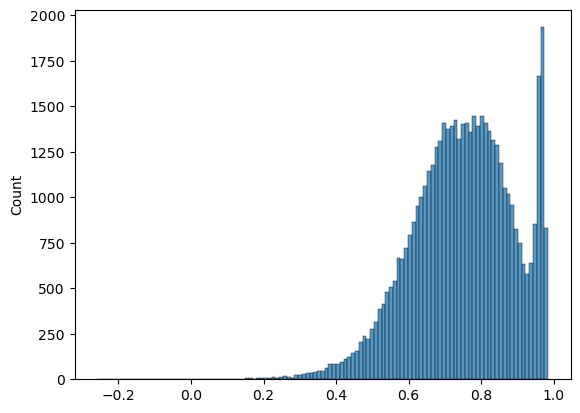

In [31]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

ValueError: 'c' argument has 50214 elements, which is inconsistent with 'x' and 'y' with size 9194.

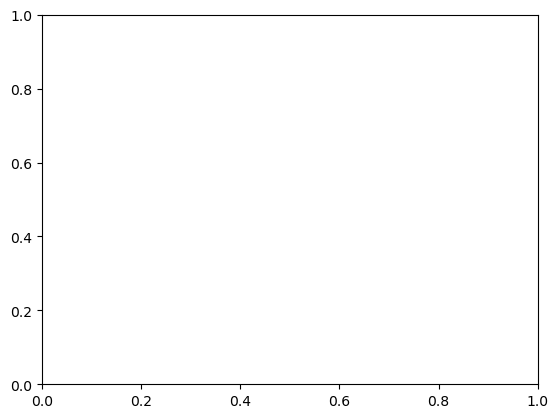

In [32]:
cmap = plt.cm.coolwarm

# Map 'fits' values to the colormap
colors = cmap(np.array(fits))
seaborn.scatterplot(x=discov_cluster_params.mean(1).flatten(),y=log_real_means.mean(1).flatten(),s=0.1,color=colors)
plt.xlabel('reconst gene log mean')
plt.ylabel('actual gene log mean')

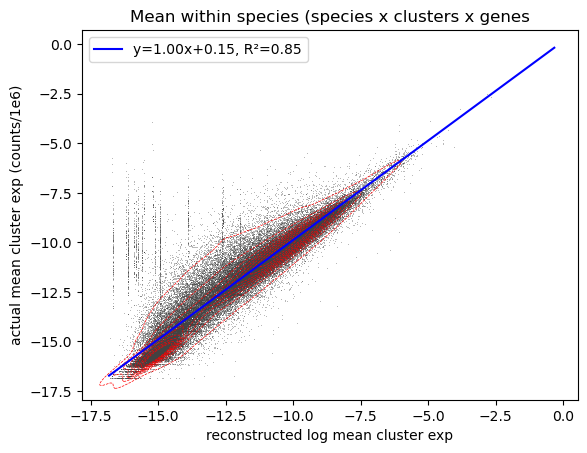

In [33]:
# Calculate the regression parameters
x=discov_cluster_params.flatten()
y=log_real_means.flatten()
mask = ~np.isinf(x)
x=x[mask]
y=y[mask]

randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')



slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

In [34]:
antipode_model.save(out_path,save_anndata=True,prefix='p7_nopsi2temp_')